In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import BoxStyle
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, average_precision_score, f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

In [3]:
Pro_in_model = ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1']
Pro_in_DB = ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1', 'NR1H3', 'NR1H4', 'NR2B3', 'NR2B2', 'NR1D1', 'NR1I2']

In [9]:
probs = pd.read_csv('DB_result/long-chain_prob.csv', index_col=0)
probs.head()

,PID,ID,NAME,Prob
0,NR1C1,PLM,PLM,0.343812
1,NR1C2,PLM,PLM,0.197771
2,NR1C3,PLM,PLM,0.280938
3,NR1H2,PLM,PLM,0.333832
4,NR2B1,PLM,PLM,0.392382


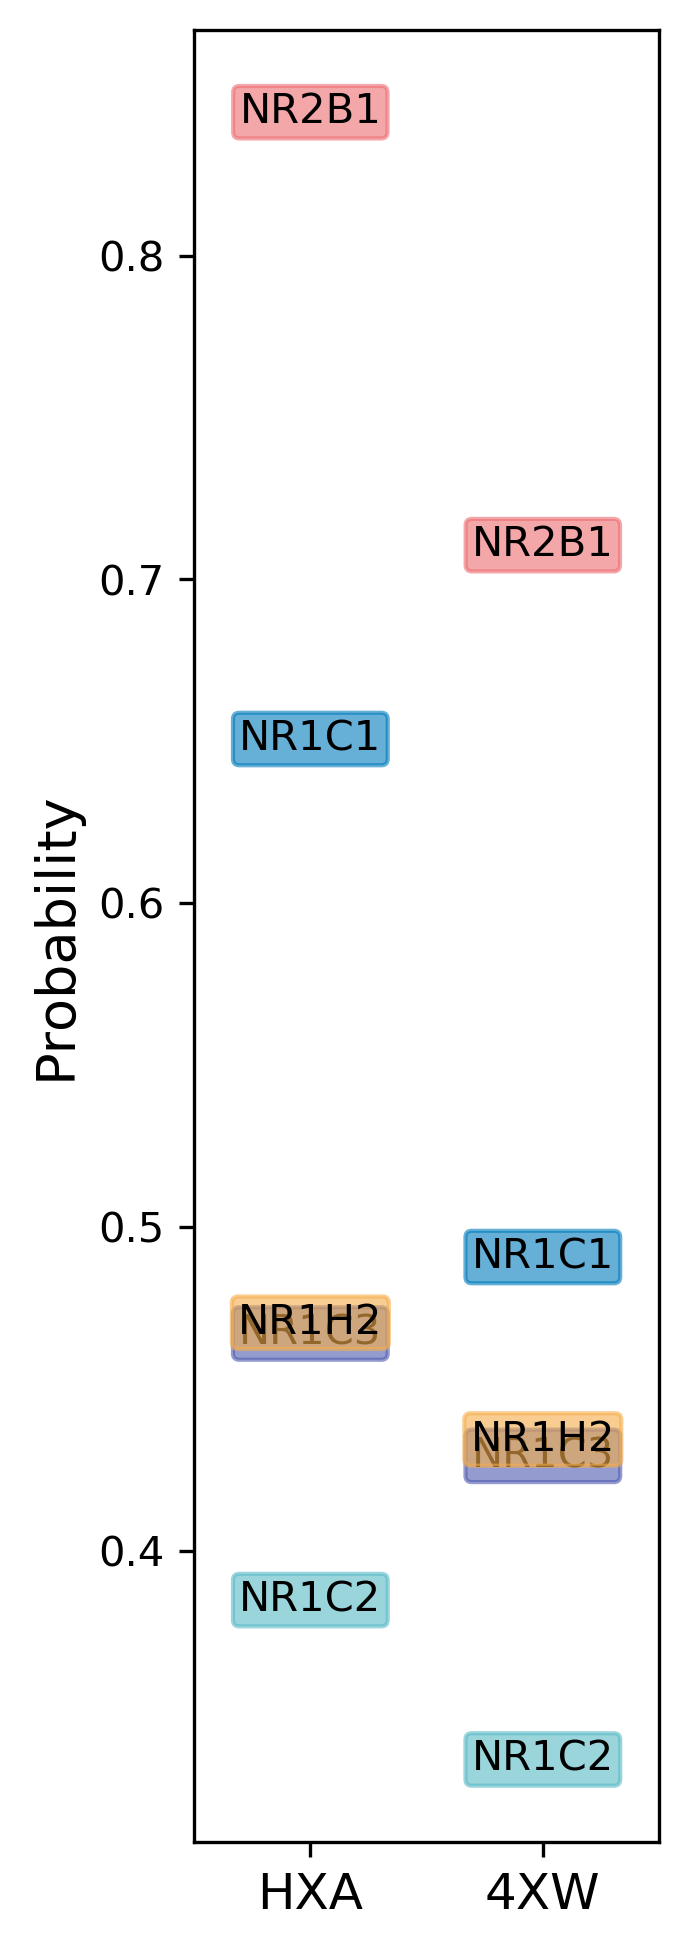

In [10]:
_ = plt.figure(1, (2, 8), dpi=300)

colors = {'NR1C1':'#007bbb', 'NR1C2':'#59b9c6', 'NR1C3':'#4d5aaf', 'NR1H2':'#f6ad49', 'NR2B1':'#ec6d71'}

l = 'HXA'
values = [probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values for p in Pro_in_model]
_ = plt.scatter([0 for i in range(len(values))], values, s=0)

for p in Pro_in_model:
    value = probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values
    bbox_props = dict(boxstyle=BoxStyle('round', pad=0.15), fc=colors[p], ec=colors[p], lw=1, alpha=0.6)
    _ = plt.text(0, value, p, ha="center", va="center", rotation=0, size=10, bbox=bbox_props, zorder=15)

l = '4XW'
values = [probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values for p in Pro_in_model]
_ = plt.scatter([1 for i in range(len(values))], values, s=0)

for p in Pro_in_model:
    value = probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values
    bbox_props = dict(boxstyle=BoxStyle('round', pad=0.15), fc=colors[p], ec=colors[p], lw=1, alpha=0.6)
    _ = plt.text(1, value, p, ha="center", va="center", rotation=0, size=10, bbox=bbox_props, zorder=15)

_ = plt.xlim(-0.5, 1.5)
#_ = plt.ylim(0.5, 0.83)
_ = plt.xticks([0, 1], ['HXA', '4XW'], fontsize=12)
_ = plt.ylabel('Probability', fontsize=13)
_ = plt.show()

In [4]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.502096
1,NR1C2,DB00006,Bivalirudin,0.445110


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.293413
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.285429


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.466068
1,NR1C2,DB00466,Picrotoxin,0.452096


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999


In [5]:
approved_drug_rof = pd.read_csv('DBs/approved_drug_ROF.tsv', index_col=1, sep='\t')
approved_drug_rof['Hdonors'] = approved_drug_rof['Hdonors']<=5
approved_drug_rof['Hacceptors'] = approved_drug_rof['Hacceptors']<=10
approved_drug_rof['Weight'] = approved_drug_rof['Weight']<500
approved_drug_rof['Logp'] = approved_drug_rof['Logp']<5
approved_drug_rof['rotableBonds'] = approved_drug_rof['rotableBonds']<=10
approved_drug_rof.head(2)

chembl_random_rof = pd.read_csv('DBs/chembl_random_ROF.tsv', index_col=1, sep='\t')
chembl_random_rof['Hdonors'] = chembl_random_rof['Hdonors']<=5
chembl_random_rof['Hacceptors'] = chembl_random_rof['Hacceptors']<=10
chembl_random_rof['Weight'] = chembl_random_rof['Weight']<500
chembl_random_rof['Logp'] = chembl_random_rof['Logp']<5
chembl_random_rof['rotableBonds'] = chembl_random_rof['rotableBonds']<=10
chembl_random_rof.head(2)

experimental_drug_rof = pd.read_csv('DBs/experimental_drug_ROF.tsv', index_col=1, sep='\t')
experimental_drug_rof['Hdonors'] = experimental_drug_rof['Hdonors']<=5
experimental_drug_rof['Hacceptors'] = experimental_drug_rof['Hacceptors']<=10
experimental_drug_rof['Weight'] = experimental_drug_rof['Weight']<500
experimental_drug_rof['Logp'] = experimental_drug_rof['Logp']<5
experimental_drug_rof['rotableBonds'] = experimental_drug_rof['rotableBonds']<=10
experimental_drug_rof.head(2)

TCM_Taiwan_rof = pd.read_csv('DBs/TCM_Taiwan_ROF.tsv', index_col=1, sep='\t')
TCM_Taiwan_rof['Hdonors'] = TCM_Taiwan_rof['Hdonors']<=5
TCM_Taiwan_rof['Hacceptors'] = TCM_Taiwan_rof['Hacceptors']<=10
TCM_Taiwan_rof['Weight'] = TCM_Taiwan_rof['Weight']<500
TCM_Taiwan_rof['Logp'] = TCM_Taiwan_rof['Logp']<5
TCM_Taiwan_rof['rotableBonds'] = TCM_Taiwan_rof['rotableBonds']<=10
TCM_Taiwan_rof.head(2)

,Unnamed: 0,NAME,CAS,Hdonors,Hacceptors,Weight,Logp,rotableBonds
ID,,,,,,,,
DB00006,0,Bivalirudin,128270-60-0,False,False,False,True,False
DB00014,1,Goserelin,65807-02-5,False,False,False,True,False


,Unnamed: 0,NAME,CAS,Hdonors,Hacceptors,Weight,Logp,rotableBonds
ID,,,,,,,,
CHEMBL1783156,0,CHEMBL1783156,NaN,True,True,True,True,True
CHEMBL1093006,1,CHEMBL1093006,NaN,True,True,True,True,False


,Unnamed: 0,NAME,CAS,Hdonors,Hacceptors,Weight,Logp,rotableBonds
ID,,,,,,,,
DB00466,0,Picrotoxin,124-87-8,True,False,False,True,True
DB00616,1,Candoxatril,123122-55-4,True,True,False,True,False


,Unnamed: 0,NAME,CAS,Hdonors,Hacceptors,Weight,Logp,rotableBonds
ID,,,,,,,,
ZINC85532298,0,ZINC85532298,NaN,True,True,True,True,True
ZINC86050507,1,ZINC86050507,NaN,False,True,False,True,True


In [6]:
for p in Pro_in_DB:
    for res, rof_res in [(approved_drug_probs, approved_drug_rof), 
                         (experimental_drug_probs, experimental_drug_rof), 
                         (chembl_random_probs, chembl_random_rof), 
                         (TCM_Taiwan_probs, TCM_Taiwan_rof)]:
        ligands = res.loc[res['PID']==p, 'ID'].values
        rofs = np.array([(rof_res.loc[l, ['Hdonors', 'Hacceptors', 'Weight', 'Logp', 
                                          'rotableBonds']].values+0.0).sum()==5 for l in ligands])
        values = res.loc[res['PID']==p, 'Prob'].values
        
        pos_ligands = (rofs+0.0)*((values>=0.5)+0.0)
        p, len(values), (values>=0.5).sum(), (values>=0.5).sum()/float(len(values))
        p, len(values), pos_ligands.sum(), pos_ligands.sum()/float(len(values))

('NR1C1', 2045, 128, 0.06259168704156479)

('NR1C1', 2045, 33.0, 0.01613691931540342)

('NR1C1', 5135, 211, 0.04109055501460565)

('NR1C1', 5135, 71.0, 0.01382667964946446)

('NR1C1', 5000, 663, 0.1326)

('NR1C1', 5000, 188.0, 0.0376)

('NR1C1', 6767, 2015, 0.2977685828284321)

('NR1C1', 6767, 267.0, 0.039456184424412594)

('NR1C2', 2045, 61, 0.02982885085574572)

('NR1C2', 2045, 8.0, 0.003911980440097799)

('NR1C2', 5135, 117, 0.02278481012658228)

('NR1C2', 5135, 47.0, 0.009152872444011684)

('NR1C2', 5000, 364, 0.0728)

('NR1C2', 5000, 90.0, 0.018)

('NR1C2', 6767, 1155, 0.17068124722920053)

('NR1C2', 6767, 91.0, 0.013447613418058224)

('NR1C3', 2045, 254, 0.12420537897310513)

('NR1C3', 2045, 64.0, 0.03129584352078239)

('NR1C3', 5135, 419, 0.0815968841285297)

('NR1C3', 5135, 167.0, 0.03252190847127556)

('NR1C3', 5000, 1367, 0.2734)

('NR1C3', 5000, 456.0, 0.0912)

('NR1C3', 6767, 3844, 0.5680508349342397)

('NR1C3', 6767, 367.0, 0.054233781587113936)

('NR1H2', 2045, 192, 0.0938875305623472)

('NR1H2', 2045, 66.0, 0.03227383863080684)

('NR1H2', 5135, 350, 0.06815968841285297)

('NR1H2', 5135, 156.0, 0.030379746835443037)

('NR1H2', 5000, 923, 0.1846)

('NR1H2', 5000, 341.0, 0.0682)

('NR1H2', 6767, 1847, 0.27294221959509385)

('NR1H2', 6767, 168.0, 0.02482636323333826)

('NR2B1', 2045, 586, 0.2865525672371638)

('NR2B1', 2045, 191.0, 0.09339853300733496)

('NR2B1', 5135, 1353, 0.2634858812074002)

('NR2B1', 5135, 498.0, 0.09698149951314508)

('NR2B1', 5000, 2074, 0.4148)

('NR2B1', 5000, 812.0, 0.1624)

('NR2B1', 6767, 3217, 0.47539530072410224)

('NR2B1', 6767, 668.0, 0.09871434904684498)

('NR1H3', 2045, 133, 0.06503667481662592)

('NR1H3', 2045, 11.0, 0.0053789731051344745)

('NR1H3', 5135, 170, 0.033106134371957155)

('NR1H3', 5135, 28.0, 0.005452775073028238)

('NR1H3', 5000, 568, 0.1136)

('NR1H3', 5000, 63.0, 0.0126)

('NR1H3', 6767, 2136, 0.31564947539530075)

('NR1H3', 6767, 48.0, 0.007093246638096645)

('NR1H4', 2045, 98, 0.04792176039119805)

('NR1H4', 2045, 19.0, 0.009290953545232274)

('NR1H4', 5135, 126, 0.02453748782862707)

('NR1H4', 5135, 41.0, 0.00798442064264849)

('NR1H4', 5000, 407, 0.0814)

('NR1H4', 5000, 73.0, 0.0146)

('NR1H4', 6767, 1525, 0.2253583567311955)

('NR1H4', 6767, 64.0, 0.00945766218412886)

('NR2B3', 2045, 619, 0.3026894865525672)

('NR2B3', 2045, 195.0, 0.09535452322738386)

('NR2B3', 5135, 1293, 0.2518013631937683)

('NR2B3', 5135, 457.0, 0.0889970788704966)

('NR2B3', 5000, 2105, 0.421)

('NR2B3', 5000, 779.0, 0.1558)

('NR2B3', 6767, 4785, 0.7071080242352593)

('NR2B3', 6767, 718.0, 0.10610314762819566)

('NR2B2', 2045, 402, 0.19657701711491443)

('NR2B2', 2045, 148.0, 0.07237163814180929)

('NR2B2', 5135, 879, 0.1711781888997079)

('NR2B2', 5135, 319.0, 0.062122687439143134)

('NR2B2', 5000, 1338, 0.2676)

('NR2B2', 5000, 514.0, 0.1028)

('NR2B2', 6767, 1754, 0.2591990542337816)

('NR2B2', 6767, 366.0, 0.054086005615486925)

('NR1D1', 2045, 894, 0.4371638141809291)

('NR1D1', 2045, 392.0, 0.1916870415647922)

('NR1D1', 5135, 1901, 0.37020447906523857)

('NR1D1', 5135, 942.0, 0.1834469328140214)

('NR1D1', 5000, 3241, 0.6482)

('NR1D1', 5000, 1667.0, 0.3334)

('NR1D1', 6767, 6331, 0.9355696763706222)

('NR1D1', 6767, 1088.0, 0.16078025713019062)

('NR1I2', 2045, 874, 0.4273838630806846)

('NR1I2', 2045, 384.0, 0.1877750611246944)

('NR1I2', 5135, 1828, 0.3559883154819864)

('NR1I2', 5135, 906.0, 0.17643622200584225)

('NR1I2', 5000, 3193, 0.6386)

('NR1I2', 5000, 1632.0, 0.3264)

('NR1I2', 6767, 6001, 0.8868036057337076)

('NR1I2', 6767, 986.0, 0.14570710802423525)

In [15]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

ligand_res5 = []
ligand_res7 = []
for p in Pro_in_DB:
    row5 = []
    row7 = []
    for res in [approved_drug_probs, experimental_drug_probs, chembl_random_probs,TCM_Taiwan_probs]:
        values = res.loc[res['PID']==p, 'Prob'].values
        p, len(values), (values>=0.7).sum(), (values>=0.7).sum()/float(len(values))
        row5.append((values>=0.5).sum()/float(len(values)))
        row7.append((values>=0.7).sum()/float(len(values)))
    ligand_res5.append(row5)
    ligand_res7.append(row7)
ligand_res5 = pd.DataFrame(ligand_res5, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
ligand_res5
ligand_res7 = pd.DataFrame(ligand_res7, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
ligand_res7

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.502096
1,NR1C2,DB00006,Bivalirudin,0.445110


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.293413
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.285429


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.466068
1,NR1C2,DB00466,Picrotoxin,0.452096


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999


('NR1C1', 2045, 0, 0.0)

('NR1C1', 5135, 8, 0.001557935735150925)

('NR1C1', 5000, 2, 0.0004)

('NR1C1', 6767, 0, 0.0)

('NR1C2', 2045, 0, 0.0)

('NR1C2', 5135, 5, 0.0009737098344693282)

('NR1C2', 5000, 3, 0.0006)

('NR1C2', 6767, 0, 0.0)

('NR1C3', 2045, 0, 0.0)

('NR1C3', 5135, 4, 0.0007789678675754625)

('NR1C3', 5000, 6, 0.0012)

('NR1C3', 6767, 0, 0.0)

('NR1H2', 2045, 0, 0.0)

('NR1H2', 5135, 2, 0.00038948393378773126)

('NR1H2', 5000, 3, 0.0006)

('NR1H2', 6767, 0, 0.0)

('NR2B1', 2045, 34, 0.016625916870415647)

('NR2B1', 5135, 38, 0.007400194741966894)

('NR2B1', 5000, 85, 0.017)

('NR2B1', 6767, 65, 0.009605438155755874)

('NR1H3', 2045, 1, 0.0004889975550122249)

('NR1H3', 5135, 2, 0.00038948393378773126)

('NR1H3', 5000, 2, 0.0004)

('NR1H3', 6767, 2, 0.0002955519432540269)

('NR1H4', 2045, 0, 0.0)

('NR1H4', 5135, 2, 0.00038948393378773126)

('NR1H4', 5000, 2, 0.0004)

('NR1H4', 6767, 0, 0.0)

('NR2B3', 2045, 42, 0.020537897310513448)

('NR2B3', 5135, 46, 0.008958130477117819)

('NR2B3', 5000, 98, 0.0196)

('NR2B3', 6767, 117, 0.017289788680360574)

('NR2B2', 2045, 21, 0.010268948655256724)

('NR2B2', 5135, 18, 0.003505355404089581)

('NR2B2', 5000, 40, 0.008)

('NR2B2', 6767, 46, 0.006797694694842618)

('NR1D1', 2045, 121, 0.05916870415647922)

('NR1D1', 5135, 191, 0.03719571567672834)

('NR1D1', 5000, 544, 0.1088)

('NR1D1', 6767, 302, 0.04462834343135806)

('NR1I2', 2045, 114, 0.05574572127139364)

('NR1I2', 5135, 156, 0.030379746835443037)

('NR1I2', 5000, 470, 0.094)

('NR1I2', 6767, 374, 0.05526821338850303)

,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.062592,0.041091,0.1326,0.297769
NR1C2,0.029829,0.022785,0.0728,0.170681
NR1C3,0.124205,0.081597,0.2734,0.568051
NR1H2,0.093888,0.068160,0.1846,0.272942
NR2B1,0.286553,0.263486,0.4148,0.475395
NR1H3,0.065037,0.033106,0.1136,0.315649
NR1H4,0.047922,0.024537,0.0814,0.225358
NR2B3,0.302689,0.251801,0.4210,0.707108
NR2B2,0.196577,0.171178,0.2676,0.259199
NR1D1,0.437164,0.370204,0.6482,0.935570


,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.000000,0.001558,0.0004,0.000000
NR1C2,0.000000,0.000974,0.0006,0.000000
NR1C3,0.000000,0.000779,0.0012,0.000000
NR1H2,0.000000,0.000389,0.0006,0.000000
NR2B1,0.016626,0.007400,0.0170,0.009605
NR1H3,0.000489,0.000389,0.0004,0.000296
NR1H4,0.000000,0.000389,0.0004,0.000000
NR2B3,0.020538,0.008958,0.0196,0.017290
NR2B2,0.010269,0.003505,0.0080,0.006798
NR1D1,0.059169,0.037196,0.1088,0.044628


In [16]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_scaffold_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_scaffold_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_scaffold_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_scaffold_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

scaffold_res5 = []
scaffold_res7 = []
for p in Pro_in_DB:
    row5 = []
    row7 = []
    for res in [approved_drug_probs, experimental_drug_probs, chembl_random_probs,TCM_Taiwan_probs]:
        values = res.loc[res['PID']==p, 'Prob'].values
        p, len(values), (values>=0.7).sum(), (values>=0.7).sum()/float(len(values))
        row5.append((values>=0.5).sum()/float(len(values)))
        row7.append((values>=0.7).sum()/float(len(values)))
    scaffold_res5.append(row5)
    scaffold_res7.append(row7)
scaffold_res5 = pd.DataFrame(scaffold_res5, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
scaffold_res5
scaffold_res7 = pd.DataFrame(scaffold_res7, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
scaffold_res7

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.464338
1,NR1C2,DB00006,Bivalirudin,0.394877


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.344454
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.308383


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.418164
1,NR1C2,DB00466,Picrotoxin,0.398536


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.408383
1,NR1C2,ZINC85532298,ZINC85532298,0.314457


('NR1C1', 1716, 0, 0.0)

('NR1C1', 4330, 0, 0.0)

('NR1C1', 4940, 0, 0.0)

('NR1C1', 6725, 0, 0.0)

('NR1C2', 1716, 0, 0.0)

('NR1C2', 4330, 0, 0.0)

('NR1C2', 4940, 0, 0.0)

('NR1C2', 6725, 0, 0.0)

('NR1C3', 1716, 0, 0.0)

('NR1C3', 4330, 0, 0.0)

('NR1C3', 4940, 0, 0.0)

('NR1C3', 6725, 0, 0.0)

('NR1H2', 1716, 0, 0.0)

('NR1H2', 4330, 0, 0.0)

('NR1H2', 4940, 0, 0.0)

('NR1H2', 6725, 0, 0.0)

('NR2B1', 1716, 21, 0.012237762237762238)

('NR2B1', 4330, 37, 0.008545034642032332)

('NR2B1', 4940, 65, 0.013157894736842105)

('NR2B1', 6725, 337, 0.050111524163568774)

('NR1H3', 1716, 0, 0.0)

('NR1H3', 4330, 0, 0.0)

('NR1H3', 4940, 1, 0.00020242914979757084)

('NR1H3', 6725, 0, 0.0)

('NR1H4', 1716, 0, 0.0)

('NR1H4', 4330, 0, 0.0)

('NR1H4', 4940, 0, 0.0)

('NR1H4', 6725, 0, 0.0)

('NR2B3', 1716, 22, 0.01282051282051282)

('NR2B3', 4330, 37, 0.008545034642032332)

('NR2B3', 4940, 70, 0.01417004048582996)

('NR2B3', 6725, 427, 0.06349442379182156)

('NR2B2', 1716, 13, 0.007575757575757576)

('NR2B2', 4330, 23, 0.005311778290993071)

('NR2B2', 4940, 37, 0.007489878542510121)

('NR2B2', 6725, 228, 0.033903345724907066)

('NR1D1', 1716, 59, 0.034382284382284384)

('NR1D1', 4330, 119, 0.02748267898383372)

('NR1D1', 4940, 291, 0.05890688259109312)

('NR1D1', 6725, 1361, 0.20237918215613382)

('NR1I2', 1716, 65, 0.03787878787878788)

('NR1I2', 4330, 107, 0.024711316397228636)

('NR1I2', 4940, 287, 0.05809716599190284)

('NR1I2', 6725, 1644, 0.24446096654275093)

,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.023310,0.013857,0.032794,0.118513
NR1C2,0.011072,0.007390,0.016397,0.054721
NR1C3,0.069930,0.050115,0.109312,0.277472
NR1H2,0.037879,0.022633,0.047571,0.073011
NR2B1,0.109557,0.088915,0.177328,0.488476
NR1H3,0.044872,0.022171,0.041498,0.205353
NR1H4,0.021562,0.006697,0.015992,0.058439
NR2B3,0.111888,0.087991,0.180972,0.553755
NR2B2,0.076923,0.059584,0.118623,0.452045
NR1D1,0.203380,0.162125,0.331579,0.665130


,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.000000,0.000000,0.000000,0.000000
NR1C2,0.000000,0.000000,0.000000,0.000000
NR1C3,0.000000,0.000000,0.000000,0.000000
NR1H2,0.000000,0.000000,0.000000,0.000000
NR2B1,0.012238,0.008545,0.013158,0.050112
NR1H3,0.000000,0.000000,0.000202,0.000000
NR1H4,0.000000,0.000000,0.000000,0.000000
NR2B3,0.012821,0.008545,0.014170,0.063494
NR2B2,0.007576,0.005312,0.007490,0.033903
NR1D1,0.034382,0.027483,0.058907,0.202379


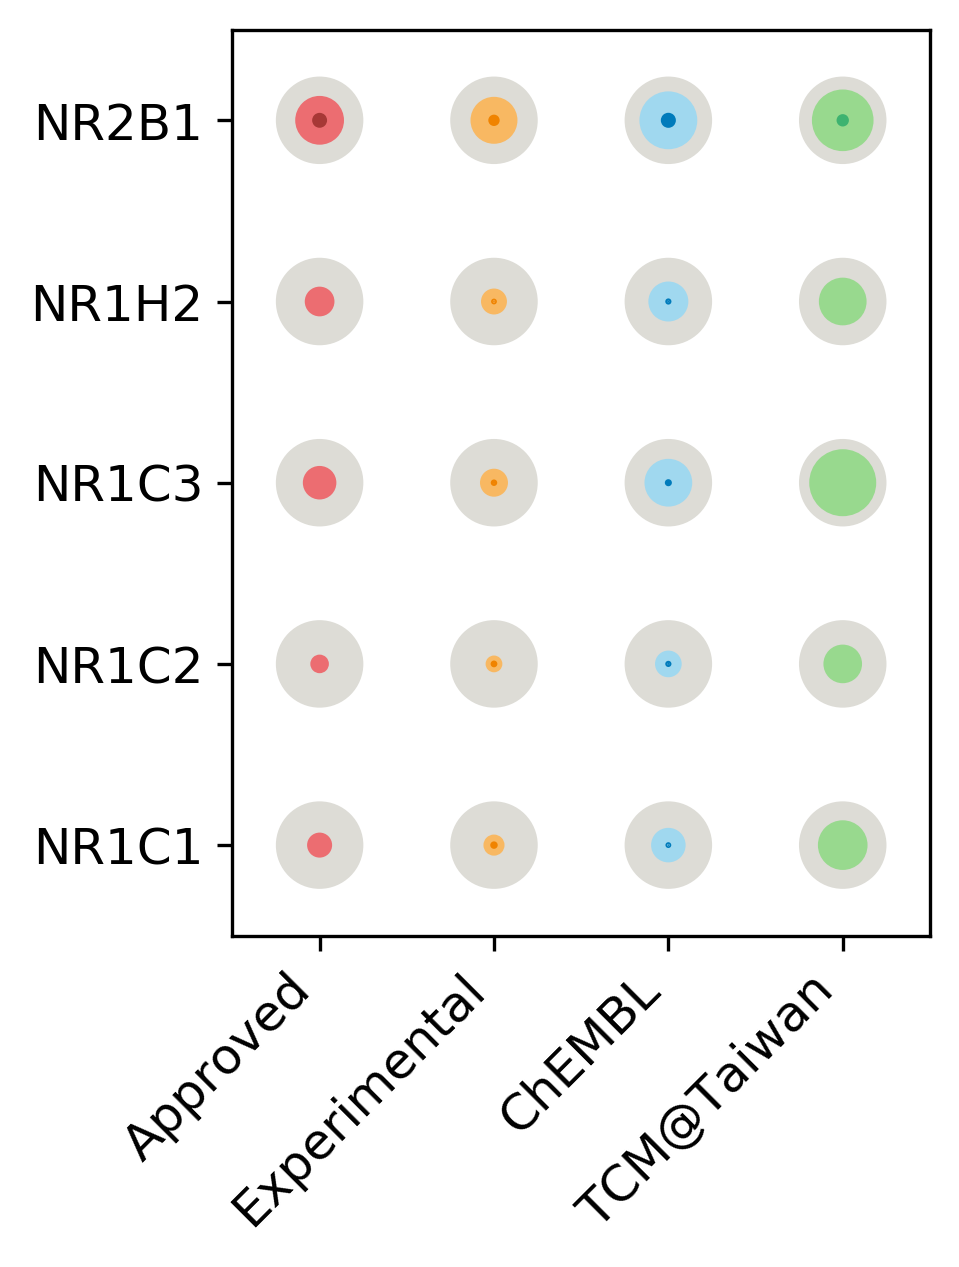

In [27]:
ligand_res5 = ligand_res5.loc[Pro_in_model, :]
ligand_res7 = ligand_res7.loc[Pro_in_model, :]

colors5 = ['#ec6d71', '#f8b862', '#a0d8ef', '#98d98e']
colors7 = ['#a73836', '#f08300', '#007bbb', '#3eb370']
color_map5 = []
plot_data5 = []
for i in range(ligand_res5.shape[1]):
    for j in range(ligand_res5.shape[0]):
        plot_data5.append([i, j, ligand_res5.iloc[j, i], 1.0])
        color_map5.append(colors5[i])
plot_data5 = np.array(plot_data5)

plot_data7 = []
color_map7 = []
for i in range(ligand_res7.shape[1]):
    for j in range(ligand_res7.shape[0]):
        plot_data7.append([i, j, ligand_res7.iloc[j, i], 1.0])
        color_map7.append(colors7[i])
plot_data7 = np.array(plot_data7)

_ = plt.figure(1, (3, 4), dpi=300)
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 3]*400, zorder=0, color='#dddcd6')
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 2]*400, zorder=10, color=color_map5)
_ = plt.scatter(plot_data7[:, 0], plot_data7[:, 1], s=plot_data7[:, 2]*400, zorder=11, color=color_map7)
_ = plt.yticks(range(ligand_res5.shape[0]), list(ligand_res5.index), fontsize=12)
_ = plt.xticks([0, 1, 2, 3], list(ligand_res5.columns), rotation=45, ha='right', fontsize=12)
_ = plt.xlim(-0.5, 3.5)
_ = plt.ylim(-0.5, 4.5)
_ = plt.show()

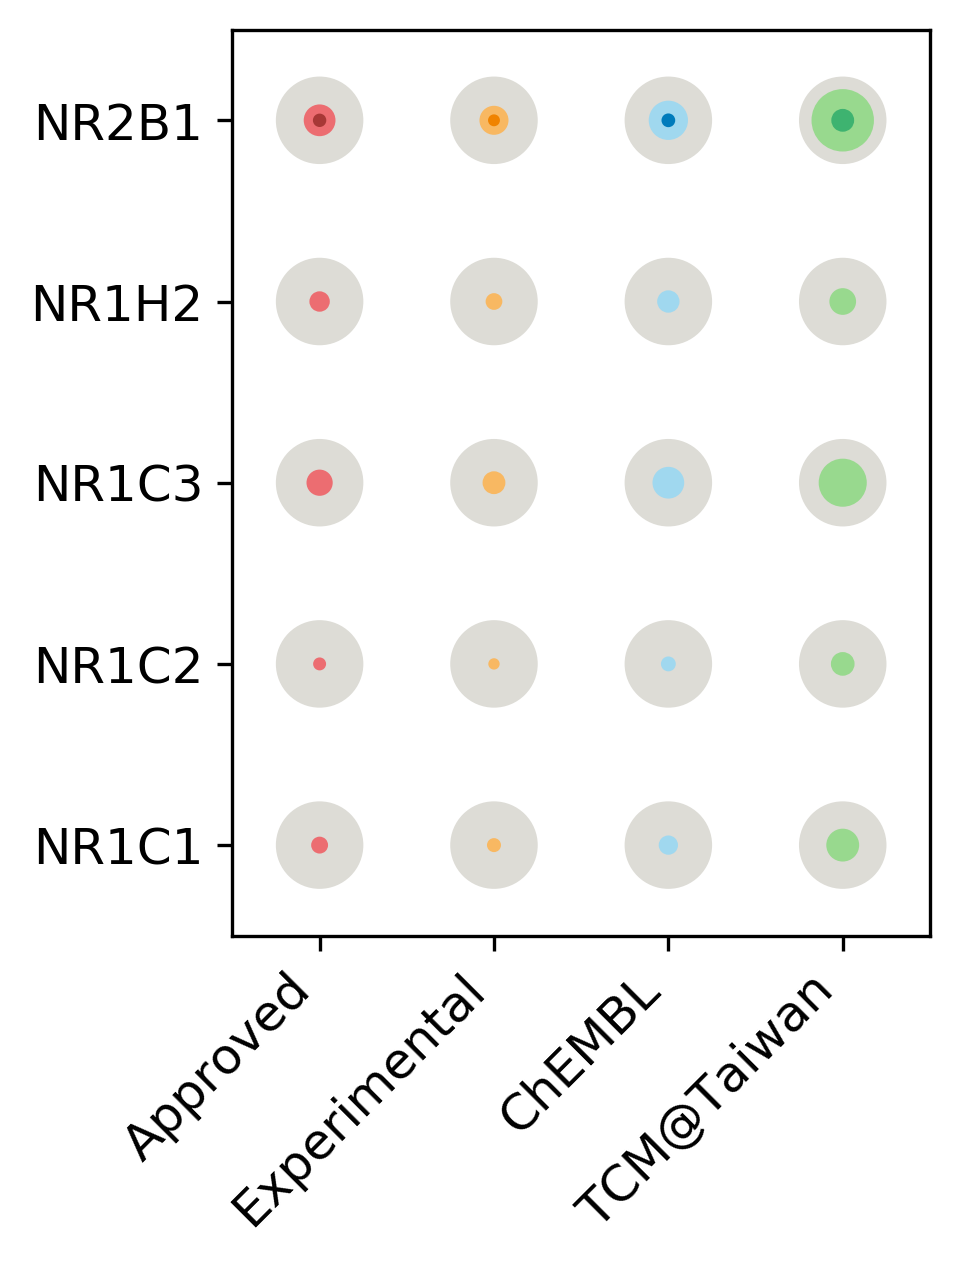

In [28]:
scaffold_res5 = scaffold_res5.loc[Pro_in_model, :]
scaffold_res7 = scaffold_res7.loc[Pro_in_model, :]

colors5 = ['#ec6d71', '#f8b862', '#a0d8ef', '#98d98e']
colors7 = ['#a73836', '#f08300', '#007bbb', '#3eb370']
color_map5 = []
plot_data5 = []
for i in range(scaffold_res5.shape[1]):
    for j in range(scaffold_res5.shape[0]):
        plot_data5.append([i, j, scaffold_res5.iloc[j, i], 1.0])
        color_map5.append(colors5[i])
plot_data5 = np.array(plot_data5)

plot_data7 = []
color_map7 = []
for i in range(scaffold_res7.shape[1]):
    for j in range(scaffold_res7.shape[0]):
        plot_data7.append([i, j, scaffold_res7.iloc[j, i], 1.0])
        color_map7.append(colors7[i])
plot_data7 = np.array(plot_data7)

_ = plt.figure(1, (3, 4), dpi=300)
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 3]*400, zorder=0, color='#dddcd6')
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 2]*400, zorder=10, color=color_map5)
_ = plt.scatter(plot_data7[:, 0], plot_data7[:, 1], s=plot_data7[:, 2]*400, zorder=11, color=color_map7)
_ = plt.yticks(range(scaffold_res5.shape[0]), list(scaffold_res5.index), fontsize=12)
_ = plt.xticks([0, 1, 2, 3], list(scaffold_res5.columns), rotation=45, ha='right', fontsize=12)
_ = plt.xlim(-0.5, 3.5)
_ = plt.ylim(-0.5, 4.5)
_ = plt.show()

# Predition result of TCM taiwan

In [20]:
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs

,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999
2,NR1C3,ZINC85532298,ZINC85532298,0.394877
3,NR1H2,ZINC85532298,ZINC85532298,0.365935
4,NR2B1,ZINC85532298,ZINC85532298,0.514970
...,...,...,...,...
74432,NR1H4,ZINC70455164,ZINC70455164,0.463573
74433,NR2B3,ZINC70455164,ZINC70455164,0.554890
74434,NR2B2,ZINC70455164,ZINC70455164,0.524950
74435,NR1D1,ZINC70455164,ZINC70455164,0.588822


In [27]:
result = []
for CID in set(TCM_Taiwan_probs['ID']):
    row = [CID]
    topprob = 0.0
    toptarget = ''
    for PID in ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1']:
        prob = TCM_Taiwan_probs.loc[(TCM_Taiwan_probs['ID']==CID)&(TCM_Taiwan_probs['PID']==PID), 'Prob'].values[0]
        if prob>=topprob:
            topprob = prob
            toptarget = PID
        row.append(prob)
    row.append(max(row[1:]))
    row.append(toptarget)
    len(set(TCM_Taiwan_probs['ID'])), len(result), row
    result.append(row)
result = pd.DataFrame(result, columns=['CID', 'NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1', 'MaxProb', 'TopTarget'])
result

(6767,
 0,
 ['ZINC95909826',
  0.4337990685296075,
  0.4025282767797739,
  0.498003992015968,
  0.46806387225548907,
  0.5854956753160346,
  0.5854956753160346,
  'NR2B1'])

(6767,
 1,
 ['ZINC05412783',
  0.5209580838323353,
  0.4530938123752495,
  0.5133732534930139,
  0.4654690618762475,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 2,
 ['ZINC14514228',
  0.5001108893324462,
  0.4241516966067864,
  0.5210689731647815,
  0.4352406298514083,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3,
 ['ZINC95909923',
  0.48022288755821685,
  0.4096972721224218,
  0.5271124417831003,
  0.41533599467731197,
  0.5495675316034597,
  0.5495675316034597,
  'NR2B1'])

(6767,
 4,
 ['ZINC85544507',
  0.4815369261477046,
  0.38423153692614775,
  0.4730538922155688,
  0.42115768463073855,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 5,
 ['ZINC85542831',
  0.5031175743750593,
  0.4880239520958084,
  0.5379241516966068,
  0.5033266799733864,
  0.4945109780439122,
  0.5379241516966068,
  'NR1C3'])

(6767,
 6,
 ['ZINC85595286',
  0.43253493013972055,
  0.4095143047238856,
  0.4847638057218896,
  0.4384564204923487,
  0.42115768463073855,
  0.4847638057218896,
  'NR1C3'])

(6767,
 7,
 ['ZINC85543166',
  0.41267465069860276,
  0.3504657351962742,
  0.4226546906187625,
  0.33629407850964743,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 8,
 ['ZINC85504737',
  0.3910179640718563,
  0.36693280106453763,
  0.42681304058549574,
  0.4108449767132403,
  0.4740518962075848,
  0.4740518962075848,
  'NR2B1'])

(6767,
 9,
 ['ZINC95912404',
  0.5711909514304724,
  0.5838323353293413,
  0.6398156068814751,
  0.5708582834331337,
  0.46906187624750506,
  0.6398156068814751,
  'NR1C3'])

(6767,
 10,
 ['ZINC85627986',
  0.41441561321800846,
  0.36194278110445777,
  0.4263140385894878,
  0.3903858948769129,
  0.4417831004657353,
  0.4417831004657353,
  'NR2B1'])

(6767,
 11,
 ['ZINC85532289',
  0.4837990685296074,
  0.45176314038589493,
  0.5695276114437791,
  0.4713905522288756,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 12,
 ['ZINC85596734',
  0.5267465069860279,
  0.530938123752495,
  0.561377245508982,
  0.5394211576846307,
  0.5109780439121757,
  0.561377245508982,
  'NR1C3'])

(6767,
 13,
 ['ZINC86004276',
  0.49708663481118565,
  0.419131434101494,
  0.44374886590455453,
  0.4676757595919272,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 14,
 ['ZINC39183277',
  0.4040490447676077,
  0.3153692614770459,
  0.42015968063872255,
  0.3672654690618763,
  0.44510978043912175,
  0.44510978043912175,
  'NR2B1'])

(6767,
 15,
 ['ZINC85542270',
  0.5294890738004512,
  0.5349301397205589,
  0.5988023952095808,
  0.5409181636726548,
  0.5349301397205589,
  0.5988023952095808,
  'NR1C3'])

(6767,
 16,
 ['ZINC33831118',
  0.5367930805056553,
  0.49301397205588826,
  0.5229540918163672,
  0.5169660678642716,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 17,
 ['ZINC85548417',
  0.441583499667332,
  0.3652694610778443,
  0.4416167664670658,
  0.42564870259481036,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 18,
 ['ZINC85544023',
  0.4366948642397743,
  0.3512974051896207,
  0.46007984031936133,
  0.4061876247504991,
  0.48552894211576847,
  0.48552894211576847,
  'NR2B1'])

(6767,
 19,
 ['ZINC95912448',
  0.42896890202279425,
  0.3758845944474687,
  0.44460429789771105,
  0.3837325349301397,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 20,
 ['ZINC85544337',
  0.4575198808731743,
  0.3313373253493014,
  0.46007984031936133,
  0.3662674650698603,
  0.5244510978043913,
  0.5244510978043913,
  'NR2B1'])

(6767,
 21,
 ['ZINC85626175',
  0.49135063206919494,
  0.4121756487025948,
  0.5089820359281438,
  0.4683965402528276,
  0.4401197604790419,
  0.5089820359281438,
  'NR1C3'])

(6767,
 22,
 ['ZINC14829678',
  0.5119760479041916,
  0.499001996007984,
  0.5528942115768463,
  0.49101796407185627,
  0.5049900199600799,
  0.5528942115768463,
  'NR1C3'])

(6767,
 23,
 ['ZINC85531390',
  0.5512550656263231,
  0.5,
  0.5728542914171656,
  0.5861610113107121,
  0.46806387225548907,
  0.5861610113107121,
  'NR1H2'])

(6767,
 24,
 ['ZINC28654707',
  0.4055959509552324,
  0.310129740518962,
  0.4551563539587491,
  0.354690618762475,
  0.5662674650698603,
  0.5662674650698603,
  'NR2B1'])

(6767,
 25,
 ['ZINC85546474',
  0.4974970693533568,
  0.47904191616766467,
  0.524284763805722,
  0.4531413363748693,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 26,
 ['ZINC85542092',
  0.4953093812375249,
  0.4604125083166999,
  0.5758483033932136,
  0.5119760479041916,
  0.5528942115768463,
  0.5758483033932136,
  'NR1C3'])

(6767,
 27,
 ['ZINC85592297',
  0.5339479770617497,
  0.5269461077844311,
  0.564870259481038,
  0.5728542914171656,
  0.45708582834331335,
  0.5728542914171656,
  'NR1H2'])

(6767,
 28,
 ['ZINC85529941',
  0.5800066533599468,
  0.5489021956087824,
  0.5941212812470297,
  0.5968063872255489,
  0.5036593479707253,
  0.5968063872255489,
  'NR1H2'])

(6767,
 29,
 ['ZINC15120533',
  0.5017964071856287,
  0.45708582834331335,
  0.5678642714570858,
  0.5099800399201597,
  0.4730538922155688,
  0.5678642714570858,
  'NR1C3'])

(6767,
 30,
 ['ZINC85568611',
  0.4273120425815037,
  0.4111776447105788,
  0.45908183632734534,
  0.42195608782435123,
  0.44710578842315374,
  0.45908183632734534,
  'NR1C3'])

(6767,
 31,
 ['ZINC85570622',
  0.47917498336660025,
  0.435129740518962,
  0.5174650698602795,
  0.46357285429141715,
  0.44510978043912175,
  0.5174650698602795,
  'NR1C3'])

(6767,
 32,
 ['ZINC85592748',
  0.5456198713683744,
  0.4915169660678643,
  0.548447549345753,
  0.5262253271235307,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 33,
 ['ZINC85532166',
  0.44629788042961693,
  0.3689288090485696,
  0.481703260146374,
  0.4298070525615436,
  0.49600798403193613,
  0.49600798403193613,
  'NR2B1'])

(6767,
 34,
 ['ZINC85569850',
  0.5206634350346926,
  0.5149700598802395,
  0.5758483033932136,
  0.5117764471057885,
  0.5149700598802395,
  0.5758483033932136,
  'NR1C3'])

(6767,
 35,
 ['ZINC85568146',
  0.4243180306054558,
  0.43313373253493015,
  0.46373918829008653,
  0.4650698602794411,
  0.4530938123752495,
  0.4650698602794411,
  'NR1H2'])

(6767,
 36,
 ['ZINC95910047',
  0.5107562652472832,
  0.45420270569971166,
  0.49743370402053033,
  0.4943446440452428,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 37,
 ['ZINC85542057',
  0.5506653359946774,
  0.5409181636726548,
  0.5838323353293413,
  0.5588822355289421,
  0.5229540918163672,
  0.5838323353293413,
  'NR1C3'])

(6767,
 38,
 ['ZINC85542121',
  0.4387225548902196,
  0.34730538922155685,
  0.45688622754491015,
  0.3992015968063872,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 39,
 ['ZINC85570813',
  0.5015017583879859,
  0.500998003992016,
  0.5955588822355289,
  0.5229540918163672,
  0.4630738522954092,
  0.5955588822355289,
  'NR1C3'])

(6767,
 40,
 ['ZINC85570796',
  0.4961077844311378,
  0.499001996007984,
  0.5760978043912175,
  0.5011643379906854,
  0.4241516966067864,
  0.5760978043912175,
  'NR1C3'])

(6767,
 41,
 ['ZINC85624607',
  0.560878243512974,
  0.45708582834331335,
  0.6207584830339321,
  0.5349301397205589,
  0.5389221556886227,
  0.6207584830339321,
  'NR1C3'])

(6767,
 42,
 ['ZINC85546244',
  0.5174096251940564,
  0.5129740518962076,
  0.562874251497006,
  0.532934131736527,
  0.4900199600798403,
  0.562874251497006,
  'NR1C3'])

(6767,
 43,
 ['ZINC85570725',
  0.42210024395653134,
  0.3872255489021956,
  0.4760479041916168,
  0.4186626746506986,
  0.45276114437791093,
  0.4760479041916168,
  'NR1C3'])

(6767,
 44,
 ['ZINC14818247',
  0.46174318030605466,
  0.35096473719228216,
  0.43230206254158354,
  0.38123752495009977,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 45,
 ['ZINC95913864',
  0.5688622754491017,
  0.4231536926147704,
  0.560878243512974,
  0.4870259481037924,
  0.7045908183632734,
  0.7045908183632734,
  'NR2B1'])

(6767,
 46,
 ['ZINC85625446',
  0.4660678642714571,
  0.4151696606786427,
  0.5269461077844311,
  0.4630738522954092,
  0.48103792415169666,
  0.5269461077844311,
  'NR1C3'])

(6767,
 47,
 ['ZINC17465983',
  0.46640053226879574,
  0.49101796407185627,
  0.5111443779108449,
  0.4797072521623419,
  0.46706586826347307,
  0.5111443779108449,
  'NR1C3'])

(6767,
 48,
 ['ZINC85541867',
  0.5212242182302063,
  0.5229540918163672,
  0.5748502994011976,
  0.5129740518962076,
  0.5209580838323353,
  0.5748502994011976,
  'NR1C3'])

(6767,
 49,
 ['ZINC85570240',
  0.5250594049995247,
  0.4890219560878244,
  0.562874251497006,
  0.5267560117859519,
  0.4730538922155688,
  0.562874251497006,
  'NR1C3'])

(6767,
 50,
 ['ZINC85597490',
  0.3922155688622755,
  0.4271457085828343,
  0.48103792415169666,
  0.43313373253493015,
  0.4510978043912176,
  0.48103792415169666,
  'NR1C3'])

(6767,
 51,
 ['ZINC85964608',
  0.532934131736527,
  0.5219560878243513,
  0.5556506035547952,
  0.4750499001996008,
  0.48103792415169666,
  0.5556506035547952,
  'NR1C3'])

(6767,
 52,
 ['ZINC95914362',
  0.4231536926147704,
  0.36127744510978044,
  0.43313373253493015,
  0.3872255489021956,
  0.4540918163672655,
  0.4540918163672655,
  'NR2B1'])

(6767,
 53,
 ['ZINC85532582',
  0.47837658017298734,
  0.4251497005988024,
  0.5204590818363273,
  0.4271457085828343,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 54,
 ['ZINC85543602',
  0.4171656686626747,
  0.36027944111776444,
  0.4261477045908184,
  0.2902195608782435,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 55,
 ['ZINC85489277',
  0.5101131071190952,
  0.37325349301397204,
  0.44893546240851634,
  0.34664005322687963,
  0.7025948103792414,
  0.7025948103792414,
  'NR2B1'])

(6767,
 56,
 ['ZINC14490543',
  0.5082864573882537,
  0.4610778443113772,
  0.5884896872920824,
  0.5219560878243513,
  0.4870259481037924,
  0.5884896872920824,
  'NR1C3'])

(6767,
 57,
 ['ZINC85592613',
  0.5128354402306499,
  0.4518463073852296,
  0.5479041916167664,
  0.5199600798403192,
  0.44411177644710575,
  0.5479041916167664,
  'NR1C3'])

(6767,
 58,
 ['ZINC85592517',
  0.3966733200266135,
  0.38123752495009977,
  0.4896872920825017,
  0.41916167664670656,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 59,
 ['ZINC85548937',
  0.4732202262142383,
  0.3930472388556221,
  0.4210745176314038,
  0.39437791084497664,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 60,
 ['ZINC06006754',
  0.4446606786427145,
  0.3652694610778443,
  0.43313373253493015,
  0.4171656686626747,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 61,
 ['ZINC85532400',
  0.4671545797294301,
  0.3902195608782435,
  0.5063206919494345,
  0.4141716566866266,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 62,
 ['ZINC85627068',
  0.4171656686626747,
  0.3819028609447772,
  0.49966733200266134,
  0.4526946107784431,
  0.4577511643379908,
  0.49966733200266134,
  'NR1C3'])

(6767,
 63,
 ['ZINC85627591',
  0.3938789088489688,
  0.30938123752495006,
  0.3504657351962742,
  0.33532934131736525,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 64,
 ['ZINC85568213',
  0.39701549282387605,
  0.44026233247790125,
  0.4677312042581504,
  0.44510978043912175,
  0.4530938123752495,
  0.4677312042581504,
  'NR1C3'])

(6767,
 65,
 ['ZINC85632546',
  0.46571301840762924,
  0.4397205588822356,
  0.5321357285429142,
  0.4925149700598802,
  0.41666666666666663,
  0.5321357285429142,
  'NR1C3'])

(6767,
 66,
 ['ZINC95919108',
  0.4848666303756123,
  0.36157987056190644,
  0.45838625778745534,
  0.43313373253493015,
  0.7125748502994012,
  0.7125748502994012,
  'NR2B1'])

(6767,
 67,
 ['ZINC38840351',
  0.5049900199600799,
  0.4850299401197605,
  0.5834996673320026,
  0.47837658017298723,
  0.499001996007984,
  0.5834996673320026,
  'NR1C3'])

(6767,
 68,
 ['ZINC85491952',
  0.5363717010423599,
  0.48935462408516295,
  0.553226879574185,
  0.521789753825682,
  0.46706586826347307,
  0.553226879574185,
  'NR1C3'])

(6767,
 69,
 ['ZINC85546373',
  0.520292747837658,
  0.4693945442448436,
  0.5369261477045908,
  0.4595808383233533,
  0.4650698602794411,
  0.5369261477045908,
  'NR1C3'])

(6767,
 70,
 ['ZINC85571523',
  0.4947010740423914,
  0.4500998003992016,
  0.5531603459747172,
  0.44510978043912175,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 71,
 ['ZINC85541983',
  0.49018831024819043,
  0.45908183632734534,
  0.5573852295409182,
  0.5051563539587491,
  0.5129740518962076,
  0.5573852295409182,
  'NR1C3'])

(6767,
 72,
 ['ZINC85506237',
  0.4456087824351297,
  0.436127744510978,
  0.5216234198270127,
  0.46473719228210253,
  0.47904191616766467,
  0.5216234198270127,
  'NR1C3'])

(6767,
 73,
 ['ZINC85490965',
  0.45888223552894203,
  0.344311377245509,
  0.43433133732534934,
  0.37125748502994016,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 74,
 ['ZINC85571182',
  0.47935240629851406,
  0.4890219560878244,
  0.5568862275449102,
  0.4740518962075848,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 75,
 ['ZINC14711733',
  0.5340224313278206,
  0.5065868263473055,
  0.5661343978709248,
  0.47315369261477047,
  0.5089820359281438,
  0.5661343978709248,
  'NR1C3'])

(6767,
 76,
 ['ZINC85644680',
  0.500998003992016,
  0.46806387225548907,
  0.5465735196274117,
  0.49966733200266134,
  0.5409181636726548,
  0.5465735196274117,
  'NR1C3'])

(6767,
 77,
 ['ZINC85540811',
  0.4429157557900073,
  0.41916167664670656,
  0.5013306719893547,
  0.43413173652694614,
  0.5024950099800398,
  0.5024950099800398,
  'NR2B1'])

(6767,
 78,
 ['ZINC85505562',
  0.40380112790292433,
  0.41183109970535126,
  0.5276114437791084,
  0.4240899154072807,
  0.5499714856002281,
  0.5499714856002281,
  'NR2B1'])

(6767,
 79,
 ['ZINC85571266',
  0.4509314703925481,
  0.4683965402528276,
  0.5753493013972055,
  0.4752162341982702,
  0.4870259481037924,
  0.5753493013972055,
  'NR1C3'])

(6767,
 80,
 ['ZINC95913940',
  0.498003992015968,
  0.44411177644710575,
  0.5279441117764472,
  0.5384231536926147,
  0.530938123752495,
  0.5384231536926147,
  'NR1H2'])

(6767,
 81,
 ['ZINC85531542',
  0.46866267465069866,
  0.3912175648702595,
  0.4650698602794411,
  0.4545908183632734,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 82,
 ['ZINC13379920',
  0.48735861610113107,
  0.46906187624750506,
  0.5247837658017299,
  0.4793745841650032,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 83,
 ['ZINC85490724',
  0.4642381902860945,
  0.4171656686626747,
  0.4860279441117764,
  0.46157684630738527,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 84,
 ['ZINC95919279',
  0.5580172987358616,
  0.4770459081836327,
  0.5508982035928144,
  0.5848303393213573,
  0.5369261477045908,
  0.5848303393213573,
  'NR1H2'])

(6767,
 85,
 ['ZINC85491186',
  0.44527611443779114,
  0.4770459081836327,
  0.5178975382568197,
  0.5349301397205589,
  0.4916833000665336,
  0.5349301397205589,
  'NR1H2'])

(6767,
 86,
 ['ZINC14692414',
  0.4667332002661345,
  0.5169660678642716,
  0.5577511643379907,
  0.5259481037924152,
  0.500998003992016,
  0.5577511643379907,
  'NR1C3'])

(6767,
 87,
 ['ZINC95911362',
  0.35419161676646704,
  0.30938123752495006,
  0.37125748502994016,
  0.35296074517631415,
  0.4051896207584831,
  0.4051896207584831,
  'NR2B1'])

(6767,
 88,
 ['ZINC85594222',
  0.43873364382346414,
  0.3922155688622755,
  0.4640718562874252,
  0.43213572854291415,
  0.4630738522954092,
  0.4640718562874252,
  'NR1C3'])

(6767,
 89,
 ['ZINC85532606',
  0.49401197604790414,
  0.4421157684630739,
  0.5342648037258815,
  0.4520958083832335,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 90,
 ['ZINC85545399',
  0.5074517631403859,
  0.46906187624750506,
  0.530938123752495,
  0.4770459081836327,
  0.49301397205588826,
  0.530938123752495,
  'NR1C3'])

(6767,
 91,
 ['ZINC95912802',
  0.4364604125083166,
  0.37857618097139045,
  0.4740518962075848,
  0.4216566866267465,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 92,
 ['ZINC95910486',
  0.43496340652029275,
  0.40918163672654706,
  0.44311377245508987,
  0.4411177644710579,
  0.405688622754491,
  0.44311377245508987,
  'NR1C3'])

(6767,
 93,
 ['ZINC14641711',
  0.45165225105344864,
  0.4850299401197605,
  0.5302727877578177,
  0.45808383233532934,
  0.5089820359281438,
  0.5302727877578177,
  'NR1C3'])

(6767,
 94,
 ['ZINC85542561',
  0.46157684630738527,
  0.3792415169660679,
  0.4362940785096474,
  0.38123752495009977,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 95,
 ['ZINC85571038',
  0.5365269461077844,
  0.5265469061876248,
  0.5868263473053892,
  0.5049900199600799,
  0.4797072521623421,
  0.5868263473053892,
  'NR1C3'])

(6767,
 96,
 ['ZINC85530401',
  0.5355198693522045,
  0.5469061876247505,
  0.5958083832335329,
  0.5536926147704591,
  0.48103792415169666,
  0.5958083832335329,
  'NR1C3'])

(6767,
 97,
 ['ZINC85596901',
  0.4850299401197605,
  0.4750499001996008,
  0.5429141716566865,
  0.4760479041916168,
  0.45508982035928147,
  0.5429141716566865,
  'NR1C3'])

(6767,
 98,
 ['ZINC85569319',
  0.4545908183632734,
  0.4510978043912176,
  0.5354291417165669,
  0.49750499001996007,
  0.47205588822355293,
  0.5354291417165669,
  'NR1C3'])

(6767,
 99,
 ['ZINC85542426',
  0.4131736526946108,
  0.3449767132401863,
  0.4342980705256154,
  0.3679308050565536,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 100,
 ['ZINC85541943',
  0.5297642809618859,
  0.5069860279441119,
  0.5638722554890221,
  0.5429141716566865,
  0.5269461077844311,
  0.5638722554890221,
  'NR1C3'])

(6767,
 101,
 ['ZINC95910059',
  0.46397205588822354,
  0.4271457085828343,
  0.5089820359281438,
  0.436127744510978,
  0.4770459081836327,
  0.5089820359281438,
  'NR1C3'])

(6767,
 102,
 ['ZINC85597461',
  0.5067198935462408,
  0.47005988023952094,
  0.57624750499002,
  0.530938123752495,
  0.45242847638057226,
  0.57624750499002,
  'NR1C3'])

(6767,
 103,
 ['ZINC85571213',
  0.5281342077749265,
  0.5137724550898204,
  0.6107784431137724,
  0.5069860279441119,
  0.5528942115768463,
  0.6107784431137724,
  'NR1C3'])

(6767,
 104,
 ['ZINC95910520',
  0.5192947438456421,
  0.5369261477045908,
  0.5752780153977759,
  0.560878243512974,
  0.47105788423153694,
  0.5752780153977759,
  'NR1C3'])

(6767,
 105,
 ['ZINC85570652',
  0.46240851630073176,
  0.4391217564870259,
  0.5174650698602795,
  0.47554890219560875,
  0.44311377245508987,
  0.5174650698602795,
  'NR1C3'])

(6767,
 106,
 ['ZINC85596085',
  0.45022336279821307,
  0.4051896207584831,
  0.5748502994011976,
  0.47105788423153694,
  0.43113772455089816,
  0.5748502994011976,
  'NR1C3'])

(6767,
 107,
 ['ZINC05922875',
  0.4768463073852295,
  0.4916833000665336,
  0.5003326679973388,
  0.4777112441783101,
  0.48103792415169666,
  0.5003326679973388,
  'NR1C3'])

(6767,
 108,
 ['ZINC95914138',
  0.5508982035928144,
  0.5389221556886227,
  0.62375249500998,
  0.5668662674650699,
  0.5508982035928144,
  0.62375249500998,
  'NR1C3'])

(6767,
 109,
 ['ZINC04097803',
  0.49580838323353293,
  0.45908183632734534,
  0.5335994677312041,
  0.44427811044577503,
  0.437125748502994,
  0.5335994677312041,
  'NR1C3'])

(6767,
 110,
 ['ZINC95911343',
  0.44491017964071855,
  0.35928143712574845,
  0.4231536926147704,
  0.38772455089820357,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 111,
 ['ZINC85594998',
  0.437125748502994,
  0.3912175648702595,
  0.47105788423153694,
  0.4251497005988024,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 112,
 ['ZINC85532457',
  0.39600798403193604,
  0.3220226214238191,
  0.3968729208250167,
  0.3739188290086495,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 113,
 ['ZINC95910449',
  0.6578842315369262,
  0.6548236859614105,
  0.6926147704590818,
  0.6946107784431137,
  0.5359281437125749,
  0.6946107784431137,
  'NR1H2'])

(6767,
 114,
 ['ZINC85542910',
  0.49280486645756105,
  0.49401197604790414,
  0.5359281437125749,
  0.5073186959414504,
  0.5144710578842315,
  0.5359281437125749,
  'NR1C3'])

(6767,
 115,
 ['ZINC85532225',
  0.47923042803282323,
  0.4730538922155688,
  0.5748502994011976,
  0.47172322022621416,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 116,
 ['ZINC85625968',
  0.49941228653803493,
  0.4870259481037924,
  0.563373253493014,
  0.4935129740518962,
  0.46906187624750506,
  0.563373253493014,
  'NR1C3'])

(6767,
 117,
 ['ZINC85491685',
  0.5460903589646104,
  0.4973386560212907,
  0.5622089155023287,
  0.5277777777777778,
  0.45708582834331335,
  0.5622089155023287,
  'NR1C3'])

(6767,
 118,
 ['ZINC85570925',
  0.47897538256819705,
  0.5033932135728543,
  0.5712574850299401,
  0.4791084497671323,
  0.4121756487025948,
  0.5712574850299401,
  'NR1C3'])

(6767,
 119,
 ['ZINC33798009',
  0.4730538922155688,
  0.4116766467065869,
  0.4417831004657353,
  0.48669328010645385,
  0.4391217564870259,
  0.48669328010645385,
  'NR1H2'])

(6767,
 120,
 ['ZINC85632499',
  0.43601685517853184,
  0.44510978043912175,
  0.48835662009314706,
  0.4204923486360612,
  0.46706586826347307,
  0.48835662009314706,
  'NR1C3'])

(6767,
 121,
 ['ZINC85542526',
  0.47624750499002,
  0.4444444444444444,
  0.49966733200266134,
  0.46706586826347307,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 122,
 ['ZINC13328107',
  0.4881902860944778,
  0.5327677977378575,
  0.5183632734530939,
  0.5181304058549567,
  0.47105788423153694,
  0.5327677977378575,
  'NR1C2'])

(6767,
 123,
 ['ZINC85531306',
  0.503517208008226,
  0.5239520958083832,
  0.5798403193612774,
  0.5738522954091816,
  0.4510978043912176,
  0.5798403193612774,
  'NR1C3'])

(6767,
 124,
 ['ZINC85592606',
  0.46817476158793525,
  0.4650698602794411,
  0.5499001996007984,
  0.4970059880239521,
  0.45808383233532934,
  0.5499001996007984,
  'NR1C3'])

(6767,
 125,
 ['ZINC85594403',
  0.44386227544910184,
  0.40918163672654706,
  0.49201596806387227,
  0.4009481037924152,
  0.4391217564870259,
  0.49201596806387227,
  'NR1C3'])

(6767,
 126,
 ['ZINC95914559',
  0.4281437125748503,
  0.3794078509647373,
  0.4269793745841649,
  0.3867265469061876,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 127,
 ['ZINC85547696',
  0.40346579568136454,
  0.3008982035928144,
  0.3857285429141717,
  0.3275116433799069,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 128,
 ['ZINC85491523',
  0.4747651882382422,
  0.4417165668662675,
  0.5177977378576182,
  0.4522621423819029,
  0.4750499001996008,
  0.5177977378576182,
  'NR1C3'])

(6767,
 129,
 ['ZINC85570911',
  0.5071856287425149,
  0.5085828343313374,
  0.5788423153692615,
  0.49866932801064534,
  0.44411177644710575,
  0.5788423153692615,
  'NR1C3'])

(6767,
 130,
 ['ZINC85626514',
  0.503992015968064,
  0.5189620758483033,
  0.5382568196939455,
  0.5252827677977379,
  0.46906187624750506,
  0.5382568196939455,
  'NR1C3'])

(6767,
 131,
 ['ZINC85543470',
  0.4590485695276115,
  0.468562874251497,
  0.5104790419161678,
  0.4058882235528942,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 132,
 ['ZINC85510716',
  0.42459366980325053,
  0.4411177644710579,
  0.4176646706586826,
  0.40349301397205584,
  0.5603792415169659,
  0.5603792415169659,
  'NR2B1'])

(6767,
 133,
 ['ZINC85597495',
  0.386393878908849,
  0.40718562874251496,
  0.43413173652694614,
  0.4271457085828343,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 134,
 ['ZINC85510947',
  0.39068529607451763,
  0.32534930139720564,
  0.4076846307385229,
  0.40369261477045904,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 135,
 ['ZINC85567122',
  0.5189454424484363,
  0.4391217564870259,
  0.5494011976047903,
  0.47854291417165673,
  0.47105788423153694,
  0.5494011976047903,
  'NR1C3'])

(6767,
 136,
 ['ZINC85595121',
  0.487608117099135,
  0.47904191616766467,
  0.5356786427145709,
  0.5209580838323353,
  0.49301397205588826,
  0.5356786427145709,
  'NR1C3'])

(6767,
 137,
 ['ZINC85628979',
  0.4400310490130849,
  0.343313373253493,
  0.4382900864936794,
  0.4356287425149701,
  0.43313373253493015,
  0.4400310490130849,
  'NR1C1'])

(6767,
 138,
 ['ZINC85625896',
  0.4630738522954092,
  0.44710578842315374,
  0.522787757817698,
  0.45442448436460414,
  0.4750499001996008,
  0.522787757817698,
  'NR1C3'])

(6767,
 139,
 ['ZINC85544358',
  0.4423581408611349,
  0.37125748502994016,
  0.4870259481037924,
  0.4196606786427146,
  0.529441117764471,
  0.529441117764471,
  'NR2B1'])

(6767,
 140,
 ['ZINC85492541',
  0.42073630516744287,
  0.30938123752495006,
  0.3902195608782435,
  0.36776447105788423,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 141,
 ['ZINC85632547',
  0.45685296074517634,
  0.45708582834331335,
  0.5149700598802395,
  0.49301397205588826,
  0.42864271457085823,
  0.5149700598802395,
  'NR1C3'])

(6767,
 142,
 ['ZINC85544728',
  0.5041916167664671,
  0.42215568862275454,
  0.500998003992016,
  0.46906187624750506,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 143,
 ['ZINC85597283',
  0.42561543579507655,
  0.41916167664670656,
  0.5016633399866933,
  0.42115768463073855,
  0.500998003992016,
  0.5016633399866933,
  'NR1C3'])

(6767,
 144,
 ['ZINC85627503',
  0.4825254253397967,
  0.4021956087824351,
  0.5136393878908849,
  0.5059880239520957,
  0.4936793080505656,
  0.5136393878908849,
  'NR1C3'])

(6767,
 145,
 ['ZINC85542356',
  0.437125748502994,
  0.37391882900864937,
  0.4803725881570192,
  0.42182302062541577,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 146,
 ['ZINC85593007',
  0.4282054937743559,
  0.39820359281437123,
  0.4780439121756487,
  0.4344644045242848,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 147,
 ['ZINC13549482',
  0.4147181826822547,
  0.41381522668947823,
  0.4462503564299971,
  0.4513069099895447,
  0.603459747172322,
  0.603459747172322,
  'NR2B1'])

(6767,
 148,
 ['ZINC85596908',
  0.5019960079840319,
  0.4970059880239521,
  0.5548902195608783,
  0.5349301397205589,
  0.4411177644710579,
  0.5548902195608783,
  'NR1C3'])

(6767,
 149,
 ['ZINC85625879',
  0.45402528276779774,
  0.43313373253493015,
  0.4730538922155688,
  0.4730538922155688,
  0.44311377245508987,
  0.4730538922155688,
  'NR1H2'])

(6767,
 150,
 ['ZINC85531586',
  0.49827012641383894,
  0.47654690618762474,
  0.5663672654690619,
  0.46257485029940115,
  0.47904191616766467,
  0.5663672654690619,
  'NR1C3'])

(6767,
 151,
 ['ZINC85593350',
  0.4896872920825017,
  0.4770459081836327,
  0.5229540918163672,
  0.5154690618762475,
  0.47172322022621427,
  0.5229540918163672,
  'NR1C3'])

(6767,
 152,
 ['ZINC85530550',
  0.4524526704167423,
  0.43679308050565546,
  0.499001996007984,
  0.45608782435129736,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 153,
 ['ZINC14438242',
  0.43820691949434454,
  0.4750499001996008,
  0.5166333998669328,
  0.4650698602794411,
  0.4510978043912176,
  0.5166333998669328,
  'NR1C3'])

(6767,
 154,
 ['ZINC85627523',
  0.4758815701929474,
  0.3992015968063872,
  0.530938123752495,
  0.530938123752495,
  0.5189620758483033,
  0.530938123752495,
  'NR1H2'])

(6767,
 155,
 ['ZINC85596245',
  0.5227766688844534,
  0.4131736526946108,
  0.5721889554224884,
  0.49567531603459747,
  0.5129740518962076,
  0.5721889554224884,
  'NR1C3'])

(6767,
 156,
 ['ZINC85542590',
  0.48532934131736527,
  0.4963406520292748,
  0.5342648037258815,
  0.5133067198935461,
  0.5079840319361277,
  0.5342648037258815,
  'NR1C3'])

(6767,
 157,
 ['ZINC85549093',
  0.4811934572413614,
  0.39720558882235524,
  0.44311377245508987,
  0.39011976047904184,
  0.6357285429141716,
  0.6357285429141716,
  'NR2B1'])

(6767,
 158,
 ['ZINC85569590',
  0.4865507081075944,
  0.41916167664670656,
  0.4935129740518962,
  0.47554890219560875,
  0.4411177644710579,
  0.4935129740518962,
  'NR1C3'])

(6767,
 159,
 ['ZINC85628539',
  0.40266134397870923,
  0.37225548902195604,
  0.4851962741184299,
  0.43962075848303395,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 160,
 ['ZINC85570735',
  0.4345974717232203,
  0.35928143712574845,
  0.4730538922155688,
  0.41916167664670656,
  0.4610778443113772,
  0.4730538922155688,
  'NR1C3'])

(6767,
 161,
 ['ZINC85639335',
  0.5144377910844976,
  0.45442448436460403,
  0.5103127079174983,
  0.4668995342648037,
  0.5089820359281438,
  0.5144377910844976,
  'NR1C1'])

(6767,
 162,
 ['ZINC85592306',
  0.5010138453252226,
  0.5249500998003992,
  0.5688622754491017,
  0.5104790419161678,
  0.4510978043912176,
  0.5688622754491017,
  'NR1C3'])

(6767,
 163,
 ['ZINC36242642',
  0.4437791084497671,
  0.39620758483033935,
  0.4291417165668663,
  0.4454424484364603,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 164,
 ['ZINC85530659',
  0.47321115345067444,
  0.46353958749168334,
  0.529940119760479,
  0.45708582834331335,
  0.5049900199600799,
  0.529940119760479,
  'NR1C3'])

(6767,
 165,
 ['ZINC85629427',
  0.48100465735196274,
  0.4271457085828343,
  0.5059880239520957,
  0.4870259481037924,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 166,
 ['ZINC85584429',
  0.5113107119095144,
  0.39620758483033935,
  0.44411177644710575,
  0.4926813040585496,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 167,
 ['ZINC32303221',
  0.4610778443113772,
  0.3682634730538922,
  0.5049900199600799,
  0.4456087824351297,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 168,
 ['ZINC85530581',
  0.432492590576423,
  0.4188290086493679,
  0.4970059880239521,
  0.4481037924151696,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 169,
 ['ZINC95914336',
  0.499001996007984,
  0.4271457085828343,
  0.4630738522954092,
  0.45508982035928147,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 170,
 ['ZINC85629487',
  0.5655023286759814,
  0.4131736526946108,
  0.5389221556886227,
  0.5229540918163672,
  0.5548902195608783,
  0.5655023286759814,
  'NR1C1'])

(6767,
 171,
 ['ZINC85596037',
  0.45985410132116733,
  0.4157684630738523,
  0.582435129740519,
  0.4856287425149701,
  0.4141716566866267,
  0.582435129740519,
  'NR1C3'])

(6767,
 172,
 ['ZINC85597465',
  0.4125083166999334,
  0.4491017964071856,
  0.4324683965402527,
  0.43313373253493015,
  0.4271457085828343,
  0.4491017964071856,
  'NR1C2'])

(6767,
 173,
 ['ZINC85571563',
  0.4481037924151696,
  0.4291417165668663,
  0.4861942781104458,
  0.3948769128409847,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 174,
 ['ZINC85627960',
  0.4096473719228211,
  0.34930139720558884,
  0.4216566866267465,
  0.4141716566866267,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 175,
 ['ZINC85548801',
  0.4359281437125748,
  0.3552894211576846,
  0.39171656686626743,
  0.36576846307385225,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 176,
 ['ZINC85627367',
  0.5336493679308051,
  0.4650698602794411,
  0.564870259481038,
  0.560878243512974,
  0.4677312042581504,
  0.564870259481038,
  'NR1C3'])

(6767,
 177,
 ['ZINC59587806',
  0.46703260146373926,
  0.4151696606786427,
  0.4624750499001996,
  0.46746506986027947,
  0.5279441117764472,
  0.5279441117764472,
  'NR2B1'])

(6767,
 178,
 ['ZINC85596422',
  0.45711909514304716,
  0.4291417165668663,
  0.5254491017964071,
  0.42564870259481036,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 179,
 ['ZINC85630582',
  0.44757152361942787,
  0.3892215568862275,
  0.5548902195608783,
  0.47904191616766467,
  0.4391217564870259,
  0.5548902195608783,
  'NR1C3'])

(6767,
 180,
 ['ZINC85488838',
  0.45931945632544424,
  0.4330386845356905,
  0.5429141716566865,
  0.47029750023762007,
  0.4766181921870545,
  0.5429141716566865,
  'NR1C3'])

(6767,
 181,
 ['ZINC86021562',
  0.4885942400912461,
  0.5169660678642716,
  0.5069860279441119,
  0.48003992015968067,
  0.43579507651363947,
  0.5169660678642716,
  'NR1C2'])

(6767,
 182,
 ['ZINC85544811',
  0.45103602319171177,
  0.4092529227259766,
  0.5095523239235814,
  0.3796787377625701,
  0.5359281437125749,
  0.5359281437125749,
  'NR2B1'])

(6767,
 183,
 ['ZINC42876482',
  0.44491017964071855,
  0.3742514970059879,
  0.4520958083832335,
  0.405688622754491,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 184,
 ['ZINC85492078',
  0.5923153692614771,
  0.5452428476380572,
  0.6001330671989356,
  0.5479041916167665,
  0.4896872920825017,
  0.6001330671989356,
  'NR1C3'])

(6767,
 185,
 ['ZINC85595431',
  0.40556981275544157,
  0.4061876247504991,
  0.4170326014637392,
  0.4322355289421158,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 186,
 ['ZINC04097597',
  0.4605788423153693,
  0.3366600133067198,
  0.4171656686626747,
  0.3992015968063872,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 187,
 ['ZINC85592746',
  0.4598802395209579,
  0.4271457085828343,
  0.4970059880239521,
  0.42115768463073855,
  0.42115768463073855,
  0.4970059880239521,
  'NR1C3'])

(6767,
 188,
 ['ZINC44404397',
  0.4817032601463739,
  0.4241516966067864,
  0.5028831226436017,
  0.4925149700598802,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 189,
 ['ZINC85543544',
  0.4271457085828343,
  0.3902195608782435,
  0.45908183632734534,
  0.3073852295409182,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 190,
 ['ZINC33830514',
  0.41450432468396536,
  0.3532934131736527,
  0.4411177644710579,
  0.3977045908183633,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 191,
 ['ZINC85569200',
  0.4015968063872255,
  0.40918163672654706,
  0.4448436460412508,
  0.3765801729873587,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 192,
 ['ZINC85547812',
  0.42764471057884235,
  0.344311377245509,
  0.3802395209580839,
  0.3018962075848304,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 193,
 ['ZINC85596941',
  0.41278554003104895,
  0.3393213572854291,
  0.4218562874251498,
  0.4076846307385229,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 194,
 ['ZINC85549365',
  0.5023999619808003,
  0.4271457085828343,
  0.5269461077844311,
  0.4500998003992016,
  0.4730538922155688,
  0.5269461077844311,
  'NR1C3'])

(6767,
 195,
 ['ZINC85531091',
  0.45874916833000656,
  0.498003992015968,
  0.5718562874251497,
  0.5186294078509647,
  0.45908183632734534,
  0.5718562874251497,
  'NR1C3'])

(6767,
 196,
 ['ZINC85492785',
  0.46007984031936133,
  0.3399201596806387,
  0.3912175648702595,
  0.41001330671989344,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 197,
 ['ZINC95912879',
  0.5024617431803061,
  0.49301397205588826,
  0.5419161676646707,
  0.49101796407185627,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 198,
 ['ZINC85531920',
  0.5077844311377246,
  0.5528276779773786,
  0.6456420492348636,
  0.5268795741849635,
  0.532934131736527,
  0.6456420492348636,
  'NR1C3'])

(6767,
 199,
 ['ZINC85967525',
  0.4768241295187402,
  0.4214903526280772,
  0.49547571523619427,
  0.4764581947216677,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 200,
 ['ZINC85542224',
  0.4683632734530938,
  0.3992015968063872,
  0.4880239520958084,
  0.4231536926147704,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 201,
 ['ZINC95918835',
  0.5218804814613198,
  0.4760479041916168,
  0.5279441117764472,
  0.5169660678642716,
  0.5249500998003992,
  0.5279441117764472,
  'NR1C3'])

(6767,
 202,
 ['ZINC85624888',
  0.4348137059214904,
  0.41591816367265466,
  0.530938123752495,
  0.426746506986028,
  0.437125748502994,
  0.530938123752495,
  'NR1C3'])

(6767,
 203,
 ['ZINC85490268',
  0.44895922440832625,
  0.3922155688622755,
  0.47105788423153694,
  0.43113772455089816,
  0.467564870259481,
  0.47105788423153694,
  'NR1C3'])

(6767,
 204,
 ['ZINC04098214',
  0.43983461648132316,
  0.3794411177644711,
  0.40938123752495004,
  0.45489021956087816,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 205,
 ['ZINC85629121',
  0.5342648037258815,
  0.4131736526946108,
  0.563373253493014,
  0.49750499001996007,
  0.5429141716566865,
  0.563373253493014,
  'NR1C3'])

(6767,
 206,
 ['ZINC85541962',
  0.549500998003992,
  0.5558882235528941,
  0.5988023952095808,
  0.5578842315369261,
  0.5254491017964071,
  0.5988023952095808,
  'NR1C3'])

(6767,
 207,
 ['ZINC85596772',
  0.49866932801064534,
  0.49301397205588826,
  0.5374251497005988,
  0.5014970059880239,
  0.5289421157684631,
  0.5374251497005988,
  'NR1C3'])

(6767,
 208,
 ['ZINC03874886',
  0.5215568862275449,
  0.5119760479041916,
  0.5399201596806387,
  0.5219560878243513,
  0.49101796407185627,
  0.5399201596806387,
  'NR1C3'])

(6767,
 209,
 ['ZINC85532291',
  0.4762807717897538,
  0.43779108449767135,
  0.5455755156353959,
  0.4447771124417832,
  0.5978043912175648,
  0.5978043912175648,
  'NR2B1'])

(6767,
 210,
 ['ZINC85571324',
  0.4244843646041251,
  0.46906187624750506,
  0.5588822355289421,
  0.4880239520958084,
  0.4750499001996008,
  0.5588822355289421,
  'NR1C3'])

(6767,
 211,
 ['ZINC85629318',
  0.48059595095523244,
  0.4391217564870259,
  0.5169660678642716,
  0.5209580838323353,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 212,
 ['ZINC85543771',
  0.4299401197604791,
  0.42115768463073855,
  0.5149700598802395,
  0.45608782435129736,
  0.5174650698602795,
  0.5174650698602795,
  'NR2B1'])

(6767,
 213,
 ['ZINC85594546',
  0.4863368501093053,
  0.48303393213572854,
  0.529940119760479,
  0.5290846877673225,
  0.4308050565535596,
  0.529940119760479,
  'NR1C3'])

(6767,
 214,
 ['ZINC85628059',
  0.43559547571523627,
  0.3912175648702595,
  0.43962075848303395,
  0.4421157684630739,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 215,
 ['ZINC85544013',
  0.40501219782656916,
  0.32534930139720564,
  0.42015968063872255,
  0.3742514970059879,
  0.4336327345309381,
  0.4336327345309381,
  'NR2B1'])

(6767,
 216,
 ['ZINC85545845',
  0.49547571523619427,
  0.48303393213572854,
  0.5593812375249501,
  0.4595808383233533,
  0.4970059880239521,
  0.5593812375249501,
  'NR1C3'])

(6767,
 217,
 ['ZINC02036848',
  0.47205588822355293,
  0.38123752495009977,
  0.4356287425149701,
  0.5,
  0.42847638057218884,
  0.5,
  'NR1H2'])

(6767,
 218,
 ['ZINC85532312',
  0.4835329341317365,
  0.41583499667332013,
  0.5296074517631404,
  0.45176314038589493,
  0.591816367265469,
  0.591816367265469,
  'NR2B1'])

(6767,
 219,
 ['ZINC85504694',
  0.39135063206919496,
  0.35495675316034603,
  0.42880904856952773,
  0.37491683300066536,
  0.48003992015968067,
  0.48003992015968067,
  'NR2B1'])

(6767,
 220,
 ['ZINC85532482',
  0.5019960079840319,
  0.4750499001996008,
  0.5459081836327345,
  0.4970059880239521,
  0.5958083832335329,
  0.5958083832335329,
  'NR2B1'])

(6767,
 221,
 ['ZINC04098074',
  0.49866932801064534,
  0.4610778443113772,
  0.4874251497005988,
  0.5109780439121757,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 222,
 ['ZINC85594592',
  0.5467232202262142,
  0.5149700598802395,
  0.5828343313373254,
  0.5828343313373254,
  0.45974717232202267,
  0.5828343313373254,
  'NR1H2'])

(6767,
 223,
 ['ZINC85531348',
  0.46473719228210253,
  0.5019960079840319,
  0.5678642714570858,
  0.5352628077178976,
  0.4491017964071856,
  0.5678642714570858,
  'NR1C3'])

(6767,
 224,
 ['ZINC85571188',
  0.5105123087159015,
  0.5209580838323353,
  0.5755156353958749,
  0.5019960079840319,
  0.5489021956087824,
  0.5755156353958749,
  'NR1C3'])

(6767,
 225,
 ['ZINC85569825',
  0.5227544910179641,
  0.530938123752495,
  0.5908183632734532,
  0.5508982035928144,
  0.499001996007984,
  0.5908183632734532,
  'NR1C3'])

(6767,
 226,
 ['ZINC85570375',
  0.4896540252827678,
  0.4697272122421823,
  0.5465735196274117,
  0.49767132401862935,
  0.4427811044577512,
  0.5465735196274117,
  'NR1C3'])

(6767,
 227,
 ['ZINC85570977',
  0.5060878243512974,
  0.486626746506986,
  0.5773453093812375,
  0.46437125748502994,
  0.5129740518962076,
  0.5773453093812375,
  'NR1C3'])

(6767,
 228,
 ['ZINC85543696',
  0.4299401197604791,
  0.39520958083832336,
  0.49500998003992014,
  0.45359281437125754,
  0.49301397205588826,
  0.49500998003992014,
  'NR1C3'])

(6767,
 229,
 ['ZINC85544215',
  0.43573804771409563,
  0.3792415169660679,
  0.5049900199600799,
  0.43413173652694614,
  0.5174650698602795,
  0.5174650698602795,
  'NR2B1'])

(6767,
 230,
 ['ZINC49867535',
  0.4683965402528276,
  0.41849634065202923,
  0.498003992015968,
  0.43762475049900207,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 231,
 ['ZINC59586783',
  0.41583499667332013,
  0.3989021956087826,
  0.43795741849634073,
  0.4656686626746507,
  0.6150365934797073,
  0.6150365934797073,
  'NR2B1'])

(6767,
 232,
 ['ZINC85596184',
  0.5196274118429807,
  0.3453093812375251,
  0.5375914836992681,
  0.4650698602794411,
  0.5209580838323353,
  0.5375914836992681,
  'NR1C3'])

(6767,
 233,
 ['ZINC85506757',
  0.43812375249501,
  0.44976713240186283,
  0.45974717232202256,
  0.44311377245508987,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 234,
 ['ZINC85567019',
  0.514121756487026,
  0.4491017964071856,
  0.5429141716566865,
  0.5069860279441119,
  0.45974717232202267,
  0.5429141716566865,
  'NR1C3'])

(6767,
 235,
 ['ZINC85592683',
  0.47049710103602316,
  0.4171656686626747,
  0.47904191616766467,
  0.4271457085828343,
  0.4251497005988024,
  0.47904191616766467,
  'NR1C3'])

(6767,
 236,
 ['ZINC95914090',
  0.4271457085828343,
  0.39321357285429137,
  0.46706586826347307,
  0.3882235528942116,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 237,
 ['ZINC85569910',
  0.5580885847352914,
  0.5289421157684631,
  0.6007984031936128,
  0.5623419827012641,
  0.4630738522954092,
  0.6007984031936128,
  'NR1C3'])

(6767,
 238,
 ['ZINC85549337',
  0.4994059500047524,
  0.4530938123752495,
  0.5568862275449102,
  0.4401197604790419,
  0.4870259481037924,
  0.5568862275449102,
  'NR1C3'])

(6767,
 239,
 ['ZINC85532407',
  0.5053226879574185,
  0.4344644045242847,
  0.5174413078604695,
  0.4604125083166999,
  0.5999429712004563,
  0.5999429712004563,
  'NR2B1'])

(6767,
 240,
 ['ZINC85532435',
  0.4489021956087824,
  0.3662674650698603,
  0.44777112441783107,
  0.3912175648702595,
  0.5239520958083832,
  0.5239520958083832,
  'NR2B1'])

(6767,
 241,
 ['ZINC85568666',
  0.39986693280106467,
  0.41816367265469057,
  0.45808383233532934,
  0.4119760479041916,
  0.4401197604790419,
  0.45808383233532934,
  'NR1C3'])

(6767,
 242,
 ['ZINC04098005',
  0.44855743059335873,
  0.4850299401197605,
  0.4466067864271457,
  0.4291417165668663,
  0.47904191616766467,
  0.4850299401197605,
  'NR1C2'])

(6767,
 243,
 ['ZINC85511825',
  0.36926147704590817,
  0.3413173652694611,
  0.4131736526946108,
  0.3977045908183633,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 244,
 ['ZINC85631254',
  0.41163387510692895,
  0.360612109115103,
  0.437125748502994,
  0.39520958083832336,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 245,
 ['ZINC14114138',
  0.4507006189640921,
  0.41976047904191616,
  0.534431137724551,
  0.4822022621423818,
  0.4730538922155688,
  0.534431137724551,
  'NR1C3'])

(6767,
 246,
 ['ZINC85629409',
  0.4904856952761145,
  0.4391217564870259,
  0.5189620758483033,
  0.5029940119760479,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 247,
 ['ZINC85593833',
  0.47210578842315365,
  0.49301397205588826,
  0.564870259481038,
  0.5019960079840319,
  0.4500998003992016,
  0.564870259481038,
  'NR1C3'])

(6767,
 248,
 ['ZINC85542034',
  0.5646373918829009,
  0.562874251497006,
  0.5998003992015968,
  0.5668662674650699,
  0.5249500998003992,
  0.5998003992015968,
  'NR1C3'])

(6767,
 249,
 ['ZINC85531068',
  0.47232202262142375,
  0.5095808383233533,
  0.5718562874251497,
  0.5292747837658018,
  0.45908183632734534,
  0.5718562874251497,
  'NR1C3'])

(6767,
 250,
 ['ZINC00897931',
  0.49803250641573993,
  0.4730538922155688,
  0.5237857618097139,
  0.47904191616766467,
  0.5069860279441119,
  0.5237857618097139,
  'NR1C3'])

(6767,
 251,
 ['ZINC04098101',
  0.4983841840129265,
  0.3882235528942116,
  0.4481037924151696,
  0.47471723220226214,
  0.5545575515635396,
  0.5545575515635396,
  'NR2B1'])

(6767,
 252,
 ['ZINC85530679',
  0.43493013972055883,
  0.4161676646706587,
  0.4770459081836327,
  0.435129740518962,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 253,
 ['ZINC85624563',
  0.49866932801064534,
  0.4171656686626747,
  0.5019960079840319,
  0.4491017964071856,
  0.4610778443113772,
  0.5019960079840319,
  'NR1C3'])

(6767,
 254,
 ['ZINC02008848',
  0.4797072521623419,
  0.4723885562208915,
  0.4871922821024617,
  0.4466067864271457,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 255,
 ['ZINC85949824',
  0.5004380128631625,
  0.4945608782435129,
  0.5002716788644932,
  0.48915502328675986,
  0.45708582834331335,
  0.5004380128631625,
  'NR1C1'])

(6767,
 256,
 ['ZINC85921664',
  0.49604125083166994,
  0.5349301397205589,
  0.541583499667332,
  0.5036593479707253,
  0.5385229540918164,
  0.541583499667332,
  'NR1C3'])

(6767,
 257,
 ['ZINC44361679',
  0.5189620758483033,
  0.562874251497006,
  0.5691949434464404,
  0.5748502994011976,
  0.5369261477045908,
  0.5748502994011976,
  'NR1H2'])

(6767,
 258,
 ['ZINC85491618',
  0.5063919779488641,
  0.4853626081170991,
  0.5442448436460412,
  0.521789753825682,
  0.4630738522954092,
  0.5442448436460412,
  'NR1C3'])

(6767,
 259,
 ['ZINC85571283',
  0.4420603237968508,
  0.4770459081836327,
  0.5553892215568863,
  0.4832002661343979,
  0.4391217564870259,
  0.5553892215568863,
  'NR1C3'])

(6767,
 260,
 ['ZINC85541002',
  0.4999667332002662,
  0.44510978043912175,
  0.5149700598802395,
  0.48103792415169666,
  0.49301397205588826,
  0.5149700598802395,
  'NR1C3'])

(6767,
 261,
 ['ZINC85532501',
  0.5069084054113995,
  0.46440452428476375,
  0.5382568196939455,
  0.45542248835662,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 262,
 ['ZINC95918593',
  0.4829578937363368,
  0.437125748502994,
  0.5437125748502993,
  0.4890219560878244,
  0.41916167664670656,
  0.5437125748502993,
  'NR1C3'])

(6767,
 263,
 ['ZINC85569917',
  0.5488689288090486,
  0.530938123752495,
  0.592814371257485,
  0.5828343313373254,
  0.46706586826347307,
  0.592814371257485,
  'NR1C3'])

(6767,
 264,
 ['ZINC85624552',
  0.5053559547571524,
  0.4530938123752495,
  0.5129740518962076,
  0.5129740518962076,
  0.44311377245508987,
  0.5129740518962076,
  'NR1H2'])

(6767,
 265,
 ['ZINC85570619',
  0.5014637391882901,
  0.4750499001996008,
  0.5434131736526946,
  0.4732202262142382,
  0.45808383233532934,
  0.5434131736526946,
  'NR1C3'])

(6767,
 266,
 ['ZINC40937949',
  0.5160789532047017,
  0.40552228875582175,
  0.47166777555999106,
  0.4563650476824129,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 267,
 ['ZINC85548790',
  0.42445109780439116,
  0.3532934131736527,
  0.3820691949434465,
  0.3617764471057884,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 268,
 ['ZINC14721716',
  0.47147371922821024,
  0.48403193612774453,
  0.529940119760479,
  0.48303393213572854,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 269,
 ['ZINC38231772',
  0.47904191616766467,
  0.43333333333333335,
  0.45528942115768467,
  0.46676646706586833,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 270,
 ['ZINC85594363',
  0.525748502994012,
  0.5064870259481038,
  0.5611277445109779,
  0.5728542914171656,
  0.5199600798403192,
  0.5728542914171656,
  'NR1H2'])

(6767,
 271,
 ['ZINC85592316',
  0.4861388334442226,
  0.49101796407185627,
  0.5548902195608783,
  0.5109780439121757,
  0.42115768463073855,
  0.5548902195608783,
  'NR1C3'])

(6767,
 272,
 ['ZINC85530309',
  0.5150607875158772,
  0.5069860279441119,
  0.5688622754491017,
  0.49600798403193613,
  0.4900199600798403,
  0.5688622754491017,
  'NR1C3'])

(6767,
 273,
 ['ZINC85504770',
  0.49726261762189905,
  0.4086493679308051,
  0.47105788423153694,
  0.43864651649082786,
  0.6626746506986028,
  0.6626746506986028,
  'NR2B1'])

(6767,
 274,
 ['ZINC85569685',
  0.4983366600133067,
  0.4291417165668663,
  0.5209580838323353,
  0.45442448436460403,
  0.47904191616766467,
  0.5209580838323353,
  'NR1C3'])

(6767,
 275,
 ['ZINC85570443',
  0.5022954091816367,
  0.4850299401197605,
  0.5409181636726548,
  0.49767132401862946,
  0.4437791084497672,
  0.5409181636726548,
  'NR1C3'])

(6767,
 276,
 ['ZINC15120583',
  0.42115768463073855,
  0.3772455089820359,
  0.43113772455089816,
  0.4657351962741185,
  0.4510978043912176,
  0.4657351962741185,
  'NR1H2'])

(6767,
 277,
 ['ZINC85508724',
  0.39528720337103573,
  0.34930139720558884,
  0.4078509647371924,
  0.4031936127744511,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 278,
 ['ZINC85530630',
  0.4404766225125507,
  0.42282102461743176,
  0.4740518962075848,
  0.437125748502994,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 279,
 ['ZINC31495649',
  0.40172987358616097,
  0.36027944111776444,
  0.437125748502994,
  0.3904191616766467,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 280,
 ['ZINC85626652',
  0.40251877197984987,
  0.41916167664670656,
  0.4750499001996008,
  0.43113772455089816,
  0.3892215568862275,
  0.4750499001996008,
  'NR1C3'])

(6767,
 281,
 ['ZINC85540714',
  0.5453759148369928,
  0.5409181636726548,
  0.5653692614770459,
  0.5434131736526946,
  0.49301397205588826,
  0.5653692614770459,
  'NR1C3'])

(6767,
 282,
 ['ZINC85571191',
  0.47351962741184306,
  0.5285429141716567,
  0.578443113772455,
  0.45968063872255494,
  0.5489021956087824,
  0.578443113772455,
  'NR1C3'])

(6767,
 283,
 ['ZINC95910336',
  0.5302395209580838,
  0.4730538922155688,
  0.5229540918163672,
  0.4915169660678643,
  0.5109780439121757,
  0.5302395209580838,
  'NR1C1'])

(6767,
 284,
 ['ZINC85541986',
  0.5306434749548523,
  0.5196274118429807,
  0.5755156353958749,
  0.5096473719228212,
  0.5369261477045908,
  0.5755156353958749,
  'NR1C3'])

(6767,
 285,
 ['ZINC85626200',
  0.48569527611443775,
  0.44411177644710575,
  0.5389221556886227,
  0.49035262807717894,
  0.40452428476380564,
  0.5389221556886227,
  'NR1C3'])

(6767,
 286,
 ['ZINC85630513',
  0.451729873586161,
  0.39321357285429137,
  0.4870259481037924,
  0.45708582834331335,
  0.45508982035928147,
  0.4870259481037924,
  'NR1C3'])

(6767,
 287,
 ['ZINC85596922',
  0.5149700598802395,
  0.4870259481037924,
  0.532934131736527,
  0.5069860279441119,
  0.437125748502994,
  0.532934131736527,
  'NR1C3'])

(6767,
 288,
 ['ZINC85627430',
  0.4821927573424579,
  0.4141716566866267,
  0.5116433799068529,
  0.5059880239520957,
  0.481703260146374,
  0.5116433799068529,
  'NR1C3'])

(6767,
 289,
 ['ZINC44361570',
  0.43413173652694614,
  0.3609447771124419,
  0.3938789088489688,
  0.4061876247504991,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 290,
 ['ZINC70455602',
  0.39271457085828343,
  0.32534930139720564,
  0.39620758483033935,
  0.3617764471057884,
  0.43113772455089816,
  0.43113772455089816,
  'NR2B1'])

(6767,
 291,
 ['ZINC95910197',
  0.4302395209580838,
  0.4047904191616767,
  0.49950099800399206,
  0.4233200266134397,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 292,
 ['ZINC85530216',
  0.47355289421157687,
  0.3453093812375251,
  0.41267465069860276,
  0.42381902860944787,
  0.7509980039920159,
  0.7509980039920159,
  'NR2B1'])

(6767,
 293,
 ['ZINC14437750',
  0.43282592324508484,
  0.42115768463073855,
  0.4697604790419162,
  0.41916167664670656,
  0.4953426480372588,
  0.4953426480372588,
  'NR2B1'])

(6767,
 294,
 ['ZINC85542307',
  0.542605697695518,
  0.532934131736527,
  0.592814371257485,
  0.5339321357285429,
  0.5229540918163672,
  0.592814371257485,
  'NR1C3'])

(6767,
 295,
 ['ZINC85569698',
  0.4880239520958084,
  0.4491017964071856,
  0.5069860279441119,
  0.45908183632734534,
  0.44710578842315374,
  0.5069860279441119,
  'NR1C3'])

(6767,
 296,
 ['ZINC85593889',
  0.5205802680353577,
  0.5449101796407185,
  0.5988023952095808,
  0.5568862275449102,
  0.49201596806387227,
  0.5988023952095808,
  'NR1C3'])

(6767,
 297,
 ['ZINC85571226',
  0.5469394544244843,
  0.5043246839654025,
  0.6087824351297405,
  0.5063206919494345,
  0.5429141716566865,
  0.6087824351297405,
  'NR1C3'])

(6767,
 298,
 ['ZINC85540742',
  0.4539159775686722,
  0.44710578842315374,
  0.481703260146374,
  0.4770459081836327,
  0.4610778443113772,
  0.481703260146374,
  'NR1C3'])

(6767,
 299,
 ['ZINC44307310',
  0.4508982035928143,
  0.36493679308050575,
  0.3938789088489688,
  0.39820359281437123,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 300,
 ['ZINC95915083',
  0.4946773120425815,
  0.4630738522954092,
  0.5176314038589487,
  0.5206254158349968,
  0.4730538922155688,
  0.5206254158349968,
  'NR1H2'])

(6767,
 301,
 ['ZINC95913513',
  0.488389886892881,
  0.47455089820359286,
  0.5269461077844311,
  0.45974717232202256,
  0.4540918163672655,
  0.5269461077844311,
  'NR1C3'])

(6767,
 302,
 ['ZINC85487869',
  0.40211957038304336,
  0.2954091816367266,
  0.387391882900865,
  0.34630738522954096,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 303,
 ['ZINC85596430',
  0.4575563159395495,
  0.43413173652694614,
  0.5354291417165669,
  0.45542248835662,
  0.4291417165668663,
  0.5354291417165669,
  'NR1C3'])

(6767,
 304,
 ['ZINC85629978',
  0.5755251401957988,
  0.42115768463073855,
  0.6127744510978044,
  0.524284763805722,
  0.46906187624750506,
  0.6127744510978044,
  'NR1C3'])

(6767,
 305,
 ['ZINC85541529',
  0.4504657351962741,
  0.37025948103792417,
  0.4043912175648703,
  0.42584830339321367,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 306,
 ['ZINC95911579',
  0.478709248170326,
  0.45542248835662,
  0.4933466400532268,
  0.4399534264803725,
  0.47105788423153694,
  0.4933466400532268,
  'NR1C3'])

(6767,
 307,
 ['ZINC85595786',
  0.49850299401197606,
  0.49101796407185627,
  0.563373253493014,
  0.5327677977378575,
  0.45508982035928147,
  0.563373253493014,
  'NR1C3'])

(6767,
 308,
 ['ZINC85548513',
  0.4239402148084782,
  0.3600299401197605,
  0.4555888223552894,
  0.3937125748502994,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 309,
 ['ZINC85542042',
  0.5195608782435129,
  0.5169660678642716,
  0.5688622754491017,
  0.5369261477045908,
  0.5049900199600799,
  0.5688622754491017,
  'NR1C3'])

(6767,
 310,
 ['ZINC85511090',
  0.45985806165446885,
  0.38223552894211577,
  0.4530938123752495,
  0.436127744510978,
  0.4391217564870259,
  0.45985806165446885,
  'NR1C1'])

(6767,
 311,
 ['ZINC85631607',
  0.5506986027944112,
  0.47984031936127736,
  0.563373253493014,
  0.4850299401197605,
  0.47904191616766467,
  0.563373253493014,
  'NR1C3'])

(6767,
 312,
 ['ZINC95911395',
  0.4411177644710579,
  0.33732534930139724,
  0.40718562874251496,
  0.36926147704590817,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 313,
 ['ZINC85629374',
  0.49174983366600133,
  0.46706586826347307,
  0.5512974051896207,
  0.49301397205588826,
  0.46440452428476386,
  0.5512974051896207,
  'NR1C3'])

(6767,
 314,
 ['ZINC85570805',
  0.4921157684630739,
  0.500998003992016,
  0.5701097804391217,
  0.4991683300066533,
  0.4261477045908184,
  0.5701097804391217,
  'NR1C3'])

(6767,
 315,
 ['ZINC95919086',
  0.4707727402338181,
  0.3603459747172323,
  0.4175648702594811,
  0.43695941450432463,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 316,
 ['ZINC85542377',
  0.46806387225548907,
  0.3872255489021956,
  0.45808383233532934,
  0.4391217564870259,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 317,
 ['ZINC85597430',
  0.47370972341032225,
  0.4261477045908184,
  0.5538922155688623,
  0.49461077844311374,
  0.4231536926147704,
  0.5538922155688623,
  'NR1C3'])

(6767,
 318,
 ['ZINC33831328',
  0.5071523619427811,
  0.4474384564204923,
  0.49933466400532267,
  0.4419494344644045,
  0.45708582834331335,
  0.5071523619427811,
  'NR1C1'])

(6767,
 319,
 ['ZINC85631422',
  0.5578300109737235,
  0.5315084117479327,
  0.6360612109115102,
  0.5754205873966352,
  0.4636441402908469,
  0.6360612109115102,
  'NR1C3'])

(6767,
 320,
 ['ZINC95911417',
  0.5390526639029631,
  0.4977352986335022,
  0.5617764471057884,
  0.49234863606121093,
  0.5369261477045908,
  0.5617764471057884,
  'NR1C3'])

(6767,
 321,
 ['ZINC85491842',
  0.5340430250609892,
  0.49933466400532267,
  0.5642049234863606,
  0.5277777777777778,
  0.47105788423153694,
  0.5642049234863606,
  'NR1C3'])

(6767,
 322,
 ['ZINC14825074',
  0.5444111776447106,
  0.5049900199600799,
  0.5369261477045908,
  0.48303393213572854,
  0.5134730538922156,
  0.5444111776447106,
  'NR1C1'])

(6767,
 323,
 ['ZINC85570149',
  0.4291417165668663,
  0.39787092481703257,
  0.47771124417831,
  0.43779108449767123,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 324,
 ['ZINC85594306',
  0.3391217564870259,
  0.3023952095808383,
  0.37225548902195604,
  0.344311377245509,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 325,
 ['ZINC85628889',
  0.44671767575959187,
  0.37025948103792417,
  0.5214570858283434,
  0.4326347305389222,
  0.46007984031936133,
  0.5214570858283434,
  'NR1C3'])

(6767,
 326,
 ['ZINC85505800',
  0.5063206919494344,
  0.39820359281437123,
  0.44311377245508987,
  0.38323353293413176,
  0.656686626746507,
  0.656686626746507,
  'NR2B1'])

(6767,
 327,
 ['ZINC95913363',
  0.4491017964071856,
  0.39421157684630737,
  0.4375249500998004,
  0.3977045908183633,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 328,
 ['ZINC85532065',
  0.45873807939676203,
  0.41816367265469057,
  0.46007984031936133,
  0.48386560212907515,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 329,
 ['ZINC85571376',
  0.43690396983810165,
  0.44976713240186306,
  0.5735196274118429,
  0.48469727212242186,
  0.4970059880239521,
  0.5735196274118429,
  'NR1C3'])

(6767,
 330,
 ['ZINC59586218',
  0.521290751829674,
  0.5209580838323353,
  0.5249500998003992,
  0.4890219560878244,
  0.43113772455089816,
  0.5249500998003992,
  'NR1C3'])

(6767,
 331,
 ['ZINC85489100',
  0.3950614643728416,
  0.40553892215568865,
  0.46786427145708576,
  0.4393712574850299,
  0.531437125748503,
  0.531437125748503,
  'NR2B1'])

(6767,
 332,
 ['ZINC85542311',
  0.5118671747414262,
  0.5239520958083832,
  0.5788423153692615,
  0.5429141716566865,
  0.5269461077844311,
  0.5788423153692615,
  'NR1C3'])

(6767,
 333,
 ['ZINC85490798',
  0.4730538922155688,
  0.3992015968063872,
  0.4510978043912176,
  0.4111776447105788,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 334,
 ['ZINC85492667',
  0.43858948769128414,
  0.3672654690618763,
  0.45974717232202267,
  0.39986693280106467,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 335,
 ['ZINC95914191',
  0.5578842315369261,
  0.4750499001996008,
  0.597305389221557,
  0.5049900199600799,
  0.532934131736527,
  0.597305389221557,
  'NR1C3'])

(6767,
 336,
 ['ZINC85490573',
  0.45685296074517634,
  0.3922155688622755,
  0.48303393213572854,
  0.4281437125748503,
  0.5114770459081837,
  0.5114770459081837,
  'NR2B1'])

(6767,
 337,
 ['ZINC85597392',
  0.4547476475620188,
  0.4171656686626747,
  0.5337325349301397,
  0.4878243512974051,
  0.4241516966067864,
  0.5337325349301397,
  'NR1C3'])

(6767,
 338,
 ['ZINC85593915',
  0.4703093812375251,
  0.5289421157684631,
  0.530439121756487,
  0.5508982035928144,
  0.43862275449101795,
  0.5508982035928144,
  'NR1H2'])

(6767,
 339,
 ['ZINC85548583',
  0.45059880239520955,
  0.37691284098469735,
  0.44028609447771117,
  0.40535595475715236,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 340,
 ['ZINC85544193',
  0.4609875487120997,
  0.3872255489021956,
  0.49500998003992014,
  0.43812375249501,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 341,
 ['ZINC85628316',
  0.40998003992015963,
  0.35928143712574845,
  0.4243180306054558,
  0.3757485029940121,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 342,
 ['ZINC85595185',
  0.5328953204701707,
  0.48303393213572854,
  0.5915668662674651,
  0.560878243512974,
  0.4630738522954092,
  0.5915668662674651,
  'NR1C3'])

(6767,
 343,
 ['ZINC85593820',
  0.4658682634730539,
  0.5129740518962076,
  0.5389221556886227,
  0.5249500998003992,
  0.4770459081836327,
  0.5389221556886227,
  'NR1C3'])

(6767,
 344,
 ['ZINC85596451',
  0.4732534930139721,
  0.3922155688622755,
  0.5251164337990686,
  0.4411177644710579,
  0.44510978043912175,
  0.5251164337990686,
  'NR1C3'])

(6767,
 345,
 ['ZINC70454555',
  0.4499001996007984,
  0.3562874251497006,
  0.4770459081836327,
  0.4326347305389222,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 346,
 ['ZINC85530692',
  0.4309713905522288,
  0.39421157684630737,
  0.4660678642714571,
  0.3977045908183633,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 347,
 ['ZINC86047387',
  0.5194610778443114,
  0.499001996007984,
  0.562874251497006,
  0.5209580838323353,
  0.5269461077844311,
  0.562874251497006,
  'NR1C3'])

(6767,
 348,
 ['ZINC01650656',
  0.49500998003992014,
  0.3992015968063872,
  0.45708582834331335,
  0.4491017964071856,
  0.4131736526946108,
  0.49500998003992014,
  'NR1C1'])

(6767,
 349,
 ['ZINC85548558',
  0.443579507651364,
  0.34930139720558884,
  0.43962075848303395,
  0.4096806387225549,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 350,
 ['ZINC85594264',
  0.4063650476824129,
  0.3672654690618763,
  0.4447771124417831,
  0.4171656686626747,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 351,
 ['ZINC85531982',
  0.5157684630738524,
  0.5408516300731869,
  0.6421490352628076,
  0.4829673985362609,
  0.5409181636726548,
  0.6421490352628076,
  'NR1C3'])

(6767,
 352,
 ['ZINC95909946',
  0.4639055222887557,
  0.40918163672654706,
  0.4868263473053892,
  0.4474051896207585,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 353,
 ['ZINC15117008',
  0.5289421157684631,
  0.45608782435129736,
  0.5022399645154136,
  0.5317365269461078,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 354,
 ['ZINC85632539',
  0.4608449767132402,
  0.4530938123752495,
  0.5269461077844311,
  0.5029940119760479,
  0.42465069860279436,
  0.5269461077844311,
  'NR1C3'])

(6767,
 355,
 ['ZINC85530647',
  0.43891308292505893,
  0.37325349301397204,
  0.45359281437125754,
  0.4103459747172321,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 356,
 ['ZINC85593422',
  0.49567531603459747,
  0.500998003992016,
  0.5389221556886227,
  0.5374251497005988,
  0.45974717232202267,
  0.5389221556886227,
  'NR1C3'])

(6767,
 357,
 ['ZINC04097797',
  0.4858283433133732,
  0.44510978043912175,
  0.5229540918163672,
  0.46357285429141715,
  0.47571523619427813,
  0.5229540918163672,
  'NR1C3'])

(6767,
 358,
 ['ZINC85571488',
  0.5101701359186389,
  0.49767132401862946,
  0.571523619427811,
  0.48569527611443786,
  0.5429141716566865,
  0.571523619427811,
  'NR1C3'])

(6767,
 359,
 ['ZINC14586027',
  0.4904856952761144,
  0.4598802395209579,
  0.4622089155023287,
  0.4778443113772455,
  0.4171656686626747,
  0.4904856952761144,
  'NR1C1'])

(6767,
 360,
 ['ZINC13435727',
  0.44993346640053233,
  0.3959414504324684,
  0.4031936127744511,
  0.4499334664005322,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 361,
 ['ZINC85570510',
  0.5318695941450432,
  0.4693280106453759,
  0.5455755156353959,
  0.4557551563539587,
  0.4880239520958084,
  0.5455755156353959,
  'NR1C3'])

(6767,
 362,
 ['ZINC28107226',
  0.4902813420777493,
  0.45974717232202256,
  0.5114770459081837,
  0.44570383043436934,
  0.7265469061876246,
  0.7265469061876246,
  'NR2B1'])

(6767,
 363,
 ['ZINC85571292',
  0.4657351962741184,
  0.5023286759813705,
  0.5888223552894212,
  0.5119760479041916,
  0.4970059880239521,
  0.5888223552894212,
  'NR1C3'])

(6767,
 364,
 ['ZINC14586039',
  0.49101796407185627,
  0.4707252162341984,
  0.4520958083832335,
  0.4787092481703261,
  0.4111776447105788,
  0.49101796407185627,
  'NR1C1'])

(6767,
 365,
 ['ZINC95911886',
  0.5199600798403192,
  0.5442448436460412,
  0.5637391882900864,
  0.521290751829674,
  0.49301397205588826,
  0.5637391882900864,
  'NR1C3'])

(6767,
 366,
 ['ZINC85630104',
  0.3892215568862275,
  0.4411177644710579,
  0.47105788423153694,
  0.4780439121756487,
  0.4251497005988024,
  0.4780439121756487,
  'NR1H2'])

(6767,
 367,
 ['ZINC85594093',
  0.49256487025948115,
  0.3992015968063872,
  0.49218230206254165,
  0.4510978043912176,
  0.4650698602794411,
  0.49256487025948115,
  'NR1C1'])

(6767,
 368,
 ['ZINC85488894',
  0.41447581028419356,
  0.42565345499477236,
  0.562874251497006,
  0.44717707442258336,
  0.4995722840034217,
  0.562874251497006,
  'NR1C3'])

(6767,
 369,
 ['ZINC85568387',
  0.49637312676234835,
  0.45608782435129736,
  0.5399201596806387,
  0.49035262807717894,
  0.4344644045242847,
  0.5399201596806387,
  'NR1C3'])

(6767,
 370,
 ['ZINC85629560',
  0.4983921046795299,
  0.4880239520958084,
  0.5186294078509647,
  0.48769128409846974,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 371,
 ['ZINC59586938',
  0.5012641383898869,
  0.4530938123752495,
  0.5254491017964071,
  0.4770459081836327,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 372,
 ['ZINC38800432',
  0.3916928048664575,
  0.3532934131736527,
  0.37208915502328677,
  0.39321357285429137,
  0.44943446440452417,
  0.44943446440452417,
  'NR2B1'])

(6767,
 373,
 ['ZINC85626207',
  0.5537924151696607,
  0.47371922821024626,
  0.5864936793080506,
  0.5149700598802395,
  0.4068529607451764,
  0.5864936793080506,
  'NR1C3'])

(6767,
 374,
 ['ZINC85489125',
  0.5072355289421158,
  0.4268962075848304,
  0.5360944777112442,
  0.41142714570858285,
  0.5753493013972055,
  0.5753493013972055,
  'NR2B1'])

(6767,
 375,
 ['ZINC85540769',
  0.4510882995912936,
  0.4231536926147704,
  0.4760479041916168,
  0.4520958083832335,
  0.4620758483033932,
  0.4760479041916168,
  'NR1C3'])

(6767,
 376,
 ['ZINC85567592',
  0.4271457085828343,
  0.4151696606786427,
  0.47105788423153694,
  0.44391217564870256,
  0.44510978043912175,
  0.47105788423153694,
  'NR1C3'])

(6767,
 377,
 ['ZINC38846061',
  0.475487120996103,
  0.4760479041916168,
  0.5223552894211576,
  0.4326347305389222,
  0.3992015968063872,
  0.5223552894211576,
  'NR1C3'])

(6767,
 378,
 ['ZINC85629072',
  0.4983366600133067,
  0.3987025948103793,
  0.4476047904191617,
  0.3137059214903527,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 379,
 ['ZINC85545406',
  0.4870259481037924,
  0.47105788423153694,
  0.5274451097804391,
  0.4770459081836327,
  0.46906187624750506,
  0.5274451097804391,
  'NR1C3'])

(6767,
 380,
 ['ZINC85596450',
  0.48003992015968067,
  0.41017964071856283,
  0.5404191616766467,
  0.4970059880239521,
  0.4610778443113772,
  0.5404191616766467,
  'NR1C3'])

(6767,
 381,
 ['ZINC85571231',
  0.5396207584830339,
  0.4900199600798403,
  0.6041250831669993,
  0.435129740518962,
  0.5788423153692615,
  0.6041250831669993,
  'NR1C3'])

(6767,
 382,
 ['ZINC59586442',
  0.5029940119760479,
  0.4411177644710579,
  0.5394211576846307,
  0.4630738522954092,
  0.5049900199600799,
  0.5394211576846307,
  'NR1C3'])

(6767,
 383,
 ['ZINC42891456',
  0.4364604125083166,
  0.3825681969394543,
  0.4620758483033932,
  0.41566866267465075,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 384,
 ['ZINC38796004',
  0.48935462408516295,
  0.419061876247505,
  0.49058549567531595,
  0.45831669993346646,
  0.7370259481037924,
  0.7370259481037924,
  'NR2B1'])

(6767,
 385,
 ['ZINC00898941',
  0.5748502994011976,
  0.5568862275449102,
  0.6487025948103792,
  0.564870259481038,
  0.5508982035928144,
  0.6487025948103792,
  'NR1C3'])

(6767,
 386,
 ['ZINC85593531',
  0.3796407185628742,
  0.3652694610778443,
  0.43819028609447763,
  0.36926147704590817,
  0.43113772455089816,
  0.43819028609447763,
  'NR1C3'])

(6767,
 387,
 ['ZINC85567866',
  0.38223552894211577,
  0.3892215568862275,
  0.4291417165668663,
  0.435129740518962,
  0.4491017964071856,
  0.4491017964071856,
  'NR2B1'])

(6767,
 388,
 ['ZINC85549458',
  0.4900579792795362,
  0.4407185628742515,
  0.5544910179640719,
  0.44105123087159026,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 389,
 ['ZINC85511905',
  0.4703592814371257,
  0.42255489021956083,
  0.4655355954757152,
  0.4604790419161676,
  0.4510978043912176,
  0.4703592814371257,
  'NR1C1'])

(6767,
 390,
 ['ZINC85646114',
  0.4286965751037606,
  0.35728542914171657,
  0.4278110445775116,
  0.4141716566866267,
  0.5154690618762475,
  0.5154690618762475,
  'NR2B1'])

(6767,
 391,
 ['ZINC95919312',
  0.4933466400532269,
  0.4630738522954092,
  0.5156353958749168,
  0.4595808383233533,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 392,
 ['ZINC13359350',
  0.444479295377499,
  0.4760479041916168,
  0.5030605455755155,
  0.47043690396983806,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 393,
 ['ZINC85592599',
  0.4609392326458195,
  0.41991017964071853,
  0.5069860279441119,
  0.4640718562874252,
  0.4540918163672655,
  0.5069860279441119,
  'NR1C3'])

(6767,
 394,
 ['ZINC85571169',
  0.5312866330830401,
  0.49101796407185627,
  0.594810379241517,
  0.5219560878243513,
  0.5116433799068529,
  0.594810379241517,
  'NR1C3'])

(6767,
 395,
 ['ZINC95919346',
  0.48897443208820457,
  0.4280106453759148,
  0.47232202262142375,
  0.4164337990685296,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 396,
 ['ZINC85592962',
  0.4604125083167,
  0.43113772455089816,
  0.4770459081836327,
  0.4530938123752495,
  0.5103127079174984,
  0.5103127079174984,
  'NR2B1'])

(6767,
 397,
 ['ZINC95913638',
  0.5688622754491017,
  0.46373918829008653,
  0.5814086113487311,
  0.5335994677312044,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 398,
 ['ZINC85548618',
  0.4399201596806387,
  0.32335329341317365,
  0.4086826347305389,
  0.38972055888223556,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 399,
 ['ZINC85504597',
  0.39916991413997394,
  0.3829008649367932,
  0.4587491683300067,
  0.4068529607451764,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 400,
 ['ZINC44351625',
  0.47897538256819705,
  0.45508982035928147,
  0.5209580838323353,
  0.4890219560878244,
  0.4491017964071856,
  0.5209580838323353,
  'NR1C3'])

(6767,
 401,
 ['ZINC85505744',
  0.4825349301397206,
  0.3652694610778443,
  0.4307385229540919,
  0.30938123752495006,
  0.7365269461077844,
  0.7365269461077844,
  'NR2B1'])

(6767,
 402,
 ['ZINC85632612',
  0.472787757817698,
  0.4387225548902196,
  0.5049900199600799,
  0.47009314703925476,
  0.4585828343313373,
  0.5049900199600799,
  'NR1C3'])

(6767,
 403,
 ['ZINC85570863',
  0.5031936127744512,
  0.49660678642714573,
  0.5848303393213573,
  0.499001996007984,
  0.44510978043912175,
  0.5848303393213573,
  'NR1C3'])

(6767,
 404,
 ['ZINC85489093',
  0.41469996514906693,
  0.39296407185628746,
  0.4638722554890219,
  0.4154191616766467,
  0.5414171656686627,
  0.5414171656686627,
  'NR2B1'])

(6767,
 405,
 ['ZINC85542145',
  0.49747172322022626,
  0.4171656686626747,
  0.499001996007984,
  0.4677312042581504,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 406,
 ['ZINC95918576',
  0.48420935905965845,
  0.4271457085828343,
  0.543579507651364,
  0.47471723220226225,
  0.5409181636726548,
  0.543579507651364,
  'NR1C3'])

(6767,
 407,
 ['ZINC85532487',
  0.37005988023952097,
  0.31403858948769137,
  0.40286094477711254,
  0.3599467731204259,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 408,
 ['ZINC85627548',
  0.4642714570858284,
  0.3912175648702595,
  0.4068529607451764,
  0.3266799733865603,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 409,
 ['ZINC59918614',
  0.5089820359281438,
  0.47904191616766467,
  0.530938123752495,
  0.5114770459081837,
  0.5129740518962076,
  0.530938123752495,
  'NR1C3'])

(6767,
 410,
 ['ZINC85569372',
  0.478476380572189,
  0.4900199600798403,
  0.5262807717897537,
  0.5542248835662009,
  0.5123087159015303,
  0.5542248835662009,
  'NR1H2'])

(6767,
 411,
 ['ZINC85627913',
  0.3770459081836327,
  0.33333333333333337,
  0.42564870259481036,
  0.39820359281437123,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 412,
 ['ZINC85568384',
  0.43976966701517606,
  0.42215568862275454,
  0.5219560878243513,
  0.47005988023952094,
  0.4411177644710579,
  0.5219560878243513,
  'NR1C3'])

(6767,
 413,
 ['ZINC95913897',
  0.5389221556886227,
  0.4650698602794411,
  0.5439121756487026,
  0.470558882235529,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 414,
 ['ZINC85569916',
  0.5224218230206255,
  0.4970059880239521,
  0.5528942115768463,
  0.5321024617431803,
  0.47105788423153694,
  0.5528942115768463,
  'NR1C3'])

(6767,
 415,
 ['ZINC85592356',
  0.514836992681304,
  0.5149700598802395,
  0.5573852295409182,
  0.4231536926147704,
  0.5528942115768463,
  0.5573852295409182,
  'NR1C3'])

(6767,
 416,
 ['ZINC85571560',
  0.45808383233532934,
  0.42581503659347975,
  0.5003326679973388,
  0.4145043246839655,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 417,
 ['ZINC85628648',
  0.43591547064600944,
  0.39478186484174493,
  0.5568862275449102,
  0.4616481323068149,
  0.44568006843455943,
  0.5568862275449102,
  'NR1C3'])

(6767,
 418,
 ['ZINC70450852',
  0.47096917276558004,
  0.4048569527611443,
  0.44542027056997124,
  0.42675759591927254,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 419,
 ['ZINC85631321',
  0.4782047017076958,
  0.47904191616766467,
  0.564870259481038,
  0.49500998003992014,
  0.4171656686626747,
  0.564870259481038,
  'NR1C3'])

(6767,
 420,
 ['ZINC33832193',
  0.46462630294965623,
  0.4750499001996008,
  0.5409181636726548,
  0.4890219560878244,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 421,
 ['ZINC85596835',
  0.5079840319361277,
  0.4204923486360611,
  0.5518962075848304,
  0.46706586826347307,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 422,
 ['ZINC85541113',
  0.5395874916833,
  0.4584165003326679,
  0.5342648037258815,
  0.5103127079174984,
  0.5349301397205589,
  0.5395874916833,
  'NR1C1'])

(6767,
 423,
 ['ZINC85540429',
  0.4509219655926243,
  0.44510978043912175,
  0.4936793080505656,
  0.46007984031936133,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 424,
 ['ZINC04102166',
  0.42240518962075846,
  0.34564204923486364,
  0.38988689288090506,
  0.44444444444444453,
  0.4437791084497672,
  0.44444444444444453,
  'NR1H2'])

(6767,
 425,
 ['ZINC95910568',
  0.5144377910844977,
  0.481703260146374,
  0.552960745176314,
  0.478709248170326,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 426,
 ['ZINC49777308',
  0.548826589245751,
  0.5189620758483033,
  0.5528942115768463,
  0.5129740518962076,
  0.5156353958749168,
  0.5528942115768463,
  'NR1C3'])

(6767,
 427,
 ['ZINC34587726',
  0.437125748502994,
  0.38423153692614775,
  0.44411177644710575,
  0.4106786427145709,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 428,
 ['ZINC85530523',
  0.4881348414282546,
  0.47105788423153694,
  0.5279441117764472,
  0.49201596806387227,
  0.5119760479041916,
  0.5279441117764472,
  'NR1C3'])

(6767,
 429,
 ['ZINC85532369',
  0.5053282324240408,
  0.499001996007984,
  0.5868263473053892,
  0.4890219560878244,
  0.5728542914171656,
  0.5868263473053892,
  'NR1C3'])

(6767,
 430,
 ['ZINC85629506',
  0.4194943446440451,
  0.4051896207584831,
  0.4630738522954092,
  0.45708582834331335,
  0.41916167664670656,
  0.4630738522954092,
  'NR1C3'])

(6767,
 431,
 ['ZINC85542001',
  0.5217232202262142,
  0.49101796407185627,
  0.6012974051896208,
  0.5224550898203593,
  0.5429141716566865,
  0.6012974051896208,
  'NR1C3'])

(6767,
 432,
 ['ZINC85544604',
  0.47271171941830625,
  0.4031936127744511,
  0.4850299401197605,
  0.4476047904191617,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 433,
 ['ZINC85627072',
  0.5095523239235814,
  0.4530938123752495,
  0.5179640718562875,
  0.5089820359281438,
  0.4630738522954092,
  0.5179640718562875,
  'NR1C3'])

(6767,
 434,
 ['ZINC85546157',
  0.5759481037924152,
  0.5469061876247505,
  0.6227544910179641,
  0.549500998003992,
  0.5429141716566865,
  0.6227544910179641,
  'NR1C3'])

(6767,
 435,
 ['ZINC85592644',
  0.5208915502328676,
  0.4510978043912176,
  0.5439121756487026,
  0.5449101796407185,
  0.44311377245508987,
  0.5449101796407185,
  'NR1H2'])

(6767,
 436,
 ['ZINC95909662',
  0.5508982035928144,
  0.5420825016633399,
  0.6245841650033266,
  0.6086161011310711,
  0.4697272122421824,
  0.6245841650033266,
  'NR1C3'])

(6767,
 437,
 ['ZINC40919199',
  0.5185991653057521,
  0.46936430169963106,
  0.49265106151333693,
  0.48569527611443786,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 438,
 ['ZINC59586279',
  0.44999999999999996,
  0.47904191616766467,
  0.47677977378576186,
  0.4595808383233533,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 439,
 ['ZINC85531978',
  0.5144710578842315,
  0.5099800399201597,
  0.5993013972055887,
  0.512142381902861,
  0.5069860279441119,
  0.5993013972055887,
  'NR1C3'])

(6767,
 440,
 ['ZINC85625062',
  0.45588822355289416,
  0.36926147704590817,
  0.5199600798403192,
  0.4037924151696607,
  0.45808383233532934,
  0.5199600798403192,
  'NR1C3'])

(6767,
 441,
 ['ZINC85570719',
  0.4575293856730983,
  0.4031936127744511,
  0.48652694610778446,
  0.4391217564870259,
  0.44610778443113774,
  0.48652694610778446,
  'NR1C3'])

(6767,
 442,
 ['ZINC95918583',
  0.43579507651363947,
  0.4001996007984032,
  0.4620758483033932,
  0.3642714570858283,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 443,
 ['ZINC73240896',
  0.5034930139720559,
  0.4231536926147704,
  0.54208250166334,
  0.503992015968064,
  0.5593812375249501,
  0.5593812375249501,
  'NR2B1'])

(6767,
 444,
 ['ZINC85532157',
  0.4049900199600798,
  0.3912175648702595,
  0.5034930139720559,
  0.4436127744510978,
  0.4750499001996008,
  0.5034930139720559,
  'NR1C3'])

(6767,
 445,
 ['ZINC85542263',
  0.5004566624327103,
  0.49301397205588826,
  0.5474051896207583,
  0.4965069860279441,
  0.5349301397205589,
  0.5474051896207583,
  'NR1C3'])

(6767,
 446,
 ['ZINC39063841',
  0.5439121756487026,
  0.4843646041250831,
  0.5286569717707442,
  0.5454091816367266,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 447,
 ['ZINC95914337',
  0.5166333998669328,
  0.4291417165668663,
  0.4797072521623421,
  0.4640718562874252,
  0.4537591483699269,
  0.5166333998669328,
  'NR1C1'])

(6767,
 448,
 ['ZINC85540807',
  0.44147419446820646,
  0.4111776447105788,
  0.4587491683300067,
  0.4510978043912176,
  0.4660678642714571,
  0.4660678642714571,
  'NR2B1'])

(6767,
 449,
 ['ZINC85569475',
  0.44510978043912175,
  0.45808383233532934,
  0.4860279441117764,
  0.45908183632734534,
  0.42764471057884235,
  0.4860279441117764,
  'NR1C3'])

(6767,
 450,
 ['ZINC85491081',
  0.4279219339099579,
  0.4121756487025948,
  0.4610778443113772,
  0.4366267465069861,
  0.5355954757152361,
  0.5355954757152361,
  'NR2B1'])

(6767,
 451,
 ['ZINC85531006',
  0.5311064739208451,
  0.5189620758483033,
  0.5568862275449102,
  0.5968063872255489,
  0.5169660678642716,
  0.5968063872255489,
  'NR1H2'])

(6767,
 452,
 ['ZINC15120655',
  0.4620758483033932,
  0.46706586826347307,
  0.48103792415169666,
  0.45908183632734534,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 453,
 ['ZINC85530474',
  0.5448013064779531,
  0.5389221556886227,
  0.5913173652694611,
  0.5422155688622754,
  0.49101796407185627,
  0.5913173652694611,
  'NR1C3'])

(6767,
 454,
 ['ZINC85570476',
  0.5072854291417166,
  0.49301397205588826,
  0.5489021956087824,
  0.5016633399866933,
  0.44777112441783107,
  0.5489021956087824,
  'NR1C3'])

(6767,
 455,
 ['ZINC95910618',
  0.49850299401197606,
  0.5116433799068529,
  0.5253493013972056,
  0.4650698602794411,
  0.4945109780439122,
  0.5253493013972056,
  'NR1C3'])

(6767,
 456,
 ['ZINC85491156',
  0.39055222887558194,
  0.33333333333333337,
  0.40389221556886234,
  0.3857285429141717,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 457,
 ['ZINC85508390',
  0.3665874600006338,
  0.31980483477489474,
  0.3723505370211958,
  0.3263473053892215,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 458,
 ['ZINC85531080',
  0.46393878908848973,
  0.5019960079840319,
  0.5778443113772456,
  0.5306054557551564,
  0.4530938123752495,
  0.5778443113772456,
  'NR1C3'])

(6767,
 459,
 ['ZINC13452690',
  0.520204036371701,
  0.500465735196274,
  0.48598675664543933,
  0.47346418274561997,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 460,
 ['ZINC31362096',
  0.3849443969204449,
  0.31237524950099793,
  0.40452428476380575,
  0.36660013306719896,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 461,
 ['ZINC95912501',
  0.41767892785856864,
  0.37910844976713254,
  0.3904191616766467,
  0.41467065868263475,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 462,
 ['ZINC85542603',
  0.48366600133067206,
  0.48403193612774453,
  0.5219560878243513,
  0.4750499001996008,
  0.5199600798403192,
  0.5219560878243513,
  'NR1C3'])

(6767,
 463,
 ['ZINC85541751',
  0.49926813040585494,
  0.5,
  0.560878243512974,
  0.503992015968064,
  0.5289421157684631,
  0.560878243512974,
  'NR1C3'])

(6767,
 464,
 ['ZINC85592690',
  0.4739948674080411,
  0.4131736526946108,
  0.49600798403193613,
  0.4981465640148275,
  0.4041916167664671,
  0.4981465640148275,
  'NR1H2'])

(6767,
 465,
 ['ZINC85571665',
  0.5523619427811044,
  0.5522288755821689,
  0.6212574850299402,
  0.5793413173652695,
  0.45708582834331335,
  0.6212574850299402,
  'NR1C3'])

(6767,
 466,
 ['ZINC33832332',
  0.44510978043912175,
  0.3865602129075182,
  0.45808383233532934,
  0.4176646706586826,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 467,
 ['ZINC85487168',
  0.4123324779013402,
  0.37125748502994016,
  0.43413173652694614,
  0.42115768463073855,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 468,
 ['ZINC85487858',
  0.4016205683870354,
  0.3682634730538922,
  0.4382900864936794,
  0.38323353293413176,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 469,
 ['ZINC85594038',
  0.5333333333333333,
  0.5540918163672655,
  0.5808383233532934,
  0.560878243512974,
  0.5249500998003992,
  0.5808383233532934,
  'NR1C3'])

(6767,
 470,
 ['ZINC05707026',
  0.4775116433799069,
  0.47984031936127736,
  0.4998003992015968,
  0.44391217564870256,
  0.47904191616766467,
  0.4998003992015968,
  'NR1C3'])

(6767,
 471,
 ['ZINC95910690',
  0.4421157684630739,
  0.3782435129740519,
  0.47371922821024615,
  0.42015968063872255,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 472,
 ['ZINC85491629',
  0.5295520070969172,
  0.49933466400532267,
  0.5542248835662009,
  0.5177977378576182,
  0.4510978043912176,
  0.5542248835662009,
  'NR1C3'])

(6767,
 473,
 ['ZINC95914364',
  0.5252827677977379,
  0.4970059880239521,
  0.5389221556886227,
  0.4880239520958084,
  0.46706586826347307,
  0.5389221556886227,
  'NR1C3'])

(6767,
 474,
 ['ZINC15120165',
  0.47904191616766467,
  0.4494344644045243,
  0.5027278775781769,
  0.38522954091816364,
  0.7165668662674651,
  0.7165668662674651,
  'NR2B1'])

(6767,
 475,
 ['ZINC15054708',
  0.46297405189620766,
  0.3755821689953427,
  0.45176314038589493,
  0.4465735196274119,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 476,
 ['ZINC85530576',
  0.45219560878243514,
  0.4131736526946108,
  0.4925149700598802,
  0.4436127744510978,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 477,
 ['ZINC85593564',
  0.45423438836612484,
  0.4382663244938694,
  0.500998003992016,
  0.4890219560878244,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 478,
 ['ZINC85544628',
  0.4891328454202706,
  0.4151696606786427,
  0.4870259481037924,
  0.4141716566866267,
  0.5513972055888223,
  0.5513972055888223,
  'NR2B1'])

(6767,
 479,
 ['ZINC85631447',
  0.5117376358394323,
  0.5045908183632735,
  0.5908183632734532,
  0.5379241516966068,
  0.4291417165668663,
  0.5908183632734532,
  'NR1C3'])

(6767,
 480,
 ['ZINC26831784',
  0.4263473053892216,
  0.3872255489021956,
  0.4577511643379908,
  0.3845642049234863,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 481,
 ['ZINC85567829',
  0.4621867376358394,
  0.3662674650698603,
  0.46518074961188727,
  0.4556997116877356,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 482,
 ['ZINC95914036',
  0.5204590818363273,
  0.503992015968064,
  0.5272787757817698,
  0.5548902195608783,
  0.5269461077844311,
  0.5548902195608783,
  'NR1H2'])

(6767,
 483,
 ['ZINC85489198',
  0.4894116528847068,
  0.4291417165668663,
  0.5439121756487026,
  0.43113772455089816,
  0.5069860279441119,
  0.5439121756487026,
  'NR1C3'])

(6767,
 484,
 ['ZINC85506518',
  0.4324683965402527,
  0.40252827677977376,
  0.45043246839654016,
  0.39703925482368585,
  0.4491017964071856,
  0.45043246839654016,
  'NR1C3'])

(6767,
 485,
 ['ZINC14610514',
  0.4906092576751261,
  0.45648702594810375,
  0.5174318030605455,
  0.46640053226879563,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 486,
 ['ZINC14886840',
  0.45808383233532934,
  0.4650698602794411,
  0.45608782435129736,
  0.45708582834331335,
  0.44710578842315374,
  0.4650698602794411,
  'NR1C2'])

(6767,
 487,
 ['ZINC85570484',
  0.4886227544910179,
  0.4240851630073188,
  0.5389221556886228,
  0.42847638057218895,
  0.5269461077844311,
  0.5389221556886228,
  'NR1C3'])

(6767,
 488,
 ['ZINC85628076',
  0.3853626081170991,
  0.3173652694610778,
  0.40169660678642716,
  0.38705921490352624,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 489,
 ['ZINC85504803',
  0.46966067864271455,
  0.3981370592149035,
  0.5102461743180307,
  0.41610113107119084,
  0.5049900199600799,
  0.5102461743180307,
  'NR1C3'])

(6767,
 490,
 ['ZINC85505531',
  0.417276557995121,
  0.3835662009314704,
  0.48303393213572854,
  0.41220891550232863,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 491,
 ['ZINC85571172',
  0.5579951208693723,
  0.5149700598802395,
  0.6187624750499001,
  0.5688622754491017,
  0.5395874916833,
  0.6187624750499001,
  'NR1C3'])

(6767,
 492,
 ['ZINC85541788',
  0.5232867598137059,
  0.4391217564870259,
  0.47904191616766467,
  0.49301397205588826,
  0.499001996007984,
  0.5232867598137059,
  'NR1C1'])

(6767,
 493,
 ['ZINC14712269',
  0.5451097804391217,
  0.5049900199600799,
  0.5888223552894212,
  0.5149700598802395,
  0.44311377245508987,
  0.5888223552894212,
  'NR1C3'])

(6767,
 494,
 ['ZINC95913769',
  0.45608782435129736,
  0.37225548902195604,
  0.4231536926147704,
  0.40232867598137056,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 495,
 ['ZINC85624504',
  0.4848794474542978,
  0.4231536926147704,
  0.5533100465735197,
  0.483699268130406,
  0.4391217564870259,
  0.5533100465735197,
  'NR1C3'])

(6767,
 496,
 ['ZINC15262032',
  0.38608497291132027,
  0.37125748502994016,
  0.4652694610778444,
  0.4051896207584831,
  0.41916167664670656,
  0.4652694610778444,
  'NR1C3'])

(6767,
 497,
 ['ZINC95910333',
  0.5486602552470816,
  0.47654690618762474,
  0.5490685296074518,
  0.530439121756487,
  0.500998003992016,
  0.5490685296074518,
  'NR1C3'])

(6767,
 498,
 ['ZINC35465241',
  0.4718925784794048,
  0.3915199903223855,
  0.45472690981673014,
  0.42781104457751173,
  0.7065868263473054,
  0.7065868263473054,
  'NR2B1'])

(6767,
 499,
 ['ZINC85491787',
  0.5522447169153756,
  0.5192947438456421,
  0.5721889554224884,
  0.5657019294743846,
  0.48303393213572854,
  0.5721889554224884,
  'NR1C3'])

(6767,
 500,
 ['ZINC85594262',
  0.39088489687292083,
  0.3632734530938124,
  0.41184298070525616,
  0.40718562874251496,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 501,
 ['ZINC85531873',
  0.5032843404100891,
  0.49926813040585494,
  0.5696274118429807,
  0.4545242847638058,
  0.5508982035928144,
  0.5696274118429807,
  'NR1C3'])

(6767,
 502,
 ['ZINC85624732',
  0.5403858948769128,
  0.44191616766467057,
  0.5588822355289421,
  0.4970059880239521,
  0.5489021956087824,
  0.5588822355289421,
  'NR1C3'])

(6767,
 503,
 ['ZINC70454890',
  0.3311155466844089,
  0.2659126192060325,
  0.3195988974432089,
  0.2706254158349968,
  0.47619047619047616,
  0.47619047619047616,
  'NR2B1'])

(6767,
 504,
 ['ZINC85492571',
  0.41194832557107997,
  0.34605788423153694,
  0.44510978043912175,
  0.4041916167664671,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 505,
 ['ZINC85592653',
  0.48549567531603466,
  0.4171656686626747,
  0.48303393213572854,
  0.498003992015968,
  0.43313373253493015,
  0.498003992015968,
  'NR1H2'])

(6767,
 506,
 ['ZINC85542636',
  0.48998669328010647,
  0.4973386560212907,
  0.5479041916167664,
  0.5063206919494344,
  0.48403193612774453,
  0.5479041916167664,
  'NR1C3'])

(6767,
 507,
 ['ZINC85544653',
  0.48303393213572854,
  0.4031936127744511,
  0.4730538922155688,
  0.4491017964071856,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 508,
 ['ZINC85594631',
  0.5201216614390267,
  0.4610778443113772,
  0.5558882235528941,
  0.5479041916167664,
  0.5389221556886227,
  0.5558882235528941,
  'NR1C3'])

(6767,
 509,
 ['ZINC09223151',
  0.4391217564870259,
  0.44510978043912175,
  0.4539254823685961,
  0.42398536260811703,
  0.4151696606786427,
  0.4539254823685961,
  'NR1C3'])

(6767,
 510,
 ['ZINC85531749',
  0.5617099135063206,
  0.49101796407185627,
  0.5877530652979754,
  0.5189620758483033,
  0.5548902195608783,
  0.5877530652979754,
  'NR1C3'])

(6767,
 511,
 ['ZINC85541389',
  0.4795852738966512,
  0.3992015968063872,
  0.49567531603459747,
  0.46556886227544914,
  0.5096473719228212,
  0.5096473719228212,
  'NR2B1'])

(6767,
 512,
 ['ZINC85571222',
  0.48529607451763135,
  0.4746506986027944,
  0.5870924817032601,
  0.47065868263473054,
  0.5768463073852295,
  0.5870924817032601,
  'NR1C3'])

(6767,
 513,
 ['ZINC85596010',
  0.45261144377910845,
  0.43313373253493015,
  0.5548902195608783,
  0.4896872920825016,
  0.39720558882235524,
  0.5548902195608783,
  'NR1C3'])

(6767,
 514,
 ['ZINC95909187',
  0.5364271457085827,
  0.5019960079840319,
  0.5233818078129455,
  0.5469061876247505,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 515,
 ['ZINC85631275',
  0.5339321357285429,
  0.4677312042581503,
  0.5548902195608783,
  0.48303393213572854,
  0.45908183632734534,
  0.5548902195608783,
  'NR1C3'])

(6767,
 516,
 ['ZINC95914114',
  0.47347728784854526,
  0.43845642049234856,
  0.4823685961410512,
  0.43695941450432463,
  0.48769128409846985,
  0.48769128409846985,
  'NR2B1'])

(6767,
 517,
 ['ZINC95914661',
  0.4429474384564205,
  0.4183632734530939,
  0.5440785096473719,
  0.4318917720115325,
  0.48103792415169666,
  0.5440785096473719,
  'NR1C3'])

(6767,
 518,
 ['ZINC85531945',
  0.5157684630738524,
  0.5488356620093148,
  0.6137059214903526,
  0.5035928143712576,
  0.5409181636726548,
  0.6137059214903526,
  'NR1C3'])

(6767,
 519,
 ['ZINC85544424',
  0.46065646484808165,
  0.36926147704590817,
  0.4650698602794411,
  0.39720558882235524,
  0.5380904856952762,
  0.5380904856952762,
  'NR2B1'])

(6767,
 520,
 ['ZINC85531062',
  0.4659347970725216,
  0.4860279441117764,
  0.5558882235528941,
  0.5153027278775781,
  0.45908183632734534,
  0.5558882235528941,
  'NR1C3'])

(6767,
 521,
 ['ZINC85571469',
  0.46290910243006056,
  0.4697272122421824,
  0.5994677312042581,
  0.5146373918829008,
  0.5169660678642716,
  0.5994677312042581,
  'NR1C3'])

(6767,
 522,
 ['ZINC14649605',
  0.4900199600798403,
  0.45508982035928147,
  0.5484364604125083,
  0.4401197604790419,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 523,
 ['ZINC33830715',
  0.48303393213572854,
  0.34850299401197604,
  0.39906852960745187,
  0.419827012641384,
  0.5758483033932136,
  0.5758483033932136,
  'NR2B1'])

(6767,
 524,
 ['ZINC85506685',
  0.4033599467731205,
  0.4278110445775116,
  0.4344644045242847,
  0.43978709248170333,
  0.46556886227544914,
  0.46556886227544914,
  'NR2B1'])

(6767,
 525,
 ['ZINC95912683',
  0.5074850299401198,
  0.499001996007984,
  0.594810379241517,
  0.530938123752495,
  0.4815369261477046,
  0.594810379241517,
  'NR1C3'])

(6767,
 526,
 ['ZINC85594562',
  0.4777112441783101,
  0.49500998003992014,
  0.5249500998003992,
  0.5169660678642716,
  0.42581503659347975,
  0.5249500998003992,
  'NR1C3'])

(6767,
 527,
 ['ZINC85593951',
  0.480695751354434,
  0.4850299401197605,
  0.5149700598802395,
  0.5528942115768463,
  0.4970059880239521,
  0.5528942115768463,
  'NR1H2'])

(6767,
 528,
 ['ZINC85541855',
  0.5300399201596806,
  0.5149700598802395,
  0.5733532934131735,
  0.5234530938123751,
  0.5129740518962076,
  0.5733532934131735,
  'NR1C3'])

(6767,
 529,
 ['ZINC85490896',
  0.4306387225548902,
  0.3394876912840985,
  0.41916167664670656,
  0.38606121091151036,
  0.6052894211576847,
  0.6052894211576847,
  'NR2B1'])

(6767,
 530,
 ['ZINC13433055',
  0.5755156353958749,
  0.5489021956087824,
  0.6251782149985743,
  0.5528942115768463,
  0.49500998003992014,
  0.6251782149985743,
  'NR1C3'])

(6767,
 531,
 ['ZINC85570836',
  0.501501758387986,
  0.5029940119760479,
  0.5835828343313374,
  0.5166333998669328,
  0.43413173652694614,
  0.5835828343313374,
  'NR1C3'])

(6767,
 532,
 ['ZINC95912665',
  0.4524950099800399,
  0.437125748502994,
  0.4902860944777112,
  0.4601796407185629,
  0.4770459081836327,
  0.4902860944777112,
  'NR1C3'])

(6767,
 533,
 ['ZINC85631614',
  0.4807052561543579,
  0.4161676646706587,
  0.560878243512974,
  0.4760479041916168,
  0.5149700598802395,
  0.560878243512974,
  'NR1C3'])

(6767,
 534,
 ['ZINC85542492',
  0.5538922155688623,
  0.5029940119760479,
  0.5663672654690619,
  0.5377578176979375,
  0.5086493679308051,
  0.5663672654690619,
  'NR1C3'])

(6767,
 535,
 ['ZINC85531574',
  0.44510978043912175,
  0.44510978043912175,
  0.5129740518962076,
  0.5069860279441119,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 536,
 ['ZINC85489082',
  0.47821262237429907,
  0.3620259481037924,
  0.49500998003992014,
  0.41691616766467066,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 537,
 ['ZINC95913672',
  0.47105788423153694,
  0.47904191616766467,
  0.5578842315369261,
  0.5229540918163672,
  0.5209580838323353,
  0.5578842315369261,
  'NR1C3'])

(6767,
 538,
 ['ZINC85532145',
  0.4633067198935462,
  0.43413173652694614,
  0.5434131736526946,
  0.4805389221556886,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 539,
 ['ZINC85568641',
  0.39055222887558194,
  0.4011976047904192,
  0.43313373253493015,
  0.4491017964071856,
  0.4344644045242847,
  0.4491017964071856,
  'NR1H2'])

(6767,
 540,
 ['ZINC14558332',
  0.4730538922155688,
  0.48103792415169666,
  0.49101796407185627,
  0.4491017964071856,
  0.48103792415169666,
  0.49101796407185627,
  'NR1C3'])

(6767,
 541,
 ['ZINC85631186',
  0.5075563159395495,
  0.5049900199600799,
  0.5668662674650699,
  0.5169660678642716,
  0.49101796407185627,
  0.5668662674650699,
  'NR1C3'])

(6767,
 542,
 ['ZINC85570584',
  0.487159015302728,
  0.4530938123752495,
  0.5194610778443114,
  0.4549234863606121,
  0.45708582834331335,
  0.5194610778443114,
  'NR1C3'])

(6767,
 543,
 ['ZINC85567025',
  0.5152029274783766,
  0.45708582834331335,
  0.5768463073852295,
  0.49301397205588826,
  0.46174318030605466,
  0.5768463073852295,
  'NR1C3'])

(6767,
 544,
 ['ZINC85492148',
  0.5627079174983367,
  0.5199600798403192,
  0.5778443113772456,
  0.5379241516966068,
  0.5335994677312044,
  0.5778443113772456,
  'NR1C3'])

(6767,
 545,
 ['ZINC02561231',
  0.5059880239520957,
  0.4750499001996008,
  0.5343978709248169,
  0.5576846307385229,
  0.45508982035928147,
  0.5576846307385229,
  'NR1H2'])

(6767,
 546,
 ['ZINC85548882',
  0.4257912745936697,
  0.34830339321357284,
  0.3448103792415169,
  0.3587824351297405,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 547,
 ['ZINC85545386',
  0.5071856287425149,
  0.46706586826347307,
  0.5414171656686627,
  0.47105788423153694,
  0.47904191616766467,
  0.5414171656686627,
  'NR1C3'])

(6767,
 548,
 ['ZINC85592448',
  0.47549345752938565,
  0.47904191616766467,
  0.5409181636726548,
  0.5209580838323353,
  0.437125748502994,
  0.5409181636726548,
  'NR1C3'])

(6767,
 549,
 ['ZINC85532613',
  0.454700123562399,
  0.3599467731204258,
  0.4880239520958084,
  0.383898868928809,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 550,
 ['ZINC85530485',
  0.5384231536926147,
  0.5169660678642716,
  0.5888223552894212,
  0.5269461077844311,
  0.49301397205588826,
  0.5888223552894212,
  'NR1C3'])

(6767,
 551,
 ['ZINC15267610',
  0.5113107119095144,
  0.5129740518962076,
  0.5718562874251497,
  0.4401197604790419,
  0.4291417165668663,
  0.5718562874251497,
  'NR1C3'])

(6767,
 552,
 ['ZINC95914071',
  0.5374695054335773,
  0.5279441117764472,
  0.5598802395209581,
  0.5923153692614771,
  0.5369261477045908,
  0.5923153692614771,
  'NR1H2'])

(6767,
 553,
 ['ZINC85532316',
  0.45222887558216895,
  0.36826347305389207,
  0.44045242847638044,
  0.4075182967398535,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 554,
 ['ZINC85596715',
  0.48220226214238193,
  0.47105788423153694,
  0.5049900199600799,
  0.500998003992016,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 555,
 ['ZINC85596241',
  0.5439913823147355,
  0.4870259481037924,
  0.5640385894876914,
  0.5156353958749168,
  0.4650698602794411,
  0.5640385894876914,
  'NR1C3'])

(6767,
 556,
 ['ZINC85596899',
  0.4677312042581503,
  0.4730538922155688,
  0.5429141716566865,
  0.4860279441117764,
  0.43812375249501,
  0.5429141716566865,
  'NR1C3'])

(6767,
 557,
 ['ZINC04097840',
  0.32501663339986686,
  0.3013972055888223,
  0.32135728542914177,
  0.3383233532934131,
  0.31137724550898205,
  0.3383233532934131,
  'NR1H2'])

(6767,
 558,
 ['ZINC85532510',
  0.48575576120486297,
  0.39454424484364603,
  0.46340652029274787,
  0.40385894876912853,
  0.529940119760479,
  0.529940119760479,
  'NR2B1'])

(6767,
 559,
 ['ZINC38321799',
  0.4530938123752495,
  0.38323353293413176,
  0.43632734530938133,
  0.4216566866267465,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 560,
 ['ZINC85624687',
  0.5167165668662674,
  0.5229540918163672,
  0.5851796407185629,
  0.48078842315369263,
  0.5159680638722555,
  0.5851796407185629,
  'NR1C3'])

(6767,
 561,
 ['ZINC85571113',
  0.5120140671038875,
  0.5229540918163672,
  0.6187624750499001,
  0.5499001996007984,
  0.4770459081836327,
  0.6187624750499001,
  'NR1C3'])

(6767,
 562,
 ['ZINC85594995',
  0.49767132401862946,
  0.40186294078509643,
  0.5296074517631404,
  0.44976713240186283,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 563,
 ['ZINC85596806',
  0.4760479041916168,
  0.4131736526946108,
  0.5086493679308051,
  0.44427811044577514,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 564,
 ['ZINC85571221',
  0.5376580172987357,
  0.4689953426480373,
  0.580439121756487,
  0.4620093147039256,
  0.5728542914171656,
  0.580439121756487,
  'NR1C3'])

(6767,
 565,
 ['ZINC85595101',
  0.5088988689288091,
  0.500998003992016,
  0.5588822355289421,
  0.5409181636726548,
  0.45608782435129736,
  0.5588822355289421,
  'NR1C3'])

(6767,
 566,
 ['ZINC85570969',
  0.529707252162342,
  0.5165668662674652,
  0.6012974051896208,
  0.5174650698602795,
  0.47904191616766467,
  0.6012974051896208,
  'NR1C3'])

(6767,
 567,
 ['ZINC14615810',
  0.47005988023952094,
  0.437125748502994,
  0.5274451097804391,
  0.4770459081836327,
  0.4630738522954092,
  0.5274451097804391,
  'NR1C3'])

(6767,
 568,
 ['ZINC85569803',
  0.5067864271457085,
  0.5209580838323353,
  0.5708582834331337,
  0.5449101796407185,
  0.4870259481037924,
  0.5708582834331337,
  'NR1C3'])

(6767,
 569,
 ['ZINC85593850',
  0.5197604790419161,
  0.5429141716566865,
  0.5728542914171656,
  0.5508982035928144,
  0.47904191616766467,
  0.5728542914171656,
  'NR1C3'])

(6767,
 570,
 ['ZINC85532281',
  0.4672987358616101,
  0.46007984031936133,
  0.5733532934131735,
  0.4850299401197605,
  0.560878243512974,
  0.5733532934131735,
  'NR1C3'])

(6767,
 571,
 ['ZINC95913596',
  0.4399201596806387,
  0.43213572854291415,
  0.4242514970059881,
  0.4236526946107785,
  0.3532934131736527,
  0.4399201596806387,
  'NR1C1'])

(6767,
 572,
 ['ZINC85570747',
  0.4171656686626747,
  0.33333333333333337,
  0.44311377245508987,
  0.4011976047904192,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 573,
 ['ZINC70454317',
  0.49093479707252163,
  0.4444444444444444,
  0.49946773120425814,
  0.4683632734530938,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 574,
 ['ZINC85491645',
  0.5174096251940563,
  0.48835662009314706,
  0.5442448436460413,
  0.522787757817698,
  0.46906187624750506,
  0.5442448436460413,
  'NR1C3'])

(6767,
 575,
 ['ZINC42833794',
  0.3855622089155024,
  0.31952761144377906,
  0.3987025948103793,
  0.3541250831669994,
  0.42381902860944787,
  0.42381902860944787,
  'NR2B1'])

(6767,
 576,
 ['ZINC85531498',
  0.4660678642714571,
  0.4171656686626747,
  0.5089820359281438,
  0.4890219560878244,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 577,
 ['ZINC85568285',
  0.4205477933022843,
  0.4291417165668663,
  0.5169660678642716,
  0.48203592814371254,
  0.4011976047904192,
  0.5169660678642716,
  'NR1C3'])

(6767,
 578,
 ['ZINC85571288',
  0.45969172765579946,
  0.49035262807717894,
  0.5853293413173652,
  0.4965069860279441,
  0.4750499001996008,
  0.5853293413173652,
  'NR1C3'])

(6767,
 579,
 ['ZINC13481656',
  0.5631023666951811,
  0.530938123752495,
  0.5001996007984032,
  0.5195893926432849,
  0.7105788423153693,
  0.7105788423153693,
  'NR2B1'])

(6767,
 580,
 ['ZINC85596220',
  0.5103127079174984,
  0.4041916167664671,
  0.4419494344644045,
  0.45043246839654016,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 581,
 ['ZINC85491729',
  0.5362766530431202,
  0.5073186959414504,
  0.552228875582169,
  0.5417498336660014,
  0.4610778443113772,
  0.552228875582169,
  'NR1C3'])

(6767,
 582,
 ['ZINC14585789',
  0.46007984031936133,
  0.44710578842315374,
  0.5129740518962076,
  0.46706586826347307,
  0.47105788423153694,
  0.5129740518962076,
  'NR1C3'])

(6767,
 583,
 ['ZINC73162060',
  0.4447771124417831,
  0.4115103127079174,
  0.4434464404524284,
  0.3880572188955421,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 584,
 ['ZINC85567834',
  0.46906187624750506,
  0.38323353293413176,
  0.48303393213572854,
  0.4476047904191617,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 585,
 ['ZINC85626583',
  0.442581503659348,
  0.40718562874251496,
  0.4787092481703261,
  0.4171656686626747,
  0.39720558882235524,
  0.4787092481703261,
  'NR1C3'])

(6767,
 586,
 ['ZINC15256054',
  0.461648132306815,
  0.4721984602224123,
  0.46621043627031644,
  0.4730538922155688,
  0.4391217564870259,
  0.4730538922155688,
  'NR1H2'])

(6767,
 587,
 ['ZINC85629513',
  0.5826679973386559,
  0.4697272122421823,
  0.5675316034597472,
  0.5681969394544245,
  0.5934797072521625,
  0.5934797072521625,
  'NR2B1'])

(6767,
 588,
 ['ZINC85595791',
  0.501530272787758,
  0.5169660678642716,
  0.5728542914171656,
  0.5482368596141052,
  0.4530938123752495,
  0.5728542914171656,
  'NR1C3'])

(6767,
 589,
 ['ZINC95919393',
  0.5239520958083832,
  0.4484364604125084,
  0.511144377910845,
  0.48469727212242175,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 590,
 ['ZINC95913327',
  0.4474051896207585,
  0.42438456420492354,
  0.45299401197604783,
  0.4366267465069861,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 591,
 ['ZINC85570495',
  0.5493346640053227,
  0.5258815701929473,
  0.5751829673985362,
  0.5143047238855623,
  0.49301397205588826,
  0.5751829673985362,
  'NR1C3'])

(6767,
 592,
 ['ZINC85627269',
  0.5643094762855243,
  0.5259481037924152,
  0.6007984031936128,
  0.5908183632734532,
  0.46823020625415845,
  0.6007984031936128,
  'NR1C3'])

(6767,
 593,
 ['ZINC85594431',
  0.4458582834331337,
  0.41916167664670656,
  0.49567531603459747,
  0.41691616766467066,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 594,
 ['ZINC95909615',
  0.4139720558882235,
  0.3838988689288091,
  0.4537591483699269,
  0.4068529607451764,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 595,
 ['ZINC85921668',
  0.5430139720558882,
  0.530938123752495,
  0.5954757152361942,
  0.5276114437791085,
  0.5285429141716567,
  0.5954757152361942,
  'NR1C3'])

(6767,
 596,
 ['ZINC95914081',
  0.41807496118873366,
  0.3672654690618763,
  0.4171656686626747,
  0.41566866267465075,
  0.47371922821024626,
  0.47371922821024626,
  'NR2B1'])

(6767,
 597,
 ['ZINC04098324',
  0.5355954757152361,
  0.5568862275449102,
  0.610873491113012,
  0.5735196274118429,
  0.5429141716566865,
  0.610873491113012,
  'NR1C3'])

(6767,
 598,
 ['ZINC85592646',
  0.5305500110889332,
  0.49301397205588826,
  0.5798403193612774,
  0.5728542914171656,
  0.48403193612774453,
  0.5798403193612774,
  'NR1C3'])

(6767,
 599,
 ['ZINC85625349',
  0.4129186072299844,
  0.4271457085828343,
  0.5149700598802395,
  0.4620758483033932,
  0.4411177644710579,
  0.5149700598802395,
  'NR1C3'])

(6767,
 600,
 ['ZINC85630599',
  0.49051896207584833,
  0.40918163672654706,
  0.5469061876247505,
  0.49500998003992014,
  0.43313373253493015,
  0.5469061876247505,
  'NR1C3'])

(6767,
 601,
 ['ZINC85547755',
  0.40754205873966354,
  0.29091816367265466,
  0.3912175648702595,
  0.312874251497006,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 602,
 ['ZINC85593526',
  0.49767132401862946,
  0.5189620758483033,
  0.5629574184963406,
  0.5249500998003992,
  0.5282767797737857,
  0.5629574184963406,
  'NR1C3'])

(6767,
 603,
 ['ZINC85568110',
  0.49716324925905764,
  0.5357285429141717,
  0.5964071856287425,
  0.48449767132401866,
  0.5109780439121757,
  0.5964071856287425,
  'NR1C3'])

(6767,
 604,
 ['ZINC85549268',
  0.49172131926622953,
  0.44510978043912175,
  0.530938123752495,
  0.4500998003992016,
  0.47904191616766467,
  0.530938123752495,
  'NR1C3'])

(6767,
 605,
 ['ZINC85532248',
  0.45279441117764474,
  0.37791084497671334,
  0.5136393878908849,
  0.4206586826347305,
  0.5698602794411178,
  0.5698602794411178,
  'NR2B1'])

(6767,
 606,
 ['ZINC85594578',
  0.49622421823020624,
  0.500998003992016,
  0.5409181636726548,
  0.532934131736527,
  0.44876912840984706,
  0.5409181636726548,
  'NR1C3'])

(6767,
 607,
 ['ZINC85544578',
  0.4686088141177962,
  0.3383233532934131,
  0.45608782435129736,
  0.38123752495009977,
  0.5518962075848304,
  0.5518962075848304,
  'NR2B1'])

(6767,
 608,
 ['ZINC85542382',
  0.42115768463073855,
  0.37025948103792417,
  0.4677312042581504,
  0.4031936127744511,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 609,
 ['ZINC85532216',
  0.4356952761144377,
  0.39986693280106467,
  0.5261144377910845,
  0.4491017964071856,
  0.5758483033932136,
  0.5758483033932136,
  'NR2B1'])

(6767,
 610,
 ['ZINC85596935',
  0.5125304945664226,
  0.47105788423153694,
  0.5249500998003992,
  0.530938123752495,
  0.40718562874251496,
  0.530938123752495,
  'NR1H2'])

(6767,
 611,
 ['ZINC85492086',
  0.49933466400532267,
  0.4421157684630739,
  0.5089820359281438,
  0.4446107784431138,
  0.4770459081836327,
  0.5089820359281438,
  'NR1C3'])

(6767,
 612,
 ['ZINC85632620',
  0.47821499857428007,
  0.4411177644710579,
  0.5499001996007984,
  0.4935129740518962,
  0.4880239520958084,
  0.5499001996007984,
  'NR1C3'])

(6767,
 613,
 ['ZINC85532462',
  0.43313373253493015,
  0.37125748502994016,
  0.4330339321357285,
  0.3977045908183633,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 614,
 ['ZINC85630662',
  0.48303393213572854,
  0.3652694610778443,
  0.5439121756487026,
  0.4481037924151696,
  0.45508982035928147,
  0.5439121756487026,
  'NR1C3'])

(6767,
 615,
 ['ZINC85597436',
  0.477245508982036,
  0.45608782435129736,
  0.5131736526946108,
  0.5069860279441119,
  0.4271457085828343,
  0.5131736526946108,
  'NR1C3'])

(6767,
 616,
 ['ZINC85571236',
  0.5019960079840319,
  0.4481037924151696,
  0.5675316034597471,
  0.4271457085828343,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 617,
 ['ZINC85542321',
  0.4251497005988024,
  0.35029940119760483,
  0.42115768463073855,
  0.38988689288090483,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 618,
 ['ZINC44359793',
  0.45442448436460403,
  0.4005322687957418,
  0.48403193612774453,
  0.4236526946107785,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 619,
 ['ZINC85632035',
  0.42182302062541577,
  0.436127744510978,
  0.46839654025282773,
  0.45974717232202256,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 620,
 ['ZINC85592623',
  0.5539421157684631,
  0.5057385229540918,
  0.5908183632734532,
  0.5808383233532934,
  0.49500998003992014,
  0.5908183632734532,
  'NR1C3'])

(6767,
 621,
 ['ZINC85595187',
  0.47038700377023734,
  0.4041916167664671,
  0.5593812375249501,
  0.45791749833665996,
  0.4510978043912176,
  0.5593812375249501,
  'NR1C3'])

(6767,
 622,
 ['ZINC95909255',
  0.48572854291417167,
  0.4732202262142383,
  0.5314703925482368,
  0.4832002661343979,
  0.4850299401197605,
  0.5314703925482368,
  'NR1C3'])

(6767,
 623,
 ['ZINC33833762',
  0.49121756487025947,
  0.4760479041916168,
  0.5395209580838323,
  0.499001996007984,
  0.46906187624750506,
  0.5395209580838323,
  'NR1C3'])

(6767,
 624,
 ['ZINC85629358',
  0.4760479041916168,
  0.41916167664670656,
  0.48303393213572854,
  0.48303393213572854,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 625,
 ['ZINC95914920',
  0.42178024902575806,
  0.39580838323353296,
  0.49584165003326675,
  0.42032601463739183,
  0.4880239520958084,
  0.49584165003326675,
  'NR1C3'])

(6767,
 626,
 ['ZINC85595023',
  0.4303559547571524,
  0.437125748502994,
  0.5177644710578844,
  0.4628243512974052,
  0.5069860279441119,
  0.5177644710578844,
  'NR1C3'])

(6767,
 627,
 ['ZINC14682349',
  0.4421157684630739,
  0.4630738522954092,
  0.4797405189620759,
  0.45592149035262797,
  0.33732534930139724,
  0.4797405189620759,
  'NR1C3'])

(6767,
 628,
 ['ZINC95918671',
  0.49950099800399195,
  0.49018629407850955,
  0.5380904856952762,
  0.5116433799068529,
  0.4411177644710579,
  0.5380904856952762,
  'NR1C3'])

(6767,
 629,
 ['ZINC85543901',
  0.42442733580458136,
  0.3865602129075183,
  0.4890219560878244,
  0.43213572854291415,
  0.467564870259481,
  0.4890219560878244,
  'NR1C3'])

(6767,
 630,
 ['ZINC85632737',
  0.4371479263694833,
  0.38988689288090483,
  0.4447771124417831,
  0.4178310046573519,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 631,
 ['ZINC86047390',
  0.49234863606121093,
  0.5129740518962076,
  0.530938123752495,
  0.49500998003992014,
  0.5189620758483033,
  0.530938123752495,
  'NR1C3'])

(6767,
 632,
 ['ZINC16343403',
  0.4391217564870259,
  0.3313373253493014,
  0.4051896207584831,
  0.3672654690618763,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 633,
 ['ZINC14768083',
  0.43812375249501,
  0.447272122421823,
  0.5054890219560878,
  0.49218230206254154,
  0.38522954091816364,
  0.5054890219560878,
  'NR1C3'])

(6767,
 634,
 ['ZINC85531893',
  0.5229873586161011,
  0.5143047238855623,
  0.616101131071191,
  0.5073186959414504,
  0.48403193612774453,
  0.616101131071191,
  'NR1C3'])

(6767,
 635,
 ['ZINC13379921',
  0.48403193612774453,
  0.47005988023952094,
  0.5523952095808383,
  0.4630738522954092,
  0.5389221556886227,
  0.5523952095808383,
  'NR1C3'])

(6767,
 636,
 ['ZINC85632750',
  0.40451477996388185,
  0.3858948769128411,
  0.42461743180306066,
  0.4007223647942212,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 637,
 ['ZINC14727640',
  0.49441117764471054,
  0.4870259481037924,
  0.5317365269461078,
  0.46706586826347307,
  0.4870259481037924,
  0.5317365269461078,
  'NR1C3'])

(6767,
 638,
 ['ZINC85569892',
  0.5200931470392549,
  0.500998003992016,
  0.5778443113772456,
  0.524750499001996,
  0.5149700598802395,
  0.5778443113772456,
  'NR1C3'])

(6767,
 639,
 ['ZINC85624575',
  0.529973386560213,
  0.46906187624750506,
  0.560878243512974,
  0.5688622754491017,
  0.48303393213572854,
  0.5688622754491017,
  'NR1H2'])

(6767,
 640,
 ['ZINC72115307',
  0.4630738522954092,
  0.44510978043912175,
  0.5069860279441119,
  0.500998003992016,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 641,
 ['ZINC85504616',
  0.41114596204416565,
  0.3809048569527612,
  0.46174318030605466,
  0.41383898868928815,
  0.5518962075848304,
  0.5518962075848304,
  'NR2B1'])

(6767,
 642,
 ['ZINC85937013',
  0.46132734530938124,
  0.49101796407185627,
  0.532934131736527,
  0.4770459081836327,
  0.4630738522954092,
  0.532934131736527,
  'NR1C3'])

(6767,
 643,
 ['ZINC85569923',
  0.4660678642714571,
  0.37325349301397204,
  0.48037258815701933,
  0.4575848303393214,
  0.42781104457751173,
  0.48037258815701933,
  'NR1C3'])

(6767,
 644,
 ['ZINC85592643',
  0.5342648037258815,
  0.48103792415169666,
  0.5518962075848304,
  0.5439121756487026,
  0.46007984031936133,
  0.5518962075848304,
  'NR1C3'])

(6767,
 645,
 ['ZINC85571574',
  0.49101796407185627,
  0.4170326014637392,
  0.47900864936793086,
  0.4298070525615436,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 646,
 ['ZINC85567031',
  0.3785001425719988,
  0.37125748502994016,
  0.4426147704590818,
  0.3837325349301397,
  0.3912175648702595,
  0.4426147704590818,
  'NR1C3'])

(6767,
 647,
 ['ZINC85540756',
  0.5036498431708013,
  0.47904191616766467,
  0.5146373918829008,
  0.5029940119760479,
  0.47904191616766467,
  0.5146373918829008,
  'NR1C3'])

(6767,
 648,
 ['ZINC85543450',
  0.4384564204923487,
  0.429973386560213,
  0.4890219560878244,
  0.4226879574184963,
  0.4730538922155688,
  0.4890219560878244,
  'NR1C3'])

(6767,
 649,
 ['ZINC85542323',
  0.5051230871590153,
  0.45508982035928147,
  0.5399201596806387,
  0.49966733200266134,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 650,
 ['ZINC85597299',
  0.4161676646706587,
  0.37245508982035935,
  0.4577511643379908,
  0.39321357285429137,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 651,
 ['ZINC95909324',
  0.41916167664670656,
  0.3522954091816367,
  0.38163672654690617,
  0.34181636726546893,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 652,
 ['ZINC85595141',
  0.49866932801064534,
  0.451264138389887,
  0.5465497576276019,
  0.450266134397871,
  0.45223838038209296,
  0.5465497576276019,
  'NR1C3'])

(6767,
 653,
 ['ZINC59589377',
  0.3945442448436459,
  0.35659633114722944,
  0.3880334568957323,
  0.47469347020245223,
  0.551996007984032,
  0.551996007984032,
  'NR2B1'])

(6767,
 654,
 ['ZINC85492032',
  0.5118097139055223,
  0.4723885562208915,
  0.5342648037258816,
  0.4928476380572189,
  0.5056553559547572,
  0.5342648037258816,
  'NR1C3'])

(6767,
 655,
 ['ZINC85490728',
  0.4675316034597472,
  0.4051896207584831,
  0.47105788423153694,
  0.45159680638722555,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 656,
 ['ZINC85546319',
  0.5578842315369261,
  0.5186294078509647,
  0.5854956753160346,
  0.5568862275449102,
  0.5226214238190285,
  0.5854956753160346,
  'NR1C3'])

(6767,
 657,
 ['ZINC85628550',
  0.41463739188290094,
  0.37125748502994016,
  0.49218230206254165,
  0.4336327345309381,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 658,
 ['ZINC13459360',
  0.5597661819218704,
  0.5369261477045908,
  0.5599657827202738,
  0.5230538922155687,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 659,
 ['ZINC85491622',
  0.4750499001996008,
  0.4491017964071856,
  0.500998003992016,
  0.4555888223552894,
  0.43779108449767135,
  0.500998003992016,
  'NR1C3'])

(6767,
 660,
 ['ZINC49778013',
  0.47005988023952094,
  0.3958749168330007,
  0.43113772455089816,
  0.4640718562874252,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 661,
 ['ZINC85547684',
  0.4776874821785001,
  0.37125748502994016,
  0.48467351012261184,
  0.424484364604125,
  0.5719988594240091,
  0.5719988594240091,
  'NR2B1'])

(6767,
 662,
 ['ZINC85544445',
  0.4515397775876818,
  0.38123752495009977,
  0.47904191616766467,
  0.42465069860279436,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 663,
 ['ZINC85542610',
  0.49198270126413834,
  0.5013306719893547,
  0.5432468396540253,
  0.5083166999334664,
  0.5019960079840319,
  0.5432468396540253,
  'NR1C3'])

(6767,
 664,
 ['ZINC85568702',
  0.45508982035928147,
  0.4291417165668663,
  0.4640718562874252,
  0.48552894211576847,
  0.4231536926147704,
  0.48552894211576847,
  'NR1H2'])

(6767,
 665,
 ['ZINC33832264',
  0.42680828818553374,
  0.45608782435129736,
  0.4971675696226594,
  0.43493013972055894,
  0.5923153692614771,
  0.5923153692614771,
  'NR2B1'])

(6767,
 666,
 ['ZINC85571347',
  0.414282546019073,
  0.45708582834331335,
  0.5688622754491017,
  0.47005988023952094,
  0.49500998003992014,
  0.5688622754491017,
  'NR1C3'])

(6767,
 667,
 ['ZINC85595976',
  0.4685296074517632,
  0.45908183632734534,
  0.5668662674650699,
  0.5036593479707252,
  0.40718562874251496,
  0.5668662674650699,
  'NR1C3'])

(6767,
 668,
 ['ZINC85490756',
  0.4299401197604791,
  0.33333333333333337,
  0.3892215568862275,
  0.3652694610778443,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 669,
 ['ZINC85594407',
  0.5537924151696607,
  0.5449101796407185,
  0.5895708582834331,
  0.5788423153692615,
  0.5384231536926147,
  0.5895708582834331,
  'NR1C3'])

(6767,
 670,
 ['ZINC14812218',
  0.4721667775559991,
  0.40252827677977376,
  0.45420270569971166,
  0.42476158793524066,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 671,
 ['ZINC85626281',
  0.435129740518962,
  0.39321357285429137,
  0.46806387225548907,
  0.4391217564870259,
  0.435129740518962,
  0.46806387225548907,
  'NR1C3'])

(6767,
 672,
 ['ZINC85628865',
  0.5001821753318759,
  0.39321357285429137,
  0.5454091816367266,
  0.45159680638722555,
  0.45908183632734534,
  0.5454091816367266,
  'NR1C3'])

(6767,
 673,
 ['ZINC85812178',
  0.4870259481037924,
  0.38682634730538923,
  0.45608782435129736,
  0.435129740518962,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 674,
 ['ZINC85597424',
  0.42746887178024906,
  0.40718562874251496,
  0.4870259481037924,
  0.44670658682634734,
  0.40452428476380564,
  0.4870259481037924,
  'NR1C3'])

(6767,
 675,
 ['ZINC70457355',
  0.4683965402528276,
  0.40718562874251496,
  0.46806387225548907,
  0.470558882235529,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 676,
 ['ZINC85625871',
  0.395309381237525,
  0.4031936127744511,
  0.435129740518962,
  0.435129740518962,
  0.405688622754491,
  0.435129740518962,
  'NR1H2'])

(6767,
 677,
 ['ZINC59587923',
  0.5378132623641606,
  0.48303393213572854,
  0.594311377245509,
  0.46706586826347307,
  0.5229540918163672,
  0.594311377245509,
  'NR1C3'])

(6767,
 678,
 ['ZINC85531095',
  0.45746285207363047,
  0.5,
  0.5698602794411178,
  0.5272787757817698,
  0.44710578842315374,
  0.5698602794411178,
  'NR1C3'])

(6767,
 679,
 ['ZINC85593971',
  0.5167664670658683,
  0.5598802395209581,
  0.5998003992015968,
  0.5808383233532934,
  0.46806387225548907,
  0.5998003992015968,
  'NR1C3'])

(6767,
 680,
 ['ZINC95915106',
  0.5215283718277731,
  0.5462408516300732,
  0.6347305389221557,
  0.5828343313373254,
  0.5316034597471724,
  0.6347305389221557,
  'NR1C3'])

(6767,
 681,
 ['ZINC85594425',
  0.43622279251021767,
  0.3699268130405855,
  0.48037258815701933,
  0.383898868928809,
  0.45508982035928147,
  0.48037258815701933,
  'NR1C3'])

(6767,
 682,
 ['ZINC85626179',
  0.5031936127744512,
  0.43579507651363947,
  0.5485695276114437,
  0.5049900199600799,
  0.4108449767132403,
  0.5485695276114437,
  'NR1C3'])

(6767,
 683,
 ['ZINC85548478',
  0.4602129075182967,
  0.3992015968063872,
  0.47105788423153694,
  0.4530938123752495,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 684,
 ['ZINC85570915',
  0.49620758483033933,
  0.4986027944111777,
  0.5828343313373254,
  0.49667332002661335,
  0.4261477045908184,
  0.5828343313373254,
  'NR1C3'])

(6767,
 685,
 ['ZINC85542750',
  0.45874916833000656,
  0.47105788423153694,
  0.5089820359281438,
  0.46340652029274787,
  0.5049900199600799,
  0.5089820359281438,
  'NR1C3'])

(6767,
 686,
 ['ZINC59586643',
  0.40007560636303163,
  0.38423153692614775,
  0.3786427145708583,
  0.4131736526946108,
  0.3882235528942116,
  0.4131736526946108,
  'NR1H2'])

(6767,
 687,
 ['ZINC85592307',
  0.49438266324493874,
  0.4890219560878244,
  0.5369261477045908,
  0.48203592814371254,
  0.44510978043912175,
  0.5369261477045908,
  'NR1C3'])

(6767,
 688,
 ['ZINC04097977',
  0.5283243037734056,
  0.521290751829674,
  0.5369261477045908,
  0.5484031936127745,
  0.4610778443113772,
  0.5484031936127745,
  'NR1H2'])

(6767,
 689,
 ['ZINC85628869',
  0.47200044355732984,
  0.42015968063872255,
  0.5214570858283434,
  0.4605788423153693,
  0.44444444444444453,
  0.5214570858283434,
  'NR1C3'])

(6767,
 690,
 ['ZINC85594383',
  0.47551563539587494,
  0.48103792415169666,
  0.5339321357285429,
  0.48868928809048573,
  0.41284098469727215,
  0.5339321357285429,
  'NR1C3'])

(6767,
 691,
 ['ZINC00689953',
  0.5418496340652029,
  0.5491683300066533,
  0.5904191616766467,
  0.5232202262142382,
  0.437125748502994,
  0.5904191616766467,
  'NR1C3'])

(6767,
 692,
 ['ZINC95919095',
  0.5161027152045115,
  0.44510978043912175,
  0.4856635934480247,
  0.48464182745619866,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 693,
 ['ZINC85544777',
  0.4322735481418116,
  0.397276874821785,
  0.5045623039635014,
  0.36903336184773317,
  0.49201596806387227,
  0.5045623039635014,
  'NR1C3'])

(6767,
 694,
 ['ZINC85596670',
  0.3873586161011311,
  0.4061876247504991,
  0.4640718562874253,
  0.3945442448436459,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 695,
 ['ZINC85505715',
  0.4648148148148149,
  0.3512974051896207,
  0.4161676646706587,
  0.36027944111776444,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 696,
 ['ZINC85546918',
  0.4739972436080221,
  0.42722887558216893,
  0.5414171656686627,
  0.46357285429141715,
  0.5593812375249501,
  0.5593812375249501,
  'NR2B1'])

(6767,
 697,
 ['ZINC85628073',
  0.41430472388556217,
  0.3632734530938124,
  0.4296407185628742,
  0.4269793745841649,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 698,
 ['ZINC05721711',
  0.4641383898868928,
  0.4244843646041251,
  0.4457751164337991,
  0.4619095143047238,
  0.4231536926147704,
  0.4641383898868928,
  'NR1C1'])

(6767,
 699,
 ['ZINC85488019',
  0.40163165732028017,
  0.3143712574850299,
  0.39820359281437123,
  0.35928143712574845,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 700,
 ['ZINC34177740',
  0.5035262807717897,
  0.43845642049234856,
  0.5141051230871589,
  0.4756819693945442,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 701,
 ['ZINC85504736',
  0.40133067198935457,
  0.35495675316034603,
  0.43679308050565546,
  0.3729208250166335,
  0.4760479041916168,
  0.4760479041916168,
  'NR2B1'])

(6767,
 702,
 ['ZINC85592568',
  0.4391977948864175,
  0.43473053892215574,
  0.5275449101796408,
  0.4636726546906188,
  0.45908183632734534,
  0.5275449101796408,
  'NR1C3'])

(6767,
 703,
 ['ZINC85626563',
  0.3977283528181733,
  0.3872255489021956,
  0.46274118429807065,
  0.40718562874251496,
  0.4051896207584831,
  0.46274118429807065,
  'NR1C3'])

(6767,
 704,
 ['ZINC85974127',
  0.471566391027469,
  0.4770459081836327,
  0.47172322022621427,
  0.5036593479707253,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 705,
 ['ZINC85568698',
  0.4604125083166999,
  0.44311377245508987,
  0.4900199600798403,
  0.4750499001996008,
  0.45708582834331335,
  0.4900199600798403,
  'NR1C3'])

(6767,
 706,
 ['ZINC95817190',
  0.4970059880239521,
  0.42115768463073855,
  0.4730538922155688,
  0.4750499001996008,
  0.48569527611443786,
  0.4970059880239521,
  'NR1C1'])

(6767,
 707,
 ['ZINC85922149',
  0.4344865823907741,
  0.37125748502994016,
  0.46906187624750506,
  0.44311377245508987,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 708,
 ['ZINC85628013',
  0.41264138389886906,
  0.34996673320026606,
  0.43230206254158354,
  0.4163339986693281,
  0.48569527611443786,
  0.48569527611443786,
  'NR2B1'])

(6767,
 709,
 ['ZINC85631412',
  0.5524471259501199,
  0.5544910179640719,
  0.6367265469061876,
  0.5808383233532934,
  0.46706586826347307,
  0.6367265469061876,
  'NR1C3'])

(6767,
 710,
 ['ZINC85546264',
  0.5225548902195609,
  0.5159680638722555,
  0.5489021956087824,
  0.5425149700598801,
  0.5119760479041916,
  0.5489021956087824,
  'NR1C3'])

(6767,
 711,
 ['ZINC13393282',
  0.48888888888888893,
  0.48303393213572854,
  0.5454091816367266,
  0.5101796407185629,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 712,
 ['ZINC85543487',
  0.42361942781104456,
  0.4446107784431138,
  0.49181636726546907,
  0.39820359281437123,
  0.46806387225548907,
  0.49181636726546907,
  'NR1C3'])

(6767,
 713,
 ['ZINC05767401',
  0.3590657069698985,
  0.3770791749833665,
  0.3593479707252163,
  0.2954091816367266,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 714,
 ['ZINC85570743',
  0.4446107784431138,
  0.35728542914171657,
  0.45059880239520955,
  0.43113772455089816,
  0.42681304058549574,
  0.45059880239520955,
  'NR1C3'])

(6767,
 715,
 ['ZINC95913826',
  0.4417831004657352,
  0.39421157684630737,
  0.4291417165668663,
  0.4434464404524284,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 716,
 ['ZINC85595289',
  0.43519627411842976,
  0.4391217564870259,
  0.46779773785761813,
  0.4620758483033932,
  0.46706586826347307,
  0.46779773785761813,
  'NR1C3'])

(6767,
 717,
 ['ZINC85545816',
  0.4716067864271457,
  0.44918496340652037,
  0.5367598137059215,
  0.42864271457085823,
  0.4500998003992016,
  0.5367598137059215,
  'NR1C3'])

(6767,
 718,
 ['ZINC70455549',
  0.5251164337990686,
  0.4860279441117764,
  0.5174650698602795,
  0.468562874251497,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 719,
 ['ZINC14711641',
  0.49866932801064534,
  0.4417831004657352,
  0.5156353958749168,
  0.44777112441783107,
  0.47105788423153694,
  0.5156353958749168,
  'NR1C3'])

(6767,
 720,
 ['ZINC70455129',
  0.4096806387225549,
  0.435129740518962,
  0.5397538256819694,
  0.4677312042581503,
  0.5049900199600799,
  0.5397538256819694,
  'NR1C3'])

(6767,
 721,
 ['ZINC85624643',
  0.5011310711909513,
  0.40718562874251496,
  0.530938123752495,
  0.4649035262807717,
  0.5089820359281438,
  0.530938123752495,
  'NR1C3'])

(6767,
 722,
 ['ZINC29483258',
  0.44471057884231524,
  0.426746506986028,
  0.5221556886227545,
  0.4738522954091816,
  0.499001996007984,
  0.5221556886227545,
  'NR1C3'])

(6767,
 723,
 ['ZINC85568645',
  0.43579507651363936,
  0.437125748502994,
  0.499001996007984,
  0.4697272122421823,
  0.4500998003992016,
  0.499001996007984,
  'NR1C3'])

(6767,
 724,
 ['ZINC85628945',
  0.4774443177137787,
  0.40718562874251496,
  0.5728542914171656,
  0.4693945442448436,
  0.4750499001996008,
  0.5728542914171656,
  'NR1C3'])

(6767,
 725,
 ['ZINC85532340',
  0.4318030605455755,
  0.40718562874251496,
  0.4890219560878244,
  0.45508982035928147,
  0.4151696606786427,
  0.4890219560878244,
  'NR1C3'])

(6767,
 726,
 ['ZINC85487569',
  0.44028609447771117,
  0.3922155688622755,
  0.42015968063872255,
  0.4539254823685961,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 727,
 ['ZINC38433350',
  0.5043246839654025,
  0.4748835662009314,
  0.5372255489021958,
  0.48416500332668,
  0.5049900199600799,
  0.5372255489021958,
  'NR1C3'])

(6767,
 728,
 ['ZINC70454007',
  0.4246839654025283,
  0.3717564870259481,
  0.4575848303393214,
  0.4064870259481037,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 729,
 ['ZINC85529975',
  0.48868928809048573,
  0.49201596806387227,
  0.5079840319361277,
  0.5069860279441119,
  0.49500998003992014,
  0.5079840319361277,
  'NR1C3'])

(6767,
 730,
 ['ZINC85592670',
  0.48103792415169666,
  0.3872255489021956,
  0.4953426480372588,
  0.4740518962075848,
  0.4251497005988024,
  0.4953426480372588,
  'NR1C3'])

(6767,
 731,
 ['ZINC85548009',
  0.4543579507651364,
  0.43113772455089816,
  0.5049900199600799,
  0.44710578842315374,
  0.5059880239520957,
  0.5059880239520957,
  'NR2B1'])

(6767,
 732,
 ['ZINC85628968',
  0.477939359376485,
  0.3725881570192947,
  0.49101796407185627,
  0.45508982035928147,
  0.4870259481037924,
  0.49101796407185627,
  'NR1C3'])

(6767,
 733,
 ['ZINC95913964',
  0.47904191616766467,
  0.5249500998003992,
  0.5828343313373254,
  0.5389221556886227,
  0.5089820359281438,
  0.5828343313373254,
  'NR1C3'])

(6767,
 734,
 ['ZINC85570784',
  0.4996007984031936,
  0.5149700598802395,
  0.5875748502994012,
  0.5186294078509647,
  0.43812375249501,
  0.5875748502994012,
  'NR1C3'])

(6767,
 735,
 ['ZINC85595024',
  0.4725548902195609,
  0.4503136583974908,
  0.4957228400342173,
  0.4687767322497862,
  0.4890219560878244,
  0.4957228400342173,
  'NR1C3'])

(6767,
 736,
 ['ZINC85540542',
  0.43393213572854283,
  0.3912175648702595,
  0.4291417165668663,
  0.43762475049900207,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 737,
 ['ZINC85571290',
  0.4384009758261256,
  0.47638057218895535,
  0.561377245508982,
  0.4945109780439122,
  0.49101796407185627,
  0.561377245508982,
  'NR1C3'])

(6767,
 738,
 ['ZINC70454465',
  0.5073567151411462,
  0.4610778443113772,
  0.5374251497005988,
  0.47754491017964074,
  0.4530938123752495,
  0.5374251497005988,
  'NR1C3'])

(6767,
 739,
 ['ZINC85504768',
  0.4575515635395875,
  0.43413173652694614,
  0.48552894211576847,
  0.4411177644710579,
  0.5359281437125749,
  0.5359281437125749,
  'NR2B1'])

(6767,
 740,
 ['ZINC85567057',
  0.40085543199315654,
  0.4295409181636727,
  0.5144710578842315,
  0.4491017964071856,
  0.4231536926147704,
  0.5144710578842315,
  'NR1C3'])

(6767,
 741,
 ['ZINC85626580',
  0.4508982035928143,
  0.437125748502994,
  0.5139720558882235,
  0.44311377245508987,
  0.4251497005988024,
  0.5139720558882235,
  'NR1C3'])

(6767,
 742,
 ['ZINC14636470',
  0.49520958083832334,
  0.48403193612774453,
  0.5565155403478756,
  0.48223552894211585,
  0.45508982035928147,
  0.5565155403478756,
  'NR1C3'])

(6767,
 743,
 ['ZINC85596483',
  0.5349301397205589,
  0.45868263473053894,
  0.6086327345309381,
  0.4996007984031936,
  0.45908183632734534,
  0.6086327345309381,
  'NR1C3'])

(6767,
 744,
 ['ZINC85632063',
  0.46882900864936794,
  0.40652029274783763,
  0.5129740518962076,
  0.48403193612774453,
  0.5089820359281438,
  0.5129740518962076,
  'NR1C3'])

(6767,
 745,
 ['ZINC95912660',
  0.46786427145708576,
  0.39321357285429137,
  0.4510978043912176,
  0.4510978043912176,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 746,
 ['ZINC85570555',
  0.518596141051231,
  0.49101796407185627,
  0.5369261477045908,
  0.4740518962075848,
  0.49201596806387227,
  0.5369261477045908,
  'NR1C3'])

(6767,
 747,
 ['ZINC85531409',
  0.5358858041492772,
  0.5518962075848304,
  0.6042914171656686,
  0.5876580172987359,
  0.47005988023952094,
  0.6042914171656686,
  'NR1C3'])

(6767,
 748,
 ['ZINC85542734',
  0.5061115863511073,
  0.49201596806387227,
  0.5538922155688623,
  0.4963406520292748,
  0.5653692614770459,
  0.5653692614770459,
  'NR2B1'])

(6767,
 749,
 ['ZINC85567586',
  0.43113772455089816,
  0.44710578842315374,
  0.47571523619427813,
  0.4630738522954092,
  0.45708582834331335,
  0.47571523619427813,
  'NR1C3'])

(6767,
 750,
 ['ZINC85568133',
  0.4712004562303963,
  0.49215854006273174,
  0.5129740518962076,
  0.5029940119760479,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 751,
 ['ZINC03978498',
  0.4196606786427146,
  0.3962075848303396,
  0.4499334664005322,
  0.44411177644710575,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 752,
 ['ZINC95912720',
  0.49101796407185627,
  0.43313373253493015,
  0.5116433799068529,
  0.38988689288090483,
  0.6302395209580838,
  0.6302395209580838,
  'NR2B1'])

(6767,
 753,
 ['ZINC85491957',
  0.5639498780217342,
  0.5372588157019296,
  0.5896540252827678,
  0.5676979374584166,
  0.5069860279441119,
  0.5896540252827678,
  'NR1C3'])

(6767,
 754,
 ['ZINC85571217',
  0.4666666666666667,
  0.4774451097804392,
  0.5651363938789088,
  0.4387225548902196,
  0.5429141716566865,
  0.5651363938789088,
  'NR1C3'])

(6767,
 755,
 ['ZINC85596209',
  0.5696606786427145,
  0.5399201596806387,
  0.5379241516966068,
  0.5479041916167664,
  0.5568862275449102,
  0.5696606786427145,
  'NR1C1'])

(6767,
 756,
 ['ZINC85542836',
  0.4520958083832335,
  0.4241516966067864,
  0.4860279441117764,
  0.4088489687292082,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 757,
 ['ZINC14589883',
  0.46007984031936133,
  0.39421157684630737,
  0.40252827677977376,
  0.4251497005988024,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 758,
 ['ZINC95919280',
  0.5407518296739854,
  0.4630738522954092,
  0.5668662674650699,
  0.530938123752495,
  0.5515635395874917,
  0.5668662674650699,
  'NR1C3'])

(6767,
 759,
 ['ZINC95912451',
  0.5743512974051896,
  0.5708582834331337,
  0.6586826347305389,
  0.5848303393213573,
  0.5249500998003992,
  0.6586826347305389,
  'NR1C3'])

(6767,
 760,
 ['ZINC85532367',
  0.4990574406742071,
  0.47105788423153694,
  0.5449101796407185,
  0.47638057218895535,
  0.5189620758483033,
  0.5449101796407185,
  'NR1C3'])

(6767,
 761,
 ['ZINC85626685',
  0.4401197604790419,
  0.4151696606786427,
  0.49667332002661346,
  0.4264803725881571,
  0.47105788423153694,
  0.49667332002661346,
  'NR1C3'])

(6767,
 762,
 ['ZINC95913402',
  0.47248360422013114,
  0.4793745841650032,
  0.5192947438456421,
  0.4391217564870259,
  0.5109780439121757,
  0.5192947438456421,
  'NR1C3'])

(6767,
 763,
 ['ZINC85548349',
  0.4914836992681304,
  0.4231536926147704,
  0.48852295409181634,
  0.47355289421157687,
  0.4870259481037924,
  0.4914836992681304,
  'NR1C1'])

(6767,
 764,
 ['ZINC85597251',
  0.4666761714665906,
  0.4510978043912176,
  0.47172322022621427,
  0.4604125083166999,
  0.43113772455089816,
  0.47172322022621427,
  'NR1C3'])

(6767,
 765,
 ['ZINC85597373',
  0.4870592149035262,
  0.4391217564870259,
  0.5409181636726548,
  0.4620758483033932,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 766,
 ['ZINC85594524',
  0.4441450432468398,
  0.41916167664670656,
  0.5029940119760479,
  0.46706586826347307,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 767,
 ['ZINC95914885',
  0.5369261477045908,
  0.41916167664670656,
  0.5668662674650699,
  0.4870259481037924,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 768,
 ['ZINC85645964',
  0.5868263473053892,
  0.5143047238855623,
  0.6287425149700598,
  0.564870259481038,
  0.6047904191616766,
  0.6287425149700598,
  'NR1C3'])

(6767,
 769,
 ['ZINC95911616',
  0.4273453093812376,
  0.36227544910179643,
  0.38642714570858283,
  0.40818363273453107,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 770,
 ['ZINC85546255',
  0.5533932135728543,
  0.5429141716566865,
  0.5728542914171656,
  0.562874251497006,
  0.4620758483033932,
  0.5728542914171656,
  'NR1C3'])

(6767,
 771,
 ['ZINC95910863',
  0.5117542692392991,
  0.4411177644710579,
  0.5259481037924152,
  0.4900199600798403,
  0.5099800399201597,
  0.5259481037924152,
  'NR1C3'])

(6767,
 772,
 ['ZINC13382720',
  0.4902195608782435,
  0.47904191616766467,
  0.5688622754491017,
  0.5049900199600799,
  0.499001996007984,
  0.5688622754491017,
  'NR1C3'])

(6767,
 773,
 ['ZINC85542447',
  0.3912175648702595,
  0.31137724550898205,
  0.3772455089820359,
  0.3552894211576846,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 774,
 ['ZINC85571176',
  0.5147482812153472,
  0.5196274118429807,
  0.5914836992681304,
  0.5086493679308051,
  0.5469061876247505,
  0.5914836992681304,
  'NR1C3'])

(6767,
 775,
 ['ZINC85542721',
  0.45401577796787373,
  0.435129740518962,
  0.4825349301397206,
  0.44394544244843637,
  0.49401197604790414,
  0.49401197604790414,
  'NR2B1'])

(6767,
 776,
 ['ZINC04165528',
  0.48793840889649276,
  0.4730538922155688,
  0.5474717232202262,
  0.4945109780439122,
  0.4750499001996008,
  0.5474717232202262,
  'NR1C3'])

(6767,
 777,
 ['ZINC85531172',
  0.4691284098469727,
  0.5315369261477045,
  0.6057884231536926,
  0.5585495675316035,
  0.46706586826347307,
  0.6057884231536926,
  'NR1C3'])

(6767,
 778,
 ['ZINC85532143',
  0.5011532490574406,
  0.4780439121756487,
  0.5800066533599468,
  0.511144377910845,
  0.5568862275449102,
  0.5800066533599468,
  'NR1C3'])

(6767,
 779,
 ['ZINC85489289',
  0.4870259481037924,
  0.36926147704590817,
  0.44610778443113774,
  0.40818363273453107,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 780,
 ['ZINC85594196',
  0.46348414282546013,
  0.435129740518962,
  0.4860279441117764,
  0.4870259481037924,
  0.45908183632734534,
  0.4870259481037924,
  'NR1H2'])

(6767,
 781,
 ['ZINC15256084',
  0.49808715901530276,
  0.46881237524950103,
  0.5021789753825683,
  0.48003992015968067,
  0.49500998003992014,
  0.5021789753825683,
  'NR1C3'])

(6767,
 782,
 ['ZINC85544103',
  0.42541583499667335,
  0.3772455089820359,
  0.46906187624750506,
  0.43413173652694614,
  0.47554890219560875,
  0.47554890219560875,
  'NR2B1'])

(6767,
 783,
 ['ZINC85570711',
  0.46823020625415834,
  0.40718562874251496,
  0.49201596806387227,
  0.43878908848968734,
  0.4760479041916168,
  0.49201596806387227,
  'NR1C3'])

(6767,
 784,
 ['ZINC85569904',
  0.511554668440896,
  0.47904191616766467,
  0.5449101796407185,
  0.5156353958749168,
  0.43812375249501,
  0.5449101796407185,
  'NR1C3'])

(6767,
 785,
 ['ZINC85596870',
  0.43962075848303395,
  0.3825681969394543,
  0.4163339986693281,
  0.3792415169660679,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 786,
 ['ZINC85530614',
  0.4425058972963164,
  0.38522954091816364,
  0.4595808383233533,
  0.4243180306054557,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 787,
 ['ZINC85630415',
  0.45480150809492115,
  0.40818363273453107,
  0.5508982035928144,
  0.5049900199600799,
  0.44510978043912175,
  0.5508982035928144,
  'NR1C3'])

(6767,
 788,
 ['ZINC85627644',
  0.5232867598137059,
  0.4171656686626747,
  0.5339321357285429,
  0.5149700598802395,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 789,
 ['ZINC14692475',
  0.5114057599087539,
  0.5049187339606501,
  0.5268748217850014,
  0.5228828058169376,
  0.4411177644710579,
  0.5268748217850014,
  'NR1C3'])

(6767,
 790,
 ['ZINC85593518',
  0.43047238855622083,
  0.435129740518962,
  0.4916833000665336,
  0.4411177644710579,
  0.4703925482368596,
  0.4916833000665336,
  'NR1C3'])

(6767,
 791,
 ['ZINC85548465',
  0.45731869594145047,
  0.436127744510978,
  0.5568862275449102,
  0.5,
  0.4890219560878244,
  0.5568862275449102,
  'NR1C3'])

(6767,
 792,
 ['ZINC36410181',
  0.5465432770821992,
  0.4627109417528579,
  0.571826044879937,
  0.4850299401197605,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 793,
 ['ZINC85531025',
  0.4357728986471501,
  0.4660678642714571,
  0.5319361277445109,
  0.47205588822355293,
  0.4510978043912176,
  0.5319361277445109,
  'NR1C3'])

(6767,
 794,
 ['ZINC85594260',
  0.4048569527611443,
  0.36926147704590817,
  0.4168330006653359,
  0.42115768463073855,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 795,
 ['ZINC14610506',
  0.4510978043912176,
  0.49101796407185627,
  0.5159680638722555,
  0.48835662009314706,
  0.6467065868263473,
  0.6467065868263473,
  'NR2B1'])

(6767,
 796,
 ['ZINC85595079',
  0.5645708582834331,
  0.4937268320501854,
  0.541847257865222,
  0.5395019484839845,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 797,
 ['ZINC85489066',
  0.40114374425751675,
  0.42015968063872255,
  0.5,
  0.4416167664670658,
  0.5553892215568863,
  0.5553892215568863,
  'NR2B1'])

(6767,
 798,
 ['ZINC85545430',
  0.49301397205588826,
  0.4171656686626747,
  0.530938123752495,
  0.4291417165668663,
  0.5089820359281438,
  0.530938123752495,
  'NR1C3'])

(6767,
 799,
 ['ZINC85625912',
  0.39520958083832336,
  0.4021956087824351,
  0.4650698602794411,
  0.3872255489021956,
  0.4610778443113772,
  0.4650698602794411,
  'NR1C3'])

(6767,
 800,
 ['ZINC95908911',
  0.4011976047904192,
  0.3632734530938124,
  0.4510978043912176,
  0.36127744510978044,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 801,
 ['ZINC85493890',
  0.4469838101574628,
  0.4587491683300067,
  0.498769128409847,
  0.4906852960745176,
  0.5236194278110446,
  0.5236194278110446,
  'NR2B1'])

(6767,
 802,
 ['ZINC85592325',
  0.4981418116148655,
  0.5231536926147705,
  0.551497005988024,
  0.4882235528942116,
  0.499001996007984,
  0.551497005988024,
  'NR1C3'])

(6767,
 803,
 ['ZINC85491634',
  0.529124291100339,
  0.498003992015968,
  0.564870259481038,
  0.534431137724551,
  0.46706586826347307,
  0.564870259481038,
  'NR1C3'])

(6767,
 804,
 ['ZINC85627133',
  0.4747837658017299,
  0.45708582834331335,
  0.5258483033932135,
  0.49018629407850967,
  0.4610778443113772,
  0.5258483033932135,
  'NR1C3'])

(6767,
 805,
 ['ZINC95913878',
  0.5368596141051232,
  0.5029940119760479,
  0.5449101796407185,
  0.5365269461077844,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 806,
 ['ZINC85530554',
  0.4524526704167423,
  0.4308050565535595,
  0.4970059880239521,
  0.45808383233532934,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 807,
 ['ZINC85544417',
  0.4383914710262016,
  0.3453093812375251,
  0.46806387225548907,
  0.3742514970059879,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 808,
 ['ZINC85492627',
  0.4616766467065868,
  0.35728542914171657,
  0.44311377245508987,
  0.4316367265469062,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 809,
 ['ZINC85592581',
  0.44328485885372115,
  0.4427145708582835,
  0.5185628742514969,
  0.4626746506986028,
  0.46806387225548907,
  0.5185628742514969,
  'NR1C3'])

(6767,
 810,
 ['ZINC85570123',
  0.4530938123752495,
  0.4111776447105788,
  0.4833666001330672,
  0.4466067864271457,
  0.4188290086493679,
  0.4833666001330672,
  'NR1C3'])

(6767,
 811,
 ['ZINC85597455',
  0.43210721414314224,
  0.4421157684630739,
  0.46580172987358615,
  0.45442448436460414,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 812,
 ['ZINC85594050',
  0.52375249500998,
  0.5369261477045908,
  0.5688622754491017,
  0.5434131736526946,
  0.530938123752495,
  0.5688622754491017,
  'NR1C3'])

(6767,
 813,
 ['ZINC85596832',
  0.3784003421727973,
  0.34930139720558884,
  0.3918829008649368,
  0.34331337325349287,
  0.49767132401862946,
  0.49767132401862946,
  'NR2B1'])

(6767,
 814,
 ['ZINC85569197',
  0.44900199600798396,
  0.4545908183632734,
  0.5301729873586161,
  0.45259481037924154,
  0.5029940119760479,
  0.5301729873586161,
  'NR1C3'])

(6767,
 815,
 ['ZINC85532119',
  0.4491350632069194,
  0.436127744510978,
  0.5395874916833,
  0.48469727212242186,
  0.4750499001996008,
  0.5395874916833,
  'NR1C3'])

(6767,
 816,
 ['ZINC85624711',
  0.4226214238190287,
  0.3918829008649368,
  0.4777112441783101,
  0.40635395874916835,
  0.4677312042581504,
  0.4777112441783101,
  'NR1C3'])

(6767,
 817,
 ['ZINC85570870',
  0.4976047904191617,
  0.499001996007984,
  0.5775948103792414,
  0.49667332002661335,
  0.4301397205588823,
  0.5775948103792414,
  'NR1C3'])

(6767,
 818,
 ['ZINC85540252',
  0.4936698032506416,
  0.4750499001996008,
  0.5134730538922156,
  0.49950099800399206,
  0.4530938123752495,
  0.5134730538922156,
  'NR1C3'])

(6767,
 819,
 ['ZINC85570159',
  0.47163450876025725,
  0.42182302062541577,
  0.5053226879574185,
  0.4612441783100465,
  0.4900199600798403,
  0.5053226879574185,
  'NR1C3'])

(6767,
 820,
 ['ZINC85593420',
  0.5109780439121757,
  0.5229540918163672,
  0.5728542914171656,
  0.5573852295409182,
  0.46906187624750506,
  0.5728542914171656,
  'NR1C3'])

(6767,
 821,
 ['ZINC85490628',
  0.441662706333365,
  0.3453093812375251,
  0.4520958083832335,
  0.3938789088489687,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 822,
 ['ZINC85594083',
  0.4937125748502994,
  0.4630738522954092,
  0.5104790419161678,
  0.4815369261477046,
  0.4750499001996008,
  0.5104790419161678,
  'NR1C3'])

(6767,
 823,
 ['ZINC85506734',
  0.4199933466400533,
  0.4324683965402527,
  0.42847638057218884,
  0.45176314038589493,
  0.4881902860944778,
  0.4881902860944778,
  'NR2B1'])

(6767,
 824,
 ['ZINC85627512',
  0.45908183632734534,
  0.375249500998004,
  0.4768795741849634,
  0.4486027944111777,
  0.5136393878908849,
  0.5136393878908849,
  'NR2B1'])

(6767,
 825,
 ['ZINC85626479',
  0.4510978043912176,
  0.4171656686626747,
  0.4943446440452428,
  0.4650698602794411,
  0.4151696606786427,
  0.4943446440452428,
  'NR1C3'])

(6767,
 826,
 ['ZINC85548474',
  0.45433577289864724,
  0.37125748502994016,
  0.4466067864271457,
  0.4316367265469062,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 827,
 ['ZINC85630690',
  0.510645375914837,
  0.3992015968063872,
  0.5389221556886227,
  0.487624750499002,
  0.5049900199600799,
  0.5389221556886227,
  'NR1C3'])

(6767,
 828,
 ['ZINC15262542',
  0.5256154357950765,
  0.5292700313658397,
  0.5651649082786807,
  0.5054177359566581,
  0.5269461077844311,
  0.5651649082786807,
  'NR1C3'])

(6767,
 829,
 ['ZINC85592619',
  0.5534708361055667,
  0.49301397205588826,
  0.6107784431137724,
  0.5419161676646707,
  0.47005988023952094,
  0.6107784431137724,
  'NR1C3'])

(6767,
 830,
 ['ZINC85624793',
  0.412037037037037,
  0.40394211576846306,
  0.4870259481037924,
  0.38423153692614775,
  0.4151696606786427,
  0.4870259481037924,
  'NR1C3'])

(6767,
 831,
 ['ZINC85490691',
  0.43323511706745244,
  0.3173652694610778,
  0.4141716566866267,
  0.3699268130405855,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 832,
 ['ZINC85542554',
  0.4742514970059881,
  0.4464404524284763,
  0.4797072521623421,
  0.46706586826347307,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 833,
 ['ZINC85532565',
  0.4871922821024618,
  0.3895542248835663,
  0.49567531603459747,
  0.41550232867598136,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 834,
 ['ZINC85490866',
  0.5892215568862276,
  0.5888223552894212,
  0.6207584830339321,
  0.6007984031936128,
  0.4870259481037924,
  0.6207584830339321,
  'NR1C3'])

(6767,
 835,
 ['ZINC33829972',
  0.44610778443113774,
  0.3697604790419161,
  0.49950099800399206,
  0.40269461077844315,
  0.45908183632734534,
  0.49950099800399206,
  'NR1C3'])

(6767,
 836,
 ['ZINC85628564',
  0.45541298355669624,
  0.437125748502994,
  0.532934131736527,
  0.4650698602794411,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 837,
 ['ZINC85547118',
  0.4624322783005418,
  0.4520958083832335,
  0.4970059880239521,
  0.45284985584386783,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 838,
 ['ZINC85630575',
  0.4772122421823022,
  0.39620758483033935,
  0.5429141716566865,
  0.4750499001996008,
  0.4650698602794411,
  0.5429141716566865,
  'NR1C3'])

(6767,
 839,
 ['ZINC95909663',
  0.5390884896872921,
  0.5247837658017299,
  0.6012974051896208,
  0.5733532934131735,
  0.4557551563539588,
  0.6012974051896208,
  'NR1C3'])

(6767,
 840,
 ['ZINC85532383',
  0.4307163450876026,
  0.33799068529607457,
  0.44976713240186306,
  0.41383898868928815,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 841,
 ['ZINC85631241',
  0.4289326109685391,
  0.3506320691949434,
  0.4411177644710579,
  0.40918163672654706,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 842,
 ['ZINC85568190',
  0.35152552038779583,
  0.375249500998004,
  0.38080980895352157,
  0.3804771409561828,
  0.37325349301397204,
  0.38080980895352157,
  'NR1C3'])

(6767,
 843,
 ['ZINC85624827',
  0.45225501378196,
  0.439870259481038,
  0.5349301397205589,
  0.4462503564299971,
  0.4610778443113772,
  0.5349301397205589,
  'NR1C3'])

(6767,
 844,
 ['ZINC14555264',
  0.5868263473053892,
  0.52228875582169,
  0.601725121186199,
  0.564870259481038,
  0.562874251497006,
  0.601725121186199,
  'NR1C3'])

(6767,
 845,
 ['ZINC85811300',
  0.5382568196939455,
  0.5548902195608783,
  0.5788423153692615,
  0.5615435795076513,
  0.4770459081836327,
  0.5788423153692615,
  'NR1C3'])

(6767,
 846,
 ['ZINC33833087',
  0.4564426702151254,
  0.45808383233532934,
  0.4843646041250831,
  0.4393213572854292,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 847,
 ['ZINC85625038',
  0.4305959509552324,
  0.3699268130405855,
  0.4787092481703261,
  0.372521623419827,
  0.4328010645375916,
  0.4787092481703261,
  'NR1C3'])

(6767,
 848,
 ['ZINC85548517',
  0.4064315812818807,
  0.3552894211576846,
  0.42398536260811714,
  0.4236526946107785,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 849,
 ['ZINC33368635',
  0.3872255489021956,
  0.2640053226879575,
  0.3153692614770459,
  0.3406520292747838,
  0.4291417165668663,
  0.4291417165668663,
  'NR2B1'])

(6767,
 850,
 ['ZINC26183774',
  0.4896872920825017,
  0.5229540918163672,
  0.5828343313373254,
  0.5349301397205589,
  0.4970059880239521,
  0.5828343313373254,
  'NR1C3'])

(6767,
 851,
 ['ZINC85507774',
  0.3853626081170991,
  0.3147039254823686,
  0.3977045908183633,
  0.3902195608782435,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 852,
 ['ZINC85596783',
  0.520292747837658,
  0.4850299401197605,
  0.5367598137059214,
  0.48752495009980035,
  0.5355954757152361,
  0.5367598137059214,
  'NR1C3'])

(6767,
 853,
 ['ZINC85632001',
  0.41467065868263464,
  0.4301397205588823,
  0.44510978043912186,
  0.4491017964071855,
  0.46640053226879574,
  0.46640053226879574,
  'NR2B1'])

(6767,
 854,
 ['ZINC95915103',
  0.5409181636726548,
  0.5382568196939455,
  0.6127744510978044,
  0.532934131736527,
  0.5349301397205589,
  0.6127744510978044,
  'NR1C3'])

(6767,
 855,
 ['ZINC85627559',
  0.43878908848968723,
  0.364604125083167,
  0.4476047904191617,
  0.4236526946107785,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 856,
 ['ZINC95911267',
  0.4918496340652029,
  0.4160013306719893,
  0.46556886227544914,
  0.40153027278775777,
  0.5741849634065204,
  0.5741849634065204,
  'NR2B1'])

(6767,
 857,
 ['ZINC85531298',
  0.5175336196294279,
  0.529940119760479,
  0.5823353293413174,
  0.5716899534264803,
  0.47105788423153694,
  0.5823353293413174,
  'NR1C3'])

(6767,
 858,
 ['ZINC85569900',
  0.45625415834996674,
  0.4011976047904192,
  0.5116433799068529,
  0.46906187624750506,
  0.46806387225548907,
  0.5116433799068529,
  'NR1C3'])

(6767,
 859,
 ['ZINC85596658',
  0.40133067198935457,
  0.38988689288090506,
  0.4337990685296075,
  0.43113772455089816,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 860,
 ['ZINC44351804',
  0.5030605455755157,
  0.4760479041916168,
  0.5467065868263473,
  0.5177644710578844,
  0.4251497005988024,
  0.5467065868263473,
  'NR1C3'])

(6767,
 861,
 ['ZINC85624513',
  0.5084774894655135,
  0.4687292082501663,
  0.5672821024617432,
  0.5196274118429807,
  0.3912175648702595,
  0.5672821024617432,
  'NR1C3'])

(6767,
 862,
 ['ZINC85597385',
  0.46137724550898207,
  0.4730538922155688,
  0.5489021956087824,
  0.5169660678642716,
  0.42115768463073855,
  0.5489021956087824,
  'NR1C3'])

(6767,
 863,
 ['ZINC95912782',
  0.5029940119760479,
  0.4401197604790419,
  0.49567531603459747,
  0.499001996007984,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 864,
 ['ZINC28638521',
  0.47017076957196713,
  0.40652029274783763,
  0.4522066977156797,
  0.4207695719671767,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 865,
 ['ZINC95912344',
  0.591816367265469,
  0.5149700598802395,
  0.5988023952095808,
  0.5548902195608783,
  0.5588822355289421,
  0.5988023952095808,
  'NR1C3'])

(6767,
 866,
 ['ZINC85491962',
  0.5624196052339766,
  0.5362608117099135,
  0.5696939454424486,
  0.556719893546241,
  0.5189620758483033,
  0.5696939454424486,
  'NR1C3'])

(6767,
 867,
 ['ZINC85592336',
  0.5597804391217565,
  0.537125748502994,
  0.5854291417165669,
  0.5101796407185629,
  0.4750499001996008,
  0.5854291417165669,
  'NR1C3'])

(6767,
 868,
 ['ZINC85630498',
  0.4853626081170992,
  0.43313373253493015,
  0.532934131736527,
  0.5249500998003992,
  0.4491017964071856,
  0.532934131736527,
  'NR1C3'])

(6767,
 869,
 ['ZINC70455359',
  0.5291417165668661,
  0.47105788423153694,
  0.5854956753160346,
  0.5221224218230206,
  0.5109780439121757,
  0.5854956753160346,
  'NR1C3'])

(6767,
 870,
 ['ZINC85629946',
  0.49285714285714277,
  0.4131736526946108,
  0.5645375914836993,
  0.4510978043912176,
  0.4660678642714571,
  0.5645375914836993,
  'NR1C3'])

(6767,
 871,
 ['ZINC85594550',
  0.4734198270126415,
  0.4241516966067864,
  0.5389221556886227,
  0.49201596806387227,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 872,
 ['ZINC85549394',
  0.5049900199600799,
  0.4131736526946108,
  0.48303393213572854,
  0.4031936127744511,
  0.44311377245508987,
  0.5049900199600799,
  'NR1C1'])

(6767,
 873,
 ['ZINC85592291',
  0.4869372366378355,
  0.4870259481037924,
  0.5449101796407185,
  0.503992015968064,
  0.437125748502994,
  0.5449101796407185,
  'NR1C3'])

(6767,
 874,
 ['ZINC85627545',
  0.4465735196274119,
  0.37325349301397204,
  0.41383898868928815,
  0.3478043912175649,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 875,
 ['ZINC85569953',
  0.3772455089820359,
  0.3098802395209581,
  0.3757485029940121,
  0.35562208915502325,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 876,
 ['ZINC95910786',
  0.4522954091816368,
  0.32904191616766476,
  0.4001996007984032,
  0.43845642049234856,
  0.4545908183632734,
  0.4545908183632734,
  'NR2B1'])

(6767,
 877,
 ['ZINC85594527',
  0.49767132401862946,
  0.4770459081836327,
  0.5259481037924152,
  0.5339321357285429,
  0.416833000665336,
  0.5339321357285429,
  'NR1H2'])

(6767,
 878,
 ['ZINC85542729',
  0.49929189240566485,
  0.5089820359281438,
  0.5558882235528941,
  0.503992015968064,
  0.5119760479041916,
  0.5558882235528941,
  'NR1C3'])

(6767,
 879,
 ['ZINC85542556',
  0.46007984031936133,
  0.37225548902195604,
  0.4231536926147704,
  0.4051896207584831,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 880,
 ['ZINC05762050',
  0.5054890219560878,
  0.467564870259481,
  0.4703925482368596,
  0.48552894211576847,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 881,
 ['ZINC95919101',
  0.5069104215810802,
  0.42847638057218884,
  0.5182967398536261,
  0.4983366600133067,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 882,
 ['ZINC85530571',
  0.4340228633641807,
  0.4051896207584831,
  0.48303393213572854,
  0.44710578842315374,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 883,
 ['ZINC85631626',
  0.5290751829673985,
  0.4848303393213572,
  0.5404191616766467,
  0.48835662009314706,
  0.45708582834331335,
  0.5404191616766467,
  'NR1C3'])

(6767,
 884,
 ['ZINC85492491',
  0.416981909197478,
  0.33333333333333337,
  0.41137724550898214,
  0.38772455089820357,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 885,
 ['ZINC04097796',
  0.4685296074517632,
  0.44311377245508987,
  0.49301397205588826,
  0.4436127744510978,
  0.46174318030605466,
  0.49301397205588826,
  'NR1C3'])

(6767,
 886,
 ['ZINC95909955',
  0.5087602572632512,
  0.46440452428476375,
  0.5078097772708551,
  0.46068973164781546,
  0.6432848588537211,
  0.6432848588537211,
  'NR2B1'])

(6767,
 887,
 ['ZINC85568427',
  0.46875138611665557,
  0.46706586826347307,
  0.500998003992016,
  0.46906187624750506,
  0.4481037924151696,
  0.500998003992016,
  'NR1C3'])

(6767,
 888,
 ['ZINC85567093',
  0.5494510978043912,
  0.5249500998003992,
  0.6172654690618762,
  0.5460745176314038,
  0.49767132401862946,
  0.6172654690618762,
  'NR1C3'])

(6767,
 889,
 ['ZINC03775575',
  0.47371922821024626,
  0.49201596806387227,
  0.49051896207584833,
  0.498003992015968,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 890,
 ['ZINC28642721',
  0.4758815701929475,
  0.46706586826347307,
  0.5289421157684631,
  0.5014970059880239,
  0.437125748502994,
  0.5289421157684631,
  'NR1C3'])

(6767,
 891,
 ['ZINC85505620',
  0.44534264803725887,
  0.4111776447105788,
  0.49101796407185627,
  0.39524284763805717,
  0.6352295409181636,
  0.6352295409181636,
  'NR2B1'])

(6767,
 892,
 ['ZINC85628904',
  0.42206697715679753,
  0.3419827012641383,
  0.43945442448436456,
  0.419827012641384,
  0.4657351962741185,
  0.4657351962741185,
  'NR2B1'])

(6767,
 893,
 ['ZINC95909975',
  0.3995342648037259,
  0.4301397205588823,
  0.4530938123752495,
  0.3792415169660679,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 894,
 ['ZINC85629030',
  0.4520958083832335,
  0.4051896207584831,
  0.5222887558216899,
  0.47904191616766467,
  0.4730538922155688,
  0.5222887558216899,
  'NR1C3'])

(6767,
 895,
 ['ZINC85626679',
  0.3863511073091912,
  0.3912175648702595,
  0.44328010645375926,
  0.3867265469061876,
  0.3672654690618763,
  0.44328010645375926,
  'NR1C3'])

(6767,
 896,
 ['ZINC85548388',
  0.4599911288534042,
  0.38123752495009977,
  0.44061876247504994,
  0.43962075848303395,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 897,
 ['ZINC85547388',
  0.5149700598802395,
  0.4510978043912176,
  0.5474051896207583,
  0.4890219560878244,
  0.499001996007984,
  0.5474051896207583,
  'NR1C3'])

(6767,
 898,
 ['ZINC85595975',
  0.47546494312961374,
  0.47065868263473054,
  0.5888223552894212,
  0.5319361277445109,
  0.435129740518962,
  0.5888223552894212,
  'NR1C3'])

(6767,
 899,
 ['ZINC85631588',
  0.49301397205588826,
  0.46007984031936133,
  0.6047904191616766,
  0.4850299401197605,
  0.4491017964071856,
  0.6047904191616766,
  'NR1C3'])

(6767,
 900,
 ['ZINC95909381',
  0.4306054557551564,
  0.35828343313373257,
  0.4673985362608116,
  0.43213572854291415,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 901,
 ['ZINC85569468',
  0.48935462408516295,
  0.4510978043912176,
  0.5023286759813705,
  0.4540918163672655,
  0.4770459081836327,
  0.5023286759813705,
  'NR1C3'])

(6767,
 902,
 ['ZINC14780906',
  0.48003992015968067,
  0.5139720558882235,
  0.5319361277445109,
  0.4510978043912176,
  0.4750499001996008,
  0.5319361277445109,
  'NR1C3'])

(6767,
 903,
 ['ZINC85487806',
  0.4200836422393308,
  0.35678642714570863,
  0.4347970725216235,
  0.3827345309381237,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 904,
 ['ZINC85631291',
  0.5239520958083832,
  0.4630738522954092,
  0.5189620758483033,
  0.4770459081836327,
  0.46706586826347307,
  0.5239520958083832,
  'NR1C1'])

(6767,
 905,
 ['ZINC33831622',
  0.5420270569971168,
  0.45708582834331335,
  0.5160789532047017,
  0.48214681747615873,
  0.686626746506986,
  0.686626746506986,
  'NR2B1'])

(6767,
 906,
 ['ZINC85490781',
  0.4413173652694611,
  0.4111776447105788,
  0.44311377245508987,
  0.40918163672654706,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 907,
 ['ZINC85596767',
  0.4723885562208915,
  0.47105788423153694,
  0.5014970059880239,
  0.4935129740518962,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 908,
 ['ZINC85626482',
  0.437125748502994,
  0.4271457085828343,
  0.48303393213572854,
  0.4630738522954092,
  0.3872255489021956,
  0.48303393213572854,
  'NR1C3'])

(6767,
 909,
 ['ZINC85544739',
  0.44367930805056544,
  0.5196274118429807,
  0.49341317365269455,
  0.46007984031936133,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 910,
 ['ZINC85568433',
  0.47025948103792414,
  0.45508982035928147,
  0.48303393213572854,
  0.48103792415169666,
  0.4291417165668663,
  0.48303393213572854,
  'NR1C3'])

(6767,
 911,
 ['ZINC85627586',
  0.47754491017964074,
  0.3865602129075182,
  0.4585828343313373,
  0.4196606786427146,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 912,
 ['ZINC85596467',
  0.4863606121091151,
  0.3792415169660679,
  0.528443113772455,
  0.44105123087159026,
  0.4890219560878244,
  0.528443113772455,
  'NR1C3'])

(6767,
 913,
 ['ZINC85487546',
  0.4512974051896208,
  0.3782435129740519,
  0.3874251497005988,
  0.4133732534930139,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 914,
 ['ZINC85532288',
  0.49620758483033933,
  0.45508982035928147,
  0.5528942115768463,
  0.4610778443113772,
  0.5958083832335329,
  0.5958083832335329,
  'NR2B1'])

(6767,
 915,
 ['ZINC85507489',
  0.45489021956087816,
  0.4111776447105788,
  0.4740518962075848,
  0.5099800399201597,
  0.4970059880239521,
  0.5099800399201597,
  'NR1H2'])

(6767,
 916,
 ['ZINC85596169',
  0.49730538922155687,
  0.39520958083832336,
  0.5497005988023952,
  0.48003992015968067,
  0.44311377245508987,
  0.5497005988023952,
  'NR1C3'])

(6767,
 917,
 ['ZINC73170142',
  0.4904856952761144,
  0.4723885562208915,
  0.5302727877578177,
  0.49683965402528274,
  0.49101796407185627,
  0.5302727877578177,
  'NR1C3'])

(6767,
 918,
 ['ZINC85548379',
  0.4514249279219339,
  0.38198602794411174,
  0.4545908183632734,
  0.4226546906187625,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 919,
 ['ZINC59588142',
  0.43785761809713897,
  0.38223552894211577,
  0.4337990685296075,
  0.47105788423153694,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 920,
 ['ZINC14636945',
  0.4482701264138389,
  0.39055222887558194,
  0.4251497005988024,
  0.4823685961410512,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 921,
 ['ZINC85546226',
  0.5421268573963185,
  0.5508982035928144,
  0.5688622754491017,
  0.578443113772455,
  0.5019960079840319,
  0.578443113772455,
  'NR1H2'])

(6767,
 922,
 ['ZINC85594244',
  0.3995342648037258,
  0.3772455089820359,
  0.42381902860944776,
  0.4051896207584831,
  0.483699268130406,
  0.483699268130406,
  'NR2B1'])

(6767,
 923,
 ['ZINC85628939',
  0.4559713905522288,
  0.4251497005988024,
  0.5513972055888223,
  0.47288755821689943,
  0.43812375249501,
  0.5513972055888223,
  'NR1C3'])

(6767,
 924,
 ['ZINC44351247',
  0.49294743845642053,
  0.47105788423153694,
  0.5568862275449102,
  0.5129740518962076,
  0.4391217564870259,
  0.5568862275449102,
  'NR1C3'])

(6767,
 925,
 ['ZINC85531315',
  0.5022621423819029,
  0.5379241516966068,
  0.604457751164338,
  0.5665335994677312,
  0.4530938123752495,
  0.604457751164338,
  'NR1C3'])

(6767,
 926,
 ['ZINC95909980',
  0.4397870924817032,
  0.37079174983366614,
  0.4021956087824351,
  0.42831004657351956,
  0.5994677312042582,
  0.5994677312042582,
  'NR2B1'])

(6767,
 927,
 ['ZINC85570568',
  0.4981370592149036,
  0.4770459081836327,
  0.5374251497005988,
  0.468562874251497,
  0.48403193612774453,
  0.5374251497005988,
  'NR1C3'])

(6767,
 928,
 ['ZINC15122269',
  0.4766657161866742,
  0.4850299401197605,
  0.5349301397205589,
  0.5099800399201597,
  0.46906187624750506,
  0.5349301397205589,
  'NR1C3'])

(6767,
 929,
 ['ZINC85505924',
  0.5364271457085827,
  0.3742514970059879,
  0.435129740518962,
  0.3662674650698603,
  0.7025948103792414,
  0.7025948103792414,
  'NR2B1'])

(6767,
 930,
 ['ZINC13375648',
  0.44855743059335873,
  0.4677312042581504,
  0.47920825016633406,
  0.4151696606786427,
  0.47904191616766467,
  0.47920825016633406,
  'NR1C3'])

(6767,
 931,
 ['ZINC85571344',
  0.4282546019072965,
  0.46706586826347307,
  0.564870259481038,
  0.4567531603459747,
  0.45708582834331335,
  0.564870259481038,
  'NR1C3'])

(6767,
 932,
 ['ZINC13485442',
  0.4009314703925483,
  0.39886892880904856,
  0.4365269461077844,
  0.3015635395874917,
  0.6583499667332002,
  0.6583499667332002,
  'NR2B1'])

(6767,
 933,
 ['ZINC85532537',
  0.49750499001996007,
  0.4575848303393214,
  0.5289421157684631,
  0.5149700598802395,
  0.5978043912175648,
  0.5978043912175648,
  'NR2B1'])

(6767,
 934,
 ['ZINC85632461',
  0.46254158349966734,
  0.4481037924151696,
  0.5049900199600799,
  0.47371922821024626,
  0.4271457085828343,
  0.5049900199600799,
  'NR1C3'])

(6767,
 935,
 ['ZINC95918872',
  0.5319361277445109,
  0.49500998003992014,
  0.5768463073852295,
  0.5189620758483033,
  0.5389221556886227,
  0.5768463073852295,
  'NR1C3'])

(6767,
 936,
 ['ZINC85541976',
  0.5613439787092482,
  0.5099800399201597,
  0.5873253493013972,
  0.531437125748503,
  0.5469061876247505,
  0.5873253493013972,
  'NR1C3'])

(6767,
 937,
 ['ZINC85594144',
  0.5334331337325349,
  0.529441117764471,
  0.5474051896207583,
  0.5389221556886227,
  0.5229540918163672,
  0.5474051896207583,
  'NR1C3'])

(6767,
 938,
 ['ZINC95914790',
  0.44322466178753606,
  0.38872255489021956,
  0.4555888223552894,
  0.43812375249501,
  0.5134730538922156,
  0.5134730538922156,
  'NR2B1'])

(6767,
 939,
 ['ZINC85571471',
  0.46817476158793525,
  0.48303393213572854,
  0.564870259481038,
  0.48103792415169666,
  0.5409181636726548,
  0.564870259481038,
  'NR1C3'])

(6767,
 940,
 ['ZINC95918649',
  0.5249500998003992,
  0.4970059880239521,
  0.5538922155688623,
  0.5174650698602795,
  0.4890219560878244,
  0.5538922155688623,
  'NR1C3'])

(6767,
 941,
 ['ZINC85646132',
  0.41214396603618164,
  0.3413173652694611,
  0.4041916167664671,
  0.40818363273453107,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 942,
 ['ZINC85567154',
  0.494544244843646,
  0.437125748502994,
  0.5069860279441119,
  0.499001996007984,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 943,
 ['ZINC85597081',
  0.3770791749833666,
  0.3719228210246175,
  0.3895542248835663,
  0.3958749168330007,
  0.42581503659347975,
  0.42581503659347975,
  'NR2B1'])

(6767,
 944,
 ['ZINC95919284',
  0.5397538256819694,
  0.49101796407185627,
  0.5568862275449102,
  0.532934131736527,
  0.5189620758483033,
  0.5568862275449102,
  'NR1C3'])

(6767,
 945,
 ['ZINC85511772',
  0.42075848303393215,
  0.4051896207584831,
  0.4730538922155688,
  0.4356287425149701,
  0.42115768463073855,
  0.4730538922155688,
  'NR1C3'])

(6767,
 946,
 ['ZINC95909921',
  0.4983366600133067,
  0.32534930139720564,
  0.4742182302062541,
  0.3697604790419161,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 947,
 ['ZINC85594161',
  0.47407090580743283,
  0.44648797642809623,
  0.48614200171086397,
  0.4442258340461932,
  0.45708582834331335,
  0.48614200171086397,
  'NR1C3'])

(6767,
 948,
 ['ZINC85491093',
  0.5177644710578844,
  0.3717232202262143,
  0.4391217564870259,
  0.4218230206254159,
  0.7205588822355289,
  0.7205588822355289,
  'NR2B1'])

(6767,
 949,
 ['ZINC85594354',
  0.5147704590818363,
  0.5029940119760479,
  0.5576347305389222,
  0.5588822355289421,
  0.4900199600798403,
  0.5588822355289421,
  'NR1H2'])

(6767,
 950,
 ['ZINC40421861',
  0.5394211576846307,
  0.5316034597471724,
  0.5695276114437791,
  0.5409181636726548,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 951,
 ['ZINC14610510',
  0.4421823020625415,
  0.4461743180306055,
  0.49441117764471054,
  0.4667332002661345,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 952,
 ['ZINC85531917',
  0.515369261477046,
  0.5388556220891552,
  0.6057218895542249,
  0.4996007984031936,
  0.5349301397205589,
  0.6057218895542249,
  'NR1C3'])

(6767,
 953,
 ['ZINC85628229',
  0.38387985932896107,
  0.3413173652694611,
  0.42236954662104365,
  0.3894354148845167,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 954,
 ['ZINC84758898',
  0.46706586826347307,
  0.3872255489021956,
  0.49567531603459747,
  0.4141716566866267,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 955,
 ['ZINC85592340',
  0.49382663244938696,
  0.44471057884231535,
  0.5146659062826727,
  0.42075848303393215,
  0.47105788423153694,
  0.5146659062826727,
  'NR1C3'])

(6767,
 956,
 ['ZINC85546390',
  0.5109780439121757,
  0.46906187624750506,
  0.4860279441117764,
  0.47105788423153694,
  0.5089820359281438,
  0.5109780439121757,
  'NR1C1'])

(6767,
 957,
 ['ZINC85595164',
  0.451874029718341,
  0.38522954091816364,
  0.5109780439121757,
  0.4171656686626747,
  0.4640718562874252,
  0.5109780439121757,
  'NR1C3'])

(6767,
 958,
 ['ZINC85504742',
  0.44888001774229325,
  0.43113772455089816,
  0.4835329341317365,
  0.44311377245508987,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 959,
 ['ZINC85592616',
  0.4890219560878244,
  0.44311377245508987,
  0.5389221556886227,
  0.4900199600798403,
  0.4660678642714571,
  0.5389221556886227,
  'NR1C3'])

(6767,
 960,
 ['ZINC59586748',
  0.5117384279060926,
  0.4850299401197605,
  0.5402528276779774,
  0.48103792415169666,
  0.4750499001996008,
  0.5402528276779774,
  'NR1C3'])

(6767,
 961,
 ['ZINC85543520',
  0.4121756487025948,
  0.429973386560213,
  0.48303393213572854,
  0.36227544910179643,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 962,
 ['ZINC85594218',
  0.45436903969838105,
  0.4031936127744511,
  0.4626746506986028,
  0.44710578842315374,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 963,
 ['ZINC40379162',
  0.5053226879574185,
  0.4446107784431138,
  0.561377245508982,
  0.46839654025282773,
  0.5528942115768463,
  0.561377245508982,
  'NR1C3'])

(6767,
 964,
 ['ZINC85624862',
  0.44001758387985934,
  0.4249001996007984,
  0.5189620758483033,
  0.42396160060830723,
  0.4291417165668663,
  0.5189620758483033,
  'NR1C3'])

(6767,
 965,
 ['ZINC04097867',
  0.4850299401197605,
  0.45508982035928147,
  0.5276114437791085,
  0.45508982035928147,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 966,
 ['ZINC85532578',
  0.4612441783100466,
  0.36560212907518297,
  0.45725216234198274,
  0.3995342648037259,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 967,
 ['ZINC85624965',
  0.44303060545575523,
  0.4139221556886228,
  0.5260906757912744,
  0.4220891550232868,
  0.4721984602224123,
  0.5260906757912744,
  'NR1C3'])

(6767,
 968,
 ['ZINC85994783',
  0.45125304945664224,
  0.4845309381237525,
  0.47854291417165673,
  0.49850299401197606,
  0.43313373253493015,
  0.49850299401197606,
  'NR1H2'])

(6767,
 969,
 ['ZINC85628858',
  0.46351740962519394,
  0.4121756487025948,
  0.5474051896207583,
  0.45159680638722555,
  0.45508982035928147,
  0.5474051896207583,
  'NR1C3'])

(6767,
 970,
 ['ZINC33832871',
  0.30128055577157375,
  0.3599467731204258,
  0.3393213572854291,
  0.3829008649367931,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 971,
 ['ZINC85592532',
  0.43455945252352435,
  0.3872255489021956,
  0.4526946107784431,
  0.42764471057884235,
  0.4271457085828343,
  0.4526946107784431,
  'NR1C3'])

(6767,
 972,
 ['ZINC85626302',
  0.4123182207014542,
  0.42564870259481036,
  0.4051896207584831,
  0.3992015968063872,
  0.4481037924151696,
  0.4481037924151696,
  'NR2B1'])

(6767,
 973,
 ['ZINC85624726',
  0.5370622391580475,
  0.452564567834029,
  0.5188486663037561,
  0.49750499001996007,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 974,
 ['ZINC85511473',
  0.4783100465735196,
  0.4650698602794411,
  0.530938123752495,
  0.5034930139720559,
  0.45508982035928147,
  0.530938123752495,
  'NR1C3'])

(6767,
 975,
 ['ZINC85628187',
  0.4176314038589488,
  0.3632734530938124,
  0.4476047904191617,
  0.4356287425149701,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 976,
 ['ZINC15120703',
  0.43819028609447763,
  0.42648037258815696,
  0.4821024617431803,
  0.4038589487691284,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 977,
 ['ZINC85626607',
  0.3824351297405191,
  0.375249500998004,
  0.44610778443113774,
  0.3912175648702595,
  0.3872255489021956,
  0.44610778443113774,
  'NR1C3'])

(6767,
 978,
 ['ZINC33988195',
  0.5289421157684631,
  0.5169660678642716,
  0.529940119760479,
  0.5548902195608783,
  0.5289421157684631,
  0.5548902195608783,
  'NR1H2'])

(6767,
 979,
 ['ZINC85595133',
  0.4769571967176758,
  0.46906187624750506,
  0.5197105788423154,
  0.5129740518962076,
  0.4890219560878244,
  0.5197105788423154,
  'NR1C3'])

(6767,
 980,
 ['ZINC33831733',
  0.4078509647371924,
  0.41916167664670656,
  0.4686626746506988,
  0.4324683965402528,
  0.4530938123752495,
  0.4686626746506988,
  'NR1C3'])

(6767,
 981,
 ['ZINC85597502',
  0.4683965402528276,
  0.48103792415169666,
  0.5056553559547571,
  0.47105788423153694,
  0.4630738522954092,
  0.5056553559547571,
  'NR1C3'])

(6767,
 982,
 ['ZINC85548977',
  0.3765801729873586,
  0.33266799733865593,
  0.3469727212242182,
  0.3662674650698603,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 983,
 ['ZINC32296462',
  0.5145708582834331,
  0.5389221556886227,
  0.5922440832620474,
  0.5678642714570858,
  0.49301397205588826,
  0.5922440832620474,
  'NR1C3'])

(6767,
 984,
 ['ZINC85596068',
  0.4497631720685613,
  0.43413173652694614,
  0.5868263473053892,
  0.5159680638722555,
  0.4231536926147704,
  0.5868263473053892,
  'NR1C3'])

(6767,
 985,
 ['ZINC85532614',
  0.4630168234958655,
  0.375249500998004,
  0.45323638437410885,
  0.38522954091816364,
  0.5420587396635301,
  0.5420587396635301,
  'NR2B1'])

(6767,
 986,
 ['ZINC85625855',
  0.4687292082501664,
  0.4530938123752495,
  0.5029940119760479,
  0.498003992015968,
  0.4770459081836327,
  0.5029940119760479,
  'NR1C3'])

(6767,
 987,
 ['ZINC85594194',
  0.4611554668440896,
  0.4131736526946108,
  0.47005988023952094,
  0.4730538922155688,
  0.45508982035928147,
  0.4730538922155688,
  'NR1H2'])

(6767,
 988,
 ['ZINC85627983',
  0.4223996451541363,
  0.36393878908848964,
  0.41034597471723233,
  0.40086493679308055,
  0.43779108449767135,
  0.43779108449767135,
  'NR2B1'])

(6767,
 989,
 ['ZINC85568421',
  0.4176646706586826,
  0.4411177644710579,
  0.4850299401197605,
  0.49101796407185627,
  0.4391217564870259,
  0.49101796407185627,
  'NR1H2'])

(6767,
 990,
 ['ZINC85506320',
  0.5924514607149338,
  0.4866630375612412,
  0.5578539889917136,
  0.45508982035928147,
  0.6766467065868264,
  0.6766467065868264,
  'NR2B1'])

(6767,
 991,
 ['ZINC85571457',
  0.5125083166999334,
  0.4936793080505656,
  0.5795076513639388,
  0.5375914836992681,
  0.5289421157684631,
  0.5795076513639388,
  'NR1C3'])

(6767,
 992,
 ['ZINC35984327',
  0.5066533599467731,
  0.47554890219560875,
  0.4939406900484745,
  0.4411177644710579,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 993,
 ['ZINC85544435',
  0.44227259766181926,
  0.3153692614770459,
  0.4241516966067864,
  0.36027944111776444,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 994,
 ['ZINC85504785',
  0.4923763583943225,
  0.47105788423153694,
  0.5379241516966068,
  0.5,
  0.4780439121756487,
  0.5379241516966068,
  'NR1C3'])

(6767,
 995,
 ['ZINC85542200',
  0.5368596141051232,
  0.5269461077844311,
  0.6127744510978044,
  0.5339321357285429,
  0.5389221556886227,
  0.6127744510978044,
  'NR1C3'])

(6767,
 996,
 ['ZINC85543986',
  0.44241516966067873,
  0.3885562208915503,
  0.5049900199600799,
  0.4356287425149701,
  0.4845309381237525,
  0.5049900199600799,
  'NR1C3'])

(6767,
 997,
 ['ZINC85530324',
  0.5436369684872677,
  0.5462408516300732,
  0.6066200931470391,
  0.5686959414504325,
  0.4780439121756487,
  0.6066200931470391,
  'NR1C3'])

(6767,
 998,
 ['ZINC85546354',
  0.5888223552894212,
  0.5079840319361277,
  0.594810379241517,
  0.5469061876247505,
  0.5199600798403192,
  0.594810379241517,
  'NR1C3'])

(6767,
 999,
 ['ZINC85569919',
  0.5097804391217565,
  0.4890219560878244,
  0.5469061876247505,
  0.5301064537591484,
  0.46906187624750506,
  0.5469061876247505,
  'NR1C3'])

(6767,
 1000,
 ['ZINC85629915',
  0.4642904666856763,
  0.3872255489021956,
  0.541583499667332,
  0.435129740518962,
  0.43812375249501,
  0.541583499667332,
  'NR1C3'])

(6767,
 1001,
 ['ZINC43191356',
  0.4664765706681874,
  0.42096758863225936,
  0.4715996578272028,
  0.4173747742610018,
  0.45708582834331335,
  0.4715996578272028,
  'NR1C3'])

(6767,
 1002,
 ['ZINC70455627',
  0.449500998003992,
  0.48303393213572854,
  0.5493013972055888,
  0.47904191616766467,
  0.4391217564870259,
  0.5493013972055888,
  'NR1C3'])

(6767,
 1003,
 ['ZINC85543823',
  0.417831004657352,
  0.3985362608117099,
  0.48303393213572854,
  0.4481037924151696,
  0.46556886227544914,
  0.48303393213572854,
  'NR1C3'])

(6767,
 1004,
 ['ZINC85544477',
  0.4640069068212781,
  0.36127744510978044,
  0.4640718562874252,
  0.39620758483033935,
  0.5059880239520957,
  0.5059880239520957,
  'NR2B1'])

(6767,
 1005,
 ['ZINC95909803',
  0.5643379906852961,
  0.5077844311377246,
  0.6087824351297405,
  0.5508982035928144,
  0.5489021956087824,
  0.6087824351297405,
  'NR1C3'])

(6767,
 1006,
 ['ZINC85545415',
  0.5179640718562875,
  0.4151696606786427,
  0.5548902195608783,
  0.4271457085828343,
  0.5508982035928144,
  0.5548902195608783,
  'NR1C3'])

(6767,
 1007,
 ['ZINC85532176',
  0.47986249722776664,
  0.47005988023952094,
  0.5833333333333333,
  0.5024950099800398,
  0.5429141716566865,
  0.5833333333333333,
  'NR1C3'])

(6767,
 1008,
 ['ZINC85627648',
  0.4630738522954092,
  0.4011976047904192,
  0.419827012641384,
  0.36660013306719885,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 1009,
 ['ZINC85542547',
  0.4474384564204923,
  0.3313373253493014,
  0.4362940785096474,
  0.3792415169660679,
  0.6726546906187625,
  0.6726546906187625,
  'NR2B1'])

(6767,
 1010,
 ['ZINC15120960',
  0.435129740518962,
  0.3772455089820359,
  0.45242847638057215,
  0.3945442448436459,
  0.7005988023952097,
  0.7005988023952097,
  'NR2B1'])

(6767,
 1011,
 ['ZINC85546783',
  0.4683181256534549,
  0.44619095143047227,
  0.5508982035928144,
  0.49600798403193613,
  0.49850299401197606,
  0.5508982035928144,
  'NR1C3'])

(6767,
 1012,
 ['ZINC85568630',
  0.4005322687957419,
  0.3918829008649367,
  0.44444444444444453,
  0.4026613439787091,
  0.4251497005988024,
  0.44444444444444453,
  'NR1C3'])

(6767,
 1013,
 ['ZINC85626106',
  0.5209580838323353,
  0.48003992015968067,
  0.562874251497006,
  0.5269461077844311,
  0.4640718562874252,
  0.562874251497006,
  'NR1C3'])

(6767,
 1014,
 ['ZINC05158979',
  0.4760479041916168,
  0.47105788423153694,
  0.5108117099135063,
  0.44710578842315374,
  0.44510978043912175,
  0.5108117099135063,
  'NR1C3'])

(6767,
 1015,
 ['ZINC85596043',
  0.4482273548141812,
  0.4277445109780439,
  0.5664670658682636,
  0.49560878243512974,
  0.42015968063872255,
  0.5664670658682636,
  'NR1C3'])

(6767,
 1016,
 ['ZINC85530589',
  0.46223310953849883,
  0.47451763140385894,
  0.5359281437125749,
  0.45708582834331335,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1017,
 ['ZINC85570718',
  0.39986693280106445,
  0.3522954091816367,
  0.44411177644710575,
  0.35279441117764476,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 1018,
 ['ZINC85540703',
  0.4400548110128949,
  0.4111776447105788,
  0.46174318030605466,
  0.4530938123752495,
  0.45708582834331335,
  0.46174318030605466,
  'NR1C3'])

(6767,
 1019,
 ['ZINC85595524',
  0.5185296074517631,
  0.4491017964071856,
  0.5414884516680925,
  0.5001425719988595,
  0.5029940119760479,
  0.5414884516680925,
  'NR1C3'])

(6767,
 1020,
 ['ZINC85627427',
  0.44610778443113774,
  0.4085163007318695,
  0.4715568862275449,
  0.4436127744510978,
  0.4151696606786427,
  0.4715568862275449,
  'NR1C3'])

(6767,
 1021,
 ['ZINC95912408',
  0.44125083166999335,
  0.4051896207584831,
  0.4640718562874252,
  0.4116766467065869,
  0.43113772455089816,
  0.4640718562874252,
  'NR1C3'])

(6767,
 1022,
 ['ZINC85592382',
  0.5322965180749613,
  0.4906187624750499,
  0.5696107784431137,
  0.5489021956087824,
  0.48103792415169666,
  0.5696107784431137,
  'NR1C3'])

(6767,
 1023,
 ['ZINC85530690',
  0.430496582592391,
  0.38888888888888884,
  0.4520958083832335,
  0.4298070525615435,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 1024,
 ['ZINC95913686',
  0.47771124417831,
  0.35728542914171657,
  0.4337990685296075,
  0.36759813705921485,
  0.782435129740519,
  0.782435129740519,
  'NR2B1'])

(6767,
 1025,
 ['ZINC85624707',
  0.5553559547571524,
  0.44291417165668656,
  0.5558882235528941,
  0.4730538922155688,
  0.5289421157684631,
  0.5558882235528941,
  'NR1C3'])

(6767,
 1026,
 ['ZINC85594184',
  0.467476158793524,
  0.4171656686626747,
  0.4760479041916168,
  0.4630738522954092,
  0.44311377245508987,
  0.4760479041916168,
  'NR1C3'])

(6767,
 1027,
 ['ZINC85596744',
  0.4587491683300067,
  0.46906187624750506,
  0.5054890219560878,
  0.4935129740518962,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 1028,
 ['ZINC85567161',
  0.5274229319139498,
  0.5105788423153693,
  0.5508982035928144,
  0.4915169660678643,
  0.46706586826347307,
  0.5508982035928144,
  'NR1C3'])

(6767,
 1029,
 ['ZINC85596368',
  0.4188290086493679,
  0.3662674650698603,
  0.4677312042581504,
  0.41916167664670656,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1030,
 ['ZINC04097831',
  0.48303393213572854,
  0.4933466400532268,
  0.5232867598137059,
  0.46806387225548907,
  0.48103792415169666,
  0.5232867598137059,
  'NR1C3'])

(6767,
 1031,
 ['ZINC95911828',
  0.4711909514304724,
  0.4171656686626747,
  0.49600798403193613,
  0.4491017964071856,
  0.4870259481037924,
  0.49600798403193613,
  'NR1C3'])

(6767,
 1032,
 ['ZINC38209397',
  0.4906852960745176,
  0.43945442448436467,
  0.437125748502994,
  0.4251497005988024,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 1033,
 ['ZINC85570259',
  0.530714760954282,
  0.5069860279441119,
  0.5748502994011976,
  0.5487120996103032,
  0.4610778443113772,
  0.5748502994011976,
  'NR1C3'])

(6767,
 1034,
 ['ZINC85541936',
  0.5327012641383899,
  0.5399201596806387,
  0.5908183632734532,
  0.5359281437125749,
  0.531437125748503,
  0.5908183632734532,
  'NR1C3'])

(6767,
 1035,
 ['ZINC85570874',
  0.5055888223552893,
  0.5129740518962076,
  0.5908183632734532,
  0.5086493679308051,
  0.4301397205588823,
  0.5908183632734532,
  'NR1C3'])

(6767,
 1036,
 ['ZINC85544509',
  0.4948769128409847,
  0.3772455089820359,
  0.49600798403193613,
  0.45908183632734534,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 1037,
 ['ZINC85570138',
  0.5250831669993348,
  0.46706586826347307,
  0.560878243512974,
  0.499001996007984,
  0.5349301397205589,
  0.560878243512974,
  'NR1C3'])

(6767,
 1038,
 ['ZINC70454052',
  0.5249500998003992,
  0.5089820359281438,
  0.5449101796407185,
  0.5034930139720559,
  0.5116433799068529,
  0.5449101796407185,
  'NR1C3'])

(6767,
 1039,
 ['ZINC95919029',
  0.5103222127174223,
  0.48103792415169666,
  0.5217564870259481,
  0.5133732534930139,
  0.3912175648702595,
  0.5217564870259481,
  'NR1C3'])

(6767,
 1040,
 ['ZINC49777712',
  0.5627986451339745,
  0.5389221556886227,
  0.562874251497006,
  0.5249500998003992,
  0.5136393878908849,
  0.562874251497006,
  'NR1C3'])

(6767,
 1041,
 ['ZINC85570790',
  0.5067531603459747,
  0.5029940119760479,
  0.5880738522954092,
  0.5197937458416502,
  0.4301397205588823,
  0.5880738522954092,
  'NR1C3'])

(6767,
 1042,
 ['ZINC85602716',
  0.5024395653138167,
  0.3981370592149036,
  0.473164781548015,
  0.45886005766245286,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 1043,
 ['ZINC85626358',
  0.4841428254601907,
  0.4031936127744511,
  0.4729651807496118,
  0.4729651807496118,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1044,
 ['ZINC85595151',
  0.48443113772455093,
  0.4161676646706587,
  0.5375914836992681,
  0.4722222222222223,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 1045,
 ['ZINC85594367',
  0.4640718562874252,
  0.4650698602794411,
  0.5019960079840319,
  0.46007984031936133,
  0.41017964071856283,
  0.5019960079840319,
  'NR1C3'])

(6767,
 1046,
 ['ZINC38192014',
  0.47904191616766467,
  0.3632734530938124,
  0.4224883566200931,
  0.46240851630073176,
  0.780439121756487,
  0.780439121756487,
  'NR2B1'])

(6767,
 1047,
 ['ZINC85546405',
  0.5888223552894212,
  0.5668662674650699,
  0.6267465069860281,
  0.49500998003992014,
  0.5588822355289421,
  0.6267465069860281,
  'NR1C3'])

(6767,
 1048,
 ['ZINC85542724',
  0.470558882235529,
  0.46906187624750506,
  0.5194610778443114,
  0.4612441783100465,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 1049,
 ['ZINC85627169',
  0.4476803967821932,
  0.3772455089820359,
  0.41307385229540916,
  0.4078509647371924,
  0.46074517631403866,
  0.46074517631403866,
  'NR2B1'])

(6767,
 1050,
 ['ZINC43335291',
  0.4565868263473054,
  0.3762475049900199,
  0.41916167664670656,
  0.4346307385229541,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1051,
 ['ZINC95919309',
  0.44351297405189616,
  0.3682634730538922,
  0.40636583974907325,
  0.40731869594145054,
  0.7105788423153693,
  0.7105788423153693,
  'NR2B1'])

(6767,
 1052,
 ['ZINC85592359',
  0.46373918829008653,
  0.4291417165668663,
  0.46763615625891086,
  0.39321357285429137,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 1053,
 ['ZINC85570261',
  0.5317127649462978,
  0.500998003992016,
  0.5708582834331337,
  0.5467160916262713,
  0.45508982035928147,
  0.5708582834331337,
  'NR1C3'])

(6767,
 1054,
 ['ZINC95910307',
  0.48303393213572854,
  0.5029940119760479,
  0.5888223552894212,
  0.5169660678642716,
  0.45908183632734534,
  0.5888223552894212,
  'NR1C3'])

(6767,
 1055,
 ['ZINC85632642',
  0.42222697462218417,
  0.3872255489021956,
  0.4660678642714571,
  0.44061876247504994,
  0.4605788423153693,
  0.4660678642714571,
  'NR1C3'])

(6767,
 1056,
 ['ZINC85569845',
  0.5001330671989355,
  0.500998003992016,
  0.5778443113772456,
  0.5117764471057885,
  0.5049900199600799,
  0.5778443113772456,
  'NR1C3'])

(6767,
 1057,
 ['ZINC13299300',
  0.4577511643379907,
  0.45608782435129736,
  0.5139720558882235,
  0.4520958083832335,
  0.5395874916833,
  0.5395874916833,
  'NR2B1'])

(6767,
 1058,
 ['ZINC85542021',
  0.5410417260716662,
  0.5429141716566865,
  0.5818363273453093,
  0.5269461077844311,
  0.5249500998003992,
  0.5818363273453093,
  'NR1C3'])

(6767,
 1059,
 ['ZINC85544096',
  0.4216709438266326,
  0.3871305009029561,
  0.499001996007984,
  0.43636536450907704,
  0.4591531223267751,
  0.499001996007984,
  'NR1C3'])

(6767,
 1060,
 ['ZINC95919083',
  0.48835662009314706,
  0.45508982035928147,
  0.5029940119760479,
  0.46357285429141715,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1061,
 ['ZINC95918975',
  0.46274118429807054,
  0.4115103127079174,
  0.4673985362608116,
  0.4020292747837657,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 1062,
 ['ZINC85596921',
  0.5167664670658683,
  0.47904191616766467,
  0.564870259481038,
  0.47005988023952094,
  0.4491017964071856,
  0.564870259481038,
  'NR1C3'])

(6767,
 1063,
 ['ZINC85628894',
  0.4611966543104268,
  0.4041916167664671,
  0.5414171656686627,
  0.4725548902195609,
  0.45908183632734534,
  0.5414171656686627,
  'NR1C3'])

(6767,
 1064,
 ['ZINC85570822',
  0.4961077844311378,
  0.4890219560878244,
  0.5880738522954092,
  0.49750499001996007,
  0.4610778443113772,
  0.5880738522954092,
  'NR1C3'])

(6767,
 1065,
 ['ZINC85489042',
  0.4219616322909736,
  0.40593812375249494,
  0.529441117764471,
  0.4303393213572855,
  0.5289421157684631,
  0.529441117764471,
  'NR1C3'])

(6767,
 1066,
 ['ZINC85546279',
  0.553836770902639,
  0.5209580838323353,
  0.6027944111776447,
  0.5668662674650699,
  0.5019960079840319,
  0.6027944111776447,
  'NR1C3'])

(6767,
 1067,
 ['ZINC85602889',
  0.4824794854734975,
  0.4154357950765136,
  0.48098247948547335,
  0.4688400975826126,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 1068,
 ['ZINC85592351',
  0.550998003992016,
  0.4616766467065868,
  0.5634730538922156,
  0.4766467065868264,
  0.4970059880239521,
  0.5634730538922156,
  'NR1C3'])

(6767,
 1069,
 ['ZINC95915078',
  0.5409181636726548,
  0.4148369926813039,
  0.5355954757152361,
  0.4610778443113772,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 1070,
 ['ZINC85509046',
  0.46726546906187627,
  0.3729208250166335,
  0.42564870259481036,
  0.3799068529607452,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 1071,
 ['ZINC85593839',
  0.500998003992016,
  0.5369261477045908,
  0.5688622754491017,
  0.560878243512974,
  0.4850299401197605,
  0.5688622754491017,
  'NR1C3'])

(6767,
 1072,
 ['ZINC82152302',
  0.5109780439121757,
  0.4397870924817032,
  0.5465735196274117,
  0.4890219560878244,
  0.481703260146374,
  0.5465735196274117,
  'NR1C3'])

(6767,
 1073,
 ['ZINC15199446',
  0.4332335329341318,
  0.37957418496340656,
  0.4075182967398536,
  0.44061876247504994,
  0.5296074517631403,
  0.5296074517631403,
  'NR2B1'])

(6767,
 1074,
 ['ZINC85571473',
  0.4844754934575295,
  0.5029940119760479,
  0.5528942115768463,
  0.4970059880239521,
  0.5249500998003992,
  0.5528942115768463,
  'NR1C3'])

(6767,
 1075,
 ['ZINC85531233',
  0.4581281880683079,
  0.5035928143712576,
  0.5978043912175648,
  0.5312707917498336,
  0.45908183632734534,
  0.5978043912175648,
  'NR1C3'])

(6767,
 1076,
 ['ZINC85594377',
  0.47355289421157687,
  0.4730538922155688,
  0.529940119760479,
  0.4740518962075848,
  0.40818363273453107,
  0.529940119760479,
  'NR1C3'])

(6767,
 1077,
 ['ZINC85548759',
  0.4499001996007984,
  0.36576846307385225,
  0.41631023666951794,
  0.3882235528942116,
  0.48816652409466776,
  0.48816652409466776,
  'NR2B1'])

(6767,
 1078,
 ['ZINC85853371',
  0.4757152361942779,
  0.46906187624750506,
  0.4757152361942779,
  0.4677312042581503,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 1079,
 ['ZINC33831373',
  0.4833666001330671,
  0.4194943446440451,
  0.4953426480372588,
  0.4259813705921489,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1080,
 ['ZINC85568681',
  0.512890884896873,
  0.5189620758483033,
  0.5568862275449102,
  0.5688622754491017,
  0.4271457085828343,
  0.5688622754491017,
  'NR1H2'])

(6767,
 1081,
 ['ZINC14690589',
  0.49401197604790414,
  0.4630738522954092,
  0.5449101796407185,
  0.47105788423153694,
  0.5129740518962076,
  0.5449101796407185,
  'NR1C3'])

(6767,
 1082,
 ['ZINC85594213',
  0.4499334664005322,
  0.38323353293413176,
  0.4500998003992016,
  0.44311377245508987,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 1083,
 ['ZINC85592767',
  0.47272122421823026,
  0.4364604125083167,
  0.45808383233532934,
  0.5099800399201597,
  0.4411177644710579,
  0.5099800399201597,
  'NR1H2'])

(6767,
 1084,
 ['ZINC85567687',
  0.412142381902861,
  0.40918163672654706,
  0.44710578842315374,
  0.4411177644710579,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1085,
 ['ZINC13432310',
  0.5487358616101131,
  0.47105788423153694,
  0.5543199315654406,
  0.5489021956087824,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 1086,
 ['ZINC85595532',
  0.48938789088489687,
  0.4283433133732535,
  0.5189620758483033,
  0.4391217564870259,
  0.4870259481037924,
  0.5189620758483033,
  'NR1C3'])

(6767,
 1087,
 ['ZINC85531116',
  0.47518296739853627,
  0.5059880239520957,
  0.5978043912175648,
  0.5339321357285429,
  0.4650698602794411,
  0.5978043912175648,
  'NR1C3'])

(6767,
 1088,
 ['ZINC15148357',
  0.5145708582834331,
  0.5297405189620759,
  0.5359281437125749,
  0.530938123752495,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 1089,
 ['ZINC95910713',
  0.45508982035928147,
  0.4141716566866267,
  0.4540918163672655,
  0.46007984031936133,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 1090,
 ['ZINC85492096',
  0.5713572854291418,
  0.5192947438456421,
  0.5751829673985362,
  0.5172987358616101,
  0.5296074517631404,
  0.5751829673985362,
  'NR1C3'])

(6767,
 1091,
 ['ZINC14727642',
  0.47172322022621427,
  0.4770459081836327,
  0.5107879479136965,
  0.45708582834331335,
  0.45508982035928147,
  0.5107879479136965,
  'NR1C3'])

(6767,
 1092,
 ['ZINC85594542',
  0.4965069860279441,
  0.46906187624750506,
  0.5049900199600799,
  0.5119760479041916,
  0.4547571523619428,
  0.5119760479041916,
  'NR1H2'])

(6767,
 1093,
 ['ZINC85593880',
  0.49381237524950106,
  0.5169660678642716,
  0.5548902195608783,
  0.530938123752495,
  0.4530938123752495,
  0.5548902195608783,
  'NR1C3'])

(6767,
 1094,
 ['ZINC85571274',
  0.4685074295852739,
  0.499001996007984,
  0.6007984031936128,
  0.48669328010645385,
  0.4610778443113772,
  0.6007984031936128,
  'NR1C3'])

(6767,
 1095,
 ['ZINC85504581',
  0.45322687957418506,
  0.4520958083832335,
  0.5159680638722555,
  0.4427811044577511,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1096,
 ['ZINC85567776',
  0.4656686626746507,
  0.4271457085828343,
  0.4730538922155688,
  0.4530938123752495,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 1097,
 ['ZINC85531146',
  0.4685961410512308,
  0.4860279441117764,
  0.5718562874251497,
  0.5179640718562875,
  0.44710578842315374,
  0.5718562874251497,
  'NR1C3'])

(6767,
 1098,
 ['ZINC85544345',
  0.4491239742736749,
  0.3512974051896207,
  0.4481037924151696,
  0.3892215568862275,
  0.5024950099800398,
  0.5024950099800398,
  'NR2B1'])

(6767,
 1099,
 ['ZINC85488863',
  0.4441276177803124,
  0.41307860469537117,
  0.5469061876247505,
  0.45566010835471915,
  0.5095523239235814,
  0.5469061876247505,
  'NR1C3'])

(6767,
 1100,
 ['ZINC85490502',
  0.4644156132180084,
  0.4061876247504991,
  0.5209580838323353,
  0.4780439121756487,
  0.5214570858283434,
  0.5214570858283434,
  'NR2B1'])

(6767,
 1101,
 ['ZINC38300250',
  0.47917498336660014,
  0.38622754491017963,
  0.46906187624750506,
  0.4326347305389222,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 1102,
 ['ZINC85542773',
  0.45791749833666007,
  0.436127744510978,
  0.488855622089155,
  0.4539254823685962,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1103,
 ['ZINC85540547',
  0.4408864810062416,
  0.4291417165668663,
  0.4780439121756487,
  0.4620758483033932,
  0.4520958083832335,
  0.4780439121756487,
  'NR1C3'])

(6767,
 1104,
 ['ZINC85630655',
  0.411288534043025,
  0.3809048569527612,
  0.4337990685296075,
  0.3988689288090487,
  0.4218230206254159,
  0.4337990685296075,
  'NR1C3'])

(6767,
 1105,
 ['ZINC85648237',
  0.5572188955422488,
  0.5359281437125749,
  0.6098754871209962,
  0.5229540918163672,
  0.4650698602794411,
  0.6098754871209962,
  'NR1C3'])

(6767,
 1106,
 ['ZINC49802727',
  0.44444444444444453,
  0.3439787092481703,
  0.5216234198270127,
  0.4031936127744511,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 1107,
 ['ZINC85543585',
  0.38423153692614775,
  0.3423153692614771,
  0.39421157684630737,
  0.2179640718562874,
  0.7035928143712575,
  0.7035928143712575,
  'NR2B1'])

(6767,
 1108,
 ['ZINC86034335',
  0.49620204036371707,
  0.41650033266799735,
  0.4721667775559991,
  0.4897981814149479,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 1109,
 ['ZINC85596001',
  0.40232867598137056,
  0.38622754491017963,
  0.5429141716566865,
  0.4667332002661344,
  0.39321357285429137,
  0.5429141716566865,
  'NR1C3'])

(6767,
 1110,
 ['ZINC85595310',
  0.5092038145930361,
  0.4730538922155688,
  0.5476546906187625,
  0.4870259481037924,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 1111,
 ['ZINC42851701',
  0.5282767797737857,
  0.4863606121091151,
  0.5582168995342648,
  0.5542248835662009,
  0.5528942115768463,
  0.5582168995342648,
  'NR1C3'])

(6767,
 1112,
 ['ZINC85632416',
  0.45063206919494336,
  0.4163672654690619,
  0.48037258815701933,
  0.46440452428476386,
  0.46706586826347307,
  0.48037258815701933,
  'NR1C3'])

(6767,
 1113,
 ['ZINC85624873',
  0.41682745619871364,
  0.40793413173652693,
  0.49301397205588826,
  0.38622754491017963,
  0.40918163672654706,
  0.49301397205588826,
  'NR1C3'])

(6767,
 1114,
 ['ZINC42807138',
  0.4528720337103571,
  0.38334442226657794,
  0.4784716281722271,
  0.4296407185628742,
  0.521528371827773,
  0.521528371827773,
  'NR2B1'])

(6767,
 1115,
 ['ZINC85487886',
  0.45788423153692615,
  0.4149700598802395,
  0.4480705256154358,
  0.43742514970059876,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1116,
 ['ZINC28900145',
  0.4391217564870259,
  0.30938123752495006,
  0.43845642049234856,
  0.3977045908183633,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 1117,
 ['ZINC85531388',
  0.512632311135305,
  0.5359281437125749,
  0.5843313373253494,
  0.5776779773785763,
  0.48103792415169666,
  0.5843313373253494,
  'NR1C3'])

(6767,
 1118,
 ['ZINC85594469',
  0.4946773120425815,
  0.46174318030605455,
  0.5505655355954757,
  0.5078509647371923,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 1119,
 ['ZINC85543440',
  0.4407755916737953,
  0.43795741849634073,
  0.5254491017964071,
  0.44061876247504994,
  0.4730538922155688,
  0.5254491017964071,
  'NR1C3'])

(6767,
 1120,
 ['ZINC85592723',
  0.487624750499002,
  0.4287425149700599,
  0.486626746506986,
  0.4886227544910179,
  0.40718562874251496,
  0.4886227544910179,
  'NR1H2'])

(6767,
 1121,
 ['ZINC85596493',
  0.4850299401197605,
  0.46906187624750506,
  0.5663672654690619,
  0.49101796407185627,
  0.4151696606786427,
  0.5663672654690619,
  'NR1C3'])

(6767,
 1122,
 ['ZINC85541830',
  0.5370497101036025,
  0.5429141716566865,
  0.6007984031936128,
  0.5469061876247505,
  0.5249500998003992,
  0.6007984031936128,
  'NR1C3'])

(6767,
 1123,
 ['ZINC95914581',
  0.3782435129740519,
  0.34730538922155685,
  0.4261477045908184,
  0.29291417165668665,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1124,
 ['ZINC85548509',
  0.42336992681304064,
  0.3520459081836327,
  0.4446107784431138,
  0.38772455089820357,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1125,
 ['ZINC85544380',
  0.4490225897411526,
  0.37325349301397204,
  0.4650698602794411,
  0.41017964071856283,
  0.5573852295409182,
  0.5573852295409182,
  'NR2B1'])

(6767,
 1126,
 ['ZINC40431403',
  0.5189620758483033,
  0.4707252162341984,
  0.5139720558882235,
  0.45442448436460414,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 1127,
 ['ZINC85592596',
  0.5022399645154136,
  0.4510978043912176,
  0.5349301397205589,
  0.5159680638722555,
  0.46007984031936133,
  0.5349301397205589,
  'NR1C3'])

(6767,
 1128,
 ['ZINC85593577',
  0.46421442828628456,
  0.46621043627031644,
  0.5109780439121757,
  0.48303393213572854,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 1129,
 ['ZINC95910451',
  0.5879150789330431,
  0.5668662674650699,
  0.5748502994011976,
  0.6041250831669993,
  0.5375914836992681,
  0.6041250831669993,
  'NR1H2'])

(6767,
 1130,
 ['ZINC85593353',
  0.4630738522954092,
  0.4491017964071856,
  0.5169660678642716,
  0.5074850299401198,
  0.47105788423153694,
  0.5169660678642716,
  'NR1C3'])

(6767,
 1131,
 ['ZINC85571573',
  0.4777112441783101,
  0.4231536926147703,
  0.499001996007984,
  0.3868928809048571,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1132,
 ['ZINC85596800',
  0.4733865602129075,
  0.3825681969394543,
  0.45608782435129736,
  0.42015968063872255,
  0.49966733200266134,
  0.49966733200266134,
  'NR2B1'])

(6767,
 1133,
 ['ZINC04474696',
  0.5758483033932136,
  0.3468396540252827,
  0.4125083166999335,
  0.43399866932801057,
  0.686626746506986,
  0.686626746506986,
  'NR2B1'])

(6767,
 1134,
 ['ZINC44281721',
  0.43493013972055883,
  0.4218230206254159,
  0.48569527611443786,
  0.43579507651363947,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1135,
 ['ZINC85542054',
  0.5254970578323872,
  0.532934131736527,
  0.5988023952095808,
  0.5409181636726548,
  0.5409181636726548,
  0.5988023952095808,
  'NR1C3'])

(6767,
 1136,
 ['ZINC95909218',
  0.43113772455089816,
  0.36127744510978044,
  0.45908183632734534,
  0.3652694610778443,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 1137,
 ['ZINC85549920',
  0.46968444064252446,
  0.45059880239520955,
  0.5189620758483033,
  0.461410512308716,
  0.5523952095808383,
  0.5523952095808383,
  'NR2B1'])

(6767,
 1138,
 ['ZINC34996806',
  0.43213572854291415,
  0.3522954091816367,
  0.43812375249501,
  0.3631071190951429,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1139,
 ['ZINC95919041',
  0.5351439977188479,
  0.5216566866267465,
  0.522787757817698,
  0.5958083832335329,
  0.6157684630738522,
  0.6157684630738522,
  'NR2B1'])

(6767,
 1140,
 ['ZINC14781059',
  0.44145043246839655,
  0.45542248835662,
  0.4604125083166999,
  0.4231536926147704,
  0.45708582834331335,
  0.4604125083166999,
  'NR1C3'])

(6767,
 1141,
 ['ZINC85544369',
  0.46930741691220734,
  0.35029940119760483,
  0.4707252162341984,
  0.41284098469727215,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1142,
 ['ZINC85567160',
  0.42680353578557173,
  0.3273453093812375,
  0.4251497005988024,
  0.3542914171656687,
  0.5499001996007984,
  0.5499001996007984,
  'NR2B1'])

(6767,
 1143,
 ['ZINC85624664',
  0.5528942115768463,
  0.437125748502994,
  0.5888223552894212,
  0.5109780439121757,
  0.560878243512974,
  0.5888223552894212,
  'NR1C3'])

(6767,
 1144,
 ['ZINC85593566',
  0.4405474764756202,
  0.4281437125748503,
  0.49883566200931473,
  0.47105788423153694,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 1145,
 ['ZINC14768164',
  0.5021653662372225,
  0.46906187624750506,
  0.5529607451763139,
  0.48103792415169666,
  0.48103792415169666,
  0.5529607451763139,
  'NR1C3'])

(6767,
 1146,
 ['ZINC85492108',
  0.49218230206254165,
  0.43213572854291415,
  0.4870259481037924,
  0.4426147704590818,
  0.4657351962741185,
  0.49218230206254165,
  'NR1C1'])

(6767,
 1147,
 ['ZINC85546187',
  0.5490019960079839,
  0.5339321357285429,
  0.592814371257485,
  0.5325349301397206,
  0.4231536926147704,
  0.592814371257485,
  'NR1C3'])

(6767,
 1148,
 ['ZINC13108877',
  0.5066533599467731,
  0.499001996007984,
  0.5623752495009979,
  0.532934131736527,
  0.5548902195608783,
  0.5623752495009979,
  'NR1C3'])

(6767,
 1149,
 ['ZINC85542671',
  0.47896587776827293,
  0.47105788423153694,
  0.5474051896207583,
  0.5084830339321358,
  0.5044910179640718,
  0.5474051896207583,
  'NR1C3'])

(6767,
 1150,
 ['ZINC85571681',
  0.5503659347970725,
  0.550232867598137,
  0.6172654690618762,
  0.5753493013972055,
  0.46706586826347307,
  0.6172654690618762,
  'NR1C3'])

(6767,
 1151,
 ['ZINC85595477',
  0.5118164824751651,
  0.42215568862275454,
  0.5506986027944112,
  0.4998003992015968,
  0.4630738522954092,
  0.5506986027944112,
  'NR1C3'])

(6767,
 1152,
 ['ZINC85531180',
  0.48629407850964734,
  0.5235528942115768,
  0.6117764471057884,
  0.5705256154357952,
  0.44710578842315374,
  0.6117764471057884,
  'NR1C3'])

(6767,
 1153,
 ['ZINC85570552',
  0.515602129075183,
  0.49500998003992014,
  0.5568862275449102,
  0.47205588822355293,
  0.4780439121756487,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1154,
 ['ZINC95914864',
  0.47129550422963595,
  0.4750499001996008,
  0.4943446440452428,
  0.4650698602794411,
  0.4391217564870259,
  0.4943446440452428,
  'NR1C3'])

(6767,
 1155,
 ['ZINC85628172',
  0.4141051230871591,
  0.3739188290086495,
  0.4402860944777113,
  0.4096806387225549,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1156,
 ['ZINC85596182',
  0.5281769793745842,
  0.4021956087824351,
  0.5964737192282102,
  0.5029940119760479,
  0.46806387225548907,
  0.5964737192282102,
  'NR1C3'])

(6767,
 1157,
 ['ZINC56874331',
  0.4578176979374584,
  0.37325349301397204,
  0.4324683965402528,
  0.4334664005322687,
  0.49600798403193613,
  0.49600798403193613,
  'NR2B1'])

(6767,
 1158,
 ['ZINC05520028',
  0.49301397205588826,
  0.4890219560878244,
  0.5389221556886227,
  0.4935129740518962,
  0.4530938123752495,
  0.5389221556886227,
  'NR1C3'])

(6767,
 1159,
 ['ZINC85487193',
  0.3999999999999999,
  0.38522954091816364,
  0.4481037924151696,
  0.4041916167664671,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 1160,
 ['ZINC86004253',
  0.49678420935905965,
  0.42947438456420495,
  0.49547571523619427,
  0.4784542027056996,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 1161,
 ['ZINC85542567',
  0.4540918163672655,
  0.3486360612109114,
  0.42381902860944787,
  0.36127744510978044,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 1162,
 ['ZINC85567769',
  0.42847638057218884,
  0.42115768463073855,
  0.4630738522954092,
  0.4630738522954092,
  0.4484364604125083,
  0.4630738522954092,
  'NR1H2'])

(6767,
 1163,
 ['ZINC08829476',
  0.503992015968064,
  0.48103792415169666,
  0.5423819028609448,
  0.5616766467065868,
  0.4510978043912176,
  0.5616766467065868,
  'NR1H2'])

(6767,
 1164,
 ['ZINC85504739',
  0.41530272787757816,
  0.37890884896872934,
  0.4547571523619428,
  0.3968729208250167,
  0.45608782435129736,
  0.45608782435129736,
  'NR2B1'])

(6767,
 1165,
 ['ZINC95919369',
  0.5407185628742515,
  0.48715901530272787,
  0.5808383233532934,
  0.5269461077844311,
  0.5149700598802395,
  0.5808383233532934,
  'NR1C3'])

(6767,
 1166,
 ['ZINC85493869',
  0.4261477045908184,
  0.43113772455089816,
  0.48103792415169666,
  0.47904191616766467,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1167,
 ['ZINC85847130',
  0.4953426480372588,
  0.437125748502994,
  0.5350251877197985,
  0.47371922821024626,
  0.5149700598802395,
  0.5350251877197985,
  'NR1C3'])

(6767,
 1168,
 ['ZINC85506066',
  0.4260922599245953,
  0.3155688622754491,
  0.3735861610113106,
  0.3872255489021956,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 1169,
 ['ZINC85571419',
  0.5293080505655354,
  0.5036593479707253,
  0.6134397870924816,
  0.5500665335994678,
  0.5409181636726548,
  0.6134397870924816,
  'NR1C3'])

(6767,
 1170,
 ['ZINC85569460',
  0.48569527611443775,
  0.4890219560878244,
  0.5229540918163672,
  0.49767132401862935,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 1171,
 ['ZINC85511798',
  0.4539825111681399,
  0.42481703260146386,
  0.5016633399866933,
  0.4577511643379908,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 1172,
 ['ZINC85531279',
  0.5175336196294279,
  0.5359281437125749,
  0.5703592814371258,
  0.5497338656021291,
  0.47904191616766467,
  0.5703592814371258,
  'NR1C3'])

(6767,
 1173,
 ['ZINC85491789',
  0.5480863669486424,
  0.5033266799733864,
  0.5821689953426481,
  0.5437458416500334,
  0.44710578842315374,
  0.5821689953426481,
  'NR1C3'])

(6767,
 1174,
 ['ZINC30726781',
  0.48186959414504316,
  0.39155023286759805,
  0.5053226879574185,
  0.4529274783765801,
  0.499001996007984,
  0.5053226879574185,
  'NR1C3'])

(6767,
 1175,
 ['ZINC85592630',
  0.5003326679973388,
  0.43313373253493015,
  0.5342648037258815,
  0.5139720558882235,
  0.4108449767132403,
  0.5342648037258815,
  'NR1C3'])

(6767,
 1176,
 ['ZINC14593512',
  0.519057123847543,
  0.5362608117099135,
  0.5331004657351963,
  0.5084830339321358,
  0.47105788423153694,
  0.5362608117099135,
  'NR1C2'])

(6767,
 1177,
 ['ZINC14781089',
  0.4282089415939364,
  0.43313373253493015,
  0.4660678642714571,
  0.39720558882235524,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 1178,
 ['ZINC85592591',
  0.47747758451351263,
  0.42789421157684626,
  0.5059880239520957,
  0.4780439121756487,
  0.4510978043912176,
  0.5059880239520957,
  'NR1C3'])

(6767,
 1179,
 ['ZINC85594566',
  0.49118429807052566,
  0.4850299401197605,
  0.529940119760479,
  0.5379241516966068,
  0.44876912840984706,
  0.5379241516966068,
  'NR1H2'])

(6767,
 1180,
 ['ZINC85648683',
  0.5569860279441118,
  0.5338656021290751,
  0.6352295409181636,
  0.5753493013972055,
  0.46706586826347307,
  0.6352295409181636,
  'NR1C3'])

(6767,
 1181,
 ['ZINC05114401',
  0.4770459081836327,
  0.40172987358616097,
  0.4447771124417832,
  0.47538256819693947,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1182,
 ['ZINC32023235',
  0.4600323163197415,
  0.45708582834331335,
  0.4770459081836327,
  0.49401197604790414,
  0.5219560878243513,
  0.5219560878243513,
  'NR2B1'])

(6767,
 1183,
 ['ZINC85624715',
  0.5658017298735862,
  0.5079840319361277,
  0.5638722554890221,
  0.5728542914171656,
  0.4890219560878244,
  0.5728542914171656,
  'NR1H2'])

(6767,
 1184,
 ['ZINC85570992',
  0.49337990685296085,
  0.486626746506986,
  0.5720226214238191,
  0.47554890219560875,
  0.47904191616766467,
  0.5720226214238191,
  'NR1C3'])

(6767,
 1185,
 ['ZINC33834124',
  0.4415169660678643,
  0.37611443779108455,
  0.4246744606026044,
  0.41796407185628737,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1186,
 ['ZINC85544549',
  0.42031650983746793,
  0.30938123752495006,
  0.4161676646706587,
  0.35029940119760483,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 1187,
 ['ZINC85569831',
  0.5320691949434465,
  0.5289421157684631,
  0.5678642714570858,
  0.5417165668662676,
  0.5129740518962076,
  0.5678642714570858,
  'NR1C3'])

(6767,
 1188,
 ['ZINC85548948',
  0.41666666666666663,
  0.3198602794411177,
  0.36676646706586824,
  0.34281437125748504,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 1189,
 ['ZINC85624818',
  0.4456301682349587,
  0.4268962075848304,
  0.5289421157684631,
  0.4234863606121091,
  0.39421157684630737,
  0.5289421157684631,
  'NR1C3'])

(6767,
 1190,
 ['ZINC64858945',
  0.43779108449767123,
  0.3263473053892215,
  0.39454424484364603,
  0.4323685961410513,
  0.6686626746506986,
  0.6686626746506986,
  'NR2B1'])

(6767,
 1191,
 ['ZINC85592625',
  0.5074295852738966,
  0.4510978043912176,
  0.5499001996007984,
  0.5239520958083832,
  0.436127744510978,
  0.5499001996007984,
  'NR1C3'])

(6767,
 1192,
 ['ZINC85644011',
  0.46556886227544914,
  0.4540918163672655,
  0.5096473719228212,
  0.48868928809048573,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 1193,
 ['ZINC33834062',
  0.4399771884801825,
  0.3512974051896207,
  0.3912175648702595,
  0.3627744510978044,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1194,
 ['ZINC85626251',
  0.39609669549789317,
  0.36926147704590817,
  0.4510978043912176,
  0.3872255489021956,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 1195,
 ['ZINC85592612',
  0.5169660678642716,
  0.4730538922155688,
  0.56187624750499,
  0.5499001996007984,
  0.44610778443113774,
  0.56187624750499,
  'NR1C3'])

(6767,
 1196,
 ['ZINC85626070',
  0.5528387669106232,
  0.5159680638722555,
  0.6107784431137724,
  0.5449101796407185,
  0.4750499001996008,
  0.6107784431137724,
  'NR1C3'])

(6767,
 1197,
 ['ZINC85548532',
  0.4077622532712354,
  0.3393213572854291,
  0.427977378576181,
  0.40369261477045904,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1198,
 ['ZINC33503984',
  0.4499001996007984,
  0.33918829008649365,
  0.4090485695276116,
  0.419827012641384,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1199,
 ['ZINC85542129',
  0.43478756772169946,
  0.3532934131736527,
  0.4271457085828343,
  0.3912175648702595,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 1200,
 ['ZINC85624743',
  0.5743180306054558,
  0.4598802395209579,
  0.5598802395209581,
  0.500998003992016,
  0.5588822355289421,
  0.5743180306054558,
  'NR1C1'])

(6767,
 1201,
 ['ZINC85592686',
  0.45888223552894203,
  0.3922155688622755,
  0.49767132401862946,
  0.4401197604790419,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 1202,
 ['ZINC85594671',
  0.5269128409846973,
  0.4650698602794411,
  0.560878243512974,
  0.5469061876247505,
  0.5395874916833,
  0.560878243512974,
  'NR1C3'])

(6767,
 1203,
 ['ZINC85592645',
  0.49683965402528274,
  0.4491017964071856,
  0.5349301397205589,
  0.4900199600798403,
  0.45908183632734534,
  0.5349301397205589,
  'NR1C3'])

(6767,
 1204,
 ['ZINC85487879',
  0.38459905585654086,
  0.2934131736526946,
  0.39637391882900874,
  0.36227544910179643,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 1205,
 ['ZINC85626170',
  0.4160567753382125,
  0.3912175648702595,
  0.4540918163672655,
  0.4391217564870259,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 1206,
 ['ZINC85542436',
  0.4971485600228115,
  0.4998003992015968,
  0.5256154357950765,
  0.4860279441117764,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 1207,
 ['ZINC95914995',
  0.5167241275025706,
  0.4850299401197605,
  0.5189620758483033,
  0.562874251497006,
  0.571523619427811,
  0.571523619427811,
  'NR2B1'])

(6767,
 1208,
 ['ZINC85491932',
  0.5174096251940564,
  0.47538256819693936,
  0.5272787757817698,
  0.5138057218895542,
  0.4650698602794411,
  0.5272787757817698,
  'NR1C3'])

(6767,
 1209,
 ['ZINC85548404',
  0.45630405854956757,
  0.3879740518962076,
  0.4795409181636726,
  0.4196606786427146,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1210,
 ['ZINC59775359',
  0.5112109115103127,
  0.45714127300953644,
  0.5124306941672211,
  0.4772122421823022,
  0.43113772455089816,
  0.5124306941672211,
  'NR1C3'])

(6767,
 1211,
 ['ZINC95912248',
  0.5869594145043247,
  0.5077844311377246,
  0.5988023952095808,
  0.5349301397205589,
  0.5489021956087824,
  0.5988023952095808,
  'NR1C3'])

(6767,
 1212,
 ['ZINC85505803',
  0.4943446440452428,
  0.3922155688622755,
  0.437125748502994,
  0.3632734530938124,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 1213,
 ['ZINC85595505',
  0.499767132401863,
  0.49301397205588826,
  0.5589772835281817,
  0.530938123752495,
  0.499001996007984,
  0.5589772835281817,
  'NR1C3'])

(6767,
 1214,
 ['ZINC95909701',
  0.4447771124417831,
  0.34730538922155685,
  0.4890219560878244,
  0.42215568862275454,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1215,
 ['ZINC85592699',
  0.5656686626746508,
  0.5097804391217565,
  0.6027944111776447,
  0.5508982035928144,
  0.5289421157684631,
  0.6027944111776447,
  'NR1C3'])

(6767,
 1216,
 ['ZINC85595352',
  0.4975160789532047,
  0.43313373253493015,
  0.5059880239520957,
  0.5019960079840319,
  0.45908183632734534,
  0.5059880239520957,
  'NR1C3'])

(6767,
 1217,
 ['ZINC85532466',
  0.42461743180306055,
  0.37591483699268136,
  0.4258815701929475,
  0.37631403858948775,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1218,
 ['ZINC85492746',
  0.44690618762475043,
  0.3299401197604791,
  0.3872255489021956,
  0.3955422488356619,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1219,
 ['ZINC85631161',
  0.45035642999714853,
  0.3988023952095807,
  0.4773120425815036,
  0.4274118429807052,
  0.44510978043912175,
  0.4773120425815036,
  'NR1C3'])

(6767,
 1220,
 ['ZINC85548664',
  0.4456087824351297,
  0.375249500998004,
  0.41666666666666663,
  0.4116766467065869,
  0.4650698602794411,
  0.4650698602794411,
  'NR2B1'])

(6767,
 1221,
 ['ZINC85532272',
  0.4461854069638501,
  0.3938789088489688,
  0.5380904856952762,
  0.4545908183632734,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1222,
 ['ZINC85491828',
  0.5461854069638502,
  0.5182967398536261,
  0.5781769793745841,
  0.554723885562209,
  0.4870259481037924,
  0.5781769793745841,
  'NR1C3'])

(6767,
 1223,
 ['ZINC85632744',
  0.4116766467065869,
  0.43862275449101795,
  0.4263140385894878,
  0.41833000665336006,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 1224,
 ['ZINC85491915',
  0.5182412951874029,
  0.5003326679973388,
  0.5482368596141052,
  0.5467398536260812,
  0.47904191616766467,
  0.5482368596141052,
  'NR1C3'])

(6767,
 1225,
 ['ZINC85544733',
  0.47774451097804393,
  0.42115768463073855,
  0.4870259481037924,
  0.45708582834331335,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 1226,
 ['ZINC85597074',
  0.48669328010645374,
  0.37125748502994016,
  0.5349301397205589,
  0.46966067864271455,
  0.437125748502994,
  0.5349301397205589,
  'NR1C3'])

(6767,
 1227,
 ['ZINC85548721',
  0.4291417165668663,
  0.3632734530938124,
  0.4186626746506986,
  0.405688622754491,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1228,
 ['ZINC35903930',
  0.5114770459081837,
  0.46889554224883556,
  0.5503992015968064,
  0.5054890219560878,
  0.4650698602794411,
  0.5503992015968064,
  'NR1C3'])

(6767,
 1229,
 ['ZINC85540724',
  0.48754871209961037,
  0.48103792415169666,
  0.5216234198270127,
  0.4730538922155688,
  0.4630738522954092,
  0.5216234198270127,
  'NR1C3'])

(6767,
 1230,
 ['ZINC85631224',
  0.5053939739568483,
  0.4530938123752495,
  0.5469061876247505,
  0.48103792415169666,
  0.47904191616766467,
  0.5469061876247505,
  'NR1C3'])

(6767,
 1231,
 ['ZINC14585998',
  0.4380128631625638,
  0.4491017964071856,
  0.4659015302727877,
  0.4299733865602128,
  0.40918163672654706,
  0.4659015302727877,
  'NR1C3'])

(6767,
 1232,
 ['ZINC85629040',
  0.4445553337768907,
  0.32601463739188286,
  0.456420492348636,
  0.4151696606786427,
  0.44311377245508987,
  0.456420492348636,
  'NR1C3'])

(6767,
 1233,
 ['ZINC95909971',
  0.4149700598802396,
  0.44291417165668656,
  0.4610778443113772,
  0.38323353293413176,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 1234,
 ['ZINC15253948',
  0.4657351962741184,
  0.4630738522954092,
  0.5174650698602795,
  0.4730538922155688,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 1235,
 ['ZINC14883272',
  0.4133067198935463,
  0.44025282767797747,
  0.4378409846972722,
  0.44856952761144386,
  0.3413173652694611,
  0.44856952761144386,
  'NR1H2'])

(6767,
 1236,
 ['ZINC85543813',
  0.42362893261096857,
  0.4005322687957419,
  0.4850299401197605,
  0.44411177644710575,
  0.46556886227544914,
  0.4850299401197605,
  'NR1C3'])

(6767,
 1237,
 ['ZINC95912725',
  0.40918163672654706,
  0.3453093812375251,
  0.44311377245508987,
  0.32135728542914177,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 1238,
 ['ZINC85626085',
  0.517243291195387,
  0.4797072521623421,
  0.603459747172322,
  0.5269461077844311,
  0.4337990685296075,
  0.603459747172322,
  'NR1C3'])

(6767,
 1239,
 ['ZINC85489176',
  0.4375471279662896,
  0.45908183632734534,
  0.49181636726546907,
  0.38952095808383225,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 1240,
 ['ZINC95918677',
  0.4924484364604125,
  0.4870259481037924,
  0.5469061876247505,
  0.5049900199600799,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1241,
 ['ZINC85569194',
  0.43453093812375243,
  0.4411177644710579,
  0.5090485695276115,
  0.41816367265469057,
  0.4890219560878244,
  0.5090485695276115,
  'NR1C3'])

(6767,
 1242,
 ['ZINC70454463',
  0.4253493013972056,
  0.36926147704590817,
  0.4411177644710579,
  0.3725881570192947,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 1243,
 ['ZINC85532190',
  0.42567246459462027,
  0.36593479707252174,
  0.4577511643379908,
  0.4088489687292083,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 1244,
 ['ZINC05849312',
  0.3459747172322023,
  0.3892215568862275,
  0.38306719893546237,
  0.40652029274783763,
  0.3448103792415169,
  0.40652029274783763,
  'NR1H2'])

(6767,
 1245,
 ['ZINC85595910',
  0.46254158349966734,
  0.45708582834331335,
  0.5728542914171656,
  0.5206254158349968,
  0.4051896207584831,
  0.5728542914171656,
  'NR1C3'])

(6767,
 1246,
 ['ZINC85544114',
  0.46644330386845356,
  0.3892215568862275,
  0.5069860279441119,
  0.44610778443113774,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 1247,
 ['ZINC95914033',
  0.5606363031512732,
  0.5409181636726548,
  0.5548902195608783,
  0.5808383233532934,
  0.5575515635395876,
  0.5808383233532934,
  'NR1H2'])

(6767,
 1248,
 ['ZINC85645902',
  0.6045484787999758,
  0.592814371257485,
  0.6327345309381238,
  0.652694610778443,
  0.5116433799068529,
  0.652694610778443,
  'NR1H2'])

(6767,
 1249,
 ['ZINC85567182',
  0.5071856287425149,
  0.42115768463073855,
  0.5069860279441119,
  0.4650698602794411,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1250,
 ['ZINC85568599',
  0.42564870259481036,
  0.39720558882235524,
  0.46706586826347307,
  0.4630738522954092,
  0.437125748502994,
  0.46706586826347307,
  'NR1C3'])

(6767,
 1251,
 ['ZINC95914134',
  0.5271235307163451,
  0.4986027944111777,
  0.5655355954757152,
  0.5116433799068529,
  0.44510978043912175,
  0.5655355954757152,
  'NR1C3'])

(6767,
 1252,
 ['ZINC85594008',
  0.44247219846022245,
  0.4391217564870259,
  0.47904191616766467,
  0.4955089820359282,
  0.49850299401197606,
  0.49850299401197606,
  'NR2B1'])

(6767,
 1253,
 ['ZINC85595318',
  0.48531508411747926,
  0.417831004657352,
  0.4975097424199221,
  0.4577986883376105,
  0.4630738522954092,
  0.4975097424199221,
  'NR1C3'])

(6767,
 1254,
 ['ZINC85531961',
  0.47205588822355293,
  0.3762475049900199,
  0.4041916167664671,
  0.41550232867598125,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 1255,
 ['ZINC85570954',
  0.4786427145708583,
  0.47904191616766467,
  0.560878243512974,
  0.4673652694610778,
  0.47904191616766467,
  0.560878243512974,
  'NR1C3'])

(6767,
 1256,
 ['ZINC85571331',
  0.45520070969172766,
  0.49101796407185627,
  0.592814371257485,
  0.4880239520958084,
  0.5069860279441119,
  0.592814371257485,
  'NR1C3'])

(6767,
 1257,
 ['ZINC85545088',
  0.44876912840984706,
  0.40918163672654706,
  0.5129740518962076,
  0.39720558882235524,
  0.6348968729208251,
  0.6348968729208251,
  'NR2B1'])

(6767,
 1258,
 ['ZINC33832965',
  0.40718562874251507,
  0.3463073852295411,
  0.38123752495009977,
  0.4388556220891551,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1259,
 ['ZINC33831255',
  0.49219655926242756,
  0.42581503659347975,
  0.4538922155688623,
  0.48083832335329335,
  0.6157684630738522,
  0.6157684630738522,
  'NR2B1'])

(6767,
 1260,
 ['ZINC85570577',
  0.4734578462123372,
  0.43113772455089816,
  0.5074850299401198,
  0.44976713240186283,
  0.4620758483033932,
  0.5074850299401198,
  'NR1C3'])

(6767,
 1261,
 ['ZINC70455524',
  0.46340652029274776,
  0.4075182967398535,
  0.46340652029274776,
  0.39404524284763787,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 1262,
 ['ZINC14855332',
  0.45076513639387894,
  0.48669328010645385,
  0.5559832715521338,
  0.49234863606121093,
  0.44311377245508987,
  0.5559832715521338,
  'NR1C3'])

(6767,
 1263,
 ['ZINC85596500',
  0.44610778443113774,
  0.3642714570858283,
  0.5279441117764472,
  0.4307385229540919,
  0.5069860279441119,
  0.5279441117764472,
  'NR1C3'])

(6767,
 1264,
 ['ZINC85531395',
  0.5121333091392971,
  0.4955089820359282,
  0.5573852295409182,
  0.5552228875582169,
  0.4650698602794411,
  0.5573852295409182,
  'NR1C3'])

(6767,
 1265,
 ['ZINC85592674',
  0.45622089155023293,
  0.4031936127744511,
  0.4813705921490352,
  0.43313373253493015,
  0.40718562874251496,
  0.4813705921490352,
  'NR1C3'])

(6767,
 1266,
 ['ZINC95909219',
  0.3597471723220227,
  0.3293413173652695,
  0.3858948769128411,
  0.3597804391217565,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 1267,
 ['ZINC85594638',
  0.5065036593479707,
  0.4530938123752495,
  0.562874251497006,
  0.5149700598802395,
  0.5568862275449102,
  0.562874251497006,
  'NR1C3'])

(6767,
 1268,
 ['ZINC85531248',
  0.4561321800842759,
  0.5315369261477045,
  0.5958083832335329,
  0.5622089155023287,
  0.4510978043912176,
  0.5958083832335329,
  'NR1C3'])

(6767,
 1269,
 ['ZINC85531397',
  0.5204832758724973,
  0.5099800399201597,
  0.5652029274783765,
  0.5572188955422488,
  0.45908183632734534,
  0.5652029274783765,
  'NR1C3'])

(6767,
 1270,
 ['ZINC85542284',
  0.43393213572854283,
  0.3562874251497006,
  0.4171656686626747,
  0.38988689288090483,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 1271,
 ['ZINC95911751',
  0.5494582264043342,
  0.5640718562874252,
  0.5815036593479708,
  0.5545575515635396,
  0.45608782435129736,
  0.5815036593479708,
  'NR1C3'])

(6767,
 1272,
 ['ZINC95914767',
  0.5014970059880239,
  0.4683965402528276,
  0.5274118429807053,
  0.4803393213572854,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1273,
 ['ZINC85542333',
  0.4850299401197605,
  0.42465069860279436,
  0.5156353958749168,
  0.46174318030605466,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 1274,
 ['ZINC85549986',
  0.470558882235529,
  0.41367265469061876,
  0.4750499001996008,
  0.4052561543579508,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 1275,
 ['ZINC85594103',
  0.5077178975382568,
  0.4850299401197605,
  0.5369261477045908,
  0.5129740518962076,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 1276,
 ['ZINC85625897',
  0.48995342648037254,
  0.4770459081836327,
  0.5650365934797072,
  0.4963406520292748,
  0.48303393213572854,
  0.5650365934797072,
  'NR1C3'])

(6767,
 1277,
 ['ZINC59777472',
  0.46357285429141704,
  0.48103792415169666,
  0.5179640718562875,
  0.45259481037924154,
  0.44710578842315374,
  0.5179640718562875,
  'NR1C3'])

(6767,
 1278,
 ['ZINC85544847',
  0.46177644710578847,
  0.40535595475715236,
  0.503992015968064,
  0.3674650698602794,
  0.6766467065868264,
  0.6766467065868264,
  'NR2B1'])

(6767,
 1279,
 ['ZINC85530676',
  0.46007076755579757,
  0.43559547571523627,
  0.5134730538922156,
  0.4263140385894877,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 1280,
 ['ZINC85571500',
  0.5248075278015398,
  0.5322687957418496,
  0.6007984031936128,
  0.4943446440452428,
  0.5409181636726548,
  0.6007984031936128,
  'NR1C3'])

(6767,
 1281,
 ['ZINC85491889',
  0.5437791084497672,
  0.5306054557551564,
  0.5740186294078511,
  0.571523619427811,
  0.5149700598802395,
  0.5740186294078511,
  'NR1C3'])

(6767,
 1282,
 ['ZINC85625556',
  0.4171656686626747,
  0.42115768463073855,
  0.5083166999334664,
  0.4484364604125084,
  0.4890219560878244,
  0.5083166999334664,
  'NR1C3'])

(6767,
 1283,
 ['ZINC49833390',
  0.5172987358616101,
  0.5216234198270127,
  0.5695276114437791,
  0.5262807717897537,
  0.5508982035928144,
  0.5695276114437791,
  'NR1C3'])

(6767,
 1284,
 ['ZINC85592578',
  0.45442448436460403,
  0.43113772455089816,
  0.5159680638722555,
  0.48003992015968067,
  0.4630738522954092,
  0.5159680638722555,
  'NR1C3'])

(6767,
 1285,
 ['ZINC85626295',
  0.4539492443684061,
  0.49950099800399206,
  0.45508982035928147,
  0.4171656686626747,
  0.47676076418591407,
  0.49950099800399206,
  'NR1C2'])

(6767,
 1286,
 ['ZINC85542866',
  0.45242847638057215,
  0.4061876247504991,
  0.4780439121756487,
  0.42282102461743176,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 1287,
 ['ZINC85570850',
  0.4965117384279062,
  0.499001996007984,
  0.5795908183632734,
  0.5146373918829008,
  0.43812375249501,
  0.5795908183632734,
  'NR1C3'])

(6767,
 1288,
 ['ZINC85548493',
  0.4306054557551564,
  0.3453093812375251,
  0.42564870259481036,
  0.4096806387225549,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 1289,
 ['ZINC38894673',
  0.47272122421823026,
  0.4145043246839655,
  0.4301397205588823,
  0.46706586826347307,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 1290,
 ['ZINC85632051',
  0.45142096758863237,
  0.4131736526946108,
  0.5129740518962076,
  0.45508982035928147,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1291,
 ['ZINC85541808',
  0.5370750562367328,
  0.498003992015968,
  0.593313373253493,
  0.532435129740519,
  0.5449101796407185,
  0.593313373253493,
  'NR1C3'])

(6767,
 1292,
 ['ZINC85547700',
  0.4135300826917594,
  0.31886227544910184,
  0.4111776447105788,
  0.31886227544910184,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 1293,
 ['ZINC85595495',
  0.502756824014309,
  0.4301397205588823,
  0.557185628742515,
  0.49364604125083167,
  0.4630738522954092,
  0.557185628742515,
  'NR1C3'])

(6767,
 1294,
 ['ZINC85594445',
  0.415347875677217,
  0.3672654690618763,
  0.4457751164337992,
  0.373003992015968,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 1295,
 ['ZINC95919158',
  0.39421157684630737,
  0.4041916167664671,
  0.4129740518962075,
  0.37025948103792417,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 1296,
 ['ZINC14636832',
  0.43496340652029264,
  0.4725548902195609,
  0.49933466400532267,
  0.4534264803725879,
  0.49301397205588826,
  0.49933466400532267,
  'NR1C3'])

(6767,
 1297,
 ['ZINC85549493',
  0.42115768463073855,
  0.31137724550898205,
  0.3782435129740519,
  0.3037924151696606,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 1298,
 ['ZINC85594012',
  0.5286759813705921,
  0.5089820359281438,
  0.5429141716566865,
  0.5588822355289421,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 1299,
 ['ZINC85571409',
  0.5286427145708582,
  0.481703260146374,
  0.5834996673320026,
  0.5362608117099135,
  0.5688622754491017,
  0.5834996673320026,
  'NR1C3'])

(6767,
 1300,
 ['ZINC85595278',
  0.4385229540918163,
  0.4411177644710579,
  0.5050565535595476,
  0.47904191616766467,
  0.4870259481037924,
  0.5050565535595476,
  'NR1C3'])

(6767,
 1301,
 ['ZINC85531730',
  0.5160013306719894,
  0.4867930805056554,
  0.5870924817032601,
  0.44604125083167,
  0.5748502994011976,
  0.5870924817032601,
  'NR1C3'])

(6767,
 1302,
 ['ZINC85631392',
  0.5560490130849414,
  0.5189620758483033,
  0.6287425149700598,
  0.5708582834331337,
  0.43113772455089816,
  0.6287425149700598,
  'NR1C3'])

(6767,
 1303,
 ['ZINC85596092',
  0.43090485695276115,
  0.40918163672654706,
  0.5808383233532934,
  0.4890219560878244,
  0.38522954091816364,
  0.5808383233532934,
  'NR1C3'])

(6767,
 1304,
 ['ZINC15206058',
  0.520292747837658,
  0.5083166999334664,
  0.5988023952095808,
  0.5256154357950765,
  0.467564870259481,
  0.5988023952095808,
  'NR1C3'])

(6767,
 1305,
 ['ZINC85626573',
  0.4088394639292843,
  0.4298070525615436,
  0.5076513639387892,
  0.4417831004657353,
  0.3978709248170327,
  0.5076513639387892,
  'NR1C3'])

(6767,
 1306,
 ['ZINC15122022',
  0.47438456420492336,
  0.48835662009314706,
  0.49783765801729873,
  0.45708582834331335,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 1307,
 ['ZINC85629388',
  0.5528942115768463,
  0.43113772455089816,
  0.5588822355289421,
  0.49500998003992014,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 1308,
 ['ZINC85568236',
  0.4447771124417832,
  0.47105788423153694,
  0.4942781104457752,
  0.4480705256154358,
  0.468562874251497,
  0.4942781104457752,
  'NR1C3'])

(6767,
 1309,
 ['ZINC85507770',
  0.38157019294743844,
  0.30871590153027284,
  0.3977045908183633,
  0.38057218895542244,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1310,
 ['ZINC95915072',
  0.5465735196274117,
  0.5200266134397871,
  0.598270126413839,
  0.5129740518962076,
  0.5149700598802395,
  0.598270126413839,
  'NR1C3'])

(6767,
 1311,
 ['ZINC85626439',
  0.40075404746063426,
  0.38522954091816364,
  0.4281437125748503,
  0.4251497005988024,
  0.4011976047904192,
  0.4281437125748503,
  'NR1C3'])

(6767,
 1312,
 ['ZINC85597370',
  0.4353198365174412,
  0.4391217564870259,
  0.531437125748503,
  0.5074850299401198,
  0.40718562874251496,
  0.531437125748503,
  'NR1C3'])

(6767,
 1313,
 ['ZINC85508777',
  0.40077622532712354,
  0.35595475715236213,
  0.40552228875582175,
  0.40286094477711254,
  0.46806387225548907,
  0.46806387225548907,
  'NR2B1'])

(6767,
 1314,
 ['ZINC85632386',
  0.5457085828343313,
  0.5049900199600799,
  0.5489021956087824,
  0.5429141716566865,
  0.47105788423153694,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1315,
 ['ZINC85544632',
  0.4847748946551341,
  0.4171656686626747,
  0.4970059880239521,
  0.4650698602794411,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 1316,
 ['ZINC85570745',
  0.44510978043912175,
  0.4001996007984032,
  0.4640718562874252,
  0.4301397205588823,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 1317,
 ['ZINC85541781',
  0.5412888508696891,
  0.4827012641383901,
  0.5854956753160346,
  0.5286094477711244,
  0.560878243512974,
  0.5854956753160346,
  'NR1C3'])

(6767,
 1318,
 ['ZINC85569398',
  0.4465830244273358,
  0.4692044482463644,
  0.48003992015968067,
  0.4650698602794411,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1319,
 ['ZINC85530599',
  0.4369261477045908,
  0.4141716566866267,
  0.47904191616766467,
  0.4401197604790419,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 1320,
 ['ZINC85570430',
  0.527511643379907,
  0.5025948103792415,
  0.562874251497006,
  0.5276114437791085,
  0.4437791084497672,
  0.562874251497006,
  'NR1C3'])

(6767,
 1321,
 ['ZINC85487185',
  0.41909672718055957,
  0.35728542914171657,
  0.4421157684630739,
  0.4231536926147704,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1322,
 ['ZINC85532223',
  0.4921157684630739,
  0.48003992015968067,
  0.5588822355289421,
  0.503992015968064,
  0.47904191616766467,
  0.5588822355289421,
  'NR1C3'])

(6767,
 1323,
 ['ZINC85571413',
  0.5156353958749168,
  0.481703260146374,
  0.603459747172322,
  0.5395874916833,
  0.5289421157684631,
  0.603459747172322,
  'NR1C3'])

(6767,
 1324,
 ['ZINC95909828',
  0.42215568862275454,
  0.38522954091816364,
  0.43632734530938133,
  0.4031936127744511,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 1325,
 ['ZINC95918632',
  0.5888223552894212,
  0.5109780439121757,
  0.5425815036593479,
  0.5069860279441119,
  0.6200931470392548,
  0.6200931470392548,
  'NR2B1'])

(6767,
 1326,
 ['ZINC85602717',
  0.5084275892659126,
  0.4021290751829675,
  0.49112885340430246,
  0.4688400975826126,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 1327,
 ['ZINC85571159',
  0.4711687735639831,
  0.4890219560878244,
  0.562874251497006,
  0.4740518962075848,
  0.5409181636726548,
  0.562874251497006,
  'NR1C3'])

(6767,
 1328,
 ['ZINC85595297',
  0.4306054557551564,
  0.3999999999999999,
  0.4590485695276115,
  0.4334331337325349,
  0.5059880239520957,
  0.5059880239520957,
  'NR2B1'])

(6767,
 1329,
 ['ZINC85595223',
  0.47529940119760483,
  0.44311377245508987,
  0.5189620758483033,
  0.5109780439121757,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 1330,
 ['ZINC85596491',
  0.48669328010645385,
  0.4141716566866267,
  0.5668662674650699,
  0.49301397205588826,
  0.4850299401197605,
  0.5668662674650699,
  'NR1C3'])

(6767,
 1331,
 ['ZINC33832203',
  0.4649589709469949,
  0.4530938123752495,
  0.5156353958749168,
  0.44943446440452417,
  0.48303393213572854,
  0.5156353958749168,
  'NR1C3'])

(6767,
 1332,
 ['ZINC85593504',
  0.46054557551563546,
  0.44311377245508987,
  0.4970059880239521,
  0.45359281437125754,
  0.46906187624750506,
  0.4970059880239521,
  'NR1C3'])

(6767,
 1333,
 ['ZINC85629208',
  0.5021891282370323,
  0.49065505352930505,
  0.4917740609357375,
  0.4496340652029275,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1334,
 ['ZINC70450827',
  0.5193612774451097,
  0.5409181636726548,
  0.6027944111776447,
  0.532934131736527,
  0.5429141716566865,
  0.6027944111776447,
  'NR1C3'])

(6767,
 1335,
 ['ZINC85532211',
  0.43579507651363925,
  0.3912175648702595,
  0.5114770459081837,
  0.42947438456420484,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1336,
 ['ZINC85594100',
  0.4656852960745176,
  0.39321357285429137,
  0.4890219560878244,
  0.436127744510978,
  0.46906187624750506,
  0.4890219560878244,
  'NR1C3'])

(6767,
 1337,
 ['ZINC14648815',
  0.48203592814371254,
  0.4411177644710579,
  0.5174650698602795,
  0.45608782435129736,
  0.500998003992016,
  0.5174650698602795,
  'NR1C3'])

(6767,
 1338,
 ['ZINC15270773',
  0.5276114437791085,
  0.5212859994297121,
  0.5671609162627126,
  0.49743370402053033,
  0.5249500998003992,
  0.5671609162627126,
  'NR1C3'])

(6767,
 1339,
 ['ZINC85629550',
  0.5569860279441117,
  0.5066533599467731,
  0.5642714570858283,
  0.5239520958083832,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 1340,
 ['ZINC85532336',
  0.43276779773785756,
  0.35196274118429816,
  0.44976713240186306,
  0.40169660678642716,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1341,
 ['ZINC95914073',
  0.5242514970059879,
  0.46706586826347307,
  0.5189620758483033,
  0.48552894211576847,
  0.5109780439121757,
  0.5242514970059879,
  'NR1C1'])

(6767,
 1342,
 ['ZINC85542545',
  0.4249500998003991,
  0.2834331337325351,
  0.38522954091816364,
  0.3453093812375251,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1343,
 ['ZINC85631587',
  0.5349301397205589,
  0.4640718562874252,
  0.6067864271457086,
  0.5222887558216899,
  0.499001996007984,
  0.6067864271457086,
  'NR1C3'])

(6767,
 1344,
 ['ZINC85645605',
  0.5182967398536261,
  0.48303393213572854,
  0.49101796407185627,
  0.5049900199600799,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1345,
 ['ZINC85530481',
  0.5539829432045,
  0.5429141716566865,
  0.5958083832335329,
  0.5477045908183632,
  0.5109780439121757,
  0.5958083832335329,
  'NR1C3'])

(6767,
 1346,
 ['ZINC85542232',
  0.48283433133732534,
  0.4231536926147704,
  0.5069860279441119,
  0.4650698602794411,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 1347,
 ['ZINC85544037',
  0.4459842220321262,
  0.39520958083832336,
  0.500998003992016,
  0.44610778443113774,
  0.5474051896207583,
  0.5474051896207583,
  'NR2B1'])

(6767,
 1348,
 ['ZINC14658211',
  0.5535484586382791,
  0.4760764185913887,
  0.558411747932706,
  0.5045195323638438,
  0.5568862275449102,
  0.558411747932706,
  'NR1C3'])

(6767,
 1349,
 ['ZINC85532114',
  0.5645375914836992,
  0.46706586826347307,
  0.560878243512974,
  0.5469061876247505,
  0.5528942115768463,
  0.5645375914836992,
  'NR1C1'])

(6767,
 1350,
 ['ZINC35999090',
  0.49500998003992014,
  0.4224883566200931,
  0.47438456420492336,
  0.42648037258815696,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 1351,
 ['ZINC85540887',
  0.4750403953996769,
  0.4750499001996008,
  0.512142381902861,
  0.4715568862275449,
  0.4491017964071856,
  0.512142381902861,
  'NR1C3'])

(6767,
 1352,
 ['ZINC33831004',
  0.5223362798213098,
  0.523286759813706,
  0.5279441117764472,
  0.5464071856287425,
  0.47904191616766467,
  0.5464071856287425,
  'NR1H2'])

(6767,
 1353,
 ['ZINC85592352',
  0.48147039254823687,
  0.4766467065868264,
  0.5744510978043912,
  0.4047904191616767,
  0.5109780439121757,
  0.5744510978043912,
  'NR1C3'])

(6767,
 1354,
 ['ZINC85545805',
  0.4849966733200266,
  0.45708582834331335,
  0.5489021956087824,
  0.46906187624750506,
  0.5109780439121757,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1355,
 ['ZINC85624611',
  0.4906096897114861,
  0.437125748502994,
  0.5229540918163672,
  0.5289421157684631,
  0.44311377245508987,
  0.5289421157684631,
  'NR1H2'])

(6767,
 1356,
 ['ZINC95913898',
  0.5973074053912377,
  0.592814371257485,
  0.6167664670658682,
  0.6387225548902196,
  0.5429141716566865,
  0.6387225548902196,
  'NR1H2'])

(6767,
 1357,
 ['ZINC15263983',
  0.3133732534930139,
  0.2584830339321357,
  0.2674650698602794,
  0.33067198935462416,
  0.6946107784431137,
  0.6946107784431137,
  'NR2B1'])

(6767,
 1358,
 ['ZINC85597417',
  0.44533314323733486,
  0.4021956087824351,
  0.4860279441117764,
  0.47638057218895535,
  0.3995342648037258,
  0.4860279441117764,
  'NR1C3'])

(6767,
 1359,
 ['ZINC85508527',
  0.4196559262427526,
  0.3928143712574851,
  0.48445965212432285,
  0.41916167664670656,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 1360,
 ['ZINC85570146',
  0.44976713240186283,
  0.4151696606786427,
  0.48403193612774453,
  0.4630738522954092,
  0.47904191616766467,
  0.48403193612774453,
  'NR1C3'])

(6767,
 1361,
 ['ZINC95912331',
  0.46719893546240854,
  0.45508982035928147,
  0.5262807717897537,
  0.4843646041250832,
  0.5089820359281438,
  0.5262807717897537,
  'NR1C3'])

(6767,
 1362,
 ['ZINC85592396',
  0.4593923264581947,
  0.45668662674650706,
  0.5097305389221557,
  0.5074850299401198,
  0.4530938123752495,
  0.5097305389221557,
  'NR1C3'])

(6767,
 1363,
 ['ZINC95913742',
  0.454956753160346,
  0.38423153692614775,
  0.3994011976047904,
  0.4246839654025283,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 1364,
 ['ZINC14586080',
  0.41949434464404534,
  0.4121756487025948,
  0.4171656686626747,
  0.43113772455089816,
  0.4031936127744511,
  0.43113772455089816,
  'NR1H2'])

(6767,
 1365,
 ['ZINC85532201',
  0.4823353293413173,
  0.44311377245508987,
  0.5593812375249501,
  0.4825349301397206,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 1366,
 ['ZINC85504716',
  0.39401197604790417,
  0.36493679308050575,
  0.41949434464404534,
  0.40286094477711254,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 1367,
 ['ZINC85532332',
  0.4639609669549789,
  0.41916167664670656,
  0.4850299401197605,
  0.467564870259481,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 1368,
 ['ZINC85597447',
  0.49869309001045525,
  0.4121756487025948,
  0.5558882235528941,
  0.486626746506986,
  0.42015968063872255,
  0.5558882235528941,
  'NR1C3'])

(6767,
 1369,
 ['ZINC85630288',
  0.44222665779552006,
  0.41017964071856283,
  0.5429141716566865,
  0.49301397205588826,
  0.44710578842315374,
  0.5429141716566865,
  'NR1C3'])

(6767,
 1370,
 ['ZINC85571391',
  0.5019738301175426,
  0.4916833000665336,
  0.5894876912840984,
  0.5186294078509647,
  0.5229540918163672,
  0.5894876912840984,
  'NR1C3'])

(6767,
 1371,
 ['ZINC38659878',
  0.5120425815036593,
  0.5313373253493014,
  0.5562874251497005,
  0.5219560878243513,
  0.5349301397205589,
  0.5562874251497005,
  'NR1C3'])

(6767,
 1372,
 ['ZINC85530884',
  0.421523619427811,
  0.36294078509647376,
  0.38709248170326016,
  0.3979041916167665,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1373,
 ['ZINC33830384',
  0.5386370116909038,
  0.4491017964071856,
  0.5136393878908849,
  0.5176314038589488,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 1374,
 ['ZINC70454509',
  0.48063872255489026,
  0.38669328010645376,
  0.4241516966067864,
  0.4204923486360611,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 1375,
 ['ZINC85597061',
  0.4530938123752495,
  0.3652694610778443,
  0.48303393213572854,
  0.43313373253493015,
  0.4510978043912176,
  0.48303393213572854,
  'NR1C3'])

(6767,
 1376,
 ['ZINC85541772',
  0.5426195228590438,
  0.4970059880239521,
  0.5768463073852295,
  0.5149700598802395,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 1377,
 ['ZINC85532519',
  0.48212463960966967,
  0.4401197604790419,
  0.524284763805722,
  0.4141716566866266,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 1378,
 ['ZINC85543533',
  0.4630738522954092,
  0.4486027944111777,
  0.4915169660678643,
  0.3597804391217565,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 1379,
 ['ZINC85596789',
  0.39902575800779394,
  0.3612774451097803,
  0.4151696606786427,
  0.38888888888888906,
  0.5316034597471724,
  0.5316034597471724,
  'NR2B1'])

(6767,
 1380,
 ['ZINC85532588',
  0.444666223109337,
  0.3829008649367931,
  0.4770459081836327,
  0.40286094477711243,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 1381,
 ['ZINC70455245',
  0.4510978043912176,
  0.36294078509647376,
  0.389387890884897,
  0.44710578842315374,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 1382,
 ['ZINC85546298',
  0.5289421157684631,
  0.5528942115768463,
  0.5838323353293413,
  0.5169660678642716,
  0.5389221556886227,
  0.5838323353293413,
  'NR1C3'])

(6767,
 1383,
 ['ZINC85532484',
  0.48716455976935025,
  0.43313373253493015,
  0.5181066438551468,
  0.4610778443113772,
  0.5999429712004563,
  0.5999429712004563,
  'NR2B1'])

(6767,
 1384,
 ['ZINC85594552',
  0.4945109780439122,
  0.4750499001996008,
  0.5189620758483033,
  0.5179640718562875,
  0.45276114437791093,
  0.5189620758483033,
  'NR1C3'])

(6767,
 1385,
 ['ZINC04097997',
  0.5163007318695942,
  0.42747837658017307,
  0.47531603459747174,
  0.5079174983366599,
  0.872255489021956,
  0.872255489021956,
  'NR2B1'])

(6767,
 1386,
 ['ZINC95911514',
  0.43010645375914835,
  0.47355289421157687,
  0.4740518962075848,
  0.4288090485695276,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 1387,
 ['ZINC14768871',
  0.4452523524379811,
  0.4712004562303963,
  0.45972341032221264,
  0.4622184203022526,
  0.46906187624750506,
  0.4712004562303963,
  'NR1C2'])

(6767,
 1388,
 ['ZINC85571307',
  0.45253936571301845,
  0.4890219560878244,
  0.5728542914171656,
  0.49667332002661346,
  0.47105788423153694,
  0.5728542914171656,
  'NR1C3'])

(6767,
 1389,
 ['ZINC85596453',
  0.49281437125748495,
  0.4177644710578843,
  0.5470725216234198,
  0.49461077844311374,
  0.4061876247504991,
  0.5470725216234198,
  'NR1C3'])

(6767,
 1390,
 ['ZINC14610216',
  0.4171656686626747,
  0.46706586826347307,
  0.4730538922155688,
  0.46706586826347307,
  0.4491017964071856,
  0.4730538922155688,
  'NR1C3'])

(6767,
 1391,
 ['ZINC85531576',
  0.3431137724550898,
  0.3073852295409182,
  0.38522954091816364,
  0.29740518962075846,
  0.45808383233532934,
  0.45808383233532934,
  'NR2B1'])

(6767,
 1392,
 ['ZINC85594618',
  0.43113772455089816,
  0.37591483699268136,
  0.4439787092481703,
  0.4457751164337992,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 1393,
 ['ZINC85594399',
  0.5852295409181636,
  0.5748502994011976,
  0.6215069860279441,
  0.6067864271457086,
  0.5848303393213573,
  0.6215069860279441,
  'NR1C3'])

(6767,
 1394,
 ['ZINC85630772',
  0.5169660678642716,
  0.375249500998004,
  0.5538922155688623,
  0.4241516966067864,
  0.5369261477045908,
  0.5538922155688623,
  'NR1C3'])

(6767,
 1395,
 ['ZINC85597401',
  0.49121756487025947,
  0.47904191616766467,
  0.5748502994011976,
  0.5429141716566865,
  0.4151696606786427,
  0.5748502994011976,
  'NR1C3'])

(6767,
 1396,
 ['ZINC15052209',
  0.4848303393213572,
  0.43812375249501,
  0.441117764471058,
  0.4750499001996008,
  0.4630738522954092,
  0.4848303393213572,
  'NR1C1'])

(6767,
 1397,
 ['ZINC85948878',
  0.49201596806387227,
  0.4011976047904192,
  0.5049900199600799,
  0.49301397205588826,
  0.4770459081836327,
  0.5049900199600799,
  'NR1C3'])

(6767,
 1398,
 ['ZINC95913770',
  0.546763615625891,
  0.5,
  0.5286094477711244,
  0.5449101796407185,
  0.5249500998003992,
  0.546763615625891,
  'NR1C1'])

(6767,
 1399,
 ['ZINC85491946',
  0.5587602572632513,
  0.5312707917498337,
  0.5756819693945443,
  0.5736859614105124,
  0.5149700598802395,
  0.5756819693945443,
  'NR1C3'])

(6767,
 1400,
 ['ZINC95910763',
  0.5259481037924152,
  0.4906852960745176,
  0.5296074517631404,
  0.4770459081836327,
  0.49201596806387227,
  0.5296074517631404,
  'NR1C3'])

(6767,
 1401,
 ['ZINC04474575',
  0.4298070525615436,
  0.2982368596141052,
  0.3918829008649367,
  0.4096473719228211,
  0.750499001996008,
  0.750499001996008,
  'NR2B1'])

(6767,
 1402,
 ['ZINC43335520',
  0.454956753160346,
  0.38423153692614775,
  0.4013972055888224,
  0.432667997338656,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 1403,
 ['ZINC85594062',
  0.43572854291417173,
  0.38522954091816364,
  0.4863606121091152,
  0.4011976047904192,
  0.4770459081836327,
  0.4863606121091152,
  'NR1C3'])

(6767,
 1404,
 ['ZINC85626599',
  0.43498716852010266,
  0.3992015968063872,
  0.49101796407185627,
  0.437125748502994,
  0.4051896207584831,
  0.49101796407185627,
  'NR1C3'])

(6767,
 1405,
 ['ZINC85631602',
  0.5182967398536261,
  0.4510978043912176,
  0.5454424484364604,
  0.499001996007984,
  0.49500998003992014,
  0.5454424484364604,
  'NR1C3'])

(6767,
 1406,
 ['ZINC85592286',
  0.4853071634508761,
  0.4890219560878244,
  0.5568862275449102,
  0.5119760479041916,
  0.41916167664670656,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1407,
 ['ZINC39937459',
  0.2582834331337325,
  0.1826347305389222,
  0.2416833000665336,
  0.19261477045908182,
  0.4131736526946108,
  0.4131736526946108,
  'NR2B1'])

(6767,
 1408,
 ['ZINC85531303',
  0.49906852960745174,
  0.5369261477045908,
  0.5908183632734532,
  0.5442448436460413,
  0.4530938123752495,
  0.5908183632734532,
  'NR1C3'])

(6767,
 1409,
 ['ZINC85594131',
  0.44830339321357293,
  0.40718562874251496,
  0.4857618097139056,
  0.435129740518962,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1410,
 ['ZINC14780953',
  0.4427811044577512,
  0.4401197604790419,
  0.46806387225548907,
  0.4041916167664671,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1411,
 ['ZINC85625114',
  0.4418844849982574,
  0.35395874916833003,
  0.46354909229160723,
  0.3459747172322022,
  0.4968158920254728,
  0.4968158920254728,
  'NR2B1'])

(6767,
 1412,
 ['ZINC85630792',
  0.4326347305389222,
  0.4401197604790419,
  0.5129740518962076,
  0.45808383233532934,
  0.4530938123752495,
  0.5129740518962076,
  'NR1C3'])

(6767,
 1413,
 ['ZINC85490665',
  0.4307955517536356,
  0.32335329341317365,
  0.4061876247504991,
  0.37391882900864937,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 1414,
 ['ZINC85532494',
  0.435129740518962,
  0.36314038589487707,
  0.42880904856952773,
  0.3838988689288091,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 1415,
 ['ZINC85531334',
  0.542871832093389,
  0.5578842315369261,
  0.6042914171656686,
  0.5896540252827678,
  0.4870259481037924,
  0.6042914171656686,
  'NR1C3'])

(6767,
 1416,
 ['ZINC85532477',
  0.49306941672211135,
  0.4115103127079175,
  0.5176314038589488,
  0.429973386560213,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 1417,
 ['ZINC85595815',
  0.5282767797737857,
  0.45508982035928147,
  0.5588822355289421,
  0.5196274118429807,
  0.45908183632734534,
  0.5588822355289421,
  'NR1C3'])

(6767,
 1418,
 ['ZINC85542088',
  0.48685961410512313,
  0.41916167664670656,
  0.5209580838323353,
  0.46357285429141715,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 1419,
 ['ZINC95909289',
  0.4231536926147704,
  0.37125748502994016,
  0.47105788423153694,
  0.3709248170326014,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1420,
 ['ZINC85632466',
  0.47192282102461747,
  0.4403193612774452,
  0.5182967398536261,
  0.4730538922155688,
  0.45508982035928147,
  0.5182967398536261,
  'NR1C3'])

(6767,
 1421,
 ['ZINC34585660',
  0.4656940088077812,
  0.41017964071856283,
  0.4751607895320471,
  0.4252605899312486,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 1422,
 ['ZINC14780695',
  0.5282767797737857,
  0.4797072521623421,
  0.5311044577511643,
  0.4650698602794411,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 1423,
 ['ZINC85531357',
  0.5279017722131494,
  0.5499001996007984,
  0.6002994011976048,
  0.5696939454424486,
  0.435129740518962,
  0.6002994011976048,
  'NR1C3'])

(6767,
 1424,
 ['ZINC95914331',
  0.44850299401197613,
  0.4628077178975383,
  0.5069860279441119,
  0.37125748502994016,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 1425,
 ['ZINC85593755',
  0.3782435129740519,
  0.3459747172322023,
  0.38888888888888906,
  0.3672654690618763,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1426,
 ['ZINC85594685',
  0.46542629027658966,
  0.419827012641384,
  0.5096473719228212,
  0.46473719228210253,
  0.5029940119760479,
  0.5096473719228212,
  'NR1C3'])

(6767,
 1427,
 ['ZINC85595093',
  0.4564426702151254,
  0.46906187624750506,
  0.5429141716566865,
  0.45359281437125754,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 1428,
 ['ZINC85542074',
  0.4892568398556423,
  0.4510978043912176,
  0.5489021956087824,
  0.46706586826347307,
  0.5741849634065203,
  0.5741849634065203,
  'NR2B1'])

(6767,
 1429,
 ['ZINC85626655',
  0.4347432119887209,
  0.4031936127744511,
  0.48403193612774453,
  0.44510978043912175,
  0.45242847638057215,
  0.48403193612774453,
  'NR1C3'])

(6767,
 1430,
 ['ZINC17434107',
  0.552228875582169,
  0.5848303393213573,
  0.60887748312898,
  0.5908183632734532,
  0.47105788423153694,
  0.60887748312898,
  'NR1C3'])

(6767,
 1431,
 ['ZINC85531295',
  0.4477489465513418,
  0.5135728542914172,
  0.5858283433133732,
  0.550232867598137,
  0.45708582834331335,
  0.5858283433133732,
  'NR1C3'])

(6767,
 1432,
 ['ZINC85570973',
  0.5036926147704591,
  0.4786427145708583,
  0.5533932135728543,
  0.45805056553559553,
  0.4640718562874252,
  0.5533932135728543,
  'NR1C3'])

(6767,
 1433,
 ['ZINC85571374',
  0.44502106897316474,
  0.4610778443113772,
  0.5768463073852295,
  0.47205588822355293,
  0.5089820359281438,
  0.5768463073852295,
  'NR1C3'])

(6767,
 1434,
 ['ZINC70450834',
  0.5615435795076513,
  0.4850299401197605,
  0.5489021956087824,
  0.47105788423153694,
  0.5495675316034598,
  0.5615435795076513,
  'NR1C1'])

(6767,
 1435,
 ['ZINC85492010',
  0.5644156132180085,
  0.5422488356620094,
  0.5896540252827678,
  0.5627079174983367,
  0.5269461077844311,
  0.5896540252827678,
  'NR1C3'])

(6767,
 1436,
 ['ZINC85549363',
  0.5023286759813705,
  0.44510978043912175,
  0.5099800399201597,
  0.4281437125748503,
  0.4421157684630739,
  0.5099800399201597,
  'NR1C3'])

(6767,
 1437,
 ['ZINC85594048',
  0.5530652979754775,
  0.5680638722554889,
  0.6207584830339321,
  0.5848303393213573,
  0.5269461077844311,
  0.6207584830339321,
  'NR1C3'])

(6767,
 1438,
 ['ZINC85570936',
  0.4939454424484365,
  0.4870259481037924,
  0.5728542914171656,
  0.48283433133732534,
  0.4540918163672655,
  0.5728542914171656,
  'NR1C3'])

(6767,
 1439,
 ['ZINC40164405',
  0.4758483033932135,
  0.4068529607451764,
  0.4584165003326679,
  0.353725881570193,
  0.7355289421157685,
  0.7355289421157685,
  'NR2B1'])

(6767,
 1440,
 ['ZINC85628466',
  0.4033646991730824,
  0.35745176314038585,
  0.37125748502994016,
  0.3833048189335614,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 1441,
 ['ZINC85568233',
  0.40718562874251496,
  0.44311377245508987,
  0.47105788423153694,
  0.4638722554890219,
  0.45908183632734534,
  0.47105788423153694,
  'NR1C3'])

(6767,
 1442,
 ['ZINC85593539',
  0.4538922155688623,
  0.4530938123752495,
  0.5049900199600799,
  0.46906187624750506,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1443,
 ['ZINC95912127',
  0.4401197604790419,
  0.3922155688622755,
  0.4610778443113772,
  0.4186626746506986,
  0.4231536926147704,
  0.4610778443113772,
  'NR1C3'])

(6767,
 1444,
 ['ZINC95910218',
  0.5898203592814371,
  0.5209580838323353,
  0.6137724550898205,
  0.5768463073852295,
  0.5469061876247505,
  0.6137724550898205,
  'NR1C3'])

(6767,
 1445,
 ['ZINC08214655',
  0.41180971390552235,
  0.4023952095808384,
  0.45542248835662014,
  0.4271457085828343,
  0.5884896872920825,
  0.5884896872920825,
  'NR2B1'])

(6767,
 1446,
 ['ZINC85548717',
  0.435129740518962,
  0.36926147704590817,
  0.4206586826347305,
  0.3957085828343313,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 1447,
 ['ZINC85629508',
  0.4465432770821993,
  0.37821327042883934,
  0.37618399564507354,
  0.3670991350632068,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 1448,
 ['ZINC85595850',
  0.43202483921046797,
  0.40718562874251496,
  0.48835662009314706,
  0.4204923486360612,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 1449,
 ['ZINC85506767',
  0.4500998003992016,
  0.4391217564870259,
  0.45708582834331335,
  0.44311377245508987,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 1450,
 ['ZINC85532371',
  0.499750499001996,
  0.5069860279441119,
  0.5859946773120426,
  0.49750499001996007,
  0.560878243512974,
  0.5859946773120426,
  'NR1C3'])

(6767,
 1451,
 ['ZINC85571556',
  0.48735861610113107,
  0.43413173652694614,
  0.5176314038589487,
  0.4078509647371923,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 1452,
 ['ZINC85632057',
  0.425282767797738,
  0.40918163672654706,
  0.45974717232202267,
  0.44510978043912175,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1453,
 ['ZINC85629144',
  0.5299401197604791,
  0.45508982035928147,
  0.5159680638722555,
  0.4780439121756487,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 1454,
 ['ZINC85593975',
  0.5169660678642716,
  0.5518962075848304,
  0.5978043912175648,
  0.5868263473053892,
  0.5019960079840319,
  0.5978043912175648,
  'NR1C3'])

(6767,
 1455,
 ['ZINC00897910',
  0.48369926813040587,
  0.532934131736527,
  0.5375914836992681,
  0.5109780439121757,
  0.5109780439121757,
  0.5375914836992681,
  'NR1C3'])

(6767,
 1456,
 ['ZINC95913355',
  0.46394354148845174,
  0.4697652314418781,
  0.5005702879954377,
  0.35905332192757333,
  0.6097804391217565,
  0.6097804391217565,
  'NR2B1'])

(6767,
 1457,
 ['ZINC85626054',
  0.4332667997338656,
  0.38522954091816364,
  0.4687292082501664,
  0.4236526946107785,
  0.45043246839654016,
  0.4687292082501664,
  'NR1C3'])

(6767,
 1458,
 ['ZINC32296464',
  0.45991350632069206,
  0.40718562874251496,
  0.45159680638722555,
  0.4945109780439122,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1459,
 ['ZINC85571655',
  0.563606121091151,
  0.5748502994011976,
  0.6506986027944112,
  0.6067864271457086,
  0.46906187624750506,
  0.6506986027944112,
  'NR1C3'])

(6767,
 1460,
 ['ZINC85632741',
  0.3565313816810822,
  0.35379241516966065,
  0.37874251497005984,
  0.3597804391217565,
  0.5279441117764472,
  0.5279441117764472,
  'NR2B1'])

(6767,
 1461,
 ['ZINC70453999',
  0.49293836569285665,
  0.44411177644710575,
  0.5159680638722555,
  0.532435129740519,
  0.5136393878908849,
  0.532435129740519,
  'NR1H2'])

(6767,
 1462,
 ['ZINC85597056',
  0.51979374584165,
  0.437125748502994,
  0.562874251497006,
  0.5189620758483033,
  0.4231536926147704,
  0.562874251497006,
  'NR1C3'])

(6767,
 1463,
 ['ZINC85631407',
  0.5623364382346419,
  0.5524950099800399,
  0.6227544910179641,
  0.5868263473053892,
  0.47904191616766467,
  0.6227544910179641,
  'NR1C3'])

(6767,
 1464,
 ['ZINC85867431',
  0.4738190286094478,
  0.4530938123752495,
  0.5469061876247505,
  0.4707252162341983,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 1465,
 ['ZINC85493592',
  0.3863051674428921,
  0.3517409625194058,
  0.396302632829579,
  0.3772455089820359,
  0.4231536926147704,
  0.4231536926147704,
  'NR2B1'])

(6767,
 1466,
 ['ZINC42833921',
  0.4569527611443779,
  0.38622754491017963,
  0.39740518962075855,
  0.4246839654025283,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 1467,
 ['ZINC85541881',
  0.5411842980705256,
  0.5149700598802395,
  0.5693612774451098,
  0.5573852295409182,
  0.5174650698602795,
  0.5693612774451098,
  'NR1C3'])

(6767,
 1468,
 ['ZINC33830874',
  0.5399201596806387,
  0.44311377245508987,
  0.5489021956087824,
  0.48469727212242175,
  0.5209580838323353,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1469,
 ['ZINC95910294',
  0.49141241326870067,
  0.499001996007984,
  0.4870259481037924,
  0.48303393213572854,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1470,
 ['ZINC85594118',
  0.4480705256154358,
  0.46906187624750506,
  0.4915169660678643,
  0.46457085828343314,
  0.48303393213572854,
  0.4915169660678643,
  'NR1C3'])

(6767,
 1471,
 ['ZINC14919201',
  0.5542248835662009,
  0.47438456420492336,
  0.545784621233723,
  0.4928476380572189,
  0.5473053892215568,
  0.5542248835662009,
  'NR1C1'])

(6767,
 1472,
 ['ZINC26189260',
  0.5562208915502329,
  0.560878243512974,
  0.6268415549852676,
  0.5695276114437791,
  0.5189620758483033,
  0.6268415549852676,
  'NR1C3'])

(6767,
 1473,
 ['ZINC85491661',
  0.5200709691727656,
  0.49035262807717894,
  0.5542248835662009,
  0.5128077178975383,
  0.46706586826347307,
  0.5542248835662009,
  'NR1C3'])

(6767,
 1474,
 ['ZINC85594678',
  0.5358283433133733,
  0.49500998003992014,
  0.564870259481038,
  0.5522954091816368,
  0.5409181636726548,
  0.564870259481038,
  'NR1C3'])

(6767,
 1475,
 ['ZINC85544567',
  0.47105788423153694,
  0.37325349301397204,
  0.4640718562874252,
  0.4111776447105788,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 1476,
 ['ZINC85544516',
  0.48577448278047086,
  0.35728542914171657,
  0.45608782435129736,
  0.39321357285429137,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 1477,
 ['ZINC04098505',
  0.47571523619427813,
  0.503992015968064,
  0.5389221556886227,
  0.4870259481037924,
  0.530938123752495,
  0.5389221556886227,
  'NR1C3'])

(6767,
 1478,
 ['ZINC85543494',
  0.4593257928587271,
  0.45259481037924154,
  0.5169660678642716,
  0.37691284098469724,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 1479,
 ['ZINC85596437',
  0.4508649367930805,
  0.41017964071856283,
  0.5254491017964071,
  0.4640718562874252,
  0.45608782435129736,
  0.5254491017964071,
  'NR1C3'])

(6767,
 1480,
 ['ZINC85571369',
  0.43770237303171433,
  0.4437791084497672,
  0.5695276114437791,
  0.4936793080505656,
  0.5109780439121757,
  0.5695276114437791,
  'NR1C3'])

(6767,
 1481,
 ['ZINC85493534',
  0.47268795741849634,
  0.4271457085828343,
  0.4797072521623419,
  0.4795409181636726,
  0.4171656686626747,
  0.4797072521623419,
  'NR1C3'])

(6767,
 1482,
 ['ZINC85597442',
  0.474265754205874,
  0.4291417165668663,
  0.5788423153692615,
  0.5285429141716567,
  0.43413173652694614,
  0.5788423153692615,
  'NR1C3'])

(6767,
 1483,
 ['ZINC85595525',
  0.551787334422065,
  0.45508982035928147,
  0.5508982035928144,
  0.49301397205588826,
  0.500998003992016,
  0.551787334422065,
  'NR1C1'])

(6767,
 1484,
 ['ZINC15270916',
  0.5382568196939455,
  0.5622089155023287,
  0.571523619427811,
  0.5442448436460412,
  0.4936793080505656,
  0.571523619427811,
  'NR1C3'])

(6767,
 1485,
 ['ZINC85531329',
  0.4912840984697272,
  0.5199600798403192,
  0.591816367265469,
  0.5555555555555556,
  0.45508982035928147,
  0.591816367265469,
  'NR1C3'])

(6767,
 1486,
 ['ZINC85542688',
  0.4792985457656116,
  0.4530938123752495,
  0.5174650698602795,
  0.47089155023286755,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 1487,
 ['ZINC85543061',
  0.4755116750625732,
  0.4987524950099801,
  0.5838323353293413,
  0.4900199600798403,
  0.5833333333333333,
  0.5838323353293413,
  'NR1C3'])

(6767,
 1488,
 ['ZINC14610502',
  0.3407470772740234,
  0.37059214903526283,
  0.35479041916167664,
  0.3792415169660679,
  0.5653692614770459,
  0.5653692614770459,
  'NR2B1'])

(6767,
 1489,
 ['ZINC85592287',
  0.4833111554668441,
  0.500998003992016,
  0.5469061876247505,
  0.5019960079840319,
  0.3902195608782435,
  0.5469061876247505,
  'NR1C3'])

(6767,
 1490,
 ['ZINC85570557',
  0.4951430472388557,
  0.49301397205588826,
  0.5555555555555556,
  0.49401197604790414,
  0.4780439121756487,
  0.5555555555555556,
  'NR1C3'])

(6767,
 1491,
 ['ZINC85643443',
  0.4817032601463739,
  0.4389554224883565,
  0.48087159015302716,
  0.42747837658017296,
  0.46706586826347307,
  0.4817032601463739,
  'NR1C1'])

(6767,
 1492,
 ['ZINC95910213',
  0.4685296074517632,
  0.4656686626746507,
  0.5286094477711244,
  0.43945442448436456,
  0.49201596806387227,
  0.5286094477711244,
  'NR1C3'])

(6767,
 1493,
 ['ZINC85487842',
  0.40544625035643,
  0.3413173652694611,
  0.42232202262142393,
  0.39421157684630737,
  0.4491017964071856,
  0.4491017964071856,
  'NR2B1'])

(6767,
 1494,
 ['ZINC85594042',
  0.5425149700598801,
  0.5640718562874252,
  0.592814371257485,
  0.560878243512974,
  0.48103792415169666,
  0.592814371257485,
  'NR1C3'])

(6767,
 1495,
 ['ZINC85624592',
  0.5232867598137059,
  0.3992015968063872,
  0.5578842315369261,
  0.4740518962075848,
  0.499001996007984,
  0.5578842315369261,
  'NR1C3'])

(6767,
 1496,
 ['ZINC85593560',
  0.5001742546652725,
  0.4510978043912176,
  0.5068751386116654,
  0.4677312042581503,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1497,
 ['ZINC85625142',
  0.5141051230871589,
  0.4005322687957418,
  0.5259481037924152,
  0.44411177644710575,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 1498,
 ['ZINC85545425',
  0.4898298640813611,
  0.40086493679308044,
  0.498003992015968,
  0.40984697272122417,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1499,
 ['ZINC85631528',
  0.5580576941355384,
  0.5069860279441119,
  0.6427145708582834,
  0.5429141716566865,
  0.4111776447105788,
  0.6427145708582834,
  'NR1C3'])

(6767,
 1500,
 ['ZINC85632691',
  0.4563317808826789,
  0.4279441117764471,
  0.5001108893324462,
  0.4749611887336438,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1501,
 ['ZINC85594674',
  0.5055634762221589,
  0.5049900199600799,
  0.5182967398536261,
  0.515369261477046,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1502,
 ['ZINC85548884',
  0.4466067864271457,
  0.3448103792415169,
  0.36227544910179643,
  0.343313373253493,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 1503,
 ['ZINC34073110',
  0.4630738522954092,
  0.4730538922155688,
  0.5161343978709247,
  0.49301397205588826,
  0.44510978043912175,
  0.5161343978709247,
  'NR1C3'])

(6767,
 1504,
 ['ZINC85490214',
  0.4440800937806926,
  0.3642714570858283,
  0.4530938123752495,
  0.42215568862275454,
  0.46357285429141715,
  0.46357285429141715,
  'NR2B1'])

(6767,
 1505,
 ['ZINC85629420',
  0.5307385229540917,
  0.45708582834331335,
  0.564870259481038,
  0.5349301397205589,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 1506,
 ['ZINC85532468',
  0.4954313595032158,
  0.4835329341317365,
  0.5535595475715236,
  0.4870259481037924,
  0.6017964071856288,
  0.6017964071856288,
  'NR2B1'])

(6767,
 1507,
 ['ZINC85632015',
  0.42396160060830723,
  0.437125748502994,
  0.4730538922155688,
  0.46906187624750506,
  0.47638057218895546,
  0.47638057218895546,
  'NR2B1'])

(6767,
 1508,
 ['ZINC85543094',
  0.42035928143712575,
  0.38542914171656695,
  0.4251497005988024,
  0.4026613439787091,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 1509,
 ['ZINC85629479',
  0.45594366821911736,
  0.44777112441783107,
  0.5086493679308051,
  0.5076513639387892,
  0.49767132401862946,
  0.5086493679308051,
  'NR1C3'])

(6767,
 1510,
 ['ZINC95912817',
  0.49664955802680355,
  0.43113772455089816,
  0.5226214238190285,
  0.46157684630738527,
  0.5129740518962076,
  0.5226214238190285,
  'NR1C3'])

(6767,
 1511,
 ['ZINC85530597',
  0.4351872013548661,
  0.383898868928809,
  0.46556886227544914,
  0.4196606786427146,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 1512,
 ['ZINC85629494',
  0.42282102461743176,
  0.39720558882235524,
  0.45708582834331335,
  0.43113772455089816,
  0.39520958083832336,
  0.45708582834331335,
  'NR1C3'])

(6767,
 1513,
 ['ZINC95912748',
  0.6578842315369262,
  0.6548236859614105,
  0.6946107784431137,
  0.6946107784431137,
  0.5359281437125749,
  0.6946107784431137,
  'NR1H2'])

(6767,
 1514,
 ['ZINC85549414',
  0.4983366600133068,
  0.40918163672654706,
  0.4770459081836327,
  0.4131736526946108,
  0.44311377245508987,
  0.4983366600133068,
  'NR1C1'])

(6767,
 1515,
 ['ZINC85490743',
  0.4369261477045908,
  0.3453093812375251,
  0.40918163672654706,
  0.38323353293413176,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 1516,
 ['ZINC85597072',
  0.4777112441783101,
  0.3672654690618763,
  0.5149700598802395,
  0.43739188290086506,
  0.43313373253493015,
  0.5149700598802395,
  'NR1C3'])

(6767,
 1517,
 ['ZINC14618654',
  0.5140005702879954,
  0.4886227544910179,
  0.5566533599467731,
  0.48263473053892214,
  0.4850299401197605,
  0.5566533599467731,
  'NR1C3'])

(6767,
 1518,
 ['ZINC33832171',
  0.435662009314704,
  0.4384564204923487,
  0.4926813040585495,
  0.43433133732534934,
  0.49101796407185627,
  0.4926813040585495,
  'NR1C3'])

(6767,
 1519,
 ['ZINC85632674',
  0.40818363273453107,
  0.3992015968063872,
  0.4500998003992016,
  0.4116766467065869,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1520,
 ['ZINC95911182',
  0.47904191616766467,
  0.3652694610778443,
  0.4281437125748503,
  0.43812375249501,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1521,
 ['ZINC85540532',
  0.43112821975097426,
  0.4011976047904192,
  0.47005988023952094,
  0.4421157684630739,
  0.46806387225548907,
  0.47005988023952094,
  'NR1C3'])

(6767,
 1522,
 ['ZINC85571519',
  0.5394544244843646,
  0.5083166999334664,
  0.6107784431137724,
  0.5123087159015303,
  0.5469061876247505,
  0.6107784431137724,
  'NR1C3'])

(6767,
 1523,
 ['ZINC85510639',
  0.458416500332668,
  0.48303393213572854,
  0.499001996007984,
  0.48103792415169666,
  0.48037258815701933,
  0.499001996007984,
  'NR1C3'])

(6767,
 1524,
 ['ZINC85540716',
  0.5109685391122517,
  0.48303393213572854,
  0.512142381902861,
  0.48752495009980035,
  0.46706586826347307,
  0.512142381902861,
  'NR1C3'])

(6767,
 1525,
 ['ZINC95914787',
  0.4684963406520294,
  0.4650698602794411,
  0.5429141716566865,
  0.47205588822355293,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1526,
 ['ZINC70454736',
  0.4386892880904858,
  0.45848303393213574,
  0.49401197604790414,
  0.38223552894211577,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 1527,
 ['ZINC85547688',
  0.5078272027373825,
  0.44411177644710575,
  0.5474051896207583,
  0.4780439121756487,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 1528,
 ['ZINC85594197',
  0.44731647815480147,
  0.4307385229540919,
  0.47065868263473054,
  0.4650698602794411,
  0.4650698602794411,
  0.47065868263473054,
  'NR1C3'])

(6767,
 1529,
 ['ZINC85542649',
  0.47069194943446435,
  0.46739853626081174,
  0.5272787757817698,
  0.49101796407185627,
  0.4740518962075848,
  0.5272787757817698,
  'NR1C3'])

(6767,
 1530,
 ['ZINC85569859',
  0.5301444729588443,
  0.5189620758483033,
  0.5828343313373254,
  0.5284098469727212,
  0.4630738522954092,
  0.5828343313373254,
  'NR1C3'])

(6767,
 1531,
 ['ZINC85594984',
  0.4624085163007319,
  0.42182302062541577,
  0.5063206919494345,
  0.46074517631403855,
  0.500998003992016,
  0.5063206919494345,
  'NR1C3'])

(6767,
 1532,
 ['ZINC85921694',
  0.4890219560878244,
  0.5069860279441119,
  0.500998003992016,
  0.4491017964071856,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1533,
 ['ZINC85530654',
  0.432492590576423,
  0.40086493679308044,
  0.46007984031936133,
  0.42581503659347963,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1534,
 ['ZINC56871435',
  0.437125748502994,
  0.3992015968063872,
  0.4970059880239521,
  0.4291417165668663,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1535,
 ['ZINC85628159',
  0.4244843646041251,
  0.3479707252162342,
  0.41101131071190955,
  0.4076846307385229,
  0.48569527611443786,
  0.48569527611443786,
  'NR2B1'])

(6767,
 1536,
 ['ZINC85571435',
  0.4763583943224662,
  0.49101796407185627,
  0.5828343313373254,
  0.5089820359281438,
  0.5289421157684631,
  0.5828343313373254,
  'NR1C3'])

(6767,
 1537,
 ['ZINC14813222',
  0.4888556220891549,
  0.5029940119760479,
  0.5098137059214902,
  0.43113772455089816,
  0.4730538922155688,
  0.5098137059214902,
  'NR1C3'])

(6767,
 1538,
 ['ZINC55723279',
  0.4407185628742515,
  0.3885562208915503,
  0.4603792415169661,
  0.40818363273453107,
  0.44710578842315374,
  0.4603792415169661,
  'NR1C3'])

(6767,
 1539,
 ['ZINC95910235',
  0.5183442638532458,
  0.44510978043912175,
  0.5099800399201597,
  0.5429141716566865,
  0.5369261477045908,
  0.5429141716566865,
  'NR1H2'])

(6767,
 1540,
 ['ZINC85593457',
  0.4650698602794411,
  0.45708582834331335,
  0.49101796407185627,
  0.4795409181636726,
  0.40718562874251496,
  0.49101796407185627,
  'NR1C3'])

(6767,
 1541,
 ['ZINC85530509',
  0.5289421157684631,
  0.5269461077844311,
  0.5978043912175648,
  0.5497005988023952,
  0.5349301397205589,
  0.5978043912175648,
  'NR1C3'])

(6767,
 1542,
 ['ZINC85597261',
  0.4696939454424486,
  0.43978709248170333,
  0.4777112441783101,
  0.47904191616766467,
  0.4730538922155688,
  0.47904191616766467,
  'NR1H2'])

(6767,
 1543,
 ['ZINC14585786',
  0.4638722554890219,
  0.4730538922155688,
  0.5274451097804391,
  0.499001996007984,
  0.49101796407185627,
  0.5274451097804391,
  'NR1C3'])

(6767,
 1544,
 ['ZINC70451076',
  0.4347970725216235,
  0.43113772455089816,
  0.4811044577511643,
  0.47904191616766467,
  0.4770459081836327,
  0.4811044577511643,
  'NR1C3'])

(6767,
 1545,
 ['ZINC85532521',
  0.4945664227101353,
  0.42880904856952773,
  0.5280866837753064,
  0.4467731204258151,
  0.6119190191046477,
  0.6119190191046477,
  'NR2B1'])

(6767,
 1546,
 ['ZINC85595201',
  0.3920159680638722,
  0.3912175648702595,
  0.40918163672654706,
  0.43113772455089816,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 1547,
 ['ZINC85532239',
  0.41971770744225834,
  0.3619427811044579,
  0.4777112441783101,
  0.3947105788423154,
  0.5319361277445109,
  0.5319361277445109,
  'NR2B1'])

(6767,
 1548,
 ['ZINC85592728',
  0.507927003136584,
  0.4448246364414029,
  0.4973148940214809,
  0.4896872920825017,
  0.45708582834331335,
  0.507927003136584,
  'NR1C1'])

(6767,
 1549,
 ['ZINC85531405',
  0.514129317123329,
  0.5439121756487026,
  0.5763473053892216,
  0.5896540252827678,
  0.44311377245508987,
  0.5896540252827678,
  'NR1H2'])

(6767,
 1550,
 ['ZINC04042371',
  0.5487913062763362,
  0.4504324683965403,
  0.4963406520292748,
  0.4614770459081836,
  0.7475049900199601,
  0.7475049900199601,
  'NR2B1'])

(6767,
 1551,
 ['ZINC85544412',
  0.4511437442575167,
  0.3532934131736527,
  0.4707252162341984,
  0.38888888888888906,
  0.5319361277445109,
  0.5319361277445109,
  'NR2B1'])

(6767,
 1552,
 ['ZINC85532251',
  0.43407629186072294,
  0.3632734530938124,
  0.47005988023952094,
  0.43213572854291415,
  0.5019960079840319,
  0.5019960079840319,
  'NR2B1'])

(6767,
 1553,
 ['ZINC95910335',
  0.5414615214016412,
  0.5319361277445109,
  0.56187624750499,
  0.5963073852295409,
  0.5369261477045908,
  0.5963073852295409,
  'NR1H2'])

(6767,
 1554,
 ['ZINC85532345',
  0.4816256376136616,
  0.39421157684630737,
  0.5302727877578177,
  0.4426147704590818,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 1555,
 ['ZINC85570383',
  0.4876580172987358,
  0.4637391882900864,
  0.5525615435795076,
  0.48569527611443775,
  0.44876912840984706,
  0.5525615435795076,
  'NR1C3'])

(6767,
 1556,
 ['ZINC85570908',
  0.4856287425149701,
  0.515369261477046,
  0.5692614770459081,
  0.48509647371922815,
  0.41816367265469057,
  0.5692614770459081,
  'NR1C3'])

(6767,
 1557,
 ['ZINC85595060',
  0.5395874916833,
  0.4058549567531603,
  0.5326014637391883,
  0.47172322022621427,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 1558,
 ['ZINC85595843',
  0.4180527833222444,
  0.43313373253493015,
  0.47980230016158165,
  0.45242847638057226,
  0.4750499001996008,
  0.47980230016158165,
  'NR1C3'])

(6767,
 1559,
 ['ZINC85592720',
  0.456187624750499,
  0.42203687862370487,
  0.46155783670753736,
  0.46295504229635964,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 1560,
 ['ZINC85531289',
  0.4967509425593257,
  0.5079840319361277,
  0.5989687292082502,
  0.5404191616766467,
  0.45508982035928147,
  0.5989687292082502,
  'NR1C3'])

(6767,
 1561,
 ['ZINC85505765',
  0.49354624085163,
  0.3902195608782435,
  0.4391217564870259,
  0.4051896207584831,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 1562,
 ['ZINC85532397',
  0.44630738522954094,
  0.4328010645375916,
  0.5262807717897537,
  0.4158349966733199,
  0.593812375249501,
  0.593812375249501,
  'NR2B1'])

(6767,
 1563,
 ['ZINC85570606',
  0.487159015302728,
  0.4870259481037924,
  0.5495675316034598,
  0.478709248170326,
  0.4660678642714571,
  0.5495675316034598,
  'NR1C3'])

(6767,
 1564,
 ['ZINC85568907',
  0.38848968729208244,
  0.3998003992015968,
  0.4417165668662675,
  0.45568862275449107,
  0.49567531603459747,
  0.49567531603459747,
  'NR2B1'])

(6767,
 1565,
 ['ZINC85625439',
  0.44876912840984706,
  0.375249500998004,
  0.5129740518962076,
  0.45908183632734534,
  0.4161676646706587,
  0.5129740518962076,
  'NR1C3'])

(6767,
 1566,
 ['ZINC34480756',
  0.44103222127174224,
  0.40718562874251496,
  0.44085163007318695,
  0.4413173652694611,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 1567,
 ['ZINC85595285',
  0.4291417165668663,
  0.44510978043912175,
  0.4797072521623421,
  0.4630738522954092,
  0.4740518962075848,
  0.4797072521623421,
  'NR1C3'])

(6767,
 1568,
 ['ZINC85531424',
  0.5445684388798161,
  0.5234530938123751,
  0.5898203592814371,
  0.556719893546241,
  0.47904191616766467,
  0.5898203592814371,
  'NR1C3'])

(6767,
 1569,
 ['ZINC38654668',
  0.45957291765675,
  0.38609447771124417,
  0.4163450876025726,
  0.4392326458194722,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1570,
 ['ZINC85493798',
  0.4057884231536927,
  0.4281437125748503,
  0.4646706586826348,
  0.4520958083832335,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 1571,
 ['ZINC85626552',
  0.42781104457751173,
  0.41916167664670656,
  0.48403193612774453,
  0.4411177644710579,
  0.4131736526946108,
  0.48403193612774453,
  'NR1C3'])

(6767,
 1572,
 ['ZINC85505794',
  0.5316367265469062,
  0.3762475049900199,
  0.43313373253493015,
  0.3512974051896207,
  0.750499001996008,
  0.750499001996008,
  'NR2B1'])

(6767,
 1573,
 ['ZINC85600839',
  0.5284098469727212,
  0.4299401197604791,
  0.5518962075848304,
  0.5229540918163672,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 1574,
 ['ZINC01694496',
  0.42681304058549574,
  0.4251497005988024,
  0.46979374584165,
  0.4750499001996008,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 1575,
 ['ZINC85541884',
  0.5240518962075849,
  0.5069860279441119,
  0.5793413173652695,
  0.5214570858283434,
  0.5089820359281438,
  0.5793413173652695,
  'NR1C3'])

(6767,
 1576,
 ['ZINC85570621',
  0.48915502328675986,
  0.49101796407185627,
  0.5528942115768463,
  0.48003992015968067,
  0.47005988023952094,
  0.5528942115768463,
  'NR1C3'])

(6767,
 1577,
 ['ZINC85540645',
  0.45818521686785163,
  0.4251497005988024,
  0.47821024617431807,
  0.4236526946107785,
  0.4510978043912176,
  0.47821024617431807,
  'NR1C3'])

(6767,
 1578,
 ['ZINC85507418',
  0.4675537813262365,
  0.42015968063872255,
  0.4510978043912176,
  0.46540252827677975,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1579,
 ['ZINC85569413',
  0.48203592814371254,
  0.4760479041916168,
  0.529973386560213,
  0.4843646041250832,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 1580,
 ['ZINC85567194',
  0.41077765104711206,
  0.3825681969394543,
  0.44061876247504994,
  0.42440119760479045,
  0.4787092481703261,
  0.4787092481703261,
  'NR2B1'])

(6767,
 1581,
 ['ZINC70455619',
  0.4517631403858948,
  0.37405189620758494,
  0.4344644045242847,
  0.4523286759813706,
  0.7065868263473054,
  0.7065868263473054,
  'NR2B1'])

(6767,
 1582,
 ['ZINC85627606',
  0.5269461077844311,
  0.4530938123752495,
  0.5359281437125749,
  0.46906187624750506,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 1583,
 ['ZINC85597504',
  0.466566866267465,
  0.45442448436460414,
  0.45428191236574467,
  0.4391217564870259,
  0.4530938123752495,
  0.466566866267465,
  'NR1C1'])

(6767,
 1584,
 ['ZINC14780875',
  0.3776447105788423,
  0.40984697272122417,
  0.42528276779773777,
  0.4046573519627411,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 1585,
 ['ZINC85845732',
  0.4970059880239521,
  0.4530938123752495,
  0.532934131736527,
  0.49301397205588826,
  0.49500998003992014,
  0.532934131736527,
  'NR1C3'])

(6767,
 1586,
 ['ZINC95909533',
  0.47924151696606787,
  0.500998003992016,
  0.5029940119760479,
  0.48303393213572854,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 1587,
 ['ZINC85597051',
  0.4457751164337992,
  0.39520958083832336,
  0.46806387225548907,
  0.4411177644710579,
  0.40918163672654706,
  0.46806387225548907,
  'NR1C3'])

(6767,
 1588,
 ['ZINC59588426',
  0.47904191616766467,
  0.4241516966067864,
  0.5013972055888223,
  0.4965069860279441,
  0.5592814371257485,
  0.5592814371257485,
  'NR2B1'])

(6767,
 1589,
 ['ZINC85544237',
  0.44825745334727374,
  0.35728542914171657,
  0.4610778443113772,
  0.39820359281437123,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 1590,
 ['ZINC85630323',
  0.4333998669328011,
  0.4137724550898204,
  0.5479041916167664,
  0.4970059880239521,
  0.44510978043912175,
  0.5479041916167664,
  'NR1C3'])

(6767,
 1591,
 ['ZINC85569626',
  0.49686341602509265,
  0.4510978043912176,
  0.5,
  0.4604125083166999,
  0.4630738522954092,
  0.5,
  'NR1C3'])

(6767,
 1592,
 ['ZINC85492537',
  0.43616576371067384,
  0.32135728542914177,
  0.4033932135728543,
  0.37974051896207583,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1593,
 ['ZINC85531352',
  0.5143289179217322,
  0.4835329341317365,
  0.5673652694610778,
  0.551230871590153,
  0.4870259481037924,
  0.5673652694610778,
  'NR1C3'])

(6767,
 1594,
 ['ZINC85597438',
  0.48123752495009986,
  0.4540918163672655,
  0.5091816367265469,
  0.4970059880239521,
  0.43113772455089816,
  0.5091816367265469,
  'NR1C3'])

(6767,
 1595,
 ['ZINC85570451',
  0.5025615435795077,
  0.4886227544910179,
  0.5449101796407185,
  0.49567531603459747,
  0.4557551563539588,
  0.5449101796407185,
  'NR1C3'])

(6767,
 1596,
 ['ZINC33830381',
  0.5186769318505846,
  0.4291417165668663,
  0.5143047238855623,
  0.5219560878243513,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1597,
 ['ZINC85548446',
  0.4383399866932801,
  0.36801397205588826,
  0.46457085828343314,
  0.4076846307385229,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1598,
 ['ZINC73199109',
  0.49201596806387227,
  0.4171656686626747,
  0.5166333998669327,
  0.4630738522954092,
  0.4770459081836327,
  0.5166333998669327,
  'NR1C3'])

(6767,
 1599,
 ['ZINC85593127',
  0.460878243512974,
  0.4530938123752495,
  0.5109780439121757,
  0.5069860279441119,
  0.437125748502994,
  0.5109780439121757,
  'NR1C3'])

(6767,
 1600,
 ['ZINC95910662',
  0.4669708202642334,
  0.42681304058549563,
  0.4273358045813135,
  0.4450147324398822,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1601,
 ['ZINC85490418',
  0.4628647466970821,
  0.3742514970059879,
  0.4900199600798403,
  0.4500998003992016,
  0.48952095808383234,
  0.4900199600798403,
  'NR1C3'])

(6767,
 1602,
 ['ZINC85632003',
  0.435129740518962,
  0.4261477045908184,
  0.4697272122421824,
  0.4730538922155688,
  0.47638057218895546,
  0.47638057218895546,
  'NR2B1'])

(6767,
 1603,
 ['ZINC85505521',
  0.4671656686626747,
  0.4620758483033932,
  0.5409181636726548,
  0.4408183632734529,
  0.5538922155688623,
  0.5538922155688623,
  'NR2B1'])

(6767,
 1604,
 ['ZINC13380124',
  0.4060878243512974,
  0.44311377245508987,
  0.4395209580838323,
  0.4429474384564205,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1605,
 ['ZINC85510140',
  0.499001996007984,
  0.5006653359946773,
  0.49683965402528274,
  0.5096473719228212,
  0.44710578842315374,
  0.5096473719228212,
  'NR1H2'])

(6767,
 1606,
 ['ZINC95913718',
  0.567831004657352,
  0.4640385894876913,
  0.5517678927858568,
  0.5204258150365935,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 1607,
 ['ZINC85861265',
  0.48874631689002934,
  0.5389221556886227,
  0.5612774451097804,
  0.5339321357285429,
  0.5169660678642716,
  0.5612774451097804,
  'NR1C3'])

(6767,
 1608,
 ['ZINC85594391',
  0.5289421157684631,
  0.5548902195608783,
  0.6035429141716566,
  0.5708582834331337,
  0.48303393213572854,
  0.6035429141716566,
  'NR1C3'])

(6767,
 1609,
 ['ZINC85595026',
  0.5048426955612584,
  0.4630738522954092,
  0.5077844311377246,
  0.5230206254158349,
  0.4850299401197605,
  0.5230206254158349,
  'NR1H2'])

(6767,
 1610,
 ['ZINC70454699',
  0.4436127744510978,
  0.37325349301397204,
  0.41450432468396536,
  0.4023619427811044,
  0.5236194278110446,
  0.5236194278110446,
  'NR2B1'])

(6767,
 1611,
 ['ZINC85490783',
  0.517389463497248,
  0.4650698602794411,
  0.5289421157684631,
  0.5392548236859613,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 1612,
 ['ZINC85531971',
  0.5001330671989355,
  0.5188955422488357,
  0.63166999334664,
  0.4969394544244844,
  0.532934131736527,
  0.63166999334664,
  'NR1C3'])

(6767,
 1613,
 ['ZINC85624626',
  0.5018443632216087,
  0.3910179640718563,
  0.5229540918163672,
  0.4713905522288755,
  0.4890219560878244,
  0.5229540918163672,
  'NR1C3'])

(6767,
 1614,
 ['ZINC70454444',
  0.4883898868928809,
  0.4624085163007319,
  0.46460412508316706,
  0.42335329341317374,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 1615,
 ['ZINC95909398',
  0.4316367265469062,
  0.3453093812375251,
  0.4391217564870259,
  0.42015968063872255,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1616,
 ['ZINC85542850',
  0.4983366600133067,
  0.4500998003992016,
  0.5139720558882235,
  0.4474384564204924,
  0.5339321357285429,
  0.5339321357285429,
  'NR2B1'])

(6767,
 1617,
 ['ZINC03978117',
  0.4823685961410512,
  0.4095143047238856,
  0.5326014637391883,
  0.4660678642714571,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 1618,
 ['ZINC13382497',
  0.5336660013306719,
  0.5049900199600799,
  0.5761809713905522,
  0.499001996007984,
  0.4730538922155688,
  0.5761809713905522,
  'NR1C3'])

(6767,
 1619,
 ['ZINC85542279',
  0.3421157684630738,
  0.26247504990019965,
  0.3479707252162342,
  0.3173652694610778,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1620,
 ['ZINC85543437',
  0.45705256154357954,
  0.43962075848303395,
  0.500998003992016,
  0.4316367265469062,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1621,
 ['ZINC49015738',
  0.44510978043912175,
  0.35928143712574845,
  0.4770459081836327,
  0.38323353293413176,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 1622,
 ['ZINC34651724',
  0.5784542027056997,
  0.5016633399866933,
  0.5967509425593258,
  0.5446884009758262,
  0.6906187624750499,
  0.6906187624750499,
  'NR2B1'])

(6767,
 1623,
 ['ZINC14437208',
  0.40366885277064934,
  0.3763900769888794,
  0.42036878623704976,
  0.4482463644140291,
  0.437125748502994,
  0.4482463644140291,
  'NR1H2'])

(6767,
 1624,
 ['ZINC85548563',
  0.42572632512752273,
  0.3552894211576846,
  0.4326347305389222,
  0.4116766467065869,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 1625,
 ['ZINC85592398',
  0.4613883344422267,
  0.4506986027944112,
  0.499001996007984,
  0.5014970059880239,
  0.4610778443113772,
  0.5014970059880239,
  'NR1H2'])

(6767,
 1626,
 ['ZINC85532319',
  0.48277888667110236,
  0.4298070525615436,
  0.5560545575515636,
  0.4632401862940786,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 1627,
 ['ZINC85648386',
  0.47980705256154355,
  0.4506986027944112,
  0.5154690618762475,
  0.4416167664670658,
  0.4740518962075848,
  0.5154690618762475,
  'NR1C3'])

(6767,
 1628,
 ['ZINC85597267',
  0.4244843646041251,
  0.39840319361277454,
  0.4557551563539588,
  0.37125748502994016,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1629,
 ['ZINC85624651',
  0.5090153027278776,
  0.3900199600798403,
  0.5199600798403192,
  0.48003992015968067,
  0.4890219560878244,
  0.5199600798403192,
  'NR1C3'])

(6767,
 1630,
 ['ZINC95909611',
  0.41996007984031936,
  0.37591483699268136,
  0.4308050565535596,
  0.3928809048569528,
  0.4780439121756487,
  0.4780439121756487,
  'NR2B1'])

(6767,
 1631,
 ['ZINC85542714',
  0.4399201596806387,
  0.4261477045908184,
  0.48952095808383234,
  0.43496340652029264,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 1632,
 ['ZINC85543790',
  0.4833998669328011,
  0.5009314703925483,
  0.5608117099135064,
  0.4590153027278776,
  0.4890219560878244,
  0.5608117099135064,
  'NR1C3'])

(6767,
 1633,
 ['ZINC85511015',
  0.43642714570858276,
  0.40818363273453107,
  0.45908183632734534,
  0.44960079840319356,
  0.4171656686626747,
  0.45908183632734534,
  'NR1C3'])

(6767,
 1634,
 ['ZINC85546212',
  0.509680638722555,
  0.5189620758483033,
  0.5688622754491017,
  0.5259481037924152,
  0.4610778443113772,
  0.5688622754491017,
  'NR1C3'])

(6767,
 1635,
 ['ZINC85531250',
  0.457329784874695,
  0.48403193612774453,
  0.5578842315369261,
  0.5179640718562875,
  0.4510978043912176,
  0.5578842315369261,
  'NR1C3'])

(6767,
 1636,
 ['ZINC85594405',
  0.4848303393213572,
  0.47105788423153694,
  0.5409181636726548,
  0.4760479041916168,
  0.44610778443113774,
  0.5409181636726548,
  'NR1C3'])

(6767,
 1637,
 ['ZINC85540774',
  0.4517536355859709,
  0.4530938123752495,
  0.49201596806387227,
  0.47205588822355293,
  0.4421157684630739,
  0.49201596806387227,
  'NR1C3'])

(6767,
 1638,
 ['ZINC85630535',
  0.45059880239520955,
  0.3872255489021956,
  0.4970059880239521,
  0.4650698602794411,
  0.45708582834331335,
  0.4970059880239521,
  'NR1C3'])

(6767,
 1639,
 ['ZINC85547674',
  0.40005702879954386,
  0.33333333333333337,
  0.4296407185628742,
  0.3413173652694611,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 1640,
 ['ZINC95919485',
  0.4078509647371923,
  0.3133732534930139,
  0.38522954091816364,
  0.33183632734530943,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1641,
 ['ZINC85570018',
  0.5052894211576846,
  0.49500998003992014,
  0.5289421157684631,
  0.46706586826347307,
  0.43113772455089816,
  0.5289421157684631,
  'NR1C3'])

(6767,
 1642,
 ['ZINC85568459',
  0.4565202927478377,
  0.4630738522954092,
  0.5129740518962076,
  0.49500998003992014,
  0.4630738522954092,
  0.5129740518962076,
  'NR1C3'])

(6767,
 1643,
 ['ZINC85542627',
  0.4806719893546242,
  0.49600798403193613,
  0.5239520958083832,
  0.4730538922155688,
  0.5099800399201597,
  0.5239520958083832,
  'NR1C3'])

(6767,
 1644,
 ['ZINC59586892',
  0.5675316034597472,
  0.49500998003992014,
  0.48935462408516295,
  0.5469061876247505,
  0.5349301397205589,
  0.5675316034597472,
  'NR1C1'])

(6767,
 1645,
 ['ZINC85625474',
  0.4620758483033932,
  0.3892215568862275,
  0.5069860279441119,
  0.4530938123752495,
  0.43812375249501,
  0.5069860279441119,
  'NR1C3'])

(6767,
 1646,
 ['ZINC56871440',
  0.5000998003992017,
  0.42664670658682635,
  0.45708582834331335,
  0.4703925482368595,
  0.46357285429141715,
  0.5000998003992017,
  'NR1C1'])

(6767,
 1647,
 ['ZINC14727630',
  0.4620758483033932,
  0.48203592814371254,
  0.5079840319361277,
  0.46906187624750506,
  0.4530938123752495,
  0.5079840319361277,
  'NR1C3'])

(6767,
 1648,
 ['ZINC85571491',
  0.4621867376358394,
  0.4896872920825017,
  0.5775116433799068,
  0.49966733200266134,
  0.5568862275449102,
  0.5775116433799068,
  'NR1C3'])

(6767,
 1649,
 ['ZINC85567757',
  0.40266134397870923,
  0.38522954091816364,
  0.4391217564870259,
  0.44311377245508987,
  0.4481037924151696,
  0.4481037924151696,
  'NR2B1'])

(6767,
 1650,
 ['ZINC70450836',
  0.4171656686626747,
  0.3532934131736527,
  0.417831004657352,
  0.36393878908848964,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 1651,
 ['ZINC85593553',
  0.46516490827868073,
  0.4251497005988024,
  0.4955089820359282,
  0.46556886227544914,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 1652,
 ['ZINC33831254',
  0.47904191616766467,
  0.38323353293413176,
  0.4301397205588823,
  0.45808383233532934,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 1653,
 ['ZINC85570167',
  0.5437125748502993,
  0.5016633399866933,
  0.5795076513639388,
  0.5256154357950765,
  0.5289421157684631,
  0.5795076513639388,
  'NR1C3'])

(6767,
 1654,
 ['ZINC95913695',
  0.4084497671324019,
  0.3725881570192947,
  0.4116766467065869,
  0.42381902860944787,
  0.5306054557551564,
  0.5306054557551564,
  'NR2B1'])

(6767,
 1655,
 ['ZINC85594202',
  0.44299179418939894,
  0.4184298070525615,
  0.4687292082501664,
  0.46074517631403866,
  0.4510978043912176,
  0.4687292082501664,
  'NR1C3'])

(6767,
 1656,
 ['ZINC14780882',
  0.36045686404967847,
  0.3958749168330006,
  0.40332667997338645,
  0.3827012641383898,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 1657,
 ['ZINC85546336',
  0.5325460190729652,
  0.5495675316034598,
  0.5815036593479708,
  0.5489021956087824,
  0.48669328010645385,
  0.5815036593479708,
  'NR1C3'])

(6767,
 1658,
 ['ZINC01631746',
  0.44007540474606344,
  0.43213572854291415,
  0.4864271457085828,
  0.4587491683300067,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 1659,
 ['ZINC70450876',
  0.4740518962075848,
  0.4880239520958084,
  0.4870259481037924,
  0.4630738522954092,
  0.435129740518962,
  0.4880239520958084,
  'NR1C2'])

(6767,
 1660,
 ['ZINC85596386',
  0.4218230206254159,
  0.3848968729208251,
  0.4504324683965403,
  0.417831004657352,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1661,
 ['ZINC85542523',
  0.4642714570858284,
  0.4604125083166999,
  0.5176314038589488,
  0.48303393213572854,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 1662,
 ['ZINC85492100',
  0.5660345974717231,
  0.5289421157684631,
  0.5843313373253494,
  0.5340984697272122,
  0.4896872920825017,
  0.5843313373253494,
  'NR1C3'])

(6767,
 1663,
 ['ZINC85625821',
  0.5385894876912841,
  0.5189620758483033,
  0.5568862275449102,
  0.5389221556886227,
  0.44311377245508987,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1664,
 ['ZINC85543912',
  0.488389886892881,
  0.4906187624750499,
  0.5584830339321358,
  0.45934797072521627,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1665,
 ['ZINC85567331',
  0.40838323353293415,
  0.37312042581503657,
  0.4547571523619428,
  0.4417831004657353,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1666,
 ['ZINC05501004',
  0.4760479041916168,
  0.4111776447105788,
  0.437125748502994,
  0.4630738522954092,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 1667,
 ['ZINC85568183',
  0.497449545353737,
  0.45508982035928147,
  0.5433339669866616,
  0.5075959192725661,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1668,
 ['ZINC95918616',
  0.4350964737192282,
  0.40385894876912853,
  0.4466067864271457,
  0.3285096473719229,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 1669,
 ['ZINC85530431',
  0.530938123752495,
  0.5249500998003992,
  0.5808383233532934,
  0.5349301397205589,
  0.5169660678642716,
  0.5808383233532934,
  'NR1C3'])

(6767,
 1670,
 ['ZINC95911570',
  0.3922060640623515,
  0.34364604125083165,
  0.4001996007984032,
  0.3616101131071191,
  0.4401197604790419,
  0.4401197604790419,
  'NR2B1'])

(6767,
 1671,
 ['ZINC85643207',
  0.3760479041916168,
  0.34564204923486364,
  0.37654690618762476,
  0.3827345309381237,
  0.5785096473719228,
  0.5785096473719228,
  'NR2B1'])

(6767,
 1672,
 ['ZINC13380012',
  0.5031555935747551,
  0.4890219560878244,
  0.5292747837658017,
  0.4780439121756487,
  0.5029940119760479,
  0.5292747837658017,
  'NR1C3'])

(6767,
 1673,
 ['ZINC44405498',
  0.46946107784431135,
  0.4051896207584831,
  0.499001996007984,
  0.48303393213572854,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 1674,
 ['ZINC95919305',
  0.4607931323500186,
  0.4397205588822356,
  0.5158017298735862,
  0.45326014637391876,
  0.46906187624750506,
  0.5158017298735862,
  'NR1C3'])

(6767,
 1675,
 ['ZINC85632672',
  0.3489132845420271,
  0.34198270126413843,
  0.4118762475049901,
  0.3682634730538922,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 1676,
 ['ZINC33832710',
  0.4793175553654596,
  0.4131736526946108,
  0.49640718562874253,
  0.39036213287710286,
  0.43113772455089816,
  0.49640718562874253,
  'NR1C3'])

(6767,
 1677,
 ['ZINC85629082',
  0.42481703260146375,
  0.3401530272787757,
  0.3794078509647373,
  0.36027944111776444,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1678,
 ['ZINC85627614',
  0.5434464404524285,
  0.4291417165668663,
  0.5399201596806387,
  0.46706586826347307,
  0.5389221556886227,
  0.5434464404524285,
  'NR1C1'])

(6767,
 1679,
 ['ZINC85631192',
  0.4894686816842506,
  0.4407185628742515,
  0.5369261477045908,
  0.45159680638722555,
  0.4850299401197605,
  0.5369261477045908,
  'NR1C3'])

(6767,
 1680,
 ['ZINC95913318',
  0.5129740518962076,
  0.4650698602794411,
  0.5369261477045908,
  0.4945109780439122,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 1681,
 ['ZINC85487188',
  0.4161027152045117,
  0.3552894211576846,
  0.43213572854291415,
  0.4051896207584831,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 1682,
 ['ZINC85628135',
  0.4139720558882235,
  0.3838988689288091,
  0.4382900864936794,
  0.4336327345309381,
  0.49767132401862946,
  0.49767132401862946,
  'NR2B1'])

(6767,
 1683,
 ['ZINC85570346',
  0.5249168330006654,
  0.49101796407185627,
  0.5548902195608783,
  0.5375914836992681,
  0.4650698602794411,
  0.5548902195608783,
  'NR1C3'])

(6767,
 1684,
 ['ZINC85570227',
  0.47017076957196713,
  0.4318030605455755,
  0.5153027278775781,
  0.48669328010645374,
  0.49201596806387227,
  0.5153027278775781,
  'NR1C3'])

(6767,
 1685,
 ['ZINC85592982',
  0.4634730538922155,
  0.47105788423153694,
  0.5229540918163672,
  0.5073852295409182,
  0.5189620758483033,
  0.5229540918163672,
  'NR1C3'])

(6767,
 1686,
 ['ZINC33831578',
  0.4744510978043912,
  0.4850299401197605,
  0.5330339321357285,
  0.5176646706586826,
  0.4970059880239521,
  0.5330339321357285,
  'NR1C3'])

(6767,
 1687,
 ['ZINC85645990',
  0.5773453093812375,
  0.5269461077844311,
  0.563373253493014,
  0.5360944777112442,
  0.5369261477045908,
  0.5773453093812375,
  'NR1C1'])

(6767,
 1688,
 ['ZINC85530700',
  0.46921913748261057,
  0.45156353958749174,
  0.5059880239520957,
  0.44311377245508987,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1689,
 ['ZINC85530714',
  0.432492590576423,
  0.39886892880904856,
  0.4640718562874252,
  0.4298070525615435,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 1690,
 ['ZINC85596213',
  0.5155260906757912,
  0.44777112441783107,
  0.4812660393498718,
  0.43166999334664,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 1691,
 ['ZINC85541905',
  0.4752162341982701,
  0.42747837658017296,
  0.5,
  0.4218230206254159,
  0.4537591483699269,
  0.5,
  'NR1C3'])

(6767,
 1692,
 ['ZINC85624660',
  0.4877744510978044,
  0.4860279441117764,
  0.5173153692614771,
  0.4957584830339321,
  0.499001996007984,
  0.5173153692614771,
  'NR1C3'])

(6767,
 1693,
 ['ZINC85603060',
  0.5151031270791749,
  0.42358616101131075,
  0.47455089820359286,
  0.4777112441783101,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 1694,
 ['ZINC85949816',
  0.40452428476380564,
  0.4234863606121092,
  0.4430306054557551,
  0.4397870924817032,
  0.3273453093812375,
  0.4430306054557551,
  'NR1C3'])

(6767,
 1695,
 ['ZINC85540493',
  0.4914836992681304,
  0.4970059880239521,
  0.5489021956087824,
  0.4787092481703261,
  0.48003992015968067,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1696,
 ['ZINC85595873',
  0.49101796407185627,
  0.45708582834331335,
  0.5479041916167664,
  0.47105788423153694,
  0.500998003992016,
  0.5479041916167664,
  'NR1C3'])

(6767,
 1697,
 ['ZINC85547717',
  0.44550898203592815,
  0.34630738522954096,
  0.4437553464499572,
  0.4021956087824351,
  0.5620188195038494,
  0.5620188195038494,
  'NR2B1'])

(6767,
 1698,
 ['ZINC85531414',
  0.5437700356862033,
  0.5802395209580837,
  0.6397205588822354,
  0.6197604790419162,
  0.47105788423153694,
  0.6397205588822354,
  'NR1C3'])

(6767,
 1699,
 ['ZINC85531654',
  0.5051777397585782,
  0.47756154357950764,
  0.5746174318030606,
  0.45951430472388566,
  0.530938123752495,
  0.5746174318030606,
  'NR1C3'])

(6767,
 1700,
 ['ZINC85625863',
  0.481703260146374,
  0.43113772455089816,
  0.5018296739853627,
  0.45242847638057226,
  0.46706586826347307,
  0.5018296739853627,
  'NR1C3'])

(6767,
 1701,
 ['ZINC95912497',
  0.47679640718562877,
  0.46906187624750506,
  0.5453093812375249,
  0.5069860279441119,
  0.49301397205588826,
  0.5453093812375249,
  'NR1C3'])

(6767,
 1702,
 ['ZINC59211674',
  0.44241516966067873,
  0.39720558882235524,
  0.3847305389221557,
  0.45259481037924154,
  0.4915169660678643,
  0.4915169660678643,
  'NR2B1'])

(6767,
 1703,
 ['ZINC85596725',
  0.470558882235529,
  0.48103792415169666,
  0.49500998003992014,
  0.4970059880239521,
  0.49301397205588826,
  0.4970059880239521,
  'NR1H2'])

(6767,
 1704,
 ['ZINC85570793',
  0.4941117764471058,
  0.5049900199600799,
  0.5741017964071856,
  0.5011643379906854,
  0.4261477045908184,
  0.5741017964071856,
  'NR1C3'])

(6767,
 1705,
 ['ZINC85532375',
  0.43474004372207964,
  0.3549567531603459,
  0.4520958083832335,
  0.40086493679308044,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 1706,
 ['ZINC85956010',
  0.5169660678642716,
  0.5069860279441119,
  0.5878243512974052,
  0.5089820359281438,
  0.5369261477045908,
  0.5878243512974052,
  'NR1C3'])

(6767,
 1707,
 ['ZINC95909751',
  0.49361277445109786,
  0.4017964071856288,
  0.489620758483034,
  0.4117764471057884,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1708,
 ['ZINC85596090',
  0.4460634286981592,
  0.4417165668662675,
  0.578443113772455,
  0.489620758483034,
  0.44411177644710575,
  0.578443113772455,
  'NR1C3'])

(6767,
 1709,
 ['ZINC85569187',
  0.47005988023952094,
  0.39421157684630737,
  0.49401197604790414,
  0.4677312042581504,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 1710,
 ['ZINC85571539',
  0.5073186959414504,
  0.43313373253493015,
  0.5096473719228211,
  0.435129740518962,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 1711,
 ['ZINC85531419',
  0.5267041674227303,
  0.5179640718562875,
  0.5718562874251497,
  0.5801729873586161,
  0.45708582834331335,
  0.5801729873586161,
  'NR1H2'])

(6767,
 1712,
 ['ZINC95909350',
  0.4740518962075848,
  0.4880239520958084,
  0.5469061876247505,
  0.5279441117764472,
  0.5129740518962076,
  0.5469061876247505,
  'NR1C3'])

(6767,
 1713,
 ['ZINC85595492',
  0.5141958507227968,
  0.4411177644710579,
  0.530938123752495,
  0.4730538922155688,
  0.5109780439121757,
  0.530938123752495,
  'NR1C3'])

(6767,
 1714,
 ['ZINC85544615',
  0.5064870259481038,
  0.3992015968063872,
  0.49600798403193613,
  0.4111776447105788,
  0.5673652694610778,
  0.5673652694610778,
  'NR2B1'])

(6767,
 1715,
 ['ZINC85646318',
  0.5170235287001754,
  0.4391217564870259,
  0.5409181636726548,
  0.5249500998003992,
  0.5249500998003992,
  0.5409181636726548,
  'NR1C3'])

(6767,
 1716,
 ['ZINC85541722',
  0.47618097139055227,
  0.435129740518962,
  0.5568862275449102,
  0.520292747837658,
  0.5109780439121757,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1717,
 ['ZINC85491670',
  0.5409672718055951,
  0.49401197604790414,
  0.5600798403193613,
  0.530439121756487,
  0.45908183632734534,
  0.5600798403193613,
  'NR1C3'])

(6767,
 1718,
 ['ZINC34012397',
  0.4482146817476158,
  0.38223552894211577,
  0.4472166777555999,
  0.42376358394322466,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 1719,
 ['ZINC13341119',
  0.3952476000380192,
  0.437125748502994,
  0.4770459081836327,
  0.4231536926147704,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 1720,
 ['ZINC85594478',
  0.4850299401197605,
  0.4504324683965403,
  0.4657351962741184,
  0.435129740518962,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 1721,
 ['ZINC85532264',
  0.4194943446440451,
  0.375249500998004,
  0.42884231536926154,
  0.4096806387225549,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 1722,
 ['ZINC14956411',
  0.48103792415169666,
  0.4041916167664671,
  0.44311377245508987,
  0.4760479041916168,
  0.6516966067864272,
  0.6516966067864272,
  'NR2B1'])

(6767,
 1723,
 ['ZINC85626524',
  0.3992015968063872,
  0.3892215568862275,
  0.44610778443113774,
  0.41916167664670656,
  0.3672654690618763,
  0.44610778443113774,
  'NR1C3'])

(6767,
 1724,
 ['ZINC85532355',
  0.43027278775781774,
  0.3542914171656686,
  0.4444444444444444,
  0.3855622089155023,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1725,
 ['ZINC85627575',
  0.4131736526946108,
  0.3313373253493014,
  0.3644377910844977,
  0.34464404524284753,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 1726,
 ['ZINC01705086',
  0.41996007984031936,
  0.3735861610113107,
  0.43213572854291415,
  0.4226546906187625,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 1727,
 ['ZINC85624537',
  0.4936793080505656,
  0.44610778443113774,
  0.5548902195608783,
  0.5179640718562875,
  0.4770459081836327,
  0.5548902195608783,
  'NR1C3'])

(6767,
 1728,
 ['ZINC85508753',
  0.40177422931913953,
  0.3579507651363939,
  0.4075182967398536,
  0.40086493679308055,
  0.5019960079840319,
  0.5019960079840319,
  'NR2B1'])

(6767,
 1729,
 ['ZINC85593517',
  0.44510978043912175,
  0.4151696606786427,
  0.4970059880239521,
  0.4890219560878244,
  0.46706586826347307,
  0.4970059880239521,
  'NR1C3'])

(6767,
 1730,
 ['ZINC85631639',
  0.47165668662674654,
  0.3892215568862275,
  0.5259481037924152,
  0.4401197604790419,
  0.5149700598802395,
  0.5259481037924152,
  'NR1C3'])

(6767,
 1731,
 ['ZINC85569172',
  0.4577511643379907,
  0.43313373253493015,
  0.46719893546240854,
  0.48037258815701933,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1732,
 ['ZINC85544122',
  0.4591911415264709,
  0.3892215568862275,
  0.5169660678642716,
  0.4326347305389222,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 1733,
 ['ZINC13302725',
  0.4904856952761144,
  0.4567531603459747,
  0.4577511643379908,
  0.46340652029274776,
  0.44411177644710575,
  0.4904856952761144,
  'NR1C1'])

(6767,
 1734,
 ['ZINC85597036',
  0.46174318030605455,
  0.40718562874251496,
  0.49101796407185627,
  0.437125748502994,
  0.437125748502994,
  0.49101796407185627,
  'NR1C3'])

(6767,
 1735,
 ['ZINC72320044',
  0.52228875582169,
  0.49500998003992014,
  0.5748502994011976,
  0.5209580838323353,
  0.5149700598802395,
  0.5748502994011976,
  'NR1C3'])

(6767,
 1736,
 ['ZINC85567169',
  0.5069860279441119,
  0.43213572854291415,
  0.5149700598802395,
  0.44710578842315374,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 1737,
 ['ZINC85631575',
  0.5176314038589487,
  0.4500998003992016,
  0.6035642999714856,
  0.5249500998003992,
  0.499001996007984,
  0.6035642999714856,
  'NR1C3'])

(6767,
 1738,
 ['ZINC95918953',
  0.5216234198270127,
  0.49767132401862935,
  0.5163007318695942,
  0.46706586826347307,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 1739,
 ['ZINC85595096',
  0.5122255489021956,
  0.5249500998003992,
  0.5788423153692615,
  0.5449101796407185,
  0.47205588822355293,
  0.5788423153692615,
  'NR1C3'])

(6767,
 1740,
 ['ZINC59586054',
  0.44587016443303873,
  0.4464404524284763,
  0.4823685961410512,
  0.4241516966067864,
  0.4750499001996008,
  0.4823685961410512,
  'NR1C3'])

(6767,
 1741,
 ['ZINC33833952',
  0.4444444444444444,
  0.3782435129740519,
  0.4750499001996008,
  0.4326347305389222,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 1742,
 ['ZINC95912332',
  0.4259481037924151,
  0.4098469727212243,
  0.4797072521623421,
  0.42681304058549574,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 1743,
 ['ZINC85504805',
  0.3800399201596806,
  0.35096473719228216,
  0.4095143047238856,
  0.39155023286759816,
  0.48403193612774453,
  0.48403193612774453,
  'NR2B1'])

(6767,
 1744,
 ['ZINC85593551',
  0.44853150841174794,
  0.4111776447105788,
  0.48552894211576847,
  0.4336327345309381,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 1745,
 ['ZINC85596239',
  0.5866837753065298,
  0.5269461077844311,
  0.6230871590153026,
  0.5499001996007984,
  0.500998003992016,
  0.6230871590153026,
  'NR1C3'])

(6767,
 1746,
 ['ZINC85630006',
  0.5045504229635966,
  0.4546906187624751,
  0.5236194278110446,
  0.4683965402528276,
  0.4890219560878244,
  0.5236194278110446,
  'NR1C3'])

(6767,
 1747,
 ['ZINC04098511',
  0.4807052561543579,
  0.5,
  0.541583499667332,
  0.4870259481037924,
  0.5249500998003992,
  0.541583499667332,
  'NR1C3'])

(6767,
 1748,
 ['ZINC70454956',
  0.49500998003992014,
  0.4666666666666667,
  0.5179640718562875,
  0.48769128409846974,
  0.5089820359281438,
  0.5179640718562875,
  'NR1C3'])

(6767,
 1749,
 ['ZINC85530567',
  0.45668662674650706,
  0.42215568862275454,
  0.49201596806387227,
  0.44610778443113774,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 1750,
 ['ZINC95911530',
  0.5210214491651618,
  0.44255932579285884,
  0.5533219275734246,
  0.4918258720653931,
  0.5409181636726548,
  0.5533219275734246,
  'NR1C3'])

(6767,
 1751,
 ['ZINC85489199',
  0.44168330006653356,
  0.4491017964071856,
  0.48915502328675986,
  0.37488356620093144,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 1752,
 ['ZINC85532616',
  0.4446107784431138,
  0.3799068529607452,
  0.4537591483699269,
  0.41583499667332013,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 1753,
 ['ZINC15204418',
  0.42648037258815696,
  0.4391217564870259,
  0.4509314703925481,
  0.4011976047904192,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1754,
 ['ZINC95919201',
  0.39840319361277454,
  0.31237524950099793,
  0.41017964071856283,
  0.34850299401197604,
  0.435129740518962,
  0.435129740518962,
  'NR2B1'])

(6767,
 1755,
 ['ZINC85531512',
  0.41773120425815047,
  0.46879574184963413,
  0.5069860279441119,
  0.38123752495009977,
  0.48203592814371254,
  0.5069860279441119,
  'NR1C3'])

(6767,
 1756,
 ['ZINC95918624',
  0.3664670658682635,
  0.3043912175648703,
  0.343313373253493,
  0.3652694610778443,
  0.6706586826347305,
  0.6706586826347305,
  'NR2B1'])

(6767,
 1757,
 ['ZINC70455580',
  0.42927478376580175,
  0.3835662009314703,
  0.44943446440452417,
  0.3920492348636061,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 1758,
 ['ZINC85596045',
  0.4430694167221113,
  0.4397205588822356,
  0.5924151696606786,
  0.489620758483034,
  0.4251497005988024,
  0.5924151696606786,
  'NR1C3'])

(6767,
 1759,
 ['ZINC85531149',
  0.4754269239299179,
  0.5119760479041916,
  0.593812375249501,
  0.5392548236859613,
  0.45908183632734534,
  0.593812375249501,
  'NR1C3'])

(6767,
 1760,
 ['ZINC85542342',
  0.43812375249501,
  0.3522954091816367,
  0.436127744510978,
  0.38522954091816364,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 1761,
 ['ZINC85627725',
  0.44630738522954094,
  0.3383233532934131,
  0.3599467731204259,
  0.33067198935462405,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 1762,
 ['ZINC84601985',
  0.5172987358616101,
  0.4510978043912176,
  0.4750499001996008,
  0.48303393213572854,
  0.499001996007984,
  0.5172987358616101,
  'NR1C1'])

(6767,
 1763,
 ['ZINC85530631',
  0.4546906187624751,
  0.43213572854291415,
  0.48203592814371254,
  0.437125748502994,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1764,
 ['ZINC85487209',
  0.39714063935620825,
  0.3453093812375251,
  0.4111776447105788,
  0.38123752495009977,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 1765,
 ['ZINC59586592',
  0.4823685961410513,
  0.47904191616766467,
  0.5489021956087824,
  0.47172322022621427,
  0.5349301397205589,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1766,
 ['ZINC85569841',
  0.5240851630073187,
  0.530938123752495,
  0.5728542914171656,
  0.5575515635395876,
  0.46906187624750506,
  0.5728542914171656,
  'NR1C3'])

(6767,
 1767,
 ['ZINC85570388',
  0.5077844311377246,
  0.4750499001996008,
  0.5708582834331337,
  0.45974717232202256,
  0.4916833000665336,
  0.5708582834331337,
  'NR1C3'])

(6767,
 1768,
 ['ZINC43335336',
  0.4660678642714571,
  0.37225548902195604,
  0.4271457085828343,
  0.4001996007984032,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 1769,
 ['ZINC85630602',
  0.5146373918829008,
  0.4271457085828343,
  0.560878243512974,
  0.5169660678642716,
  0.4530938123752495,
  0.560878243512974,
  'NR1C3'])

(6767,
 1770,
 ['ZINC85593430',
  0.5484031936127745,
  0.5349301397205589,
  0.6007984031936128,
  0.6027944111776447,
  0.46906187624750506,
  0.6027944111776447,
  'NR1H2'])

(6767,
 1771,
 ['ZINC95919407',
  0.47904191616766467,
  0.3872255489021956,
  0.5269461077844311,
  0.43313373253493015,
  0.4870259481037924,
  0.5269461077844311,
  'NR1C3'])

(6767,
 1772,
 ['ZINC85543842',
  0.41116813991065493,
  0.39321357285429137,
  0.47005988023952094,
  0.42015968063872255,
  0.43962075848303395,
  0.47005988023952094,
  'NR1C3'])

(6767,
 1773,
 ['ZINC14585792',
  0.4770459081836327,
  0.4630738522954092,
  0.532934131736527,
  0.47105788423153694,
  0.4650698602794411,
  0.532934131736527,
  'NR1C3'])

(6767,
 1774,
 ['ZINC85569941',
  0.49950099800399206,
  0.44311377245508987,
  0.5049900199600799,
  0.46556886227544914,
  0.4730538922155688,
  0.5049900199600799,
  'NR1C3'])

(6767,
 1775,
 ['ZINC85567098',
  0.5502827677977378,
  0.499001996007984,
  0.5708582834331337,
  0.5335994677312044,
  0.49966733200266134,
  0.5708582834331337,
  'NR1C3'])

(6767,
 1776,
 ['ZINC85569870',
  0.5101131071190952,
  0.48303393213572854,
  0.54457751164338,
  0.5054890219560878,
  0.5209580838323353,
  0.54457751164338,
  'NR1C3'])

(6767,
 1777,
 ['ZINC06482587',
  0.49866932801064534,
  0.45508982035928147,
  0.5149700598802395,
  0.4171656686626747,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 1778,
 ['ZINC95911290',
  0.417831004657352,
  0.3772455089820359,
  0.4713905522288755,
  0.41666666666666663,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 1779,
 ['ZINC44351239',
  0.5798403193612774,
  0.5419161676646707,
  0.6217564870259481,
  0.6102794411177646,
  0.5475715236194278,
  0.6217564870259481,
  'NR1C3'])

(6767,
 1780,
 ['ZINC14454973',
  0.5201976998384183,
  0.45708582834331335,
  0.5588822355289421,
  0.5035642999714856,
  0.5449101796407185,
  0.5588822355289421,
  'NR1C3'])

(6767,
 1781,
 ['ZINC85541964',
  0.5468063872255489,
  0.44710578842315374,
  0.562874251497006,
  0.5158682634730539,
  0.5678642714570858,
  0.5678642714570858,
  'NR2B1'])

(6767,
 1782,
 ['ZINC85569368',
  0.5002661343978709,
  0.46906187624750506,
  0.5139720558882235,
  0.5123087159015303,
  0.5482368596141052,
  0.5482368596141052,
  'NR2B1'])

(6767,
 1783,
 ['ZINC85631264',
  0.45668662674650706,
  0.3526280771789754,
  0.47105788423153694,
  0.3937125748502994,
  0.4630738522954092,
  0.47105788423153694,
  'NR1C3'])

(6767,
 1784,
 ['ZINC73163231',
  0.47451763140385894,
  0.4464404524284763,
  0.5003326679973388,
  0.4289753825681969,
  0.4850299401197605,
  0.5003326679973388,
  'NR1C3'])

(6767,
 1785,
 ['ZINC04539100',
  0.5042581503659348,
  0.5085828343313374,
  0.5944111776447105,
  0.5245508982035928,
  0.5528942115768463,
  0.5944111776447105,
  'NR1C3'])

(6767,
 1786,
 ['ZINC85567150',
  0.4922266577955201,
  0.45568862275449107,
  0.5369261477045908,
  0.47554890219560875,
  0.4750499001996008,
  0.5369261477045908,
  'NR1C3'])

(6767,
 1787,
 ['ZINC95911659',
  0.5076323543389412,
  0.43779108449767123,
  0.46826347305389227,
  0.4684963406520294,
  0.5425149700598801,
  0.5425149700598801,
  'NR2B1'])

(6767,
 1788,
 ['ZINC59872666',
  0.5123087159015303,
  0.5069860279441119,
  0.5535595475715236,
  0.47904191616766467,
  0.45908183632734534,
  0.5535595475715236,
  'NR1C3'])

(6767,
 1789,
 ['ZINC85597289',
  0.41650033266799735,
  0.38323353293413176,
  0.419827012641384,
  0.38323353293413176,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 1790,
 ['ZINC85596189',
  0.4644710578842316,
  0.3486360612109114,
  0.47877578176979374,
  0.45582168995342653,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 1791,
 ['ZINC85594046',
  0.5410512308715901,
  0.5349301397205589,
  0.5698602794411178,
  0.5409181636726548,
  0.4850299401197605,
  0.5698602794411178,
  'NR1C3'])

(6767,
 1792,
 ['ZINC85596440',
  0.45121899059024817,
  0.4057884231536927,
  0.5389221556886227,
  0.4474384564204923,
  0.44311377245508987,
  0.5389221556886227,
  'NR1C3'])

(6767,
 1793,
 ['ZINC14594112',
  0.5418591388651268,
  0.4860279441117764,
  0.5935129740518962,
  0.5444111776447106,
  0.3892215568862275,
  0.5935129740518962,
  'NR1C3'])

(6767,
 1794,
 ['ZINC85543617',
  0.43213572854291415,
  0.3902195608782435,
  0.43113772455089816,
  0.3157684630738523,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 1795,
 ['ZINC85568647',
  0.41849634065202934,
  0.44976713240186283,
  0.4569194943446441,
  0.41713240186294065,
  0.4530938123752495,
  0.4569194943446441,
  'NR1C3'])

(6767,
 1796,
 ['ZINC85632413',
  0.4201438393055159,
  0.4031936127744511,
  0.5003326679973388,
  0.4299971485600228,
  0.46706586826347307,
  0.5003326679973388,
  'NR1C3'])

(6767,
 1797,
 ['ZINC85593901',
  0.46786427145708576,
  0.500998003992016,
  0.5229540918163672,
  0.5229540918163672,
  0.48103792415169666,
  0.5229540918163672,
  'NR1H2'])

(6767,
 1798,
 ['ZINC85493572',
  0.523450357582094,
  0.4750499001996008,
  0.5687909894496721,
  0.5521575895827393,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 1799,
 ['ZINC85531750',
  0.5798403193612774,
  0.5029940119760479,
  0.5777730253778158,
  0.562874251497006,
  0.5429141716566865,
  0.5798403193612774,
  'NR1C1'])

(6767,
 1800,
 ['ZINC14586066',
  0.47438456420492336,
  0.47272122421823026,
  0.4510978043912176,
  0.4657351962741185,
  0.4271457085828343,
  0.47438456420492336,
  'NR1C1'])

(6767,
 1801,
 ['ZINC85596708',
  0.5016300731869594,
  0.499001996007984,
  0.5537258815701929,
  0.5274451097804391,
  0.5189620758483033,
  0.5537258815701929,
  'NR1C3'])

(6767,
 1802,
 ['ZINC85625445',
  0.46440452428476386,
  0.39321357285429137,
  0.5229540918163672,
  0.4750499001996008,
  0.4324683965402527,
  0.5229540918163672,
  'NR1C3'])

(6767,
 1803,
 ['ZINC35903894',
  0.5029940119760479,
  0.39720558882235524,
  0.46706586826347307,
  0.4291417165668663,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 1804,
 ['ZINC85511782',
  0.4111776447105788,
  0.38323353293413176,
  0.4411177644710579,
  0.4356287425149701,
  0.435129740518962,
  0.4411177644710579,
  'NR1C3'])

(6767,
 1805,
 ['ZINC85592652',
  0.47904191616766467,
  0.4491017964071856,
  0.499001996007984,
  0.5029940119760479,
  0.4540918163672655,
  0.5029940119760479,
  'NR1H2'])

(6767,
 1806,
 ['ZINC95919357',
  0.5281437125748503,
  0.45176314038589493,
  0.5024237239806102,
  0.47172322022621427,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 1807,
 ['ZINC95910778',
  0.4728542914171656,
  0.4391217564870259,
  0.530938123752495,
  0.4481037924151696,
  0.5673652694610778,
  0.5673652694610778,
  'NR2B1'])

(6767,
 1808,
 ['ZINC95913517',
  0.49500998003992014,
  0.4171656686626747,
  0.48769128409846985,
  0.4510978043912176,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1809,
 ['ZINC85510367',
  0.45402528276779774,
  0.4271457085828343,
  0.4970059880239521,
  0.437125748502994,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 1810,
 ['ZINC85510919',
  0.40252827677977376,
  0.3498003992015968,
  0.4033932135728543,
  0.4021956087824351,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 1811,
 ['ZINC95909246',
  0.38988689288090506,
  0.3293413173652695,
  0.3992015968063872,
  0.36926147704590817,
  0.4557551563539588,
  0.4557551563539588,
  'NR2B1'])

(6767,
 1812,
 ['ZINC85531253',
  0.4703038367709026,
  0.49600798403193613,
  0.572521623419827,
  0.5279441117764472,
  0.435129740518962,
  0.572521623419827,
  'NR1C3'])

(6767,
 1813,
 ['ZINC85530320',
  0.4964979132643803,
  0.5094810379241517,
  0.5894876912840985,
  0.5219560878243513,
  0.4777112441783101,
  0.5894876912840985,
  'NR1C3'])

(6767,
 1814,
 ['ZINC15273810',
  0.5058882235528942,
  0.4677312042581504,
  0.5775781769793746,
  0.5156353958749168,
  0.4650698602794411,
  0.5775781769793746,
  'NR1C3'])

(6767,
 1815,
 ['ZINC59587241',
  0.5029940119760479,
  0.4630738522954092,
  0.5573852295409182,
  0.49500998003992014,
  0.5029940119760479,
  0.5573852295409182,
  'NR1C3'])

(6767,
 1816,
 ['ZINC85630328',
  0.43812375249501,
  0.4121756487025948,
  0.5399201596806387,
  0.4850299401197605,
  0.45908183632734534,
  0.5399201596806387,
  'NR1C3'])

(6767,
 1817,
 ['ZINC70454296',
  0.5289421157684631,
  0.437125748502994,
  0.5129740518962076,
  0.5229540918163672,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1818,
 ['ZINC85592712',
  0.44224883566200945,
  0.3992015968063872,
  0.4863606121091151,
  0.43113772455089816,
  0.40818363273453107,
  0.4863606121091151,
  'NR1C3'])

(6767,
 1819,
 ['ZINC85594666',
  0.49403098564775216,
  0.4592244083262047,
  0.5359281437125749,
  0.4988023952095808,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 1820,
 ['ZINC85544089',
  0.4321785001425721,
  0.3646041250831671,
  0.4770459081836327,
  0.4161676646706587,
  0.4640718562874252,
  0.4770459081836327,
  'NR1C3'])

(6767,
 1821,
 ['ZINC33832708',
  0.49401197604790414,
  0.47172322022621416,
  0.5153027278775781,
  0.48203592814371254,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 1822,
 ['ZINC85625485',
  0.4733865602129076,
  0.39520958083832336,
  0.5149700598802395,
  0.4750499001996008,
  0.4484364604125084,
  0.5149700598802395,
  'NR1C3'])

(6767,
 1823,
 ['ZINC85540845',
  0.43678357570573134,
  0.37325349301397204,
  0.4456087824351297,
  0.4176646706586826,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 1824,
 ['ZINC85540111',
  0.45342648037258815,
  0.4251497005988024,
  0.49101796407185627,
  0.45508982035928147,
  0.3922155688622755,
  0.49101796407185627,
  'NR1C3'])

(6767,
 1825,
 ['ZINC85530414',
  0.554481945200508,
  0.5528942115768463,
  0.6032934131736527,
  0.5713572854291418,
  0.5469061876247505,
  0.6032934131736527,
  'NR1C3'])

(6767,
 1826,
 ['ZINC85542215',
  0.5324683965402528,
  0.5169660678642716,
  0.5598802395209581,
  0.5029940119760479,
  0.5449101796407185,
  0.5598802395209581,
  'NR1C3'])

(6767,
 1827,
 ['ZINC85542979',
  0.44812280201501753,
  0.435129740518962,
  0.5049187339606501,
  0.4773072901815417,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 1828,
 ['ZINC85597296',
  0.41729873586161015,
  0.3872255489021956,
  0.43579507651363947,
  0.3872255489021956,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 1829,
 ['ZINC95912729',
  0.4740518962075848,
  0.4481037924151696,
  0.45974717232202267,
  0.47854291417165673,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 1830,
 ['ZINC85596427',
  0.4601123150524348,
  0.41976047904191616,
  0.5780106453759148,
  0.4733865602129075,
  0.43113772455089816,
  0.5780106453759148,
  'NR1C3'])

(6767,
 1831,
 ['ZINC95912121',
  0.5042581503659348,
  0.4811377245508982,
  0.5432135728542914,
  0.46583499667331996,
  0.5369261477045908,
  0.5432135728542914,
  'NR1C3'])

(6767,
 1832,
 ['ZINC85490860',
  0.39689509869150585,
  0.3163672654690619,
  0.37957418496340656,
  0.35562208915502336,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 1833,
 ['ZINC95911925',
  0.5236194278110446,
  0.4915169660678643,
  0.5600465735196274,
  0.5326014637391883,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 1834,
 ['ZINC34171944',
  0.4066311820802839,
  0.3349412286538036,
  0.426741754586066,
  0.37491683300066525,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 1835,
 ['ZINC85540128',
  0.460491714982733,
  0.46906187624750506,
  0.5169660678642716,
  0.4750499001996008,
  0.500998003992016,
  0.5169660678642716,
  'NR1C3'])

(6767,
 1836,
 ['ZINC85631556',
  0.5435795076513639,
  0.46906187624750506,
  0.6127744510978044,
  0.5189620758483033,
  0.44510978043912175,
  0.6127744510978044,
  'NR1C3'])

(6767,
 1837,
 ['ZINC40861708',
  0.5088394639292844,
  0.5279441117764472,
  0.551230871590153,
  0.5518962075848304,
  0.532934131736527,
  0.5518962075848304,
  'NR1H2'])

(6767,
 1838,
 ['ZINC85592579',
  0.445952539365713,
  0.44311377245508987,
  0.5079840319361277,
  0.4664670658682635,
  0.4870259481037924,
  0.5079840319361277,
  'NR1C3'])

(6767,
 1839,
 ['ZINC85629521',
  0.5324018629407852,
  0.4151696606786427,
  0.5439121756487026,
  0.4770459081836327,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 1840,
 ['ZINC85569217',
  0.44311377245508987,
  0.4850299401197605,
  0.5332667997338656,
  0.46906187624750506,
  0.500998003992016,
  0.5332667997338656,
  'NR1C3'])

(6767,
 1841,
 ['ZINC85630767',
  0.4151696606786427,
  0.3912175648702595,
  0.46922821024617445,
  0.45508982035928147,
  0.437125748502994,
  0.46922821024617445,
  'NR1C3'])

(6767,
 1842,
 ['ZINC85630025',
  0.4813705921490353,
  0.4271457085828343,
  0.4870259481037924,
  0.44045242847638066,
  0.4111776447105788,
  0.4870259481037924,
  'NR1C3'])

(6767,
 1843,
 ['ZINC04098456',
  0.41916167664670656,
  0.44411177644710575,
  0.46340652029274776,
  0.43862275449101795,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 1844,
 ['ZINC85504590',
  0.40552228875582164,
  0.38057218895542255,
  0.45542248835662,
  0.41550232867598136,
  0.5538922155688623,
  0.5538922155688623,
  'NR2B1'])

(6767,
 1845,
 ['ZINC85490551',
  0.43093812375249496,
  0.3599467731204259,
  0.4337990685296075,
  0.4218230206254159,
  0.5379241516966068,
  0.5379241516966068,
  'NR2B1'])

(6767,
 1846,
 ['ZINC85592673',
  0.49101796407185627,
  0.45508982035928147,
  0.5399201596806387,
  0.5469061876247505,
  0.47205588822355293,
  0.5469061876247505,
  'NR1H2'])

(6767,
 1847,
 ['ZINC33832295',
  0.4557551563539587,
  0.314870259481038,
  0.41001330671989344,
  0.4269793745841649,
  0.7405189620758483,
  0.7405189620758483,
  'NR2B1'])

(6767,
 1848,
 ['ZINC85627444',
  0.47797737857618106,
  0.41017964071856283,
  0.5063206919494344,
  0.499001996007984,
  0.45825016633399873,
  0.5063206919494344,
  'NR1C3'])

(6767,
 1849,
 ['ZINC85532423',
  0.4943446440452428,
  0.4748835662009314,
  0.5422488356620094,
  0.4723885562208915,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 1850,
 ['ZINC85624677',
  0.4837824351297405,
  0.47904191616766467,
  0.5193113772455089,
  0.49376247504990023,
  0.4660678642714571,
  0.5193113772455089,
  'NR1C3'])

(6767,
 1851,
 ['ZINC33832490',
  0.47351962741184306,
  0.46154357950765135,
  0.5102461743180307,
  0.4892880904856953,
  0.4750499001996008,
  0.5102461743180307,
  'NR1C3'])

(6767,
 1852,
 ['ZINC85492593',
  0.4415890441339543,
  0.3500499001996008,
  0.44510978043912175,
  0.43313373253493015,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 1853,
 ['ZINC85511097',
  0.4362386338434242,
  0.40818363273453107,
  0.47904191616766467,
  0.45908183632734534,
  0.4750499001996008,
  0.47904191616766467,
  'NR1C3'])

(6767,
 1854,
 ['ZINC85542457',
  0.46706586826347307,
  0.3782435129740519,
  0.4281437125748503,
  0.41816367265469057,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 1855,
 ['ZINC85595212',
  0.4983913126128695,
  0.4301397205588823,
  0.5553892215568863,
  0.4998336660013306,
  0.45442448436460414,
  0.5553892215568863,
  'NR1C3'])

(6767,
 1856,
 ['ZINC85570416',
  0.5131071190951431,
  0.47904191616766467,
  0.5568862275449102,
  0.47904191616766467,
  0.49767132401862946,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1857,
 ['ZINC14692494',
  0.482168995342648,
  0.5149700598802395,
  0.49035262807717894,
  0.49401197604790414,
  0.45974717232202267,
  0.5149700598802395,
  'NR1C2'])

(6767,
 1858,
 ['ZINC85546117',
  0.551996007984032,
  0.532934131736527,
  0.5728542914171656,
  0.5375249500998004,
  0.4630738522954092,
  0.5728542914171656,
  'NR1C3'])

(6767,
 1859,
 ['ZINC95919288',
  0.43296739853626076,
  0.3672654690618763,
  0.45708582834331335,
  0.4151696606786427,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 1860,
 ['ZINC85597294',
  0.41729873586161015,
  0.3872255489021956,
  0.43579507651363947,
  0.3872255489021956,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 1861,
 ['ZINC85624647',
  0.5409181636726548,
  0.42115768463073855,
  0.56187624750499,
  0.4870259481037924,
  0.5528942115768463,
  0.56187624750499,
  'NR1C3'])

(6767,
 1862,
 ['ZINC85507370',
  0.35462408516300725,
  0.3193612774451098,
  0.3742514970059879,
  0.3985362608117098,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 1863,
 ['ZINC85567226',
  0.4104568640496785,
  0.3579507651363939,
  0.4372920825016634,
  0.40535595475715247,
  0.48669328010645385,
  0.48669328010645385,
  'NR2B1'])

(6767,
 1864,
 ['ZINC85592710',
  0.45622089155023293,
  0.4011976047904192,
  0.4983366600133067,
  0.4491017964071856,
  0.42015968063872255,
  0.4983366600133067,
  'NR1C3'])

(6767,
 1865,
 ['ZINC85531220',
  0.44145043246839644,
  0.5,
  0.5978043912175648,
  0.5189620758483033,
  0.43313373253493015,
  0.5978043912175648,
  'NR1C3'])

(6767,
 1866,
 ['ZINC95910717',
  0.4288090485695276,
  0.37308715901530265,
  0.42099135063206916,
  0.3845642049234863,
  0.3912175648702595,
  0.4288090485695276,
  'NR1C1'])

(6767,
 1867,
 ['ZINC85626148',
  0.5099800399201597,
  0.46274118429807065,
  0.5485695276114437,
  0.49500998003992014,
  0.4547571523619428,
  0.5485695276114437,
  'NR1C3'])

(6767,
 1868,
 ['ZINC85567257',
  0.4143379906852962,
  0.3699268130405856,
  0.44527611443779114,
  0.4113439787092482,
  0.4827012641383901,
  0.4827012641383901,
  'NR2B1'])

(6767,
 1869,
 ['ZINC85592341',
  0.5290419161676647,
  0.48163672654690626,
  0.5182302062541583,
  0.44431137724550906,
  0.48103792415169666,
  0.5290419161676647,
  'NR1C1'])

(6767,
 1870,
 ['ZINC70454713',
  0.4822022621423818,
  0.38522954091816364,
  0.48303393213572854,
  0.4510978043912176,
  0.4797072521623421,
  0.48303393213572854,
  'NR1C3'])

(6767,
 1871,
 ['ZINC85511821',
  0.4289753825681969,
  0.41849634065202923,
  0.46989354624085156,
  0.4389554224883565,
  0.45508982035928147,
  0.46989354624085156,
  'NR1C3'])

(6767,
 1872,
 ['ZINC95909661',
  0.5037369705034376,
  0.4567531603459747,
  0.5473220226214238,
  0.5276114437791084,
  0.4271457085828343,
  0.5473220226214238,
  'NR1C3'])

(6767,
 1873,
 ['ZINC85627623',
  0.4131736526946108,
  0.3366600133067198,
  0.3709248170326015,
  0.32335329341317365,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 1874,
 ['ZINC33833962',
  0.4401197604790419,
  0.343313373253493,
  0.4041916167664671,
  0.3468063872255489,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 1875,
 ['ZINC05854562',
  0.49301397205588826,
  0.48103792415169666,
  0.5184630738522954,
  0.46257485029940115,
  0.4870259481037924,
  0.5184630738522954,
  'NR1C3'])

(6767,
 1876,
 ['ZINC95909536',
  0.4594145043246839,
  0.38506320691949436,
  0.5054890219560878,
  0.46157684630738527,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 1877,
 ['ZINC85592311',
  0.5,
  0.48303393213572854,
  0.5239520958083832,
  0.5059880239520957,
  0.4121756487025948,
  0.5239520958083832,
  'NR1C3'])

(6767,
 1878,
 ['ZINC85597389',
  0.4606358711149129,
  0.4630738522954092,
  0.5489021956087824,
  0.5149700598802395,
  0.42115768463073855,
  0.5489021956087824,
  'NR1C3'])

(6767,
 1879,
 ['ZINC14825107',
  0.5274451097804391,
  0.49301397205588826,
  0.5311044577511643,
  0.45708582834331335,
  0.528443113772455,
  0.5311044577511643,
  'NR1C3'])

(6767,
 1880,
 ['ZINC85595503',
  0.4827345309381237,
  0.4650698602794411,
  0.532934131736527,
  0.5109780439121757,
  0.47105788423153694,
  0.532934131736527,
  'NR1C3'])

(6767,
 1881,
 ['ZINC85541759',
  0.5012641383898869,
  0.5079840319361277,
  0.564870259481038,
  0.5059880239520957,
  0.5289421157684631,
  0.564870259481038,
  'NR1C3'])

(6767,
 1882,
 ['ZINC85492000',
  0.544488800177423,
  0.521290751829674,
  0.5736859614105124,
  0.5562208915502329,
  0.5069860279441119,
  0.5736859614105124,
  'NR1C3'])

(6767,
 1883,
 ['ZINC14641709',
  0.44610778443113774,
  0.4870259481037924,
  0.5322687957418496,
  0.4620758483033932,
  0.5069860279441119,
  0.5322687957418496,
  'NR1C3'])

(6767,
 1884,
 ['ZINC85567714',
  0.3950543357728986,
  0.39720558882235524,
  0.44311377245508987,
  0.4530938123752495,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 1885,
 ['ZINC85595007',
  0.4186151506510787,
  0.4158349966733199,
  0.48769128409846985,
  0.4328010645375915,
  0.437125748502994,
  0.48769128409846985,
  'NR1C3'])

(6767,
 1886,
 ['ZINC85625520',
  0.5380904856952762,
  0.437125748502994,
  0.5868263473053892,
  0.5129740518962076,
  0.4630738522954092,
  0.5868263473053892,
  'NR1C3'])

(6767,
 1887,
 ['ZINC85532511',
  0.4953204701707695,
  0.46556886227544914,
  0.5588822355289421,
  0.4850299401197605,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1888,
 ['ZINC85597113',
  0.45105344865823904,
  0.4171656686626747,
  0.5087159015302728,
  0.4240851630073188,
  0.44710578842315374,
  0.5087159015302728,
  'NR1C3'])

(6767,
 1889,
 ['ZINC85596448',
  0.42455089820359293,
  0.37025948103792417,
  0.5161343978709247,
  0.4500998003992016,
  0.46706586826347307,
  0.5161343978709247,
  'NR1C3'])

(6767,
 1890,
 ['ZINC85594684',
  0.43253493013972055,
  0.45808383233532934,
  0.5179640718562875,
  0.4784431137724551,
  0.4970059880239521,
  0.5179640718562875,
  'NR1C3'])

(6767,
 1891,
 ['ZINC85626089',
  0.5148765960143207,
  0.4797072521623419,
  0.5988974432088205,
  0.5149700598802395,
  0.3958749168330006,
  0.5988974432088205,
  'NR1C3'])

(6767,
 1892,
 ['ZINC85592333',
  0.5230206254158349,
  0.5163672654690619,
  0.5561543579507652,
  0.5101796407185629,
  0.5169660678642716,
  0.5561543579507652,
  'NR1C3'])

(6767,
 1893,
 ['ZINC05767600',
  0.5187878211830307,
  0.436127744510978,
  0.5024950099800398,
  0.5080949212685739,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 1894,
 ['ZINC14780934',
  0.43812375249501,
  0.4301397205588823,
  0.4540918163672655,
  0.38622754491017963,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1895,
 ['ZINC85625081',
  0.43184741627855416,
  0.3419827012641383,
  0.48935462408516306,
  0.36693280106453763,
  0.48868928809048573,
  0.48935462408516306,
  'NR1C3'])

(6767,
 1896,
 ['ZINC85628984',
  0.418740297183411,
  0.32335329341317365,
  0.43878908848968723,
  0.4001996007984032,
  0.4660678642714571,
  0.4660678642714571,
  'NR2B1'])

(6767,
 1897,
 ['ZINC31169851',
  0.5204258150365935,
  0.5276732249786142,
  0.5647989734816082,
  0.49623609923011125,
  0.532934131736527,
  0.5647989734816082,
  'NR1C3'])

(6767,
 1898,
 ['ZINC95918589',
  0.45508982035928147,
  0.4031936127744511,
  0.4510978043912176,
  0.3617764471057884,
  0.6706586826347305,
  0.6706586826347305,
  'NR2B1'])

(6767,
 1899,
 ['ZINC13379919',
  0.5063206919494344,
  0.4870259481037924,
  0.5262807717897537,
  0.46906187624750506,
  0.48852295409181634,
  0.5262807717897537,
  'NR1C3'])

(6767,
 1900,
 ['ZINC85632442',
  0.46320691949434467,
  0.4301397205588823,
  0.5069860279441119,
  0.4730538922155688,
  0.4105123087159015,
  0.5069860279441119,
  'NR1C3'])

(6767,
 1901,
 ['ZINC85542581',
  0.4575848303393214,
  0.36859614105123084,
  0.4337990685296075,
  0.37325349301397204,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 1902,
 ['ZINC85624578',
  0.5052138147946531,
  0.4239520958083832,
  0.5389221556886227,
  0.49101796407185627,
  0.4650698602794411,
  0.5389221556886227,
  'NR1C3'])

(6767,
 1903,
 ['ZINC85594993',
  0.48092703481925037,
  0.4780439121756487,
  0.5688622754491017,
  0.4965069860279441,
  0.5469061876247505,
  0.5688622754491017,
  'NR1C3'])

(6767,
 1904,
 ['ZINC95909866',
  0.4677312042581504,
  0.4510978043912176,
  0.5209580838323353,
  0.3273453093812375,
  0.7445109780439122,
  0.7445109780439122,
  'NR2B1'])

(6767,
 1905,
 ['ZINC85548591',
  0.49600798403193613,
  0.41284098469727193,
  0.4722222222222222,
  0.4352960745176314,
  0.4491017964071856,
  0.49600798403193613,
  'NR1C1'])

(6767,
 1906,
 ['ZINC59589304',
  0.4610778443113772,
  0.3868928809048571,
  0.43313373253493015,
  0.4454424484364603,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 1907,
 ['ZINC85545434',
  0.49101796407185627,
  0.40918163672654706,
  0.5249500998003992,
  0.4291417165668663,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1908,
 ['ZINC56871308',
  0.3897918448816652,
  0.3362322973101416,
  0.3991065488071476,
  0.3039635015682919,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1909,
 ['ZINC85490105',
  0.4900199600798403,
  0.4491017964071856,
  0.47651363938789093,
  0.5176314038589487,
  0.4770459081836327,
  0.5176314038589487,
  'NR1H2'])

(6767,
 1910,
 ['ZINC33830397',
  0.4892548236859614,
  0.4131736526946108,
  0.5473053892215568,
  0.45043246839654016,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 1911,
 ['ZINC85629986',
  0.5018296739853626,
  0.3922155688622755,
  0.5310046573519627,
  0.4491017964071856,
  0.49201596806387227,
  0.5310046573519627,
  'NR1C3'])

(6767,
 1912,
 ['ZINC85596745',
  0.46074517631403866,
  0.4730538922155688,
  0.5034930139720559,
  0.4955089820359282,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1913,
 ['ZINC85571029',
  0.5208915502328676,
  0.5105788423153693,
  0.5828343313373254,
  0.5049900199600799,
  0.49567531603459747,
  0.5828343313373254,
  'NR1C3'])

(6767,
 1914,
 ['ZINC85568104',
  0.4873918829008651,
  0.5105788423153693,
  0.6003992015968064,
  0.467332002661344,
  0.5209580838323353,
  0.6003992015968064,
  'NR1C3'])

(6767,
 1915,
 ['ZINC15263952',
  0.5206919494344644,
  0.47997338656021293,
  0.581437125748503,
  0.5288755821689952,
  0.5389221556886227,
  0.581437125748503,
  'NR1C3'])

(6767,
 1916,
 ['ZINC85542364',
  0.5439121756487026,
  0.5169660678642716,
  0.5988023952095808,
  0.5096473719228212,
  0.530938123752495,
  0.5988023952095808,
  'NR1C3'])

(6767,
 1917,
 ['ZINC85545456',
  0.4888318600893452,
  0.4148369926813039,
  0.5129740518962076,
  0.42880904856952773,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 1918,
 ['ZINC85531386',
  0.5660255247081594,
  0.5638722554890221,
  0.6202594810379242,
  0.5956420492348635,
  0.498003992015968,
  0.6202594810379242,
  'NR1C3'])

(6767,
 1919,
 ['ZINC85596466',
  0.4766467065868264,
  0.38323353293413176,
  0.5384231536926147,
  0.4540918163672655,
  0.5229540918163672,
  0.5384231536926147,
  'NR1C3'])

(6767,
 1920,
 ['ZINC85596060',
  0.43802474416246884,
  0.4037924151696607,
  0.580439121756487,
  0.47964071856287427,
  0.39820359281437123,
  0.580439121756487,
  'NR1C3'])

(6767,
 1921,
 ['ZINC85594437',
  0.4423723980610208,
  0.4021956087824351,
  0.44411177644710575,
  0.38622754491017963,
  0.4271457085828343,
  0.44411177644710575,
  'NR1C3'])

(6767,
 1922,
 ['ZINC85631316',
  0.4858283433133732,
  0.4850299401197605,
  0.5668662674650699,
  0.5059880239520957,
  0.4510978043912176,
  0.5668662674650699,
  'NR1C3'])

(6767,
 1923,
 ['ZINC85540804',
  0.45241897158064825,
  0.43313373253493015,
  0.49933466400532267,
  0.43812375249501,
  0.4421157684630739,
  0.49933466400532267,
  'NR1C3'])

(6767,
 1924,
 ['ZINC85624571',
  0.5222554890219562,
  0.44590818363273443,
  0.5389221556886227,
  0.49301397205588826,
  0.5269461077844311,
  0.5389221556886227,
  'NR1C3'])

(6767,
 1925,
 ['ZINC95913896',
  0.4196606786427146,
  0.3820691949434465,
  0.44960079840319356,
  0.4226546906187625,
  0.4391217564870259,
  0.44960079840319356,
  'NR1C3'])

(6767,
 1926,
 ['ZINC85643271',
  0.4049900199600798,
  0.37325349301397204,
  0.4391217564870259,
  0.40658682634730536,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 1927,
 ['ZINC14642669',
  0.425270886797833,
  0.46906187624750506,
  0.5080838323353294,
  0.4585828343313373,
  0.4530938123752495,
  0.5080838323353294,
  'NR1C3'])

(6767,
 1928,
 ['ZINC85626033',
  0.5527056997116879,
  0.564870259481038,
  0.624750499001996,
  0.5788423153692615,
  0.4491017964071856,
  0.624750499001996,
  'NR1C3'])

(6767,
 1929,
 ['ZINC01634552',
  0.5173224978614199,
  0.44510978043912175,
  0.44693470202452235,
  0.4549187339606501,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 1930,
 ['ZINC33829935',
  0.53812375249501,
  0.450266134397871,
  0.5151363938789089,
  0.530439121756487,
  0.6806387225548902,
  0.6806387225548902,
  'NR2B1'])

(6767,
 1931,
 ['ZINC85570418',
  0.4995675316034598,
  0.4746506986027944,
  0.5369261477045908,
  0.4936793080505655,
  0.46373918829008653,
  0.5369261477045908,
  'NR1C3'])

(6767,
 1932,
 ['ZINC85646124',
  0.39981148813484135,
  0.33532934131736525,
  0.3912175648702595,
  0.37125748502994016,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 1933,
 ['ZINC85592602',
  0.5244178310046574,
  0.4757984031936128,
  0.5878243512974052,
  0.5159680638722555,
  0.49500998003992014,
  0.5878243512974052,
  'NR1C3'])

(6767,
 1934,
 ['ZINC85509190',
  0.46640053226879563,
  0.38888888888888884,
  0.436127744510978,
  0.44145043246839644,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 1935,
 ['ZINC95908883',
  0.4468396540252827,
  0.4364604125083166,
  0.47043531983651743,
  0.39421157684630737,
  0.6112774451097804,
  0.6112774451097804,
  'NR2B1'])

(6767,
 1936,
 ['ZINC95913640',
  0.4208250166334,
  0.38423153692614775,
  0.48203592814371254,
  0.42465069860279436,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 1937,
 ['ZINC85505548',
  0.4145352152837183,
  0.43877720748978233,
  0.530938123752495,
  0.4573567151411463,
  0.5300114057599087,
  0.530938123752495,
  'NR1C3'])

(6767,
 1938,
 ['ZINC85595490',
  0.4807959837899958,
  0.4421157684630739,
  0.5658682634730539,
  0.5189620758483033,
  0.43113772455089816,
  0.5658682634730539,
  'NR1C3'])

(6767,
 1939,
 ['ZINC85546126',
  0.49272565979152816,
  0.4860279441117764,
  0.5274451097804391,
  0.5054890219560878,
  0.4011976047904192,
  0.5274451097804391,
  'NR1C3'])

(6767,
 1940,
 ['ZINC85595234',
  0.49101796407185627,
  0.49301397205588826,
  0.5237025948103792,
  0.4850299401197605,
  0.49201596806387227,
  0.5237025948103792,
  'NR1C3'])

(6767,
 1941,
 ['ZINC85595114',
  0.46717675759591926,
  0.4630738522954092,
  0.5137225548902196,
  0.5089820359281438,
  0.46906187624750506,
  0.5137225548902196,
  'NR1C3'])

(6767,
 1942,
 ['ZINC70454374',
  0.47813463981128645,
  0.4231536926147704,
  0.4770459081836327,
  0.48103792415169666,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 1943,
 ['ZINC85542966',
  0.4343883661248932,
  0.39820359281437123,
  0.4795409181636726,
  0.4500665335994679,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 1944,
 ['ZINC85630676',
  0.44716281722269746,
  0.39720558882235524,
  0.5568862275449102,
  0.49301397205588826,
  0.4171656686626747,
  0.5568862275449102,
  'NR1C3'])

(6767,
 1945,
 ['ZINC95914361',
  0.42564870259481036,
  0.343313373253493,
  0.46706586826347307,
  0.39520958083832336,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 1946,
 ['ZINC85571515',
  0.5126413838988688,
  0.4630738522954092,
  0.5908183632734532,
  0.4870259481037924,
  0.5548902195608783,
  0.5908183632734532,
  'NR1C3'])

(6767,
 1947,
 ['ZINC95912791',
  0.41699285411860265,
  0.3639085465432771,
  0.4386162739456153,
  0.37774451097804396,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1948,
 ['ZINC85629454',
  0.5313373253493014,
  0.4231536926147704,
  0.5469061876247505,
  0.49101796407185627,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 1949,
 ['ZINC85541919',
  0.5387463168900295,
  0.5169660678642716,
  0.5718562874251497,
  0.5489021956087824,
  0.5269461077844311,
  0.5718562874251497,
  'NR1C3'])

(6767,
 1950,
 ['ZINC85511769',
  0.4222554890219561,
  0.4011976047904192,
  0.4630738522954092,
  0.42764471057884235,
  0.4151696606786427,
  0.4630738522954092,
  'NR1C3'])

(6767,
 1951,
 ['ZINC85596762',
  0.4722222222222223,
  0.4750499001996008,
  0.5074850299401198,
  0.5028276779773785,
  0.49567531603459747,
  0.5074850299401198,
  'NR1C3'])

(6767,
 1952,
 ['ZINC85532455',
  0.4902860944777112,
  0.5029940119760479,
  0.5693612774451098,
  0.4925149700598802,
  0.5508982035928144,
  0.5693612774451098,
  'NR1C3'])

(6767,
 1953,
 ['ZINC85570670',
  0.49115103127079185,
  0.4870259481037924,
  0.5494011976047903,
  0.49750499001996007,
  0.44311377245508987,
  0.5494011976047903,
  'NR1C3'])

(6767,
 1954,
 ['ZINC85543038',
  0.4476879574184963,
  0.4728043912175649,
  0.5259481037924152,
  0.4520958083832335,
  0.5693612774451098,
  0.5693612774451098,
  'NR2B1'])

(6767,
 1955,
 ['ZINC85567107',
  0.5217176757595918,
  0.4837824351297405,
  0.5853293413173652,
  0.5014970059880239,
  0.5029940119760479,
  0.5853293413173652,
  'NR1C3'])

(6767,
 1956,
 ['ZINC14828692',
  0.43193612774451096,
  0.3792415169660679,
  0.48103792415169666,
  0.3872255489021956,
  0.40718562874251496,
  0.48103792415169666,
  'NR1C3'])

(6767,
 1957,
 ['ZINC85631569',
  0.508183632734531,
  0.5429141716566865,
  0.564870259481038,
  0.5069860279441119,
  0.4231536926147704,
  0.564870259481038,
  'NR1C3'])

(6767,
 1958,
 ['ZINC95915009',
  0.5868263473053892,
  0.4880239520958084,
  0.5988023952095808,
  0.5229540918163672,
  0.6926147704590818,
  0.6926147704590818,
  'NR2B1'])

(6767,
 1959,
 ['ZINC00855992',
  0.5392072996863416,
  0.5332667997338656,
  0.5793745841650033,
  0.5394211576846307,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 1960,
 ['ZINC85592277',
  0.4845135126572253,
  0.46706586826347307,
  0.5289421157684631,
  0.5199600798403192,
  0.4151696606786427,
  0.5289421157684631,
  'NR1C3'])

(6767,
 1961,
 ['ZINC85570739',
  0.43393213572854283,
  0.37025948103792417,
  0.4620758483033932,
  0.4161676646706587,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 1962,
 ['ZINC85594634',
  0.47412793460697655,
  0.4111776447105788,
  0.48403193612774453,
  0.4931565440547476,
  0.48203592814371254,
  0.4931565440547476,
  'NR1H2'])

(6767,
 1963,
 ['ZINC13380623',
  0.46906187624750506,
  0.4491017964071856,
  0.5242134778062921,
  0.4650698602794411,
  0.4850299401197605,
  0.5242134778062921,
  'NR1C3'])

(6767,
 1964,
 ['ZINC85543481',
  0.4455755156353959,
  0.4446107784431138,
  0.49101796407185627,
  0.3884231536926148,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 1965,
 ['ZINC85571178',
  0.5251497005988024,
  0.4805389221556886,
  0.594311377245509,
  0.5209580838323353,
  0.5508982035928144,
  0.594311377245509,
  'NR1C3'])

(6767,
 1966,
 ['ZINC85543593',
  0.4031936127744511,
  0.36227544910179643,
  0.4281437125748503,
  0.28782435129740513,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 1967,
 ['ZINC85544617',
  0.47754491017964074,
  0.38323353293413176,
  0.4890219560878244,
  0.3992015968063872,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 1968,
 ['ZINC70454888',
  0.349935050533853,
  0.29119538700377023,
  0.3297690333618477,
  0.29191616766467066,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 1969,
 ['ZINC85602892',
  0.4871368374362386,
  0.41610113107119107,
  0.4869705034375692,
  0.47482812153470844,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 1970,
 ['ZINC85630596',
  0.5533266799733866,
  0.3872255489021956,
  0.5788423153692615,
  0.532934131736527,
  0.4630738522954092,
  0.5788423153692615,
  'NR1C3'])

(6767,
 1971,
 ['ZINC85548690',
  0.4595808383233533,
  0.3697604790419161,
  0.4151696606786427,
  0.3902195608782435,
  0.4510978043912176,
  0.4595808383233533,
  'NR1C1'])

(6767,
 1972,
 ['ZINC85540200',
  0.4614897189747489,
  0.46706586826347307,
  0.5129740518962076,
  0.4730538922155688,
  0.5089820359281438,
  0.5129740518962076,
  'NR1C3'])

(6767,
 1973,
 ['ZINC95908907',
  0.5542601665356156,
  0.5568862275449102,
  0.593313373253493,
  0.6092814371257484,
  0.5568862275449102,
  0.6092814371257484,
  'NR1H2'])

(6767,
 1974,
 ['ZINC85627627',
  0.4874251497005988,
  0.3652694610778443,
  0.46257485029940115,
  0.4216566866267465,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 1975,
 ['ZINC85628218',
  0.4159680638722555,
  0.3719228210246175,
  0.43130405854956766,
  0.4001996007984032,
  0.49767132401862946,
  0.49767132401862946,
  'NR2B1'])

(6767,
 1976,
 ['ZINC85596376',
  0.4088489687292083,
  0.35495675316034603,
  0.4604125083167,
  0.4218230206254159,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 1977,
 ['ZINC85491605',
  0.5110493299116055,
  0.4860279441117764,
  0.5508982035928144,
  0.526447105788423,
  0.46706586826347307,
  0.5508982035928144,
  'NR1C3'])

(6767,
 1978,
 ['ZINC85492047',
  0.5211244178310046,
  0.48103792415169666,
  0.5399201596806387,
  0.5084830339321358,
  0.503992015968064,
  0.5399201596806387,
  'NR1C3'])

(6767,
 1979,
 ['ZINC85595148',
  0.47423407153946084,
  0.4041916167664671,
  0.5194610778443114,
  0.45259481037924154,
  0.4484364604125084,
  0.5194610778443114,
  'NR1C3'])

(6767,
 1980,
 ['ZINC85566539',
  0.5182967398536261,
  0.5209580838323353,
  0.5832620473339036,
  0.5429141716566865,
  0.5349301397205589,
  0.5832620473339036,
  'NR1C3'])

(6767,
 1981,
 ['ZINC15262635',
  0.49321357285429146,
  0.5101796407185629,
  0.5429141716566865,
  0.5319361277445109,
  0.5029940119760479,
  0.5429141716566865,
  'NR1C3'])

(6767,
 1982,
 ['ZINC85594658',
  0.41996958464024337,
  0.38323353293413176,
  0.4141716566866267,
  0.4692044482463644,
  0.4900199600798403,
  0.4900199600798403,
  'NR2B1'])

(6767,
 1983,
 ['ZINC85597450',
  0.4864271457085828,
  0.42115768463073855,
  0.5293413173652695,
  0.4986027944111777,
  0.4291417165668663,
  0.5293413173652695,
  'NR1C3'])

(6767,
 1984,
 ['ZINC85569409',
  0.4660678642714571,
  0.4750499001996008,
  0.5153027278775781,
  0.5083166999334664,
  0.499001996007984,
  0.5153027278775781,
  'NR1C3'])

(6767,
 1985,
 ['ZINC85541821',
  0.5313943541488453,
  0.5429141716566865,
  0.594810379241517,
  0.5508982035928144,
  0.5149700598802395,
  0.594810379241517,
  'NR1C3'])

(6767,
 1986,
 ['ZINC14681737',
  0.47614295219085634,
  0.4640718562874252,
  0.4860279441117764,
  0.5066533599467731,
  0.33732534930139724,
  0.5066533599467731,
  'NR1H2'])

(6767,
 1987,
 ['ZINC85543926',
  0.40528150049108136,
  0.38912650888698797,
  0.4870259481037924,
  0.43436935652504505,
  0.4591531223267751,
  0.4870259481037924,
  'NR1C3'])

(6767,
 1988,
 ['ZINC85631202',
  0.46195703830434376,
  0.42871400057028797,
  0.5409181636726548,
  0.5185343598517251,
  0.4496720844026233,
  0.5409181636726548,
  'NR1C3'])

(6767,
 1989,
 ['ZINC85570597',
  0.4912619206032379,
  0.45708582834331335,
  0.529441117764471,
  0.45326014637391876,
  0.4520958083832335,
  0.529441117764471,
  'NR1C3'])

(6767,
 1990,
 ['ZINC14693077',
  0.38563824731489404,
  0.30039920159680644,
  0.35642999714855994,
  0.4179735766562114,
  0.375249500998004,
  0.4179735766562114,
  'NR1H2'])

(6767,
 1991,
 ['ZINC85632516',
  0.48562795044830986,
  0.4788803345689574,
  0.5635395874916833,
  0.5373301017013592,
  0.4312090105503279,
  0.5635395874916833,
  'NR1C3'])

(6767,
 1992,
 ['ZINC33831873',
  0.437125748502994,
  0.3153692614770459,
  0.4534264803725879,
  0.4106786427145709,
  0.6606786427145709,
  0.6606786427145709,
  'NR2B1'])

(6767,
 1993,
 ['ZINC85570991',
  0.5063539587491683,
  0.4886227544910179,
  0.5893213572854291,
  0.48752495009980035,
  0.5049900199600799,
  0.5893213572854291,
  'NR1C3'])

(6767,
 1994,
 ['ZINC85531225',
  0.4531603459747172,
  0.5099800399201597,
  0.5958083832335329,
  0.5326014637391883,
  0.47105788423153694,
  0.5958083832335329,
  'NR1C3'])

(6767,
 1995,
 ['ZINC85505663',
  0.46909514304723887,
  0.39520958083832336,
  0.4770459081836327,
  0.39075182967398536,
  0.6971057884231537,
  0.6971057884231537,
  'NR2B1'])

(6767,
 1996,
 ['ZINC85632550',
  0.4594311377245509,
  0.4411177644710579,
  0.5249500998003992,
  0.5043246839654025,
  0.467564870259481,
  0.5249500998003992,
  'NR1C3'])

(6767,
 1997,
 ['ZINC85571498',
  0.5146373918829008,
  0.530938123752495,
  0.5848303393213573,
  0.5209580838323353,
  0.5369261477045908,
  0.5848303393213573,
  'NR1C3'])

(6767,
 1998,
 ['ZINC85493567',
  0.43572854291417173,
  0.38383233532934136,
  0.4284098469727212,
  0.40429141716566863,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 1999,
 ['ZINC85595866',
  0.42570414726103356,
  0.44311377245508987,
  0.5097424199220607,
  0.46640053226879574,
  0.4730538922155688,
  0.5097424199220607,
  'NR1C3'])

(6767,
 2000,
 ['ZINC85969530',
  0.4430139720558882,
  0.4301397205588823,
  0.5103792415169661,
  0.468562874251497,
  0.49101796407185627,
  0.5103792415169661,
  'NR1C3'])

(6767,
 2001,
 ['ZINC85570737',
  0.48626081170991353,
  0.40718562874251496,
  0.4955089820359282,
  0.4402860944777113,
  0.47904191616766467,
  0.4955089820359282,
  'NR1C3'])

(6767,
 2002,
 ['ZINC85546121',
  0.5117764471057885,
  0.5069860279441119,
  0.5553892215568863,
  0.5064870259481038,
  0.437125748502994,
  0.5553892215568863,
  'NR1C3'])

(6767,
 2003,
 ['ZINC85570570',
  0.5011310711909516,
  0.498003992015968,
  0.5548902195608783,
  0.4843646041250831,
  0.47005988023952094,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2004,
 ['ZINC85532246',
  0.46257485029940115,
  0.40718562874251496,
  0.5533932135728543,
  0.4545908183632734,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 2005,
 ['ZINC13461720',
  0.5363400183759466,
  0.49500998003992014,
  0.5706919494344644,
  0.4510978043912176,
  0.4890219560878244,
  0.5706919494344644,
  'NR1C3'])

(6767,
 2006,
 ['ZINC85570763',
  0.48626081170991353,
  0.4111776447105788,
  0.48852295409181634,
  0.42764471057884235,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2007,
 ['ZINC95910205',
  0.40953806672369564,
  0.39421157684630737,
  0.500499001996008,
  0.42731204258150357,
  0.48003992015968067,
  0.500499001996008,
  'NR1C3'])

(6767,
 2008,
 ['ZINC85568456',
  0.4823685961410513,
  0.48103792415169666,
  0.5369261477045908,
  0.4630738522954092,
  0.4624085163007319,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2009,
 ['ZINC15120175',
  0.5079840319361277,
  0.4890219560878244,
  0.5488023952095809,
  0.499001996007984,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2010,
 ['ZINC85630267',
  0.4362386338434242,
  0.41017964071856283,
  0.5349301397205589,
  0.4870259481037924,
  0.45508982035928147,
  0.5349301397205589,
  'NR1C3'])

(6767,
 2011,
 ['ZINC85594497',
  0.5505417735956658,
  0.5136821594905427,
  0.4876009884991921,
  0.4939121756487026,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 2012,
 ['ZINC85594209',
  0.42619206032379686,
  0.41976047904191616,
  0.4510978043912176,
  0.44411177644710575,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 2013,
 ['ZINC95912539',
  0.48103792415169666,
  0.4391217564870259,
  0.5296074517631404,
  0.4263140385894877,
  0.48303393213572854,
  0.5296074517631404,
  'NR1C3'])

(6767,
 2014,
 ['ZINC85544016',
  0.431959889744321,
  0.3632734530938124,
  0.45608782435129736,
  0.4086826347305389,
  0.49950099800399206,
  0.49950099800399206,
  'NR2B1'])

(6767,
 2015,
 ['ZINC32038005',
  0.5229540918163672,
  0.46806387225548907,
  0.5758483033932136,
  0.5099800399201597,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 2016,
 ['ZINC85549254',
  0.480942876152457,
  0.44710578842315374,
  0.532934131736527,
  0.44610778443113774,
  0.45508982035928147,
  0.532934131736527,
  'NR1C3'])

(6767,
 2017,
 ['ZINC85592744',
  0.5382568196939455,
  0.4863606121091152,
  0.5708582834331337,
  0.5402528276779774,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 2018,
 ['ZINC13437142',
  0.4916833000665336,
  0.45642049234863613,
  0.5297737857618098,
  0.4565868263473054,
  0.4391217564870259,
  0.5297737857618098,
  'NR1C3'])

(6767,
 2019,
 ['ZINC85594640',
  0.506931375344549,
  0.43313373253493015,
  0.5588822355289421,
  0.49101796407185627,
  0.5449101796407185,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2020,
 ['ZINC95911719',
  0.38688337610493295,
  0.3619427811044579,
  0.4095143047238856,
  0.36294078509647365,
  0.498003992015968,
  0.498003992015968,
  'NR2B1'])

(6767,
 2021,
 ['ZINC85595214',
  0.4864556601083547,
  0.45508982035928147,
  0.5109780439121757,
  0.499001996007984,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 2022,
 ['ZINC85592726',
  0.4869926813040586,
  0.4291417165668663,
  0.514138389886893,
  0.47554890219560875,
  0.47105788423153694,
  0.514138389886893,
  'NR1C3'])

(6767,
 2023,
 ['ZINC85569681',
  0.5259481037924152,
  0.49101796407185627,
  0.5399201596806387,
  0.48303393213572854,
  0.5129740518962076,
  0.5399201596806387,
  'NR1C3'])

(6767,
 2024,
 ['ZINC85593445',
  0.532934131736527,
  0.5528942115768463,
  0.5908183632734532,
  0.5593812375249501,
  0.46906187624750506,
  0.5908183632734532,
  'NR1C3'])

(6767,
 2025,
 ['ZINC85571161',
  0.4888001774229319,
  0.499001996007984,
  0.5788423153692615,
  0.483699268130406,
  0.5169660678642716,
  0.5788423153692615,
  'NR1C3'])

(6767,
 2026,
 ['ZINC85532160',
  0.437125748502994,
  0.4271457085828343,
  0.5073186959414504,
  0.47638057218895546,
  0.4770459081836327,
  0.5073186959414504,
  'NR1C3'])

(6767,
 2027,
 ['ZINC14613748',
  0.3786427145708583,
  0.40918163672654706,
  0.4135728542914171,
  0.4251497005988024,
  0.36926147704590817,
  0.4251497005988024,
  'NR1H2'])

(6767,
 2028,
 ['ZINC95910781',
  0.449500998003992,
  0.4542914171656687,
  0.5115879352406298,
  0.501696606786427,
  0.38522954091816364,
  0.5115879352406298,
  'NR1C3'])

(6767,
 2029,
 ['ZINC95912358',
  0.530938123752495,
  0.5289421157684631,
  0.5515635395874917,
  0.5389221556886227,
  0.5169660678642716,
  0.5515635395874917,
  'NR1C3'])

(6767,
 2030,
 ['ZINC85542164',
  0.5341226637633822,
  0.5259481037924152,
  0.5888223552894212,
  0.5239520958083832,
  0.5214570858283434,
  0.5888223552894212,
  'NR1C3'])

(6767,
 2031,
 ['ZINC85543945',
  0.4386987928904098,
  0.3745841650033267,
  0.4750499001996008,
  0.4251497005988024,
  0.498003992015968,
  0.498003992015968,
  'NR2B1'])

(6767,
 2032,
 ['ZINC85571316',
  0.4409514304723885,
  0.46906187624750506,
  0.563373253493014,
  0.4965069860279441,
  0.4970059880239521,
  0.563373253493014,
  'NR1C3'])

(6767,
 2033,
 ['ZINC85632648',
  0.4271124417831005,
  0.4111776447105788,
  0.4565868263473054,
  0.435129740518962,
  0.4843646041250832,
  0.4843646041250832,
  'NR2B1'])

(6767,
 2034,
 ['ZINC31542586',
  0.500998003992016,
  0.49500998003992014,
  0.5261477045908183,
  0.4579840319361277,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2035,
 ['ZINC85570867',
  0.5071856287425149,
  0.5125748502994012,
  0.5888223552894212,
  0.510645375914837,
  0.43413173652694614,
  0.5888223552894212,
  'NR1C3'])

(6767,
 2036,
 ['ZINC95913829',
  0.46820644425434843,
  0.4491017964071856,
  0.5129740518962076,
  0.4850299401197605,
  0.46906187624750506,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2037,
 ['ZINC85594490',
  0.41932801064537584,
  0.39520958083832336,
  0.4170611158635109,
  0.39986693280106445,
  0.43113772455089816,
  0.43113772455089816,
  'NR2B1'])

(6767,
 2038,
 ['ZINC70455173',
  0.4973386560212907,
  0.4336660013306721,
  0.4709913506320691,
  0.48735861610113107,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 2039,
 ['ZINC85625904',
  0.41206475937014864,
  0.42115768463073855,
  0.44244843646041254,
  0.4005322687957419,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 2040,
 ['ZINC85543145',
  0.4413173652694611,
  0.4188290086493679,
  0.481703260146374,
  0.4602129075182968,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 2041,
 ['ZINC31768645',
  0.5049900199600799,
  0.46706586826347307,
  0.5588822355289421,
  0.48303393213572854,
  0.5089820359281438,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2042,
 ['ZINC85627252',
  0.564119380287045,
  0.560878243512974,
  0.6027944111776447,
  0.58663625130691,
  0.448270126413839,
  0.6027944111776447,
  'NR1C3'])

(6767,
 2043,
 ['ZINC85531067',
  0.45355047480795985,
  0.4740518962075848,
  0.530439121756487,
  0.49783765801729873,
  0.4491017964071856,
  0.530439121756487,
  'NR1C3'])

(6767,
 2044,
 ['ZINC85530595',
  0.4504566624327103,
  0.4288090485695276,
  0.49500998003992014,
  0.45608782435129736,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 2045,
 ['ZINC85595036',
  0.535880619712955,
  0.4730538922155688,
  0.5249500998003992,
  0.5076513639387892,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 2046,
 ['ZINC44387099',
  0.4093147039254824,
  0.34630738522954096,
  0.4141716566866267,
  0.3827345309381237,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2047,
 ['ZINC95914888',
  0.5502328675981372,
  0.4131736526946108,
  0.56187624750499,
  0.4870259481037924,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 2048,
 ['ZINC85570581',
  0.514604125083167,
  0.49301397205588826,
  0.5508982035928144,
  0.48403193612774453,
  0.4740518962075848,
  0.5508982035928144,
  'NR1C3'])

(6767,
 2049,
 ['ZINC95914370',
  0.3762475049900199,
  0.30938123752495006,
  0.3902195608782435,
  0.34281437125748504,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 2050,
 ['ZINC85567669',
  0.4142492792193391,
  0.39321357285429137,
  0.4491017964071856,
  0.4510978043912176,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 2051,
 ['ZINC95914035',
  0.5287757817697938,
  0.5449101796407185,
  0.5442448436460412,
  0.5868263473053892,
  0.5289421157684631,
  0.5868263473053892,
  'NR1H2'])

(6767,
 2052,
 ['ZINC85624973',
  0.4489631847416279,
  0.3530439121756487,
  0.5209580838323353,
  0.3991350632069196,
  0.4970059880239521,
  0.5209580838323353,
  'NR1C3'])

(6767,
 2053,
 ['ZINC85595127',
  0.5088988689288091,
  0.5129740518962076,
  0.5795908183632734,
  0.5389221556886227,
  0.47904191616766467,
  0.5795908183632734,
  'NR1C3'])

(6767,
 2054,
 ['ZINC85542443',
  0.5232444202504082,
  0.4520958083832335,
  0.5296074517631404,
  0.47904191616766467,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 2055,
 ['ZINC95911586',
  0.5741516966067863,
  0.5417165668662676,
  0.6433799068529606,
  0.5788423153692615,
  0.5349301397205589,
  0.6433799068529606,
  'NR1C3'])

(6767,
 2056,
 ['ZINC85569423',
  0.4683965402528276,
  0.4610778443113772,
  0.4850299401197605,
  0.47105788423153694,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 2057,
 ['ZINC85592361',
  0.4890219560878244,
  0.45908183632734534,
  0.524023381807813,
  0.435129740518962,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 2058,
 ['ZINC85570283',
  0.523063397015493,
  0.49101796407185627,
  0.560878243512974,
  0.528752019769984,
  0.47105788423153694,
  0.560878243512974,
  'NR1C3'])

(6767,
 2059,
 ['ZINC85596723',
  0.5139387890884897,
  0.5109780439121757,
  0.5573852295409182,
  0.531437125748503,
  0.5169660678642716,
  0.5573852295409182,
  'NR1C3'])

(6767,
 2060,
 ['ZINC85629504',
  0.4447771124417832,
  0.40918163672654706,
  0.5129740518962076,
  0.4491017964071856,
  0.42115768463073855,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2061,
 ['ZINC85595583',
  0.3695608782435129,
  0.37325349301397204,
  0.42015968063872255,
  0.4251497005988024,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 2062,
 ['ZINC85632721',
  0.4390884896872921,
  0.38073852295409183,
  0.43210246174318034,
  0.4216566866267465,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2063,
 ['ZINC85532413',
  0.4892215568862275,
  0.4762142381902862,
  0.5615435795076513,
  0.48868928809048573,
  0.560878243512974,
  0.5615435795076513,
  'NR1C3'])

(6767,
 2064,
 ['ZINC85597244',
  0.448270126413839,
  0.41916167664670656,
  0.4896872920825017,
  0.41916167664670656,
  0.435129740518962,
  0.4896872920825017,
  'NR1C3'])

(6767,
 2065,
 ['ZINC14558335',
  0.5104077559167379,
  0.4870259481037924,
  0.5182967398536261,
  0.46640053226879574,
  0.5069860279441119,
  0.5182967398536261,
  'NR1C3'])

(6767,
 2066,
 ['ZINC85542460',
  0.39321357285429137,
  0.32335329341317365,
  0.40918163672654706,
  0.3512974051896207,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 2067,
 ['ZINC85530592',
  0.4524526704167423,
  0.43479707252162336,
  0.4970059880239521,
  0.45608782435129736,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2068,
 ['ZINC85532259',
  0.48506320691949434,
  0.4337990685296075,
  0.5440785096473719,
  0.449268130405855,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 2069,
 ['ZINC85532317',
  0.47172322022621427,
  0.4048569527611443,
  0.4970059880239521,
  0.42681304058549563,
  0.5119760479041916,
  0.5119760479041916,
  'NR2B1'])

(6767,
 2070,
 ['ZINC95911944',
  0.45819472166777553,
  0.3829008649367932,
  0.4158793524062985,
  0.410290530051009,
  0.6536926147704591,
  0.6536926147704591,
  'NR2B1'])

(6767,
 2071,
 ['ZINC85544290',
  0.4343440103919147,
  0.33532934131736525,
  0.43413173652694614,
  0.375249500998004,
  0.5164670658682635,
  0.5164670658682635,
  'NR2B1'])

(6767,
 2072,
 ['ZINC85626260',
  0.476713240186294,
  0.43128029654975764,
  0.46621043627031644,
  0.43113772455089816,
  0.4510978043912176,
  0.476713240186294,
  'NR1C1'])

(6767,
 2073,
 ['ZINC85594207',
  0.466478154801508,
  0.4111776447105788,
  0.47205588822355293,
  0.46706586826347307,
  0.4530938123752495,
  0.47205588822355293,
  'NR1C3'])

(6767,
 2074,
 ['ZINC85762853',
  0.5169660678642716,
  0.532934131736527,
  0.6051230871590154,
  0.562874251497006,
  0.4870259481037924,
  0.6051230871590154,
  'NR1C3'])

(6767,
 2075,
 ['ZINC85509705',
  0.5927193232582455,
  0.5528942115768463,
  0.6726546906187625,
  0.5808383233532934,
  0.5469061876247505,
  0.6726546906187625,
  'NR1C3'])

(6767,
 2076,
 ['ZINC59773654',
  0.4860279441117764,
  0.4051896207584831,
  0.4827012641383899,
  0.4510978043912176,
  0.4750499001996008,
  0.4860279441117764,
  'NR1C1'])

(6767,
 2077,
 ['ZINC85630558',
  0.4630405854956754,
  0.4171656686626747,
  0.5029940119760479,
  0.448037258815702,
  0.4391217564870259,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2078,
 ['ZINC15270571',
  0.5197261155344988,
  0.5354291417165669,
  0.5362774451097805,
  0.4935129740518962,
  0.49101796407185627,
  0.5362774451097805,
  'NR1C3'])

(6767,
 2079,
 ['ZINC85546208',
  0.5296407185628742,
  0.529940119760479,
  0.5888223552894212,
  0.5449101796407185,
  0.46706586826347307,
  0.5888223552894212,
  'NR1C3'])

(6767,
 2080,
 ['ZINC85627145',
  0.4606501283147991,
  0.4926813040585496,
  0.4768748217850014,
  0.4135728542914172,
  0.4620758483033932,
  0.4926813040585496,
  'NR1C2'])

(6767,
 2081,
 ['ZINC85567044',
  0.5045575515635397,
  0.4530938123752495,
  0.5588822355289421,
  0.4886892880904856,
  0.44976713240186306,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2082,
 ['ZINC85734971',
  0.44061876247504994,
  0.4642381902860946,
  0.5193612774451097,
  0.5116433799068529,
  0.37325349301397204,
  0.5193612774451097,
  'NR1C3'])

(6767,
 2083,
 ['ZINC85629423',
  0.524750499001996,
  0.4530938123752495,
  0.5489021956087824,
  0.5289421157684631,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 2084,
 ['ZINC33831429',
  0.49492126857396324,
  0.4224883566200931,
  0.476158793524063,
  0.4287536039033045,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2085,
 ['ZINC95911506',
  0.47638057218895535,
  0.4530938123752495,
  0.5508982035928144,
  0.4547571523619428,
  0.5289421157684631,
  0.5508982035928144,
  'NR1C3'])

(6767,
 2086,
 ['ZINC85490619',
  0.43190286094477714,
  0.39787092481703257,
  0.4916833000665336,
  0.44777112441783107,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 2087,
 ['ZINC85630119',
  0.36127744510978044,
  0.4231536926147704,
  0.44510978043912175,
  0.38123752495009977,
  0.4131736526946108,
  0.44510978043912175,
  'NR1C3'])

(6767,
 2088,
 ['ZINC85596494',
  0.4803725881570192,
  0.44311377245508987,
  0.5444111776447106,
  0.500998003992016,
  0.44311377245508987,
  0.5444111776447106,
  'NR1C3'])

(6767,
 2089,
 ['ZINC85492604',
  0.4308272344200488,
  0.3413173652694611,
  0.419827012641384,
  0.419827012641384,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2090,
 ['ZINC03925289',
  0.5024950099800398,
  0.49966733200266134,
  0.5333333333333334,
  0.46706586826347307,
  0.5104790419161678,
  0.5333333333333334,
  'NR1C3'])

(6767,
 2091,
 ['ZINC03935485',
  0.5542248835662009,
  0.5209580838323353,
  0.5289421157684631,
  0.499001996007984,
  0.5056553559547572,
  0.5542248835662009,
  'NR1C1'])

(6767,
 2092,
 ['ZINC85546261',
  0.5169660678642716,
  0.47904191616766467,
  0.5276114437791085,
  0.4890219560878244,
  0.49500998003992014,
  0.5276114437791085,
  'NR1C3'])

(6767,
 2093,
 ['ZINC85547796',
  0.4519294743845641,
  0.35662009314703924,
  0.3948103792415171,
  0.3236859614105123,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2094,
 ['ZINC85631509',
  0.5560616861515064,
  0.5089820359281438,
  0.6427145708582834,
  0.5449101796407185,
  0.4111776447105788,
  0.6427145708582834,
  'NR1C3'])

(6767,
 2095,
 ['ZINC85543493',
  0.44451097804391215,
  0.45708582834331335,
  0.4868263473053892,
  0.3884231536926148,
  0.4860279441117764,
  0.4868263473053892,
  'NR1C3'])

(6767,
 2096,
 ['ZINC95913737',
  0.45928143712574854,
  0.3742514970059879,
  0.3944111776447107,
  0.42335329341317374,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2097,
 ['ZINC70450858',
  0.5159589911086916,
  0.5254491017964071,
  0.5673652694610778,
  0.5414171656686627,
  0.5089820359281438,
  0.5673652694610778,
  'NR1C3'])

(6767,
 2098,
 ['ZINC85548353',
  0.4655355954757152,
  0.4031936127744511,
  0.4845309381237525,
  0.4456087824351297,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 2099,
 ['ZINC95914049',
  0.482178500142572,
  0.4281437125748503,
  0.46556886227544914,
  0.4548791306276335,
  0.4540918163672655,
  0.482178500142572,
  'NR1C1'])

(6767,
 2100,
 ['ZINC85569834',
  0.5227544910179641,
  0.5289421157684631,
  0.5828343313373254,
  0.5429141716566865,
  0.500998003992016,
  0.5828343313373254,
  'NR1C3'])

(6767,
 2101,
 ['ZINC85544658',
  0.47156797516078963,
  0.40818363273453107,
  0.4750499001996008,
  0.4231536926147704,
  0.5573852295409182,
  0.5573852295409182,
  'NR2B1'])

(6767,
 2102,
 ['ZINC85592590',
  0.4391217564870259,
  0.4491017964071856,
  0.5079840319361277,
  0.47205588822355293,
  0.47105788423153694,
  0.5079840319361277,
  'NR1C3'])

(6767,
 2103,
 ['ZINC85597497',
  0.40907074739410076,
  0.4031936127744511,
  0.45076513639387883,
  0.42381902860944776,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2104,
 ['ZINC85592321',
  0.5375914836992681,
  0.5029940119760479,
  0.5449101796407185,
  0.5449101796407185,
  0.437125748502994,
  0.5449101796407185,
  'NR1H2'])

(6767,
 2105,
 ['ZINC85506185',
  0.4482178500142572,
  0.42215568862275454,
  0.45646801634825585,
  0.427958368976333,
  0.43213572854291415,
  0.45646801634825585,
  'NR1C3'])

(6767,
 2106,
 ['ZINC85532594',
  0.4758483033932135,
  0.41450432468396536,
  0.4630738522954092,
  0.3892215568862275,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 2107,
 ['ZINC85543591',
  0.39421157684630737,
  0.3686626746506986,
  0.4165668662674651,
  0.28742514970059874,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 2108,
 ['ZINC13328101',
  0.45788423153692615,
  0.46706586826347307,
  0.5133510756265247,
  0.5005988023952096,
  0.4131736526946108,
  0.5133510756265247,
  'NR1C3'])

(6767,
 2109,
 ['ZINC85630374',
  0.4360390330450211,
  0.40978043912175655,
  0.5359281437125749,
  0.49500998003992014,
  0.45708582834331335,
  0.5359281437125749,
  'NR1C3'])

(6767,
 2110,
 ['ZINC03979036',
  0.4557551563539587,
  0.3940785096473721,
  0.4637391882900864,
  0.5026613439787092,
  0.656686626746507,
  0.656686626746507,
  'NR2B1'])

(6767,
 2111,
 ['ZINC85491939',
  0.5544355732978488,
  0.524284763805722,
  0.5657019294743846,
  0.5507318695941451,
  0.5209580838323353,
  0.5657019294743846,
  'NR1C3'])

(6767,
 2112,
 ['ZINC95909214',
  0.47225548902195613,
  0.3792415169660679,
  0.4291417165668663,
  0.4131736526946108,
  0.656686626746507,
  0.656686626746507,
  'NR2B1'])

(6767,
 2113,
 ['ZINC85531943',
  0.505455755156354,
  0.5468396540252828,
  0.6216899534264804,
  0.5075848303393213,
  0.5369261477045908,
  0.6216899534264804,
  'NR1C3'])

(6767,
 2114,
 ['ZINC95912514',
  0.3784003421727973,
  0.3153692614770459,
  0.4015968063872255,
  0.3536926147704591,
  0.448502994011976,
  0.448502994011976,
  'NR2B1'])

(6767,
 2115,
 ['ZINC85543100',
  0.3571428571428572,
  0.29391217564870264,
  0.35479041916167664,
  0.30222887558216904,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 2116,
 ['ZINC95909677',
  0.4369261477045908,
  0.36294078509647376,
  0.37890884896872934,
  0.39820359281437123,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2117,
 ['ZINC85631268',
  0.44556601083547187,
  0.34930139720558884,
  0.4510978043912176,
  0.38972055888223556,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 2118,
 ['ZINC85540853',
  0.4559119855527042,
  0.4411177644710579,
  0.48569527611443786,
  0.4750499001996008,
  0.44710578842315374,
  0.48569527611443786,
  'NR1C3'])

(6767,
 2119,
 ['ZINC33914447',
  0.45239520958083834,
  0.3992015968063872,
  0.37674650698602796,
  0.45059880239520955,
  0.5054890219560878,
  0.5054890219560878,
  'NR2B1'])

(6767,
 2120,
 ['ZINC85630802',
  0.5552228875582168,
  0.5316034597471724,
  0.5941450432468396,
  0.47638057218895546,
  0.5409181636726548,
  0.5941450432468396,
  'NR1C3'])

(6767,
 2121,
 ['ZINC86047355',
  0.44610778443113774,
  0.3882235528942116,
  0.4411177644710579,
  0.42015968063872255,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 2122,
 ['ZINC85970028',
  0.5044078509647372,
  0.4530938123752495,
  0.538351867693185,
  0.46706586826347307,
  0.43113772455089816,
  0.538351867693185,
  'NR1C3'])

(6767,
 2123,
 ['ZINC85544387',
  0.40077622532712354,
  0.31137724550898205,
  0.4088489687292083,
  0.3449767132401864,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 2124,
 ['ZINC85492495',
  0.43847859835883807,
  0.33532934131736525,
  0.415369261477046,
  0.3937125748502994,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 2125,
 ['ZINC95914734',
  0.5652029274783766,
  0.5049900199600799,
  0.5788423153692615,
  0.5558882235528941,
  0.4777112441783101,
  0.5788423153692615,
  'NR1C3'])

(6767,
 2126,
 ['ZINC85570152',
  0.4858283433133732,
  0.4517631403858948,
  0.5335994677312041,
  0.4861942781104457,
  0.5189620758483033,
  0.5335994677312041,
  'NR1C3'])

(6767,
 2127,
 ['ZINC85542551',
  0.4594145043246839,
  0.3393213572854291,
  0.44427811044577514,
  0.38123752495009977,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 2128,
 ['ZINC85542464',
  0.46806387225548907,
  0.4011976047904192,
  0.45508982035928147,
  0.42115768463073855,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 2129,
 ['ZINC85595523',
  0.5026613439787093,
  0.4481037924151696,
  0.5159680638722555,
  0.4650698602794411,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 2130,
 ['ZINC85593435',
  0.52228875582169,
  0.5548902195608783,
  0.5768463073852295,
  0.5573852295409182,
  0.4610778443113772,
  0.5768463073852295,
  'NR1C3'])

(6767,
 2131,
 ['ZINC85594415',
  0.5572854291417165,
  0.6007984031936128,
  0.6387225548902196,
  0.5968063872255489,
  0.5528942115768463,
  0.6387225548902196,
  'NR1C3'])

(6767,
 2132,
 ['ZINC38658035',
  0.5089820359281438,
  0.4630738522954092,
  0.5343598517251211,
  0.4750499001996008,
  0.5109780439121757,
  0.5343598517251211,
  'NR1C3'])

(6767,
 2133,
 ['ZINC85547020',
  0.4768581883851345,
  0.4258982035928145,
  0.5505655355954757,
  0.5043246839654025,
  0.5254491017964071,
  0.5505655355954757,
  'NR1C3'])

(6767,
 2134,
 ['ZINC85548786',
  0.44510978043912175,
  0.3652694610778443,
  0.40369261477045904,
  0.3817365269461078,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 2135,
 ['ZINC85570463',
  0.4788423153692615,
  0.437125748502994,
  0.5149700598802395,
  0.4637391882900864,
  0.4437791084497672,
  0.5149700598802395,
  'NR1C3'])

(6767,
 2136,
 ['ZINC85510924',
  0.45708582834331335,
  0.42215568862275454,
  0.48303393213572854,
  0.47105788423153694,
  0.46706586826347307,
  0.48303393213572854,
  'NR1C3'])

(6767,
 2137,
 ['ZINC85593966',
  0.5047904191616766,
  0.5399201596806387,
  0.5838323353293413,
  0.5568862275449102,
  0.5139720558882235,
  0.5838323353293413,
  'NR1C3'])

(6767,
 2138,
 ['ZINC85595983',
  0.48520736305167445,
  0.48063872255489026,
  0.5848303393213573,
  0.540585495675316,
  0.42115768463073855,
  0.5848303393213573,
  'NR1C3'])

(6767,
 2139,
 ['ZINC85592493',
  0.4610778443113772,
  0.4251497005988024,
  0.5149700598802395,
  0.4730538922155688,
  0.48103792415169666,
  0.5149700598802395,
  'NR1C3'])

(6767,
 2140,
 ['ZINC85596488',
  0.48003992015968067,
  0.39321357285429137,
  0.5708582834331337,
  0.47105788423153694,
  0.4650698602794411,
  0.5708582834331337,
  'NR1C3'])

(6767,
 2141,
 ['ZINC85568198',
  0.36294078509647376,
  0.40918163672654706,
  0.4337990685296075,
  0.4131736526946108,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2142,
 ['ZINC85493825',
  0.4171656686626747,
  0.43812375249501,
  0.4870259481037924,
  0.48203592814371254,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2143,
 ['ZINC49867414',
  0.47937458416500334,
  0.4241516966067864,
  0.5469061876247505,
  0.5069860279441119,
  0.5236194278110446,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2144,
 ['ZINC85510695',
  0.4642381902860945,
  0.28925482368596145,
  0.3745841650033267,
  0.402994011976048,
  0.6142714570858284,
  0.6142714570858284,
  'NR2B1'])

(6767,
 2145,
 ['ZINC85531203',
  0.46779773785761813,
  0.5335329341317365,
  0.593812375249501,
  0.5615435795076513,
  0.45708582834331335,
  0.593812375249501,
  'NR1C3'])

(6767,
 2146,
 ['ZINC85626549',
  0.41650033266799735,
  0.4251497005988024,
  0.49500998003992014,
  0.44311377245508987,
  0.43113772455089816,
  0.49500998003992014,
  'NR1C3'])

(6767,
 2147,
 ['ZINC85492028',
  0.5496673320026615,
  0.5209580838323353,
  0.5703592814371258,
  0.5573852295409182,
  0.5129740518962076,
  0.5703592814371258,
  'NR1C3'])

(6767,
 2148,
 ['ZINC31997031',
  0.5109780439121757,
  0.4111776447105788,
  0.5221224218230206,
  0.4510978043912176,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 2149,
 ['ZINC14884035',
  0.528443113772455,
  0.4619095143047238,
  0.5533164440350071,
  0.47920825016633395,
  0.6254158349966734,
  0.6254158349966734,
  'NR2B1'])

(6767,
 2150,
 ['ZINC85505500',
  0.4536926147704591,
  0.42015968063872255,
  0.5249500998003992,
  0.445808383233533,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2151,
 ['ZINC14585986',
  0.5260906757912744,
  0.5061305959509552,
  0.5522051135823591,
  0.5314133637486931,
  0.4510978043912176,
  0.5522051135823591,
  'NR1C3'])

(6767,
 2152,
 ['ZINC85548688',
  0.4291417165668663,
  0.3413173652694611,
  0.3857285429141717,
  0.37774451097804396,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2153,
 ['ZINC85549202',
  0.48593289611253687,
  0.4391217564870259,
  0.531437125748503,
  0.470558882235529,
  0.4630738522954092,
  0.531437125748503,
  'NR1C3'])

(6767,
 2154,
 ['ZINC95910178',
  0.4620758483033932,
  0.38123752495009977,
  0.5029940119760479,
  0.44311377245508987,
  0.48103792415169666,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2155,
 ['ZINC85596771',
  0.5362275449101797,
  0.5389221556886227,
  0.5813373253493014,
  0.5474051896207583,
  0.5269461077844311,
  0.5813373253493014,
  'NR1C3'])

(6767,
 2156,
 ['ZINC85569318',
  0.45059880239520955,
  0.45508982035928147,
  0.5434131736526946,
  0.5034930139720559,
  0.4640718562874252,
  0.5434131736526946,
  'NR1C3'])

(6767,
 2157,
 ['ZINC85487112',
  0.4565440547476475,
  0.39381237524950097,
  0.4786427145708583,
  0.4257485029940121,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 2158,
 ['ZINC85548488',
  0.41463739188290094,
  0.3512974051896207,
  0.44960079840319356,
  0.4096806387225549,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2159,
 ['ZINC85543886',
  0.4290181541678547,
  0.4011976047904192,
  0.5029940119760479,
  0.4421157684630739,
  0.4715568862275449,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2160,
 ['ZINC14712288',
  0.5469061876247505,
  0.5079840319361277,
  0.6037924151696608,
  0.5219560878243513,
  0.4890219560878244,
  0.6037924151696608,
  'NR1C3'])

(6767,
 2161,
 ['ZINC85532241',
  0.4742182302062542,
  0.4467731204258151,
  0.5469061876247505,
  0.42581503659347963,
  0.5169660678642716,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2162,
 ['ZINC70450901',
  0.4527326299781389,
  0.4650698602794411,
  0.5443113772455088,
  0.4660678642714571,
  0.4610778443113772,
  0.5443113772455088,
  'NR1C3'])

(6767,
 2163,
 ['ZINC70454501',
  0.4557551563539587,
  0.4730538922155688,
  0.4703925482368596,
  0.4703925482368596,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 2164,
 ['ZINC95909281',
  0.503992015968064,
  0.44976713240186306,
  0.5249500998003992,
  0.4657351962741185,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 2165,
 ['ZINC86002317',
  0.4476047904191617,
  0.3597804391217565,
  0.406686626746507,
  0.41184298070525627,
  0.7330339321357285,
  0.7330339321357285,
  'NR2B1'])

(6767,
 2166,
 ['ZINC85801059',
  0.5481037924151696,
  0.529940119760479,
  0.5938123752495009,
  0.5389221556886227,
  0.5289421157684631,
  0.5938123752495009,
  'NR1C3'])

(6767,
 2167,
 ['ZINC85594620',
  0.47858568577131455,
  0.45708582834331335,
  0.49600798403193613,
  0.5011405759908754,
  0.4660678642714571,
  0.5011405759908754,
  'NR1H2'])

(6767,
 2168,
 ['ZINC42852044',
  0.37325349301397204,
  0.3133732534930139,
  0.39520958083832336,
  0.34181636726546893,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 2169,
 ['ZINC85592684',
  0.4620188195038495,
  0.4031936127744511,
  0.4900199600798403,
  0.47818648417450804,
  0.4261477045908184,
  0.4900199600798403,
  'NR1C3'])

(6767,
 2170,
 ['ZINC85532343',
  0.4773563983144822,
  0.41184298070525627,
  0.5256154357950765,
  0.42681304058549574,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 2171,
 ['ZINC85832293',
  0.5033266799733866,
  0.5289421157684631,
  0.5808383233532934,
  0.5369261477045908,
  0.5029940119760479,
  0.5808383233532934,
  'NR1C3'])

(6767,
 2172,
 ['ZINC85596455',
  0.5206586826347305,
  0.3882235528942116,
  0.5424151696606786,
  0.47105788423153694,
  0.4850299401197605,
  0.5424151696606786,
  'NR1C3'])

(6767,
 2173,
 ['ZINC85592292',
  0.4703371035706365,
  0.4890219560878244,
  0.5489021956087824,
  0.49201596806387227,
  0.4151696606786427,
  0.5489021956087824,
  'NR1C3'])

(6767,
 2174,
 ['ZINC34517876',
  0.4730538922155688,
  0.4467731204258151,
  0.5184630738522954,
  0.3978709248170327,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 2175,
 ['ZINC85570984',
  0.49278110445775125,
  0.48303393213572854,
  0.5873253493013972,
  0.48952095808383234,
  0.49301397205588826,
  0.5873253493013972,
  'NR1C3'])

(6767,
 2176,
 ['ZINC85530477',
  0.555479949192524,
  0.5568862275449102,
  0.6077844311377246,
  0.5616766467065868,
  0.4970059880239521,
  0.6077844311377246,
  'NR1C3'])

(6767,
 2177,
 ['ZINC85571716',
  0.551230871590153,
  0.5482368596141052,
  0.6072854291417167,
  0.5893213572854291,
  0.4530938123752495,
  0.6072854291417167,
  'NR1C3'])

(6767,
 2178,
 ['ZINC85625157',
  0.5337658017298736,
  0.4161676646706587,
  0.5375914836992681,
  0.45908183632734534,
  0.5395874916833,
  0.5395874916833,
  'NR2B1'])

(6767,
 2179,
 ['ZINC85567728',
  0.5074850299401198,
  0.48303393213572854,
  0.6027944111776447,
  0.5089820359281438,
  0.4715568862275449,
  0.6027944111776447,
  'NR1C3'])

(6767,
 2180,
 ['ZINC14586273',
  0.5236859614105123,
  0.5069860279441119,
  0.5721889554224884,
  0.500998003992016,
  0.47904191616766467,
  0.5721889554224884,
  'NR1C3'])

(6767,
 2181,
 ['ZINC85632392',
  0.562874251497006,
  0.4882235528942116,
  0.592814371257485,
  0.5548902195608783,
  0.437125748502994,
  0.592814371257485,
  'NR1C3'])

(6767,
 2182,
 ['ZINC49637490',
  0.5466400532268796,
  0.5462408516300732,
  0.5848303393213573,
  0.563373253493014,
  0.5229540918163672,
  0.5848303393213573,
  'NR1C3'])

(6767,
 2183,
 ['ZINC85629083',
  0.4946773120425815,
  0.4491017964071856,
  0.5119760479041916,
  0.42015968063872255,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 2184,
 ['ZINC85547803',
  0.3950432468396541,
  0.27079174983366594,
  0.33632734530938124,
  0.35395874916833003,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2185,
 ['ZINC85597409',
  0.46177644710578847,
  0.435129740518962,
  0.47105788423153694,
  0.48303393213572854,
  0.43113772455089816,
  0.48303393213572854,
  'NR1H2'])

(6767,
 2186,
 ['ZINC85595217',
  0.5267678927858569,
  0.5109780439121757,
  0.5808383233532934,
  0.5748502994011976,
  0.5349301397205589,
  0.5808383233532934,
  'NR1C3'])

(6767,
 2187,
 ['ZINC85530617',
  0.4504566624327103,
  0.43878908848968734,
  0.48403193612774453,
  0.4510978043912176,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2188,
 ['ZINC85545343',
  0.5128409846972721,
  0.48103792415169666,
  0.563373253493014,
  0.47904191616766467,
  0.4610778443113772,
  0.563373253493014,
  'NR1C3'])

(6767,
 2189,
 ['ZINC70454679',
  0.4730538922155688,
  0.4401197604790419,
  0.5114770459081837,
  0.4750499001996008,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 2190,
 ['ZINC85625538',
  0.46440452428476375,
  0.4041916167664671,
  0.5109780439121757,
  0.4530938123752495,
  0.4224883566200931,
  0.5109780439121757,
  'NR1C3'])

(6767,
 2191,
 ['ZINC85596928',
  0.48003992015968067,
  0.44510978043912175,
  0.5369261477045908,
  0.4780439121756487,
  0.4241516966067864,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2192,
 ['ZINC85543045',
  0.4051896207584831,
  0.3552894211576846,
  0.4151696606786427,
  0.3966733200266134,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 2193,
 ['ZINC85571687',
  0.5480705256154358,
  0.5542248835662009,
  0.6172654690618762,
  0.5753493013972055,
  0.4650698602794411,
  0.6172654690618762,
  'NR1C3'])

(6767,
 2194,
 ['ZINC85570888',
  0.49421157684630734,
  0.49461077844311374,
  0.5968063872255489,
  0.4970059880239521,
  0.45708582834331335,
  0.5968063872255489,
  'NR1C3'])

(6767,
 2195,
 ['ZINC85530666',
  0.46043670235287004,
  0.43679308050565546,
  0.48403193612774453,
  0.45508982035928147,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2196,
 ['ZINC85864917',
  0.5089820359281438,
  0.48003992015968067,
  0.573282007413744,
  0.49201596806387227,
  0.4530938123752495,
  0.573282007413744,
  'NR1C3'])

(6767,
 2197,
 ['ZINC85542173',
  0.478620536704369,
  0.4011976047904192,
  0.4870259481037924,
  0.44777112441783107,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2198,
 ['ZINC85549932',
  0.45808383233532934,
  0.4176646706586826,
  0.4750499001996008,
  0.40286094477711243,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 2199,
 ['ZINC85568716',
  0.4656797516078953,
  0.44311377245508987,
  0.503992015968064,
  0.499001996007984,
  0.44311377245508987,
  0.503992015968064,
  'NR1C3'])

(6767,
 2200,
 ['ZINC85593016',
  0.4807432753540538,
  0.4742514970059881,
  0.5063206919494344,
  0.4906187624750499,
  0.49301397205588826,
  0.5063206919494344,
  'NR1C3'])

(6767,
 2201,
 ['ZINC85568633',
  0.45908183632734534,
  0.4411177644710579,
  0.5129740518962076,
  0.49301397205588826,
  0.4491017964071856,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2202,
 ['ZINC15148359',
  0.48652694610778446,
  0.4770459081836327,
  0.5603792415169659,
  0.5049900199600799,
  0.47105788423153694,
  0.5603792415169659,
  'NR1C3'])

(6767,
 2203,
 ['ZINC85491647',
  0.5368707030383676,
  0.5033266799733864,
  0.5681969394544245,
  0.521789753825682,
  0.46906187624750506,
  0.5681969394544245,
  'NR1C3'])

(6767,
 2204,
 ['ZINC14817249',
  0.47904191616766467,
  0.46556886227544914,
  0.4569194943446441,
  0.44960079840319356,
  0.36127744510978044,
  0.47904191616766467,
  'NR1C1'])

(6767,
 2205,
 ['ZINC85493864',
  0.4121756487025948,
  0.4281437125748503,
  0.46866267465069866,
  0.4640718562874252,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2206,
 ['ZINC59735702',
  0.456420492348636,
  0.4750499001996008,
  0.48735861610113107,
  0.4391217564870259,
  0.47105788423153694,
  0.48735861610113107,
  'NR1C3'])

(6767,
 2207,
 ['ZINC85544577',
  0.4593923264581947,
  0.4001996007984032,
  0.46906187624750506,
  0.4061876247504991,
  0.5773453093812375,
  0.5773453093812375,
  'NR2B1'])

(6767,
 2208,
 ['ZINC85631247',
  0.5523286759813706,
  0.4970059880239521,
  0.594810379241517,
  0.5209580838323353,
  0.4770459081836327,
  0.594810379241517,
  'NR1C3'])

(6767,
 2209,
 ['ZINC70450887',
  0.4569812755441498,
  0.4766467065868264,
  0.5343598517251211,
  0.43945442448436467,
  0.3682634730538922,
  0.5343598517251211,
  'NR1C3'])

(6767,
 2210,
 ['ZINC85532321',
  0.4462408516300732,
  0.3599467731204259,
  0.45176314038589493,
  0.4051896207584831,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 2211,
 ['ZINC85568474',
  0.46906187624750506,
  0.47904191616766467,
  0.5169660678642716,
  0.5069860279441119,
  0.48303393213572854,
  0.5169660678642716,
  'NR1C3'])

(6767,
 2212,
 ['ZINC85596498',
  0.4823685961410513,
  0.47837658017298734,
  0.5868263473053892,
  0.47265469061876253,
  0.4970059880239521,
  0.5868263473053892,
  'NR1C3'])

(6767,
 2213,
 ['ZINC85540613',
  0.45727592434179265,
  0.46174318030605455,
  0.5232867598137059,
  0.4647371922821024,
  0.503992015968064,
  0.5232867598137059,
  'NR1C3'])

(6767,
 2214,
 ['ZINC38320049',
  0.5067340067340067,
  0.44175285792052255,
  0.508159726722601,
  0.42126857396318473,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 2215,
 ['ZINC85542617',
  0.486859614105123,
  0.5059880239520957,
  0.5475715236194278,
  0.499001996007984,
  0.5019960079840319,
  0.5475715236194278,
  'NR1C3'])

(6767,
 2216,
 ['ZINC85504701',
  0.43762475049900207,
  0.39720558882235524,
  0.44610778443113774,
  0.30489021956087825,
  0.6636726546906188,
  0.6636726546906188,
  'NR2B1'])

(6767,
 2217,
 ['ZINC85594646',
  0.48746597713663586,
  0.4391217564870259,
  0.5568862275449102,
  0.5049900199600799,
  0.530938123752495,
  0.5568862275449102,
  'NR1C3'])

(6767,
 2218,
 ['ZINC85596917',
  0.5042137946329563,
  0.4770459081836327,
  0.5189620758483033,
  0.5169660678642716,
  0.4291417165668663,
  0.5189620758483033,
  'NR1C3'])

(6767,
 2219,
 ['ZINC85597426',
  0.466557361467541,
  0.42215568862275454,
  0.5459081836327345,
  0.4746506986027944,
  0.4224883566200931,
  0.5459081836327345,
  'NR1C3'])

(6767,
 2220,
 ['ZINC95914768',
  0.45242847638057215,
  0.3965402528276779,
  0.47005988023952094,
  0.42564870259481036,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 2221,
 ['ZINC85570523',
  0.5440119760479041,
  0.5119095143047239,
  0.5691949434464405,
  0.5003326679973388,
  0.4890219560878244,
  0.5691949434464405,
  'NR1C3'])

(6767,
 2222,
 ['ZINC95914130',
  0.30572188955422486,
  0.2508316699933467,
  0.2914171656686627,
  0.2824351297405191,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 2223,
 ['ZINC85630756',
  0.45908183632734534,
  0.4263473053892216,
  0.534431137724551,
  0.4610778443113772,
  0.45908183632734534,
  0.534431137724551,
  'NR1C3'])

(6767,
 2224,
 ['ZINC95918756',
  0.4851962741184298,
  0.5191284098469727,
  0.5131403858948769,
  0.5224550898203593,
  0.49101796407185627,
  0.5224550898203593,
  'NR1H2'])

(6767,
 2225,
 ['ZINC95910064',
  0.5442448436460413,
  0.5908183632734532,
  0.6068814751449482,
  0.5908183632734532,
  0.47105788423153694,
  0.6068814751449482,
  'NR1C3'])

(6767,
 2226,
 ['ZINC85625875',
  0.4187957418496342,
  0.417831004657352,
  0.44976713240186306,
  0.42581503659347975,
  0.41833000665336006,
  0.44976713240186306,
  'NR1C3'])

(6767,
 2227,
 ['ZINC14636455',
  0.49101796407185627,
  0.48103792415169666,
  0.5623039635015683,
  0.4530938123752495,
  0.4510978043912176,
  0.5623039635015683,
  'NR1C3'])

(6767,
 2228,
 ['ZINC95911427',
  0.47272122421823026,
  0.4540918163672655,
  0.48403193612774453,
  0.4650698602794411,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2229,
 ['ZINC85631379',
  0.5680805056553561,
  0.560878243512974,
  0.624750499001996,
  0.6027944111776447,
  0.4730538922155688,
  0.624750499001996,
  'NR1C3'])

(6767,
 2230,
 ['ZINC85487175',
  0.41211069923644783,
  0.35728542914171657,
  0.4261477045908184,
  0.4031936127744511,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 2231,
 ['ZINC85530448',
  0.5723552894211577,
  0.5449101796407185,
  0.6087824351297405,
  0.5528942115768463,
  0.5189620758483033,
  0.6087824351297405,
  'NR1C3'])

(6767,
 2232,
 ['ZINC85505604',
  0.4691394987802173,
  0.343313373253493,
  0.45908183632734534,
  0.3596141051230871,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 2233,
 ['ZINC85630042',
  0.4833190761334474,
  0.4444444444444444,
  0.5219560878243513,
  0.40818363273453107,
  0.49101796407185627,
  0.5219560878243513,
  'NR1C3'])

(6767,
 2234,
 ['ZINC85570994',
  0.4837990685296074,
  0.4770459081836327,
  0.5673652694610778,
  0.46556886227544914,
  0.4730538922155688,
  0.5673652694610778,
  'NR1C3'])

(6767,
 2235,
 ['ZINC85631220',
  0.4305959509552323,
  0.3526280771789754,
  0.45508982035928147,
  0.4031936127744511,
  0.437125748502994,
  0.45508982035928147,
  'NR1C3'])

(6767,
 2236,
 ['ZINC85596894',
  0.48845944474687,
  0.4341014939817335,
  0.4826710215931773,
  0.4630738522954092,
  0.62375249500998,
  0.62375249500998,
  'NR2B1'])

(6767,
 2237,
 ['ZINC85571180',
  0.50909292526059,
  0.5377245508982036,
  0.6027944111776447,
  0.5169660678642716,
  0.5588822355289421,
  0.6027944111776447,
  'NR1C3'])

(6767,
 2238,
 ['ZINC85530722',
  0.4477287848545334,
  0.4068529607451764,
  0.488855622089155,
  0.43047238855622094,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 2239,
 ['ZINC95914306',
  0.48835662009314706,
  0.44311377245508987,
  0.5229540918163672,
  0.5449101796407185,
  0.5409181636726548,
  0.5449101796407185,
  'NR1H2'])

(6767,
 2240,
 ['ZINC85490237',
  0.4251401957988783,
  0.3672654690618763,
  0.45508982035928147,
  0.4021956087824351,
  0.4915169660678643,
  0.4915169660678643,
  'NR2B1'])

(6767,
 2241,
 ['ZINC85595769',
  0.47205588822355293,
  0.49500998003992014,
  0.5269461077844311,
  0.500998003992016,
  0.43113772455089816,
  0.5269461077844311,
  'NR1C3'])

(6767,
 2242,
 ['ZINC95918859',
  0.48221651934226795,
  0.4121756487025948,
  0.45342648037258815,
  0.48669328010645374,
  0.5815036593479708,
  0.5815036593479708,
  'NR2B1'])

(6767,
 2243,
 ['ZINC13339838',
  0.4653193612774451,
  0.4867764471057884,
  0.481952761144378,
  0.46357285429141715,
  0.4391217564870259,
  0.4867764471057884,
  'NR1C2'])

(6767,
 2244,
 ['ZINC85491745',
  0.5449260209739252,
  0.5153027278775781,
  0.5701929474384564,
  0.5617099135063207,
  0.4730538922155688,
  0.5701929474384564,
  'NR1C3'])

(6767,
 2245,
 ['ZINC85629425',
  0.46556886227544914,
  0.3872255489021956,
  0.4900199600798403,
  0.4630738522954092,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 2246,
 ['ZINC85594642',
  0.4761144377910844,
  0.42581503659347975,
  0.49567531603459747,
  0.5129740518962076,
  0.5069860279441119,
  0.5129740518962076,
  'NR1H2'])

(6767,
 2247,
 ['ZINC85543041',
  0.47018898710515467,
  0.4847804391217565,
  0.5718562874251497,
  0.48403193612774453,
  0.5733532934131735,
  0.5733532934131735,
  'NR2B1'])

(6767,
 2248,
 ['ZINC85592593',
  0.474162785540031,
  0.45508982035928147,
  0.529940119760479,
  0.498003992015968,
  0.48203592814371254,
  0.529940119760479,
  'NR1C3'])

(6767,
 2249,
 ['ZINC95912235',
  0.4540823115673416,
  0.43572854291417173,
  0.5049900199600799,
  0.41084497671324016,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 2250,
 ['ZINC95910421',
  0.5223794834573277,
  0.48203592814371254,
  0.5457085828343313,
  0.5307385229540917,
  0.5089820359281438,
  0.5457085828343313,
  'NR1C3'])

(6767,
 2251,
 ['ZINC85545851',
  0.5001330671989355,
  0.4610778443113772,
  0.5434131736526946,
  0.4575848303393214,
  0.5129740518962076,
  0.5434131736526946,
  'NR1C3'])

(6767,
 2252,
 ['ZINC85570801',
  0.49361277445109786,
  0.49500998003992014,
  0.5975548902195609,
  0.5049900199600799,
  0.45508982035928147,
  0.5975548902195609,
  'NR1C3'])

(6767,
 2253,
 ['ZINC85571251',
  0.5109780439121757,
  0.4171656686626747,
  0.5239520958083832,
  0.4151696606786427,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 2254,
 ['ZINC85532580',
  0.4538922155688623,
  0.35395874916833003,
  0.43394164052846707,
  0.3739188290086495,
  0.5300826917593384,
  0.5300826917593384,
  'NR2B1'])

(6767,
 2255,
 ['ZINC95911823',
  0.4163783544023065,
  0.3908183632734531,
  0.47754491017964074,
  0.3973719228210246,
  0.4740518962075848,
  0.47754491017964074,
  'NR1C3'])

(6767,
 2256,
 ['ZINC85570221',
  0.45420270569971166,
  0.41184298070525616,
  0.49933466400532267,
  0.46274118429807054,
  0.48003992015968067,
  0.49933466400532267,
  'NR1C3'])

(6767,
 2257,
 ['ZINC85571201',
  0.5713905522288756,
  0.524284763805722,
  0.6340652029274785,
  0.5642049234863606,
  0.5335994677312041,
  0.6340652029274785,
  'NR1C3'])

(6767,
 2258,
 ['ZINC85492139',
  0.5728542914171656,
  0.5399201596806387,
  0.5693612774451098,
  0.543080505655356,
  0.4870259481037924,
  0.5728542914171656,
  'NR1C1'])

(6767,
 2259,
 ['ZINC85549958',
  0.4150033266799733,
  0.3468063872255489,
  0.4271457085828343,
  0.3543579507651363,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 2260,
 ['ZINC85592339',
  0.5157827202737383,
  0.4407185628742515,
  0.5218895542248836,
  0.426746506986028,
  0.46906187624750506,
  0.5218895542248836,
  'NR1C3'])

(6767,
 2261,
 ['ZINC85547728',
  0.4565868263473054,
  0.35279441117764476,
  0.4171656686626747,
  0.35179640718562877,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 2262,
 ['ZINC85597434',
  0.45630168234958657,
  0.4271457085828343,
  0.5508982035928144,
  0.5045908183632735,
  0.4271457085828343,
  0.5508982035928144,
  'NR1C3'])

(6767,
 2263,
 ['ZINC85592313',
  0.5357776510471122,
  0.5369261477045908,
  0.5708582834331337,
  0.5419161676646707,
  0.4491017964071856,
  0.5708582834331337,
  'NR1C3'])

(6767,
 2264,
 ['ZINC85596799',
  0.45461458036308333,
  0.37125748502994016,
  0.4467731204258151,
  0.4078509647371924,
  0.5043246839654025,
  0.5043246839654025,
  'NR2B1'])

(6767,
 2265,
 ['ZINC85570947',
  0.5159015302727878,
  0.49500998003992014,
  0.5868263473053892,
  0.494311377245509,
  0.5089820359281438,
  0.5868263473053892,
  'NR1C3'])

(6767,
 2266,
 ['ZINC85531185',
  0.45134176092259926,
  0.498003992015968,
  0.6037924151696608,
  0.5239520958083832,
  0.4610778443113772,
  0.6037924151696608,
  'NR1C3'])

(6767,
 2267,
 ['ZINC85597120',
  0.4355289421157684,
  0.4031936127744511,
  0.5060545575515635,
  0.3892215568862275,
  0.4251497005988024,
  0.5060545575515635,
  'NR1C3'])

(6767,
 2268,
 ['ZINC85630631',
  0.4557884231536926,
  0.4051896207584831,
  0.49500998003992014,
  0.435129740518962,
  0.4491017964071856,
  0.49500998003992014,
  'NR1C3'])

(6767,
 2269,
 ['ZINC85545834',
  0.5101131071190952,
  0.4870259481037924,
  0.5673652694610778,
  0.4795409181636726,
  0.499001996007984,
  0.5673652694610778,
  'NR1C3'])

(6767,
 2270,
 ['ZINC85570754',
  0.3910179640718563,
  0.3393213572854291,
  0.4271457085828343,
  0.3757485029940121,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 2271,
 ['ZINC85594458',
  0.4664955802680354,
  0.45642049234863613,
  0.5217564870259481,
  0.46906187624750506,
  0.48103792415169666,
  0.5217564870259481,
  'NR1C3'])

(6767,
 2272,
 ['ZINC85542366',
  0.46477045908183634,
  0.39720558882235524,
  0.47172322022621427,
  0.4051896207584831,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 2273,
 ['ZINC85595015',
  0.5041440927668472,
  0.4602794411177644,
  0.5422488356620094,
  0.4925149700598802,
  0.45908183632734534,
  0.5422488356620094,
  'NR1C3'])

(6767,
 2274,
 ['ZINC85597256',
  0.46820644425434843,
  0.43313373253493015,
  0.4797072521623421,
  0.4890219560878244,
  0.4650698602794411,
  0.4890219560878244,
  'NR1H2'])

(6767,
 2275,
 ['ZINC85693939',
  0.5482368596141052,
  0.521290751829674,
  0.5408413941348074,
  0.48203592814371254,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 2276,
 ['ZINC85570183',
  0.5240614010075089,
  0.49301397205588826,
  0.560878243512974,
  0.5127839558977284,
  0.4890219560878244,
  0.560878243512974,
  'NR1C3'])

(6767,
 2277,
 ['ZINC85632400',
  0.45968063872255494,
  0.43313373253493015,
  0.5528942115768463,
  0.5189620758483033,
  0.46706586826347307,
  0.5528942115768463,
  'NR1C3'])

(6767,
 2278,
 ['ZINC85624604',
  0.5186294078509647,
  0.41916167664670656,
  0.5249500998003992,
  0.4970059880239521,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 2279,
 ['ZINC85596898',
  0.46886227544910186,
  0.4730538922155688,
  0.5335994677312044,
  0.5049900199600799,
  0.42115768463073855,
  0.5335994677312044,
  'NR1C3'])

(6767,
 2280,
 ['ZINC85628081',
  0.4139720558882236,
  0.32601463739188286,
  0.4123419827012642,
  0.39637391882900874,
  0.47571523619427813,
  0.47571523619427813,
  'NR2B1'])

(6767,
 2281,
 ['ZINC85594433',
  0.4610778443113772,
  0.48303393213572854,
  0.5101796407185629,
  0.4882235528942116,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 2282,
 ['ZINC85488919',
  0.4106231980483478,
  0.41849634065202934,
  0.5169660678642716,
  0.4637391882900864,
  0.45708582834331335,
  0.5169660678642716,
  'NR1C3'])

(6767,
 2283,
 ['ZINC85549038',
  0.4051896207584831,
  0.2982368596141052,
  0.3393213572854291,
  0.3867265469061876,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2284,
 ['ZINC85626643',
  0.4014209675886322,
  0.3599467731204258,
  0.4417831004657353,
  0.39321357285429137,
  0.4437791084497672,
  0.4437791084497672,
  'NR2B1'])

(6767,
 2285,
 ['ZINC85595302',
  0.4437791084497672,
  0.4241516966067864,
  0.47821024617431807,
  0.4725548902195609,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 2286,
 ['ZINC95909839',
  0.5059214903526281,
  0.4530938123752495,
  0.5688622754491017,
  0.5169660678642716,
  0.5528942115768463,
  0.5688622754491017,
  'NR1C3'])

(6767,
 2287,
 ['ZINC85624853',
  0.4234475493457529,
  0.38398203592814373,
  0.5169660678642716,
  0.3875582168995342,
  0.45908183632734534,
  0.5169660678642716,
  'NR1C3'])

(6767,
 2288,
 ['ZINC85488860',
  0.4325792858726989,
  0.40652029274783774,
  0.5469061876247505,
  0.45608782435129736,
  0.48303393213572854,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2289,
 ['ZINC85592318',
  0.5005148433292146,
  0.5189620758483033,
  0.5528942115768463,
  0.5119760479041916,
  0.4630738522954092,
  0.5528942115768463,
  'NR1C3'])

(6767,
 2290,
 ['ZINC85490919',
  0.4970059880239521,
  0.3882235528942116,
  0.43113772455089816,
  0.4001996007984032,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 2291,
 ['ZINC85489207',
  0.48952095808383234,
  0.3383233532934131,
  0.44690618762475043,
  0.3882235528942116,
  0.7125748502994012,
  0.7125748502994012,
  'NR2B1'])

(6767,
 2292,
 ['ZINC85628349',
  0.4047904191616767,
  0.3393213572854291,
  0.3912175648702595,
  0.35379241516966065,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 2293,
 ['ZINC85626675',
  0.42098184583214526,
  0.3792415169660679,
  0.47904191616766467,
  0.4171656686626747,
  0.4610778443113772,
  0.47904191616766467,
  'NR1C3'])

(6767,
 2294,
 ['ZINC85597422',
  0.48107119095143047,
  0.4530938123752495,
  0.49600798403193613,
  0.5069860279441119,
  0.3975382568196939,
  0.5069860279441119,
  'NR1H2'])

(6767,
 2295,
 ['ZINC72400255',
  0.4778443113772455,
  0.42781104457751173,
  0.46007984031936133,
  0.45176314038589493,
  0.6713240186294078,
  0.6713240186294078,
  'NR2B1'])

(6767,
 2296,
 ['ZINC85594024',
  0.4992015968063873,
  0.5149700598802395,
  0.532934131736527,
  0.5189620758483033,
  0.43413173652694614,
  0.532934131736527,
  'NR1C3'])

(6767,
 2297,
 ['ZINC85595536',
  0.47691284098469733,
  0.41037924151696614,
  0.499001996007984,
  0.4251497005988024,
  0.4750499001996008,
  0.499001996007984,
  'NR1C3'])

(6767,
 2298,
 ['ZINC42807509',
  0.44830339321357293,
  0.3662674650698603,
  0.3894211576846308,
  0.40538922155688617,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 2299,
 ['ZINC95919424',
  0.4906187624750499,
  0.4251497005988024,
  0.47638057218895546,
  0.49101796407185627,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2300,
 ['ZINC85592391',
  0.49738301175426924,
  0.4427145708582835,
  0.5256154357950765,
  0.5086493679308051,
  0.4870259481037924,
  0.5256154357950765,
  'NR1C3'])

(6767,
 2301,
 ['ZINC85542276',
  0.3735766562113868,
  0.2794411177644709,
  0.3838988689288091,
  0.32135728542914177,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 2302,
 ['ZINC85493849',
  0.3912175648702595,
  0.4061876247504991,
  0.4526946107784431,
  0.4520958083832335,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 2303,
 ['ZINC85548586',
  0.4605788423153693,
  0.3689288090485696,
  0.4243180306054557,
  0.3993679308050565,
  0.44710578842315374,
  0.4605788423153693,
  'NR1C1'])

(6767,
 2304,
 ['ZINC85540414',
  0.47022621423819033,
  0.41650033266799724,
  0.4795076513639388,
  0.45039920159680635,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2305,
 ['ZINC85540475',
  0.512631879098945,
  0.48103792415169666,
  0.5513972055888223,
  0.5054890219560878,
  0.4650698602794411,
  0.5513972055888223,
  'NR1C3'])

(6767,
 2306,
 ['ZINC95913325',
  0.45489021956087816,
  0.45242847638057226,
  0.44777112441783107,
  0.4356287425149701,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 2307,
 ['ZINC95918670',
  0.5034930139720559,
  0.49018629407850955,
  0.5380904856952762,
  0.5156353958749168,
  0.4491017964071856,
  0.5380904856952762,
  'NR1C3'])

(6767,
 2308,
 ['ZINC85531993',
  0.5166666666666667,
  0.5169660678642716,
  0.6052894211576847,
  0.5151363938789089,
  0.499001996007984,
  0.6052894211576847,
  'NR1C3'])

(6767,
 2309,
 ['ZINC85592276',
  0.48746950543357725,
  0.48303393213572854,
  0.5528942115768463,
  0.5,
  0.4411177644710579,
  0.5528942115768463,
  'NR1C3'])

(6767,
 2310,
 ['ZINC85626183',
  0.4798735861610114,
  0.42381902860944776,
  0.5166333998669328,
  0.4770459081836327,
  0.39720558882235524,
  0.5166333998669328,
  'NR1C3'])

(6767,
 2311,
 ['ZINC85594284',
  0.3634065202927478,
  0.3423153692614771,
  0.4001996007984032,
  0.38423153692614775,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 2312,
 ['ZINC85544370',
  0.49234863606121093,
  0.38123752495009977,
  0.4850299401197605,
  0.435129740518962,
  0.5653692614770459,
  0.5653692614770459,
  'NR2B1'])

(6767,
 2313,
 ['ZINC85630554',
  0.46340652029274787,
  0.40918163672654706,
  0.5089820359281438,
  0.499001996007984,
  0.45908183632734534,
  0.5089820359281438,
  'NR1C3'])

(6767,
 2314,
 ['ZINC85487217',
  0.4230649811488134,
  0.38988689288090506,
  0.4437791084497672,
  0.42381902860944787,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 2315,
 ['ZINC85489050',
  0.4368611982384437,
  0.41816367265469057,
  0.506187624750499,
  0.4291417165668663,
  0.5154690618762475,
  0.5154690618762475,
  'NR2B1'])

(6767,
 2316,
 ['ZINC85544201',
  0.4305484269556126,
  0.38123752495009977,
  0.48103792415169666,
  0.43413173652694614,
  0.4575848303393214,
  0.48103792415169666,
  'NR1C3'])

(6767,
 2317,
 ['ZINC14781083',
  0.41996007984031936,
  0.4518962075848303,
  0.43942115768463075,
  0.44191616766467057,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 2318,
 ['ZINC85629398',
  0.5011310711909513,
  0.44510978043912175,
  0.5049900199600799,
  0.49750499001996007,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 2319,
 ['ZINC85626668',
  0.3969489592244084,
  0.4068291987453664,
  0.43028229255774164,
  0.38772455089820357,
  0.3892215568862275,
  0.43028229255774164,
  'NR1C3'])

(6767,
 2320,
 ['ZINC15252163',
  0.4691450432468396,
  0.46482035928143717,
  0.48444777112441784,
  0.4813705921490352,
  0.42115768463073855,
  0.48444777112441784,
  'NR1C3'])

(6767,
 2321,
 ['ZINC05823171',
  0.42864271457085823,
  0.35928143712574845,
  0.4520958083832335,
  0.3507984031936128,
  0.4875962360992301,
  0.4875962360992301,
  'NR2B1'])

(6767,
 2322,
 ['ZINC85592654',
  0.46174318030605466,
  0.4131736526946108,
  0.4750499001996008,
  0.49101796407185627,
  0.46074517631403866,
  0.49101796407185627,
  'NR1H2'])

(6767,
 2323,
 ['ZINC85626526',
  0.4436127744510978,
  0.43313373253493015,
  0.5,
  0.45708582834331335,
  0.40918163672654706,
  0.5,
  'NR1C3'])

(6767,
 2324,
 ['ZINC85545076',
  0.45628742514970067,
  0.3902195608782435,
  0.47105788423153694,
  0.4105123087159016,
  0.6032934131736527,
  0.6032934131736527,
  'NR2B1'])

(6767,
 2325,
 ['ZINC85571463',
  0.4652377784114312,
  0.49101796407185627,
  0.5828343313373254,
  0.49401197604790414,
  0.4870259481037924,
  0.5828343313373254,
  'NR1C3'])

(6767,
 2326,
 ['ZINC70455514',
  0.5466400532268796,
  0.5182967398536261,
  0.5908183632734532,
  0.5334331337325349,
  0.5429141716566865,
  0.5908183632734532,
  'NR1C3'])

(6767,
 2327,
 ['ZINC85544165',
  0.44482146817476165,
  0.34930139720558884,
  0.4520958083832335,
  0.4021956087824351,
  0.4835329341317365,
  0.4835329341317365,
  'NR2B1'])

(6767,
 2328,
 ['ZINC85544844',
  0.46234673510122615,
  0.4059262427525899,
  0.4945822640433418,
  0.3640433418876533,
  0.6736526946107784,
  0.6736526946107784,
  'NR2B1'])

(6767,
 2329,
 ['ZINC85540729',
  0.4401102556791179,
  0.4251497005988024,
  0.49218230206254165,
  0.4336327345309381,
  0.46906187624750506,
  0.49218230206254165,
  'NR1C3'])

(6767,
 2330,
 ['ZINC85543456',
  0.42198935462408516,
  0.4160013306719894,
  0.4758483033932135,
  0.4015302727877579,
  0.4780439121756487,
  0.4780439121756487,
  'NR2B1'])

(6767,
 2331,
 ['ZINC85540695',
  0.4613122960428351,
  0.44710578842315374,
  0.49966733200266134,
  0.4850299401197605,
  0.46157684630738527,
  0.49966733200266134,
  'NR1C3'])

(6767,
 2332,
 ['ZINC95912188',
  0.5618762475049901,
  0.5389221556886227,
  0.5663672654690619,
  0.5640385894876911,
  0.5573852295409182,
  0.5663672654690619,
  'NR1C3'])

(6767,
 2333,
 ['ZINC85531394',
  0.5721466158591907,
  0.5279441117764472,
  0.5934797072521625,
  0.5901530272787758,
  0.45608782435129736,
  0.5934797072521625,
  'NR1C3'])

(6767,
 2334,
 ['ZINC85631285',
  0.46657795520070977,
  0.3628742514970059,
  0.47105788423153694,
  0.405688622754491,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 2335,
 ['ZINC85592692',
  0.5557385229540919,
  0.47984031936127736,
  0.562874251497006,
  0.5409181636726548,
  0.4657351962741185,
  0.562874251497006,
  'NR1C3'])

(6767,
 2336,
 ['ZINC85627661',
  0.4825016633399867,
  0.4011976047904192,
  0.470558882235529,
  0.4296407185628742,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2337,
 ['ZINC38854107',
  0.5069860279441119,
  0.5059880239520957,
  0.5429141716566865,
  0.5279441117764472,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 2338,
 ['ZINC85531161',
  0.47638057218895535,
  0.5259481037924152,
  0.5898203592814371,
  0.5505655355954757,
  0.45908183632734534,
  0.5898203592814371,
  'NR1C3'])

(6767,
 2339,
 ['ZINC70455346',
  0.3969604081879532,
  0.38988689288090506,
  0.39807052561543577,
  0.4446440452428476,
  0.4936793080505656,
  0.4936793080505656,
  'NR2B1'])

(6767,
 2340,
 ['ZINC85628527',
  0.4212907518296741,
  0.4011976047904192,
  0.490851630073187,
  0.42764471057884235,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 2341,
 ['ZINC85568676',
  0.5088988689288091,
  0.5189620758483033,
  0.5573852295409182,
  0.5640385894876914,
  0.4291417165668663,
  0.5640385894876914,
  'NR1H2'])

(6767,
 2342,
 ['ZINC85492094',
  0.47554890219560875,
  0.42015968063872255,
  0.4770459081836327,
  0.41666666666666663,
  0.45508982035928147,
  0.4770459081836327,
  'NR1C3'])

(6767,
 2343,
 ['ZINC85531089',
  0.4922821024617432,
  0.5335329341317365,
  0.6077844311377246,
  0.5605455755156354,
  0.47105788423153694,
  0.6077844311377246,
  'NR1C3'])

(6767,
 2344,
 ['ZINC85594421',
  0.5084117479327059,
  0.46806387225548907,
  0.4970059880239521,
  0.44710578842315374,
  0.5029940119760479,
  0.5084117479327059,
  'NR1C1'])

(6767,
 2345,
 ['ZINC70455164',
  0.4902195608782436,
  0.40718562874251496,
  0.49567531603459747,
  0.4642381902860946,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2346,
 ['ZINC85625121',
  0.48509647371922815,
  0.3542914171656687,
  0.5201026518391787,
  0.38582834331337323,
  0.5260906757912744,
  0.5260906757912744,
  'NR2B1'])

(6767,
 2347,
 ['ZINC85571494',
  0.5097582612552674,
  0.5269461077844311,
  0.5868263473053892,
  0.5209580838323353,
  0.5389221556886227,
  0.5868263473053892,
  'NR1C3'])

(6767,
 2348,
 ['ZINC32302241',
  0.44510978043912175,
  0.375249500998004,
  0.47771124417831,
  0.3973719228210246,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2349,
 ['ZINC85505578',
  0.46531381681082284,
  0.3273453093812375,
  0.4510978043912176,
  0.36227544910179643,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 2350,
 ['ZINC34609642',
  0.4697272122421823,
  0.4740518962075848,
  0.5161581598707348,
  0.4640718562874252,
  0.500998003992016,
  0.5161581598707348,
  'NR1C3'])

(6767,
 2351,
 ['ZINC85596929',
  0.4011659221240059,
  0.33799068529607457,
  0.4132069194943446,
  0.4030272787757818,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 2352,
 ['ZINC59589115',
  0.4850299401197605,
  0.4750499001996008,
  0.5330671989354624,
  0.5616766467065868,
  0.4610778443113772,
  0.5616766467065868,
  'NR1H2'])

(6767,
 2353,
 ['ZINC85532359',
  0.4185422805183283,
  0.3825681969394543,
  0.46440452428476375,
  0.3983699268130405,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2354,
 ['ZINC85594612',
  0.5387391882900865,
  0.5369261477045908,
  0.594810379241517,
  0.5808383233532934,
  0.46174318030605455,
  0.594810379241517,
  'NR1C3'])

(6767,
 2355,
 ['ZINC85632616',
  0.44770934321832534,
  0.4427145708582835,
  0.503992015968064,
  0.47754491017964074,
  0.4529274783765802,
  0.503992015968064,
  'NR1C3'])

(6767,
 2356,
 ['ZINC95911228',
  0.5548902195608783,
  0.437125748502994,
  0.5449101796407185,
  0.5129740518962076,
  0.5469061876247505,
  0.5548902195608783,
  'NR1C1'])

(6767,
 2357,
 ['ZINC85571148',
  0.5051230871590153,
  0.5169660678642716,
  0.5868263473053892,
  0.5,
  0.5429141716566865,
  0.5868263473053892,
  'NR1C3'])

(6767,
 2358,
 ['ZINC08234341',
  0.45608782435129736,
  0.41304058549567535,
  0.49101796407185627,
  0.45908183632734534,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 2359,
 ['ZINC44406126',
  0.4565868263473054,
  0.4001996007984032,
  0.4520958083832335,
  0.466566866267465,
  0.5196274118429807,
  0.5196274118429807,
  'NR2B1'])

(6767,
 2360,
 ['ZINC85492068',
  0.49135063206919494,
  0.43745841650033257,
  0.4933466400532268,
  0.4519294743845641,
  0.4797072521623421,
  0.4933466400532268,
  'NR1C3'])

(6767,
 2361,
 ['ZINC95912442',
  0.47005988023952094,
  0.45974717232202256,
  0.5153027278775781,
  0.47371922821024615,
  0.5109780439121757,
  0.5153027278775781,
  'NR1C3'])

(6767,
 2362,
 ['ZINC95912706',
  0.4614105123087159,
  0.40652029274783763,
  0.45602129075182973,
  0.4629075182967398,
  0.4530938123752495,
  0.4629075182967398,
  'NR1H2'])

(6767,
 2363,
 ['ZINC85592600',
  0.4649035262807717,
  0.44510978043912175,
  0.5209580838323353,
  0.46806387225548907,
  0.5189620758483033,
  0.5209580838323353,
  'NR1C3'])

(6767,
 2364,
 ['ZINC85531051',
  0.45054335772898646,
  0.48203592814371254,
  0.5778443113772456,
  0.5079840319361277,
  0.4530938123752495,
  0.5778443113772456,
  'NR1C3'])

(6767,
 2365,
 ['ZINC85542751',
  0.5194515730443875,
  0.5239520958083832,
  0.5728542914171656,
  0.5209580838323353,
  0.5229540918163672,
  0.5728542914171656,
  'NR1C3'])

(6767,
 2366,
 ['ZINC15270590',
  0.49221556886227547,
  0.5508982035928144,
  0.5332667997338656,
  0.5079840319361277,
  0.5196274118429807,
  0.5508982035928144,
  'NR1C2'])

(6767,
 2367,
 ['ZINC85596474',
  0.4986027944111777,
  0.38483033932135735,
  0.5539920159680639,
  0.4297405189620759,
  0.45908183632734534,
  0.5539920159680639,
  'NR1C3'])

(6767,
 2368,
 ['ZINC85504718',
  0.40698602794411176,
  0.35595475715236213,
  0.44976713240186306,
  0.38789088489687296,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 2369,
 ['ZINC95909379',
  0.46516490827868073,
  0.3552894211576846,
  0.42880904856952773,
  0.41017964071856283,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 2370,
 ['ZINC85532330',
  0.5153027278775781,
  0.4318030605455756,
  0.5296074517631403,
  0.4677312042581504,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 2371,
 ['ZINC70451140',
  0.5033266799733864,
  0.5399201596806387,
  0.5765136393878908,
  0.5149700598802395,
  0.435129740518962,
  0.5765136393878908,
  'NR1C3'])

(6767,
 2372,
 ['ZINC31168223',
  0.4870259481037924,
  0.3632734530938124,
  0.4224883566200931,
  0.46240851630073176,
  0.780439121756487,
  0.780439121756487,
  'NR2B1'])

(6767,
 2373,
 ['ZINC85558174',
  0.3599467731204259,
  0.32168995342648044,
  0.35928143712574845,
  0.3406520292747838,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 2374,
 ['ZINC70454051',
  0.5893213572854291,
  0.5748502994011976,
  0.6686626746506986,
  0.594810379241517,
  0.5369261477045908,
  0.6686626746506986,
  'NR1C3'])

(6767,
 2375,
 ['ZINC14919297',
  0.5275615435795076,
  0.48078842315369263,
  0.5306506035547951,
  0.48023952095808387,
  0.4510978043912176,
  0.5306506035547951,
  'NR1C3'])

(6767,
 2376,
 ['ZINC06744815',
  0.4011976047904192,
  0.3532934131736527,
  0.45908183632734534,
  0.3652694610778443,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2377,
 ['ZINC70454057',
  0.41369641669042867,
  0.35928143712574845,
  0.4472721224218231,
  0.38972055888223556,
  0.3772455089820359,
  0.4472721224218231,
  'NR1C3'])

(6767,
 2378,
 ['ZINC95910521',
  0.5798403193612774,
  0.5528942115768463,
  0.603222127174223,
  0.5988023952095808,
  0.49101796407185627,
  0.603222127174223,
  'NR1C3'])

(6767,
 2379,
 ['ZINC85543079',
  0.4503065297975477,
  0.4827844311377245,
  0.5439121756487026,
  0.4673985362608116,
  0.5693612774451098,
  0.5693612774451098,
  'NR2B1'])

(6767,
 2380,
 ['ZINC85489230',
  0.47657066818743454,
  0.4141716566866267,
  0.49500998003992014,
  0.3892215568862275,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 2381,
 ['ZINC85629059',
  0.4262807717897539,
  0.3339986693280106,
  0.4457751164337991,
  0.3912175648702595,
  0.4391217564870259,
  0.4457751164337991,
  'NR1C3'])

(6767,
 2382,
 ['ZINC43815629',
  0.43532934131736534,
  0.3802395209580839,
  0.4043912175648703,
  0.41816367265469057,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2383,
 ['ZINC85595106',
  0.5062375249500999,
  0.49301397205588826,
  0.5588822355289421,
  0.5289421157684631,
  0.4730538922155688,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2384,
 ['ZINC85570878',
  0.5015968063872256,
  0.5049900199600799,
  0.5828343313373254,
  0.49667332002661346,
  0.42015968063872255,
  0.5828343313373254,
  'NR1C3'])

(6767,
 2385,
 ['ZINC85540292',
  0.44404682698095876,
  0.437125748502994,
  0.48469727212242186,
  0.47205588822355293,
  0.4740518962075848,
  0.48469727212242186,
  'NR1C3'])

(6767,
 2386,
 ['ZINC85628463',
  0.503548458638279,
  0.3858948769128411,
  0.48037258815701933,
  0.4417831004657353,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 2387,
 ['ZINC85628521',
  0.43978709248170333,
  0.3892215568862275,
  0.5216234198270127,
  0.4231536926147704,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 2388,
 ['ZINC85532600',
  0.4389221556886227,
  0.3838988689288091,
  0.4437791084497672,
  0.3948769128409848,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 2389,
 ['ZINC95915073',
  0.43230206254158354,
  0.40978043912175655,
  0.5219560878243513,
  0.4417831004657352,
  0.49101796407185627,
  0.5219560878243513,
  'NR1C3'])

(6767,
 2390,
 ['ZINC85511839',
  0.4510978043912176,
  0.3992015968063872,
  0.47904191616766467,
  0.3872255489021956,
  0.40918163672654706,
  0.47904191616766467,
  'NR1C3'])

(6767,
 2391,
 ['ZINC85548572',
  0.435129740518962,
  0.3413173652694611,
  0.41367265469061876,
  0.3957085828343313,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 2392,
 ['ZINC95911505',
  0.5016633399866933,
  0.4650698602794411,
  0.562874251497006,
  0.483699268130406,
  0.5176314038589488,
  0.562874251497006,
  'NR1C3'])

(6767,
 2393,
 ['ZINC85595116',
  0.5102295409181636,
  0.5069860279441119,
  0.5708582834331337,
  0.5469061876247505,
  0.45908183632734534,
  0.5708582834331337,
  'NR1C3'])

(6767,
 2394,
 ['ZINC13327031',
  0.532934131736527,
  0.4281437125748503,
  0.5109780439121757,
  0.47538256819693947,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 2395,
 ['ZINC85544364',
  0.4870718879700916,
  0.3413173652694611,
  0.44510978043912175,
  0.39321357285429137,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2396,
 ['ZINC85567330',
  0.3303393213572854,
  0.2860944777112443,
  0.35196274118429816,
  0.32701264138389885,
  0.4660678642714571,
  0.4660678642714571,
  'NR2B1'])

(6767,
 2397,
 ['ZINC95908915',
  0.5307717897538258,
  0.4770459081836327,
  0.5109780439121757,
  0.5279441117764472,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2398,
 ['ZINC85487247',
  0.4120869372366379,
  0.375249500998004,
  0.44710578842315374,
  0.4131736526946108,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 2399,
 ['ZINC85547401',
  0.4000095047999239,
  0.36926147704590817,
  0.42015968063872255,
  0.37471723220226216,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2400,
 ['ZINC85631300',
  0.44556601083547187,
  0.33333333333333337,
  0.4510978043912176,
  0.3757485029940121,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 2401,
 ['ZINC85624525',
  0.5161343978709247,
  0.43313373253493015,
  0.564870259481038,
  0.5129740518962076,
  0.4850299401197605,
  0.564870259481038,
  'NR1C3'])

(6767,
 2402,
 ['ZINC85592618',
  0.43481291385483,
  0.4411177644710579,
  0.5229540918163672,
  0.48103792415169666,
  0.46007984031936133,
  0.5229540918163672,
  'NR1C3'])

(6767,
 2403,
 ['ZINC85595795',
  0.5018534359851726,
  0.4730538922155688,
  0.5409181636726548,
  0.5262807717897537,
  0.4530938123752495,
  0.5409181636726548,
  'NR1C3'])

(6767,
 2404,
 ['ZINC85540528',
  0.47777777777777775,
  0.39720558882235524,
  0.49973386560212907,
  0.47045908183632734,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 2405,
 ['ZINC85570547',
  0.5036260811709914,
  0.4850299401197605,
  0.5389221556886227,
  0.47471723220226214,
  0.46007984031936133,
  0.5389221556886227,
  'NR1C3'])

(6767,
 2406,
 ['ZINC85595311',
  0.5118651585717454,
  0.4870259481037924,
  0.5465735196274117,
  0.5019960079840319,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 2407,
 ['ZINC85540683',
  0.4547476475620188,
  0.4464404524284764,
  0.503992015968064,
  0.4464404524284764,
  0.44710578842315374,
  0.503992015968064,
  'NR1C3'])

(6767,
 2408,
 ['ZINC95913920',
  0.4749611887336439,
  0.44710578842315374,
  0.474162785540031,
  0.46168773563983145,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2409,
 ['ZINC85544761',
  0.4262585939232646,
  0.4051896207584831,
  0.43962075848303395,
  0.42764471057884235,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2410,
 ['ZINC40423820',
  0.3741849634065202,
  0.37125748502994016,
  0.40007258210851027,
  0.44670658682634734,
  0.38622754491017963,
  0.44670658682634734,
  'NR1H2'])

(6767,
 2411,
 ['ZINC85595277',
  0.44590818363273443,
  0.4011976047904192,
  0.47411842980705254,
  0.44610778443113774,
  0.4650698602794411,
  0.47411842980705254,
  'NR1C3'])

(6767,
 2412,
 ['ZINC59729835',
  0.3872255489021956,
  0.375249500998004,
  0.4151696606786427,
  0.40718562874251496,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 2413,
 ['ZINC85596181',
  0.5110445775116434,
  0.39401197604790417,
  0.5159680638722555,
  0.48003992015968067,
  0.4890219560878244,
  0.5159680638722555,
  'NR1C3'])

(6767,
 2414,
 ['ZINC85624683',
  0.43516775971865795,
  0.4098469727212243,
  0.4677312042581504,
  0.4089202547286379,
  0.483699268130406,
  0.483699268130406,
  'NR2B1'])

(6767,
 2415,
 ['ZINC85530640',
  0.4487025948103792,
  0.4241516966067864,
  0.4780439121756487,
  0.437125748502994,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 2416,
 ['ZINC85595090',
  0.4910678642714571,
  0.5129740518962076,
  0.5768463073852295,
  0.532934131736527,
  0.4251497005988024,
  0.5768463073852295,
  'NR1C3'])

(6767,
 2417,
 ['ZINC85542728',
  0.5174555650603555,
  0.5199600798403192,
  0.5708582834331337,
  0.5189620758483033,
  0.5209580838323353,
  0.5708582834331337,
  'NR1C3'])

(6767,
 2418,
 ['ZINC85544141',
  0.4267148243196147,
  0.33532934131736525,
  0.4281437125748503,
  0.3802395209580839,
  0.4336327345309381,
  0.4336327345309381,
  'NR2B1'])

(6767,
 2419,
 ['ZINC85541902',
  0.535395874916833,
  0.5049900199600799,
  0.5653692614770459,
  0.5474051896207583,
  0.5174650698602795,
  0.5653692614770459,
  'NR1C3'])

(6767,
 2420,
 ['ZINC14658182',
  0.3544688400975825,
  0.37934131736526944,
  0.3587824351297405,
  0.271057884231537,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 2421,
 ['ZINC85530623',
  0.46223310953849883,
  0.4465735196274119,
  0.5229540918163672,
  0.4457751164337991,
  0.500998003992016,
  0.5229540918163672,
  'NR1C3'])

(6767,
 2422,
 ['ZINC85569786',
  0.35928143712574845,
  0.2914171656686627,
  0.3729208250166335,
  0.34813705921490345,
  0.4241516966067864,
  0.4241516966067864,
  'NR2B1'])

(6767,
 2423,
 ['ZINC85532576',
  0.45525615435795086,
  0.37957418496340656,
  0.45725216234198274,
  0.4135063206919495,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 2424,
 ['ZINC85547758',
  0.4630738522954092,
  0.39421157684630737,
  0.46866267465069866,
  0.34913506320691945,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 2425,
 ['ZINC85546740',
  0.44652837182777294,
  0.4468562874251497,
  0.5269461077844311,
  0.4850299401197605,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2426,
 ['ZINC85570970',
  0.47754491017964074,
  0.47904191616766467,
  0.5673652694610778,
  0.4653692614770458,
  0.4730538922155688,
  0.5673652694610778,
  'NR1C3'])

(6767,
 2427,
 ['ZINC95909913',
  0.45970915312232674,
  0.4863606121091151,
  0.5083166999334664,
  0.437125748502994,
  0.4890219560878244,
  0.5083166999334664,
  'NR1C3'])

(6767,
 2428,
 ['ZINC85540538',
  0.4647276874821785,
  0.4519294743845642,
  0.5134730538922156,
  0.4446107784431138,
  0.4595808383233533,
  0.5134730538922156,
  'NR1C3'])

(6767,
 2429,
 ['ZINC14490526',
  0.5220589124780741,
  0.47904191616766467,
  0.6144377910844976,
  0.5499001996007984,
  0.4730538922155688,
  0.6144377910844976,
  'NR1C3'])

(6767,
 2430,
 ['ZINC85568734',
  0.4850299401197605,
  0.45508982035928147,
  0.5094810379241517,
  0.5014970059880239,
  0.4271457085828343,
  0.5094810379241517,
  'NR1C3'])

(6767,
 2431,
 ['ZINC33829774',
  0.46902623324779014,
  0.3812375249500999,
  0.4310711909514304,
  0.4446107784431138,
  0.5455755156353959,
  0.5455755156353959,
  'NR2B1'])

(6767,
 2432,
 ['ZINC85631122',
  0.46420492348636067,
  0.42481703260146386,
  0.5176314038589488,
  0.5026613439787093,
  0.46373918829008653,
  0.5176314038589488,
  'NR1C3'])

(6767,
 2433,
 ['ZINC85596842',
  0.3772455089820359,
  0.3395209580838324,
  0.39088489687292094,
  0.3502994011976047,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 2434,
 ['ZINC85592285',
  0.5458194721667776,
  0.530938123752495,
  0.5768463073852295,
  0.5848303393213573,
  0.4510978043912176,
  0.5848303393213573,
  'NR1H2'])

(6767,
 2435,
 ['ZINC85571342',
  0.4242625859392326,
  0.4510978043912176,
  0.562874251497006,
  0.47205588822355293,
  0.49500998003992014,
  0.562874251497006,
  'NR1C3'])

(6767,
 2436,
 ['ZINC85592620',
  0.5545686404967842,
  0.5169660678642716,
  0.5978043912175648,
  0.564870259481038,
  0.4730538922155688,
  0.5978043912175648,
  'NR1C3'])

(6767,
 2437,
 ['ZINC85540160',
  0.5027627285112315,
  0.46906187624750506,
  0.5074850299401198,
  0.4815369261477046,
  0.4491017964071856,
  0.5074850299401198,
  'NR1C3'])

(6767,
 2438,
 ['ZINC85532329',
  0.44394544244843637,
  0.40385894876912853,
  0.5226214238190285,
  0.45059880239520955,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 2439,
 ['ZINC85548677',
  0.4530051009092926,
  0.3632734530938124,
  0.43812375249501,
  0.4411177644710579,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 2440,
 ['ZINC85532591',
  0.44228210246174327,
  0.3729208250166334,
  0.4730538922155688,
  0.41084497671324016,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 2441,
 ['ZINC95911404',
  0.4418021100655831,
  0.45708582834331335,
  0.48443113772455093,
  0.4723885562208916,
  0.4491017964071856,
  0.48443113772455093,
  'NR1C3'])

(6767,
 2442,
 ['ZINC85626696',
  0.4282450971073726,
  0.4251497005988024,
  0.5129740518962076,
  0.46240851630073176,
  0.500998003992016,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2443,
 ['ZINC14695761',
  0.5525615435795076,
  0.5096473719228212,
  0.5803060545575516,
  0.5286094477711244,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 2444,
 ['ZINC85531305',
  0.501521200024194,
  0.5359281437125749,
  0.5758483033932136,
  0.5778443113772456,
  0.4610778443113772,
  0.5778443113772456,
  'NR1H2'])

(6767,
 2445,
 ['ZINC85570400',
  0.4991350632069196,
  0.4650698602794411,
  0.5595475715236194,
  0.4411177644710579,
  0.4916833000665336,
  0.5595475715236194,
  'NR1C3'])

(6767,
 2446,
 ['ZINC95912502',
  0.5413173652694612,
  0.5469061876247505,
  0.6007984031936128,
  0.5369261477045908,
  0.532934131736527,
  0.6007984031936128,
  'NR1C3'])

(6767,
 2447,
 ['ZINC05812130',
  0.5424706143269017,
  0.5429141716566865,
  0.5471723220226214,
  0.4850299401197605,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 2448,
 ['ZINC85592533',
  0.4030225263758198,
  0.3313373253493014,
  0.42681304058549574,
  0.3967065868263473,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 2449,
 ['ZINC95912799',
  0.4843646041250831,
  0.46240851630073176,
  0.48186959414504316,
  0.46257485029940115,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2450,
 ['ZINC85597476',
  0.4841317365269461,
  0.4860279441117764,
  0.49850299401197606,
  0.4456087824351297,
  0.46007984031936133,
  0.49850299401197606,
  'NR1C3'])

(6767,
 2451,
 ['ZINC85594577',
  0.46417165668662685,
  0.46706586826347307,
  0.532934131736527,
  0.4850299401197605,
  0.45708582834331335,
  0.532934131736527,
  'NR1C3'])

(6767,
 2452,
 ['ZINC85491717',
  0.5285540031049013,
  0.4943446440452428,
  0.5681969394544245,
  0.5247837658017299,
  0.4411177644710579,
  0.5681969394544245,
  'NR1C3'])

(6767,
 2453,
 ['ZINC85570459',
  0.5181636726546905,
  0.47797737857618106,
  0.5582168995342648,
  0.4504324683965403,
  0.4730538922155688,
  0.5582168995342648,
  'NR1C3'])

(6767,
 2454,
 ['ZINC95911650',
  0.4758483033932135,
  0.43113772455089816,
  0.47145708582834334,
  0.4046906187624749,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 2455,
 ['ZINC06018862',
  0.44311377245508987,
  0.3914171656686627,
  0.41729873586161015,
  0.4506986027944112,
  0.7305389221556886,
  0.7305389221556886,
  'NR2B1'])

(6767,
 2456,
 ['ZINC85540456',
  0.5087824351297405,
  0.5229540918163672,
  0.5469061876247505,
  0.5129740518962076,
  0.4770459081836327,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2457,
 ['ZINC85545354',
  0.5215806482273548,
  0.5239520958083832,
  0.5668662674650699,
  0.48486360612109103,
  0.503992015968064,
  0.5668662674650699,
  'NR1C3'])

(6767,
 2458,
 ['ZINC85627530',
  0.5319693945442447,
  0.45908183632734534,
  0.5469061876247505,
  0.5089820359281438,
  0.5129740518962076,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2459,
 ['ZINC70457477',
  0.5808383233532934,
  0.4630738522954092,
  0.560878243512974,
  0.5489021956087824,
  0.5568862275449102,
  0.5808383233532934,
  'NR1C1'])

(6767,
 2460,
 ['ZINC85531292',
  0.5164247263049657,
  0.5319361277445109,
  0.5743512974051896,
  0.5637059214903526,
  0.48103792415169666,
  0.5743512974051896,
  'NR1C3'])

(6767,
 2461,
 ['ZINC85549207',
  0.46874504958337304,
  0.4291417165668663,
  0.5024950099800398,
  0.466566866267465,
  0.4970059880239521,
  0.5024950099800398,
  'NR1C3'])

(6767,
 2462,
 ['ZINC85629045',
  0.4693945442448436,
  0.4231536926147704,
  0.5369261477045908,
  0.47105788423153694,
  0.46906187624750506,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2463,
 ['ZINC95919423',
  0.5429141716566865,
  0.48103792415169666,
  0.519849190507873,
  0.5174650698602795,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 2464,
 ['ZINC95912701',
  0.5149035262807717,
  0.49461077844311374,
  0.581437125748503,
  0.5092481703260148,
  0.5528942115768463,
  0.581437125748503,
  'NR1C3'])

(6767,
 2465,
 ['ZINC85532444',
  0.434043025060989,
  0.3699268130405856,
  0.4777112441783101,
  0.41816367265469057,
  0.5319361277445109,
  0.5319361277445109,
  'NR2B1'])

(6767,
 2466,
 ['ZINC85530566',
  0.43448859856045485,
  0.42481703260146375,
  0.49101796407185627,
  0.44610778443113774,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 2467,
 ['ZINC95914203',
  0.4610778443113772,
  0.39520958083832336,
  0.4630738522954092,
  0.42764471057884235,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 2468,
 ['ZINC85542564',
  0.470558882235529,
  0.3825681969394543,
  0.419827012641384,
  0.38522954091816364,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 2469,
 ['ZINC85567144',
  0.423519627411843,
  0.40978043912175655,
  0.5149700598802395,
  0.4366267465069861,
  0.44311377245508987,
  0.5149700598802395,
  'NR1C3'])

(6767,
 2470,
 ['ZINC85571328',
  0.4114216012419605,
  0.4577511643379908,
  0.5455755156353959,
  0.4587491683300067,
  0.48303393213572854,
  0.5455755156353959,
  'NR1C3'])

(6767,
 2471,
 ['ZINC85490439',
  0.44671767575959187,
  0.47105788423153694,
  0.4770459081836327,
  0.43113772455089816,
  0.4650698602794411,
  0.4770459081836327,
  'NR1C3'])

(6767,
 2472,
 ['ZINC85532293',
  0.45694167221113335,
  0.364604125083167,
  0.4703925482368595,
  0.4003659347970725,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 2473,
 ['ZINC85491871',
  0.5109225992459525,
  0.4803725881570192,
  0.5342648037258816,
  0.5148037258815702,
  0.44710578842315374,
  0.5342648037258816,
  'NR1C3'])

(6767,
 2474,
 ['ZINC85631559',
  0.5518962075848304,
  0.5126413838988688,
  0.5864936793080506,
  0.5319361277445109,
  0.4777112441783101,
  0.5864936793080506,
  'NR1C3'])

(6767,
 2475,
 ['ZINC85491802',
  0.5416943889997783,
  0.5063206919494344,
  0.5681969394544245,
  0.552727877578177,
  0.48303393213572854,
  0.5681969394544245,
  'NR1C3'])

(6767,
 2476,
 ['ZINC85629430',
  0.45791274593669806,
  0.4171656686626747,
  0.4843646041250832,
  0.4650698602794411,
  0.4001996007984032,
  0.4843646041250832,
  'NR1C3'])

(6767,
 2477,
 ['ZINC85542250',
  0.3848873681209011,
  0.2794411177644709,
  0.4011976047904192,
  0.3393213572854291,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2478,
 ['ZINC95908926',
  0.5592814371257485,
  0.5548902195608783,
  0.6087824351297405,
  0.564870259481038,
  0.5389221556886227,
  0.6087824351297405,
  'NR1C3'])

(6767,
 2479,
 ['ZINC85569820',
  0.5157684630738524,
  0.5109780439121757,
  0.5585495675316035,
  0.5349301397205589,
  0.5269461077844311,
  0.5585495675316035,
  'NR1C3'])

(6767,
 2480,
 ['ZINC85626283',
  0.4251497005988024,
  0.3912175648702595,
  0.47205588822355293,
  0.43313373253493015,
  0.4251497005988024,
  0.47205588822355293,
  'NR1C3'])

(6767,
 2481,
 ['ZINC85595083',
  0.4900476824129518,
  0.5029940119760479,
  0.5588822355289421,
  0.5229540918163672,
  0.43313373253493015,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2482,
 ['ZINC85489012',
  0.40014811646548165,
  0.44935129740518964,
  0.49101796407185627,
  0.3893641288850871,
  0.4750499001996008,
  0.49101796407185627,
  'NR1C3'])

(6767,
 2483,
 ['ZINC85976859',
  0.48566200931470394,
  0.4098469727212243,
  0.44530938123752506,
  0.4925149700598802,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 2484,
 ['ZINC85505724',
  0.49234863606121093,
  0.4011976047904192,
  0.44710578842315374,
  0.38522954091816364,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 2485,
 ['ZINC85542705',
  0.47231251782149986,
  0.44610778443113774,
  0.5174650698602795,
  0.44394544244843637,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 2486,
 ['ZINC85595779',
  0.5124988119000096,
  0.499001996007984,
  0.5548902195608783,
  0.5269461077844311,
  0.4271457085828343,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2487,
 ['ZINC85531894',
  0.5351297405189621,
  0.5262807717897537,
  0.6220891550232868,
  0.5182967398536261,
  0.49301397205588826,
  0.6220891550232868,
  'NR1C3'])

(6767,
 2488,
 ['ZINC85630615',
  0.4789421157684629,
  0.38323353293413176,
  0.5548902195608783,
  0.4770459081836327,
  0.44710578842315374,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2489,
 ['ZINC85504572',
  0.4242625859392326,
  0.4111776447105788,
  0.4740518962075848,
  0.4481037924151696,
  0.56187624750499,
  0.56187624750499,
  'NR2B1'])

(6767,
 2490,
 ['ZINC95912531',
  0.45508982035928147,
  0.36227544910179643,
  0.4214903526280772,
  0.4171656686626747,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 2491,
 ['ZINC85544062',
  0.43270284827171057,
  0.3453093812375251,
  0.44411177644710575,
  0.39620758483033935,
  0.44960079840319356,
  0.44960079840319356,
  'NR2B1'])

(6767,
 2492,
 ['ZINC95918971',
  0.4574184963406519,
  0.4281437125748503,
  0.4900199600798403,
  0.45542248835662,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2493,
 ['ZINC85595045',
  0.5292747837658017,
  0.38988689288090483,
  0.5795076513639388,
  0.46174318030605455,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 2494,
 ['ZINC95911941',
  0.4878243512974051,
  0.4171656686626747,
  0.5169660678642716,
  0.452262142381903,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2495,
 ['ZINC85570952',
  0.4867376358394323,
  0.48103792415169666,
  0.5548902195608783,
  0.4845309381237525,
  0.4730538922155688,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2496,
 ['ZINC85639309',
  0.47368596141051234,
  0.4031936127744511,
  0.4730538922155688,
  0.4096806387225549,
  0.46706586826347307,
  0.47368596141051234,
  'NR1C1'])

(6767,
 2497,
 ['ZINC14559013',
  0.3488380382092956,
  0.3100465735196274,
  0.37431803060545565,
  0.3872255489021956,
  0.3532934131736527,
  0.3872255489021956,
  'NR1H2'])

(6767,
 2498,
 ['ZINC85569814',
  0.530738522954092,
  0.5149700598802395,
  0.5968063872255489,
  0.5449101796407185,
  0.5209580838323353,
  0.5968063872255489,
  'NR1C3'])

(6767,
 2499,
 ['ZINC14686337',
  0.41041726071666185,
  0.46621043627031644,
  0.4462503564299971,
  0.4650698602794411,
  0.36926147704590817,
  0.46621043627031644,
  'NR1C2'])

(6767,
 2500,
 ['ZINC95913676',
  0.5489021956087824,
  0.5568862275449102,
  0.5701264138389888,
  0.5229540918163672,
  0.5109780439121757,
  0.5701264138389888,
  'NR1C3'])

(6767,
 2501,
 ['ZINC85532228',
  0.4624417831004658,
  0.4161676646706587,
  0.562874251497006,
  0.4850299401197605,
  0.5489021956087824,
  0.562874251497006,
  'NR1C3'])

(6767,
 2502,
 ['ZINC85595267',
  0.48652694610778446,
  0.4545908183632734,
  0.5163007318695942,
  0.44976713240186283,
  0.500998003992016,
  0.5163007318695942,
  'NR1C3'])

(6767,
 2503,
 ['ZINC85596034',
  0.42404793587428324,
  0.40818363273453107,
  0.5688622754491017,
  0.4886892880904856,
  0.41017964071856283,
  0.5688622754491017,
  'NR1C3'])

(6767,
 2504,
 ['ZINC33831136',
  0.4333000665335994,
  0.39720558882235524,
  0.47904191616766467,
  0.36926147704590817,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 2505,
 ['ZINC85631962',
  0.4401197604790419,
  0.4161676646706587,
  0.5019960079840319,
  0.44510978043912175,
  0.49401197604790414,
  0.5019960079840319,
  'NR1C3'])

(6767,
 2506,
 ['ZINC04098154',
  0.4870259481037924,
  0.3802395209580839,
  0.44244843646041254,
  0.4915169660678643,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 2507,
 ['ZINC85592974',
  0.3690903906472769,
  0.38323353293413176,
  0.43237334854101317,
  0.3917878528656972,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2508,
 ['ZINC85544829',
  0.4677312042581504,
  0.36127744510978044,
  0.46473719228210253,
  0.4031936127744511,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 2509,
 ['ZINC85597131',
  0.43313373253493015,
  0.435129740518962,
  0.41710863986313085,
  0.3747932706016538,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2510,
 ['ZINC95913895',
  0.500998003992016,
  0.44510978043912175,
  0.5409181636726548,
  0.4491017964071856,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 2511,
 ['ZINC95914457',
  0.5110113107119095,
  0.47105788423153694,
  0.5256154357950765,
  0.5049900199600799,
  0.4426147704590818,
  0.5256154357950765,
  'NR1C3'])

(6767,
 2512,
 ['ZINC85592639',
  0.5910789532047016,
  0.5508982035928144,
  0.6506986027944112,
  0.6347305389221557,
  0.4890219560878244,
  0.6506986027944112,
  'NR1C3'])

(6767,
 2513,
 ['ZINC85592677',
  0.45808383233532934,
  0.3912175648702595,
  0.4740518962075848,
  0.4850299401197605,
  0.45908183632734534,
  0.4850299401197605,
  'NR1H2'])

(6767,
 2514,
 ['ZINC85511009',
  0.4370544625035643,
  0.41666666666666663,
  0.4709865982321072,
  0.4689905902480753,
  0.43313373253493015,
  0.4709865982321072,
  'NR1C3'])

(6767,
 2515,
 ['ZINC85921674',
  0.5658682634730539,
  0.5029940119760479,
  0.5508982035928144,
  0.5369261477045908,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2516,
 ['ZINC85548355',
  0.47551563539587494,
  0.42115768463073855,
  0.4805389221556886,
  0.467564870259481,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2517,
 ['ZINC85626586',
  0.4429712004562304,
  0.4051896207584831,
  0.49866932801064534,
  0.43313373253493015,
  0.4131736526946108,
  0.49866932801064534,
  'NR1C3'])

(6767,
 2518,
 ['ZINC85571580',
  0.4963406520292748,
  0.42381902860944787,
  0.5349301397205589,
  0.41450432468396536,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 2519,
 ['ZINC85569198',
  0.4654690618762475,
  0.4630738522954092,
  0.5087159015302727,
  0.48103792415169666,
  0.4900199600798403,
  0.5087159015302727,
  'NR1C3'])

(6767,
 2520,
 ['ZINC59773470',
  0.5019960079840319,
  0.4860279441117764,
  0.5479041916167664,
  0.5259481037924152,
  0.5109780439121757,
  0.5479041916167664,
  'NR1C3'])

(6767,
 2521,
 ['ZINC85594635',
  0.5216234198270127,
  0.4916833000665336,
  0.5555555555555556,
  0.5565535595475715,
  0.49135063206919494,
  0.5565535595475715,
  'NR1H2'])

(6767,
 2522,
 ['ZINC85568444',
  0.4622754491017963,
  0.4530938123752495,
  0.5029940119760479,
  0.45242847638057215,
  0.46440452428476386,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2523,
 ['ZINC85570364',
  0.4843646041250832,
  0.43113772455089816,
  0.5099800399201597,
  0.4660678642714571,
  0.46274118429807065,
  0.5099800399201597,
  'NR1C3'])

(6767,
 2524,
 ['ZINC85491816',
  0.5479200329499732,
  0.520292747837658,
  0.5781769793745841,
  0.5647039254823687,
  0.4850299401197605,
  0.5781769793745841,
  'NR1C3'])

(6767,
 2525,
 ['ZINC85632445',
  0.49966733200266145,
  0.46074517631403866,
  0.5216234198270127,
  0.483699268130406,
  0.43978709248170333,
  0.5216234198270127,
  'NR1C3'])

(6767,
 2526,
 ['ZINC70454126',
  0.4468537672130486,
  0.3519324986390855,
  0.4119901610919575,
  0.40829452206697714,
  0.5772455089820359,
  0.5772455089820359,
  'NR2B1'])

(6767,
 2527,
 ['ZINC85629182',
  0.5103127079174983,
  0.4364604125083166,
  0.5712859994297119,
  0.5099800399201597,
  0.5289421157684631,
  0.5712859994297119,
  'NR1C3'])

(6767,
 2528,
 ['ZINC85631173',
  0.4741532807401071,
  0.4444444444444444,
  0.5089820359281438,
  0.45908183632734534,
  0.44710578842315374,
  0.5089820359281438,
  'NR1C3'])

(6767,
 2529,
 ['ZINC85595783',
  0.45608782435129736,
  0.44510978043912175,
  0.5149700598802395,
  0.4983366600133068,
  0.4491017964071856,
  0.5149700598802395,
  'NR1C3'])

(6767,
 2530,
 ['ZINC70454892',
  0.4261477045908184,
  0.37325349301397204,
  0.43313373253493015,
  0.3817365269461078,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 2531,
 ['ZINC95911589',
  0.5931470392548237,
  0.5671989354624085,
  0.6450432468396541,
  0.5861610113107121,
  0.5276114437791085,
  0.6450432468396541,
  'NR1C3'])

(6767,
 2532,
 ['ZINC15120682',
  0.4740518962075848,
  0.4770459081836327,
  0.4530938123752495,
  0.4231536926147704,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2533,
 ['ZINC85593903',
  0.4898203592814372,
  0.5129740518962076,
  0.5489021956087824,
  0.5229540918163672,
  0.47105788423153694,
  0.5489021956087824,
  'NR1C3'])

(6767,
 2534,
 ['ZINC85594696',
  0.5701264138389888,
  0.5017964071856287,
  0.5333998669328011,
  0.5365269461077844,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 2535,
 ['ZINC85567178',
  0.48201375027722326,
  0.4251497005988024,
  0.49101796407185627,
  0.43313373253493015,
  0.5573852295409182,
  0.5573852295409182,
  'NR2B1'])

(6767,
 2536,
 ['ZINC70454391',
  0.4898203592814372,
  0.4742514970059881,
  0.5146373918829008,
  0.4656686626746507,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 2537,
 ['ZINC95919109',
  0.45014732439882155,
  0.34098469727212255,
  0.44041916167664663,
  0.4023619427811045,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 2538,
 ['ZINC85996577',
  0.4610778443113772,
  0.5,
  0.521290751829674,
  0.47837658017298723,
  0.45908183632734534,
  0.521290751829674,
  'NR1C3'])

(6767,
 2539,
 ['ZINC14927453',
  0.48489687292082506,
  0.4141716566866267,
  0.4589487691284099,
  0.4512974051896208,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2540,
 ['ZINC85625055',
  0.44993346640053233,
  0.39720558882235524,
  0.4941545480467636,
  0.4117764471057884,
  0.46621043627031644,
  0.4941545480467636,
  'NR1C3'])

(6767,
 2541,
 ['ZINC85549055',
  0.3945442448436459,
  0.3439787092481703,
  0.3792415169660679,
  0.35928143712574845,
  0.4291417165668663,
  0.4291417165668663,
  'NR2B1'])

(6767,
 2542,
 ['ZINC85546755',
  0.44103934987168536,
  0.44120093147039263,
  0.5269461077844311,
  0.48303393213572854,
  0.49850299401197606,
  0.5269461077844311,
  'NR1C3'])

(6767,
 2543,
 ['ZINC85487170',
  0.4151047112124957,
  0.3772455089820359,
  0.44610778443113774,
  0.4171656686626747,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 2544,
 ['ZINC85571336',
  0.457329784874695,
  0.4703925482368595,
  0.5728542914171656,
  0.4780439121756487,
  0.49301397205588826,
  0.5728542914171656,
  'NR1C3'])

(6767,
 2545,
 ['ZINC85631600',
  0.5292747837658018,
  0.4860279441117764,
  0.587358616101131,
  0.49567531603459747,
  0.530938123752495,
  0.587358616101131,
  'NR1C3'])

(6767,
 2546,
 ['ZINC95909804',
  0.5608117099135064,
  0.5536926147704591,
  0.597305389221557,
  0.6092814371257484,
  0.5189620758483033,
  0.6092814371257484,
  'NR1H2'])

(6767,
 2547,
 ['ZINC85596478',
  0.48103792415169666,
  0.46906187624750506,
  0.5379241516966068,
  0.47205588822355293,
  0.3293413173652695,
  0.5379241516966068,
  'NR1C3'])

(6767,
 2548,
 ['ZINC95912676',
  0.5010930519912555,
  0.47571523619427813,
  0.4688955422488357,
  0.47272122421823015,
  0.45508982035928147,
  0.5010930519912555,
  'NR1C1'])

(6767,
 2549,
 ['ZINC95914445',
  0.5568862275449101,
  0.4472721224218231,
  0.5206254158349966,
  0.47571523619427813,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 2550,
 ['ZINC13375402',
  0.4530938123752495,
  0.4296407185628742,
  0.4602224123182207,
  0.41367265469061876,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 2551,
 ['ZINC85626368',
  0.45508982035928147,
  0.44311377245508987,
  0.5109780439121757,
  0.46906187624750506,
  0.4271457085828343,
  0.5109780439121757,
  'NR1C3'])

(6767,
 2552,
 ['ZINC95911649',
  0.5234530938123751,
  0.47438456420492336,
  0.5333998669328011,
  0.4823353293413173,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 2553,
 ['ZINC85531331',
  0.5111353051472812,
  0.5049900199600799,
  0.5568862275449102,
  0.5582168995342648,
  0.47105788423153694,
  0.5582168995342648,
  'NR1H2'])

(6767,
 2554,
 ['ZINC85593876',
  0.49381237524950106,
  0.5229540918163672,
  0.5688622754491017,
  0.5349301397205589,
  0.4730538922155688,
  0.5688622754491017,
  'NR1C3'])

(6767,
 2555,
 ['ZINC85595237',
  0.4884516680923867,
  0.44710578842315374,
  0.5369261477045908,
  0.49101796407185627,
  0.500998003992016,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2556,
 ['ZINC85624830',
  0.41671656686626746,
  0.41791417165668665,
  0.5209580838323353,
  0.42481703260146375,
  0.38323353293413176,
  0.5209580838323353,
  'NR1C3'])

(6767,
 2557,
 ['ZINC95915005',
  0.368063872255489,
  0.3133732534930139,
  0.3792415169660679,
  0.34181636726546893,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 2558,
 ['ZINC85569913',
  0.4334664005322688,
  0.38323353293413176,
  0.4587491683300067,
  0.4466067864271457,
  0.42481703260146386,
  0.4587491683300067,
  'NR1C3'])

(6767,
 2559,
 ['ZINC95559554',
  0.4687292082501663,
  0.4474384564204923,
  0.48935462408516295,
  0.42198935462408493,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 2560,
 ['ZINC85531302',
  0.49707252162341986,
  0.5508982035928144,
  0.594810379241517,
  0.5582168995342648,
  0.46706586826347307,
  0.594810379241517,
  'NR1C3'])

(6767,
 2561,
 ['ZINC85569406',
  0.45608782435129736,
  0.4640718562874252,
  0.4880239520958084,
  0.46706586826347307,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 2562,
 ['ZINC95919422',
  0.5289421157684631,
  0.45908183632734534,
  0.5158571745398093,
  0.49950099800399206,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 2563,
 ['ZINC85597278',
  0.40066533599467724,
  0.437125748502994,
  0.4630738522954092,
  0.42115768463073855,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2564,
 ['ZINC14774104',
  0.4354624085163008,
  0.37325349301397204,
  0.37591483699268136,
  0.4031936127744511,
  0.32335329341317365,
  0.4354624085163008,
  'NR1C1'])

(6767,
 2565,
 ['ZINC85596438',
  0.46949434464404527,
  0.47205588822355293,
  0.5548902195608783,
  0.48403193612774453,
  0.5469061876247505,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2566,
 ['ZINC85532309',
  0.47920825016633395,
  0.3892215568862275,
  0.5209580838323353,
  0.45891550232867606,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2567,
 ['ZINC05430812',
  0.46706586826347307,
  0.45708582834331335,
  0.467564870259481,
  0.4291417165668663,
  0.4630738522954092,
  0.467564870259481,
  'NR1C3'])

(6767,
 2568,
 ['ZINC85595163',
  0.5020237303171435,
  0.49301397205588826,
  0.5688622754491017,
  0.532934131736527,
  0.4870259481037924,
  0.5688622754491017,
  'NR1C3'])

(6767,
 2569,
 ['ZINC85570379',
  0.4916500332667997,
  0.46174318030605455,
  0.5545575515635395,
  0.4936793080505655,
  0.43878908848968734,
  0.5545575515635395,
  'NR1C3'])

(6767,
 2570,
 ['ZINC85629458',
  0.5400532268795741,
  0.39720558882235524,
  0.5269461077844311,
  0.5109780439121757,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2571,
 ['ZINC85592290',
  0.48666476570668193,
  0.4746506986027944,
  0.5305389221556887,
  0.46966067864271455,
  0.4610778443113772,
  0.5305389221556887,
  'NR1C3'])

(6767,
 2572,
 ['ZINC40865433',
  0.46640053226879563,
  0.3910512308715901,
  0.467564870259481,
  0.40369261477045904,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 2573,
 ['ZINC95910466',
  0.5792415169660678,
  0.6007984031936128,
  0.6467065868263473,
  0.6127744510978044,
  0.5149700598802395,
  0.6467065868263473,
  'NR1C3'])

(6767,
 2574,
 ['ZINC85530608',
  0.4487025948103792,
  0.4261477045908184,
  0.48003992015968067,
  0.4391217564870259,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 2575,
 ['ZINC85570181',
  0.5344572759243419,
  0.5017465069860281,
  0.5788423153692615,
  0.5507081075943352,
  0.47105788423153694,
  0.5788423153692615,
  'NR1C3'])

(6767,
 2576,
 ['ZINC85542123',
  0.5495675316034598,
  0.5425815036593479,
  0.6094477711244177,
  0.5146373918829008,
  0.5449101796407185,
  0.6094477711244177,
  'NR1C3'])

(6767,
 2577,
 ['ZINC85571597',
  0.560878243512974,
  0.5808383233532934,
  0.6172654690618762,
  0.5680306054557551,
  0.44311377245508987,
  0.6172654690618762,
  'NR1C3'])

(6767,
 2578,
 ['ZINC85489107',
  0.4353420143839306,
  0.43473053892215574,
  0.4978043912175649,
  0.45059880239520955,
  0.5354291417165669,
  0.5354291417165669,
  'NR2B1'])

(6767,
 2579,
 ['ZINC85629344',
  0.44411177644710575,
  0.39321357285429137,
  0.4528518720135487,
  0.4141716566866267,
  0.39321357285429137,
  0.4528518720135487,
  'NR1C3'])

(6767,
 2580,
 ['ZINC95911949',
  0.448018249215854,
  0.4301397205588823,
  0.44251497005988016,
  0.4587824351297406,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 2581,
 ['ZINC40872844',
  0.5069860279441119,
  0.4264803725881571,
  0.5109780439121757,
  0.4391217564870259,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2582,
 ['ZINC85592697',
  0.5167664670658683,
  0.4479041916167664,
  0.562874251497006,
  0.5449101796407185,
  0.4740518962075848,
  0.562874251497006,
  'NR1C3'])

(6767,
 2583,
 ['ZINC85543500',
  0.45076513639387894,
  0.4545908183632734,
  0.5109780439121757,
  0.39620758483033935,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 2584,
 ['ZINC85570600',
  0.5014637391882901,
  0.48103792415169666,
  0.5533932135728543,
  0.4732202262142382,
  0.4640718562874252,
  0.5533932135728543,
  'NR1C3'])

(6767,
 2585,
 ['ZINC85594695',
  0.6276336216455976,
  0.5543912175648702,
  0.6077844311377246,
  0.5419161676646707,
  0.7305389221556886,
  0.7305389221556886,
  'NR2B1'])

(6767,
 2586,
 ['ZINC85542894',
  0.48629407850964734,
  0.5049900199600799,
  0.5558882235528941,
  0.5372588157019293,
  0.49850299401197606,
  0.5558882235528941,
  'NR1C3'])

(6767,
 2587,
 ['ZINC04097791',
  0.5073662199410702,
  0.4244843646041251,
  0.46007984031936133,
  0.47172322022621416,
  0.6723220226214238,
  0.6723220226214238,
  'NR2B1'])

(6767,
 2588,
 ['ZINC85595033',
  0.524284763805722,
  0.4557551563539587,
  0.5908183632734532,
  0.5216234198270127,
  0.5429141716566865,
  0.5908183632734532,
  'NR1C3'])

(6767,
 2589,
 ['ZINC85570864',
  0.4992015968063872,
  0.5065868263473055,
  0.5868263473053892,
  0.49866932801064534,
  0.436127744510978,
  0.5868263473053892,
  'NR1C3'])

(6767,
 2590,
 ['ZINC85545357',
  0.4660678642714571,
  0.435129740518962,
  0.5234530938123751,
  0.45908183632734534,
  0.46906187624750506,
  0.5234530938123751,
  'NR1C3'])

(6767,
 2591,
 ['ZINC85570207',
  0.4595253936571302,
  0.40984697272122417,
  0.4860279441117764,
  0.47272122421823015,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 2592,
 ['ZINC85594522',
  0.4916278554003105,
  0.48303393213572854,
  0.5049900199600799,
  0.5159680638722555,
  0.45276114437791093,
  0.5159680638722555,
  'NR1H2'])

(6767,
 2593,
 ['ZINC85542548',
  0.42764471057884235,
  0.3369926813040586,
  0.4030272787757817,
  0.33998669328010656,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 2594,
 ['ZINC38750551',
  0.4889886892880905,
  0.47438456420492336,
  0.5382568196939455,
  0.4668995342648037,
  0.49101796407185627,
  0.5382568196939455,
  'NR1C3'])

(6767,
 2595,
 ['ZINC85487246',
  0.43413173652694614,
  0.4188290086493679,
  0.47371922821024626,
  0.4547571523619428,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 2596,
 ['ZINC85540983',
  0.5013781959889745,
  0.4291417165668663,
  0.46906187624750506,
  0.500998003992016,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 2597,
 ['ZINC42876996',
  0.4096806387225549,
  0.34081836327345294,
  0.42465069860279436,
  0.3867265469061876,
  0.4111776447105788,
  0.42465069860279436,
  'NR1C3'])

(6767,
 2598,
 ['ZINC85624654',
  0.532934131736527,
  0.4391217564870259,
  0.5382568196939455,
  0.4740518962075848,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 2599,
 ['ZINC95919114',
  0.47288755821689943,
  0.4742182302062541,
  0.548735861610113,
  0.5031603459747171,
  0.45708582834331335,
  0.548735861610113,
  'NR1C3'])

(6767,
 2600,
 ['ZINC85625502',
  0.4068529607451764,
  0.42115768463073855,
  0.502994011976048,
  0.44045242847638066,
  0.4890219560878244,
  0.502994011976048,
  'NR1C3'])

(6767,
 2601,
 ['ZINC85594393',
  0.4518463073852296,
  0.4530938123752495,
  0.4970059880239521,
  0.4478542914171657,
  0.44411177644710575,
  0.4970059880239521,
  'NR1C3'])

(6767,
 2602,
 ['ZINC85595004',
  0.47351962741184295,
  0.4397870924817032,
  0.5097804391217565,
  0.45974717232202256,
  0.45708582834331335,
  0.5097804391217565,
  'NR1C3'])

(6767,
 2603,
 ['ZINC85532258',
  0.45489021956087816,
  0.37591483699268136,
  0.4697272122421824,
  0.4251497005988024,
  0.5499001996007984,
  0.5499001996007984,
  'NR2B1'])

(6767,
 2604,
 ['ZINC85530627',
  0.44666424726304976,
  0.3858948769128411,
  0.47105788423153694,
  0.4171656686626747,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 2605,
 ['ZINC95919003',
  0.3808953521528372,
  0.33632734530938124,
  0.3819028609447772,
  0.3552894211576846,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 2606,
 ['ZINC85546308',
  0.500998003992016,
  0.38622754491017963,
  0.5029940119760479,
  0.42115768463073855,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 2607,
 ['ZINC85629003',
  0.4233976491461522,
  0.3320026613439787,
  0.4308050565535595,
  0.40918163672654706,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 2608,
 ['ZINC85570663',
  0.49098469727212246,
  0.44710578842315374,
  0.5074850299401198,
  0.4492681304058549,
  0.48203592814371254,
  0.5074850299401198,
  'NR1C3'])

(6767,
 2609,
 ['ZINC85544428',
  0.49497671324018633,
  0.4291417165668663,
  0.5189620758483033,
  0.4850299401197605,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 2610,
 ['ZINC38336119',
  0.5196274118429807,
  0.41816367265469057,
  0.5440072236479422,
  0.47638057218895546,
  0.6706586826347305,
  0.6706586826347305,
  'NR2B1'])

(6767,
 2611,
 ['ZINC85544217',
  0.46699933466400534,
  0.39321357285429137,
  0.5069860279441119,
  0.45808383233532934,
  0.5533932135728543,
  0.5533932135728543,
  'NR2B1'])

(6767,
 2612,
 ['ZINC85567625',
  0.4111776447105788,
  0.4630738522954092,
  0.4777112441783101,
  0.46706586826347307,
  0.4657351962741184,
  0.4777112441783101,
  'NR1C3'])

(6767,
 2613,
 ['ZINC85490766',
  0.4770459081836327,
  0.39720558882235524,
  0.45908183632734534,
  0.4251497005988024,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 2614,
 ['ZINC85625888',
  0.5753160345974718,
  0.530938123752495,
  0.6027944111776447,
  0.5555555555555556,
  0.46806387225548907,
  0.6027944111776447,
  'NR1C3'])

(6767,
 2615,
 ['ZINC42876735',
  0.49461077844311374,
  0.4261477045908184,
  0.44510978043912175,
  0.46706586826347307,
  0.4051896207584831,
  0.49461077844311374,
  'NR1C1'])

(6767,
 2616,
 ['ZINC95919289',
  0.4659015302727877,
  0.38323353293413176,
  0.5069860279441119,
  0.4640718562874252,
  0.49301397205588826,
  0.5069860279441119,
  'NR1C3'])

(6767,
 2617,
 ['ZINC14930918',
  0.40555793175553667,
  0.4171656686626747,
  0.42099135063206927,
  0.46007984031936133,
  0.5326014637391883,
  0.5326014637391883,
  'NR2B1'])

(6767,
 2618,
 ['ZINC85630645',
  0.501996007984032,
  0.4251497005988024,
  0.5479041916167664,
  0.49301397205588826,
  0.4650698602794411,
  0.5479041916167664,
  'NR1C3'])

(6767,
 2619,
 ['ZINC85532184',
  0.46217564870259487,
  0.4640718562874252,
  0.543579507651364,
  0.47737857618097146,
  0.4890219560878244,
  0.543579507651364,
  'NR1C3'])

(6767,
 2620,
 ['ZINC85571198',
  0.5293413173652695,
  0.5005988023952096,
  0.5984031936127745,
  0.47964071856287427,
  0.5508982035928144,
  0.5984031936127745,
  'NR1C3'])

(6767,
 2621,
 ['ZINC85571459',
  0.5072965180749611,
  0.5056553559547572,
  0.6294078509647372,
  0.5495675316034598,
  0.5269461077844311,
  0.6294078509647372,
  'NR1C3'])

(6767,
 2622,
 ['ZINC85544027',
  0.4461648132306816,
  0.35728542914171657,
  0.44610778443113774,
  0.41017964071856283,
  0.4416167664670658,
  0.4461648132306816,
  'NR1C1'])

(6767,
 2623,
 ['ZINC85530436',
  0.5699510070767555,
  0.5708582834331337,
  0.6307385229540918,
  0.5808383233532934,
  0.5269461077844311,
  0.6307385229540918,
  'NR1C3'])

(6767,
 2624,
 ['ZINC85531411',
  0.5129317123329099,
  0.5319361277445109,
  0.6102794411177646,
  0.583666001330672,
  0.4231536926147704,
  0.6102794411177646,
  'NR1C3'])

(6767,
 2625,
 ['ZINC59589367',
  0.5106453759148368,
  0.46174318030605455,
  0.5503992015968064,
  0.4630738522954092,
  0.4491017964071856,
  0.5503992015968064,
  'NR1C3'])

(6767,
 2626,
 ['ZINC85571513',
  0.5442448436460412,
  0.45908183632734534,
  0.5808383233532934,
  0.4750499001996008,
  0.5389221556886227,
  0.5808383233532934,
  'NR1C3'])

(6767,
 2627,
 ['ZINC85549915',
  0.46530431201089884,
  0.4306387225548902,
  0.5229540918163672,
  0.45342648037258815,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 2628,
 ['ZINC85545085',
  0.4241516966067864,
  0.36027944111776444,
  0.4434464404524284,
  0.3829008649367931,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 2629,
 ['ZINC85490829',
  0.4740518962075848,
  0.4261477045908184,
  0.5069860279441119,
  0.40834996673320034,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 2630,
 ['ZINC85544588',
  0.5234530938123751,
  0.4251497005988024,
  0.5109780439121757,
  0.48303393213572854,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 2631,
 ['ZINC85569367',
  0.4663054842695561,
  0.48303393213572854,
  0.5109780439121757,
  0.5129740518962076,
  0.520292747837658,
  0.520292747837658,
  'NR2B1'])

(6767,
 2632,
 ['ZINC85488035',
  0.4113677407090581,
  0.3403193612774451,
  0.39421157684630737,
  0.343313373253493,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2633,
 ['ZINC85532602',
  0.44191616766467057,
  0.3799068529607452,
  0.44777112441783107,
  0.3699268130405856,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2634,
 ['ZINC33832745',
  0.47771124417831,
  0.3532934131736527,
  0.4298070525615436,
  0.3576180971390551,
  0.782435129740519,
  0.782435129740519,
  'NR2B1'])

(6767,
 2635,
 ['ZINC85530766',
  0.4672231294985787,
  0.45156353958749174,
  0.5199600798403192,
  0.44510978043912175,
  0.5149700598802395,
  0.5199600798403192,
  'NR1C3'])

(6767,
 2636,
 ['ZINC85596225',
  0.5050565535595476,
  0.4239520958083832,
  0.5031365839749073,
  0.5139720558882235,
  0.5161106358711149,
  0.5161106358711149,
  'NR2B1'])

(6767,
 2637,
 ['ZINC13311972',
  0.3872255489021956,
  0.375249500998004,
  0.39321357285429137,
  0.4111776447105788,
  0.4151696606786427,
  0.4151696606786427,
  'NR2B1'])

(6767,
 2638,
 ['ZINC85595507',
  0.4839321357285429,
  0.45828343313373254,
  0.5129740518962076,
  0.500998003992016,
  0.47904191616766467,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2639,
 ['ZINC85624671',
  0.5626746506986028,
  0.4758483033932135,
  0.5508982035928144,
  0.5109780439121757,
  0.530938123752495,
  0.5626746506986028,
  'NR1C1'])

(6767,
 2640,
 ['ZINC85571349',
  0.42126857396318484,
  0.4467731204258151,
  0.5675316034597471,
  0.48569527611443786,
  0.47638057218895546,
  0.5675316034597471,
  'NR1C3'])

(6767,
 2641,
 ['ZINC85630623',
  0.42193390995786206,
  0.3419827012641383,
  0.4328010645375916,
  0.42880904856952773,
  0.45276114437791093,
  0.45276114437791093,
  'NR2B1'])

(6767,
 2642,
 ['ZINC85532552',
  0.49129518740297184,
  0.467564870259481,
  0.5548902195608783,
  0.4860279441117764,
  0.5738522954091816,
  0.5738522954091816,
  'NR2B1'])

(6767,
 2643,
 ['ZINC85543518',
  0.43413173652694614,
  0.4151696606786427,
  0.4838323353293412,
  0.36247504990019963,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 2644,
 ['ZINC85595228',
  0.4625035642999715,
  0.4411177644710579,
  0.4870259481037924,
  0.48303393213572854,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 2645,
 ['ZINC85491942',
  0.561321800842759,
  0.5392548236859613,
  0.5946440452428476,
  0.5861610113107121,
  0.5189620758483033,
  0.5946440452428476,
  'NR1C3'])

(6767,
 2646,
 ['ZINC95912812',
  0.47815480150809486,
  0.40652029274783763,
  0.45420270569971166,
  0.4187735639831448,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 2647,
 ['ZINC85596215',
  0.5220986598232107,
  0.5499001996007984,
  0.5133067198935461,
  0.4723885562208916,
  0.5319361277445109,
  0.5499001996007984,
  'NR1C2'])

(6767,
 2648,
 ['ZINC85491104',
  0.4548680416943891,
  0.4610778443113772,
  0.5129740518962076,
  0.4915169660678643,
  0.49767132401862946,
  0.5129740518962076,
  'NR1C3'])

(6767,
 2649,
 ['ZINC85547034',
  0.4782458891740329,
  0.4354125083167,
  0.5204590818363273,
  0.4428143712574849,
  0.5813373253493014,
  0.5813373253493014,
  'NR2B1'])

(6767,
 2650,
 ['ZINC70454568',
  0.4796755694959287,
  0.37768906631182086,
  0.46516490827868073,
  0.4078509647371923,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 2651,
 ['ZINC85545369',
  0.5166333998669328,
  0.46906187624750506,
  0.5553892215568863,
  0.47105788423153694,
  0.4890219560878244,
  0.5553892215568863,
  'NR1C3'])

(6767,
 2652,
 ['ZINC14687610',
  0.4383613724931089,
  0.44710578842315374,
  0.48330006653359947,
  0.437125748502994,
  0.4391217564870259,
  0.48330006653359947,
  'NR1C3'])

(6767,
 2653,
 ['ZINC85595054',
  0.5728542914171656,
  0.4843646041250832,
  0.5767869023857048,
  0.51981750784146,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 2654,
 ['ZINC85592335',
  0.5048046763615626,
  0.48063872255489026,
  0.5516395779868835,
  0.5105788423153693,
  0.4730538922155688,
  0.5516395779868835,
  'NR1C3'])

(6767,
 2655,
 ['ZINC85595764',
  0.4722459842220321,
  0.47904191616766467,
  0.5289421157684631,
  0.5209580838323353,
  0.43313373253493015,
  0.5289421157684631,
  'NR1C3'])

(6767,
 2656,
 ['ZINC85625044',
  0.4659015302727878,
  0.37025948103792417,
  0.532934131736527,
  0.40678642714570856,
  0.44710578842315374,
  0.532934131736527,
  'NR1C3'])

(6767,
 2657,
 ['ZINC04098075',
  0.459414504324684,
  0.43213572854291415,
  0.47977378576180973,
  0.45508982035928147,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 2658,
 ['ZINC85542336',
  0.5159922579084256,
  0.5656686626746508,
  0.5874916833000665,
  0.5359281437125749,
  0.5508982035928144,
  0.5874916833000665,
  'NR1C3'])

(6767,
 2659,
 ['ZINC85593982',
  0.5333048189335615,
  0.5319361277445109,
  0.56187624750499,
  0.5768463073852295,
  0.5259481037924152,
  0.5768463073852295,
  'NR1H2'])

(6767,
 2660,
 ['ZINC85531941',
  0.4960190729651808,
  0.5003326679973388,
  0.5981370592149036,
  0.4900199600798403,
  0.4870259481037924,
  0.5981370592149036,
  'NR1C3'])

(6767,
 2661,
 ['ZINC85487182',
  0.4217580711592688,
  0.3532934131736527,
  0.4291417165668663,
  0.4031936127744511,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 2662,
 ['ZINC85487256',
  0.3806735734879447,
  0.3512974051896207,
  0.39421157684630737,
  0.3762475049900199,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 2663,
 ['ZINC85626529',
  0.41796407185628737,
  0.3892215568862275,
  0.4481037924151696,
  0.4076846307385229,
  0.4051896207584831,
  0.4481037924151696,
  'NR1C3'])

(6767,
 2664,
 ['ZINC95918738',
  0.4500998003992016,
  0.37025948103792417,
  0.4131736526946108,
  0.39035262807717896,
  0.5755156353958749,
  0.5755156353958749,
  'NR2B1'])

(6767,
 2665,
 ['ZINC85543598',
  0.40918163672654706,
  0.3802395209580839,
  0.42215568862275454,
  0.2419161676646706,
  0.6946107784431137,
  0.6946107784431137,
  'NR2B1'])

(6767,
 2666,
 ['ZINC85568610',
  0.4178310046573519,
  0.39986693280106445,
  0.4437791084497671,
  0.44856952761144364,
  0.4391217564870259,
  0.44856952761144364,
  'NR1H2'])

(6767,
 2667,
 ['ZINC13377905',
  0.4117764471057884,
  0.49500998003992014,
  0.4666666666666667,
  0.46906187624750506,
  0.46240851630073176,
  0.49500998003992014,
  'NR1C2'])

(6767,
 2668,
 ['ZINC85530427',
  0.500998003992016,
  0.500998003992016,
  0.5598802395209581,
  0.5149700598802395,
  0.5109780439121757,
  0.5598802395209581,
  'NR1C3'])

(6767,
 2669,
 ['ZINC85569316',
  0.5064537591483699,
  0.500998003992016,
  0.5668662674650699,
  0.5508982035928144,
  0.4823685961410513,
  0.5668662674650699,
  'NR1C3'])

(6767,
 2670,
 ['ZINC85629929',
  0.5389221556886227,
  0.437125748502994,
  0.5668662674650699,
  0.49500998003992014,
  0.44610778443113774,
  0.5668662674650699,
  'NR1C3'])

(6767,
 2671,
 ['ZINC85567811',
  0.4248835662009315,
  0.39720558882235524,
  0.44510978043912175,
  0.4364604125083166,
  0.4491017964071856,
  0.4491017964071856,
  'NR2B1'])

(6767,
 2672,
 ['ZINC85594381',
  0.48349966733200267,
  0.4730538922155688,
  0.529940119760479,
  0.48303393213572854,
  0.45974717232202267,
  0.529940119760479,
  'NR1C3'])

(6767,
 2673,
 ['ZINC95911430',
  0.5086493679308051,
  0.4457751164337992,
  0.48303393213572854,
  0.5069860279441119,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 2674,
 ['ZINC85569396',
  0.4648797642809619,
  0.450242372398061,
  0.48303393213572854,
  0.4491017964071856,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 2675,
 ['ZINC85549197',
  0.47390140354212207,
  0.43313373253493015,
  0.5214570858283434,
  0.470558882235529,
  0.48103792415169666,
  0.5214570858283434,
  'NR1C3'])

(6767,
 2676,
 ['ZINC85595807',
  0.5129740518962076,
  0.45508982035928147,
  0.5848303393213573,
  0.5169660678642716,
  0.45908183632734534,
  0.5848303393213573,
  'NR1C3'])

(6767,
 2677,
 ['ZINC85628018',
  0.43204701707695714,
  0.3792415169660679,
  0.4356287425149701,
  0.41566866267465075,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2678,
 ['ZINC85511475',
  0.547682412951874,
  0.5349301397205589,
  0.624750499001996,
  0.5708582834331337,
  0.499001996007984,
  0.624750499001996,
  'NR1C3'])

(6767,
 2679,
 ['ZINC85630684',
  0.43945442448436467,
  0.41916167664670656,
  0.5149700598802395,
  0.4391217564870259,
  0.4610778443113772,
  0.5149700598802395,
  'NR1C3'])

(6767,
 2680,
 ['ZINC85595179',
  0.4537037037037037,
  0.435129740518962,
  0.499750499001996,
  0.49500998003992014,
  0.4236526946107785,
  0.499750499001996,
  'NR1C3'])

(6767,
 2681,
 ['ZINC85630713',
  0.47904191616766467,
  0.43047238855622094,
  0.5469061876247505,
  0.46906187624750506,
  0.500998003992016,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2682,
 ['ZINC85540357',
  0.4734103222127175,
  0.46906187624750506,
  0.5099800399201597,
  0.4707252162341983,
  0.4620758483033932,
  0.5099800399201597,
  'NR1C3'])

(6767,
 2683,
 ['ZINC59735698',
  0.4604125083166999,
  0.4730538922155688,
  0.48735861610113107,
  0.44510978043912175,
  0.4730538922155688,
  0.48735861610113107,
  'NR1C3'])

(6767,
 2684,
 ['ZINC85571055',
  0.5044244843646042,
  0.49341317365269455,
  0.5712574850299401,
  0.5033932135728543,
  0.49101796407185627,
  0.5712574850299401,
  'NR1C3'])

(6767,
 2685,
 ['ZINC85594416',
  0.48178642714570863,
  0.44311377245508987,
  0.46274118429807065,
  0.4837824351297405,
  0.4760479041916168,
  0.4837824351297405,
  'NR1H2'])

(6767,
 2686,
 ['ZINC85594181',
  0.488301175426924,
  0.43113772455089816,
  0.4900199600798403,
  0.46706586826347307,
  0.437125748502994,
  0.4900199600798403,
  'NR1C3'])

(6767,
 2687,
 ['ZINC85627131',
  0.44693945442448435,
  0.4630738522954092,
  0.499001996007984,
  0.4171656686626747,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 2688,
 ['ZINC85545375',
  0.48003992015968067,
  0.44710578842315374,
  0.532934131736527,
  0.47904191616766467,
  0.4610778443113772,
  0.532934131736527,
  'NR1C3'])

(6767,
 2689,
 ['ZINC36413522',
  0.5588822355289421,
  0.48103792415169666,
  0.5888223552894212,
  0.532934131736527,
  0.5269461077844311,
  0.5888223552894212,
  'NR1C3'])

(6767,
 2690,
 ['ZINC85592689',
  0.4886227544910179,
  0.44710578842315374,
  0.5229540918163672,
  0.45908183632734534,
  0.4391217564870259,
  0.5229540918163672,
  'NR1C3'])

(6767,
 2691,
 ['ZINC85571422',
  0.49212685739631845,
  0.5056553559547572,
  0.605455755156354,
  0.5335994677312044,
  0.5289421157684631,
  0.605455755156354,
  'NR1C3'])

(6767,
 2692,
 ['ZINC95912657',
  0.4359281437125748,
  0.4011976047904192,
  0.4780439121756487,
  0.4196606786427146,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 2693,
 ['ZINC85530461',
  0.49667332002661335,
  0.48669328010645374,
  0.5465735196274117,
  0.5026613439787092,
  0.5049900199600799,
  0.5465735196274117,
  'NR1C3'])

(6767,
 2694,
 ['ZINC85545388',
  0.505189620758483,
  0.4610778443113772,
  0.5394211576846307,
  0.4750499001996008,
  0.47904191616766467,
  0.5394211576846307,
  'NR1C3'])

(6767,
 2695,
 ['ZINC00689691',
  0.46440452428476375,
  0.4890219560878244,
  0.5114105123087159,
  0.4466067864271457,
  0.500998003992016,
  0.5114105123087159,
  'NR1C3'])

(6767,
 2696,
 ['ZINC85626401',
  0.474162785540031,
  0.3992015968063872,
  0.46897316478154794,
  0.46697715679751606,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 2697,
 ['ZINC85595552',
  0.5056220891550234,
  0.45508982035928147,
  0.5556506035547952,
  0.5023286759813705,
  0.530938123752495,
  0.5556506035547952,
  'NR1C3'])

(6767,
 2698,
 ['ZINC95909931',
  0.4657351962741184,
  0.4231536926147704,
  0.49484364604125086,
  0.5003326679973388,
  0.40918163672654706,
  0.5003326679973388,
  'NR1H2'])

(6767,
 2699,
 ['ZINC59587273',
  0.503992015968064,
  0.4328010645375916,
  0.48303393213572854,
  0.419827012641384,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 2700,
 ['ZINC85593985',
  0.5190951430472389,
  0.5169660678642716,
  0.5369261477045908,
  0.5269461077844311,
  0.4650698602794411,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2701,
 ['ZINC85531375',
  0.5520534688199359,
  0.5499001996007984,
  0.5883233532934131,
  0.5996340652029275,
  0.45908183632734534,
  0.5996340652029275,
  'NR1H2'])

(6767,
 2702,
 ['ZINC85630629',
  0.5203592814371256,
  0.4095143047238855,
  0.5602129075182968,
  0.5013306719893547,
  0.45508982035928147,
  0.5602129075182968,
  'NR1C3'])

(6767,
 2703,
 ['ZINC95909472',
  0.419292367645661,
  0.37815796977473637,
  0.408915502328676,
  0.4642381902860945,
  0.5196274118429807,
  0.5196274118429807,
  'NR2B1'])

(6767,
 2704,
 ['ZINC85530603',
  0.43493013972055883,
  0.41017964071856283,
  0.4730538922155688,
  0.436127744510978,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 2705,
 ['ZINC38320600',
  0.4106786427145709,
  0.37325349301397204,
  0.4271457085828343,
  0.28992015968063867,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2706,
 ['ZINC85592682',
  0.4660678642714571,
  0.4111776447105788,
  0.49500998003992014,
  0.4730538922155688,
  0.4850299401197605,
  0.49500998003992014,
  'NR1C3'])

(6767,
 2707,
 ['ZINC05854490',
  0.3890219560878243,
  0.4489021956087824,
  0.43962075848303395,
  0.4417831004657352,
  0.5395874916833,
  0.5395874916833,
  'NR2B1'])

(6767,
 2708,
 ['ZINC95910029',
  0.4988752653423312,
  0.39155023286759805,
  0.451636409720242,
  0.4465513417609226,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 2709,
 ['ZINC95914906',
  0.4481037924151696,
  0.40718562874251496,
  0.48303393213572854,
  0.40718562874251496,
  0.46706586826347307,
  0.48303393213572854,
  'NR1C3'])

(6767,
 2710,
 ['ZINC85910168',
  0.5209580838323353,
  0.499001996007984,
  0.5898203592814371,
  0.5489021956087824,
  0.5049900199600799,
  0.5898203592814371,
  'NR1C3'])

(6767,
 2711,
 ['ZINC85632496',
  0.45323638437410885,
  0.5034930139720559,
  0.4863606121091151,
  0.4604125083166999,
  0.4750499001996008,
  0.5034930139720559,
  'NR1C2'])

(6767,
 2712,
 ['ZINC13299282',
  0.4496506986027944,
  0.4888223552894211,
  0.4703592814371257,
  0.4528942115768463,
  0.4620758483033932,
  0.4888223552894211,
  'NR1C2'])

(6767,
 2713,
 ['ZINC85531381',
  0.4691949434464404,
  0.49401197604790414,
  0.591816367265469,
  0.5279441117764472,
  0.4610778443113772,
  0.591816367265469,
  'NR1C3'])

(6767,
 2714,
 ['ZINC26977303',
  0.4524950099800399,
  0.4186626746506986,
  0.41037924151696603,
  0.4395209580838323,
  0.4464404524284763,
  0.4524950099800399,
  'NR1C1'])

(6767,
 2715,
 ['ZINC85596754',
  0.47554890219560875,
  0.49101796407185627,
  0.499001996007984,
  0.5089820359281438,
  0.49301397205588826,
  0.5089820359281438,
  'NR1H2'])

(6767,
 2716,
 ['ZINC95910548',
  0.4393878908848968,
  0.42075848303393215,
  0.49101796407185627,
  0.36174318030605457,
  0.587159015302728,
  0.587159015302728,
  'NR2B1'])

(6767,
 2717,
 ['ZINC85548731',
  0.4660678642714571,
  0.3682634730538922,
  0.3892215568862275,
  0.36926147704590817,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2718,
 ['ZINC95910378',
  0.5045908183632735,
  0.5272122421823021,
  0.5545860659633114,
  0.529208250166334,
  0.4610778443113772,
  0.5545860659633114,
  'NR1C3'])

(6767,
 2719,
 ['ZINC85504810',
  0.4222887558216899,
  0.3719228210246175,
  0.45974717232202267,
  0.39986693280106467,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 2720,
 ['ZINC95909671',
  0.5024237239806102,
  0.5029940119760479,
  0.5588822355289421,
  0.48303393213572854,
  0.4291417165668663,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2721,
 ['ZINC85532280',
  0.405599911288534,
  0.32801064537591507,
  0.4347970725216235,
  0.39986693280106467,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 2722,
 ['ZINC95910701',
  0.34830339321357284,
  0.3123419827012641,
  0.31889554224883576,
  0.3820691949434465,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 2723,
 ['ZINC85492611',
  0.4592703481925039,
  0.3672654690618763,
  0.44610778443113774,
  0.4436127744510978,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2724,
 ['ZINC00898340',
  0.4594145043246839,
  0.40452428476380564,
  0.43313373253493015,
  0.5109780439121757,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 2725,
 ['ZINC85571001',
  0.4992015968063873,
  0.4890219560878244,
  0.5552894211576846,
  0.4671324018629407,
  0.48003992015968067,
  0.5552894211576846,
  'NR1C3'])

(6767,
 2726,
 ['ZINC49780486',
  0.5642049234863606,
  0.5249500998003992,
  0.5728542914171656,
  0.5109780439121757,
  0.5249500998003992,
  0.5728542914171656,
  'NR1C3'])

(6767,
 2727,
 ['ZINC85548501',
  0.4226214238190287,
  0.33333333333333337,
  0.4356287425149701,
  0.4096806387225549,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 2728,
 ['ZINC85596487',
  0.5110445775116432,
  0.43213572854291415,
  0.572255489021956,
  0.4870259481037924,
  0.499001996007984,
  0.572255489021956,
  'NR1C3'])

(6767,
 2729,
 ['ZINC85571025',
  0.5328675981370592,
  0.5145708582834331,
  0.6007984031936128,
  0.5069860279441119,
  0.4797072521623421,
  0.6007984031936128,
  'NR1C3'])

(6767,
 2730,
 ['ZINC53174590',
  0.5465735196274117,
  0.4577511643379907,
  0.55844501473244,
  0.5113107119095144,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 2731,
 ['ZINC85626238',
  0.42104679529829236,
  0.42781104457751173,
  0.4926813040585496,
  0.4411177644710579,
  0.4730538922155688,
  0.4926813040585496,
  'NR1C3'])

(6767,
 2732,
 ['ZINC85491390',
  0.39900199600798403,
  0.42115768463073855,
  0.42275449101796414,
  0.4316367265469062,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 2733,
 ['ZINC85532592',
  0.4703925482368596,
  0.43313373253493015,
  0.5489021956087824,
  0.47638057218895535,
  0.5209580838323353,
  0.5489021956087824,
  'NR1C3'])

(6767,
 2734,
 ['ZINC04098601',
  0.4750499001996008,
  0.5139720558882235,
  0.5369261477045908,
  0.49500998003992014,
  0.5189620758483033,
  0.5369261477045908,
  'NR1C3'])

(6767,
 2735,
 ['ZINC85592719',
  0.4809808953521527,
  0.4626746506986028,
  0.5395209580838324,
  0.4857713145138295,
  0.43113772455089816,
  0.5395209580838324,
  'NR1C3'])

(6767,
 2736,
 ['ZINC85629476',
  0.5193612774451097,
  0.4151696606786427,
  0.5289421157684631,
  0.4630738522954092,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 2737,
 ['ZINC95914454',
  0.5106453759148368,
  0.4411177644710579,
  0.5209580838323353,
  0.4730538922155688,
  0.4850299401197605,
  0.5209580838323353,
  'NR1C3'])

(6767,
 2738,
 ['ZINC85571595',
  0.5399201596806387,
  0.562874251497006,
  0.6012974051896208,
  0.5593812375249501,
  0.4391217564870259,
  0.6012974051896208,
  'NR1C3'])

(6767,
 2739,
 ['ZINC85592660',
  0.4935129740518962,
  0.45708582834331335,
  0.5179640718562875,
  0.5129740518962076,
  0.4481037924151696,
  0.5179640718562875,
  'NR1C3'])

(6767,
 2740,
 ['ZINC85568147',
  0.3792098342996547,
  0.4251497005988024,
  0.4364604125083167,
  0.44510978043912175,
  0.3892215568862275,
  0.44510978043912175,
  'NR1H2'])

(6767,
 2741,
 ['ZINC14727654',
  0.5444666223109337,
  0.5409181636726548,
  0.600266134397871,
  0.5429141716566865,
  0.5109780439121757,
  0.600266134397871,
  'NR1C3'])

(6767,
 2742,
 ['ZINC14435210',
  0.38123752495009977,
  0.3532934131736527,
  0.38163672654690617,
  0.34930139720558884,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 2743,
 ['ZINC85592707',
  0.43858948769128414,
  0.4051896207584831,
  0.4713905522288755,
  0.44311377245508987,
  0.4051896207584831,
  0.4713905522288755,
  'NR1C3'])

(6767,
 2744,
 ['ZINC85630726',
  0.4540010887316277,
  0.5063206919494344,
  0.5189620758483033,
  0.46706586826347307,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 2745,
 ['ZINC14727547',
  0.4546462630294966,
  0.4557551563539587,
  0.5229540918163673,
  0.4364604125083166,
  0.46906187624750506,
  0.5229540918163673,
  'NR1C3'])

(6767,
 2746,
 ['ZINC44306005',
  0.39637391882900874,
  0.3348303393213573,
  0.4206586826347305,
  0.3764138389886894,
  0.41383898868928815,
  0.4206586826347305,
  'NR1C3'])

(6767,
 2747,
 ['ZINC85595028',
  0.48423153692614773,
  0.41916167664670656,
  0.5262807717897537,
  0.4493013972055888,
  0.5129740518962076,
  0.5262807717897537,
  'NR1C3'])

(6767,
 2748,
 ['ZINC85545347',
  0.5108449767132401,
  0.47904191616766467,
  0.561377245508982,
  0.48103792415169666,
  0.4610778443113772,
  0.561377245508982,
  'NR1C3'])

(6767,
 2749,
 ['ZINC85542736',
  0.5067769223457845,
  0.5089820359281438,
  0.5558882235528941,
  0.4970059880239521,
  0.5164670658682635,
  0.5558882235528941,
  'NR1C3'])

(6767,
 2750,
 ['ZINC14727515',
  0.4703925482368595,
  0.48303393213572854,
  0.5038256819693945,
  0.4306387225548902,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 2751,
 ['ZINC85491755',
  0.5384389950258214,
  0.4953426480372588,
  0.5761809713905522,
  0.5457418496340651,
  0.4770459081836327,
  0.5761809713905522,
  'NR1C3'])

(6767,
 2752,
 ['ZINC85508493',
  0.435129740518962,
  0.3652694610778443,
  0.46157684630738527,
  0.38123752495009977,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 2753,
 ['ZINC44351784',
  0.5548902195608783,
  0.5129740518962076,
  0.6367265469061876,
  0.5548902195608783,
  0.5389221556886227,
  0.6367265469061876,
  'NR1C3'])

(6767,
 2754,
 ['ZINC85628254',
  0.4251497005988024,
  0.3562874251497006,
  0.44281437125748513,
  0.3792415169660679,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 2755,
 ['ZINC85593759',
  0.37025948103792417,
  0.3512974051896207,
  0.3992015968063872,
  0.38522954091816364,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 2756,
 ['ZINC85594227',
  0.40552228875582164,
  0.36127744510978044,
  0.4198270126413839,
  0.4131736526946108,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 2757,
 ['ZINC86004361',
  0.5089820359281438,
  0.45608782435129736,
  0.4650698602794411,
  0.4918496340652029,
  0.49101796407185627,
  0.5089820359281438,
  'NR1C1'])

(6767,
 2758,
 ['ZINC85570854',
  0.4961077844311378,
  0.49101796407185627,
  0.5820858283433133,
  0.49318030605455754,
  0.4281437125748503,
  0.5820858283433133,
  'NR1C3'])

(6767,
 2759,
 ['ZINC85571264',
  0.44771567975160786,
  0.47438456420492336,
  0.5773453093812375,
  0.49051896207584833,
  0.4770459081836327,
  0.5773453093812375,
  'NR1C3'])

(6767,
 2760,
 ['ZINC85627263',
  0.498303393213573,
  0.4970059880239521,
  0.5449101796407185,
  0.5548902195608783,
  0.44777112441783107,
  0.5548902195608783,
  'NR1H2'])

(6767,
 2761,
 ['ZINC85626614',
  0.35502328675981376,
  0.343313373253493,
  0.42381902860944787,
  0.35964737192282104,
  0.375249500998004,
  0.42381902860944787,
  'NR1C3'])

(6767,
 2762,
 ['ZINC85532295',
  0.5007984031936128,
  0.48469727212242186,
  0.5740186294078511,
  0.5091483699268131,
  0.5429141716566865,
  0.5740186294078511,
  'NR1C3'])

(6767,
 2763,
 ['ZINC04098174',
  0.5089630263282958,
  0.42215568862275454,
  0.45508982035928147,
  0.49866932801064534,
  0.6134397870924817,
  0.6134397870924817,
  'NR2B1'])

(6767,
 2764,
 ['ZINC95910428',
  0.5662009314703926,
  0.5462408516300732,
  0.614105123087159,
  0.5462408516300732,
  0.5375914836992681,
  0.614105123087159,
  'NR1C3'])

(6767,
 2765,
 ['ZINC85570457',
  0.5184298070525616,
  0.4870259481037924,
  0.5518962075848304,
  0.48103792415169666,
  0.5036593479707253,
  0.5518962075848304,
  'NR1C3'])

(6767,
 2766,
 ['ZINC85569557',
  0.4990257580077939,
  0.45908183632734534,
  0.49750499001996007,
  0.5124750499001995,
  0.43113772455089816,
  0.5124750499001995,
  'NR1H2'])

(6767,
 2767,
 ['ZINC85489158',
  0.4631071190951429,
  0.34830339321357284,
  0.4657351962741184,
  0.35928143712574845,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 2768,
 ['ZINC85540873',
  0.4009552323923582,
  0.3652694610778443,
  0.44830339321357293,
  0.3992015968063872,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2769,
 ['ZINC85505954',
  0.47518296739853627,
  0.4082834331337326,
  0.4530938123752495,
  0.3715236194278111,
  0.8562874251497006,
  0.8562874251497006,
  'NR2B1'])

(6767,
 2770,
 ['ZINC85592676',
  0.5646706586826347,
  0.5350632069194943,
  0.6077844311377246,
  0.5888223552894212,
  0.49301397205588826,
  0.6077844311377246,
  'NR1C3'])

(6767,
 2771,
 ['ZINC85625105',
  0.40551278395589774,
  0.3599467731204259,
  0.43493964452048284,
  0.34158349966733204,
  0.4249596046003232,
  0.43493964452048284,
  'NR1C3'])

(6767,
 2772,
 ['ZINC85632759',
  0.4116766467065869,
  0.4226546906187625,
  0.4456087824351297,
  0.42764471057884235,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 2773,
 ['ZINC85596420',
  0.3843741089250071,
  0.39537591483699275,
  0.397538256819694,
  0.3966733200266134,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 2774,
 ['ZINC85626132',
  0.5522399645154136,
  0.5345974717232203,
  0.6114437791084497,
  0.5409181636726548,
  0.45076513639387894,
  0.6114437791084497,
  'NR1C3'])

(6767,
 2775,
 ['ZINC85595326',
  0.5079982891360135,
  0.48286759813705915,
  0.49823685961410513,
  0.4945109780439122,
  0.4391217564870259,
  0.5079982891360135,
  'NR1C1'])

(6767,
 2776,
 ['ZINC85532218',
  0.4601796407185629,
  0.419827012641384,
  0.5241184298070526,
  0.47920825016633406,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 2777,
 ['ZINC85530227',
  0.4517631403858948,
  0.3459414504324685,
  0.42648037258815696,
  0.45242847638057215,
  0.7485029940119761,
  0.7485029940119761,
  'NR2B1'])

(6767,
 2778,
 ['ZINC85593562',
  0.4762142381902861,
  0.45059880239520955,
  0.4547571523619427,
  0.4510978043912176,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2779,
 ['ZINC70455553',
  0.4131736526946108,
  0.3403193612774451,
  0.44610778443113774,
  0.38073852295409183,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2780,
 ['ZINC70454712',
  0.475016633399867,
  0.375249500998004,
  0.48103792415169666,
  0.4510978043912176,
  0.4777112441783101,
  0.48103792415169666,
  'NR1C3'])

(6767,
 2781,
 ['ZINC85594664',
  0.5250261381997909,
  0.4518391787852867,
  0.5438456420492349,
  0.5277445109780439,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 2782,
 ['ZINC85594598',
  0.5579167062699997,
  0.5716566866267465,
  0.6027944111776447,
  0.6067864271457086,
  0.4457751164337992,
  0.6067864271457086,
  'NR1H2'])

(6767,
 2783,
 ['ZINC85491727',
  0.5280550011088934,
  0.5083166999334664,
  0.5542248835662009,
  0.5367598137059215,
  0.45708582834331335,
  0.5542248835662009,
  'NR1C3'])

(6767,
 2784,
 ['ZINC85627062',
  0.4771124417831004,
  0.43313373253493015,
  0.5486360612109116,
  0.4959414504324685,
  0.44311377245508987,
  0.5486360612109116,
  'NR1C3'])

(6767,
 2785,
 ['ZINC85531126',
  0.47917498336660014,
  0.503992015968064,
  0.5858283433133732,
  0.530938123752495,
  0.4630738522954092,
  0.5858283433133732,
  'NR1C3'])

(6767,
 2786,
 ['ZINC85595224',
  0.4494677312042582,
  0.40918163672654706,
  0.5054890219560878,
  0.41833000665335995,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 2787,
 ['ZINC85542402',
  0.5079840319361277,
  0.44510978043912175,
  0.5129740518962076,
  0.4770459081836327,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 2788,
 ['ZINC85633011',
  0.46930381660920584,
  0.467564870259481,
  0.43985362608117107,
  0.4481037924151696,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 2789,
 ['ZINC85542240',
  0.450242372398061,
  0.3682634730538922,
  0.4135728542914171,
  0.3992015968063872,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2790,
 ['ZINC85624812',
  0.42214380762284953,
  0.41848445965212433,
  0.4970059880239521,
  0.4396920444824636,
  0.39577986883376104,
  0.4970059880239521,
  'NR1C3'])

(6767,
 2791,
 ['ZINC95909690',
  0.4838576814624719,
  0.38622754491017963,
  0.5218673763583943,
  0.4796518074961188,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 2792,
 ['ZINC85597291',
  0.41470392548236856,
  0.3784431137724551,
  0.4437791084497672,
  0.39520958083832336,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 2793,
 ['ZINC85491900',
  0.5610889332446218,
  0.5272787757817698,
  0.5906520292747839,
  0.5736859614105124,
  0.5249500998003992,
  0.5906520292747839,
  'NR1C3'])

(6767,
 2794,
 ['ZINC34177984',
  0.3672654690618763,
  0.37225548902195604,
  0.4031936127744511,
  0.3542914171656687,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 2795,
 ['ZINC14719601',
  0.4301397205588823,
  0.38789088489687296,
  0.3858948769128411,
  0.41816367265469057,
  0.3453093812375251,
  0.4301397205588823,
  'NR1C1'])

(6767,
 2796,
 ['ZINC85532192',
  0.4691949434464405,
  0.4421157684630739,
  0.563373253493014,
  0.48652694610778446,
  0.49500998003992014,
  0.563373253493014,
  'NR1C3'])

(6767,
 2797,
 ['ZINC85493150',
  0.6001330671989356,
  0.5568862275449102,
  0.6506986027944112,
  0.6127744510978044,
  0.5508982035928144,
  0.6506986027944112,
  'NR1C3'])

(6767,
 2798,
 ['ZINC85593990',
  0.49174983366600133,
  0.45508982035928147,
  0.5229540918163672,
  0.5089820359281438,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 2799,
 ['ZINC85548685',
  0.41916167664670656,
  0.35928143712574845,
  0.4199933466400533,
  0.40369261477045904,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 2800,
 ['ZINC85594216',
  0.4376691062319805,
  0.41976047904191616,
  0.46706586826347307,
  0.4540918163672655,
  0.45908183632734534,
  0.46706586826347307,
  'NR1C3'])

(6767,
 2801,
 ['ZINC85508607',
  0.4366741264944858,
  0.3672352265166636,
  0.4219258452791387,
  0.402605899312486,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 2802,
 ['ZINC85568439',
  0.435129740518962,
  0.4530938123752495,
  0.5016633399866933,
  0.44311377245508987,
  0.4484364604125084,
  0.5016633399866933,
  'NR1C3'])

(6767,
 2803,
 ['ZINC85490775',
  0.4342331210594683,
  0.3403193612774451,
  0.4334664005322688,
  0.38157019294743855,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2804,
 ['ZINC85542630',
  0.48998669328010647,
  0.4953426480372588,
  0.5439121756487026,
  0.4823685961410512,
  0.5019960079840319,
  0.5439121756487026,
  'NR1C3'])

(6767,
 2805,
 ['ZINC14558329',
  0.48303393213572854,
  0.47904191616766467,
  0.49301397205588826,
  0.45508982035928147,
  0.4805389221556886,
  0.49301397205588826,
  'NR1C3'])

(6767,
 2806,
 ['ZINC85596791',
  0.5541916167664671,
  0.5209580838323353,
  0.5798403193612774,
  0.5259481037924152,
  0.5469061876247505,
  0.5798403193612774,
  'NR1C3'])

(6767,
 2807,
 ['ZINC85594352',
  0.5074850299401198,
  0.47105788423153694,
  0.530688622754491,
  0.5319361277445109,
  0.4391217564870259,
  0.5319361277445109,
  'NR1H2'])

(6767,
 2808,
 ['ZINC85595068',
  0.5567721699458226,
  0.5118097139055223,
  0.540352628077179,
  0.5304391217564871,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 2809,
 ['ZINC85592717',
  0.4481037924151696,
  0.39321357285429137,
  0.5029940119760479,
  0.4870259481037924,
  0.47005988023952094,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2810,
 ['ZINC14589195',
  0.49065505352930505,
  0.4321054859977016,
  0.4968094114800702,
  0.4324683965402528,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 2811,
 ['ZINC85597058',
  0.41990305104077574,
  0.36194278110445777,
  0.42880904856952773,
  0.42481703260146386,
  0.4058549567531604,
  0.42880904856952773,
  'NR1C3'])

(6767,
 2812,
 ['ZINC85595879',
  0.5351962741184297,
  0.5109780439121757,
  0.5970677692234578,
  0.52228875582169,
  0.46906187624750506,
  0.5970677692234578,
  'NR1C3'])

(6767,
 2813,
 ['ZINC85544056',
  0.4418274561987138,
  0.3532934131736527,
  0.4481037924151696,
  0.4041916167664671,
  0.44960079840319356,
  0.44960079840319356,
  'NR2B1'])

(6767,
 2814,
 ['ZINC85631267',
  0.42560593099515265,
  0.33532934131736514,
  0.42781104457751173,
  0.4003659347970726,
  0.46174318030605466,
  0.46174318030605466,
  'NR2B1'])

(6767,
 2815,
 ['ZINC42803236',
  0.3800399201596806,
  0.34630738522954096,
  0.3918829008649368,
  0.344311377245509,
  0.4660678642714571,
  0.4660678642714571,
  'NR2B1'])

(6767,
 2816,
 ['ZINC85570860',
  0.5035928143712576,
  0.499001996007984,
  0.5788423153692615,
  0.5046573519627412,
  0.4241516966067864,
  0.5788423153692615,
  'NR1C3'])

(6767,
 2817,
 ['ZINC85541894',
  0.41749833666001335,
  0.3349966733200266,
  0.42215568862275454,
  0.36759813705921496,
  0.4697272122421824,
  0.4697272122421824,
  'NR2B1'])

(6767,
 2818,
 ['ZINC85570846',
  0.5035928143712576,
  0.5029940119760479,
  0.5708582834331337,
  0.4946773120425815,
  0.42015968063872255,
  0.5708582834331337,
  'NR1C3'])

(6767,
 2819,
 ['ZINC14585958',
  0.47717897538256815,
  0.45688622754491015,
  0.46686626746506976,
  0.45489021956087816,
  0.4111776447105788,
  0.47717897538256815,
  'NR1C1'])

(6767,
 2820,
 ['ZINC85487883',
  0.49500998003992014,
  0.49500998003992014,
  0.5518962075848304,
  0.45508982035928147,
  0.530938123752495,
  0.5518962075848304,
  'NR1C3'])

(6767,
 2821,
 ['ZINC32296420',
  0.47837658017298723,
  0.40409181636726543,
  0.4746174318030605,
  0.4297737857618097,
  0.6991017964071856,
  0.6991017964071856,
  'NR2B1'])

(6767,
 2822,
 ['ZINC85571506',
  0.5262807717897537,
  0.45508982035928147,
  0.5808383233532934,
  0.4730538922155688,
  0.5369261477045908,
  0.5808383233532934,
  'NR1C3'])

(6767,
 2823,
 ['ZINC85540687',
  0.45622247568355356,
  0.4271457085828343,
  0.48569527611443786,
  0.4770459081836327,
  0.46706586826347307,
  0.48569527611443786,
  'NR1C3'])

(6767,
 2824,
 ['ZINC85595797',
  0.4955327440357381,
  0.48103792415169666,
  0.5449101796407185,
  0.5409181636726548,
  0.4411177644710579,
  0.5449101796407185,
  'NR1C3'])

(6767,
 2825,
 ['ZINC85530396',
  0.5223462166575938,
  0.5289421157684631,
  0.5798403193612774,
  0.5297405189620759,
  0.5149700598802395,
  0.5798403193612774,
  'NR1C3'])

(6767,
 2826,
 ['ZINC85546400',
  0.6047904191616766,
  0.5788423153692615,
  0.6357285429141716,
  0.5149700598802395,
  0.5449101796407185,
  0.6357285429141716,
  'NR1C3'])

(6767,
 2827,
 ['ZINC85630335',
  0.43812375249501,
  0.39720558882235524,
  0.47904191616766467,
  0.437125748502994,
  0.41916167664670656,
  0.47904191616766467,
  'NR1C3'])

(6767,
 2828,
 ['ZINC00897912',
  0.4990305104077559,
  0.4750499001996008,
  0.5342648037258816,
  0.47005988023952094,
  0.5129740518962076,
  0.5342648037258816,
  'NR1C3'])

(6767,
 2829,
 ['ZINC95911557',
  0.38502994011976044,
  0.3479707252162343,
  0.41284098469727215,
  0.3589487691284098,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 2830,
 ['ZINC85542709',
  0.5087729303298165,
  0.5149700598802395,
  0.5578842315369261,
  0.5049900199600799,
  0.5104790419161678,
  0.5578842315369261,
  'NR1C3'])

(6767,
 2831,
 ['ZINC14825111',
  0.48003992015968067,
  0.468562874251497,
  0.47904191616766467,
  0.4760479041916168,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 2832,
 ['ZINC33832036',
  0.4003992015968064,
  0.4051896207584831,
  0.4405189620758483,
  0.4141716566866267,
  0.42115768463073855,
  0.4405189620758483,
  'NR1C3'])

(6767,
 2833,
 ['ZINC85530296',
  0.5280348394120848,
  0.5249500998003992,
  0.5908183632734532,
  0.532934131736527,
  0.530938123752495,
  0.5908183632734532,
  'NR1C3'])

(6767,
 2834,
 ['ZINC44352385',
  0.5023286759813705,
  0.49234863606121093,
  0.52874251497006,
  0.513606121091151,
  0.49500998003992014,
  0.52874251497006,
  'NR1C3'])

(6767,
 2835,
 ['ZINC85545448',
  0.460887748312898,
  0.36593479707252163,
  0.46007984031936133,
  0.37591483699268124,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 2836,
 ['ZINC85505729',
  0.49853626081171,
  0.375249500998004,
  0.44510978043912175,
  0.38522954091816364,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 2837,
 ['ZINC95911581',
  0.47651363938789093,
  0.45442448436460403,
  0.5023286759813705,
  0.45691949434464396,
  0.49500998003992014,
  0.5023286759813705,
  'NR1C3'])

(6767,
 2838,
 ['ZINC85487189',
  0.4435462408516301,
  0.4001996007984032,
  0.4760479041916168,
  0.4407850964737192,
  0.49950099800399206,
  0.49950099800399206,
  'NR2B1'])

(6767,
 2839,
 ['ZINC85504507',
  0.4947438456420492,
  0.45708582834331335,
  0.47837658017298723,
  0.45708582834331335,
  0.4111776447105788,
  0.4947438456420492,
  'NR1C1'])

(6767,
 2840,
 ['ZINC04097870',
  0.46670295772092174,
  0.35792052259118123,
  0.4140083469424787,
  0.4023952095808383,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2841,
 ['ZINC49853713',
  0.5313484142825461,
  0.4845309381237525,
  0.5788423153692615,
  0.5738522954091816,
  0.4850299401197605,
  0.5788423153692615,
  'NR1C3'])

(6767,
 2842,
 ['ZINC85546843',
  0.44688480182492163,
  0.41325681969394545,
  0.5194610778443114,
  0.4832002661343979,
  0.4935129740518962,
  0.5194610778443114,
  'NR1C3'])

(6767,
 2843,
 ['ZINC95909385',
  0.42686056458511556,
  0.3456420492348635,
  0.4281437125748503,
  0.4043912175648703,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2844,
 ['ZINC59587098',
  0.5044197319646422,
  0.5149700598802395,
  0.5349301397205589,
  0.5149700598802395,
  0.4051896207584831,
  0.5349301397205589,
  'NR1C3'])

(6767,
 2845,
 ['ZINC95909408',
  0.45739631847416284,
  0.3664670658682635,
  0.44222665779552006,
  0.4287536039033045,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 2846,
 ['ZINC05854553',
  0.48835662009314706,
  0.4770459081836327,
  0.5173985362608118,
  0.468562874251497,
  0.4850299401197605,
  0.5173985362608118,
  'NR1C3'])

(6767,
 2847,
 ['ZINC85548043',
  0.46520292747837666,
  0.4411177644710579,
  0.5548902195608783,
  0.4457751164337992,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 2848,
 ['ZINC95918579',
  0.5414670658682634,
  0.5149700598802395,
  0.5469061876247505,
  0.561377245508982,
  0.5209580838323353,
  0.561377245508982,
  'NR1H2'])

(6767,
 2849,
 ['ZINC95896300',
  0.49580838323353293,
  0.49680638722554893,
  0.5196274118429807,
  0.48103792415169666,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 2850,
 ['ZINC28900087',
  0.4391217564870259,
  0.3133732534930139,
  0.4364604125083166,
  0.3987025948103793,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 2851,
 ['ZINC85592538',
  0.4299401197604791,
  0.39720558882235524,
  0.5249500998003992,
  0.47105788423153694,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2852,
 ['ZINC85542499',
  0.4610778443113772,
  0.39321357285429137,
  0.4411177644710579,
  0.3992015968063872,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 2853,
 ['ZINC85593499',
  0.43762475049900207,
  0.42465069860279436,
  0.4823685961410513,
  0.3993679308050565,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 2854,
 ['ZINC04097801',
  0.45123087159015307,
  0.4151696606786427,
  0.48103792415169666,
  0.4176646706586826,
  0.45908183632734534,
  0.48103792415169666,
  'NR1C3'])

(6767,
 2855,
 ['ZINC85490260',
  0.4309951525520388,
  0.3642714570858283,
  0.46706586826347307,
  0.4151696606786427,
  0.46157684630738527,
  0.46706586826347307,
  'NR1C3'])

(6767,
 2856,
 ['ZINC85511727',
  0.4204923486360611,
  0.40252827677977376,
  0.45908183632734534,
  0.41367265469061876,
  0.4530938123752495,
  0.45908183632734534,
  'NR1C3'])

(6767,
 2857,
 ['ZINC31169598',
  0.49767132401862935,
  0.38872255489021956,
  0.4604125083166999,
  0.42747837658017296,
  0.8083832335329342,
  0.8083832335329342,
  'NR2B1'])

(6767,
 2858,
 ['ZINC85490913',
  0.4890219560878244,
  0.4021956087824351,
  0.45708582834331335,
  0.4131736526946108,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 2859,
 ['ZINC85594410',
  0.5489021956087824,
  0.562874251497006,
  0.6055389221556886,
  0.562874251497006,
  0.5578842315369261,
  0.6055389221556886,
  'NR1C3'])

(6767,
 2860,
 ['ZINC85571345',
  0.43424262585939233,
  0.46906187624750506,
  0.5768463073852295,
  0.4707252162341983,
  0.46906187624750506,
  0.5768463073852295,
  'NR1C3'])

(6767,
 2861,
 ['ZINC85632728',
  0.3781326236416057,
  0.40086493679308055,
  0.39866932801064536,
  0.37125748502994016,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 2862,
 ['ZINC13475046',
  0.4208155118334759,
  0.3632734530938124,
  0.435129740518962,
  0.38772455089820357,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 2863,
 ['ZINC85627499',
  0.45974717232202267,
  0.3872255489021956,
  0.4575848303393214,
  0.45359281437125754,
  0.48769128409846985,
  0.48769128409846985,
  'NR2B1'])

(6767,
 2864,
 ['ZINC95912269',
  0.384896872920825,
  0.3245176314038589,
  0.41467065868263475,
  0.37940785096473717,
  0.4171656686626747,
  0.4171656686626747,
  'NR2B1'])

(6767,
 2865,
 ['ZINC85549333',
  0.4894259100845927,
  0.4530938123752495,
  0.5528942115768463,
  0.436127744510978,
  0.5049900199600799,
  0.5528942115768463,
  'NR1C3'])

(6767,
 2866,
 ['ZINC95915086',
  0.4870259481037924,
  0.4630738522954092,
  0.5217897538256819,
  0.48369926813040587,
  0.5189620758483033,
  0.5217897538256819,
  'NR1C3'])

(6767,
 2867,
 ['ZINC85544147',
  0.43250641573994875,
  0.39311852485505183,
  0.5089820359281438,
  0.44834141241326864,
  0.4591531223267751,
  0.5089820359281438,
  'NR1C3'])

(6767,
 2868,
 ['ZINC85597269',
  0.4517560117859519,
  0.43978709248170333,
  0.5056553559547572,
  0.4484364604125083,
  0.4843646041250832,
  0.5056553559547572,
  'NR1C3'])

(6767,
 2869,
 ['ZINC85596888',
  0.3943869836085405,
  0.3542914171656687,
  0.369527611443779,
  0.4021956087824351,
  0.5615435795076513,
  0.5615435795076513,
  'NR2B1'])

(6767,
 2870,
 ['ZINC95911515',
  0.48551943731584457,
  0.498003992015968,
  0.5558882235528941,
  0.5116433799068529,
  0.48952095808383234,
  0.5558882235528941,
  'NR1C3'])

(6767,
 2871,
 ['ZINC85628972',
  0.43842315369261475,
  0.42115768463073855,
  0.5494011976047903,
  0.47754491017964074,
  0.45508982035928147,
  0.5494011976047903,
  'NR1C3'])

(6767,
 2872,
 ['ZINC85511935',
  0.48063872255489026,
  0.43313373253493015,
  0.49767132401862935,
  0.4970059880239521,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 2873,
 ['ZINC95914070',
  0.5226214238190285,
  0.49401197604790414,
  0.5399201596806387,
  0.5444111776447106,
  0.5236194278110446,
  0.5444111776447106,
  'NR1H2'])

(6767,
 2874,
 ['ZINC85595231',
  0.46300256629597947,
  0.47105788423153694,
  0.5109780439121757,
  0.4750499001996008,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 2875,
 ['ZINC85492576',
  0.45222887558216895,
  0.3393213572854291,
  0.43313373253493015,
  0.4176646706586826,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2876,
 ['ZINC85626565',
  0.4354861705161107,
  0.4141716566866267,
  0.5209580838323353,
  0.4481037924151696,
  0.42115768463073855,
  0.5209580838323353,
  'NR1C3'])

(6767,
 2877,
 ['ZINC85568657',
  0.4231536926147704,
  0.4171656686626747,
  0.481703260146374,
  0.44391217564870256,
  0.44045242847638066,
  0.481703260146374,
  'NR1C3'])

(6767,
 2878,
 ['ZINC85543701',
  0.430439121756487,
  0.4011976047904192,
  0.499001996007984,
  0.4500998003992016,
  0.47105788423153694,
  0.499001996007984,
  'NR1C3'])

(6767,
 2879,
 ['ZINC85571709',
  0.5640053226879573,
  0.5828343313373254,
  0.6332335329341319,
  0.6352295409181636,
  0.47105788423153694,
  0.6352295409181636,
  'NR1H2'])

(6767,
 2880,
 ['ZINC59588893',
  0.5036593479707253,
  0.4577511643379907,
  0.5665335994677312,
  0.47571523619427813,
  0.47904191616766467,
  0.5665335994677312,
  'NR1C3'])

(6767,
 2881,
 ['ZINC85592608',
  0.5393657130184077,
  0.4857784431137725,
  0.5888223552894212,
  0.5548902195608783,
  0.49101796407185627,
  0.5888223552894212,
  'NR1C3'])

(6767,
 2882,
 ['ZINC85542080',
  0.45508982035928147,
  0.41916167664670656,
  0.4900199600798403,
  0.44311377245508987,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 2883,
 ['ZINC85491911',
  0.5490019960079842,
  0.5269461077844311,
  0.5793413173652695,
  0.5753493013972055,
  0.5209580838323353,
  0.5793413173652695,
  'NR1C3'])

(6767,
 2884,
 ['ZINC85632536',
  0.4833832335329341,
  0.46640053226879563,
  0.5508982035928144,
  0.5316034597471724,
  0.468562874251497,
  0.5508982035928144,
  'NR1C3'])

(6767,
 2885,
 ['ZINC85532262',
  0.40998003992015963,
  0.34996673320026617,
  0.416833000665336,
  0.39986693280106467,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 2886,
 ['ZINC85532573',
  0.4472721224218231,
  0.3636061210911511,
  0.46373918829008653,
  0.3995342648037259,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2887,
 ['ZINC85629421',
  0.5381902860944777,
  0.4271457085828343,
  0.5389221556886227,
  0.48303393213572854,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 2888,
 ['ZINC13382644',
  0.4454519532363844,
  0.42115768463073855,
  0.437874251497006,
  0.42764471057884235,
  0.3847305389221557,
  0.4454519532363844,
  'NR1C1'])

(6767,
 2889,
 ['ZINC85592299',
  0.5119206032379685,
  0.5236194278110446,
  0.5755156353958749,
  0.5256154357950765,
  0.4291417165668663,
  0.5755156353958749,
  'NR1C3'])

(6767,
 2890,
 ['ZINC85596751',
  0.4540918163672655,
  0.46906187624750506,
  0.49883566200931473,
  0.4955089820359282,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 2891,
 ['ZINC70454488',
  0.5653692614770459,
  0.5598802395209581,
  0.6325681969394543,
  0.5839986693280106,
  0.5229540918163672,
  0.6325681969394543,
  'NR1C3'])

(6767,
 2892,
 ['ZINC14780692',
  0.41916167664670656,
  0.4031936127744511,
  0.3947105788423154,
  0.39720558882235524,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 2893,
 ['ZINC85530628',
  0.46246597713663584,
  0.3992015968063872,
  0.47554890219560875,
  0.42831004657351956,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 2894,
 ['ZINC85595111',
  0.503709248170326,
  0.49101796407185627,
  0.5528942115768463,
  0.5409181636726548,
  0.4630738522954092,
  0.5528942115768463,
  'NR1C3'])

(6767,
 2895,
 ['ZINC04097753',
  0.46619142667046864,
  0.5139720558882235,
  0.5447438456420493,
  0.4850299401197605,
  0.45908183632734534,
  0.5447438456420493,
  'NR1C3'])

(6767,
 2896,
 ['ZINC85541995',
  0.5430377340556982,
  0.5429141716566865,
  0.5798403193612774,
  0.5229540918163672,
  0.5269461077844311,
  0.5798403193612774,
  'NR1C3'])

(6767,
 2897,
 ['ZINC15113885',
  0.5129740518962076,
  0.4850299401197605,
  0.5400199600798403,
  0.4364604125083167,
  0.4970059880239521,
  0.5400199600798403,
  'NR1C3'])

(6767,
 2898,
 ['ZINC85542060',
  0.5318272545817456,
  0.5219560878243513,
  0.592814371257485,
  0.5469061876247505,
  0.5089820359281438,
  0.592814371257485,
  'NR1C3'])

(6767,
 2899,
 ['ZINC85544498',
  0.45732820074137437,
  0.37325349301397204,
  0.4970059880239521,
  0.41566866267465075,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 2900,
 ['ZINC35878759',
  0.5042058739663529,
  0.4795409181636726,
  0.5392215568862275,
  0.5492015968063872,
  0.5489021956087824,
  0.5492015968063872,
  'NR1H2'])

(6767,
 2901,
 ['ZINC85541590',
  0.4614105123087159,
  0.41550232867598125,
  0.47737857618097135,
  0.4454424484364603,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 2902,
 ['ZINC70455603',
  0.4510978043912176,
  0.3652694610778443,
  0.5029940119760479,
  0.4236526946107785,
  0.500998003992016,
  0.5029940119760479,
  'NR1C3'])

(6767,
 2903,
 ['ZINC32297054',
  0.4707252162341983,
  0.4630738522954092,
  0.500499001996008,
  0.45176314038589493,
  0.4610778443113772,
  0.500499001996008,
  'NR1C3'])

(6767,
 2904,
 ['ZINC85543708',
  0.4123087159015303,
  0.4005322687957419,
  0.4850299401197605,
  0.44411177644710575,
  0.48952095808383234,
  0.48952095808383234,
  'NR2B1'])

(6767,
 2905,
 ['ZINC95913972',
  0.43237334854101317,
  0.29880714760954286,
  0.39504324683965397,
  0.409148369926813,
  0.7425149700598803,
  0.7425149700598803,
  'NR2B1'])

(6767,
 2906,
 ['ZINC85570779',
  0.5000998003992017,
  0.4890219560878244,
  0.5880738522954092,
  0.5074850299401198,
  0.45708582834331335,
  0.5880738522954092,
  'NR1C3'])

(6767,
 2907,
 ['ZINC85544783',
  0.48748261053650277,
  0.5125748502994012,
  0.5584830339321358,
  0.48649367930805054,
  0.5369261477045908,
  0.5584830339321358,
  'NR1C3'])

(6767,
 2908,
 ['ZINC85531939',
  0.5057218895542249,
  0.5083166999334664,
  0.6021290751829674,
  0.49933466400532267,
  0.48103792415169666,
  0.6021290751829674,
  'NR1C3'])

(6767,
 2909,
 ['ZINC85632676',
  0.42494693153375795,
  0.38789088489687285,
  0.4673985362608116,
  0.4577511643379908,
  0.4610778443113772,
  0.4673985362608116,
  'NR1C3'])

(6767,
 2910,
 ['ZINC95911575',
  0.4660678642714571,
  0.4131736526946108,
  0.5089820359281438,
  0.4291417165668663,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 2911,
 ['ZINC40975591',
  0.5296074517631404,
  0.4251497005988024,
  0.5339321357285429,
  0.4845309381237525,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 2912,
 ['ZINC85511841',
  0.44168805246649556,
  0.3938789088489688,
  0.4622421823020626,
  0.4382900864936794,
  0.43779108449767135,
  0.4622421823020626,
  'NR1C3'])

(6767,
 2913,
 ['ZINC85570580',
  0.4914836992681304,
  0.4890219560878244,
  0.5414171656686627,
  0.46257485029940115,
  0.4740518962075848,
  0.5414171656686627,
  'NR1C3'])

(6767,
 2914,
 ['ZINC85544249',
  0.4509742419922059,
  0.3552894211576846,
  0.4750499001996008,
  0.4021956087824351,
  0.5374251497005988,
  0.5374251497005988,
  'NR2B1'])

(6767,
 2915,
 ['ZINC85632770',
  0.3320026613439788,
  0.3320026613439788,
  0.3721224218230207,
  0.38459747172322023,
  0.5219560878243513,
  0.5219560878243513,
  'NR2B1'])

(6767,
 2916,
 ['ZINC03917574',
  0.5123087159015303,
  0.530938123752495,
  0.593812375249501,
  0.4970059880239521,
  0.49500998003992014,
  0.593812375249501,
  'NR1C3'])

(6767,
 2917,
 ['ZINC85569378',
  0.4257389981940881,
  0.41816367265469057,
  0.4780439121756487,
  0.4963406520292748,
  0.4624085163007319,
  0.4963406520292748,
  'NR1H2'])

(6767,
 2918,
 ['ZINC15253995',
  0.49589709469948995,
  0.4620758483033932,
  0.5469061876247505,
  0.48203592814371254,
  0.5249500998003992,
  0.5469061876247505,
  'NR1C3'])

(6767,
 2919,
 ['ZINC85570362',
  0.4751829673985364,
  0.43313373253493015,
  0.5296074517631404,
  0.4231536926147704,
  0.48769128409846985,
  0.5296074517631404,
  'NR1C3'])

(6767,
 2920,
 ['ZINC85542977',
  0.39536641003706874,
  0.3848968729208251,
  0.452262142381903,
  0.3968396540252829,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 2921,
 ['ZINC59589074',
  0.4421702050444565,
  0.47105788423153694,
  0.49605550803155596,
  0.4198270126413839,
  0.4530938123752495,
  0.49605550803155596,
  'NR1C3'])

(6767,
 2922,
 ['ZINC85493837',
  0.4210357063650476,
  0.4328010645375916,
  0.465335994677312,
  0.46074517631403866,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 2923,
 ['ZINC95911782',
  0.552228875582169,
  0.5253659347970726,
  0.5653193612774451,
  0.5275282767797738,
  0.532934131736527,
  0.5653193612774451,
  'NR1C3'])

(6767,
 2924,
 ['ZINC14780926',
  0.3855622089155023,
  0.3782435129740519,
  0.41467065868263475,
  0.38223552894211577,
  0.47837658017298734,
  0.47837658017298734,
  'NR2B1'])

(6767,
 2925,
 ['ZINC13817026',
  0.4620425815036593,
  0.42661343978709243,
  0.508449767132402,
  0.43459747172322016,
  0.468562874251497,
  0.508449767132402,
  'NR1C3'])

(6767,
 2926,
 ['ZINC85531342',
  0.5267041674227302,
  0.56187624750499,
  0.6197604790419162,
  0.6011310711909514,
  0.4860279441117764,
  0.6197604790419162,
  'NR1C3'])

(6767,
 2927,
 ['ZINC13382712',
  0.5568149415454805,
  0.5429141716566865,
  0.5548902195608783,
  0.5508982035928144,
  0.49500998003992014,
  0.5568149415454805,
  'NR1C1'])

(6767,
 2928,
 ['ZINC95914586',
  0.44987802173430924,
  0.3790197383011755,
  0.5010930519912555,
  0.43313373253493015,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 2929,
 ['ZINC85596809',
  0.5379241516966068,
  0.5023286759813705,
  0.5738522954091816,
  0.5049900199600799,
  0.5575515635395876,
  0.5738522954091816,
  'NR1C3'])

(6767,
 2930,
 ['ZINC85542643',
  0.4989687292082502,
  0.5053226879574185,
  0.5671989354624085,
  0.5003326679973388,
  0.498003992015968,
  0.5671989354624085,
  'NR1C3'])

(6767,
 2931,
 ['ZINC85507496',
  0.45599911288534034,
  0.3938789088489687,
  0.47205588822355293,
  0.5,
  0.499001996007984,
  0.5,
  'NR1H2'])

(6767,
 2932,
 ['ZINC85629336',
  0.4391217564870259,
  0.437125748502994,
  0.4650698602794411,
  0.43113772455089816,
  0.45908183632734534,
  0.4650698602794411,
  'NR1C3'])

(6767,
 2933,
 ['ZINC85570982',
  0.5048569527611444,
  0.4970059880239521,
  0.5592814371257485,
  0.4734530938123752,
  0.5069860279441119,
  0.5592814371257485,
  'NR1C3'])

(6767,
 2934,
 ['ZINC14727603',
  0.44799290308272344,
  0.45908183632734534,
  0.46074517631403866,
  0.42115768463073855,
  0.5063206919494345,
  0.5063206919494345,
  'NR2B1'])

(6767,
 2935,
 ['ZINC40866479',
  0.4271457085828343,
  0.3423153692614771,
  0.45508982035928147,
  0.39520958083832336,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 2936,
 ['ZINC85532438',
  0.43779108449767135,
  0.42015968063872255,
  0.5189620758483033,
  0.4620758483033932,
  0.41916167664670656,
  0.5189620758483033,
  'NR1C3'])

(6767,
 2937,
 ['ZINC85626485',
  0.4667886449323575,
  0.44710578842315374,
  0.4970059880239521,
  0.4730538922155688,
  0.4231536926147704,
  0.4970059880239521,
  'NR1C3'])

(6767,
 2938,
 ['ZINC85596447',
  0.48772455089820366,
  0.39421157684630737,
  0.543579507651364,
  0.503992015968064,
  0.4650698602794411,
  0.543579507651364,
  'NR1C3'])

(6767,
 2939,
 ['ZINC14824578',
  0.5108117099135063,
  0.481703260146374,
  0.5375914836992681,
  0.4970059880239521,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 2940,
 ['ZINC05854702',
  0.41383898868928815,
  0.42115768463073855,
  0.4566866267465072,
  0.4244843646041251,
  0.4391217564870259,
  0.4566866267465072,
  'NR1C3'])

(6767,
 2941,
 ['ZINC85532342',
  0.45302727877578175,
  0.4271457085828343,
  0.5369261477045908,
  0.4619095143047238,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 2942,
 ['ZINC85532208',
  0.474018629407851,
  0.44610778443113774,
  0.5653692614770459,
  0.4915169660678643,
  0.5429141716566865,
  0.5653692614770459,
  'NR1C3'])

(6767,
 2943,
 ['ZINC85629448',
  0.5255489021956088,
  0.43113772455089816,
  0.530938123752495,
  0.49301397205588826,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 2944,
 ['ZINC85595939',
  0.4673700218610398,
  0.4646706586826348,
  0.5748502994011976,
  0.5246174318030605,
  0.41916167664670656,
  0.5748502994011976,
  'NR1C3'])

(6767,
 2945,
 ['ZINC85493411',
  0.5276023710155446,
  0.5335994677312044,
  0.5761809713905521,
  0.5781769793745841,
  0.5409181636726548,
  0.5781769793745841,
  'NR1H2'])

(6767,
 2946,
 ['ZINC85540209',
  0.4617114976396415,
  0.4530938123752495,
  0.4870259481037924,
  0.46806387225548907,
  0.44710578842315374,
  0.4870259481037924,
  'NR1C3'])

(6767,
 2947,
 ['ZINC85595776',
  0.5359281437125749,
  0.532934131736527,
  0.6027944111776447,
  0.5469061876247505,
  0.44311377245508987,
  0.6027944111776447,
  'NR1C3'])

(6767,
 2948,
 ['ZINC85546288',
  0.5454091816367266,
  0.5269461077844311,
  0.5548902195608783,
  0.5469061876247505,
  0.5069860279441119,
  0.5548902195608783,
  'NR1C3'])

(6767,
 2949,
 ['ZINC85569450',
  0.5,
  0.46886227544910175,
  0.5147704590818363,
  0.5249500998003992,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2950,
 ['ZINC85545838',
  0.5015469061876248,
  0.45118097139055224,
  0.5666999334664006,
  0.4529274783765802,
  0.5129740518962076,
  0.5666999334664006,
  'NR1C3'])

(6767,
 2951,
 ['ZINC85487237',
  0.4425260589931248,
  0.39321357285429137,
  0.4650698602794411,
  0.41916167664670656,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 2952,
 ['ZINC85595804',
  0.4851630073186961,
  0.44311377245508987,
  0.5409181636726548,
  0.4916833000665336,
  0.45708582834331335,
  0.5409181636726548,
  'NR1C3'])

(6767,
 2953,
 ['ZINC85545361',
  0.45808383233532934,
  0.4251497005988024,
  0.5174650698602795,
  0.45508982035928147,
  0.46706586826347307,
  0.5174650698602795,
  'NR1C3'])

(6767,
 2954,
 ['ZINC85597457',
  0.4987358616101131,
  0.4510978043912176,
  0.5792415169660678,
  0.5125748502994012,
  0.4204923486360611,
  0.5792415169660678,
  'NR1C3'])

(6767,
 2955,
 ['ZINC85569821',
  0.530714760954282,
  0.5249500998003992,
  0.5578842315369261,
  0.5368691189050472,
  0.5169660678642716,
  0.5578842315369261,
  'NR1C3'])

(6767,
 2956,
 ['ZINC85593939',
  0.5267465069860279,
  0.5339321357285429,
  0.5798403193612774,
  0.5768463073852295,
  0.5349301397205589,
  0.5798403193612774,
  'NR1C3'])

(6767,
 2957,
 ['ZINC85593010',
  0.4821309761429522,
  0.41816367265469057,
  0.46739853626081174,
  0.4058549567531604,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 2958,
 ['ZINC85630605',
  0.5574850299401198,
  0.43745841650033257,
  0.5711909514304724,
  0.5272787757817698,
  0.43313373253493015,
  0.5711909514304724,
  'NR1C3'])

(6767,
 2959,
 ['ZINC85595178',
  0.3957085828343313,
  0.4051896207584831,
  0.4031936127744511,
  0.43313373253493015,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 2960,
 ['ZINC59585735',
  0.4750499001996008,
  0.43113772455089816,
  0.4770459081836327,
  0.45608782435129736,
  0.44710578842315374,
  0.4770459081836327,
  'NR1C3'])

(6767,
 2961,
 ['ZINC85542828',
  0.4943018724455851,
  0.5099800399201597,
  0.5439121756487026,
  0.5069860279441119,
  0.5259481037924152,
  0.5439121756487026,
  'NR1C3'])

(6767,
 2962,
 ['ZINC85492690',
  0.4269461077844311,
  0.32455089820359284,
  0.3992015968063872,
  0.3737524950099801,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 2963,
 ['ZINC04098759',
  0.4660678642714571,
  0.4780439121756487,
  0.520292747837658,
  0.4650698602794411,
  0.5149700598802395,
  0.520292747837658,
  'NR1C3'])

(6767,
 2964,
 ['ZINC85632524',
  0.4857950765136394,
  0.48403193612774453,
  0.530938123752495,
  0.5189620758483033,
  0.4326347305389222,
  0.530938123752495,
  'NR1C3'])

(6767,
 2965,
 ['ZINC85594675',
  0.4667332002661345,
  0.43812375249501,
  0.4853626081170991,
  0.49600798403193613,
  0.4650698602794411,
  0.49600798403193613,
  'NR1H2'])

(6767,
 2966,
 ['ZINC42834223',
  0.576979374584165,
  0.5616766467065868,
  0.6347305389221557,
  0.6252162341982703,
  0.44444444444444453,
  0.6347305389221557,
  'NR1C3'])

(6767,
 2967,
 ['ZINC85571268',
  0.44788201375027725,
  0.48835662009314706,
  0.5848303393213573,
  0.5019960079840319,
  0.49301397205588826,
  0.5848303393213573,
  'NR1C3'])

(6767,
 2968,
 ['ZINC14618660',
  0.5049900199600799,
  0.4391217564870259,
  0.5475715236194278,
  0.4364604125083167,
  0.4730538922155688,
  0.5475715236194278,
  'NR1C3'])

(6767,
 2969,
 ['ZINC85744872',
  0.46823020625415834,
  0.47821024617431795,
  0.5261144377910845,
  0.48918829008649367,
  0.45508982035928147,
  0.5261144377910845,
  'NR1C3'])

(6767,
 2970,
 ['ZINC85548857',
  0.48186959414504316,
  0.38805721889554223,
  0.4237025948103792,
  0.3772455089820359,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2971,
 ['ZINC85541914',
  0.4947169153755979,
  0.44078509647371933,
  0.5455755156353959,
  0.4827012641383901,
  0.5513972055888223,
  0.5513972055888223,
  'NR2B1'])

(6767,
 2972,
 ['ZINC85632626',
  0.45685296074517634,
  0.4251497005988024,
  0.5139720558882235,
  0.47355289421157687,
  0.45059880239520955,
  0.5139720558882235,
  'NR1C3'])

(6767,
 2973,
 ['ZINC85935062',
  0.540585495675316,
  0.4900199600798403,
  0.5598802395209581,
  0.5705256154357952,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 2974,
 ['ZINC33831355',
  0.5069527611443778,
  0.44045242847638044,
  0.520292747837658,
  0.4549234863606121,
  0.48303393213572854,
  0.520292747837658,
  'NR1C3'])

(6767,
 2975,
 ['ZINC85542316',
  0.49301397205588826,
  0.3957085828343313,
  0.5174650698602795,
  0.46556886227544914,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 2976,
 ['ZINC85548370',
  0.46065646484808165,
  0.4011976047904192,
  0.4605788423153693,
  0.45825016633399873,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 2977,
 ['ZINC85531662',
  0.3953426480372588,
  0.35728542914171657,
  0.3875582168995343,
  0.40086493679308044,
  0.43313373253493015,
  0.43313373253493015,
  'NR2B1'])

(6767,
 2978,
 ['ZINC85595559',
  0.4438012863162565,
  0.4011976047904192,
  0.48835662009314706,
  0.44244843646041254,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 2979,
 ['ZINC85532406',
  0.4917957735323004,
  0.4683965402528276,
  0.5362608117099135,
  0.4464404524284763,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 2980,
 ['ZINC95914463',
  0.5027944111776447,
  0.489853626081171,
  0.5602129075182968,
  0.4703925482368595,
  0.4915169660678643,
  0.5602129075182968,
  'NR1C3'])

(6767,
 2981,
 ['ZINC85594350',
  0.5200313658397491,
  0.4750499001996008,
  0.527694610778443,
  0.5548902195608783,
  0.45908183632734534,
  0.5548902195608783,
  'NR1H2'])

(6767,
 2982,
 ['ZINC85491591',
  0.5159728162722175,
  0.49135063206919494,
  0.5642049234863606,
  0.5277777777777778,
  0.46906187624750506,
  0.5642049234863606,
  'NR1C3'])

(6767,
 2983,
 ['ZINC85594698',
  0.5035928143712576,
  0.45808383233532934,
  0.5449101796407185,
  0.5169660678642716,
  0.4750499001996008,
  0.5449101796407185,
  'NR1C3'])

(6767,
 2984,
 ['ZINC85570432',
  0.5004657351962742,
  0.4510978043912176,
  0.5259481037924152,
  0.47105788423153694,
  0.5116433799068529,
  0.5259481037924152,
  'NR1C3'])

(6767,
 2985,
 ['ZINC85571384',
  0.4270569971168773,
  0.4510978043912176,
  0.5588822355289421,
  0.47005988023952094,
  0.4970059880239521,
  0.5588822355289421,
  'NR1C3'])

(6767,
 2986,
 ['ZINC85546862',
  0.47998526756011783,
  0.4249001996007984,
  0.5454091816367266,
  0.48852295409181634,
  0.49850299401197606,
  0.5454091816367266,
  'NR1C3'])

(6767,
 2987,
 ['ZINC85491874',
  0.5329673985362609,
  0.5192947438456421,
  0.5619095143047239,
  0.5557218895542249,
  0.5069860279441119,
  0.5619095143047239,
  'NR1C3'])

(6767,
 2988,
 ['ZINC85597263',
  0.4214958970946995,
  0.4063872255489023,
  0.4437791084497672,
  0.3845642049234863,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 2989,
 ['ZINC85570848',
  0.5095808383233533,
  0.5169660678642716,
  0.5968063872255489,
  0.5049900199600799,
  0.44510978043912175,
  0.5968063872255489,
  'NR1C3'])

(6767,
 2990,
 ['ZINC85644003',
  0.4575848303393214,
  0.44411177644710575,
  0.5136393878908849,
  0.4827012641383901,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 2991,
 ['ZINC95919210',
  0.4707252162341983,
  0.43945442448436456,
  0.4813705921490352,
  0.42398536260811703,
  0.4730538922155688,
  0.4813705921490352,
  'NR1C3'])

(6767,
 2992,
 ['ZINC85630510',
  0.46137724550898207,
  0.39520958083832336,
  0.5249500998003992,
  0.4730538922155688,
  0.4411177644710579,
  0.5249500998003992,
  'NR1C3'])

(6767,
 2993,
 ['ZINC85510996',
  0.4407518296739854,
  0.4520958083832335,
  0.5216234198270127,
  0.46074517631403866,
  0.4650698602794411,
  0.5216234198270127,
  'NR1C3'])

(6767,
 2994,
 ['ZINC04098088',
  0.4764280961885753,
  0.47205588822355293,
  0.47737857618097135,
  0.5444111776447106,
  0.5289421157684631,
  0.5444111776447106,
  'NR1H2'])

(6767,
 2995,
 ['ZINC85571273',
  0.4640164116212021,
  0.49500998003992014,
  0.593313373253493,
  0.4712242182302062,
  0.45508982035928147,
  0.593313373253493,
  'NR1C3'])

(6767,
 2996,
 ['ZINC95913543',
  0.39806102081551187,
  0.35578842315369263,
  0.4555888223552894,
  0.41467065868263475,
  0.4640718562874252,
  0.4640718562874252,
  'NR2B1'])

(6767,
 2997,
 ['ZINC95908897',
  0.49855037399947577,
  0.3880602431500634,
  0.4825918149271443,
  0.44868041694389005,
  0.688622754491018,
  0.688622754491018,
  'NR2B1'])

(6767,
 2998,
 ['ZINC85596731',
  0.46723220226214246,
  0.4610778443113772,
  0.4955089820359282,
  0.4955089820359282,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 2999,
 ['ZINC33833645',
  0.4880239520958084,
  0.5069860279441119,
  0.5400864936793079,
  0.5139720558882235,
  0.5049900199600799,
  0.5400864936793079,
  'NR1C3'])

(6767,
 3000,
 ['ZINC85629412',
  0.5146373918829008,
  0.4051896207584831,
  0.49500998003992014,
  0.49301397205588826,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 3001,
 ['ZINC85492564',
  0.4204036371701043,
  0.3013972055888223,
  0.38343313373253507,
  0.3597804391217565,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3002,
 ['ZINC85542015',
  0.5186536018871348,
  0.5269461077844311,
  0.592814371257485,
  0.5349301397205589,
  0.5369261477045908,
  0.592814371257485,
  'NR1C3'])

(6767,
 3003,
 ['ZINC85645952',
  0.5788423153692615,
  0.5182967398536261,
  0.6167664670658682,
  0.5568862275449102,
  0.594810379241517,
  0.6167664670658682,
  'NR1C3'])

(6767,
 3004,
 ['ZINC38321735',
  0.45908183632734534,
  0.47105788423153694,
  0.5186294078509647,
  0.49101796407185627,
  0.44510978043912175,
  0.5186294078509647,
  'NR1C3'])

(6767,
 3005,
 ['ZINC85569578',
  0.49486740804106066,
  0.45508982035928147,
  0.4945109780439122,
  0.48552894211576847,
  0.44710578842315374,
  0.49486740804106066,
  'NR1C1'])

(6767,
 3006,
 ['ZINC85546363',
  0.5029940119760479,
  0.4231536926147704,
  0.4770459081836327,
  0.4436127744510978,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 3007,
 ['ZINC85492114',
  0.49118429807052555,
  0.4314703925482368,
  0.5113107119095144,
  0.45592149035262797,
  0.49101796407185627,
  0.5113107119095144,
  'NR1C3'])

(6767,
 3008,
 ['ZINC85592986',
  0.46187624750499,
  0.46706586826347307,
  0.46989354624085167,
  0.4491017964071856,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 3009,
 ['ZINC85594078',
  0.43692614770459093,
  0.4043912175648703,
  0.4863606121091152,
  0.4011976047904192,
  0.48303393213572854,
  0.4863606121091152,
  'NR1C3'])

(6767,
 3010,
 ['ZINC85631408',
  0.5179660880259682,
  0.5029940119760479,
  0.5788423153692615,
  0.4970059880239521,
  0.4231536926147704,
  0.5788423153692615,
  'NR1C3'])

(6767,
 3011,
 ['ZINC85567791',
  0.43779108449767135,
  0.4171656686626747,
  0.46706586826347307,
  0.45708582834331335,
  0.4481037924151696,
  0.46706586826347307,
  'NR1C3'])

(6767,
 3012,
 ['ZINC95912878',
  0.5053468819935885,
  0.5031270791749833,
  0.5518962075848304,
  0.5196274118429807,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3013,
 ['ZINC85543023',
  0.43812375249501,
  0.4041916167664671,
  0.4530938123752495,
  0.43293413173652706,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 3014,
 ['ZINC85595017',
  0.4890219560878244,
  0.4111776447105788,
  0.5581337325349301,
  0.48303393213572854,
  0.530938123752495,
  0.5581337325349301,
  'NR1C3'])

(6767,
 3015,
 ['ZINC85530388',
  0.5479949192524042,
  0.5169660678642716,
  0.6027944111776447,
  0.5449101796407185,
  0.5029940119760479,
  0.6027944111776447,
  'NR1C3'])

(6767,
 3016,
 ['ZINC85625833',
  0.5442448436460413,
  0.5129740518962076,
  0.5868263473053892,
  0.560878243512974,
  0.43313373253493015,
  0.5868263473053892,
  'NR1C3'])

(6767,
 3017,
 ['ZINC70454249',
  0.4850299401197605,
  0.4061876247504991,
  0.5029940119760479,
  0.4915169660678643,
  0.46373918829008653,
  0.5029940119760479,
  'NR1C3'])

(6767,
 3018,
 ['ZINC05158942',
  0.3679308050565535,
  0.3494677312042582,
  0.3792415169660679,
  0.41849634065202923,
  0.33532934131736525,
  0.41849634065202923,
  'NR1H2'])

(6767,
 3019,
 ['ZINC85571150',
  0.4935905965846086,
  0.49767132401862946,
  0.572272122421823,
  0.5093147039254824,
  0.5289421157684631,
  0.572272122421823,
  'NR1C3'])

(6767,
 3020,
 ['ZINC44387960',
  0.4500665335994678,
  0.44770459081836333,
  0.5317697937458417,
  0.43695941450432474,
  0.4640718562874252,
  0.5317697937458417,
  'NR1C3'])

(6767,
 3021,
 ['ZINC85571280',
  0.4835329341317365,
  0.4850299401197605,
  0.6012974051896208,
  0.5031603459747174,
  0.5049900199600799,
  0.6012974051896208,
  'NR1C3'])

(6767,
 3022,
 ['ZINC85595830',
  0.5064537591483699,
  0.4291417165668663,
  0.5508982035928144,
  0.4916833000665336,
  0.44311377245508987,
  0.5508982035928144,
  'NR1C3'])

(6767,
 3023,
 ['ZINC85567808',
  0.4208028387669106,
  0.40718562874251496,
  0.45708582834331335,
  0.44244843646041243,
  0.4281437125748503,
  0.45708582834331335,
  'NR1C3'])

(6767,
 3024,
 ['ZINC85571100',
  0.5227501706543622,
  0.532934131736527,
  0.5968063872255489,
  0.5455755156353959,
  0.4291417165668663,
  0.5968063872255489,
  'NR1C3'])

(6767,
 3025,
 ['ZINC85491766',
  0.5342806450590882,
  0.4973386560212907,
  0.5821689953426481,
  0.5397538256819694,
  0.44710578842315374,
  0.5821689953426481,
  'NR1C3'])

(6767,
 3026,
 ['ZINC85543919',
  0.42642334378861335,
  0.3865602129075183,
  0.4850299401197605,
  0.43213572854291415,
  0.4715568862275449,
  0.4850299401197605,
  'NR1C3'])

(6767,
 3027,
 ['ZINC85568718',
  0.4918496340652029,
  0.4630738522954092,
  0.5259481037924152,
  0.5229540918163672,
  0.43313373253493015,
  0.5259481037924152,
  'NR1C3'])

(6767,
 3028,
 ['ZINC14828793',
  0.5550011088933244,
  0.4890219560878244,
  0.5229936951493839,
  0.5307163450876027,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3029,
 ['ZINC85595299',
  0.4161676646706587,
  0.40718562874251496,
  0.4519294743845642,
  0.4382900864936793,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 3030,
 ['ZINC85531281',
  0.4669106231980483,
  0.5059880239520957,
  0.5998003992015968,
  0.5379241516966068,
  0.4730538922155688,
  0.5998003992015968,
  'NR1C3'])

(6767,
 3031,
 ['ZINC85541843',
  0.5443684060450529,
  0.5668662674650699,
  0.6127744510978044,
  0.5688622754491017,
  0.531437125748503,
  0.6127744510978044,
  'NR1C3'])

(6767,
 3032,
 ['ZINC95909613',
  0.4239520958083832,
  0.37591483699268136,
  0.42880904856952773,
  0.3789088489687291,
  0.47005988023952094,
  0.47005988023952094,
  'NR2B1'])

(6767,
 3033,
 ['ZINC85571304',
  0.4452095808383233,
  0.4650698602794411,
  0.5813373253493014,
  0.49318030605455754,
  0.5169660678642716,
  0.5813373253493014,
  'NR1C3'])

(6767,
 3034,
 ['ZINC85569596',
  0.4835566961315464,
  0.4411177644710579,
  0.4795409181636726,
  0.469560878243513,
  0.437125748502994,
  0.4835566961315464,
  'NR1C1'])

(6767,
 3035,
 ['ZINC85549824',
  0.4798735861610114,
  0.3642714570858283,
  0.46067864271457093,
  0.3617764471057884,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 3036,
 ['ZINC85542599',
  0.4573852295409181,
  0.4713905522288755,
  0.5133067198935461,
  0.4723885562208915,
  0.49401197604790414,
  0.5133067198935461,
  'NR1C3'])

(6767,
 3037,
 ['ZINC85540093',
  0.4530066850426132,
  0.4610778443113772,
  0.47904191616766467,
  0.48303393213572854,
  0.45508982035928147,
  0.48303393213572854,
  'NR1H2'])

(6767,
 3038,
 ['ZINC85631160',
  0.5426195228590438,
  0.5508982035928144,
  0.5913173652694611,
  0.5733532934131735,
  0.44510978043912175,
  0.5913173652694611,
  'NR1C3'])

(6767,
 3039,
 ['ZINC85643572',
  0.5638722554890221,
  0.5192947438456421,
  0.5652029274783766,
  0.4870259481037924,
  0.5489021956087824,
  0.5652029274783766,
  'NR1C3'])

(6767,
 3040,
 ['ZINC14727563',
  0.4306941672211133,
  0.4500998003992016,
  0.47638057218895546,
  0.4141716566866267,
  0.5043246839654025,
  0.5043246839654025,
  'NR2B1'])

(6767,
 3041,
 ['ZINC05384164',
  0.5738522954091816,
  0.530938123752495,
  0.552228875582169,
  0.5873253493013972,
  0.4610778443113772,
  0.5873253493013972,
  'NR1H2'])

(6767,
 3042,
 ['ZINC85530373',
  0.532934131736527,
  0.4630738522954092,
  0.5449101796407185,
  0.4770459081836327,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3043,
 ['ZINC13385317',
  0.46683300066533606,
  0.45059880239520955,
  0.48310046573519616,
  0.4500998003992016,
  0.40718562874251496,
  0.48310046573519616,
  'NR1C3'])

(6767,
 3044,
 ['ZINC95908918',
  0.4817587048125971,
  0.47005988023952094,
  0.5508982035928144,
  0.4825349301397206,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3045,
 ['ZINC85548540',
  0.41641162120204034,
  0.33532934131736525,
  0.4326347305389222,
  0.37974051896207583,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3046,
 ['ZINC85548603',
  0.4538922155688623,
  0.3453093812375251,
  0.4466067864271457,
  0.405688622754491,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 3047,
 ['ZINC33832197',
  0.46706586826347307,
  0.41916167664670656,
  0.4510978043912176,
  0.44311377245508987,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 3048,
 ['ZINC95910784',
  0.45581261718986277,
  0.467332002661344,
  0.5460745176314038,
  0.450266134397871,
  0.44710578842315374,
  0.5460745176314038,
  'NR1C3'])

(6767,
 3049,
 ['ZINC85597499',
  0.4450654247061432,
  0.436127744510978,
  0.5133732534930139,
  0.44444444444444453,
  0.45608782435129736,
  0.5133732534930139,
  'NR1C3'])

(6767,
 3050,
 ['ZINC85625513',
  0.4318030605455756,
  0.39421157684630737,
  0.49101796407185627,
  0.43579507651363947,
  0.4770459081836327,
  0.49101796407185627,
  'NR1C3'])

(6767,
 3051,
 ['ZINC06031576',
  0.5063206919494344,
  0.4520958083832335,
  0.47598137059214907,
  0.5365269461077844,
  0.7771124417831005,
  0.7771124417831005,
  'NR2B1'])

(6767,
 3052,
 ['ZINC05665360',
  0.4882235528942116,
  0.5121756487025948,
  0.4990019960079841,
  0.4770459081836327,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 3053,
 ['ZINC85593894',
  0.4838323353293412,
  0.4970059880239521,
  0.5489021956087824,
  0.5269461077844311,
  0.4870259481037924,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3054,
 ['ZINC85595104',
  0.4648702594810379,
  0.4900199600798403,
  0.5528942115768463,
  0.48003992015968067,
  0.45708582834331335,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3055,
 ['ZINC85595496',
  0.5255889375649854,
  0.4520958083832335,
  0.6017964071856288,
  0.5389221556886227,
  0.45908183632734534,
  0.6017964071856288,
  'NR1C3'])

(6767,
 3056,
 ['ZINC85545440',
  0.48404144092766854,
  0.4208250166333999,
  0.5269461077844311,
  0.41284098469727193,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 3057,
 ['ZINC85567893',
  0.4111776447105788,
  0.4261477045908184,
  0.4687292082501664,
  0.41796407185628737,
  0.43213572854291415,
  0.4687292082501664,
  'NR1C3'])

(6767,
 3058,
 ['ZINC70451182',
  0.5025282767797739,
  0.4630738522954092,
  0.5074517631403859,
  0.5362275449101797,
  0.4411177644710579,
  0.5362275449101797,
  'NR1H2'])

(6767,
 3059,
 ['ZINC95912662',
  0.4116766467065869,
  0.35928143712574845,
  0.3817365269461078,
  0.4196606786427146,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 3060,
 ['ZINC85543979',
  0.440362132877103,
  0.36926147704590817,
  0.4750499001996008,
  0.41916167664670656,
  0.48003992015968067,
  0.48003992015968067,
  'NR2B1'])

(6767,
 3061,
 ['ZINC95909698',
  0.4617907043056745,
  0.375249500998004,
  0.47105788423153694,
  0.40718562874251496,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3062,
 ['ZINC85542621',
  0.442581503659348,
  0.42947438456420495,
  0.49584165003326675,
  0.43762475049900207,
  0.4900199600798403,
  0.49584165003326675,
  'NR1C3'])

(6767,
 3063,
 ['ZINC40938953',
  0.5087824351297405,
  0.499001996007984,
  0.551497005988024,
  0.5037924151696607,
  0.4870259481037924,
  0.551497005988024,
  'NR1C3'])

(6767,
 3064,
 ['ZINC95912047',
  0.4959414504324684,
  0.47904191616766467,
  0.5051109901409302,
  0.49101796407185627,
  0.45908183632734534,
  0.5051109901409302,
  'NR1C3'])

(6767,
 3065,
 ['ZINC85542858',
  0.5038161771694706,
  0.4900199600798403,
  0.5528942115768463,
  0.490851630073187,
  0.5843313373253494,
  0.5843313373253494,
  'NR2B1'])

(6767,
 3066,
 ['ZINC85530578',
  0.432492590576423,
  0.42481703260146375,
  0.499001996007984,
  0.44610778443113774,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3067,
 ['ZINC85509064',
  0.46806387225548907,
  0.3662674650698603,
  0.4476047904191617,
  0.38123752495009977,
  0.6626746506986028,
  0.6626746506986028,
  'NR2B1'])

(6767,
 3068,
 ['ZINC85570832',
  0.4971105408231157,
  0.5085828343313374,
  0.5795908183632734,
  0.5186294078509647,
  0.437125748502994,
  0.5795908183632734,
  'NR1C3'])

(6767,
 3069,
 ['ZINC85541065',
  0.4911225168710198,
  0.45628742514970067,
  0.5317365269461078,
  0.47272122421823026,
  0.4051896207584831,
  0.5317365269461078,
  'NR1C3'])

(6767,
 3070,
 ['ZINC85630586',
  0.49933466400532267,
  0.4301397205588823,
  0.5538922155688623,
  0.4983366600133067,
  0.5269461077844311,
  0.5538922155688623,
  'NR1C3'])

(6767,
 3071,
 ['ZINC85532534',
  0.46007984031936133,
  0.3985362608117099,
  0.4515136393878909,
  0.4231536926147704,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3072,
 ['ZINC85542405',
  0.4476047904191617,
  0.36926147704590817,
  0.46373918829008653,
  0.39720558882235524,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 3073,
 ['ZINC85593929',
  0.5149700598802395,
  0.5349301397205589,
  0.560878243512974,
  0.5748502994011976,
  0.49301397205588826,
  0.5748502994011976,
  'NR1H2'])

(6767,
 3074,
 ['ZINC14610512',
  0.4041329106492897,
  0.4263140385894877,
  0.42182302062541577,
  0.41816367265469057,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3075,
 ['ZINC85487172',
  0.4299638817602889,
  0.37325349301397204,
  0.4540918163672655,
  0.435129740518962,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3076,
 ['ZINC33832173',
  0.48303393213572854,
  0.4537591483699268,
  0.5023286759813705,
  0.4530938123752495,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 3077,
 ['ZINC85627666',
  0.49687292082501666,
  0.42115768463073855,
  0.5216234198270127,
  0.49301397205588826,
  0.5109780439121757,
  0.5216234198270127,
  'NR1C3'])

(6767,
 3078,
 ['ZINC85592388',
  0.4833444222665779,
  0.46866267465069866,
  0.5217065868263473,
  0.5029940119760479,
  0.4730538922155688,
  0.5217065868263473,
  'NR1C3'])

(6767,
 3079,
 ['ZINC85571295',
  0.47418496340652017,
  0.49035262807717894,
  0.5888223552894212,
  0.49667332002661346,
  0.49301397205588826,
  0.5888223552894212,
  'NR1C3'])

(6767,
 3080,
 ['ZINC85592295',
  0.5174318030605456,
  0.47571523619427813,
  0.5375914836992681,
  0.5515635395874917,
  0.4298070525615436,
  0.5515635395874917,
  'NR1H2'])

(6767,
 3081,
 ['ZINC85541853',
  0.5212685739631848,
  0.4610778443113772,
  0.5462408516300732,
  0.481703260146374,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3082,
 ['ZINC85592609',
  0.4983366600133067,
  0.4510978043912176,
  0.5399201596806387,
  0.5279441117764472,
  0.4421157684630739,
  0.5399201596806387,
  'NR1C3'])

(6767,
 3083,
 ['ZINC85546816',
  0.45934797072521627,
  0.45242847638057215,
  0.5269461077844311,
  0.4870259481037924,
  0.561377245508982,
  0.561377245508982,
  'NR2B1'])

(6767,
 3084,
 ['ZINC85544149',
  0.44770459081836333,
  0.34930139720558884,
  0.45608782435129736,
  0.4041916167664671,
  0.48952095808383234,
  0.48952095808383234,
  'NR2B1'])

(6767,
 3085,
 ['ZINC85594464',
  0.4316921712131293,
  0.4244843646041251,
  0.48172543801286316,
  0.4281437125748503,
  0.44311377245508987,
  0.48172543801286316,
  'NR1C3'])

(6767,
 3086,
 ['ZINC85542325',
  0.5106030363515393,
  0.5289421157684631,
  0.5815036593479708,
  0.5479041916167664,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3087,
 ['ZINC85801241',
  0.4185185185185186,
  0.36393878908848976,
  0.42381902860944787,
  0.41583499667332013,
  0.3599467731204259,
  0.42381902860944787,
  'NR1C3'])

(6767,
 3088,
 ['ZINC95909477',
  0.5557694135538447,
  0.45442448436460403,
  0.4851630073186959,
  0.5161486550708108,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 3089,
 ['ZINC85626753',
  0.4679529829230429,
  0.4750499001996008,
  0.5189620758483033,
  0.5069860279441119,
  0.4730538922155688,
  0.5189620758483033,
  'NR1C3'])

(6767,
 3090,
 ['ZINC85570843',
  0.4921157684630739,
  0.500998003992016,
  0.5760978043912175,
  0.4971723220226214,
  0.43213572854291415,
  0.5760978043912175,
  'NR1C3'])

(6767,
 3091,
 ['ZINC85629392',
  0.4943446440452429,
  0.4151696606786427,
  0.5229540918163672,
  0.499001996007984,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 3092,
 ['ZINC85630667',
  0.4228780534169756,
  0.38522954091816364,
  0.5289421157684631,
  0.4510978043912176,
  0.4491017964071856,
  0.5289421157684631,
  'NR1C3'])

(6767,
 3093,
 ['ZINC85531937',
  0.508449767132402,
  0.542847638057219,
  0.6316699933466401,
  0.49294743845642053,
  0.5149700598802395,
  0.6316699933466401,
  'NR1C3'])

(6767,
 3094,
 ['ZINC15219217',
  0.45699711687735634,
  0.43193612774451096,
  0.5160789532047017,
  0.47895320470170766,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 3095,
 ['ZINC14828729',
  0.43193612774451096,
  0.3772455089820359,
  0.47904191616766467,
  0.3872255489021956,
  0.4051896207584831,
  0.47904191616766467,
  'NR1C3'])

(6767,
 3096,
 ['ZINC85629509',
  0.49729113202167097,
  0.4078509647371923,
  0.4707252162341983,
  0.47205588822355293,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3097,
 ['ZINC85491680',
  0.5289579571016696,
  0.5013306719893547,
  0.5622089155023287,
  0.5257817697937459,
  0.46906187624750506,
  0.5622089155023287,
  'NR1C3'])

(6767,
 3098,
 ['ZINC85625000',
  0.47048522003611815,
  0.41312375249501,
  0.5460507556315939,
  0.43919779488641764,
  0.4981465640148275,
  0.5460507556315939,
  'NR1C3'])

(6767,
 3099,
 ['ZINC85592310',
  0.4889332446218674,
  0.48303393213572854,
  0.5489021956087824,
  0.49101796407185627,
  0.4251497005988024,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3100,
 ['ZINC85594105',
  0.4401197604790419,
  0.4251497005988024,
  0.4730538922155688,
  0.4411177644710579,
  0.47105788423153694,
  0.4730538922155688,
  'NR1C3'])

(6767,
 3101,
 ['ZINC85545412',
  0.4650698602794411,
  0.42215568862275454,
  0.5109780439121757,
  0.4630738522954092,
  0.4730538922155688,
  0.5109780439121757,
  'NR1C3'])

(6767,
 3102,
 ['ZINC85624690',
  0.5518296739853626,
  0.46906187624750506,
  0.5838323353293413,
  0.5395874916833,
  0.46906187624750506,
  0.5838323353293413,
  'NR1C3'])

(6767,
 3103,
 ['ZINC85632731',
  0.4085717453980927,
  0.448270126413839,
  0.43030605455755166,
  0.4096806387225549,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 3104,
 ['ZINC59588768',
  0.4943446440452428,
  0.49234863606121093,
  0.5375914836992681,
  0.4584165003326679,
  0.5169660678642716,
  0.5375914836992681,
  'NR1C3'])

(6767,
 3105,
 ['ZINC85595534',
  0.4825016633399867,
  0.4171656686626747,
  0.5189620758483033,
  0.4610778443113772,
  0.4890219560878244,
  0.5189620758483033,
  'NR1C3'])

(6767,
 3106,
 ['ZINC85531948',
  0.46706586826347307,
  0.41916167664670656,
  0.529940119760479,
  0.4650698602794411,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3107,
 ['ZINC85487873',
  0.4154262902765897,
  0.33982035928143717,
  0.42381902860944787,
  0.3727544910179641,
  0.4650698602794411,
  0.4650698602794411,
  'NR2B1'])

(6767,
 3108,
 ['ZINC85628925',
  0.4677137787916231,
  0.3892215568862275,
  0.5528942115768463,
  0.4594145043246839,
  0.48303393213572854,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3109,
 ['ZINC85624667',
  0.5462408516300732,
  0.4610778443113772,
  0.5758483033932136,
  0.5316034597471724,
  0.45508982035928147,
  0.5758483033932136,
  'NR1C3'])

(6767,
 3110,
 ['ZINC85532182',
  0.4464182745619871,
  0.39820359281437123,
  0.5114770459081837,
  0.43862275449101795,
  0.48103792415169666,
  0.5114770459081837,
  'NR1C3'])

(6767,
 3111,
 ['ZINC13460794',
  0.554304090232234,
  0.4890219560878244,
  0.5716899534264803,
  0.45708582834331335,
  0.5109780439121757,
  0.5716899534264803,
  'NR1C3'])

(6767,
 3112,
 ['ZINC95919370',
  0.5506986027944112,
  0.4931470392548237,
  0.592814371257485,
  0.5269461077844311,
  0.5688622754491017,
  0.592814371257485,
  'NR1C3'])

(6767,
 3113,
 ['ZINC85549215',
  0.500004752399962,
  0.48003992015968067,
  0.563373253493014,
  0.46823020625415845,
  0.5109780439121757,
  0.563373253493014,
  'NR1C3'])

(6767,
 3114,
 ['ZINC85570538',
  0.5056933751544529,
  0.49101796407185627,
  0.5873253493013972,
  0.48918829008649367,
  0.4900199600798403,
  0.5873253493013972,
  'NR1C3'])

(6767,
 3115,
 ['ZINC85489152',
  0.4383787979596363,
  0.47065868263473054,
  0.5159680638722555,
  0.4168330006653359,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 3116,
 ['ZINC15256042',
  0.48303393213572854,
  0.48103792415169666,
  0.498003992015968,
  0.44311377245508987,
  0.4742514970059881,
  0.498003992015968,
  'NR1C3'])

(6767,
 3117,
 ['ZINC85541972',
  0.5132734530938123,
  0.4890219560878244,
  0.5404191616766467,
  0.5254491017964071,
  0.5169660678642716,
  0.5404191616766467,
  'NR1C3'])

(6767,
 3118,
 ['ZINC85487889',
  0.4052244716915375,
  0.3133732534930139,
  0.3993679308050566,
  0.3642714570858283,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 3119,
 ['ZINC85489178',
  0.47812153470836105,
  0.3183632734530938,
  0.4251497005988024,
  0.3780439121756487,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 3120,
 ['ZINC85594176',
  0.61070067656894,
  0.5435492651061513,
  0.5941979677009617,
  0.5503992015968064,
  0.5848303393213573,
  0.61070067656894,
  'NR1C1'])

(6767,
 3121,
 ['ZINC04097798',
  0.4777112441783101,
  0.44510978043912175,
  0.500998003992016,
  0.4436127744510978,
  0.4417831004657353,
  0.500998003992016,
  'NR1C3'])

(6767,
 3122,
 ['ZINC49793409',
  0.5721889554224884,
  0.5289421157684631,
  0.5748502994011976,
  0.5129740518962076,
  0.5429141716566865,
  0.5748502994011976,
  'NR1C3'])

(6767,
 3123,
 ['ZINC14690564',
  0.45808383233532934,
  0.5089820359281438,
  0.5044910179640718,
  0.4411177644710579,
  0.4491017964071856,
  0.5089820359281438,
  'NR1C2'])

(6767,
 3124,
 ['ZINC95915021',
  0.5741849634065204,
  0.5429141716566865,
  0.6127744510978044,
  0.530938123752495,
  0.41650033266799735,
  0.6127744510978044,
  'NR1C3'])

(6767,
 3125,
 ['ZINC70455513',
  0.4953426480372588,
  0.4640718562874252,
  0.5399201596806387,
  0.4436127744510978,
  0.5149700598802395,
  0.5399201596806387,
  'NR1C3'])

(6767,
 3126,
 ['ZINC95911948',
  0.4870069385039444,
  0.43679308050565546,
  0.43812375249501,
  0.4632734530938124,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 3127,
 ['ZINC85507740',
  0.4021956087824351,
  0.33067198935462416,
  0.41367265469061876,
  0.40918163672654706,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3128,
 ['ZINC85542118',
  0.4279441117764471,
  0.343313373253493,
  0.4291417165668663,
  0.3992015968063872,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3129,
 ['ZINC85625990',
  0.5344422266577955,
  0.5508982035928144,
  0.6012974051896208,
  0.5733532934131735,
  0.4510978043912176,
  0.6012974051896208,
  'NR1C3'])

(6767,
 3130,
 ['ZINC04098422',
  0.5029940119760479,
  0.47638057218895546,
  0.466566866267465,
  0.4437791084497672,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 3131,
 ['ZINC08234251',
  0.44777112441783107,
  0.4236526946107785,
  0.48669328010645385,
  0.40652029274783774,
  0.46157684630738527,
  0.48669328010645385,
  'NR1C3'])

(6767,
 3132,
 ['ZINC85545351',
  0.5195846402433231,
  0.5239520958083832,
  0.5668662674650699,
  0.486859614105123,
  0.503992015968064,
  0.5668662674650699,
  'NR1C3'])

(6767,
 3133,
 ['ZINC85592637',
  0.39800399201596803,
  0.38522954091816364,
  0.4870259481037924,
  0.4491017964071856,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 3134,
 ['ZINC95919306',
  0.4715478134639811,
  0.4257485029940121,
  0.5424151696606786,
  0.4732202262142382,
  0.4730538922155688,
  0.5424151696606786,
  'NR1C3'])

(6767,
 3135,
 ['ZINC85506864',
  0.4393593764851249,
  0.4051896207584831,
  0.4530938123752495,
  0.44710578842315374,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 3136,
 ['ZINC95912142',
  0.46110203834754737,
  0.43173652694610776,
  0.5209580838323353,
  0.5106453759148368,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 3137,
 ['ZINC85627636',
  0.4286094477711244,
  0.3739188290086495,
  0.4797072521623421,
  0.4457751164337992,
  0.46373918829008653,
  0.4797072521623421,
  'NR1C3'])

(6767,
 3138,
 ['ZINC85569810',
  0.5157684630738524,
  0.5189620758483033,
  0.572521623419827,
  0.5429141716566865,
  0.5189620758483033,
  0.572521623419827,
  'NR1C3'])

(6767,
 3139,
 ['ZINC49841444',
  0.3920159680638722,
  0.35595475715236213,
  0.4228210246174319,
  0.3569527611443779,
  0.4760479041916168,
  0.4760479041916168,
  'NR2B1'])

(6767,
 3140,
 ['ZINC95909392',
  0.49101796407185627,
  0.40552228875582164,
  0.5156353958749168,
  0.5069860279441119,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 3141,
 ['ZINC85596738',
  0.5119427811044578,
  0.5149700598802395,
  0.5693612774451098,
  0.5334331337325349,
  0.5289421157684631,
  0.5693612774451098,
  'NR1C3'])

(6767,
 3142,
 ['ZINC85648193',
  0.4159680638722555,
  0.38988689288090506,
  0.4557551563539588,
  0.4068529607451764,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 3143,
 ['ZINC95912346',
  0.5811709913506321,
  0.49767132401862946,
  0.6041250831669993,
  0.5582168995342648,
  0.5808383233532934,
  0.6041250831669993,
  'NR1C3'])

(6767,
 3144,
 ['ZINC85505457',
  0.390551436808922,
  0.4084378861324971,
  0.5469061876247505,
  0.42322497861420016,
  0.48895067008839466,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3145,
 ['ZINC42877811',
  0.531437125748503,
  0.49301397205588826,
  0.5508982035928144,
  0.5189620758483033,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 3146,
 ['ZINC85625776',
  0.5365934797072522,
  0.5229540918163672,
  0.5708582834331337,
  0.5588822355289421,
  0.4291417165668663,
  0.5708582834331337,
  'NR1C3'])

(6767,
 3147,
 ['ZINC85531450',
  0.5078054569072534,
  0.4411177644710579,
  0.5419161676646707,
  0.5081266039349871,
  0.49301397205588826,
  0.5419161676646707,
  'NR1C3'])

(6767,
 3148,
 ['ZINC49889373',
  0.47005988023952094,
  0.4427811044577512,
  0.4946773120425815,
  0.4454424484364604,
  0.47904191616766467,
  0.4946773120425815,
  'NR1C3'])

(6767,
 3149,
 ['ZINC85569550',
  0.49500047523999624,
  0.4757152361942779,
  0.5221224218230206,
  0.49417831004657353,
  0.47904191616766467,
  0.5221224218230206,
  'NR1C3'])

(6767,
 3150,
 ['ZINC85630010',
  0.4585828343313373,
  0.42115768463073855,
  0.536127744510978,
  0.48952095808383234,
  0.4131736526946108,
  0.536127744510978,
  'NR1C3'])

(6767,
 3151,
 ['ZINC95913337',
  0.4527611443779108,
  0.36560212907518286,
  0.43845642049234856,
  0.3521290751829673,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 3152,
 ['ZINC85540187',
  0.4622659443018724,
  0.4650698602794411,
  0.5129740518962076,
  0.47105788423153694,
  0.47105788423153694,
  0.5129740518962076,
  'NR1C3'])

(6767,
 3153,
 ['ZINC13373207',
  0.47334220447992903,
  0.4454424484364603,
  0.5063872255489021,
  0.48003992015968067,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 3154,
 ['ZINC85532156',
  0.42195608782435123,
  0.35844976713240195,
  0.41833000665336006,
  0.4123419827012642,
  0.4291417165668663,
  0.4291417165668663,
  'NR2B1'])

(6767,
 3155,
 ['ZINC85532243',
  0.4827012641383901,
  0.4113439787092481,
  0.5074850299401198,
  0.4273120425815037,
  0.44710578842315374,
  0.5074850299401198,
  'NR1C3'])

(6767,
 3156,
 ['ZINC85626666',
  0.4195941450432469,
  0.4614770459081836,
  0.526447105788423,
  0.4530938123752495,
  0.4334664005322687,
  0.526447105788423,
  'NR1C3'])

(6767,
 3157,
 ['ZINC85540782',
  0.5463406520292748,
  0.5169660678642716,
  0.5688622754491017,
  0.5449101796407185,
  0.530938123752495,
  0.5688622754491017,
  'NR1C3'])

(6767,
 3158,
 ['ZINC85593535',
  0.436127744510978,
  0.4510978043912176,
  0.49101796407185627,
  0.4510978043912176,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3159,
 ['ZINC85548805',
  0.42728828058169377,
  0.3423153692614771,
  0.344311377245509,
  0.34930139720558884,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 3160,
 ['ZINC28899944',
  0.49640718562874253,
  0.41816367265469057,
  0.5176979374584165,
  0.49640718562874253,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 3161,
 ['ZINC85627737',
  0.43324462186737633,
  0.40718562874251496,
  0.4436127744510978,
  0.4296407185628742,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 3162,
 ['ZINC85531340',
  0.5250075606363032,
  0.5159680638722555,
  0.5743512974051896,
  0.5776779773785763,
  0.45508982035928147,
  0.5776779773785763,
  'NR1H2'])

(6767,
 3163,
 ['ZINC14727561',
  0.4750499001996008,
  0.5049900199600799,
  0.5151363938789089,
  0.4760479041916168,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 3164,
 ['ZINC85595852',
  0.45527991635776066,
  0.4151696606786427,
  0.5322687957418496,
  0.4319931565440548,
  0.4750499001996008,
  0.5322687957418496,
  'NR1C3'])

(6767,
 3165,
 ['ZINC85626145',
  0.5289421157684631,
  0.5059880239520957,
  0.5578842315369261,
  0.5469061876247505,
  0.46806387225548907,
  0.5578842315369261,
  'NR1C3'])

(6767,
 3166,
 ['ZINC85541641',
  0.5209580838323353,
  0.49500998003992014,
  0.530938123752495,
  0.5229540918163672,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 3167,
 ['ZINC85544330',
  0.4594572759243418,
  0.3912175648702595,
  0.5189620758483033,
  0.43762475049900207,
  0.5573852295409182,
  0.5573852295409182,
  'NR2B1'])

(6767,
 3168,
 ['ZINC44281597',
  0.4131736526946108,
  0.4005322687957418,
  0.46906187624750506,
  0.4154357950765136,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 3169,
 ['ZINC85571535',
  0.501696606786427,
  0.49401197604790426,
  0.5988023952095808,
  0.47105788423153694,
  0.5773453093812375,
  0.5988023952095808,
  'NR1C3'])

(6767,
 3170,
 ['ZINC85570630',
  0.5046240851630074,
  0.4870259481037924,
  0.5469061876247505,
  0.47471723220226214,
  0.4520958083832335,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3171,
 ['ZINC85596780',
  0.4301634825586922,
  0.3672654690618762,
  0.44427811044577514,
  0.4153359946773121,
  0.5003326679973388,
  0.5003326679973388,
  'NR2B1'])

(6767,
 3172,
 ['ZINC44406098',
  0.4522621423819029,
  0.42847638057218884,
  0.47638057218895535,
  0.4010312707917497,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 3173,
 ['ZINC15274408',
  0.436127744510978,
  0.4770459081836327,
  0.4481037924151696,
  0.4656686626746507,
  0.4750499001996008,
  0.4770459081836327,
  'NR1C2'])

(6767,
 3174,
 ['ZINC85595811',
  0.419294743845642,
  0.4051896207584831,
  0.435129740518962,
  0.4261477045908184,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 3175,
 ['ZINC85594607',
  0.5167831004657353,
  0.4491017964071856,
  0.5548902195608783,
  0.5588822355289421,
  0.46274118429807065,
  0.5588822355289421,
  'NR1H2'])

(6767,
 3176,
 ['ZINC38541738',
  0.48141811614865504,
  0.42847638057218895,
  0.43812375249501,
  0.511144377910845,
  0.5874916833000665,
  0.5874916833000665,
  'NR2B1'])

(6767,
 3177,
 ['ZINC95918800',
  0.4842362893261096,
  0.45039920159680646,
  0.5395209580838324,
  0.4419161676646707,
  0.4491017964071856,
  0.5395209580838324,
  'NR1C3'])

(6767,
 3178,
 ['ZINC85531174',
  0.48418919736285015,
  0.5175648702594811,
  0.5958083832335329,
  0.5638722554890221,
  0.4630738522954092,
  0.5958083832335329,
  'NR1C3'])

(6767,
 3179,
 ['ZINC42803618',
  0.4481037924151696,
  0.356952761144378,
  0.39986693280106467,
  0.38423153692614775,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3180,
 ['ZINC14780946',
  0.4541583499667331,
  0.46174318030605455,
  0.4654690618762475,
  0.4298070525615436,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 3181,
 ['ZINC85492726',
  0.43193612774451096,
  0.31257485029940124,
  0.37325349301397204,
  0.3488023952095808,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 3182,
 ['ZINC85531877',
  0.5167573943023046,
  0.5100798403193614,
  0.582435129740519,
  0.46134397870924815,
  0.5688622754491017,
  0.582435129740519,
  'NR1C3'])

(6767,
 3183,
 ['ZINC85530410',
  0.5184630738522954,
  0.5482035928143711,
  0.5773453093812375,
  0.5384231536926147,
  0.4750499001996008,
  0.5773453093812375,
  'NR1C3'])

(6767,
 3184,
 ['ZINC85549272',
  0.4945822640433418,
  0.45508982035928147,
  0.5349301397205589,
  0.46007984031936133,
  0.46906187624750506,
  0.5349301397205589,
  'NR1C3'])

(6767,
 3185,
 ['ZINC85594001',
  0.5303393213572853,
  0.5149700598802395,
  0.5439121756487026,
  0.5319361277445109,
  0.4610778443113772,
  0.5439121756487026,
  'NR1C3'])

(6767,
 3186,
 ['ZINC85595191',
  0.5113384342426258,
  0.46706586826347307,
  0.5716067864271457,
  0.5469061876247505,
  0.4650698602794411,
  0.5716067864271457,
  'NR1C3'])

(6767,
 3187,
 ['ZINC85567905',
  0.3858948769128411,
  0.4141716566866267,
  0.4567531603459748,
  0.4139720558882235,
  0.4261477045908184,
  0.4567531603459748,
  'NR1C3'])

(6767,
 3188,
 ['ZINC85594387',
  0.4458582834331337,
  0.4780439121756487,
  0.49600798403193613,
  0.4358782435129741,
  0.47005988023952094,
  0.49600798403193613,
  'NR1C3'])

(6767,
 3189,
 ['ZINC95914057',
  0.49500998003992014,
  0.44610778443113774,
  0.498003992015968,
  0.5064870259481038,
  0.49567531603459747,
  0.5064870259481038,
  'NR1H2'])

(6767,
 3190,
 ['ZINC14686371',
  0.506154357950765,
  0.45974717232202267,
  0.5619712955042298,
  0.5229540918163672,
  0.5508982035928144,
  0.5619712955042298,
  'NR1C3'])

(6767,
 3191,
 ['ZINC85487266',
  0.41744289199379025,
  0.40086493679308055,
  0.44976713240186306,
  0.42880904856952773,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3192,
 ['ZINC85596177',
  0.5395874916833,
  0.343313373253493,
  0.5149700598802395,
  0.42115768463073855,
  0.5029940119760479,
  0.5395874916833,
  'NR1C1'])

(6767,
 3193,
 ['ZINC85548521',
  0.4184076291860722,
  0.36926147704590817,
  0.4296407185628742,
  0.4216566866267465,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3194,
 ['ZINC85489155',
  0.4898203592814372,
  0.3772455089820359,
  0.4540918163672655,
  0.3552894211576846,
  0.6746506986027945,
  0.6746506986027945,
  'NR2B1'])

(6767,
 3195,
 ['ZINC85531700',
  0.39900199600798403,
  0.3522954091816367,
  0.47005988023952094,
  0.40169660678642716,
  0.4251497005988024,
  0.47005988023952094,
  'NR1C3'])

(6767,
 3196,
 ['ZINC85492060',
  0.5374251497005988,
  0.48735861610113107,
  0.5452428476380572,
  0.485861610113107,
  0.5056553559547572,
  0.5452428476380572,
  'NR1C3'])

(6767,
 3197,
 ['ZINC85488835',
  0.41780249025758,
  0.4240566486075469,
  0.5199600798403192,
  0.4523334283813325,
  0.46663815226689476,
  0.5199600798403192,
  'NR1C3'])

(6767,
 3198,
 ['ZINC36425350',
  0.5156353958749168,
  0.4630738522954092,
  0.5190713810474289,
  0.4881902860944777,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 3199,
 ['ZINC05742262',
  0.5189620758483033,
  0.45908183632734534,
  0.5564870259481038,
  0.3632734530938124,
  0.654690618762475,
  0.654690618762475,
  'NR2B1'])

(6767,
 3200,
 ['ZINC34059763',
  0.43413173652694614,
  0.4476047904191617,
  0.4585828343313373,
  0.4271457085828343,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3201,
 ['ZINC85569345',
  0.44993346640053233,
  0.4271457085828343,
  0.49301397205588826,
  0.5089820359281438,
  0.5163007318695942,
  0.5163007318695942,
  'NR2B1'])

(6767,
 3202,
 ['ZINC85511700',
  0.4748003992015968,
  0.44510978043912175,
  0.5059880239520957,
  0.47779441117764476,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 3203,
 ['ZINC95912816',
  0.5545120437336006,
  0.5409181636726548,
  0.5858283433133732,
  0.5640148274878813,
  0.5089820359281438,
  0.5858283433133732,
  'NR1C3'])

(6767,
 3204,
 ['ZINC85532530',
  0.5009758261255267,
  0.4750499001996008,
  0.5494011976047903,
  0.5134730538922156,
  0.5758483033932136,
  0.5758483033932136,
  'NR2B1'])

(6767,
 3205,
 ['ZINC14718758',
  0.5169660678642716,
  0.499001996007984,
  0.5668662674650699,
  0.5229540918163672,
  0.5099800399201597,
  0.5668662674650699,
  'NR1C3'])

(6767,
 3206,
 ['ZINC70455283',
  0.39500998003992016,
  0.3910179640718563,
  0.39474384564204923,
  0.3999999999999999,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3207,
 ['ZINC85629236',
  0.5079840319361277,
  0.45642049234863613,
  0.5558882235528941,
  0.47005988023952094,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 3208,
 ['ZINC33359849',
  0.4356287425149701,
  0.3742514970059879,
  0.44303700291724246,
  0.3354956753160345,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 3209,
 ['ZINC85570412',
  0.4991350632069196,
  0.45508982035928147,
  0.543579507651364,
  0.4491017964071856,
  0.5016633399866933,
  0.543579507651364,
  'NR1C3'])

(6767,
 3210,
 ['ZINC85531046',
  0.47471723220226225,
  0.5119760479041916,
  0.5858283433133732,
  0.540585495675316,
  0.45908183632734534,
  0.5858283433133732,
  'NR1C3'])

(6767,
 3211,
 ['ZINC85568609',
  0.44105123087159026,
  0.42115768463073855,
  0.4841982701264139,
  0.4138057218895542,
  0.4151696606786427,
  0.4841982701264139,
  'NR1C3'])

(6767,
 3212,
 ['ZINC15262651',
  0.5179640718562875,
  0.5588822355289421,
  0.5492348636061211,
  0.5249500998003992,
  0.44976713240186306,
  0.5588822355289421,
  'NR1C2'])

(6767,
 3213,
 ['ZINC33830399',
  0.490851630073187,
  0.39321357285429137,
  0.5229540918163672,
  0.4610778443113772,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 3214,
 ['ZINC85569442',
  0.5205588822355289,
  0.5049900199600799,
  0.5502328675981372,
  0.5043246839654025,
  0.530938123752495,
  0.5502328675981372,
  'NR1C3'])

(6767,
 3215,
 ['ZINC85632011',
  0.4399201596806387,
  0.39720558882235524,
  0.5209580838323353,
  0.44311377245508987,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3216,
 ['ZINC85543530',
  0.4426147704590818,
  0.4121756487025948,
  0.4595808383233533,
  0.3311377245508982,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 3217,
 ['ZINC00639791',
  0.5051563539587491,
  0.4955089820359282,
  0.5340652029274784,
  0.5621756487025948,
  0.45908183632734534,
  0.5621756487025948,
  'NR1H2'])

(6767,
 3218,
 ['ZINC85645961',
  0.5708582834331337,
  0.49234863606121093,
  0.5828343313373254,
  0.45708582834331335,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 3219,
 ['ZINC85625141',
  0.5151696606786427,
  0.3975382568196939,
  0.5069860279441119,
  0.40718562874251496,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 3220,
 ['ZINC38991931',
  0.47771124417831,
  0.44444444444444453,
  0.5638057218895542,
  0.43047238855622094,
  0.44510978043912175,
  0.5638057218895542,
  'NR1C3'])

(6767,
 3221,
 ['ZINC85532507',
  0.46187624750499,
  0.417831004657352,
  0.4441783100465736,
  0.4062541583499668,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3222,
 ['ZINC85596711',
  0.4795409181636726,
  0.4730538922155688,
  0.49500998003992014,
  0.49301397205588826,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 3223,
 ['ZINC70454887',
  0.3681209010550328,
  0.2934131736526946,
  0.3423153692614771,
  0.2879241516966068,
  0.38323353293413176,
  0.38323353293413176,
  'NR2B1'])

(6767,
 3224,
 ['ZINC85595146',
  0.4779884675094256,
  0.3992015968063872,
  0.5234530938123751,
  0.467564870259481,
  0.4530938123752495,
  0.5234530938123751,
  'NR1C3'])

(6767,
 3225,
 ['ZINC38803217',
  0.5444111776447106,
  0.5029940119760479,
  0.6142001710863987,
  0.5079840319361277,
  0.5603792415169659,
  0.6142001710863987,
  'NR1C3'])

(6767,
 3226,
 ['ZINC70457482',
  0.45728542914171666,
  0.3977045908183633,
  0.4795409181636726,
  0.44840319361277436,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3227,
 ['ZINC85548396',
  0.4768463073852295,
  0.4131736526946108,
  0.4795409181636726,
  0.469560878243513,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 3228,
 ['ZINC85571195',
  0.5843194563254444,
  0.5437125748502993,
  0.6626746506986028,
  0.5898203592814371,
  0.5256154357950765,
  0.6626746506986028,
  'NR1C3'])

(6767,
 3229,
 ['ZINC85530390',
  0.5346881993588579,
  0.5249500998003992,
  0.5878243512974052,
  0.5209580838323353,
  0.5116433799068529,
  0.5878243512974052,
  'NR1C3'])

(6767,
 3230,
 ['ZINC85530738',
  0.4362275449101797,
  0.4001996007984032,
  0.45159680638722555,
  0.4206586826347305,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3231,
 ['ZINC85626611',
  0.3776114437791085,
  0.3938789088489688,
  0.46473719228210253,
  0.417831004657352,
  0.4457751164337992,
  0.46473719228210253,
  'NR1C3'])

(6767,
 3232,
 ['ZINC85571326',
  0.42747837658017307,
  0.46906187624750506,
  0.562874251497006,
  0.4900199600798403,
  0.48303393213572854,
  0.562874251497006,
  'NR1C3'])

(6767,
 3233,
 ['ZINC85570821',
  0.5151411462788709,
  0.5149700598802395,
  0.5875748502994012,
  0.5286094477711244,
  0.44411177644710575,
  0.5875748502994012,
  'NR1C3'])

(6767,
 3234,
 ['ZINC85544334',
  0.4498685169343851,
  0.3552894211576846,
  0.4577511643379908,
  0.3928809048569528,
  0.49950099800399206,
  0.49950099800399206,
  'NR2B1'])

(6767,
 3235,
 ['ZINC85570423',
  0.4991350632069196,
  0.45908183632734534,
  0.5535595475715236,
  0.44311377245508987,
  0.5076513639387892,
  0.5535595475715236,
  'NR1C3'])

(6767,
 3236,
 ['ZINC85631259',
  0.5044910179640718,
  0.461410512308716,
  0.5129740518962076,
  0.46007984031936133,
  0.4650698602794411,
  0.5129740518962076,
  'NR1C3'])

(6767,
 3237,
 ['ZINC85542700',
  0.4914741944682064,
  0.503992015968064,
  0.5389221556886227,
  0.5302727877578177,
  0.5044910179640718,
  0.5389221556886227,
  'NR1C3'])

(6767,
 3238,
 ['ZINC85626257',
  0.5345974717232203,
  0.46806387225548907,
  0.5578842315369261,
  0.532934131736527,
  0.4610778443113772,
  0.5578842315369261,
  'NR1C3'])

(6767,
 3239,
 ['ZINC85540434',
  0.49752875201977,
  0.4750499001996008,
  0.5206254158349968,
  0.4870259481037924,
  0.4770459081836327,
  0.5206254158349968,
  'NR1C3'])

(6767,
 3240,
 ['ZINC14686389',
  0.5069860279441119,
  0.47265469061876253,
  0.5964071856287425,
  0.5125748502994012,
  0.4730538922155688,
  0.5964071856287425,
  'NR1C3'])

(6767,
 3241,
 ['ZINC85592308',
  0.49401197604790414,
  0.4970059880239521,
  0.5588822355289421,
  0.5249500998003992,
  0.4271457085828343,
  0.5588822355289421,
  'NR1C3'])

(6767,
 3242,
 ['ZINC85596476',
  0.448502994011976,
  0.43413173652694614,
  0.5632734530938124,
  0.4401197604790419,
  0.4491017964071856,
  0.5632734530938124,
  'NR1C3'])

(6767,
 3243,
 ['ZINC85632025',
  0.45442448436460414,
  0.4178310046573519,
  0.5008649367930806,
  0.47105788423153694,
  0.44311377245508987,
  0.5008649367930806,
  'NR1C3'])

(6767,
 3244,
 ['ZINC85597485',
  0.5510407755916737,
  0.5459081836327345,
  0.5595475715236194,
  0.49484364604125086,
  0.5409181636726548,
  0.5595475715236194,
  'NR1C3'])

(6767,
 3245,
 ['ZINC85592329',
  0.5263473053892215,
  0.48003992015968067,
  0.5658682634730539,
  0.5097804391217565,
  0.4251497005988024,
  0.5658682634730539,
  'NR1C3'])

(6767,
 3246,
 ['ZINC05158749',
  0.45508982035928147,
  0.4900199600798403,
  0.4870259481037924,
  0.4416167664670658,
  0.4546906187624751,
  0.4900199600798403,
  'NR1C2'])

(6767,
 3247,
 ['ZINC95913580',
  0.5228210246174319,
  0.5229540918163672,
  0.5700598802395209,
  0.5149700598802395,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3248,
 ['ZINC85530312',
  0.5208492106695699,
  0.5269461077844311,
  0.5993013972055887,
  0.5214570858283434,
  0.5149700598802395,
  0.5993013972055887,
  'NR1C3'])

(6767,
 3249,
 ['ZINC85532440',
  0.44834774894655116,
  0.4058549567531604,
  0.5136393878908849,
  0.4540918163672655,
  0.5738522954091816,
  0.5738522954091816,
  'NR2B1'])

(6767,
 3250,
 ['ZINC85596256',
  0.5159110350727116,
  0.4061876247504991,
  0.5419161676646707,
  0.46906187624750506,
  0.4900199600798403,
  0.5419161676646707,
  'NR1C3'])

(6767,
 3251,
 ['ZINC85596796',
  0.4467731204258151,
  0.3732534930139719,
  0.4447771124417832,
  0.4218230206254159,
  0.48569527611443786,
  0.48569527611443786,
  'NR2B1'])

(6767,
 3252,
 ['ZINC85592735',
  0.4426147704590818,
  0.4096806387225549,
  0.4595808383233533,
  0.4725548902195609,
  0.3992015968063872,
  0.4725548902195609,
  'NR1H2'])

(6767,
 3253,
 ['ZINC85627391',
  0.49850299401197606,
  0.44710578842315374,
  0.5449101796407185,
  0.5229540918163672,
  0.4557551563539588,
  0.5449101796407185,
  'NR1C3'])

(6767,
 3254,
 ['ZINC85531106',
  0.471933909957862,
  0.4900199600798403,
  0.5663672654690619,
  0.5177977378576182,
  0.4510978043912176,
  0.5663672654690619,
  'NR1C3'])

(6767,
 3255,
 ['ZINC85628050',
  0.401996007984032,
  0.3579507651363938,
  0.41833000665336006,
  0.3983699268130406,
  0.44976713240186306,
  0.44976713240186306,
  'NR2B1'])

(6767,
 3256,
 ['ZINC85625535',
  0.43193612774451096,
  0.3882235528942116,
  0.4577511643379908,
  0.4384564204923487,
  0.437125748502994,
  0.4577511643379908,
  'NR1C3'])

(6767,
 3257,
 ['ZINC85530456',
  0.5499909272364362,
  0.5489021956087824,
  0.6157684630738522,
  0.5688622754491017,
  0.5209580838323353,
  0.6157684630738522,
  'NR1C3'])

(6767,
 3258,
 ['ZINC85546800',
  0.4543793365649652,
  0.437874251497006,
  0.5174650698602795,
  0.4715568862275449,
  0.5129740518962076,
  0.5174650698602795,
  'NR1C3'])

(6767,
 3259,
 ['ZINC85542999',
  0.45143997718848017,
  0.4141716566866267,
  0.481703260146374,
  0.40166333998669335,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3260,
 ['ZINC85570967',
  0.4967731204258151,
  0.4870259481037924,
  0.5913173652694611,
  0.48952095808383234,
  0.4750499001996008,
  0.5913173652694611,
  'NR1C3'])

(6767,
 3261,
 ['ZINC85571277',
  0.44288090485695275,
  0.47837658017298723,
  0.5873253493013972,
  0.4845309381237525,
  0.499001996007984,
  0.5873253493013972,
  'NR1C3'])

(6767,
 3262,
 ['ZINC44359600',
  0.4105123087159015,
  0.2924151696606786,
  0.4604125083167,
  0.36759813705921496,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 3263,
 ['ZINC85595304',
  0.48735861610113107,
  0.45808383233532934,
  0.5623752495009979,
  0.46457085828343314,
  0.5429141716566865,
  0.5623752495009979,
  'NR1C3'])

(6767,
 3264,
 ['ZINC85542221',
  0.5455089820359281,
  0.5532268795741849,
  0.6172654690618762,
  0.5513972055888223,
  0.5442448436460412,
  0.6172654690618762,
  'NR1C3'])

(6767,
 3265,
 ['ZINC85532210',
  0.4849412286538034,
  0.47105788423153694,
  0.5479041916167664,
  0.5189620758483033,
  0.4650698602794411,
  0.5479041916167664,
  'NR1C3'])

(6767,
 3266,
 ['ZINC85540594',
  0.5449011068771548,
  0.5555555555555556,
  0.5721889554224884,
  0.6061210911510313,
  0.5688622754491017,
  0.6061210911510313,
  'NR1H2'])

(6767,
 3267,
 ['ZINC85630625',
  0.4481037924151696,
  0.40918163672654706,
  0.5389221556886227,
  0.4730538922155688,
  0.4510978043912176,
  0.5389221556886227,
  'NR1C3'])

(6767,
 3268,
 ['ZINC95914562',
  0.47005988023952094,
  0.4241516966067864,
  0.4807052561543579,
  0.45708582834331335,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 3269,
 ['ZINC13373200',
  0.4850299401197605,
  0.4740518962075848,
  0.5374251497005988,
  0.5169660678642716,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3270,
 ['ZINC95914288',
  0.3561448531508412,
  0.28642714570858285,
  0.38223552894211577,
  0.3378243512974052,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 3271,
 ['ZINC85586031',
  0.4344644045242847,
  0.3652694610778443,
  0.45908183632734534,
  0.3652694610778443,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3272,
 ['ZINC85531959',
  0.5175648702594811,
  0.5338656021290752,
  0.6196939454424485,
  0.4869594145043248,
  0.5429141716566865,
  0.6196939454424485,
  'NR1C3'])

(6767,
 3273,
 ['ZINC85548366',
  0.4260589931248613,
  0.36926147704590817,
  0.4356287425149701,
  0.42764471057884235,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 3274,
 ['ZINC85627136',
  0.48673605170611156,
  0.4984031936127744,
  0.5443113772455088,
  0.4484364604125083,
  0.47105788423153694,
  0.5443113772455088,
  'NR1C3'])

(6767,
 3275,
 ['ZINC85492036',
  0.5129186072299845,
  0.4850299401197605,
  0.530938123752495,
  0.5034930139720559,
  0.48769128409846985,
  0.530938123752495,
  'NR1C3'])

(6767,
 3276,
 ['ZINC85594123',
  0.4780605455755156,
  0.4231536926147704,
  0.5384231536926147,
  0.4306387225548902,
  0.5029940119760479,
  0.5384231536926147,
  'NR1C3'])

(6767,
 3277,
 ['ZINC85532188',
  0.4708471944998891,
  0.42215568862275454,
  0.563373253493014,
  0.45908183632734534,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 3278,
 ['ZINC85571203',
  0.5669771567975159,
  0.5049900199600799,
  0.6167664670658682,
  0.5685296074517632,
  0.5276114437791084,
  0.6167664670658682,
  'NR1C3'])

(6767,
 3279,
 ['ZINC85492056',
  0.575016633399867,
  0.5369261477045908,
  0.593812375249501,
  0.5515635395874917,
  0.48569527611443786,
  0.593812375249501,
  'NR1C3'])

(6767,
 3280,
 ['ZINC85505757',
  0.4549234863606122,
  0.3992015968063872,
  0.44311377245508987,
  0.38522954091816364,
  0.6966067864271457,
  0.6966067864271457,
  'NR2B1'])

(6767,
 3281,
 ['ZINC35850717',
  0.4890219560878244,
  0.41450432468396536,
  0.4803725881570192,
  0.4344644045242847,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3282,
 ['ZINC85964619',
  0.49301397205588826,
  0.45508982035928147,
  0.5203877958368976,
  0.45908183632734534,
  0.49301397205588826,
  0.5203877958368976,
  'NR1C3'])

(6767,
 3283,
 ['ZINC85596782',
  0.5696939454424486,
  0.5449101796407185,
  0.6017964071856288,
  0.5419161676646707,
  0.5449101796407185,
  0.6017964071856288,
  'NR1C3'])

(6767,
 3284,
 ['ZINC56871310',
  0.36926147704590817,
  0.3033932135728543,
  0.37125748502994016,
  0.28742514970059885,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 3285,
 ['ZINC85569351',
  0.4306387225548902,
  0.43113772455089816,
  0.5074850299401198,
  0.48952095808383234,
  0.45808383233532934,
  0.5074850299401198,
  'NR1C3'])

(6767,
 3286,
 ['ZINC85595774',
  0.5332335329341318,
  0.5489021956087824,
  0.595309381237525,
  0.5593812375249501,
  0.46706586826347307,
  0.595309381237525,
  'NR1C3'])

(6767,
 3287,
 ['ZINC85594364',
  0.4520958083832335,
  0.4251497005988024,
  0.4610778443113772,
  0.4530938123752495,
  0.4131736526946108,
  0.4610778443113772,
  'NR1C3'])

(6767,
 3288,
 ['ZINC85630050',
  0.47134302822925567,
  0.43213572854291415,
  0.5169660678642716,
  0.4620758483033932,
  0.4730538922155688,
  0.5169660678642716,
  'NR1C3'])

(6767,
 3289,
 ['ZINC85596204',
  0.513097614295219,
  0.5129740518962076,
  0.5552228875582169,
  0.5126413838988688,
  0.43313373253493015,
  0.5552228875582169,
  'NR1C3'])

(6767,
 3290,
 ['ZINC85549182',
  0.5285429141716567,
  0.5049900199600799,
  0.597305389221557,
  0.5254491017964071,
  0.5029940119760479,
  0.597305389221557,
  'NR1C3'])

(6767,
 3291,
 ['ZINC85624550',
  0.5121756487025948,
  0.44710578842315374,
  0.5548902195608783,
  0.4750499001996008,
  0.49500998003992014,
  0.5548902195608783,
  'NR1C3'])

(6767,
 3292,
 ['ZINC85595959',
  0.4527326299781389,
  0.4526946107784431,
  0.5688622754491017,
  0.49866932801064534,
  0.40918163672654706,
  0.5688622754491017,
  'NR1C3'])

(6767,
 3293,
 ['ZINC59589048',
  0.39341396571935494,
  0.38223552894211577,
  0.4700408706396729,
  0.3856928999144569,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 3294,
 ['ZINC85595557',
  0.47272122421823026,
  0.43113772455089816,
  0.5189620758483033,
  0.4610778443113772,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3295,
 ['ZINC85628266',
  0.38522954091816364,
  0.3383233532934131,
  0.41666666666666663,
  0.3448103792415169,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 3296,
 ['ZINC42877077',
  0.4862275449101797,
  0.506187624750499,
  0.5049900199600799,
  0.4850299401197605,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 3297,
 ['ZINC85595782',
  0.46559262427525916,
  0.4650698602794411,
  0.5109780439121757,
  0.49301397205588826,
  0.44510978043912175,
  0.5109780439121757,
  'NR1C3'])

(6767,
 3298,
 ['ZINC13400391',
  0.3865602129075182,
  0.36127744510978044,
  0.375249500998004,
  0.4176646706586826,
  0.4324683965402527,
  0.4324683965402527,
  'NR2B1'])

(6767,
 3299,
 ['ZINC85489179',
  0.5031270791749833,
  0.41816367265469057,
  0.4660678642714571,
  0.38323353293413176,
  0.7045908183632734,
  0.7045908183632734,
  'NR2B1'])

(6767,
 3300,
 ['ZINC85592539',
  0.44653550042771606,
  0.4001996007984032,
  0.47315369261477047,
  0.45808383233532934,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3301,
 ['ZINC33830932',
  0.4870674235943697,
  0.47371922821024626,
  0.5131071190951431,
  0.4847447961220417,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3302,
 ['ZINC85631165',
  0.46646231346830147,
  0.4291417165668663,
  0.4890219560878244,
  0.43313373253493015,
  0.4251497005988024,
  0.4890219560878244,
  'NR1C3'])

(6767,
 3303,
 ['ZINC85541744',
  0.4942781104457752,
  0.4970059880239521,
  0.5548902195608783,
  0.500998003992016,
  0.5349301397205589,
  0.5548902195608783,
  'NR1C3'])

(6767,
 3304,
 ['ZINC85592703',
  0.4900199600798403,
  0.4051896207584831,
  0.5109780439121757,
  0.45908183632734534,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 3305,
 ['ZINC85592317',
  0.5336485758641448,
  0.5429141716566865,
  0.5768463073852295,
  0.5459081836327345,
  0.43313373253493015,
  0.5768463073852295,
  'NR1C3'])

(6767,
 3306,
 ['ZINC44359857',
  0.4831246597713663,
  0.3992015968063872,
  0.5169660678642716,
  0.47105788423153694,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 3307,
 ['ZINC85570370',
  0.4991350632069196,
  0.44311377245508987,
  0.5409181636726548,
  0.4610778443113772,
  0.5016633399866933,
  0.5409181636726548,
  'NR1C3'])

(6767,
 3308,
 ['ZINC85584237',
  0.5537399947579589,
  0.392152059517329,
  0.4409655436601544,
  0.49878021734309164,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 3309,
 ['ZINC85570434',
  0.48409846972721216,
  0.4487025948103792,
  0.5169660678642716,
  0.4577511643379907,
  0.46373918829008653,
  0.5169660678642716,
  'NR1C3'])

(6767,
 3310,
 ['ZINC85595117',
  0.4590485695276115,
  0.4510978043912176,
  0.5429141716566865,
  0.4456087824351297,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 3311,
 ['ZINC95914241',
  0.4011088933244621,
  0.3672654690618763,
  0.4111776447105788,
  0.4116766467065869,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 3312,
 ['ZINC95914625',
  0.5721889554224884,
  0.5123087159015303,
  0.5543199315654406,
  0.6047904191616766,
  0.5229540918163672,
  0.6047904191616766,
  'NR1H2'])

(6767,
 3313,
 ['ZINC70454328',
  0.49221556886227547,
  0.43313373253493015,
  0.5199600798403192,
  0.44530938123752506,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 3314,
 ['ZINC85530621',
  0.4425058972963164,
  0.39720558882235524,
  0.469560878243513,
  0.43230206254158343,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 3315,
 ['ZINC85595265',
  0.4963691664290467,
  0.4610778443113772,
  0.5289421157684631,
  0.48303393213572854,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3316,
 ['ZINC85594604',
  0.5231703260146374,
  0.4730538922155688,
  0.560878243512974,
  0.564870259481038,
  0.45076513639387894,
  0.564870259481038,
  'NR1H2'])

(6767,
 3317,
 ['ZINC85546769',
  0.46173129930614965,
  0.43308383233532943,
  0.5134730538922156,
  0.47355289421157687,
  0.5394211576846307,
  0.5394211576846307,
  'NR2B1'])

(6767,
 3318,
 ['ZINC85531906',
  0.5125748502994012,
  0.5438456420492349,
  0.6082168995342649,
  0.4829673985362609,
  0.44311377245508987,
  0.6082168995342649,
  'NR1C3'])

(6767,
 3319,
 ['ZINC85531200',
  0.46679973386560214,
  0.5315369261477045,
  0.591816367265469,
  0.5585495675316035,
  0.45508982035928147,
  0.591816367265469,
  'NR1C3'])

(6767,
 3320,
 ['ZINC85505612',
  0.4943446440452428,
  0.3672654690618763,
  0.46706586826347307,
  0.3772455089820359,
  0.7285429141716566,
  0.7285429141716566,
  'NR2B1'])

(6767,
 3321,
 ['ZINC85569438',
  0.4713905522288755,
  0.44311377245508987,
  0.49500998003992014,
  0.47205588822355293,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3322,
 ['ZINC85548568',
  0.4696385007762254,
  0.38123752495009977,
  0.4486027944111777,
  0.43962075848303395,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3323,
 ['ZINC85625033',
  0.46969394544244847,
  0.38522954091816364,
  0.5119760479041916,
  0.40878243512974055,
  0.45808383233532934,
  0.5119760479041916,
  'NR1C3'])

(6767,
 3324,
 ['ZINC85570950',
  0.4859614105123088,
  0.4870259481037924,
  0.5548902195608783,
  0.4703592814371257,
  0.45708582834331335,
  0.5548902195608783,
  'NR1C3'])

(6767,
 3325,
 ['ZINC85548894',
  0.43862275449101795,
  0.35279441117764476,
  0.37674650698602796,
  0.36676646706586824,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 3326,
 ['ZINC85506175',
  0.5076513639387892,
  0.3439454424484366,
  0.44960079840319356,
  0.4326347305389222,
  0.729208250166334,
  0.729208250166334,
  'NR2B1'])

(6767,
 3327,
 ['ZINC85532302',
  0.40798403193612764,
  0.3479707252162343,
  0.4188290086493679,
  0.38988689288090506,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 3328,
 ['ZINC85571246',
  0.4750499001996008,
  0.38423153692614775,
  0.4990019960079841,
  0.3133732534930139,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 3329,
 ['ZINC85625858',
  0.43113772455089816,
  0.4281437125748503,
  0.46706586826347307,
  0.43113772455089816,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 3330,
 ['ZINC13485413',
  0.42327466279562087,
  0.44311377245508987,
  0.46190951430472393,
  0.41583499667332013,
  0.4530938123752495,
  0.46190951430472393,
  'NR1C3'])

(6767,
 3331,
 ['ZINC06441948',
  0.48835662009314706,
  0.449268130405855,
  0.4884231536926148,
  0.49883566200931473,
  0.6706586826347305,
  0.6706586826347305,
  'NR2B1'])

(6767,
 3332,
 ['ZINC85548799',
  0.4858283433133732,
  0.40169660678642716,
  0.45323638437410885,
  0.4281437125748503,
  0.5001425719988595,
  0.5001425719988595,
  'NR2B1'])

(6767,
 3333,
 ['ZINC85530637',
  0.4456087824351297,
  0.39720558882235524,
  0.469560878243513,
  0.4096806387225549,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3334,
 ['ZINC42852221',
  0.44690618762475043,
  0.37225548902195604,
  0.4540918163672655,
  0.39970059880239517,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3335,
 ['ZINC85595860',
  0.47837658017298723,
  0.4251497005988024,
  0.5460032316319742,
  0.458416500332668,
  0.4850299401197605,
  0.5460032316319742,
  'NR1C3'])

(6767,
 3336,
 ['ZINC85595882',
  0.5048791306276337,
  0.4510978043912176,
  0.5373538637011691,
  0.4504324683965403,
  0.4770459081836327,
  0.5373538637011691,
  'NR1C3'])

(6767,
 3337,
 ['ZINC85492123',
  0.4998336660013306,
  0.4334664005322687,
  0.49234863606121093,
  0.43862275449101795,
  0.47105788423153694,
  0.4998336660013306,
  'NR1C1'])

(6767,
 3338,
 ['ZINC85956032',
  0.44851962741184304,
  0.44086826347305386,
  0.4674817032601465,
  0.4481037924151696,
  0.437125748502994,
  0.4674817032601465,
  'NR1C3'])

(6767,
 3339,
 ['ZINC33954928',
  0.5629027658967779,
  0.5528942115768463,
  0.5650983746792131,
  0.5250499001996007,
  0.6946107784431137,
  0.6946107784431137,
  'NR2B1'])

(6767,
 3340,
 ['ZINC85488708',
  0.3625194056331782,
  0.34930139720558884,
  0.3895542248835663,
  0.36027944111776444,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 3341,
 ['ZINC85488851',
  0.38966511421601246,
  0.4095143047238856,
  0.5289421157684631,
  0.42581503659347963,
  0.4481037924151696,
  0.5289421157684631,
  'NR1C3'])

(6767,
 3342,
 ['ZINC85628354',
  0.42880904856952773,
  0.34118429807052564,
  0.41001330671989344,
  0.3948769128409848,
  0.5046573519627412,
  0.5046573519627412,
  'NR2B1'])

(6767,
 3343,
 ['ZINC85597466',
  0.41017964071856283,
  0.43313373253493015,
  0.4500998003992016,
  0.42115768463073855,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 3344,
 ['ZINC85630069',
  0.43862275449101795,
  0.42015968063872255,
  0.4606216139150271,
  0.41684250546526,
  0.48163672654690626,
  0.48163672654690626,
  'NR2B1'])

(6767,
 3345,
 ['ZINC85625545',
  0.4298070525615436,
  0.43313373253493015,
  0.48569527611443786,
  0.4491017964071856,
  0.435129740518962,
  0.48569527611443786,
  'NR1C3'])

(6767,
 3346,
 ['ZINC85543964',
  0.4333206602667681,
  0.4025282767797739,
  0.5029940119760479,
  0.43413173652694614,
  0.531437125748503,
  0.531437125748503,
  'NR2B1'])

(6767,
 3347,
 ['ZINC85542646',
  0.4601574628520736,
  0.4660678642714571,
  0.5419161676646707,
  0.4620758483033932,
  0.5249500998003992,
  0.5419161676646707,
  'NR1C3'])

(6767,
 3348,
 ['ZINC14586286',
  0.508183632734531,
  0.5069860279441119,
  0.5728542914171656,
  0.5129740518962076,
  0.4491017964071856,
  0.5728542914171656,
  'NR1C3'])

(6767,
 3349,
 ['ZINC95910085',
  0.48735861610113107,
  0.4264803725881571,
  0.45608782435129736,
  0.5116433799068529,
  0.5854956753160346,
  0.5854956753160346,
  'NR2B1'])

(6767,
 3350,
 ['ZINC85592758',
  0.5442448436460413,
  0.4481037924151696,
  0.5441117764471057,
  0.47837658017298723,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 3351,
 ['ZINC85595143',
  0.5139720558882235,
  0.4970059880239521,
  0.5598802395209581,
  0.5359281437125749,
  0.4540918163672655,
  0.5598802395209581,
  'NR1C3'])

(6767,
 3352,
 ['ZINC85627121',
  0.43211196654310424,
  0.4660678642714571,
  0.45242847638057215,
  0.40918163672654706,
  0.43812375249501,
  0.4660678642714571,
  'NR1C2'])

(6767,
 3353,
 ['ZINC85490800',
  0.4620425815036594,
  0.36127744510978044,
  0.46906187624750506,
  0.40818363273453107,
  0.593313373253493,
  0.593313373253493,
  'NR2B1'])

(6767,
 3354,
 ['ZINC59585866',
  0.4051896207584832,
  0.37242182302062554,
  0.39437791084497675,
  0.44670658682634734,
  0.61437125748503,
  0.61437125748503,
  'NR2B1'])

(6767,
 3355,
 ['ZINC85543539',
  0.4510978043912176,
  0.40818363273453107,
  0.4563872255489021,
  0.3281437125748502,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 3356,
 ['ZINC85544301',
  0.455633178088268,
  0.3872255489021956,
  0.5169660678642716,
  0.44610778443113774,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3357,
 ['ZINC85595087',
  0.49505988023952097,
  0.499001996007984,
  0.5469061876247505,
  0.530938123752495,
  0.45808383233532934,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3358,
 ['ZINC70455099',
  0.5,
  0.4171656686626747,
  0.48003992015968067,
  0.4870259481037924,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3359,
 ['ZINC70454229',
  0.40998003992015974,
  0.35029940119760494,
  0.38323353293413176,
  0.44085163007318695,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3360,
 ['ZINC44352290',
  0.3453093812375251,
  0.28176979374584166,
  0.32335329341317365,
  0.3486360612109115,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 3361,
 ['ZINC85631270',
  0.47904191616766467,
  0.37125748502994016,
  0.45908183632734534,
  0.3957085828343313,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3362,
 ['ZINC85595819',
  0.44392168044862657,
  0.4051896207584831,
  0.4630738522954092,
  0.437125748502994,
  0.4510978043912176,
  0.4630738522954092,
  'NR1C3'])

(6767,
 3363,
 ['ZINC15261852',
  0.4171656686626747,
  0.40918163672654706,
  0.4466067864271457,
  0.40718562874251496,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 3364,
 ['ZINC85542613',
  0.4474051896207585,
  0.4833666001330672,
  0.5113107119095144,
  0.46240851630073176,
  0.5099800399201597,
  0.5113107119095144,
  'NR1C3'])

(6767,
 3365,
 ['ZINC85627951',
  0.3903526280771791,
  0.3320026613439787,
  0.4003659347970726,
  0.386393878908849,
  0.4437791084497672,
  0.4437791084497672,
  'NR2B1'])

(6767,
 3366,
 ['ZINC85530618',
  0.4544486784007742,
  0.43878908848968734,
  0.48403193612774453,
  0.4530938123752495,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3367,
 ['ZINC85571312',
  0.4506764249279219,
  0.4863606121091151,
  0.5808383233532934,
  0.49401197604790414,
  0.4970059880239521,
  0.5808383233532934,
  'NR1C3'])

(6767,
 3368,
 ['ZINC95909349',
  0.5562208915502329,
  0.5848303393213573,
  0.6314989069480088,
  0.5755156353958749,
  0.4870259481037924,
  0.6314989069480088,
  'NR1C3'])

(6767,
 3369,
 ['ZINC14718784',
  0.4484364604125083,
  0.38423153692614775,
  0.5069860279441119,
  0.45908183632734534,
  0.4364604125083166,
  0.5069860279441119,
  'NR1C3'])

(6767,
 3370,
 ['ZINC85546357',
  0.49301397205588826,
  0.4271457085828343,
  0.5239520958083832,
  0.4281437125748503,
  0.45508982035928147,
  0.5239520958083832,
  'NR1C3'])

(6767,
 3371,
 ['ZINC85630570',
  0.5136393878908849,
  0.4291417165668663,
  0.5159680638722555,
  0.499001996007984,
  0.4630738522954092,
  0.5159680638722555,
  'NR1C3'])

(6767,
 3372,
 ['ZINC85532485',
  0.4604790419161676,
  0.38622754491017963,
  0.4850299401197605,
  0.43845642049234856,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 3373,
 ['ZINC85567684',
  0.40812818806830775,
  0.4051896207584831,
  0.4510978043912176,
  0.45708582834331335,
  0.4484364604125084,
  0.45708582834331335,
  'NR1H2'])

(6767,
 3374,
 ['ZINC85597492',
  0.4876247504990019,
  0.49500998003992014,
  0.5293983461648132,
  0.48023952095808387,
  0.5049900199600799,
  0.5293983461648132,
  'NR1C3'])

(6767,
 3375,
 ['ZINC85532253',
  0.46942781104457754,
  0.417831004657352,
  0.5380904856952762,
  0.4439454424484365,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3376,
 ['ZINC95912803',
  0.4484364604125083,
  0.3865602129075182,
  0.4780439121756487,
  0.4296407185628742,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 3377,
 ['ZINC49034274',
  0.46274118429807054,
  0.4011976047904192,
  0.4265469061876247,
  0.44976713240186283,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 3378,
 ['ZINC85629050',
  0.5381522668947819,
  0.39321357285429137,
  0.5568862275449102,
  0.499001996007984,
  0.4970059880239521,
  0.5568862275449102,
  'NR1C3'])

(6767,
 3379,
 ['ZINC85596903',
  0.47085828343313374,
  0.4610778443113772,
  0.5249500998003992,
  0.4640718562874252,
  0.4231536926147704,
  0.5249500998003992,
  'NR1C3'])

(6767,
 3380,
 ['ZINC85594644',
  0.482387245710599,
  0.43313373253493015,
  0.5508982035928144,
  0.5109780439121757,
  0.532934131736527,
  0.5508982035928144,
  'NR1C3'])

(6767,
 3381,
 ['ZINC85592628',
  0.4522066977156797,
  0.4271457085828343,
  0.5279441117764472,
  0.48303393213572854,
  0.47105788423153694,
  0.5279441117764472,
  'NR1C3'])

(6767,
 3382,
 ['ZINC85531354',
  0.5586402951672411,
  0.5858283433133732,
  0.6302395209580838,
  0.615602129075183,
  0.5029940119760479,
  0.6302395209580838,
  'NR1C3'])

(6767,
 3383,
 ['ZINC95919478',
  0.4261049329911606,
  0.4017964071856288,
  0.5204590818363273,
  0.43130405854956755,
  0.4880239520958084,
  0.5204590818363273,
  'NR1C3'])

(6767,
 3384,
 ['ZINC85570884',
  0.49361277445109786,
  0.500998003992016,
  0.5748502994011976,
  0.49667332002661346,
  0.4261477045908184,
  0.5748502994011976,
  'NR1C3'])

(6767,
 3385,
 ['ZINC85543202',
  0.42235528942115774,
  0.4281437125748503,
  0.5003326679973388,
  0.33612774451097804,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3386,
 ['ZINC28654703',
  0.46706586826347307,
  0.4121756487025948,
  0.49101796407185627,
  0.39421157684630737,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 3387,
 ['ZINC85813373',
  0.4476602350853848,
  0.38988689288090506,
  0.47571523619427813,
  0.42781104457751173,
  0.4760479041916168,
  0.4760479041916168,
  'NR2B1'])

(6767,
 3388,
 ['ZINC13375652',
  0.5059880239520957,
  0.562874251497006,
  0.5051563539587491,
  0.499001996007984,
  0.5,
  0.562874251497006,
  'NR1C2'])

(6767,
 3389,
 ['ZINC85530569',
  0.432492590576423,
  0.4168330006653359,
  0.4870259481037924,
  0.44610778443113774,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3390,
 ['ZINC85507401',
  0.48416500332668,
  0.46007984031936133,
  0.5063206919494345,
  0.4863606121091152,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 3391,
 ['ZINC85567355',
  0.3645371594473392,
  0.3641051230871589,
  0.3875582168995343,
  0.4021956087824351,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 3392,
 ['ZINC95912685',
  0.5113107119095144,
  0.5479041916167664,
  0.6077844311377246,
  0.5449101796407185,
  0.44510978043912175,
  0.6077844311377246,
  'NR1C3'])

(6767,
 3393,
 ['ZINC85568450',
  0.43473053892215574,
  0.45508982035928147,
  0.4850299401197605,
  0.44311377245508987,
  0.437125748502994,
  0.4850299401197605,
  'NR1C3'])

(6767,
 3394,
 ['ZINC95913352',
  0.4189953426480373,
  0.44610778443113774,
  0.46806387225548907,
  0.4251497005988024,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 3395,
 ['ZINC85541949',
  0.5307765421537878,
  0.5109780439121757,
  0.5753493013972055,
  0.5214570858283434,
  0.5462408516300732,
  0.5753493013972055,
  'NR1C3'])

(6767,
 3396,
 ['ZINC85594065',
  0.49150789330430045,
  0.4540918163672655,
  0.529940119760479,
  0.4970059880239521,
  0.5043246839654025,
  0.529940119760479,
  'NR1C3'])

(6767,
 3397,
 ['ZINC85543459',
  0.4448103792415171,
  0.4206586826347305,
  0.4896872920825017,
  0.41869594145043243,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3398,
 ['ZINC85597288',
  0.4049995247600039,
  0.4530938123752495,
  0.49301397205588826,
  0.4264803725881571,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3399,
 ['ZINC85595517',
  0.437125748502994,
  0.4171656686626747,
  0.49101796407185627,
  0.4411177644710579,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3400,
 ['ZINC95908908',
  0.4610778443113772,
  0.3872255489021956,
  0.4650698602794411,
  0.4236526946107785,
  0.4657351962741185,
  0.4657351962741185,
  'NR2B1'])

(6767,
 3401,
 ['ZINC85532324',
  0.49683965402528285,
  0.41849634065202923,
  0.5089820359281438,
  0.4476047904191617,
  0.56187624750499,
  0.56187624750499,
  'NR2B1'])

(6767,
 3402,
 ['ZINC95908902',
  0.4738855622089154,
  0.3912175648702595,
  0.5109780439121757,
  0.4660678642714571,
  0.49101796407185627,
  0.5109780439121757,
  'NR1C3'])

(6767,
 3403,
 ['ZINC85488025',
  0.38431074359218065,
  0.31137724550898205,
  0.3802395209580839,
  0.3652694610778443,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3404,
 ['ZINC85596697',
  0.47754491017964074,
  0.48103792415169666,
  0.5029940119760479,
  0.5029940119760479,
  0.499001996007984,
  0.5029940119760479,
  'NR1H2'])

(6767,
 3405,
 ['ZINC85532499',
  0.39600798403193604,
  0.3240186294078511,
  0.3868928809048571,
  0.3739188290086495,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3406,
 ['ZINC85567849',
  0.3858948769128411,
  0.38323353293413176,
  0.44976713240186306,
  0.41796407185628737,
  0.43313373253493015,
  0.44976713240186306,
  'NR1C3'])

(6767,
 3407,
 ['ZINC14594726',
  0.4673985362608116,
  0.4171656686626747,
  0.47272122421823015,
  0.447272122421823,
  0.39520958083832336,
  0.47272122421823015,
  'NR1C3'])

(6767,
 3408,
 ['ZINC14684035',
  0.44568006843455954,
  0.4622184203022526,
  0.46421442828628456,
  0.45908183632734534,
  0.42115768463073855,
  0.46421442828628456,
  'NR1C3'])

(6767,
 3409,
 ['ZINC85592597',
  0.40798403193612764,
  0.38423153692614775,
  0.4740518962075848,
  0.4391217564870259,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 3410,
 ['ZINC85489203',
  0.433255710800621,
  0.4411177644710579,
  0.46620093147039254,
  0.38400817412793464,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 3411,
 ['ZINC85629089',
  0.5149700598802395,
  0.4780439121756487,
  0.564870259481038,
  0.4577511643379908,
  0.562874251497006,
  0.564870259481038,
  'NR1C3'])

(6767,
 3412,
 ['ZINC85567870',
  0.3809048569527612,
  0.3922155688622755,
  0.4328010645375916,
  0.4019960079840319,
  0.43313373253493015,
  0.43313373253493015,
  'NR2B1'])

(6767,
 3413,
 ['ZINC85593958',
  0.4850299401197605,
  0.48303393213572854,
  0.4915169660678643,
  0.5154690618762475,
  0.49401197604790414,
  0.5154690618762475,
  'NR1H2'])

(6767,
 3414,
 ['ZINC38801168',
  0.42877880602431495,
  0.3326377547934434,
  0.4467428778806024,
  0.3868928809048571,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 3415,
 ['ZINC85645976',
  0.5768463073852295,
  0.4863606121091151,
  0.6107784431137724,
  0.5528942115768463,
  0.5808383233532934,
  0.6107784431137724,
  'NR1C3'])

(6767,
 3416,
 ['ZINC85548707',
  0.44590818363273443,
  0.3577844311377245,
  0.3892215568862275,
  0.36227544910179643,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3417,
 ['ZINC85531402',
  0.49856045484788003,
  0.5199600798403192,
  0.5623752495009979,
  0.58166999334664,
  0.45908183632734534,
  0.58166999334664,
  'NR1H2'])

(6767,
 3418,
 ['ZINC85624542',
  0.5066533599467731,
  0.4547571523619427,
  0.5375914836992681,
  0.49767132401862935,
  0.47904191616766467,
  0.5375914836992681,
  'NR1C3'])

(6767,
 3419,
 ['ZINC85531475',
  0.4100707675557975,
  0.3872255489021956,
  0.45508982035928147,
  0.40918163672654706,
  0.4510978043912176,
  0.45508982035928147,
  'NR1C3'])

(6767,
 3420,
 ['ZINC03651004',
  0.44981465640148277,
  0.4491017964071856,
  0.4850299401197605,
  0.45508982035928147,
  0.4510978043912176,
  0.4850299401197605,
  'NR1C3'])

(6767,
 3421,
 ['ZINC95909254',
  0.46340652029274776,
  0.362608117099135,
  0.435129740518962,
  0.4584165003326679,
  0.7205588822355289,
  0.7205588822355289,
  'NR2B1'])

(6767,
 3422,
 ['ZINC85531660',
  0.4364604125083166,
  0.3922155688622755,
  0.5049900199600799,
  0.4610778443113772,
  0.43047238855622083,
  0.5049900199600799,
  'NR1C3'])

(6767,
 3423,
 ['ZINC85626765',
  0.38703545290371644,
  0.450499001996008,
  0.46194278110445774,
  0.40918163672654706,
  0.43113772455089816,
  0.46194278110445774,
  'NR1C3'])

(6767,
 3424,
 ['ZINC85489900',
  0.46007984031936133,
  0.3992015968063872,
  0.45908183632734534,
  0.3531270791749834,
  0.7205588822355289,
  0.7205588822355289,
  'NR2B1'])

(6767,
 3425,
 ['ZINC85594140',
  0.44145043246839655,
  0.40838323353293415,
  0.47937458416500334,
  0.4031936127744511,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 3426,
 ['ZINC85548547',
  0.41441561321800846,
  0.34930139720558884,
  0.4186626746506986,
  0.41367265469061876,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 3427,
 ['ZINC85570648',
  0.4851630073186961,
  0.4890219560878244,
  0.5380904856952762,
  0.48752495009980035,
  0.44510978043912175,
  0.5380904856952762,
  'NR1C3'])

(6767,
 3428,
 ['ZINC85632505',
  0.5066699933466401,
  0.5093147039254823,
  0.5688622754491017,
  0.5535595475715236,
  0.44793745841650034,
  0.5688622754491017,
  'NR1C3'])

(6767,
 3429,
 ['ZINC85570857',
  0.49950575040395406,
  0.5029940119760479,
  0.5815868263473054,
  0.510645375914837,
  0.436127744510978,
  0.5815868263473054,
  'NR1C3'])

(6767,
 3430,
 ['ZINC85571132',
  0.5245798446397247,
  0.5369261477045908,
  0.6172654690618762,
  0.5523952095808383,
  0.46007984031936133,
  0.6172654690618762,
  'NR1C3'])

(6767,
 3431,
 ['ZINC59587915',
  0.4310046573519627,
  0.37225548902195604,
  0.437125748502994,
  0.4151696606786427,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 3432,
 ['ZINC85491936',
  0.5575182967398538,
  0.5302727877578177,
  0.5696939454424486,
  0.5686959414504325,
  0.5189620758483033,
  0.5696939454424486,
  'NR1C3'])

(6767,
 3433,
 ['ZINC14781030',
  0.48957323448341394,
  0.5219560878243513,
  0.5119760479041916,
  0.4518962075848303,
  0.500998003992016,
  0.5219560878243513,
  'NR1C2'])

(6767,
 3434,
 ['ZINC95909607',
  0.43193612774451096,
  0.38789088489687296,
  0.4347970725216235,
  0.38888888888888906,
  0.4740518962075848,
  0.4740518962075848,
  'NR2B1'])

(6767,
 3435,
 ['ZINC85592760',
  0.45219560878243514,
  0.4249833666001329,
  0.46117764471057876,
  0.4945109780439122,
  0.4111776447105788,
  0.4945109780439122,
  'NR1H2'])

(6767,
 3436,
 ['ZINC85507827',
  0.3910179640718563,
  0.30871590153027284,
  0.38140385894876905,
  0.36926147704590817,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 3437,
 ['ZINC85596937',
  0.46137724550898207,
  0.4111776447105788,
  0.5209580838323353,
  0.5089820359281438,
  0.4291417165668663,
  0.5209580838323353,
  'NR1C3'])

(6767,
 3438,
 ['ZINC85648411',
  0.521290751829674,
  0.41383898868928815,
  0.4805389221556886,
  0.49051896207584833,
  0.5319361277445109,
  0.5319361277445109,
  'NR2B1'])

(6767,
 3439,
 ['ZINC05158973',
  0.4823685961410512,
  0.4730538922155688,
  0.5013306719893547,
  0.4411177644710579,
  0.47455089820359286,
  0.5013306719893547,
  'NR1C3'])

(6767,
 3440,
 ['ZINC85542449',
  0.44311377245508987,
  0.3542914171656687,
  0.4411177644710579,
  0.38323353293413176,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 3441,
 ['ZINC35999388',
  0.4640718562874252,
  0.5229540918163672,
  0.5472388556220892,
  0.529940119760479,
  0.5169660678642716,
  0.5472388556220892,
  'NR1C3'])

(6767,
 3442,
 ['ZINC85595252',
  0.5109780439121757,
  0.42115768463073855,
  0.5269461077844311,
  0.4850299401197605,
  0.5778443113772456,
  0.5778443113772456,
  'NR2B1'])

(6767,
 3443,
 ['ZINC85570115',
  0.40205303678357573,
  0.36227544910179643,
  0.42381902860944787,
  0.3937125748502994,
  0.43313373253493015,
  0.43313373253493015,
  'NR2B1'])

(6767,
 3444,
 ['ZINC85632603',
  0.4662674650698603,
  0.42175648702594815,
  0.49221556886227547,
  0.466566866267465,
  0.47089155023286766,
  0.49221556886227547,
  'NR1C3'])

(6767,
 3445,
 ['ZINC85592960',
  0.43206444254348453,
  0.39321357285429137,
  0.44510978043912175,
  0.4271457085828343,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 3446,
 ['ZINC85595088',
  0.526996007984032,
  0.5389221556886227,
  0.6007984031936128,
  0.5655355954757152,
  0.44710578842315374,
  0.6007984031936128,
  'NR1C3'])

(6767,
 3447,
 ['ZINC85532608',
  0.5066533599467731,
  0.4347970725216235,
  0.5209580838323353,
  0.43878908848968734,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 3448,
 ['ZINC85571525',
  0.5196844406425244,
  0.5003326679973388,
  0.6007984031936128,
  0.5063206919494344,
  0.5369261477045908,
  0.6007984031936128,
  'NR1C3'])

(6767,
 3449,
 ['ZINC85548847',
  0.38872255489021956,
  0.2889221556886228,
  0.34445394924436834,
  0.3133732534930139,
  0.4462503564299971,
  0.4462503564299971,
  'NR2B1'])

(6767,
 3450,
 ['ZINC85592348',
  0.5300399201596806,
  0.4506986027944112,
  0.5478376580172988,
  0.4506986027944112,
  0.5089820359281438,
  0.5478376580172988,
  'NR1C3'])

(6767,
 3451,
 ['ZINC85504728',
  0.3982257706808604,
  0.344311377245509,
  0.436127744510978,
  0.3902195608782435,
  0.5339321357285429,
  0.5339321357285429,
  'NR2B1'])

(6767,
 3452,
 ['ZINC85593547',
  0.3921046795298293,
  0.3892215568862275,
  0.4171656686626747,
  0.4011976047904192,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 3453,
 ['ZINC85630640',
  0.4799638817602889,
  0.3802395209580839,
  0.562874251497006,
  0.46074517631403866,
  0.4530938123752495,
  0.562874251497006,
  'NR1C3'])

(6767,
 3454,
 ['ZINC85531118',
  0.4783100465735196,
  0.5315369261477045,
  0.5818363273453093,
  0.5508982035928144,
  0.47105788423153694,
  0.5818363273453093,
  'NR1C3'])

(6767,
 3455,
 ['ZINC85597458',
  0.39421157684630737,
  0.41916167664670656,
  0.4251497005988024,
  0.4251497005988024,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 3456,
 ['ZINC85596730',
  0.4712242182302063,
  0.48303393213572854,
  0.5069860279441119,
  0.5029940119760479,
  0.49500998003992014,
  0.5069860279441119,
  'NR1C3'])

(6767,
 3457,
 ['ZINC85544602',
  0.4770237303171436,
  0.4021956087824351,
  0.4750499001996008,
  0.4131736526946108,
  0.5693612774451098,
  0.5693612774451098,
  'NR2B1'])

(6767,
 3458,
 ['ZINC85571585',
  0.4750499001996008,
  0.38423153692614775,
  0.4970059880239521,
  0.3133732534930139,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 3459,
 ['ZINC85544596',
  0.45340271837277835,
  0.3872255489021956,
  0.4770459081836327,
  0.4226546906187625,
  0.5553892215568863,
  0.5553892215568863,
  'NR2B1'])

(6767,
 3460,
 ['ZINC85489131',
  0.40195165225105334,
  0.42115768463073855,
  0.4900199600798403,
  0.40286094477711243,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 3461,
 ['ZINC85596201',
  0.4388762158223236,
  0.38988689288090483,
  0.47352913221176707,
  0.41916167664670656,
  0.4741944682064442,
  0.4741944682064442,
  'NR2B1'])

(6767,
 3462,
 ['ZINC04098650',
  0.39421157684630737,
  0.37325349301397204,
  0.4337990685296075,
  0.40718562874251496,
  0.41916167664670656,
  0.4337990685296075,
  'NR1C3'])

(6767,
 3463,
 ['ZINC95915109',
  0.552228875582169,
  0.5163007318695942,
  0.6220891550232868,
  0.5602129075182968,
  0.5149700598802395,
  0.6220891550232868,
  'NR1C3'])

(6767,
 3464,
 ['ZINC01531348',
  0.3048189335614485,
  0.3632734530938124,
  0.3403193612774451,
  0.37125748502994016,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 3465,
 ['ZINC14780728',
  0.4141716566866267,
  0.4171656686626747,
  0.44411177644710575,
  0.3802395209580839,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 3466,
 ['ZINC95911504',
  0.5141716566866267,
  0.46706586826347307,
  0.5658682634730539,
  0.48303393213572854,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 3467,
 ['ZINC70450944',
  0.52228875582169,
  0.43496340652029264,
  0.48569527611443775,
  0.4610778443113772,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 3468,
 ['ZINC85596154',
  0.49742895162056844,
  0.37125748502994016,
  0.5988023952095808,
  0.49500998003992014,
  0.4750499001996008,
  0.5988023952095808,
  'NR1C3'])

(6767,
 3469,
 ['ZINC95918834',
  0.5271124417831006,
  0.5049900199600799,
  0.5528942115768463,
  0.5449101796407185,
  0.5209580838323353,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3470,
 ['ZINC85595300',
  0.4610778443113772,
  0.4291417165668663,
  0.49218230206254165,
  0.469560878243513,
  0.48403193612774453,
  0.49218230206254165,
  'NR1C3'])

(6767,
 3471,
 ['ZINC85571131',
  0.5234155066490396,
  0.530938123752495,
  0.6027944111776447,
  0.5445775116433798,
  0.4261477045908184,
  0.6027944111776447,
  'NR1C3'])

(6767,
 3472,
 ['ZINC85592549',
  0.417831004657352,
  0.3705921490352627,
  0.435129740518962,
  0.42764471057884235,
  0.456420492348636,
  0.456420492348636,
  'NR2B1'])

(6767,
 3473,
 ['ZINC85571361',
  0.42226657795520073,
  0.4530938123752495,
  0.5548902195608783,
  0.46007984031936133,
  0.48303393213572854,
  0.5548902195608783,
  'NR1C3'])

(6767,
 3474,
 ['ZINC85594055',
  0.5137059214903525,
  0.48023952095808387,
  0.531437125748503,
  0.5044910179640718,
  0.48303393213572854,
  0.531437125748503,
  'NR1C3'])

(6767,
 3475,
 ['ZINC85592319',
  0.5053559547571524,
  0.532934131736527,
  0.564870259481038,
  0.5469061876247505,
  0.435129740518962,
  0.564870259481038,
  'NR1C3'])

(6767,
 3476,
 ['ZINC14509669',
  0.5146849158825206,
  0.4231536926147704,
  0.5289421157684631,
  0.4860279441117764,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 3477,
 ['ZINC85632607',
  0.46214713430282306,
  0.4427145708582835,
  0.5099800399201597,
  0.4835329341317365,
  0.4545908183632734,
  0.5099800399201597,
  'NR1C3'])

(6767,
 3478,
 ['ZINC85489194',
  0.4981370592149035,
  0.42115768463073855,
  0.46007984031936133,
  0.3872255489021956,
  0.686626746506986,
  0.686626746506986,
  'NR2B1'])

(6767,
 3479,
 ['ZINC34656017',
  0.48769128409846985,
  0.4491017964071856,
  0.5209580838323353,
  0.38522954091816364,
  0.4650698602794411,
  0.5209580838323353,
  'NR1C3'])

(6767,
 3480,
 ['ZINC15116694',
  0.49301397205588826,
  0.3774118429807052,
  0.4261477045908184,
  0.4291417165668663,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 3481,
 ['ZINC43335237',
  0.43333333333333335,
  0.37025948103792417,
  0.39640718562874255,
  0.4161676646706587,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3482,
 ['ZINC85629993',
  0.48043912175648706,
  0.4344644045242847,
  0.5073852295409182,
  0.4491017964071856,
  0.4391217564870259,
  0.5073852295409182,
  'NR1C3'])

(6767,
 3483,
 ['ZINC15203525',
  0.48631308810949525,
  0.5089820359281438,
  0.5453093812375249,
  0.48003992015968067,
  0.5096473719228211,
  0.5453093812375249,
  'NR1C3'])

(6767,
 3484,
 ['ZINC85492822',
  0.4323638437410894,
  0.344311377245509,
  0.435129740518962,
  0.4176646706586826,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 3485,
 ['ZINC85544136',
  0.4445981053765484,
  0.375249500998004,
  0.48103792415169666,
  0.4061876247504991,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 3486,
 ['ZINC85631380',
  0.5281548015080949,
  0.5065868263473055,
  0.5768463073852295,
  0.5429141716566865,
  0.4391217564870259,
  0.5768463073852295,
  'NR1C3'])

(6767,
 3487,
 ['ZINC85571713',
  0.5679973386560213,
  0.5528942115768463,
  0.6152694610778443,
  0.5753493013972055,
  0.4530938123752495,
  0.6152694610778443,
  'NR1C3'])

(6767,
 3488,
 ['ZINC85626603',
  0.49201596806387227,
  0.41816367265469057,
  0.5429141716566865,
  0.47754491017964074,
  0.4624085163007319,
  0.5429141716566865,
  'NR1C3'])

(6767,
 3489,
 ['ZINC85899886',
  0.4262807717897539,
  0.4637391882900864,
  0.47172322022621416,
  0.39254823685961404,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3490,
 ['ZINC85542011',
  0.5394691137206107,
  0.5389221556886227,
  0.6027944111776447,
  0.5489021956087824,
  0.5469061876247505,
  0.6027944111776447,
  'NR1C3'])

(6767,
 3491,
 ['ZINC85596819',
  0.5051230871590153,
  0.42847638057218884,
  0.529940119760479,
  0.4970059880239521,
  0.5555555555555556,
  0.5555555555555556,
  'NR2B1'])

(6767,
 3492,
 ['ZINC85644674',
  0.4770459081836327,
  0.38955422488356617,
  0.48403193612774453,
  0.4540918163672655,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 3493,
 ['ZINC85964637',
  0.47371922821024626,
  0.38223552894211577,
  0.5116433799068529,
  0.46174318030605455,
  0.4610778443113772,
  0.5116433799068529,
  'NR1C3'])

(6767,
 3494,
 ['ZINC15120162',
  0.4610778443113772,
  0.43496340652029275,
  0.4723885562208916,
  0.40069860279441116,
  0.6796407185628742,
  0.6796407185628742,
  'NR2B1'])

(6767,
 3495,
 ['ZINC85597273',
  0.41450986915058763,
  0.40838323353293415,
  0.4298070525615436,
  0.3945442448436459,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 3496,
 ['ZINC85592681',
  0.4402908468776733,
  0.4127744510978044,
  0.4886227544910179,
  0.4487025948103792,
  0.48103792415169666,
  0.4886227544910179,
  'NR1C3'])

(6767,
 3497,
 ['ZINC85571306',
  0.4379574184963406,
  0.4750499001996008,
  0.5553892215568863,
  0.4945109780439122,
  0.48303393213572854,
  0.5553892215568863,
  'NR1C3'])

(6767,
 3498,
 ['ZINC14437159',
  0.40167284478661724,
  0.38237810094097513,
  0.4263568101891455,
  0.450242372398061,
  0.42115768463073855,
  0.450242372398061,
  'NR1H2'])

(6767,
 3499,
 ['ZINC85624938',
  0.4429688242562495,
  0.40753493013972053,
  0.5305389221556887,
  0.4187624750499003,
  0.435129740518962,
  0.5305389221556887,
  'NR1C3'])

(6767,
 3500,
 ['ZINC85548415',
  0.4462408516300732,
  0.38123752495009977,
  0.4639055222887558,
  0.4236526946107785,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 3501,
 ['ZINC85593428',
  0.551729873586161,
  0.5149700598802395,
  0.5868263473053892,
  0.5808383233532934,
  0.47904191616766467,
  0.5868263473053892,
  'NR1C3'])

(6767,
 3502,
 ['ZINC85548383',
  0.460878243512974,
  0.39520958083832336,
  0.46556886227544914,
  0.4456087824351297,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 3503,
 ['ZINC85595202',
  0.5030058929759529,
  0.4770459081836327,
  0.5389221556886227,
  0.5229540918163672,
  0.5229540918163672,
  0.5389221556886227,
  'NR1C3'])

(6767,
 3504,
 ['ZINC85532386',
  0.49410068751386116,
  0.435129740518962,
  0.5369261477045908,
  0.47105788423153694,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 3505,
 ['ZINC14585950',
  0.4382900864936794,
  0.4382900864936794,
  0.46739853626081174,
  0.449268130405855,
  0.435129740518962,
  0.46739853626081174,
  'NR1C3'])

(6767,
 3506,
 ['ZINC85505929',
  0.4464404524284763,
  0.4411177644710579,
  0.487624750499002,
  0.45908183632734534,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 3507,
 ['ZINC95912399',
  0.5196749358426005,
  0.48103792415169666,
  0.4657351962741184,
  0.499001996007984,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3508,
 ['ZINC85593961',
  0.4758483033932135,
  0.49301397205588826,
  0.530938123752495,
  0.530938123752495,
  0.5209580838323353,
  0.530938123752495,
  'NR1H2'])

(6767,
 3509,
 ['ZINC85532271',
  0.3817365269461078,
  0.39720558882235524,
  0.4131736526946108,
  0.437125748502994,
  0.40369261477045904,
  0.437125748502994,
  'NR1H2'])

(6767,
 3510,
 ['ZINC85627449',
  0.44411177644710575,
  0.37591483699268124,
  0.448270126413839,
  0.44427811044577514,
  0.4624085163007319,
  0.4624085163007319,
  'NR2B1'])

(6767,
 3511,
 ['ZINC85490524',
  0.4860279441117764,
  0.43313373253493015,
  0.499001996007984,
  0.47105788423153694,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 3512,
 ['ZINC85631311',
  0.45500110889332435,
  0.47904191616766467,
  0.5489021956087824,
  0.49201596806387227,
  0.42115768463073855,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3513,
 ['ZINC95909882',
  0.5206254158349966,
  0.4031936127744511,
  0.4644710578842315,
  0.4660678642714571,
  0.5399201596806387,
  0.5399201596806387,
  'NR2B1'])

(6767,
 3514,
 ['ZINC85540004',
  0.47989576402750056,
  0.44411177644710575,
  0.4860279441117764,
  0.5058216899534265,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 3515,
 ['ZINC33831377',
  0.45143047238855616,
  0.3855622089155023,
  0.45143047238855616,
  0.3760811709913505,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3516,
 ['ZINC85630424',
  0.4544688400975826,
  0.3898203592814371,
  0.5459081836327345,
  0.4756487025948104,
  0.4510978043912176,
  0.5459081836327345,
  'NR1C3'])

(6767,
 3517,
 ['ZINC14829676',
  0.47691284098469733,
  0.4630738522954092,
  0.529441117764471,
  0.48023952095808387,
  0.5289421157684631,
  0.529441117764471,
  'NR1C3'])

(6767,
 3518,
 ['ZINC85530356',
  0.5355198693522045,
  0.5249500998003992,
  0.5858283433133732,
  0.5177644710578844,
  0.530938123752495,
  0.5858283433133732,
  'NR1C3'])

(6767,
 3519,
 ['ZINC85493821',
  0.42175648702594815,
  0.436127744510978,
  0.486626746506986,
  0.47005988023952094,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3520,
 ['ZINC85628907',
  0.42880904856952773,
  0.34830339321357284,
  0.46706586826347307,
  0.42215568862275454,
  0.4231536926147704,
  0.46706586826347307,
  'NR1C3'])

(6767,
 3521,
 ['ZINC85543938',
  0.5263900769888794,
  0.532934131736527,
  0.5888223552894212,
  0.5706681874346544,
  0.46906187624750506,
  0.5888223552894212,
  'NR1C3'])

(6767,
 3522,
 ['ZINC85593953',
  0.49460048157652947,
  0.4870259481037924,
  0.5508982035928144,
  0.5249500998003992,
  0.5139720558882235,
  0.5508982035928144,
  'NR1C3'])

(6767,
 3523,
 ['ZINC85540381',
  0.4823590913411273,
  0.45908183632734534,
  0.5261144377910845,
  0.47554890219560875,
  0.5049900199600799,
  0.5261144377910845,
  'NR1C3'])

(6767,
 3524,
 ['ZINC04731235',
  0.4663292462693661,
  0.4224883566200932,
  0.45848303393213585,
  0.4159300446725597,
  0.6833000665335995,
  0.6833000665335995,
  'NR2B1'])

(6767,
 3525,
 ['ZINC95913338',
  0.45143047238855616,
  0.3735861610113106,
  0.4334664005322687,
  0.3441450432468396,
  0.44710578842315374,
  0.45143047238855616,
  'NR1C1'])

(6767,
 3526,
 ['ZINC85567088',
  0.5357728986471502,
  0.48178642714570863,
  0.5993013972055887,
  0.5174650698602795,
  0.4557551563539588,
  0.5993013972055887,
  'NR1C3'])

(6767,
 3527,
 ['ZINC13376822',
  0.5825016633399867,
  0.5369261477045908,
  0.6371542629027659,
  0.5518962075848304,
  0.4770459081836327,
  0.6371542629027659,
  'NR1C3'])

(6767,
 3528,
 ['ZINC85487282',
  0.40917213192662283,
  0.3802395209580839,
  0.4446107784431138,
  0.41666666666666663,
  0.47671324018629413,
  0.47671324018629413,
  'NR2B1'])

(6767,
 3529,
 ['ZINC85541959',
  0.5221129170230966,
  0.5069860279441119,
  0.5658682634730539,
  0.5389221556886227,
  0.5249500998003992,
  0.5658682634730539,
  'NR1C3'])

(6767,
 3530,
 ['ZINC85592587',
  0.43933244621867373,
  0.43113772455089816,
  0.5029940119760479,
  0.4660678642714571,
  0.4730538922155688,
  0.5029940119760479,
  'NR1C3'])

(6767,
 3531,
 ['ZINC95910204',
  0.41978424104172607,
  0.39580838323353296,
  0.4998336660013307,
  0.4333000665335994,
  0.4780439121756487,
  0.4998336660013307,
  'NR1C3'])

(6767,
 3532,
 ['ZINC85547013',
  0.46725834046193326,
  0.41159347970725224,
  0.5136393878908849,
  0.4328010645375915,
  0.5533932135728543,
  0.5533932135728543,
  'NR2B1'])

(6767,
 3533,
 ['ZINC85542176',
  0.49115103127079174,
  0.49301397205588826,
  0.5499001996007984,
  0.500998003992016,
  0.5149700598802395,
  0.5499001996007984,
  'NR1C3'])

(6767,
 3534,
 ['ZINC85540300',
  0.5272142583519829,
  0.5279441117764472,
  0.5585495675316035,
  0.591816367265469,
  0.5469061876247505,
  0.591816367265469,
  'NR1H2'])

(6767,
 3535,
 ['ZINC85541185',
  0.4756487025948103,
  0.43373253493013975,
  0.49361277445109786,
  0.456187624750499,
  0.5276114437791085,
  0.5276114437791085,
  'NR2B1'])

(6767,
 3536,
 ['ZINC85493136',
  0.4802894211576846,
  0.4350465735196275,
  0.4916833000665336,
  0.47696274118429816,
  0.4630738522954092,
  0.4916833000665336,
  'NR1C3'])

(6767,
 3537,
 ['ZINC85593891',
  0.5067032601463739,
  0.5149700598802395,
  0.5748502994011976,
  0.5186294078509647,
  0.44610778443113774,
  0.5748502994011976,
  'NR1C3'])

(6767,
 3538,
 ['ZINC85488936',
  0.4134508760257264,
  0.3965402528276779,
  0.5274451097804391,
  0.45259481037924154,
  0.4880239520958084,
  0.5274451097804391,
  'NR1C3'])

(6767,
 3539,
 ['ZINC95910351',
  0.44999999999999996,
  0.3882235528942116,
  0.4650698602794411,
  0.4336327345309381,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 3540,
 ['ZINC85625110',
  0.47382061274276843,
  0.34930139720558884,
  0.4878338560973292,
  0.3762475049900199,
  0.5580268035357855,
  0.5580268035357855,
  'NR2B1'])

(6767,
 3541,
 ['ZINC85489160',
  0.5037924151696607,
  0.44311377245508987,
  0.498003992015968,
  0.4251497005988024,
  0.6806387225548902,
  0.6806387225548902,
  'NR2B1'])

(6767,
 3542,
 ['ZINC85491087',
  0.4329119538700378,
  0.4121756487025948,
  0.4750499001996008,
  0.45808383233532934,
  0.5335994677312041,
  0.5335994677312041,
  'NR2B1'])

(6767,
 3543,
 ['ZINC42920555',
  0.5058834711529322,
  0.47105788423153694,
  0.5291702309666382,
  0.5171941830624466,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 3544,
 ['ZINC85571438',
  0.4638500776225327,
  0.46706586826347307,
  0.6027944111776447,
  0.4880239520958084,
  0.5189620758483033,
  0.6027944111776447,
  'NR1C3'])

(6767,
 3545,
 ['ZINC85511943',
  0.42581503659347963,
  0.4291417165668663,
  0.4604125083167,
  0.46520292747837655,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 3546,
 ['ZINC85645912',
  0.48203592814371254,
  0.39720558882235524,
  0.5260906757912744,
  0.46157684630738527,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3547,
 ['ZINC85547381',
  0.43698317650413465,
  0.3912175648702595,
  0.4401197604790419,
  0.40652029274783763,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3548,
 ['ZINC85568694',
  0.4641827456198714,
  0.4491017964071856,
  0.5079840319361277,
  0.4890219560878244,
  0.435129740518962,
  0.5079840319361277,
  'NR1C3'])

(6767,
 3549,
 ['ZINC85490698',
  0.44856952761144386,
  0.3652694610778443,
  0.44427811044577503,
  0.4196606786427146,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 3550,
 ['ZINC85530652',
  0.4384806145285187,
  0.42481703260146375,
  0.4780439121756487,
  0.435129740518962,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3551,
 ['ZINC85625483',
  0.42661343978709254,
  0.3772455089820359,
  0.4494344644045243,
  0.4364604125083167,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 3552,
 ['ZINC70451058',
  0.5409181636726548,
  0.499001996007984,
  0.5848303393213573,
  0.4870259481037924,
  0.5016633399866933,
  0.5848303393213573,
  'NR1C3'])

(6767,
 3553,
 ['ZINC85531064',
  0.4538700377023731,
  0.4900199600798403,
  0.5578842315369261,
  0.5059880239520957,
  0.4770459081836327,
  0.5578842315369261,
  'NR1C3'])

(6767,
 3554,
 ['ZINC85630522',
  0.4614105123087159,
  0.4051896207584831,
  0.5149700598802395,
  0.4970059880239521,
  0.43313373253493015,
  0.5149700598802395,
  'NR1C3'])

(6767,
 3555,
 ['ZINC85544077',
  0.46048854671609174,
  0.4011976047904192,
  0.5029940119760479,
  0.44610778443113774,
  0.5354291417165669,
  0.5354291417165669,
  'NR2B1'])

(6767,
 3556,
 ['ZINC33830814',
  0.4474384564204924,
  0.4401197604790419,
  0.4945109780439122,
  0.4481037924151696,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 3557,
 ['ZINC44305525',
  0.46174318030605466,
  0.4746506986027944,
  0.5369261477045908,
  0.500998003992016,
  0.5355954757152361,
  0.5369261477045908,
  'NR1C3'])

(6767,
 3558,
 ['ZINC85489146',
  0.4077733422044799,
  0.4021956087824351,
  0.4825349301397206,
  0.4021956087824351,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 3559,
 ['ZINC85597241',
  0.43128029654975764,
  0.4491017964071856,
  0.44976713240186306,
  0.4584165003326679,
  0.4411177644710579,
  0.4584165003326679,
  'NR1H2'])

(6767,
 3560,
 ['ZINC85511204',
  0.44339099578620544,
  0.4031936127744511,
  0.481703260146374,
  0.4337990685296075,
  0.45708582834331335,
  0.481703260146374,
  'NR1C3'])

(6767,
 3561,
 ['ZINC85544774',
  0.4964646464646465,
  0.5165668662674652,
  0.5844311377245509,
  0.4924817032601464,
  0.5449101796407185,
  0.5844311377245509,
  'NR1C3'])

(6767,
 3562,
 ['ZINC85597285',
  0.3988689288090487,
  0.4231536926147704,
  0.49567531603459747,
  0.42115768463073855,
  0.49500998003992014,
  0.49567531603459747,
  'NR1C3'])

(6767,
 3563,
 ['ZINC85532517',
  0.4678753603903305,
  0.45825016633399873,
  0.5276114437791085,
  0.47671324018629413,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 3564,
 ['ZINC85627207',
  0.4778538161771695,
  0.5026613439787093,
  0.4634730538922155,
  0.4035928143712575,
  0.47005988023952094,
  0.5026613439787093,
  'NR1C2'])

(6767,
 3565,
 ['ZINC85548607',
  0.4011976047904192,
  0.3073852295409182,
  0.3717564870259481,
  0.3438123752495009,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 3566,
 ['ZINC13485409',
  0.40652029274783763,
  0.4131736526946108,
  0.43396540252827676,
  0.40252827677977376,
  0.42115768463073855,
  0.43396540252827676,
  'NR1C3'])

(6767,
 3567,
 ['ZINC14727564',
  0.43402084719449996,
  0.4481037924151696,
  0.47172322022621427,
  0.4261477045908184,
  0.4963406520292748,
  0.4963406520292748,
  'NR2B1'])

(6767,
 3568,
 ['ZINC44418198',
  0.5159680638722555,
  0.5005988023952096,
  0.5429141716566865,
  0.5449101796407185,
  0.5216234198270127,
  0.5449101796407185,
  'NR1H2'])

(6767,
 3569,
 ['ZINC85571062',
  0.5107741227501705,
  0.5429141716566865,
  0.6107784431137724,
  0.5528942115768463,
  0.4660678642714571,
  0.6107784431137724,
  'NR1C3'])

(6767,
 3570,
 ['ZINC85569849',
  0.5306434749548523,
  0.5149700598802395,
  0.5798403193612774,
  0.52375249500998,
  0.5149700598802395,
  0.5798403193612774,
  'NR1C3'])

(6767,
 3571,
 ['ZINC85542371',
  0.5351297405189621,
  0.4530938123752495,
  0.5289421157684631,
  0.500998003992016,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3572,
 ['ZINC85488884',
  0.4064204923486361,
  0.42707917498336667,
  0.5568862275449102,
  0.4278110445775116,
  0.46007984031936133,
  0.5568862275449102,
  'NR1C3'])

(6767,
 3573,
 ['ZINC85570612',
  0.4851630073186961,
  0.4750499001996008,
  0.5335994677312044,
  0.49101796407185627,
  0.46906187624750506,
  0.5335994677312044,
  'NR1C3'])

(6767,
 3574,
 ['ZINC85593846',
  0.4982035928143712,
  0.5129740518962076,
  0.5508982035928144,
  0.5489021956087824,
  0.47904191616766467,
  0.5508982035928144,
  'NR1C3'])

(6767,
 3575,
 ['ZINC85532206',
  0.44670658682634723,
  0.4271457085828343,
  0.5241516966067864,
  0.4738522954091816,
  0.4970059880239521,
  0.5241516966067864,
  'NR1C3'])

(6767,
 3576,
 ['ZINC85965402',
  0.44610778443113774,
  0.45908183632734534,
  0.46706586826347307,
  0.48103792415169666,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 3577,
 ['ZINC85548450',
  0.4340311440610841,
  0.36801397205588826,
  0.46676646706586833,
  0.40369261477045904,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3578,
 ['ZINC95909630',
  0.47125748502994014,
  0.43313373253493015,
  0.4750499001996008,
  0.4145043246839655,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 3579,
 ['ZINC95909855',
  0.5971390552228877,
  0.5176314038589488,
  0.6081170991350632,
  0.5681969394544244,
  0.5988023952095808,
  0.6081170991350632,
  'NR1C3'])

(6767,
 3580,
 ['ZINC85596812',
  0.4364509077083928,
  0.38522954091816364,
  0.44078509647371933,
  0.4048569527611444,
  0.4896872920825017,
  0.4896872920825017,
  'NR2B1'])

(6767,
 3581,
 ['ZINC85545802',
  0.48848968729208253,
  0.45708582834331335,
  0.5469061876247505,
  0.46274118429807054,
  0.48003992015968067,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3582,
 ['ZINC85630609',
  0.45809333713525335,
  0.37125748502994016,
  0.5319361277445109,
  0.4540918163672655,
  0.4750499001996008,
  0.5319361277445109,
  'NR1C3'])

(6767,
 3583,
 ['ZINC85594441',
  0.4498502994011976,
  0.42115768463073855,
  0.4577511643379908,
  0.4109281437125748,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 3584,
 ['ZINC85595864',
  0.4280328232424041,
  0.3992015968063872,
  0.4877863320977094,
  0.4145043246839655,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3585,
 ['ZINC85549817',
  0.4251497005988024,
  0.3263473053892215,
  0.3562874251497006,
  0.3516966067864271,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 3586,
 ['ZINC04097804',
  0.4731869594145043,
  0.43313373253493015,
  0.5089820359281438,
  0.4316367265469062,
  0.4530938123752495,
  0.5089820359281438,
  'NR1C3'])

(6767,
 3587,
 ['ZINC85569341',
  0.4888223552894211,
  0.45708582834331335,
  0.5454091816367266,
  0.5354291417165669,
  0.49201596806387227,
  0.5454091816367266,
  'NR1C3'])

(6767,
 3588,
 ['ZINC95918813',
  0.4161676646706587,
  0.33732534930139724,
  0.4131736526946108,
  0.37674650698602796,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 3589,
 ['ZINC13359356',
  0.3835281817317746,
  0.4359281437125748,
  0.449500998003992,
  0.4530938123752495,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3590,
 ['ZINC33833963',
  0.4391217564870259,
  0.3303393213572854,
  0.4281437125748503,
  0.3707584830339321,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 3591,
 ['ZINC85547704',
  0.5285856857713145,
  0.43213572854291415,
  0.512617621899059,
  0.4486027944111777,
  0.5939549472483604,
  0.5939549472483604,
  'NR2B1'])

(6767,
 3592,
 ['ZINC85596778',
  0.5375914836992681,
  0.5049900199600799,
  0.5522288755821689,
  0.5049900199600799,
  0.5229540918163672,
  0.5522288755821689,
  'NR1C3'])

(6767,
 3593,
 ['ZINC85628083',
  0.4259481037924152,
  0.36194278110445777,
  0.4402860944777113,
  0.41833000665336006,
  0.47571523619427813,
  0.47571523619427813,
  'NR2B1'])

(6767,
 3594,
 ['ZINC85505736',
  0.45063206919494336,
  0.4131736526946108,
  0.4610778443113772,
  0.39421157684630737,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 3595,
 ['ZINC85594690',
  0.4777112441783101,
  0.44510978043912175,
  0.5342648037258815,
  0.5508982035928144,
  0.44510978043912175,
  0.5508982035928144,
  'NR1H2'])

(6767,
 3596,
 ['ZINC85530601',
  0.43393213572854283,
  0.4111776447105788,
  0.49301397205588826,
  0.43313373253493015,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3597,
 ['ZINC70455567',
  0.5502994011976048,
  0.5449101796407185,
  0.5728542914171656,
  0.5289421157684631,
  0.45908183632734534,
  0.5728542914171656,
  'NR1C3'])

(6767,
 3598,
 ['ZINC95099405',
  0.4399201596806387,
  0.3642714570858283,
  0.45708582834331335,
  0.3782435129740519,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 3599,
 ['ZINC85631298',
  0.5029940119760479,
  0.4693945442448437,
  0.5169660678642716,
  0.4640718562874252,
  0.4630738522954092,
  0.5169660678642716,
  'NR1C3'])

(6767,
 3600,
 ['ZINC85595035',
  0.463881760288946,
  0.3672654690618763,
  0.45808383233532934,
  0.4051896207584831,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3601,
 ['ZINC85592641',
  0.49261477045908186,
  0.46906187624750506,
  0.5259481037924152,
  0.5469061876247505,
  0.44710578842315374,
  0.5469061876247505,
  'NR1H2'])

(6767,
 3602,
 ['ZINC85592614',
  0.47017076957196713,
  0.437125748502994,
  0.5578842315369261,
  0.5079840319361277,
  0.4630738522954092,
  0.5578842315369261,
  'NR1C3'])

(6767,
 3603,
 ['ZINC85548468',
  0.4197383011754269,
  0.33732534930139724,
  0.41367265469061876,
  0.4176646706586826,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 3604,
 ['ZINC85570378',
  0.5007984031936128,
  0.4750499001996008,
  0.5708582834331337,
  0.45974717232202256,
  0.45974717232202267,
  0.5708582834331337,
  'NR1C3'])

(6767,
 3605,
 ['ZINC13380014',
  0.5016633399866933,
  0.45508982035928147,
  0.5582168995342648,
  0.4750499001996008,
  0.5099800399201597,
  0.5582168995342648,
  'NR1C3'])

(6767,
 3606,
 ['ZINC85626263',
  0.375249500998004,
  0.34630738522954096,
  0.44710578842315374,
  0.38522954091816364,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 3607,
 ['ZINC85530376',
  0.5400108873162766,
  0.530938123752495,
  0.5958083832335329,
  0.5397205588822356,
  0.5289421157684631,
  0.5958083832335329,
  'NR1C3'])

(6767,
 3608,
 ['ZINC85594955',
  0.4978043912175649,
  0.435129740518962,
  0.532934131736527,
  0.48303393213572854,
  0.5289421157684631,
  0.532934131736527,
  'NR1C3'])

(6767,
 3609,
 ['ZINC85570493',
  0.5380239520958083,
  0.5119095143047239,
  0.5492348636061211,
  0.5023286759813705,
  0.49301397205588826,
  0.5492348636061211,
  'NR1C3'])

(6767,
 3610,
 ['ZINC85531656',
  0.5033266799733864,
  0.4226546906187625,
  0.5069147419446821,
  0.44244843646041254,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 3611,
 ['ZINC85548374',
  0.47085828343313374,
  0.4105123087159015,
  0.46989354624085156,
  0.4549234863606121,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 3612,
 ['ZINC85547761',
  0.4259813705921489,
  0.35662009314703924,
  0.4061876247504991,
  0.34198270126413843,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 3613,
 ['ZINC85630401',
  0.41630073186959415,
  0.42581503659347975,
  0.49966733200266134,
  0.4437791084497672,
  0.419827012641384,
  0.49966733200266134,
  'NR1C3'])

(6767,
 3614,
 ['ZINC85626631',
  0.3733865602129076,
  0.35928143712574845,
  0.4337990685296075,
  0.36044577511643383,
  0.3632734530938124,
  0.4337990685296075,
  'NR1C3'])

(6767,
 3615,
 ['ZINC85595554',
  0.47697937458416506,
  0.4231536926147704,
  0.5229540918163672,
  0.4657351962741185,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3616,
 ['ZINC85544814',
  0.4575563159395496,
  0.42522098659823204,
  0.5205303678357571,
  0.38034407375724744,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 3617,
 ['ZINC95913582',
  0.5127321115345067,
  0.45608782435129736,
  0.5119760479041916,
  0.5219560878243513,
  0.5635395874916833,
  0.5635395874916833,
  'NR2B1'])

(6767,
 3618,
 ['ZINC95910189',
  0.5086493679308051,
  0.42115768463073855,
  0.5249500998003992,
  0.5029940119760479,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 3619,
 ['ZINC85542395',
  0.3413173652694611,
  0.2554890219560878,
  0.32235528942115765,
  0.2894211576846307,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3620,
 ['ZINC85592353',
  0.5470059880239522,
  0.45968063872255494,
  0.5414219180686248,
  0.45668662674650706,
  0.5109780439121757,
  0.5470059880239522,
  'NR1C1'])

(6767,
 3621,
 ['ZINC85541624',
  0.5273219794177878,
  0.48103792415169666,
  0.5558882235528941,
  0.4888318600893452,
  0.4890219560878244,
  0.5558882235528941,
  'NR1C3'])

(6767,
 3622,
 ['ZINC19795938',
  0.42215568862275454,
  0.3867265469061876,
  0.47455089820359286,
  0.3459747172322022,
  0.45708582834331335,
  0.47455089820359286,
  'NR1C3'])

(6767,
 3623,
 ['ZINC15111323',
  0.4546906187624751,
  0.3882235528942116,
  0.4171656686626747,
  0.43213572854291415,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 3624,
 ['ZINC05833428',
  0.40718562874251496,
  0.32435129740518964,
  0.39321357285429137,
  0.4051896207584831,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 3625,
 ['ZINC95911584',
  0.48935462408516295,
  0.45542248835662,
  0.5190951430472389,
  0.5006320691949435,
  0.5129740518962076,
  0.5190951430472389,
  'NR1C3'])

(6767,
 3626,
 ['ZINC85532431',
  0.44491017964071855,
  0.37591483699268136,
  0.4437791084497672,
  0.4098469727212243,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 3627,
 ['ZINC59729244',
  0.4610778443113772,
  0.4880239520958084,
  0.5024950099800398,
  0.4401197604790419,
  0.4161676646706587,
  0.5024950099800398,
  'NR1C3'])

(6767,
 3628,
 ['ZINC85593523',
  0.4936793080505656,
  0.4530938123752495,
  0.5528942115768463,
  0.5089820359281438,
  0.552228875582169,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3629,
 ['ZINC33831428',
  0.4730538922155688,
  0.4131736526946108,
  0.45548902195608776,
  0.40169660678642716,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 3630,
 ['ZINC45351077',
  0.5351828089852043,
  0.614105123087159,
  0.5740384310743591,
  0.5346307385229541,
  0.5728542914171656,
  0.614105123087159,
  'NR1C2'])

(6767,
 3631,
 ['ZINC85487110',
  0.40820581060102024,
  0.37591483699268136,
  0.44510978043912175,
  0.4169993346640054,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3632,
 ['ZINC33831081',
  0.44275086191253854,
  0.33097441480675016,
  0.4128107421520595,
  0.3652694610778443,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3633,
 ['ZINC85626289',
  0.4242942686056458,
  0.46357285429141715,
  0.45708582834331335,
  0.4231536926147704,
  0.4481037924151696,
  0.46357285429141715,
  'NR1C2'])

(6767,
 3634,
 ['ZINC85569856',
  0.5481085448151317,
  0.530938123752495,
  0.5868263473053892,
  0.5403858948769128,
  0.46706586826347307,
  0.5868263473053892,
  'NR1C3'])

(6767,
 3635,
 ['ZINC85530382',
  0.5400108873162766,
  0.5269461077844311,
  0.5838323353293413,
  0.5377245508982036,
  0.5189620758483033,
  0.5838323353293413,
  'NR1C3'])

(6767,
 3636,
 ['ZINC85570558',
  0.49364604125083167,
  0.4770459081836327,
  0.5349301397205589,
  0.4660678642714571,
  0.46007984031936133,
  0.5349301397205589,
  'NR1C3'])

(6767,
 3637,
 ['ZINC70451094',
  0.45522288755821694,
  0.4506986027944112,
  0.5169660678642716,
  0.4318030605455755,
  0.49201596806387227,
  0.5169660678642716,
  'NR1C3'])

(6767,
 3638,
 ['ZINC85532373',
  0.4732202262142383,
  0.4520958083832335,
  0.5783433133732535,
  0.5153027278775781,
  0.5668662674650699,
  0.5783433133732535,
  'NR1C3'])

(6767,
 3639,
 ['ZINC85531192',
  0.5000665335994678,
  0.5339321357285429,
  0.6097804391217565,
  0.5632069194943448,
  0.47904191616766467,
  0.6097804391217565,
  'NR1C3'])

(6767,
 3640,
 ['ZINC95914424',
  0.5449101796407185,
  0.5189620758483033,
  0.606216139150271,
  0.5429141716566865,
  0.5069860279441119,
  0.606216139150271,
  'NR1C3'])

(6767,
 3641,
 ['ZINC85570772',
  0.4951430472388557,
  0.49500998003992014,
  0.5676147704590818,
  0.5126413838988688,
  0.4241516966067864,
  0.5676147704590818,
  'NR1C3'])

(6767,
 3642,
 ['ZINC85594073',
  0.47717897538256815,
  0.48103792415169666,
  0.5296074517631404,
  0.481703260146374,
  0.4730538922155688,
  0.5296074517631404,
  'NR1C3'])

(6767,
 3643,
 ['ZINC13382520',
  0.5129740518962075,
  0.4641827456198714,
  0.5400864936793079,
  0.5292747837658017,
  0.437125748502994,
  0.5400864936793079,
  'NR1C3'])

(6767,
 3644,
 ['ZINC85595324',
  0.5099942971200456,
  0.49056648607546816,
  0.4993489212052087,
  0.4786569717707442,
  0.4491017964071856,
  0.5099942971200456,
  'NR1C1'])

(6767,
 3645,
 ['ZINC85530421',
  0.5539829432045,
  0.5489021956087824,
  0.5998003992015968,
  0.5716566866267465,
  0.49301397205588826,
  0.5998003992015968,
  'NR1C3'])

(6767,
 3646,
 ['ZINC85548456',
  0.4602129075182967,
  0.4051896207584831,
  0.4565868263473054,
  0.46556886227544914,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 3647,
 ['ZINC85531044',
  0.45542248835662,
  0.4740518962075848,
  0.5738522954091816,
  0.503992015968064,
  0.4610778443113772,
  0.5738522954091816,
  'NR1C3'])

(6767,
 3648,
 ['ZINC85487258',
  0.4490922916072616,
  0.4001996007984032,
  0.47554890219560875,
  0.45359281437125754,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 3649,
 ['ZINC85549409',
  0.4850299401197605,
  0.36926147704590817,
  0.46706586826347307,
  0.38323353293413176,
  0.4730538922155688,
  0.4850299401197605,
  'NR1C1'])

(6767,
 3650,
 ['ZINC95911547',
  0.5704953728905824,
  0.4826710215931773,
  0.54388193310349,
  0.47904191616766467,
  0.6946107784431137,
  0.6946107784431137,
  'NR2B1'])

(6767,
 3651,
 ['ZINC95913471',
  0.5149700598802395,
  0.42115768463073855,
  0.5129740518962076,
  0.46706586826347307,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 3652,
 ['ZINC85544585',
  0.4783433133732534,
  0.375249500998004,
  0.46906187624750506,
  0.4151696606786427,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3653,
 ['ZINC85643923',
  0.4943351392453189,
  0.4540918163672655,
  0.4963406520292748,
  0.49301397205588826,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3654,
 ['ZINC95911588',
  0.5977093432183251,
  0.581170991350632,
  0.680971390552229,
  0.5981370592149036,
  0.5236194278110446,
  0.680971390552229,
  'NR1C3'])

(6767,
 3655,
 ['ZINC85594281',
  0.3713905522288756,
  0.34630738522954096,
  0.4061876247504991,
  0.39820359281437123,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 3656,
 ['ZINC95914069',
  0.5286094477711244,
  0.49401197604790414,
  0.5359281437125749,
  0.5424151696606786,
  0.5216234198270127,
  0.5424151696606786,
  'NR1H2'])

(6767,
 3657,
 ['ZINC85488931',
  0.39548680416943893,
  0.40552228875582175,
  0.5474051896207583,
  0.43030605455755155,
  0.4540918163672655,
  0.5474051896207583,
  'NR1C3'])

(6767,
 3658,
 ['ZINC85847101',
  0.4926813040585496,
  0.44311377245508987,
  0.5469061876247505,
  0.47105788423153694,
  0.49301397205588826,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3659,
 ['ZINC85567622',
  0.3872255489021956,
  0.4141716566866267,
  0.43812375249501,
  0.4119760479041916,
  0.4620758483033932,
  0.4620758483033932,
  'NR2B1'])

(6767,
 3660,
 ['ZINC85487208',
  0.39797230934955485,
  0.3552894211576846,
  0.4011976047904192,
  0.39820359281437123,
  0.4880239520958084,
  0.4880239520958084,
  'NR2B1'])

(6767,
 3661,
 ['ZINC95910420',
  0.4660124196052341,
  0.3872255489021956,
  0.4530938123752495,
  0.46706586826347307,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3662,
 ['ZINC86047384',
  0.5119760479041917,
  0.5109780439121757,
  0.5369261477045908,
  0.48103792415169666,
  0.5149700598802395,
  0.5369261477045908,
  'NR1C3'])

(6767,
 3663,
 ['ZINC85592397',
  0.4864049678420935,
  0.4407185628742515,
  0.4984198270126413,
  0.5016633399866933,
  0.435129740518962,
  0.5016633399866933,
  'NR1H2'])

(6767,
 3664,
 ['ZINC85593390',
  0.5036593479707253,
  0.5229540918163672,
  0.5548902195608783,
  0.5533932135728543,
  0.4697272122421824,
  0.5548902195608783,
  'NR1C3'])

(6767,
 3665,
 ['ZINC14727633',
  0.48003992015968067,
  0.4880239520958084,
  0.5137059214903525,
  0.45442448436460403,
  0.45908183632734534,
  0.5137059214903525,
  'NR1C3'])

(6767,
 3666,
 ['ZINC85571309',
  0.44156132180084273,
  0.48303393213572854,
  0.562874251497006,
  0.4906852960745176,
  0.45908183632734534,
  0.562874251497006,
  'NR1C3'])

(6767,
 3667,
 ['ZINC85568227',
  0.35728542914171657,
  0.39520958083832336,
  0.40086493679308044,
  0.3868928809048571,
  0.44510978043912175,
  0.44510978043912175,
  'NR2B1'])

(6767,
 3668,
 ['ZINC95912397',
  0.4867408041060737,
  0.4301397205588823,
  0.4538922155688623,
  0.4868263473053892,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3669,
 ['ZINC85547708',
  0.47840034217279725,
  0.375249500998004,
  0.4595808383233533,
  0.40069860279441116,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3670,
 ['ZINC85571301',
  0.45891550232867606,
  0.46706586826347307,
  0.5813373253493014,
  0.4845309381237525,
  0.499001996007984,
  0.5813373253493014,
  'NR1C3'])

(6767,
 3671,
 ['ZINC85531974',
  0.5268463073852296,
  0.5222887558216899,
  0.6280771789753826,
  0.5199600798403192,
  0.4770459081836327,
  0.6280771789753826,
  'NR1C3'])

(6767,
 3672,
 ['ZINC13339274',
  0.4886227544910179,
  0.4021956087824351,
  0.44710578842315374,
  0.4411177644710579,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3673,
 ['ZINC85645906',
  0.6259481037924153,
  0.6248835662009314,
  0.6906187624750499,
  0.6706586826347305,
  0.5518962075848304,
  0.6906187624750499,
  'NR1C3'])

(6767,
 3674,
 ['ZINC85594032',
  0.4779013401767893,
  0.45708582834331335,
  0.47355289421157687,
  0.4935129740518962,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 3675,
 ['ZINC95915082',
  0.49294743845642053,
  0.4660678642714571,
  0.5056553559547571,
  0.5249500998003992,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 3676,
 ['ZINC95909300',
  0.5296074517631403,
  0.5069860279441119,
  0.5622089155023287,
  0.530938123752495,
  0.499001996007984,
  0.5622089155023287,
  'NR1C3'])

(6767,
 3677,
 ['ZINC95908905',
  0.5459081836327345,
  0.5109780439121757,
  0.5389221556886227,
  0.5588822355289421,
  0.5954757152361942,
  0.5954757152361942,
  'NR2B1'])

(6767,
 3678,
 ['ZINC85595671',
  0.3234530938123753,
  0.32654690618762483,
  0.3652694610778443,
  0.3892215568862275,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 3679,
 ['ZINC85596469',
  0.500998003992016,
  0.41916167664670656,
  0.5459081836327345,
  0.4301397205588823,
  0.4770459081836327,
  0.5459081836327345,
  'NR1C3'])

(6767,
 3680,
 ['ZINC85530542',
  0.4616766467065868,
  0.4271457085828343,
  0.498003992015968,
  0.4530938123752495,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 3681,
 ['ZINC95914115',
  0.44228210246174315,
  0.42847638057218884,
  0.46540252827677975,
  0.3760811709913505,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 3682,
 ['ZINC85543468',
  0.4590485695276115,
  0.4545908183632734,
  0.500499001996008,
  0.4200598802395209,
  0.5339321357285429,
  0.5339321357285429,
  'NR2B1'])

(6767,
 3683,
 ['ZINC85595041',
  0.48835662009314706,
  0.37391882900864937,
  0.5382568196939455,
  0.4417831004657352,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 3684,
 ['ZINC85626499',
  0.4328010645375915,
  0.4051896207584831,
  0.5069860279441119,
  0.4530938123752495,
  0.4231536926147704,
  0.5069860279441119,
  'NR1C3'])

(6767,
 3685,
 ['ZINC85489121',
  0.5031270791749833,
  0.36027944111776444,
  0.4870259481037924,
  0.3872255489021956,
  0.6766467065868264,
  0.6766467065868264,
  'NR2B1'])

(6767,
 3686,
 ['ZINC85544766',
  0.5004566624327105,
  0.5085828343313374,
  0.5724550898203593,
  0.4924817032601464,
  0.5489021956087824,
  0.5724550898203593,
  'NR1C3'])

(6767,
 3687,
 ['ZINC85542013',
  0.5049393276938188,
  0.4730538922155688,
  0.5673652694610778,
  0.4965069860279441,
  0.5322687957418496,
  0.5673652694610778,
  'NR1C3'])

(6767,
 3688,
 ['ZINC95919360',
  0.4789088489687292,
  0.4068529607451764,
  0.45608782435129736,
  0.4204923486360612,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 3689,
 ['ZINC85975931',
  0.45857174539809276,
  0.44471057884231535,
  0.5123087159015303,
  0.5049900199600799,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 3690,
 ['ZINC85569921',
  0.5595475715236196,
  0.5249500998003992,
  0.5924817032601464,
  0.5382235528942116,
  0.5316034597471724,
  0.5924817032601464,
  'NR1C3'])

(6767,
 3691,
 ['ZINC95912730',
  0.46027944111776453,
  0.49421157684630734,
  0.5049900199600799,
  0.4750499001996008,
  0.4890219560878244,
  0.5049900199600799,
  'NR1C3'])

(6767,
 3692,
 ['ZINC85592328',
  0.5053036783575706,
  0.5141716566866268,
  0.5764471057884232,
  0.5425149700598801,
  0.4610778443113772,
  0.5764471057884232,
  'NR1C3'])

(6767,
 3693,
 ['ZINC01658570',
  0.38443113772455106,
  0.3293413173652695,
  0.3652694610778443,
  0.4131736526946108,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3694,
 ['ZINC85542210',
  0.4899776205165427,
  0.49101796407185627,
  0.5469061876247505,
  0.49401197604790414,
  0.5349301397205589,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3695,
 ['ZINC85568743',
  0.4890219560878244,
  0.4510978043912176,
  0.5204590818363273,
  0.5114770459081837,
  0.4251497005988024,
  0.5204590818363273,
  'NR1C3'])

(6767,
 3696,
 ['ZINC85594682',
  0.47571523619427813,
  0.4411177644710579,
  0.5322687957418496,
  0.5449101796407185,
  0.44311377245508987,
  0.5449101796407185,
  'NR1H2'])

(6767,
 3697,
 ['ZINC85630579',
  0.5177312042581503,
  0.4031936127744511,
  0.5728542914171656,
  0.5289421157684631,
  0.45708582834331335,
  0.5728542914171656,
  'NR1C3'])

(6767,
 3698,
 ['ZINC85594610',
  0.5615760542407249,
  0.5756487025948104,
  0.6207584830339321,
  0.6147704590818364,
  0.4537591483699269,
  0.6207584830339321,
  'NR1C3'])

(6767,
 3699,
 ['ZINC85571208',
  0.5077844311377246,
  0.5305389221556887,
  0.6090485695276114,
  0.49660678642714573,
  0.5568862275449102,
  0.6090485695276114,
  'NR1C3'])

(6767,
 3700,
 ['ZINC85492705',
  0.4342869815923708,
  0.35928143712574845,
  0.4141716566866267,
  0.40169660678642716,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3701,
 ['ZINC85626220',
  0.4731964642144283,
  0.4510978043912176,
  0.5349301397205589,
  0.4850299401197605,
  0.4121756487025948,
  0.5349301397205589,
  'NR1C3'])

(6767,
 3702,
 ['ZINC85570722',
  0.4572521623419826,
  0.38522954091816364,
  0.48752495009980035,
  0.41833000665336006,
  0.4640718562874252,
  0.48752495009980035,
  'NR1C3'])

(6767,
 3703,
 ['ZINC85542575',
  0.467564870259481,
  0.360612109115103,
  0.4098469727212243,
  0.375249500998004,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 3704,
 ['ZINC85487866',
  0.4001235623990115,
  0.3313373253493014,
  0.4113439787092482,
  0.37025948103792417,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 3705,
 ['ZINC85630786',
  0.4622421823020625,
  0.4346307385229541,
  0.4665335994677312,
  0.43173652694610776,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3706,
 ['ZINC85488857',
  0.42150619396128386,
  0.4240566486075469,
  0.5449101796407185,
  0.4559927763520578,
  0.4875962360992301,
  0.5449101796407185,
  'NR1C3'])

(6767,
 3707,
 ['ZINC42850980',
  0.503992015968064,
  0.4890219560878244,
  0.5668662674650699,
  0.4906852960745176,
  0.5409181636726548,
  0.5668662674650699,
  'NR1C3'])

(6767,
 3708,
 ['ZINC95919419',
  0.5260811709913507,
  0.4241516966067864,
  0.43313373253493015,
  0.48469727212242175,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3709,
 ['ZINC95914854',
  0.5113772455089821,
  0.5019960079840319,
  0.5409846972721224,
  0.5059880239520957,
  0.4770459081836327,
  0.5409846972721224,
  'NR1C3'])

(6767,
 3710,
 ['ZINC85595129',
  0.46917276557995113,
  0.4770459081836327,
  0.5217065868263473,
  0.5049900199600799,
  0.44710578842315374,
  0.5217065868263473,
  'NR1C3'])

(6767,
 3711,
 ['ZINC85568397',
  0.43222444000887117,
  0.4411177644710579,
  0.48303393213572854,
  0.4610778443113772,
  0.4281437125748503,
  0.48303393213572854,
  'NR1C3'])

(6767,
 3712,
 ['ZINC85567694',
  0.4373697050343758,
  0.43113772455089816,
  0.4797072521623421,
  0.483699268130406,
  0.44710578842315374,
  0.483699268130406,
  'NR1H2'])

(6767,
 3713,
 ['ZINC85542148',
  0.4788423153692615,
  0.3987025948103793,
  0.4795409181636726,
  0.4417831004657353,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 3714,
 ['ZINC49872400',
  0.5063206919494345,
  0.47904191616766467,
  0.5603079555175364,
  0.5089820359281438,
  0.5069860279441119,
  0.5603079555175364,
  'NR1C3'])

(6767,
 3715,
 ['ZINC85530661',
  0.4544486784007742,
  0.4347970725216235,
  0.48003992015968067,
  0.4530938123752495,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 3716,
 ['ZINC85627416',
  0.4540823115673416,
  0.39820359281437123,
  0.49567531603459747,
  0.4614105123087159,
  0.481703260146374,
  0.49567531603459747,
  'NR1C3'])

(6767,
 3717,
 ['ZINC95910514',
  0.4474812280201501,
  0.5090818363273453,
  0.4801397205588822,
  0.49743845642049234,
  0.38123752495009977,
  0.5090818363273453,
  'NR1C2'])

(6767,
 3718,
 ['ZINC85570599',
  0.5101843931185249,
  0.45908183632734534,
  0.5354291417165669,
  0.4732202262142382,
  0.4880239520958084,
  0.5354291417165669,
  'NR1C3'])

(6767,
 3719,
 ['ZINC95914190',
  0.4936793080505656,
  0.46806387225548907,
  0.5499001996007984,
  0.3772455089820359,
  0.6545242847638058,
  0.6545242847638058,
  'NR2B1'])

(6767,
 3720,
 ['ZINC85532419',
  0.46174318030605466,
  0.41084497671324016,
  0.5449101796407185,
  0.4288090485695276,
  0.62375249500998,
  0.62375249500998,
  'NR2B1'])

(6767,
 3721,
 ['ZINC85488040',
  0.3865507081075944,
  0.3203592814371258,
  0.3912175648702595,
  0.36127744510978044,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 3722,
 ['ZINC85628875',
  0.48704178943699894,
  0.4051896207584831,
  0.530938123752495,
  0.4391217564870259,
  0.4740518962075848,
  0.530938123752495,
  'NR1C3'])

(6767,
 3723,
 ['ZINC85543486',
  0.4630738522954092,
  0.43396540252827687,
  0.49101796407185627,
  0.4273453093812376,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 3724,
 ['ZINC14555276',
  0.6137391882900864,
  0.5457085828343313,
  0.6256772169945823,
  0.6007984031936128,
  0.5236194278110446,
  0.6256772169945823,
  'NR1C3'])

(6767,
 3725,
 ['ZINC85630608',
  0.49208250166334,
  0.41916167664670656,
  0.5728542914171656,
  0.5029940119760479,
  0.45508982035928147,
  0.5728542914171656,
  'NR1C3'])

(6767,
 3726,
 ['ZINC85632473',
  0.43322244400088716,
  0.43113772455089816,
  0.4900199600798403,
  0.4243512974051896,
  0.4111776447105788,
  0.4900199600798403,
  'NR1C3'])

(6767,
 3727,
 ['ZINC85570975',
  0.46943889997782207,
  0.47105788423153694,
  0.5575515635395876,
  0.46906187624750506,
  0.4730538922155688,
  0.5575515635395876,
  'NR1C3'])

(6767,
 3728,
 ['ZINC85592664',
  0.48469727212242186,
  0.437125748502994,
  0.5149700598802395,
  0.5169660678642716,
  0.46074517631403866,
  0.5169660678642716,
  'NR1H2'])

(6767,
 3729,
 ['ZINC13372103',
  0.4261477045908184,
  0.31503659347970736,
  0.4078509647371923,
  0.35595475715236213,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 3730,
 ['ZINC33831315',
  0.44976713240186306,
  0.43812375249501,
  0.4476713240186294,
  0.4308050565535596,
  0.2954091816367266,
  0.44976713240186306,
  'NR1C1'])

(6767,
 3731,
 ['ZINC95909428',
  0.4405427240756582,
  0.4526946107784431,
  0.5445109780439121,
  0.47065868263473054,
  0.45708582834331335,
  0.5445109780439121,
  'NR1C3'])

(6767,
 3732,
 ['ZINC85631419',
  0.5713184741627855,
  0.5604790419161677,
  0.6327345309381238,
  0.562874251497006,
  0.46906187624750506,
  0.6327345309381238,
  'NR1C3'])

(6767,
 3733,
 ['ZINC85596501',
  0.4823685961410512,
  0.4730538922155688,
  0.5888001774229319,
  0.5228875582168995,
  0.5389221556886227,
  0.5888001774229319,
  'NR1C3'])

(6767,
 3734,
 ['ZINC85570961',
  0.4776447105788424,
  0.47904191616766467,
  0.5688622754491017,
  0.47085828343313374,
  0.4730538922155688,
  0.5688622754491017,
  'NR1C3'])

(6767,
 3735,
 ['ZINC85571258',
  0.45359281437125754,
  0.49500998003992014,
  0.563373253493014,
  0.4778775781769794,
  0.44510978043912175,
  0.563373253493014,
  'NR1C3'])

(6767,
 3736,
 ['ZINC44307185',
  0.564121756487026,
  0.5379241516966068,
  0.6027944111776447,
  0.5738522954091816,
  0.5528942115768463,
  0.6027944111776447,
  'NR1C3'])

(6767,
 3737,
 ['ZINC85505824',
  0.4935129740518962,
  0.375249500998004,
  0.46706586826347307,
  0.3413173652694611,
  0.7651363938789089,
  0.7651363938789089,
  'NR2B1'])

(6767,
 3738,
 ['ZINC85490795',
  0.44976713240186283,
  0.4291417165668663,
  0.45874916833000656,
  0.42831004657351956,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 3739,
 ['ZINC85595176',
  0.48419272565979155,
  0.46906187624750506,
  0.5596307385229541,
  0.5209580838323353,
  0.49101796407185627,
  0.5596307385229541,
  'NR1C3'])

(6767,
 3740,
 ['ZINC85548028',
  0.49564204923486366,
  0.4750499001996008,
  0.5588822355289421,
  0.4677312042581504,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 3741,
 ['ZINC85627608',
  0.4758483033932135,
  0.3872255489021956,
  0.4545908183632734,
  0.4236526946107785,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 3742,
 ['ZINC85490734',
  0.5460745176314038,
  0.46906187624750506,
  0.5419161676646707,
  0.5089820359281438,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3743,
 ['ZINC85530438',
  0.548793322446017,
  0.5469061876247505,
  0.5963073852295409,
  0.5621756487025948,
  0.49101796407185627,
  0.5963073852295409,
  'NR1C3'])

(6767,
 3744,
 ['ZINC14685292',
  0.48037258815701933,
  0.4224883566200932,
  0.45708582834331335,
  0.4530938123752495,
  0.4491017964071856,
  0.48037258815701933,
  'NR1C1'])

(6767,
 3745,
 ['ZINC85569311',
  0.47348636061210914,
  0.44510978043912175,
  0.49301397205588826,
  0.5249500998003992,
  0.5003326679973388,
  0.5249500998003992,
  'NR1H2'])

(6767,
 3746,
 ['ZINC03645832',
  0.49035262807717894,
  0.47904191616766467,
  0.49933466400532267,
  0.4540918163672655,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 3747,
 ['ZINC85544645',
  0.5163007318695942,
  0.4421157684630739,
  0.5377245508982036,
  0.49966733200266134,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 3748,
 ['ZINC85626489',
  0.42681304058549563,
  0.4031936127744511,
  0.46706586826347307,
  0.44311377245508987,
  0.38323353293413176,
  0.46706586826347307,
  'NR1C3'])

(6767,
 3749,
 ['ZINC85569854',
  0.547538256819694,
  0.530938123752495,
  0.5878243512974052,
  0.5668662674650699,
  0.5109780439121757,
  0.5878243512974052,
  'NR1C3'])

(6767,
 3750,
 ['ZINC44362143',
  0.4986027944111777,
  0.46706586826347307,
  0.5489021956087824,
  0.5069860279441119,
  0.435129740518962,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3751,
 ['ZINC85569403',
  0.4334664005322688,
  0.4251497005988024,
  0.4777112441783101,
  0.4730538922155688,
  0.44510978043912175,
  0.4777112441783101,
  'NR1C3'])

(6767,
 3752,
 ['ZINC85542886',
  0.49014352247885185,
  0.4740518962075848,
  0.5066533599467731,
  0.4693945442448437,
  0.5224550898203593,
  0.5224550898203593,
  'NR2B1'])

(6767,
 3753,
 ['ZINC95909205',
  0.43213572854291415,
  0.35362608117099126,
  0.4291417165668663,
  0.3423153692614771,
  0.8303393213572854,
  0.8303393213572854,
  'NR2B1'])

(6767,
 3754,
 ['ZINC85596460',
  0.48529607451763135,
  0.38522954091816364,
  0.5489021956087824,
  0.500998003992016,
  0.4251497005988024,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3755,
 ['ZINC85544441',
  0.4506764249279219,
  0.3652694610778443,
  0.4610778443113772,
  0.4141716566866267,
  0.5513972055888223,
  0.5513972055888223,
  'NR2B1'])

(6767,
 3756,
 ['ZINC85549381',
  0.5035642999714856,
  0.43313373253493015,
  0.5269461077844311,
  0.4421157684630739,
  0.48303393213572854,
  0.5269461077844311,
  'NR1C3'])

(6767,
 3757,
 ['ZINC53277647',
  0.5578842315369261,
  0.5259481037924152,
  0.585163007318696,
  0.5761809713905522,
  0.541583499667332,
  0.585163007318696,
  'NR1C3'])

(6767,
 3758,
 ['ZINC85530682',
  0.43759148369926815,
  0.4061876247504991,
  0.4530938123752495,
  0.43213572854291415,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 3759,
 ['ZINC33955490',
  0.35924817032601464,
  0.2784431137724551,
  0.3739188290086495,
  0.32235528942115765,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 3760,
 ['ZINC85532569',
  0.4151696606786427,
  0.32335329341317365,
  0.4231536926147704,
  0.33982035928143717,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 3761,
 ['ZINC95909414',
  0.4031936127744511,
  0.3784098469727213,
  0.4522621423819029,
  0.386393878908849,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 3762,
 ['ZINC85630707',
  0.5279441117764472,
  0.3912175648702595,
  0.5708582834331337,
  0.4770459081836327,
  0.5269461077844311,
  0.5708582834331337,
  'NR1C3'])

(6767,
 3763,
 ['ZINC85648673',
  0.5028276779773785,
  0.44610778443113774,
  0.5568862275449102,
  0.48403193612774453,
  0.5389221556886227,
  0.5568862275449102,
  'NR1C3'])

(6767,
 3764,
 ['ZINC85532127',
  0.45179640718562875,
  0.4141716566866267,
  0.5149700598802395,
  0.4780439121756487,
  0.49101796407185627,
  0.5149700598802395,
  'NR1C3'])

(6767,
 3765,
 ['ZINC44387922',
  0.4687197034502425,
  0.4740518962075848,
  0.5409181636726548,
  0.47205588822355293,
  0.5349301397205589,
  0.5409181636726548,
  'NR1C3'])

(6767,
 3766,
 ['ZINC59587789',
  0.3932848588537212,
  0.3719228210246175,
  0.38722554890219574,
  0.39906852960745176,
  0.47272122421823026,
  0.47272122421823026,
  'NR2B1'])

(6767,
 3767,
 ['ZINC85510664',
  0.5196274118429807,
  0.38010645375914853,
  0.45825016633399873,
  0.45259481037924154,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 3768,
 ['ZINC85571543',
  0.5111681399106549,
  0.437125748502994,
  0.559148369926813,
  0.4870259481037924,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 3769,
 ['ZINC31157882',
  0.5635395874916833,
  0.5442448436460413,
  0.6041250831669993,
  0.5588822355289421,
  0.5728542914171656,
  0.6041250831669993,
  'NR1C3'])

(6767,
 3770,
 ['ZINC01649869',
  0.4576180971390552,
  0.47005988023952094,
  0.4904191616766468,
  0.4787092481703261,
  0.5063872255489021,
  0.5063872255489021,
  'NR2B1'])

(6767,
 3771,
 ['ZINC95910575',
  0.4090390647276875,
  0.3163672654690619,
  0.3552894211576846,
  0.3256819693945442,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 3772,
 ['ZINC85544093',
  0.4409942020720463,
  0.3892215568862275,
  0.49500998003992014,
  0.4281437125748503,
  0.529441117764471,
  0.529441117764471,
  'NR2B1'])

(6767,
 3773,
 ['ZINC13412030',
  0.4630738522954092,
  0.4770459081836327,
  0.4970059880239521,
  0.4510978043912176,
  0.47225548902195613,
  0.4970059880239521,
  'NR1C3'])

(6767,
 3774,
 ['ZINC85568462',
  0.4397870924817032,
  0.5116433799068529,
  0.48569527611443786,
  0.46174318030605455,
  0.3992015968063872,
  0.5116433799068529,
  'NR1C2'])

(6767,
 3775,
 ['ZINC85505916',
  0.4892880904856952,
  0.3992015968063872,
  0.4479041916167664,
  0.4072521623419827,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 3776,
 ['ZINC95910539',
  0.5594049995247601,
  0.5369261477045908,
  0.5778443113772456,
  0.560878243512974,
  0.5156353958749168,
  0.5778443113772456,
  'NR1C3'])

(6767,
 3777,
 ['ZINC86021623',
  0.4673985362608116,
  0.48003992015968067,
  0.530439121756487,
  0.4970059880239521,
  0.435129740518962,
  0.530439121756487,
  'NR1C3'])

(6767,
 3778,
 ['ZINC85544224',
  0.4443462281785635,
  0.343313373253493,
  0.44411177644710575,
  0.3922155688622755,
  0.5014970059880239,
  0.5014970059880239,
  'NR2B1'])

(6767,
 3779,
 ['ZINC85504783',
  0.4057123847543008,
  0.36593479707252174,
  0.43812375249501,
  0.4048569527611444,
  0.47005988023952094,
  0.47005988023952094,
  'NR2B1'])

(6767,
 3780,
 ['ZINC85530656',
  0.48618520534688203,
  0.4825016633399867,
  0.5369261477045908,
  0.46806387225548907,
  0.5029940119760479,
  0.5369261477045908,
  'NR1C3'])

(6767,
 3781,
 ['ZINC05891278',
  0.4860279441117764,
  0.36926147704590817,
  0.46556886227544914,
  0.3992015968063872,
  0.6666666666666667,
  0.6666666666666667,
  'NR2B1'])

(6767,
 3782,
 ['ZINC95919294',
  0.48303393213572854,
  0.3992015968063872,
  0.4970059880239521,
  0.4411177644710579,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3783,
 ['ZINC13119573',
  0.523239235814086,
  0.5182967398536261,
  0.5839654025282768,
  0.5354291417165669,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 3784,
 ['ZINC85568649',
  0.38988689288090506,
  0.3992015968063872,
  0.4417831004657353,
  0.4039920159680638,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 3785,
 ['ZINC85569593',
  0.45461458036308333,
  0.39720558882235524,
  0.46157684630738527,
  0.45159680638722555,
  0.43313373253493015,
  0.46157684630738527,
  'NR1C3'])

(6767,
 3786,
 ['ZINC14648310',
  0.41184298070525627,
  0.4131736526946108,
  0.43739188290086506,
  0.4391217564870259,
  0.39321357285429137,
  0.4391217564870259,
  'NR1H2'])

(6767,
 3787,
 ['ZINC85628220',
  0.4780439121756487,
  0.4610778443113772,
  0.5289421157684631,
  0.5089820359281438,
  0.43113772455089816,
  0.5289421157684631,
  'NR1C3'])

(6767,
 3788,
 ['ZINC15120558',
  0.5253331720397588,
  0.44530938123752506,
  0.5507096917276558,
  0.46617875360390326,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3789,
 ['ZINC13382721',
  0.42681304058549563,
  0.4520958083832335,
  0.45159680638722555,
  0.4870259481037924,
  0.40718562874251496,
  0.4870259481037924,
  'NR1H2'])

(6767,
 3790,
 ['ZINC85530635',
  0.4285005746083591,
  0.3948769128409847,
  0.4540918163672655,
  0.42381902860944776,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3791,
 ['ZINC05492453',
  0.4345119285239045,
  0.3662674650698603,
  0.41101131071190955,
  0.48020625415835005,
  0.5655355954757152,
  0.5655355954757152,
  'NR2B1'])

(6767,
 3792,
 ['ZINC85596079',
  0.45180353578557164,
  0.4194278110445775,
  0.6043912175648702,
  0.5012641383898869,
  0.40918163672654706,
  0.6043912175648702,
  'NR1C3'])

(6767,
 3793,
 ['ZINC70455081',
  0.4382568196939455,
  0.37325349301397204,
  0.4467731204258151,
  0.41666666666666663,
  0.43213572854291415,
  0.4467731204258151,
  'NR1C3'])

(6767,
 3794,
 ['ZINC85548876',
  0.4481037924151696,
  0.36477045908183636,
  0.4011976047904192,
  0.37125748502994016,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 3795,
 ['ZINC85487179',
  0.42397585780819325,
  0.36926147704590817,
  0.44411177644710575,
  0.42115768463073855,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 3796,
 ['ZINC85596741',
  0.4815369261477046,
  0.4730538922155688,
  0.5123087159015303,
  0.5069860279441119,
  0.4650698602794411,
  0.5123087159015303,
  'NR1C3'])

(6767,
 3797,
 ['ZINC85593826',
  0.4718562874251496,
  0.5209580838323353,
  0.5469061876247505,
  0.532934131736527,
  0.47105788423153694,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3798,
 ['ZINC85570560',
  0.49672876469283656,
  0.4660678642714571,
  0.5395874916833,
  0.4827012641383901,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 3799,
 ['ZINC85571510',
  0.5165003326679973,
  0.45608782435129736,
  0.5901530272787758,
  0.46806387225548907,
  0.5528942115768463,
  0.5901530272787758,
  'NR1C3'])

(6767,
 3800,
 ['ZINC85592611',
  0.4352406298514083,
  0.41916167664670656,
  0.5219560878243513,
  0.4750499001996008,
  0.47005988023952094,
  0.5219560878243513,
  'NR1C3'])

(6767,
 3801,
 ['ZINC85569583',
  0.4695846402433229,
  0.4291417165668663,
  0.4795409181636726,
  0.467564870259481,
  0.44710578842315374,
  0.4795409181636726,
  'NR1C3'])

(6767,
 3802,
 ['ZINC85596187',
  0.5055127839558977,
  0.41450432468396536,
  0.5588822355289421,
  0.4870259481037924,
  0.49301397205588826,
  0.5588822355289421,
  'NR1C3'])

(6767,
 3803,
 ['ZINC85626623',
  0.4364604125083166,
  0.3782435129740519,
  0.4833666001330671,
  0.4206586826347305,
  0.4630738522954092,
  0.4833666001330671,
  'NR1C3'])

(6767,
 3804,
 ['ZINC85595002',
  0.44590818363273443,
  0.4111776447105788,
  0.4898203592814372,
  0.435129740518962,
  0.4630738522954092,
  0.4898203592814372,
  'NR1C3'])

(6767,
 3805,
 ['ZINC85567256',
  0.4155300510090929,
  0.364604125083167,
  0.42864271457085823,
  0.4064371257485029,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 3806,
 ['ZINC85592601',
  0.5275227323131515,
  0.5029940119760479,
  0.6077844311377246,
  0.532934131736527,
  0.4870259481037924,
  0.6077844311377246,
  'NR1C3'])

(6767,
 3807,
 ['ZINC85595222',
  0.4640718562874252,
  0.4391217564870259,
  0.48877245508982037,
  0.48203592814371254,
  0.48103792415169666,
  0.48877245508982037,
  'NR1C3'])

(6767,
 3808,
 ['ZINC70455631',
  0.49321357285429146,
  0.49421157684630734,
  0.5495675316034598,
  0.4902195608782435,
  0.49101796407185627,
  0.5495675316034598,
  'NR1C3'])

(6767,
 3809,
 ['ZINC85596462',
  0.5034930139720559,
  0.3872255489021956,
  0.531437125748503,
  0.4850299401197605,
  0.43113772455089816,
  0.531437125748503,
  'NR1C3'])

(6767,
 3810,
 ['ZINC95911577',
  0.4500998003992016,
  0.4031936127744511,
  0.49101796407185627,
  0.42681304058549574,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3811,
 ['ZINC85532379',
  0.4687292082501664,
  0.4328010645375916,
  0.530938123752495,
  0.4088489687292082,
  0.5638722554890221,
  0.5638722554890221,
  'NR2B1'])

(6767,
 3812,
 ['ZINC85629100',
  0.4479041916167664,
  0.39520958083832336,
  0.5215901530272788,
  0.4401197604790419,
  0.4530938123752495,
  0.5215901530272788,
  'NR1C3'])

(6767,
 3813,
 ['ZINC44280429',
  0.4945109780439122,
  0.530938123752495,
  0.5129740518962076,
  0.5204590818363273,
  0.5404191616766467,
  0.5404191616766467,
  'NR2B1'])

(6767,
 3814,
 ['ZINC95915041',
  0.4228210246174319,
  0.3458083832335329,
  0.4226546906187625,
  0.38423153692614764,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 3815,
 ['ZINC95915074',
  0.5429141716566865,
  0.5449101796407185,
  0.6407185628742516,
  0.5528942115768463,
  0.5528942115768463,
  0.6407185628742516,
  'NR1C3'])

(6767,
 3816,
 ['ZINC85511857',
  0.4415502328675982,
  0.4500998003992016,
  0.5196274118429807,
  0.47272122421823026,
  0.45908183632734534,
  0.5196274118429807,
  'NR1C3'])

(6767,
 3817,
 ['ZINC85596696',
  0.5094477711244179,
  0.5089820359281438,
  0.5573852295409182,
  0.5214570858283434,
  0.5129740518962076,
  0.5573852295409182,
  'NR1C3'])

(6767,
 3818,
 ['ZINC85631364',
  0.5264581947216678,
  0.5125748502994012,
  0.5908183632734532,
  0.5139720558882235,
  0.43113772455089816,
  0.5908183632734532,
  'NR1C3'])

(6767,
 3819,
 ['ZINC85569890',
  0.5207584830339322,
  0.5189620758483033,
  0.5768463073852295,
  0.5276114437791085,
  0.4520958083832335,
  0.5768463073852295,
  'NR1C3'])

(6767,
 3820,
 ['ZINC85629998',
  0.51981750784146,
  0.436127744510978,
  0.526447105788423,
  0.45908183632734534,
  0.4411177644710579,
  0.526447105788423,
  'NR1C3'])

(6767,
 3821,
 ['ZINC85544545',
  0.4795409181636726,
  0.39321357285429137,
  0.47904191616766467,
  0.437125748502994,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 3822,
 ['ZINC85625792',
  0.4978043912175649,
  0.45708582834331335,
  0.5558882235528941,
  0.5369261477045908,
  0.4730538922155688,
  0.5558882235528941,
  'NR1C3'])

(6767,
 3823,
 ['ZINC85594368',
  0.4500998003992016,
  0.44710578842315374,
  0.4760479041916168,
  0.44411177644710575,
  0.40818363273453107,
  0.4760479041916168,
  'NR1C3'])

(6767,
 3824,
 ['ZINC95913341',
  0.44671767575959187,
  0.3957085828343313,
  0.4527056997116877,
  0.41478154801508094,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 3825,
 ['ZINC85544189',
  0.4649462978804296,
  0.3912175648702595,
  0.5089820359281438,
  0.4540918163672655,
  0.5553892215568863,
  0.5553892215568863,
  'NR2B1'])

(6767,
 3826,
 ['ZINC85594165',
  0.5678642714570858,
  0.560878243512974,
  0.5971556886227545,
  0.5569860279441118,
  0.5588822355289421,
  0.5971556886227545,
  'NR1C3'])

(6767,
 3827,
 ['ZINC85530366',
  0.5173007520312909,
  0.5262807717897537,
  0.5906520292747839,
  0.5427478376580173,
  0.48403193612774453,
  0.5906520292747839,
  'NR1C3'])

(6767,
 3828,
 ['ZINC85592594',
  0.4709192725659791,
  0.41991017964071853,
  0.4970059880239521,
  0.4630738522954092,
  0.4510978043912176,
  0.4970059880239521,
  'NR1C3'])

(6767,
 3829,
 ['ZINC95914879',
  0.4630738522954092,
  0.3802395209580839,
  0.4245508982035928,
  0.3857285429141717,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 3830,
 ['ZINC85593150',
  0.4037924151696607,
  0.40718562874251496,
  0.435129740518962,
  0.48303393213572854,
  0.44510978043912175,
  0.48303393213572854,
  'NR1H2'])

(6767,
 3831,
 ['ZINC59587622',
  0.46063428698159237,
  0.4870259481037924,
  0.5362608117099135,
  0.49101796407185627,
  0.5349301397205589,
  0.5362608117099135,
  'NR1C3'])

(6767,
 3832,
 ['ZINC34075173',
  0.5459081836327345,
  0.4970059880239521,
  0.5675316034597472,
  0.5316034597471724,
  0.627744510978044,
  0.627744510978044,
  'NR2B1'])

(6767,
 3833,
 ['ZINC85594583',
  0.4998994075341381,
  0.49301397205588826,
  0.5409181636726548,
  0.5369261477045908,
  0.4557551563539588,
  0.5409181636726548,
  'NR1C3'])

(6767,
 3834,
 ['ZINC95914567',
  0.39600798403193604,
  0.3599467731204259,
  0.4208250166334,
  0.36294078509647365,
  0.4880239520958084,
  0.4880239520958084,
  'NR2B1'])

(6767,
 3835,
 ['ZINC95910316',
  0.5107784431137725,
  0.4259481037924151,
  0.5249500998003992,
  0.4900199600798403,
  0.44777112441783107,
  0.5249500998003992,
  'NR1C3'])

(6767,
 3836,
 ['ZINC33833739',
  0.42182302062541577,
  0.3273453093812375,
  0.437125748502994,
  0.3458083832335329,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 3837,
 ['ZINC85630525',
  0.5298735861610113,
  0.43313373253493015,
  0.5469061876247505,
  0.5249500998003992,
  0.4391217564870259,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3838,
 ['ZINC85630132',
  0.482168995342648,
  0.4650698602794411,
  0.5550232867598137,
  0.4703925482368596,
  0.44311377245508987,
  0.5550232867598137,
  'NR1C3'])

(6767,
 3839,
 ['ZINC85492014',
  0.5763916611222001,
  0.5442448436460413,
  0.5936460412508318,
  0.5627079174983367,
  0.5229540918163672,
  0.5936460412508318,
  'NR1C3'])

(6767,
 3840,
 ['ZINC70455488',
  0.43579507651363936,
  0.3479374584165005,
  0.4031936127744511,
  0.45848303393213574,
  0.7005988023952097,
  0.7005988023952097,
  'NR2B1'])

(6767,
 3841,
 ['ZINC85531196',
  0.4924817032601464,
  0.5279441117764472,
  0.5898203592814371,
  0.5492348636061211,
  0.45908183632734534,
  0.5898203592814371,
  'NR1C3'])

(6767,
 3842,
 ['ZINC85549389',
  0.4610778443113772,
  0.33732534930139724,
  0.43113772455089816,
  0.3512974051896207,
  0.4510978043912176,
  0.4610778443113772,
  'NR1C1'])

(6767,
 3843,
 ['ZINC85625802',
  0.5389221556886227,
  0.5409181636726548,
  0.5788423153692615,
  0.5568862275449102,
  0.44510978043912175,
  0.5788423153692615,
  'NR1C3'])

(6767,
 3844,
 ['ZINC85570360',
  0.4874251497005989,
  0.44737192282102456,
  0.5335994677312041,
  0.4697272122421823,
  0.49567531603459747,
  0.5335994677312041,
  'NR1C3'])

(6767,
 3845,
 ['ZINC15206037',
  0.5459081836327345,
  0.5399201596806387,
  0.6137724550898205,
  0.5349301397205589,
  0.48303393213572854,
  0.6137724550898205,
  'NR1C3'])

(6767,
 3846,
 ['ZINC85508934',
  0.40898203592814364,
  0.3799068529607452,
  0.4457751164337992,
  0.3928809048569528,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 3847,
 ['ZINC85544102',
  0.4301270474923169,
  0.38522954091816364,
  0.4850299401197605,
  0.42015968063872255,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 3848,
 ['ZINC85530670',
  0.4424726304965826,
  0.40086493679308044,
  0.4620758483033932,
  0.43579507651363936,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 3849,
 ['ZINC85505616',
  0.4902195608782435,
  0.3522954091816367,
  0.42115768463073855,
  0.33333333333333337,
  0.6726546906187625,
  0.6726546906187625,
  'NR2B1'])

(6767,
 3850,
 ['ZINC85492587',
  0.46333998669328014,
  0.35928143712574845,
  0.4650698602794411,
  0.4466067864271457,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 3851,
 ['ZINC85593977',
  0.5019960079840319,
  0.5139720558882235,
  0.5139720558882235,
  0.5469061876247505,
  0.5179640718562875,
  0.5469061876247505,
  'NR1H2'])

(6767,
 3852,
 ['ZINC85541991',
  0.5136726546906187,
  0.4870259481037924,
  0.5444111776447106,
  0.5274451097804391,
  0.5149700598802395,
  0.5444111776447106,
  'NR1C3'])

(6767,
 3853,
 ['ZINC05195818',
  0.4391217564870259,
  0.4491017964071856,
  0.44710578842315374,
  0.44311377245508987,
  0.39520958083832336,
  0.4491017964071856,
  'NR1C2'])

(6767,
 3854,
 ['ZINC85488584',
  0.3810157462852074,
  0.34575293856730993,
  0.40328866077369085,
  0.37791084497671334,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 3855,
 ['ZINC95912359',
  0.5277445109780439,
  0.47105788423153694,
  0.5888888888888889,
  0.5159680638722555,
  0.5129740518962076,
  0.5888888888888889,
  'NR1C3'])

(6767,
 3856,
 ['ZINC85626671',
  0.44311377245508987,
  0.43113772455089816,
  0.5129740518962076,
  0.4520958083832335,
  0.48303393213572854,
  0.5129740518962076,
  'NR1C3'])

(6767,
 3857,
 ['ZINC34110164',
  0.4744510978043912,
  0.47205588822355293,
  0.553721129170231,
  0.5099800399201597,
  0.48103792415169666,
  0.553721129170231,
  'NR1C3'])

(6767,
 3858,
 ['ZINC85596042',
  0.42766847257865237,
  0.39720558882235524,
  0.564870259481038,
  0.46706586826347307,
  0.41816367265469057,
  0.564870259481038,
  'NR1C3'])

(6767,
 3859,
 ['ZINC95909249',
  0.4860279441117764,
  0.4031936127744511,
  0.5279441117764472,
  0.4231536926147704,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 3860,
 ['ZINC85532172',
  0.4520625415834997,
  0.45808383233532934,
  0.5469061876247505,
  0.4760479041916168,
  0.48103792415169666,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3861,
 ['ZINC85532628',
  0.5069860279441119,
  0.4750499001996008,
  0.5089820359281438,
  0.5229540918163672,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3862,
 ['ZINC85570716',
  0.4436903969838102,
  0.39321357285429137,
  0.4815369261477046,
  0.4208250166334,
  0.4271457085828343,
  0.4815369261477046,
  'NR1C3'])

(6767,
 3863,
 ['ZINC44361667',
  0.45242847638057215,
  0.39620758483033935,
  0.5119760479041916,
  0.4500998003992016,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 3864,
 ['ZINC85530611',
  0.4504566624327103,
  0.42282102461743176,
  0.49101796407185627,
  0.44411177644710575,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 3865,
 ['ZINC85540485',
  0.4742419922060639,
  0.47904191616766467,
  0.5449101796407185,
  0.4850299401197605,
  0.4610778443113772,
  0.5449101796407185,
  'NR1C3'])

(6767,
 3866,
 ['ZINC85544128',
  0.4285191521718468,
  0.35928143712574845,
  0.48303393213572854,
  0.4001996007984032,
  0.47205588822355293,
  0.48303393213572854,
  'NR1C3'])

(6767,
 3867,
 ['ZINC85488813',
  0.433577289864715,
  0.4244843646041251,
  0.532934131736527,
  0.4760479041916168,
  0.48103792415169666,
  0.532934131736527,
  'NR1C3'])

(6767,
 3868,
 ['ZINC59872590',
  0.5282767797737857,
  0.5808383233532934,
  0.6122041631023667,
  0.5848303393213573,
  0.5049900199600799,
  0.6122041631023667,
  'NR1C3'])

(6767,
 3869,
 ['ZINC85570603',
  0.4851630073186961,
  0.4850299401197605,
  0.5489021956087824,
  0.47005988023952094,
  0.46806387225548907,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3870,
 ['ZINC85541930',
  0.5233247790134018,
  0.5076513639387892,
  0.5675316034597472,
  0.5096473719228212,
  0.5389221556886227,
  0.5675316034597472,
  'NR1C3'])

(6767,
 3871,
 ['ZINC95914446',
  0.4886227544910179,
  0.4520958083832335,
  0.5144710578842315,
  0.4291417165668663,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3872,
 ['ZINC85570199',
  0.5037924151696607,
  0.48303393213572854,
  0.5728542914171656,
  0.5109780439121757,
  0.5409181636726548,
  0.5728542914171656,
  'NR1C3'])

(6767,
 3873,
 ['ZINC85532442',
  0.43936571301840754,
  0.3679308050565536,
  0.4657351962741185,
  0.4051896207584831,
  0.5359281437125749,
  0.5359281437125749,
  'NR2B1'])

(6767,
 3874,
 ['ZINC85531418',
  0.5363848061452852,
  0.5359281437125749,
  0.5963073852295409,
  0.5896540252827678,
  0.48303393213572854,
  0.5963073852295409,
  'NR1C3'])

(6767,
 3875,
 ['ZINC85493098',
  0.47085828343313374,
  0.3772455089820359,
  0.45908183632734534,
  0.45508982035928147,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 3876,
 ['ZINC85489133',
  0.4861610113107119,
  0.41017964071856283,
  0.4850299401197605,
  0.4051896207584831,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 3877,
 ['ZINC85542587',
  0.47288755821689943,
  0.362608117099135,
  0.4208250166334,
  0.375249500998004,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 3878,
 ['ZINC85624740',
  0.597475683553528,
  0.5978043912175648,
  0.6426710071919652,
  0.548193295947787,
  0.5958083832335329,
  0.6426710071919652,
  'NR1C3'])

(6767,
 3879,
 ['ZINC85594472',
  0.46016300731869586,
  0.44710578842315374,
  0.4894876912840985,
  0.437874251497006,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 3880,
 ['ZINC85628035',
  0.39900199600798414,
  0.33998669328010644,
  0.41101131071190955,
  0.4150033266799734,
  0.4916833000665336,
  0.4916833000665336,
  'NR2B1'])

(6767,
 3881,
 ['ZINC85511863',
  0.4376912840984697,
  0.40718562874251496,
  0.5146373918829008,
  0.46906187624750506,
  0.4530938123752495,
  0.5146373918829008,
  'NR1C3'])

(6767,
 3882,
 ['ZINC85568924',
  0.3891550232867599,
  0.39580838323353296,
  0.4443779108449767,
  0.44836992681304055,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3883,
 ['ZINC95914624',
  0.5994677312042582,
  0.5555555555555556,
  0.5908183632734532,
  0.5868263473053892,
  0.571523619427811,
  0.5994677312042582,
  'NR1C1'])

(6767,
 3884,
 ['ZINC85570637',
  0.486161011310712,
  0.4900199600798403,
  0.5528942115768463,
  0.48303393213572854,
  0.4760479041916168,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3885,
 ['ZINC85629982',
  0.5238950670088394,
  0.3992015968063872,
  0.5904856952761144,
  0.47638057218895535,
  0.47005988023952094,
  0.5904856952761144,
  'NR1C3'])

(6767,
 3886,
 ['ZINC85549834',
  0.49301397205588826,
  0.3882235528942116,
  0.4375249500998005,
  0.36776447105788423,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 3887,
 ['ZINC95912386',
  0.567975160789532,
  0.45991350632069183,
  0.5496784209359059,
  0.47582612552672443,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 3888,
 ['ZINC85530649',
  0.48418919736285015,
  0.48449767132401866,
  0.5389221556886227,
  0.47005988023952094,
  0.5029940119760479,
  0.5389221556886227,
  'NR1C3'])

(6767,
 3889,
 ['ZINC70455077',
  0.6115768463073852,
  0.5729873586161012,
  0.6441402908468776,
  0.6287425149700598,
  0.5588822355289421,
  0.6441402908468776,
  'NR1C3'])

(6767,
 3890,
 ['ZINC85600834',
  0.5314038589487692,
  0.41796407185628737,
  0.5479041916167664,
  0.5149700598802395,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 3891,
 ['ZINC85592531',
  0.4748835662009314,
  0.44610778443113774,
  0.5434131736526946,
  0.4650698602794411,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3892,
 ['ZINC85948883',
  0.4890219560878244,
  0.4318030605455755,
  0.5345974717232203,
  0.49101796407185627,
  0.483699268130406,
  0.5345974717232203,
  'NR1C3'])

(6767,
 3893,
 ['ZINC85629533',
  0.4911207887255792,
  0.3931833303090787,
  0.438426177947136,
  0.43313373253493015,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 3894,
 ['ZINC85544526',
  0.44898140227481553,
  0.33532934131736525,
  0.4427811044577512,
  0.3729208250166335,
  0.5558882235528941,
  0.5558882235528941,
  'NR2B1'])

(6767,
 3895,
 ['ZINC85548988',
  0.4545195323638438,
  0.36859614105123095,
  0.4117431803060545,
  0.3510312707917499,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 3896,
 ['ZINC85541365',
  0.49694147059416516,
  0.5199600798403192,
  0.5459081836327345,
  0.5778443113772456,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 3897,
 ['ZINC85491929',
  0.5604235972499447,
  0.5392548236859613,
  0.5736859614105124,
  0.583666001330672,
  0.5229540918163672,
  0.583666001330672,
  'NR1H2'])

(6767,
 3898,
 ['ZINC85567883',
  0.4023619427811045,
  0.38522954091816364,
  0.47172322022621427,
  0.4399201596806387,
  0.435129740518962,
  0.47172322022621427,
  'NR1C3'])

(6767,
 3899,
 ['ZINC14781086',
  0.45508982035928147,
  0.45908183632734534,
  0.44710578842315374,
  0.4510978043912176,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 3900,
 ['ZINC85542542',
  0.45708582834331335,
  0.44045242847638044,
  0.5016633399866933,
  0.4697272122421824,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 3901,
 ['ZINC85625134',
  0.5307385229540917,
  0.43745841650033257,
  0.5389221556886227,
  0.4391217564870259,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 3902,
 ['ZINC85626501',
  0.4115103127079174,
  0.3992015968063872,
  0.47105788423153694,
  0.47105788423153694,
  0.4011976047904192,
  0.47105788423153694,
  'NR1H2'])

(6767,
 3903,
 ['ZINC85631244',
  0.4417831004657353,
  0.41916167664670656,
  0.49101796407185627,
  0.45908183632734534,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 3904,
 ['ZINC85644900',
  0.5379241516966068,
  0.4697272122421824,
  0.5216234198270127,
  0.44045242847638044,
  0.44311377245508987,
  0.5379241516966068,
  'NR1C1'])

(6767,
 3905,
 ['ZINC85629395',
  0.4951430472388557,
  0.4031936127744511,
  0.5129740518962076,
  0.5069860279441119,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 3906,
 ['ZINC85541862',
  0.5550470487596235,
  0.5489021956087824,
  0.6127744510978044,
  0.5768463073852295,
  0.5194610778443114,
  0.6127744510978044,
  'NR1C3'])

(6767,
 3907,
 ['ZINC85629155',
  0.4486170516110636,
  0.40552228875582164,
  0.4745841650033267,
  0.44693945442448424,
  0.4510978043912176,
  0.4745841650033267,
  'NR1C3'])

(6767,
 3908,
 ['ZINC44352188',
  0.47265469061876253,
  0.4041916167664671,
  0.4770459081836327,
  0.48303393213572854,
  0.4411177644710579,
  0.48303393213572854,
  'NR1H2'])

(6767,
 3909,
 ['ZINC85491995',
  0.5728210246174319,
  0.5372588157019296,
  0.58166999334664,
  0.5597139055222888,
  0.5189620758483033,
  0.58166999334664,
  'NR1C3'])

(6767,
 3910,
 ['ZINC95914659',
  0.5604742895162056,
  0.3674650698602795,
  0.46340652029274787,
  0.4048569527611444,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 3911,
 ['ZINC95911771',
  0.4481037924151696,
  0.49401197604790414,
  0.47518296739853627,
  0.4936793080505656,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 3912,
 ['ZINC85632651',
  0.45199600798403194,
  0.435129740518962,
  0.4845309381237525,
  0.4610778443113772,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 3913,
 ['ZINC85548409',
  0.4383399866932801,
  0.3720059880239521,
  0.4715568862275449,
  0.405688622754491,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 3914,
 ['ZINC85491968',
  0.5262807717897537,
  0.4803725881570192,
  0.552228875582169,
  0.520791749833666,
  0.4777112441783101,
  0.552228875582169,
  'NR1C3'])

(6767,
 3915,
 ['ZINC85630195',
  0.4392326458194722,
  0.4121756487025948,
  0.5489021956087824,
  0.5029940119760479,
  0.4491017964071856,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3916,
 ['ZINC70454320',
  0.4929308050565536,
  0.48835662009314706,
  0.5393878908848969,
  0.4823353293413173,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 3917,
 ['ZINC85625775',
  0.5458860057662454,
  0.5229540918163672,
  0.5908183632734532,
  0.564870259481038,
  0.44710578842315374,
  0.5908183632734532,
  'NR1C3'])

(6767,
 3918,
 ['ZINC85570426',
  0.5448769128409847,
  0.5209580838323353,
  0.5898203592814371,
  0.5149700598802395,
  0.46373918829008653,
  0.5898203592814371,
  'NR1C3'])

(6767,
 3919,
 ['ZINC85541078',
  0.5598378999576604,
  0.5345309381237525,
  0.5968063872255489,
  0.5573852295409182,
  0.48835662009314706,
  0.5968063872255489,
  'NR1C3'])

(6767,
 3920,
 ['ZINC02040493',
  0.5031603459747174,
  0.49750499001996007,
  0.5400532268795741,
  0.5661676646706587,
  0.4491017964071856,
  0.5661676646706587,
  'NR1H2'])

(6767,
 3921,
 ['ZINC85544874',
  0.4588204543294363,
  0.4044292367645661,
  0.4669708202642334,
  0.2966448056268415,
  0.719560878243513,
  0.719560878243513,
  'NR2B1'])

(6767,
 3922,
 ['ZINC85548969',
  0.4457751164337991,
  0.3378243512974052,
  0.3522954091816367,
  0.39138389886892877,
  0.42581503659347963,
  0.4457751164337991,
  'NR1C1'])

(6767,
 3923,
 ['ZINC85595283',
  0.4367360517061116,
  0.4001996007984032,
  0.4737857618097139,
  0.4281437125748503,
  0.4291417165668663,
  0.4737857618097139,
  'NR1C3'])

(6767,
 3924,
 ['ZINC85543418',
  0.4500665335994678,
  0.43862275449101795,
  0.499001996007984,
  0.41666666666666663,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 3925,
 ['ZINC85569222',
  0.40552228875582164,
  0.4021956087824351,
  0.4750499001996008,
  0.38323353293413176,
  0.47105788423153694,
  0.4750499001996008,
  'NR1C3'])

(6767,
 3926,
 ['ZINC85592642',
  0.5935406963850077,
  0.5508982035928144,
  0.6337325349301397,
  0.6447105788423153,
  0.5059880239520957,
  0.6447105788423153,
  'NR1H2'])

(6767,
 3927,
 ['ZINC44418431',
  0.47538256819693947,
  0.42215568862275454,
  0.5469061876247505,
  0.5069860279441119,
  0.5256154357950765,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3928,
 ['ZINC95911764',
  0.45442448436460414,
  0.49301397205588826,
  0.4870259481037924,
  0.4491017964071856,
  0.43313373253493015,
  0.49301397205588826,
  'NR1C2'])

(6767,
 3929,
 ['ZINC14584858',
  0.4283433133732535,
  0.4951596806387225,
  0.5403359946773121,
  0.46482035928143717,
  0.3672654690618763,
  0.5403359946773121,
  'NR1C3'])

(6767,
 3930,
 ['ZINC14454970',
  0.4900199600798403,
  0.49101796407185627,
  0.5134730538922156,
  0.48103792415169666,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 3931,
 ['ZINC13429504',
  0.4723885562208915,
  0.45908183632734534,
  0.4943446440452428,
  0.46706586826347307,
  0.4732534930139721,
  0.4943446440452428,
  'NR1C3'])

(6767,
 3932,
 ['ZINC14649980',
  0.48631308810949525,
  0.47638057218895535,
  0.5170611158635111,
  0.4890219560878244,
  0.5169660678642716,
  0.5170611158635111,
  'NR1C3'])

(6767,
 3933,
 ['ZINC95919087',
  0.4890219560878244,
  0.4278110445775116,
  0.44677312042581496,
  0.4619095143047238,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 3934,
 ['ZINC85594975',
  0.47438456420492336,
  0.4231536926147704,
  0.5375914836992681,
  0.44311377245508987,
  0.4291417165668663,
  0.5375914836992681,
  'NR1C3'])

(6767,
 3935,
 ['ZINC85532137',
  0.45925925925925926,
  0.4281437125748503,
  0.5470725216234198,
  0.4712242182302063,
  0.47904191616766467,
  0.5470725216234198,
  'NR1C3'])

(6767,
 3936,
 ['ZINC44306670',
  0.5564703925482368,
  0.498003992015968,
  0.5598802395209581,
  0.5548902195608783,
  0.5209580838323353,
  0.5598802395209581,
  'NR1C3'])

(6767,
 3937,
 ['ZINC95914588',
  0.41744289199379025,
  0.3723663783544022,
  0.4644995722840034,
  0.4125083166999334,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 3938,
 ['ZINC38348869',
  0.49318030605455754,
  0.4434464404524284,
  0.5033266799733864,
  0.4379574184963406,
  0.46706586826347307,
  0.5033266799733864,
  'NR1C3'])

(6767,
 3939,
 ['ZINC85628099',
  0.4206254158349967,
  0.3479707252162342,
  0.4402860944777113,
  0.41833000665336006,
  0.483699268130406,
  0.483699268130406,
  'NR2B1'])

(6767,
 3940,
 ['ZINC04097806',
  0.5282767797737857,
  0.4650698602794411,
  0.5469061876247505,
  0.4575848303393214,
  0.47904191616766467,
  0.5469061876247505,
  'NR1C3'])

(6767,
 3941,
 ['ZINC85540424',
  0.45702087887716636,
  0.4391217564870259,
  0.48868928809048573,
  0.47005988023952094,
  0.46806387225548907,
  0.48868928809048573,
  'NR1C3'])

(6767,
 3942,
 ['ZINC95912345',
  0.5881570192947438,
  0.5176314038589488,
  0.5981370592149036,
  0.5622089155023287,
  0.5848303393213573,
  0.5981370592149036,
  'NR1C3'])

(6767,
 3943,
 ['ZINC85624867',
  0.42909656876722746,
  0.4139221556886228,
  0.5109780439121757,
  0.39886892880904856,
  0.3792415169660679,
  0.5109780439121757,
  'NR1C3'])

(6767,
 3944,
 ['ZINC14585782',
  0.49354624085163,
  0.4491017964071856,
  0.5054890219560878,
  0.49500998003992014,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 3945,
 ['ZINC85596769',
  0.5034597471723221,
  0.500998003992016,
  0.5494011976047903,
  0.5214570858283434,
  0.530938123752495,
  0.5494011976047903,
  'NR1C3'])

(6767,
 3946,
 ['ZINC14589439',
  0.5668662674650699,
  0.5169660678642716,
  0.6007984031936128,
  0.4870259481037924,
  0.5688622754491017,
  0.6007984031936128,
  'NR1C3'])

(6767,
 3947,
 ['ZINC85592585',
  0.4782379685074296,
  0.437874251497006,
  0.5219560878243513,
  0.48103792415169666,
  0.46806387225548907,
  0.5219560878243513,
  'NR1C3'])

(6767,
 3948,
 ['ZINC70450991',
  0.531437125748503,
  0.47105788423153694,
  0.5755156353958749,
  0.4762142381902861,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 3949,
 ['ZINC85594435',
  0.4458582834331337,
  0.4131736526946108,
  0.47571523619427813,
  0.4109281437125748,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 3950,
 ['ZINC08234264',
  0.497449545353737,
  0.4117099135063207,
  0.4902195608782435,
  0.4662674650698603,
  0.481703260146374,
  0.497449545353737,
  'NR1C1'])

(6767,
 3951,
 ['ZINC85544267',
  0.4726340968855939,
  0.38323353293413176,
  0.4890219560878244,
  0.435129740518962,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 3952,
 ['ZINC95912567',
  0.530938123752495,
  0.5369261477045908,
  0.5582168995342648,
  0.5429141716566865,
  0.5029940119760479,
  0.5582168995342648,
  'NR1C3'])

(6767,
 3953,
 ['ZINC14727562',
  0.4730538922155688,
  0.4890219560878244,
  0.5291084497671323,
  0.48003992015968067,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 3954,
 ['ZINC85629151',
  0.5081170991350632,
  0.42847638057218884,
  0.5367598137059214,
  0.48486360612109103,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 3955,
 ['ZINC85596846',
  0.5149700598802395,
  0.41450432468396536,
  0.5379241516966068,
  0.4630738522954092,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 3956,
 ['ZINC95909993',
  0.603459747172322,
  0.5455755156353959,
  0.6181921870544624,
  0.5968063872255489,
  0.5196274118429807,
  0.6181921870544624,
  'NR1C3'])

(6767,
 3957,
 ['ZINC85597444',
  0.4740518962075848,
  0.46806387225548907,
  0.4870259481037924,
  0.499001996007984,
  0.43113772455089816,
  0.499001996007984,
  'NR1H2'])

(6767,
 3958,
 ['ZINC85632754',
  0.4442670215125305,
  0.48303393213572854,
  0.4627300953648259,
  0.44965624306941676,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 3959,
 ['ZINC85626493',
  0.4298070525615436,
  0.4151696606786427,
  0.46806387225548907,
  0.44710578842315374,
  0.4151696606786427,
  0.46806387225548907,
  'NR1C3'])

(6767,
 3960,
 ['ZINC85545777',
  0.49406187624750497,
  0.4551729873586161,
  0.5642049234863606,
  0.45642049234863613,
  0.48303393213572854,
  0.5642049234863606,
  'NR1C3'])

(6767,
 3961,
 ['ZINC95912258',
  0.46174318030605455,
  0.34930139720558884,
  0.46421442828628456,
  0.4176646706586826,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 3962,
 ['ZINC85492071',
  0.4991128853404303,
  0.4474384564204923,
  0.4983366600133068,
  0.46457085828343314,
  0.46174318030605466,
  0.4991128853404303,
  'NR1C1'])

(6767,
 3963,
 ['ZINC85531079',
  0.44065202927478375,
  0.4660678642714571,
  0.56187624750499,
  0.498003992015968,
  0.44311377245508987,
  0.56187624750499,
  'NR1C3'])

(6767,
 3964,
 ['ZINC85627954',
  0.3753825681969395,
  0.32601463739188286,
  0.40834996673320034,
  0.386393878908849,
  0.4577511643379908,
  0.4577511643379908,
  'NR2B1'])

(6767,
 3965,
 ['ZINC85487821',
  0.42440832620473345,
  0.3488023952095808,
  0.4337990685296075,
  0.38872255489021956,
  0.49401197604790414,
  0.49401197604790414,
  'NR2B1'])

(6767,
 3966,
 ['ZINC85632570',
  0.4680416943889999,
  0.42175648702594815,
  0.5201596806387225,
  0.468562874251497,
  0.42864271457085823,
  0.5201596806387225,
  'NR1C3'])

(6767,
 3967,
 ['ZINC13108135',
  0.3679308050565535,
  0.38789088489687285,
  0.3792890409656876,
  0.4025282767797739,
  0.3707584830339321,
  0.4025282767797739,
  'NR1H2'])

(6767,
 3968,
 ['ZINC85568588',
  0.4095143047238855,
  0.4051896207584831,
  0.43579507651363947,
  0.40918163672654706,
  0.4291417165668663,
  0.43579507651363947,
  'NR1C3'])

(6767,
 3969,
 ['ZINC95913677',
  0.4819693945442449,
  0.41144377910844976,
  0.4920825016633399,
  0.4437791084497671,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 3970,
 ['ZINC85489171',
  0.45123087159015307,
  0.31037924151696605,
  0.4241516966067864,
  0.35828343313373257,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 3971,
 ['ZINC85543102',
  0.39720558882235524,
  0.33732534930139724,
  0.3772455089820359,
  0.38669328010645365,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 3972,
 ['ZINC85532411',
  0.4326014637391883,
  0.3742514970059879,
  0.4391217564870259,
  0.3865602129075182,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 3973,
 ['ZINC85548698',
  0.469560878243513,
  0.3652694610778443,
  0.3987025948103793,
  0.3717564870259481,
  0.44510978043912175,
  0.469560878243513,
  'NR1C1'])

(6767,
 3974,
 ['ZINC85570614',
  0.48915502328675986,
  0.48303393213572854,
  0.5489021956087824,
  0.4760479041916168,
  0.4660678642714571,
  0.5489021956087824,
  'NR1C3'])

(6767,
 3975,
 ['ZINC95910334',
  0.5033266799733864,
  0.39321357285429137,
  0.5056553559547571,
  0.45708582834331335,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 3976,
 ['ZINC85594114',
  0.47799401197604796,
  0.4391217564870259,
  0.49783765801729873,
  0.44427811044577503,
  0.48203592814371254,
  0.49783765801729873,
  'NR1C3'])

(6767,
 3977,
 ['ZINC85491983',
  0.5258926591261921,
  0.48935462408516295,
  0.5492348636061211,
  0.5237857618097139,
  0.4650698602794411,
  0.5492348636061211,
  'NR1C3'])

(6767,
 3978,
 ['ZINC85570567',
  0.4876580172987359,
  0.4750499001996008,
  0.5355954757152361,
  0.4673985362608116,
  0.4620758483033932,
  0.5355954757152361,
  'NR1C3'])

(6767,
 3979,
 ['ZINC95909512',
  0.4727687482178501,
  0.44610778443113774,
  0.48003992015968067,
  0.47355289421157687,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 3980,
 ['ZINC85545772',
  0.49223220226214237,
  0.4757984031936128,
  0.5528942115768463,
  0.4647371922821024,
  0.4500998003992016,
  0.5528942115768463,
  'NR1C3'])

(6767,
 3981,
 ['ZINC95913669',
  0.5189620758483033,
  0.5114770459081837,
  0.5533932135728543,
  0.500499001996008,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 3982,
 ['ZINC85549939',
  0.45421537876627693,
  0.4426147704590818,
  0.499001996007984,
  0.43945442448436467,
  0.5379241516966068,
  0.5379241516966068,
  'NR2B1'])

(6767,
 3983,
 ['ZINC70454135',
  0.43812375249501,
  0.35728542914171657,
  0.4610778443113772,
  0.40818363273453107,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 3984,
 ['ZINC85570229',
  0.4641827456198714,
  0.42182302062541577,
  0.5079840319361277,
  0.478709248170326,
  0.4900199600798403,
  0.5079840319361277,
  'NR1C3'])

(6767,
 3985,
 ['ZINC85594378',
  0.40593812375249494,
  0.3912175648702595,
  0.43213572854291415,
  0.3989520958083832,
  0.4650698602794411,
  0.4650698602794411,
  'NR2B1'])

(6767,
 3986,
 ['ZINC85594108',
  0.5223220226214238,
  0.4630738522954092,
  0.532934131736527,
  0.5139720558882235,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 3987,
 ['ZINC85531244',
  0.4729873586161011,
  0.5435129740518962,
  0.6037924151696608,
  0.5655355954757152,
  0.4530938123752495,
  0.6037924151696608,
  'NR1C3'])

(6767,
 3988,
 ['ZINC95912327',
  0.4818141494788202,
  0.4449767132401863,
  0.5196274118429807,
  0.4449767132401863,
  0.45808383233532934,
  0.5196274118429807,
  'NR1C3'])

(6767,
 3989,
 ['ZINC70454008',
  0.49141716566866267,
  0.45708582834331335,
  0.5099800399201597,
  0.5369261477045908,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 3990,
 ['ZINC14825190',
  0.47148560022811525,
  0.49301397205588826,
  0.5084830339321358,
  0.4660678642714571,
  0.45908183632734534,
  0.5084830339321358,
  'NR1C3'])

(6767,
 3991,
 ['ZINC95915126',
  0.5219560878243513,
  0.4530938123752495,
  0.5525615435795076,
  0.5226214238190285,
  0.5429141716566865,
  0.5525615435795076,
  'NR1C3'])

(6767,
 3992,
 ['ZINC85568636',
  0.3993916928048665,
  0.39986693280106445,
  0.43779108449767123,
  0.4026613439787091,
  0.4251497005988024,
  0.43779108449767123,
  'NR1C3'])

(6767,
 3993,
 ['ZINC85593779',
  0.3443779108449766,
  0.3459747172322023,
  0.3565535595475715,
  0.3642714570858283,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 3994,
 ['ZINC85544467',
  0.467476158793524,
  0.42115768463073855,
  0.48303393213572854,
  0.45908183632734534,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 3995,
 ['ZINC70450821',
  0.4630738522954092,
  0.4630738522954092,
  0.5332667997338656,
  0.4595808383233533,
  0.4171656686626747,
  0.5332667997338656,
  'NR1C3'])

(6767,
 3996,
 ['ZINC28761431',
  0.45322687957418506,
  0.4271457085828343,
  0.47904191616766467,
  0.4176646706586826,
  0.435129740518962,
  0.47904191616766467,
  'NR1C3'])

(6767,
 3997,
 ['ZINC95914067',
  0.5521068973164782,
  0.5379241516966068,
  0.5558882235528941,
  0.594311377245509,
  0.5389221556886227,
  0.594311377245509,
  'NR1H2'])

(6767,
 3998,
 ['ZINC70451186',
  0.4444444444444444,
  0.4131736526946108,
  0.4630738522954092,
  0.4116766467065869,
  0.4231536926147704,
  0.4630738522954092,
  'NR1C3'])

(6767,
 3999,
 ['ZINC85492061',
  0.5130849412286538,
  0.4534264803725879,
  0.5023286759813705,
  0.470558882235529,
  0.48769128409846985,
  0.5130849412286538,
  'NR1C1'])

(6767,
 4000,
 ['ZINC85629434',
  0.5172987358616101,
  0.3992015968063872,
  0.5169660678642716,
  0.46706586826347307,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 4001,
 ['ZINC85596496',
  0.47904191616766467,
  0.4650698602794411,
  0.5738522954091816,
  0.5049900199600799,
  0.4231536926147704,
  0.5738522954091816,
  'NR1C3'])

(6767,
 4002,
 ['ZINC85491837',
  0.5515793809206984,
  0.521290751829674,
  0.5662009314703926,
  0.5477378576180971,
  0.48303393213572854,
  0.5662009314703926,
  'NR1C3'])

(6767,
 4003,
 ['ZINC39110570',
  0.4970059880239521,
  0.4251497005988024,
  0.5069860279441119,
  0.41566866267465075,
  0.4870259481037924,
  0.5069860279441119,
  'NR1C3'])

(6767,
 4004,
 ['ZINC85738827',
  0.5882900864936792,
  0.5457085828343313,
  0.6254158349966733,
  0.616566866267465,
  0.4484364604125084,
  0.6254158349966733,
  'NR1C3'])

(6767,
 4005,
 ['ZINC85542992',
  0.4275781769793746,
  0.4161676646706587,
  0.48552894211576847,
  0.44940119760479047,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 4006,
 ['ZINC85492082',
  0.4871922821024618,
  0.4401197604790419,
  0.500998003992016,
  0.4426147704590818,
  0.4677312042581504,
  0.500998003992016,
  'NR1C3'])

(6767,
 4007,
 ['ZINC85542986',
  0.4638722554890219,
  0.42581503659347975,
  0.5036593479707253,
  0.44078509647371933,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 4008,
 ['ZINC85626210',
  0.4020847194499889,
  0.40718562874251496,
  0.45508982035928147,
  0.43313373253493015,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 4009,
 ['ZINC13485407',
  0.3981249621968186,
  0.43113772455089816,
  0.44248170326014635,
  0.40998003992015963,
  0.4391217564870259,
  0.44248170326014635,
  'NR1C3'])

(6767,
 4010,
 ['ZINC85532449',
  0.40798403193612764,
  0.32801064537591507,
  0.4188290086493679,
  0.3739188290086495,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4011,
 ['ZINC85627930',
  0.3952539365713019,
  0.33799068529607446,
  0.4003659347970726,
  0.3928809048569528,
  0.4457751164337992,
  0.4457751164337992,
  'NR2B1'])

(6767,
 4012,
 ['ZINC85625411',
  0.5219560878243513,
  0.4251497005988024,
  0.5508982035928144,
  0.4730538922155688,
  0.47837658017298734,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4013,
 ['ZINC85542354',
  0.49750499001996007,
  0.44311377245508987,
  0.5229540918163672,
  0.4650698602794411,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 4014,
 ['ZINC85571572',
  0.4970059880239521,
  0.40186294078509655,
  0.46237524950099795,
  0.44391217564870256,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 4015,
 ['ZINC95909689',
  0.4721667775559991,
  0.37025948103792417,
  0.4469315337578811,
  0.3919605233976491,
  0.656686626746507,
  0.656686626746507,
  'NR2B1'])

(6767,
 4016,
 ['ZINC95910654',
  0.5818363273453093,
  0.56187624750499,
  0.6231822070145424,
  0.6177644710578842,
  0.5149700598802395,
  0.6231822070145424,
  'NR1C3'])

(6767,
 4017,
 ['ZINC70454455',
  0.5490685296074518,
  0.530938123752495,
  0.6267465069860281,
  0.562874251497006,
  0.5076513639387892,
  0.6267465069860281,
  'NR1C3'])

(6767,
 4018,
 ['ZINC85548782',
  0.46353958749168334,
  0.3542914171656687,
  0.4565868263473054,
  0.39604125083166997,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 4019,
 ['ZINC70454185',
  0.4721556886227545,
  0.4660678642714571,
  0.530938123752495,
  0.49201596806387227,
  0.45708582834331335,
  0.530938123752495,
  'NR1C3'])

(6767,
 4020,
 ['ZINC85531231',
  0.4445553337768907,
  0.48203592814371254,
  0.5958083832335329,
  0.5159680638722555,
  0.44311377245508987,
  0.5958083832335329,
  'NR1C3'])

(6767,
 4021,
 ['ZINC85594080',
  0.4890219560878244,
  0.4730538922155688,
  0.5099800399201597,
  0.48203592814371254,
  0.46706586826347307,
  0.5099800399201597,
  'NR1C3'])

(6767,
 4022,
 ['ZINC85726496',
  0.44730538922155694,
  0.3742514970059879,
  0.38542914171656695,
  0.4113772455089819,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 4023,
 ['ZINC85490675',
  0.4398868928809049,
  0.36926147704590817,
  0.44976713240186283,
  0.4131736526946108,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 4024,
 ['ZINC02585423',
  0.44078509647371933,
  0.4261477045908184,
  0.4568196939454424,
  0.47205588822355293,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 4025,
 ['ZINC15265761',
  0.48877245508982037,
  0.5109780439121757,
  0.48303393213572854,
  0.44710578842315374,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 4026,
 ['ZINC14613746',
  0.5011595855907234,
  0.503992015968064,
  0.5083166999334664,
  0.46007984031936133,
  0.4850299401197605,
  0.5083166999334664,
  'NR1C3'])

(6767,
 4027,
 ['ZINC13382495',
  0.4691450432468396,
  0.47679640718562877,
  0.4864437791084497,
  0.4853626081170991,
  0.43113772455089816,
  0.4864437791084497,
  'NR1C3'])

(6767,
 4028,
 ['ZINC95909617',
  0.4259481037924151,
  0.3938789088489688,
  0.45974717232202267,
  0.4078509647371924,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4029,
 ['ZINC14610492',
  0.4533155910401421,
  0.44710578842315374,
  0.4614105123087159,
  0.4131736526946108,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 4030,
 ['ZINC95910194',
  0.46877716428614635,
  0.44371257485029947,
  0.5177977378576182,
  0.44427811044577503,
  0.47105788423153694,
  0.5177977378576182,
  'NR1C3'])

(6767,
 4031,
 ['ZINC95909627',
  0.4850299401197605,
  0.40918163672654706,
  0.5129740518962076,
  0.4291417165668663,
  0.500998003992016,
  0.5129740518962076,
  'NR1C3'])

(6767,
 4032,
 ['ZINC85627237',
  0.5380287044957703,
  0.530938123752495,
  0.592814371257485,
  0.5439121756487026,
  0.4537591483699269,
  0.592814371257485,
  'NR1C3'])

(6767,
 4033,
 ['ZINC85569224',
  0.427715996578272,
  0.39520958083832336,
  0.4850299401197605,
  0.4510978043912176,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 4034,
 ['ZINC85632633',
  0.4876247504990021,
  0.44311377245508987,
  0.5021956087824351,
  0.4915169660678643,
  0.492847638057219,
  0.5021956087824351,
  'NR1C3'])

(6767,
 4035,
 ['ZINC85567665',
  0.414282546019073,
  0.42115768463073855,
  0.4777112441783101,
  0.47371922821024626,
  0.42847638057218884,
  0.4777112441783101,
  'NR1C3'])

(6767,
 4036,
 ['ZINC85596216',
  0.5035928143712576,
  0.4119760479041916,
  0.5021385799828912,
  0.5159680638722555,
  0.5161106358711149,
  0.5161106358711149,
  'NR2B1'])

(6767,
 4037,
 ['ZINC85549191',
  0.4792240914995407,
  0.43313373253493015,
  0.5224550898203593,
  0.46257485029940115,
  0.499001996007984,
  0.5224550898203593,
  'NR1C3'])

(6767,
 4038,
 ['ZINC85532194',
  0.4498336660013307,
  0.4061876247504991,
  0.5474051896207583,
  0.44510978043912175,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 4039,
 ['ZINC85632008',
  0.42134778062921774,
  0.43812375249501,
  0.48103792415169666,
  0.4723885562208915,
  0.48835662009314706,
  0.48835662009314706,
  'NR2B1'])

(6767,
 4040,
 ['ZINC85571567',
  0.4890219560878244,
  0.44311377245508987,
  0.514138389886893,
  0.3719228210246174,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 4041,
 ['ZINC95919343',
  0.5075087919399296,
  0.47391882900864934,
  0.5302062541583499,
  0.45036593479707254,
  0.5209580838323353,
  0.5302062541583499,
  'NR1C3'])

(6767,
 4042,
 ['ZINC95909266',
  0.4650698602794411,
  0.41849634065202923,
  0.49767132401862946,
  0.4540918163672655,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4043,
 ['ZINC85548659',
  0.43612220004435587,
  0.37999001996007986,
  0.47455089820359286,
  0.4236526946107785,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 4044,
 ['ZINC85596396',
  0.417831004657352,
  0.36693280106453763,
  0.45242847638057226,
  0.419827012641384,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 4045,
 ['ZINC00900227',
  0.44732202262142384,
  0.44710578842315374,
  0.4496673320026613,
  0.4226546906187625,
  0.38323353293413176,
  0.4496673320026613,
  'NR1C3'])

(6767,
 4046,
 ['ZINC95915099',
  0.49500998003992014,
  0.4707252162341983,
  0.5418393981268232,
  0.4251497005988024,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 4047,
 ['ZINC85513928',
  0.5135562208915502,
  0.46706586826347307,
  0.5528942115768463,
  0.5369261477045908,
  0.4697272122421824,
  0.5528942115768463,
  'NR1C3'])

(6767,
 4048,
 ['ZINC85596243',
  0.4740518962075848,
  0.4206586826347305,
  0.4585828343313373,
  0.4870259481037924,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4049,
 ['ZINC95912348',
  0.592814371257485,
  0.5302727877578177,
  0.6087824351297405,
  0.5688622754491017,
  0.5728542914171656,
  0.6087824351297405,
  'NR1C3'])

(6767,
 4050,
 ['ZINC85571310',
  0.4319139498780218,
  0.4683965402528276,
  0.5568862275449102,
  0.49201596806387227,
  0.4850299401197605,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4051,
 ['ZINC85571153',
  0.5154136172100243,
  0.5335994677312044,
  0.5854956753160345,
  0.5083166999334664,
  0.5568862275449102,
  0.5854956753160345,
  'NR1C3'])

(6767,
 4052,
 ['ZINC31159436',
  0.45123087159015307,
  0.39720558882235524,
  0.4740518962075848,
  0.41367265469061876,
  0.4510978043912176,
  0.4740518962075848,
  'NR1C3'])

(6767,
 4053,
 ['ZINC85542137',
  0.4711814466305484,
  0.49301397205588826,
  0.5399201596806387,
  0.5089820359281438,
  0.5129740518962076,
  0.5399201596806387,
  'NR1C3'])

(6767,
 4054,
 ['ZINC85530469',
  0.486917074941027,
  0.49500998003992014,
  0.5706586826347306,
  0.5219560878243513,
  0.5019960079840319,
  0.5706586826347306,
  'NR1C3'])

(6767,
 4055,
 ['ZINC05854420',
  0.48835662009314706,
  0.48103792415169666,
  0.4953426480372588,
  0.45608782435129736,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 4056,
 ['ZINC85549994',
  0.4825349301397206,
  0.4296407185628742,
  0.4850299401197605,
  0.42481703260146375,
  0.6606786427145709,
  0.6606786427145709,
  'NR2B1'])

(6767,
 4057,
 ['ZINC85630742',
  0.49206781242709385,
  0.5063206919494344,
  0.564870259481038,
  0.44710578842315374,
  0.5469061876247505,
  0.564870259481038,
  'NR1C3'])

(6767,
 4058,
 ['ZINC85570757',
  0.456864049678421,
  0.40718562874251496,
  0.467564870259481,
  0.4301397205588823,
  0.4491017964071856,
  0.467564870259481,
  'NR1C3'])

(6767,
 4059,
 ['ZINC95919089',
  0.4605788423153693,
  0.4161676646706587,
  0.5279441117764472,
  0.4730538922155688,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4060,
 ['ZINC06041333',
  0.5464238190286095,
  0.5117265469061876,
  0.625249500998004,
  0.509680638722555,
  0.4291417165668663,
  0.625249500998004,
  'NR1C3'])

(6767,
 4061,
 ['ZINC85596830',
  0.5232867598137059,
  0.44311377245508987,
  0.5459081836327345,
  0.49301397205588826,
  0.5429141716566865,
  0.5459081836327345,
  'NR1C3'])

(6767,
 4062,
 ['ZINC85548680',
  0.4251497005988024,
  0.3293413173652695,
  0.3947105788423154,
  0.3717564870259481,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 4063,
 ['ZINC28536328',
  0.48043912175648706,
  0.38323353293413176,
  0.5027278775781769,
  0.46746506986027947,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 4064,
 ['ZINC40872765',
  0.39560878243512976,
  0.48003992015968067,
  0.4671989354624084,
  0.41350632069194937,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4065,
 ['ZINC85532365',
  0.42295409181636723,
  0.343313373253493,
  0.43313373253493015,
  0.40718562874251496,
  0.5219560878243513,
  0.5219560878243513,
  'NR2B1'])

(6767,
 4066,
 ['ZINC85594668',
  0.4740518962075848,
  0.4540918163672655,
  0.49101796407185627,
  0.5029940119760479,
  0.4780439121756487,
  0.5029940119760479,
  'NR1H2'])

(6767,
 4067,
 ['ZINC85569885',
  0.5370354529037165,
  0.5129740518962076,
  0.564870259481038,
  0.5527041155783671,
  0.48303393213572854,
  0.564870259481038,
  'NR1C3'])

(6767,
 4068,
 ['ZINC85595150',
  0.48507984031936124,
  0.49500998003992014,
  0.5336826347305389,
  0.5189620758483033,
  0.5029940119760479,
  0.5336826347305389,
  'NR1C3'])

(6767,
 4069,
 ['ZINC85487173',
  0.4492348636061212,
  0.4011976047904192,
  0.48303393213572854,
  0.44510978043912175,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 4070,
 ['ZINC85568402',
  0.43762475049900207,
  0.44710578842315374,
  0.499001996007984,
  0.5069860279441119,
  0.4510978043912176,
  0.5069860279441119,
  'NR1H2'])

(6767,
 4071,
 ['ZINC85543929',
  0.4243861483382442,
  0.3552894211576846,
  0.4241516966067864,
  0.4041916167664671,
  0.46157684630738527,
  0.46157684630738527,
  'NR2B1'])

(6767,
 4072,
 ['ZINC38899941',
  0.54208250166334,
  0.45808383233532934,
  0.5108117099135063,
  0.5334331337325349,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 4073,
 ['ZINC85569386',
  0.4916833000665336,
  0.47904191616766467,
  0.5169660678642716,
  0.5302727877578177,
  0.4624085163007319,
  0.5302727877578177,
  'NR1H2'])

(6767,
 4074,
 ['ZINC85595005',
  0.4777112441783101,
  0.3799068529607451,
  0.510645375914837,
  0.4417831004657352,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 4075,
 ['ZINC85628697',
  0.4074010708741248,
  0.3902195608782435,
  0.5414171656686627,
  0.4595808383233533,
  0.45508982035928147,
  0.5414171656686627,
  'NR1C3'])

(6767,
 4076,
 ['ZINC04097825',
  0.392072996863416,
  0.3393213572854291,
  0.4171656686626747,
  0.37774451097804396,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 4077,
 ['ZINC85570981',
  0.5201596806387225,
  0.5029940119760479,
  0.575249500998004,
  0.4791084497671323,
  0.4620758483033932,
  0.575249500998004,
  'NR1C3'])

(6767,
 4078,
 ['ZINC85648421',
  0.4196606786427146,
  0.38622754491017963,
  0.4659015302727877,
  0.39637391882900863,
  0.498003992015968,
  0.498003992015968,
  'NR2B1'])

(6767,
 4079,
 ['ZINC95913813',
  0.40754918733960654,
  0.3579507651363939,
  0.3865602129075183,
  0.4141716566866267,
  0.5375914836992681,
  0.5375914836992681,
  'NR2B1'])

(6767,
 4080,
 ['ZINC85594088',
  0.45708582834331335,
  0.4131736526946108,
  0.4843646041250832,
  0.4271457085828343,
  0.48303393213572854,
  0.4843646041250832,
  'NR1C3'])

(6767,
 4081,
 ['ZINC85568383',
  0.483183632734531,
  0.4630738522954092,
  0.499001996007984,
  0.4850299401197605,
  0.4464404524284763,
  0.499001996007984,
  'NR1C3'])

(6767,
 4082,
 ['ZINC85629403',
  0.5223220226214238,
  0.4271457085828343,
  0.5429141716566865,
  0.503992015968064,
  0.5109780439121757,
  0.5429141716566865,
  'NR1C3'])

(6767,
 4083,
 ['ZINC85487242',
  0.42555999112885334,
  0.3882235528942116,
  0.4411177644710579,
  0.4281437125748503,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 4084,
 ['ZINC85540576',
  0.5011215663910276,
  0.4870259481037924,
  0.5166333998669328,
  0.500998003992016,
  0.48103792415169666,
  0.5166333998669328,
  'NR1C3'])

(6767,
 4085,
 ['ZINC85631432',
  0.5930638722554891,
  0.5968063872255489,
  0.6686626746506986,
  0.6167664670658682,
  0.4530938123752495,
  0.6686626746506986,
  'NR1C3'])

(6767,
 4086,
 ['ZINC85487818',
  0.4182539682539683,
  0.37025948103792417,
  0.4476047904191617,
  0.38423153692614775,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4087,
 ['ZINC85508761',
  0.4289421157684631,
  0.3988689288090487,
  0.4577511643379908,
  0.43679308050565546,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4088,
 ['ZINC85594180',
  0.47246617875360386,
  0.43113772455089816,
  0.4860279441117764,
  0.46906187624750506,
  0.4491017964071856,
  0.4860279441117764,
  'NR1C3'])

(6767,
 4089,
 ['ZINC85632420',
  0.4973386560212908,
  0.4750499001996008,
  0.5968063872255489,
  0.5469061876247505,
  0.45508982035928147,
  0.5968063872255489,
  'NR1C3'])

(6767,
 4090,
 ['ZINC85595155',
  0.5,
  0.47904191616766467,
  0.5386726546906186,
  0.5219560878243513,
  0.4540918163672655,
  0.5386726546906186,
  'NR1C3'])

(6767,
 4091,
 ['ZINC15120654',
  0.4491017964071856,
  0.4510978043912176,
  0.45708582834331335,
  0.4411177644710579,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 4092,
 ['ZINC95919486',
  0.4184630738522953,
  0.3552894211576846,
  0.424750499001996,
  0.3617764471057884,
  0.4491017964071856,
  0.4491017964071856,
  'NR2B1'])

(6767,
 4093,
 ['ZINC85570572',
  0.4680797135886956,
  0.4491017964071856,
  0.5354291417165669,
  0.4715568862275449,
  0.4870259481037924,
  0.5354291417165669,
  'NR1C3'])

(6767,
 4094,
 ['ZINC85531336',
  0.45994677312042587,
  0.5175648702594811,
  0.591816367265469,
  0.5505655355954757,
  0.46906187624750506,
  0.591816367265469,
  'NR1C3'])

(6767,
 4095,
 ['ZINC85532563',
  0.4456087824351297,
  0.3819028609447772,
  0.46523619427811047,
  0.417831004657352,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 4096,
 ['ZINC85567824',
  0.4597804391217565,
  0.4411177644710579,
  0.46706586826347307,
  0.45708582834331335,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 4097,
 ['ZINC14780970',
  0.48275670880461297,
  0.48103792415169666,
  0.49234863606121093,
  0.46706586826347307,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 4098,
 ['ZINC33829803',
  0.45442448436460403,
  0.4151696606786427,
  0.4692282102461742,
  0.4595808383233533,
  0.4031936127744511,
  0.4692282102461742,
  'NR1C3'])

(6767,
 4099,
 ['ZINC85567876',
  0.38223552894211577,
  0.4391217564870259,
  0.4251497005988024,
  0.42195608782435123,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 4100,
 ['ZINC33834041',
  0.4356287425149701,
  0.38522954091816364,
  0.48303393213572854,
  0.4176646706586826,
  0.4251497005988024,
  0.48303393213572854,
  'NR1C3'])

(6767,
 4101,
 ['ZINC95910492',
  0.5644710578842316,
  0.49261477045908186,
  0.5355289421157685,
  0.5335329341317365,
  0.49567531603459747,
  0.5644710578842316,
  'NR1C1'])

(6767,
 4102,
 ['ZINC85571065',
  0.5156734150746127,
  0.5209580838323353,
  0.5788423153692615,
  0.5196274118429807,
  0.43313373253493015,
  0.5788423153692615,
  'NR1C3'])

(6767,
 4103,
 ['ZINC85630678',
  0.5004277159965783,
  0.3886512688907898,
  0.5786046953711623,
  0.45744701074042393,
  0.46906187624750506,
  0.5786046953711623,
  'NR1C3'])

(6767,
 4104,
 ['ZINC95914743',
  0.45508982035928147,
  0.36859614105123084,
  0.44311377245508987,
  0.4111776447105788,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4105,
 ['ZINC85532548',
  0.44590818363273443,
  0.37791084497671334,
  0.42880904856952773,
  0.3858948769128411,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4106,
 ['ZINC85492701',
  0.4189620758483035,
  0.33732534930139724,
  0.3838988689288091,
  0.3819028609447772,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4107,
 ['ZINC85630087',
  0.43878908848968723,
  0.4610778443113772,
  0.48403193612774453,
  0.4231536926147704,
  0.4231536926147704,
  0.48403193612774453,
  'NR1C3'])

(6767,
 4108,
 ['ZINC70454153',
  0.5279441117764472,
  0.424750499001996,
  0.4610778443113772,
  0.43313373253493015,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 4109,
 ['ZINC85625418',
  0.5043246839654025,
  0.435129740518962,
  0.5568862275449102,
  0.5049900199600799,
  0.4604125083167,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4110,
 ['ZINC85488007',
  0.3754395969964833,
  0.3203592814371258,
  0.37325349301397204,
  0.3413173652694611,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 4111,
 ['ZINC85532535',
  0.45788423153692615,
  0.39454424484364603,
  0.4312707917498336,
  0.36966067864271457,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 4112,
 ['ZINC60184488',
  0.47349744954535367,
  0.3985362608117098,
  0.4636504768241295,
  0.46431581281880685,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4113,
 ['ZINC85584217',
  0.5209580838323353,
  0.4127578176979374,
  0.44569194943446433,
  0.481703260146374,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 4114,
 ['ZINC95914886',
  0.46706586826347307,
  0.4031936127744511,
  0.48935462408516295,
  0.44570858283433135,
  0.550499001996008,
  0.550499001996008,
  'NR2B1'])

(6767,
 4115,
 ['ZINC85541629',
  0.5143047238855623,
  0.44510978043912175,
  0.5017964071856287,
  0.4970059880239521,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 4116,
 ['ZINC44387093',
  0.4546906187624751,
  0.3958749168330006,
  0.4111776447105788,
  0.42182302062541577,
  0.4131736526946108,
  0.4546906187624751,
  'NR1C1'])

(6767,
 4117,
 ['ZINC14727539',
  0.45733612140797764,
  0.4750499001996008,
  0.5262094857903241,
  0.4595808383233533,
  0.4650698602794411,
  0.5262094857903241,
  'NR1C3'])

(6767,
 4118,
 ['ZINC85569956',
  0.5319361277445109,
  0.49101796407185627,
  0.530938123752495,
  0.47984031936127736,
  0.44510978043912175,
  0.5319361277445109,
  'NR1C1'])

(6767,
 4119,
 ['ZINC85936996',
  0.4754491017964073,
  0.4650698602794411,
  0.5189620758483033,
  0.49101796407185627,
  0.4750499001996008,
  0.5189620758483033,
  'NR1C3'])

(6767,
 4120,
 ['ZINC85493102',
  0.4601907296518075,
  0.4011976047904192,
  0.4697272122421824,
  0.4649035262807717,
  0.5096473719228212,
  0.5096473719228212,
  'NR2B1'])

(6767,
 4121,
 ['ZINC85531085',
  0.4795076513639388,
  0.5379241516966068,
  0.5978043912175648,
  0.5638722554890221,
  0.4660678642714571,
  0.5978043912175648,
  'NR1C3'])

(6767,
 4122,
 ['ZINC85597471',
  0.45176314038589493,
  0.5109780439121757,
  0.4557551563539588,
  0.4557551563539588,
  0.44510978043912175,
  0.5109780439121757,
  'NR1C2'])

(6767,
 4123,
 ['ZINC85544663',
  0.45326014637391876,
  0.3872255489021956,
  0.48403193612774453,
  0.4291417165668663,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 4124,
 ['ZINC85626432',
  0.5289421157684631,
  0.4491017964071856,
  0.564870259481038,
  0.46906187624750506,
  0.4850299401197605,
  0.564870259481038,
  'NR1C3'])

(6767,
 4125,
 ['ZINC95909433',
  0.4577337388714635,
  0.435129740518962,
  0.5508982035928144,
  0.4750499001996008,
  0.437125748502994,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4126,
 ['ZINC85592401',
  0.523663783544023,
  0.4746506986027944,
  0.5476546906187625,
  0.530938123752495,
  0.4770459081836327,
  0.5476546906187625,
  'NR1C3'])

(6767,
 4127,
 ['ZINC85629354',
  0.43539587491683307,
  0.4291417165668663,
  0.4530938123752495,
  0.46706586826347307,
  0.4491017964071856,
  0.46706586826347307,
  'NR1H2'])

(6767,
 4128,
 ['ZINC85504546',
  0.33333333333333337,
  0.2769461077844312,
  0.3717564870259481,
  0.3053892215568862,
  0.4520958083832335,
  0.4520958083832335,
  'NR2B1'])

(6767,
 4129,
 ['ZINC85626639',
  0.4900199600798403,
  0.4401197604790419,
  0.5508982035928144,
  0.500998003992016,
  0.4384564204923487,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4130,
 ['ZINC85597084',
  0.47571523619427813,
  0.41650033266799724,
  0.499001996007984,
  0.45708582834331335,
  0.4151696606786427,
  0.499001996007984,
  'NR1C3'])

(6767,
 4131,
 ['ZINC85627979',
  0.3890219560878243,
  0.35029940119760483,
  0.41566866267465075,
  0.38522954091816364,
  0.435129740518962,
  0.435129740518962,
  'NR2B1'])

(6767,
 4132,
 ['ZINC85593528',
  0.5077464119380288,
  0.49101796407185627,
  0.530938123752495,
  0.499001996007984,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 4133,
 ['ZINC85548553',
  0.43304502106897325,
  0.3552894211576846,
  0.42664670658682635,
  0.4336327345309381,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 4134,
 ['ZINC85544564',
  0.49584165003326675,
  0.39321357285429137,
  0.4970059880239521,
  0.4491017964071856,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 4135,
 ['ZINC85544051',
  0.4664765706681875,
  0.40718562874251496,
  0.5089820359281438,
  0.4540918163672655,
  0.5354291417165669,
  0.5354291417165669,
  'NR2B1'])

(6767,
 4136,
 ['ZINC95911516',
  0.5007888983936888,
  0.46686626746506976,
  0.5499001996007984,
  0.5186294078509647,
  0.5054890219560878,
  0.5499001996007984,
  'NR1C3'])

(6767,
 4137,
 ['ZINC85570834',
  0.5000998003992017,
  0.4970059880239521,
  0.5733532934131735,
  0.4971723220226214,
  0.4121756487025948,
  0.5733532934131735,
  'NR1C3'])

(6767,
 4138,
 ['ZINC95909283',
  0.5148512498811899,
  0.4585828343313373,
  0.512142381902861,
  0.5538922155688623,
  0.5429141716566865,
  0.5538922155688623,
  'NR1H2'])

(6767,
 4139,
 ['ZINC85490185',
  0.40998003992015963,
  0.37125748502994016,
  0.4411177644710579,
  0.41583499667332013,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 4140,
 ['ZINC85540256',
  0.4728542914171656,
  0.49500998003992014,
  0.5229540918163672,
  0.4970059880239521,
  0.4630738522954092,
  0.5229540918163672,
  'NR1C3'])

(6767,
 4141,
 ['ZINC85628829',
  0.4049900199600799,
  0.3133732534930139,
  0.43313373253493015,
  0.38972055888223556,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 4142,
 ['ZINC85630180',
  0.4416943889997782,
  0.40898203592814364,
  0.5439121756487026,
  0.49301397205588826,
  0.4491017964071856,
  0.5439121756487026,
  'NR1C3'])

(6767,
 4143,
 ['ZINC85568928',
  0.39846972721224216,
  0.41244178310046575,
  0.4477045908183632,
  0.4590153027278775,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 4144,
 ['ZINC85596159',
  0.5217564870259481,
  0.3193612774451098,
  0.5260906757912744,
  0.4391217564870259,
  0.5061305959509552,
  0.5260906757912744,
  'NR1C3'])

(6767,
 4145,
 ['ZINC85628405',
  0.48509647371922815,
  0.43113772455089816,
  0.4208250166334,
  0.4001996007984032,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 4146,
 ['ZINC32052445',
  0.4549234863606121,
  0.46091151031270783,
  0.4813705921490352,
  0.4688955422488357,
  0.47105788423153694,
  0.4813705921490352,
  'NR1C3'])

(6767,
 4147,
 ['ZINC95911180',
  0.4870259481037924,
  0.3742514970059879,
  0.436127744510978,
  0.4401197604790419,
  0.48303393213572854,
  0.4870259481037924,
  'NR1C1'])

(6767,
 4148,
 ['ZINC85531169',
  0.47549345752938565,
  0.5179640718562875,
  0.5878243512974052,
  0.551230871590153,
  0.45708582834331335,
  0.5878243512974052,
  'NR1C3'])

(6767,
 4149,
 ['ZINC85540118',
  0.48923422995279287,
  0.4730538922155688,
  0.5214570858283434,
  0.5014970059880239,
  0.500998003992016,
  0.5214570858283434,
  'NR1C3'])

(6767,
 4150,
 ['ZINC95910827',
  0.4296407185628742,
  0.3697604790419161,
  0.4981703260146374,
  0.42215568862275454,
  0.4880239520958084,
  0.4981703260146374,
  'NR1C3'])

(6767,
 4151,
 ['ZINC85597124',
  0.4202262142381902,
  0.3532934131736527,
  0.43353293413173655,
  0.38323353293413176,
  0.38323353293413176,
  0.43353293413173655,
  'NR1C3'])

(6767,
 4152,
 ['ZINC85510642',
  0.5249500998003992,
  0.38908848968729215,
  0.449268130405855,
  0.45525615435795086,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 4153,
 ['ZINC85624557',
  0.5538922155688623,
  0.46906187624750506,
  0.5718562874251497,
  0.5043246839654025,
  0.48303393213572854,
  0.5718562874251497,
  'NR1C3'])

(6767,
 4154,
 ['ZINC85490844',
  0.4389221556886227,
  0.3762475049900199,
  0.44411177644710575,
  0.40369261477045904,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 4155,
 ['ZINC85542747',
  0.4515540347875676,
  0.4510978043912176,
  0.5359281437125749,
  0.4757152361942779,
  0.4815369261477046,
  0.5359281437125749,
  'NR1C3'])

(6767,
 4156,
 ['ZINC85594519',
  0.4841428254601907,
  0.4650698602794411,
  0.5029940119760479,
  0.5159680638722555,
  0.4228210246174319,
  0.5159680638722555,
  'NR1H2'])

(6767,
 4157,
 ['ZINC85594613',
  0.5587816430630802,
  0.5768463073852295,
  0.6207584830339321,
  0.6147704590818364,
  0.4557551563539588,
  0.6207584830339321,
  'NR1C3'])

(6767,
 4158,
 ['ZINC95914177',
  0.4736748724772676,
  0.4070525615435795,
  0.44045242847638066,
  0.4530938123752495,
  0.3652694610778443,
  0.4736748724772676,
  'NR1C1'])

(6767,
 4159,
 ['ZINC85492074',
  0.49018629407850967,
  0.43413173652694614,
  0.4880239520958084,
  0.45259481037924154,
  0.48569527611443786,
  0.49018629407850967,
  'NR1C1'])

(6767,
 4160,
 ['ZINC85570964',
  0.47654690618762474,
  0.4750499001996008,
  0.5700266134397871,
  0.4563872255489021,
  0.48303393213572854,
  0.5700266134397871,
  'NR1C3'])

(6767,
 4161,
 ['ZINC85625150',
  0.5332667997338656,
  0.4251497005988024,
  0.5460745176314038,
  0.4750499001996008,
  0.5395874916833,
  0.5460745176314038,
  'NR1C3'])

(6767,
 4162,
 ['ZINC85593856',
  0.48183632734530935,
  0.5209580838323353,
  0.5469061876247505,
  0.5349301397205589,
  0.4750499001996008,
  0.5469061876247505,
  'NR1C3'])

(6767,
 4163,
 ['ZINC85549252',
  0.48676456610588337,
  0.4510978043912176,
  0.530938123752495,
  0.4620758483033932,
  0.4770459081836327,
  0.530938123752495,
  'NR1C3'])

(6767,
 4164,
 ['ZINC85545419',
  0.49382188004942495,
  0.4068529607451763,
  0.503992015968064,
  0.4198270126413839,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4165,
 ['ZINC95915097',
  0.5089820359281438,
  0.4693945442448436,
  0.5152259583397307,
  0.4231536926147704,
  0.7125748502994012,
  0.7125748502994012,
  'NR2B1'])

(6767,
 4166,
 ['ZINC85569400',
  0.46240851630073176,
  0.47005988023952094,
  0.52228875582169,
  0.5083166999334664,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4167,
 ['ZINC95911502',
  0.4212484122663763,
  0.36227544910179643,
  0.45508982035928147,
  0.3857285429141717,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 4168,
 ['ZINC85570601',
  0.518596141051231,
  0.499001996007984,
  0.5489021956087824,
  0.478709248170326,
  0.4760479041916168,
  0.5489021956087824,
  'NR1C3'])

(6767,
 4169,
 ['ZINC85568904',
  0.4115768463073852,
  0.41077844311377243,
  0.4506986027944112,
  0.45868263473053894,
  0.483699268130406,
  0.483699268130406,
  'NR2B1'])

(6767,
 4170,
 ['ZINC85594452',
  0.5312707917498336,
  0.4870259481037924,
  0.4971390552228876,
  0.4620758483033932,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4171,
 ['ZINC85489204',
  0.4671878465291639,
  0.4540918163672655,
  0.49500998003992014,
  0.3847305389221557,
  0.56187624750499,
  0.56187624750499,
  'NR2B1'])

(6767,
 4172,
 ['ZINC85544610',
  0.4713572854291417,
  0.37125748502994016,
  0.4900199600798403,
  0.4291417165668663,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 4173,
 ['ZINC85595262',
  0.5195727592434178,
  0.46906187624750506,
  0.5349301397205589,
  0.5049900199600799,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 4174,
 ['ZINC85594568',
  0.5074398821404811,
  0.5149700598802395,
  0.5449101796407185,
  0.5389221556886227,
  0.46174318030605466,
  0.5449101796407185,
  'NR1C3'])

(6767,
 4175,
 ['ZINC85625900',
  0.42847638057218884,
  0.45508982035928147,
  0.4998336660013306,
  0.4421157684630739,
  0.45908183632734534,
  0.4998336660013306,
  'NR1C3'])

(6767,
 4176,
 ['ZINC38797590',
  0.49176394685376723,
  0.3738885864634367,
  0.4189096554366015,
  0.41727655799512087,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 4177,
 ['ZINC85568663',
  0.40086493679308055,
  0.4011976047904192,
  0.4697272122421824,
  0.4139720558882235,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 4178,
 ['ZINC85487158',
  0.41011469125241584,
  0.3512974051896207,
  0.4271457085828343,
  0.4021956087824351,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 4179,
 ['ZINC85646121',
  0.43113772455089816,
  0.38323353293413176,
  0.42282102461743176,
  0.41816367265469057,
  0.5124750499001995,
  0.5124750499001995,
  'NR2B1'])

(6767,
 4180,
 ['ZINC70451024',
  0.41916167664670656,
  0.31886227544910184,
  0.3957085828343313,
  0.2942448436460412,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 4181,
 ['ZINC85532357',
  0.4725327123530716,
  0.4111776447105788,
  0.5434131736526946,
  0.4565868263473054,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 4182,
 ['ZINC85594655',
  0.4833761049329912,
  0.46906187624750506,
  0.5572188955422488,
  0.5339321357285429,
  0.5209580838323353,
  0.5572188955422488,
  'NR1C3'])

(6767,
 4183,
 ['ZINC38256655',
  0.4691949434464404,
  0.42115768463073855,
  0.530938123752495,
  0.41916167664670656,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 4184,
 ['ZINC36410241',
  0.5160789532047017,
  0.4301397205588823,
  0.5199600798403192,
  0.49961188733643824,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4185,
 ['ZINC14780940',
  0.393047238855622,
  0.3762475049900199,
  0.4186626746506986,
  0.38223552894211577,
  0.47638057218895546,
  0.47638057218895546,
  'NR2B1'])

(6767,
 4186,
 ['ZINC85510200',
  0.44387890884896875,
  0.3998003992015968,
  0.5018296739853626,
  0.41633399866932796,
  0.4860279441117764,
  0.5018296739853626,
  'NR1C3'])

(6767,
 4187,
 ['ZINC85492557',
  0.4555555555555556,
  0.4231536926147704,
  0.4970059880239521,
  0.4715568862275449,
  0.5194610778443114,
  0.5194610778443114,
  'NR2B1'])

(6767,
 4188,
 ['ZINC85645904',
  0.6082501663339988,
  0.6127744510978044,
  0.6267465069860281,
  0.6666666666666667,
  0.5169660678642716,
  0.6666666666666667,
  'NR1H2'])

(6767,
 4189,
 ['ZINC59321531',
  0.41816367265469057,
  0.39321357285429137,
  0.4610778443113772,
  0.37225548902195604,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 4190,
 ['ZINC14557654',
  0.5353736970503438,
  0.43429807052561553,
  0.5055666444888002,
  0.4576957196717676,
  0.5144710578842315,
  0.5353736970503438,
  'NR1C1'])

(6767,
 4191,
 ['ZINC85543527',
  0.43779108449767123,
  0.4288090485695276,
  0.4685296074517632,
  0.3591483699268131,
  0.5658682634730539,
  0.5658682634730539,
  'NR2B1'])

(6767,
 4192,
 ['ZINC85630694',
  0.5189620758483033,
  0.38323353293413176,
  0.5818363273453093,
  0.47005988023952094,
  0.45908183632734534,
  0.5818363273453093,
  'NR1C3'])

(6767,
 4193,
 ['ZINC85542536',
  0.4860279441117764,
  0.39820359281437123,
  0.43413173652694614,
  0.4241516966067864,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 4194,
 ['ZINC85541337',
  0.4795409181636726,
  0.48103792415169666,
  0.538589487691284,
  0.4760479041916168,
  0.5718562874251497,
  0.5718562874251497,
  'NR2B1'])

(6767,
 4195,
 ['ZINC95913548',
  0.5302727877578177,
  0.5728542914171656,
  0.6042201311662391,
  0.5748502994011976,
  0.5249500998003992,
  0.6042201311662391,
  'NR1C3'])

(6767,
 4196,
 ['ZINC95913484',
  0.4251497005988024,
  0.36227544910179643,
  0.3896207584830339,
  0.3478043912175649,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4197,
 ['ZINC85546341',
  0.5425260589931248,
  0.5495675316034598,
  0.5775116433799068,
  0.5548902195608783,
  0.48469727212242186,
  0.5775116433799068,
  'NR1C3'])

(6767,
 4198,
 ['ZINC85595019',
  0.4969584640243323,
  0.46706586826347307,
  0.52228875582169,
  0.5084830339321358,
  0.4411177644710579,
  0.52228875582169,
  'NR1C3'])

(6767,
 4199,
 ['ZINC85569697',
  0.5294411177644711,
  0.48286759813705926,
  0.5347638057218895,
  0.4649035262807718,
  0.46906187624750506,
  0.5347638057218895,
  'NR1C3'])

(6767,
 4200,
 ['ZINC95911839',
  0.4466067864271457,
  0.44311377245508987,
  0.49500998003992014,
  0.4640718562874252,
  0.4650698602794411,
  0.49500998003992014,
  'NR1C3'])

(6767,
 4201,
 ['ZINC85569370',
  0.47997338656021293,
  0.4530938123752495,
  0.5189620758483033,
  0.5269461077844311,
  0.4863606121091152,
  0.5269461077844311,
  'NR1H2'])

(6767,
 4202,
 ['ZINC85542400',
  0.4051896207584831,
  0.3293413173652695,
  0.4251497005988024,
  0.36926147704590817,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 4203,
 ['ZINC85569566',
  0.49054272407565824,
  0.45708582834331335,
  0.48752495009980035,
  0.48752495009980035,
  0.4530938123752495,
  0.49054272407565824,
  'NR1C1'])

(6767,
 4204,
 ['ZINC95914061',
  0.5521068973164782,
  0.5419161676646707,
  0.5598802395209581,
  0.5983033932135728,
  0.5369261477045908,
  0.5983033932135728,
  'NR1H2'])

(6767,
 4205,
 ['ZINC85997861',
  0.4986027944111777,
  0.5149700598802395,
  0.5558882235528941,
  0.5399201596806387,
  0.48303393213572854,
  0.5558882235528941,
  'NR1C3'])

(6767,
 4206,
 ['ZINC85595120',
  0.48294522066977164,
  0.47904191616766467,
  0.531686626746507,
  0.5129740518962076,
  0.5069860279441119,
  0.531686626746507,
  'NR1C3'])

(6767,
 4207,
 ['ZINC15156082',
  0.5169660678642716,
  0.4001996007984032,
  0.5548902195608783,
  0.5179640718562875,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 4208,
 ['ZINC85998261',
  0.5365269461077844,
  0.49461077844311374,
  0.5682967398536263,
  0.6097139055222889,
  0.6027944111776447,
  0.6097139055222889,
  'NR1H2'])

(6767,
 4209,
 ['ZINC85488688',
  0.5571432891792172,
  0.5229540918163672,
  0.5708582834331337,
  0.592814371257485,
  0.5375914836992681,
  0.592814371257485,
  'NR1H2'])

(6767,
 4210,
 ['ZINC85592669',
  0.44610778443113774,
  0.4231536926147704,
  0.4795409181636726,
  0.49950099800399206,
  0.4510978043912176,
  0.49950099800399206,
  'NR1H2'])

(6767,
 4211,
 ['ZINC85547736',
  0.468562874251497,
  0.3468063872255489,
  0.435129740518962,
  0.35578842315369263,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 4212,
 ['ZINC85628478',
  0.39885942400912455,
  0.35179640718562877,
  0.4111776447105788,
  0.37125748502994016,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4213,
 ['ZINC04098202',
  0.49788518201691856,
  0.43862275449101795,
  0.5011643379906854,
  0.5479041916167664,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4214,
 ['ZINC85547734',
  0.4186626746506986,
  0.3153692614770459,
  0.3762475049900199,
  0.33732534930139724,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 4215,
 ['ZINC85543541',
  0.42764471057884235,
  0.39820359281437123,
  0.44510978043912175,
  0.3314371257485029,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 4216,
 ['ZINC85569868',
  0.5286474669708203,
  0.5169660678642716,
  0.5728542914171656,
  0.5124417831004657,
  0.45508982035928147,
  0.5728542914171656,
  'NR1C3'])

(6767,
 4217,
 ['ZINC95910088',
  0.4669106231980483,
  0.42375249500998,
  0.4770459081836327,
  0.44677312042581496,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 4218,
 ['ZINC85595170',
  0.48139435414884524,
  0.4740518962075848,
  0.5349301397205589,
  0.49051896207584833,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 4219,
 ['ZINC85597303',
  0.4390108671545797,
  0.3992015968063872,
  0.49767132401862946,
  0.43845642049234856,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4220,
 ['ZINC85567887',
  0.3922155688622755,
  0.4151696606786427,
  0.4530938123752495,
  0.4279441117764471,
  0.44311377245508987,
  0.4530938123752495,
  'NR1C3'])

(6767,
 4221,
 ['ZINC85595911',
  0.4752273231315147,
  0.4906187624750499,
  0.592814371257485,
  0.542581503659348,
  0.4251497005988024,
  0.592814371257485,
  'NR1C3'])

(6767,
 4222,
 ['ZINC85546855',
  0.47150223362798216,
  0.4352129075182968,
  0.5349301397205589,
  0.47904191616766467,
  0.5553892215568863,
  0.5553892215568863,
  'NR2B1'])

(6767,
 4223,
 ['ZINC85596416',
  0.41383898868928815,
  0.3729208250166335,
  0.4464404524284764,
  0.4145043246839655,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 4224,
 ['ZINC85595236',
  0.3992015968063872,
  0.39520958083832336,
  0.46706586826347307,
  0.4481037924151696,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 4225,
 ['ZINC85629469',
  0.5286094477711244,
  0.4058549567531603,
  0.4807052561543579,
  0.43313373253493015,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 4226,
 ['ZINC95909312',
  0.49667332002661346,
  0.4491017964071856,
  0.503992015968064,
  0.5139720558882235,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 4227,
 ['ZINC85594560',
  0.43478756772169946,
  0.4391217564870259,
  0.5083166999334664,
  0.4610778443113772,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 4228,
 ['ZINC85645941',
  0.49683965402528274,
  0.42115768463073855,
  0.4595808383233533,
  0.469560878243513,
  0.4770459081836327,
  0.49683965402528274,
  'NR1C1'])

(6767,
 4229,
 ['ZINC85487232',
  0.4510090929252606,
  0.4078509647371924,
  0.47371922821024626,
  0.4557551563539588,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 4230,
 ['ZINC85544239',
  0.45646484808161447,
  0.33732534930139724,
  0.4520958083832335,
  0.38622754491017963,
  0.4955089820359282,
  0.4955089820359282,
  'NR2B1'])

(6767,
 4231,
 ['ZINC85544139',
  0.4388334442226659,
  0.3293413173652695,
  0.4401197604790419,
  0.3782435129740519,
  0.4436127744510978,
  0.4436127744510978,
  'NR2B1'])

(6767,
 4232,
 ['ZINC85530385',
  0.5017540676223311,
  0.499001996007984,
  0.5598802395209581,
  0.4870259481037924,
  0.49767132401862946,
  0.5598802395209581,
  'NR1C3'])

(6767,
 4233,
 ['ZINC85593030',
  0.43472578652219374,
  0.4021956087824351,
  0.42055888223552895,
  0.4171656686626747,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 4234,
 ['ZINC13459322',
  0.5226689478186484,
  0.5113107119095144,
  0.5552228875582168,
  0.5174650698602795,
  0.6467065868263473,
  0.6467065868263473,
  'NR2B1'])

(6767,
 4235,
 ['ZINC85592668',
  0.47737857618097146,
  0.4251497005988024,
  0.5163007318695942,
  0.5149700598802395,
  0.42581503659347975,
  0.5163007318695942,
  'NR1C3'])

(6767,
 4236,
 ['ZINC85629529',
  0.48410322212717416,
  0.4251497005988024,
  0.5449101796407185,
  0.45366410037068716,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 4237,
 ['ZINC85530643',
  0.4655597895118855,
  0.4555555555555556,
  0.5409181636726548,
  0.435129740518962,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 4238,
 ['ZINC85546393',
  0.526447105788423,
  0.5214570858283434,
  0.5733532934131735,
  0.4436127744510978,
  0.5269461077844311,
  0.5733532934131735,
  'NR1C3'])

(6767,
 4239,
 ['ZINC04098466',
  0.47272122421823026,
  0.492847638057219,
  0.4683965402528276,
  0.44311377245508987,
  0.48303393213572854,
  0.492847638057219,
  'NR1C2'])

(6767,
 4240,
 ['ZINC85571442',
  0.5195719671767576,
  0.5415834996673321,
  0.605455755156354,
  0.5705256154357952,
  0.5189620758483033,
  0.605455755156354,
  'NR1C3'])

(6767,
 4241,
 ['ZINC85627989',
  0.41246079270031355,
  0.39720558882235524,
  0.4677312042581504,
  0.4131736526946108,
  0.4484364604125084,
  0.4677312042581504,
  'NR1C3'])

(6767,
 4242,
 ['ZINC85544261',
  0.43227037987517025,
  0.3652694610778443,
  0.4740518962075848,
  0.38223552894211577,
  0.5279441117764472,
  0.5279441117764472,
  'NR2B1'])

(6767,
 4243,
 ['ZINC95912385',
  0.5345974717232203,
  0.4318030605455756,
  0.5387225548902196,
  0.45259481037924154,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 4244,
 ['ZINC72170326',
  0.45395320470170764,
  0.4411177644710579,
  0.48003992015968067,
  0.4837824351297405,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 4245,
 ['ZINC85594389',
  0.5668662674650699,
  0.5888223552894212,
  0.6314870259481038,
  0.5908183632734532,
  0.46007984031936133,
  0.6314870259481038,
  'NR1C3'])

(6767,
 4246,
 ['ZINC85548870',
  0.48203592814371254,
  0.39071856287425155,
  0.42568196939454417,
  0.36799733865602136,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 4247,
 ['ZINC95829809',
  0.4432135728542914,
  0.36959414504324684,
  0.46137724550898207,
  0.4251497005988024,
  0.45708582834331335,
  0.46137724550898207,
  'NR1C3'])

(6767,
 4248,
 ['ZINC85532453',
  0.520791749833666,
  0.4509314703925481,
  0.5322687957418496,
  0.4604125083166999,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 4249,
 ['ZINC85532381',
  0.42472832113550674,
  0.3339986693280107,
  0.4457751164337992,
  0.3978709248170327,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 4250,
 ['ZINC85595055',
  0.5277777777777777,
  0.44793745841650034,
  0.48286759813705926,
  0.5074850299401198,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 4251,
 ['ZINC95913358',
  0.5369261477045908,
  0.5003326679973388,
  0.5698270126413839,
  0.5259481037924152,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 4252,
 ['ZINC85595014',
  0.46054557551563535,
  0.36593479707252163,
  0.4825016633399867,
  0.40834996673320023,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 4253,
 ['ZINC14687595',
  0.4623134683014922,
  0.4750499001996008,
  0.5023286759813705,
  0.4750499001996008,
  0.44311377245508987,
  0.5023286759813705,
  'NR1C3'])

(6767,
 4254,
 ['ZINC85491760',
  0.5440943509805787,
  0.4973386560212907,
  0.5701929474384564,
  0.5337658017298736,
  0.4730538922155688,
  0.5701929474384564,
  'NR1C3'])

(6767,
 4255,
 ['ZINC85541777',
  0.5058993124861388,
  0.4970059880239521,
  0.5588822355289421,
  0.5269461077844311,
  0.5349301397205589,
  0.5588822355289421,
  'NR1C3'])

(6767,
 4256,
 ['ZINC85594199',
  0.48178088267908636,
  0.4251497005988024,
  0.4880239520958084,
  0.47904191616766467,
  0.4411177644710579,
  0.4880239520958084,
  'NR1C3'])

(6767,
 4257,
 ['ZINC85491895',
  0.5634176092259926,
  0.5342648037258816,
  0.5796739853626082,
  0.5786759813705922,
  0.5189620758483033,
  0.5796739853626082,
  'NR1C3'])

(6767,
 4258,
 ['ZINC85542717',
  0.5057789183537686,
  0.5149700598802395,
  0.5638722554890221,
  0.5119760479041916,
  0.498003992015968,
  0.5638722554890221,
  'NR1C3'])

(6767,
 4259,
 ['ZINC85492126',
  0.5032712353071636,
  0.45608782435129736,
  0.5119760479041916,
  0.47654690618762474,
  0.49567531603459747,
  0.5119760479041916,
  'NR1C3'])

(6767,
 4260,
 ['ZINC85570543',
  0.4996340652029275,
  0.4750499001996008,
  0.5289421157684631,
  0.4707252162341983,
  0.46806387225548907,
  0.5289421157684631,
  'NR1C3'])

(6767,
 4261,
 ['ZINC85542477',
  0.4011976047904192,
  0.2934131736526946,
  0.3672654690618763,
  0.3173652694610778,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 4262,
 ['ZINC85530344',
  0.5421399624992439,
  0.5502328675981372,
  0.612109115103127,
  0.5721889554224884,
  0.4936793080505656,
  0.612109115103127,
  'NR1C3'])

(6767,
 4263,
 ['ZINC85569787',
  0.3794411177644711,
  0.3025948103792415,
  0.3848968729208251,
  0.3522954091816367,
  0.44610778443113774,
  0.44610778443113774,
  'NR2B1'])

(6767,
 4264,
 ['ZINC95909959',
  0.517742293191395,
  0.45043246839654016,
  0.5197858251750468,
  0.47466178753603894,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 4265,
 ['ZINC85624566',
  0.508183632734531,
  0.45708582834331335,
  0.5548902195608783,
  0.532934131736527,
  0.5369261477045908,
  0.5548902195608783,
  'NR1C3'])

(6767,
 4266,
 ['ZINC85596458',
  0.4994011976047904,
  0.4137724550898204,
  0.5828343313373254,
  0.49361277445109786,
  0.3792415169660679,
  0.5828343313373254,
  'NR1C3'])

(6767,
 4267,
 ['ZINC85530420',
  0.5315278533841408,
  0.5129740518962076,
  0.5818363273453093,
  0.5177644710578844,
  0.530938123752495,
  0.5818363273453093,
  'NR1C3'])

(6767,
 4268,
 ['ZINC85648195',
  0.43493013972055883,
  0.40385894876912853,
  0.47172322022621427,
  0.417831004657352,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4269,
 ['ZINC04098431',
  0.5353293413173653,
  0.5089820359281438,
  0.5508982035928144,
  0.5409181636726548,
  0.5389221556886227,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4270,
 ['ZINC85542095',
  0.519851206677554,
  0.5099800399201597,
  0.592814371257485,
  0.5369261477045908,
  0.5109780439121757,
  0.592814371257485,
  'NR1C3'])

(6767,
 4271,
 ['ZINC95909486',
  0.4011976047904192,
  0.33532934131736525,
  0.4111776447105788,
  0.3413173652694611,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 4272,
 ['ZINC85627675',
  0.4827012641383901,
  0.4251497005988024,
  0.49401197604790414,
  0.49500998003992014,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4273,
 ['ZINC95909985',
  0.4421157684630739,
  0.4063872255489023,
  0.4652694610778444,
  0.4532934131736528,
  0.4946773120425815,
  0.4946773120425815,
  'NR2B1'])

(6767,
 4274,
 ['ZINC85531511',
  0.46775338212463957,
  0.3644045242847638,
  0.4620758483033932,
  0.42215568862275454,
  0.4510978043912176,
  0.46775338212463957,
  'NR1C1'])

(6767,
 4275,
 ['ZINC85595118',
  0.4837658017298736,
  0.435129740518962,
  0.5249500998003992,
  0.47654690618762474,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 4276,
 ['ZINC85597482',
  0.46067864271457093,
  0.48103792415169666,
  0.47355289421157687,
  0.4530938123752495,
  0.4391217564870259,
  0.48103792415169666,
  'NR1C2'])

(6767,
 4277,
 ['ZINC85626466',
  0.41367265469061876,
  0.38522954091816364,
  0.436127744510978,
  0.4271457085828343,
  0.3892215568862275,
  0.436127744510978,
  'NR1C3'])

(6767,
 4278,
 ['ZINC85626448',
  0.5518629407850966,
  0.5089820359281438,
  0.5758483033932136,
  0.562874251497006,
  0.5216234198270127,
  0.5758483033932136,
  'NR1C3'])

(6767,
 4279,
 ['ZINC95909805',
  0.5665003326679974,
  0.5410512308715901,
  0.6127744510978044,
  0.5888223552894212,
  0.5335994677312044,
  0.6127744510978044,
  'NR1C3'])

(6767,
 4280,
 ['ZINC85530308',
  0.5152694610778443,
  0.4970059880239521,
  0.5518962075848304,
  0.5037924151696607,
  0.5109780439121757,
  0.5518962075848304,
  'NR1C3'])

(6767,
 4281,
 ['ZINC85505542',
  0.4375471279662896,
  0.4281437125748503,
  0.5129740518962076,
  0.4291749833666001,
  0.5598802395209581,
  0.5598802395209581,
  'NR2B1'])

(6767,
 4282,
 ['ZINC85594534',
  0.5031603459747174,
  0.499001996007984,
  0.5319361277445109,
  0.5259481037924152,
  0.4467731204258151,
  0.5319361277445109,
  'NR1C3'])

(6767,
 4283,
 ['ZINC34517988',
  0.48935462408516295,
  0.4970059880239521,
  0.5123087159015303,
  0.4391217564870259,
  0.4750499001996008,
  0.5123087159015303,
  'NR1C3'])

(6767,
 4284,
 ['ZINC15267608',
  0.5072426575420588,
  0.5,
  0.545808383233533,
  0.4730538922155688,
  0.4750499001996008,
  0.545808383233533,
  'NR1C3'])

(6767,
 4285,
 ['ZINC85530619',
  0.4504566624327103,
  0.41284098469727193,
  0.47005988023952094,
  0.4437791084497671,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 4286,
 ['ZINC95911614',
  0.5214570858283434,
  0.47837658017298723,
  0.535395874916833,
  0.48632734530938115,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4287,
 ['ZINC85570940',
  0.4839654025282768,
  0.5053892215568863,
  0.5772455089820359,
  0.48509647371922815,
  0.41816367265469057,
  0.5772455089820359,
  'NR1C3'])

(6767,
 4288,
 ['ZINC85594413',
  0.532934131736527,
  0.5489021956087824,
  0.5955588822355289,
  0.5449101796407185,
  0.5229540918163672,
  0.5955588822355289,
  'NR1C3'])

(6767,
 4289,
 ['ZINC85544750',
  0.4896872920825017,
  0.40718562874251496,
  0.530938123752495,
  0.500998003992016,
  0.5109780439121757,
  0.530938123752495,
  'NR1C3'])

(6767,
 4290,
 ['ZINC85594582',
  0.4614105123087159,
  0.41916167664670656,
  0.49750499001996007,
  0.43213572854291415,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4291,
 ['ZINC85570245',
  0.46617875360390326,
  0.42581503659347963,
  0.5079840319361277,
  0.476713240186294,
  0.49401197604790414,
  0.5079840319361277,
  'NR1C3'])

(6767,
 4292,
 ['ZINC85696739',
  0.3817365269461078,
  0.3198602794411177,
  0.3514970059880239,
  0.3263473053892215,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4293,
 ['ZINC85530671',
  0.44769551805479957,
  0.39520958083832336,
  0.4715568862275449,
  0.4243180306054557,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 4294,
 ['ZINC14956452',
  0.5129740518962076,
  0.48203592814371254,
  0.47904191616766467,
  0.49500998003992014,
  0.5698602794411178,
  0.5698602794411178,
  'NR2B1'])

(6767,
 4295,
 ['ZINC85571170',
  0.49421157684630734,
  0.5149700598802395,
  0.5894876912840984,
  0.49401197604790414,
  0.5189620758483033,
  0.5894876912840984,
  'NR1C3'])

(6767,
 4296,
 ['ZINC85570565',
  0.4931470392548237,
  0.4850299401197605,
  0.5535595475715236,
  0.4906852960745176,
  0.49201596806387227,
  0.5535595475715236,
  'NR1C3'])

(6767,
 4297,
 ['ZINC85625497',
  0.465335994677312,
  0.41916167664670656,
  0.499001996007984,
  0.4730538922155688,
  0.4491017964071856,
  0.499001996007984,
  'NR1C3'])

(6767,
 4298,
 ['ZINC95919421',
  0.46986027944111775,
  0.43493013972055883,
  0.5327345309381237,
  0.4508982035928143,
  0.5269461077844311,
  0.5327345309381237,
  'NR1C3'])

(6767,
 4299,
 ['ZINC49767216',
  0.4752162341982701,
  0.4115103127079174,
  0.4614105123087159,
  0.4060212907518296,
  0.45508982035928147,
  0.4752162341982701,
  'NR1C1'])

(6767,
 4300,
 ['ZINC14612405',
  0.4396464646464646,
  0.46706586826347307,
  0.49201596806387227,
  0.4945109780439122,
  0.43812375249501,
  0.4945109780439122,
  'NR1H2'])

(6767,
 4301,
 ['ZINC85592350',
  0.5286427145708583,
  0.42175648702594815,
  0.5045670563634637,
  0.4147704590818363,
  0.5029940119760479,
  0.5286427145708583,
  'NR1C1'])

(6767,
 4302,
 ['ZINC85505951',
  0.4770459081836327,
  0.375249500998004,
  0.4231536926147704,
  0.29191616766467066,
  0.7850964737192282,
  0.7850964737192282,
  'NR2B1'])

(6767,
 4303,
 ['ZINC85491812',
  0.5099245952539366,
  0.47837658017298723,
  0.5482368596141052,
  0.5282767797737857,
  0.4770459081836327,
  0.5482368596141052,
  'NR1C3'])

(6767,
 4304,
 ['ZINC05854709',
  0.39865723099256034,
  0.42115768463073855,
  0.4486027944111777,
  0.39720558882235524,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 4305,
 ['ZINC85541791',
  0.5460317460317461,
  0.5489021956087824,
  0.6107784431137724,
  0.5548902195608783,
  0.5249500998003992,
  0.6107784431137724,
  'NR1C3'])

(6767,
 4306,
 ['ZINC85645062',
  0.4838545131958306,
  0.4723885562208915,
  0.5291084497671323,
  0.47105788423153694,
  0.5069860279441119,
  0.5291084497671323,
  'NR1C3'])

(6767,
 4307,
 ['ZINC85541618',
  0.38448103792415167,
  0.33732534930139724,
  0.3581503659347971,
  0.39886892880904856,
  0.46007984031936133,
  0.46007984031936133,
  'NR2B1'])

(6767,
 4308,
 ['ZINC85624510',
  0.473701802743719,
  0.4251497005988024,
  0.5493180306054558,
  0.46174318030605466,
  0.4271457085828343,
  0.5493180306054558,
  'NR1C3'])

(6767,
 4309,
 ['ZINC95914796',
  0.36601753203549625,
  0.38323353293413176,
  0.3938789088489687,
  0.4111776447105788,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4310,
 ['ZINC85594633',
  0.49076133447390935,
  0.4251497005988024,
  0.5229540918163672,
  0.5061305959509552,
  0.49201596806387227,
  0.5229540918163672,
  'NR1C3'])

(6767,
 4311,
 ['ZINC85567100',
  0.4467968824256249,
  0.3912175648702595,
  0.499001996007984,
  0.43313373253493015,
  0.4650698602794411,
  0.499001996007984,
  'NR1C3'])

(6767,
 4312,
 ['ZINC85532363',
  0.5011976047904192,
  0.4271457085828343,
  0.5349301397205589,
  0.4650698602794411,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 4313,
 ['ZINC85631272',
  0.5074850299401198,
  0.4417831004657352,
  0.5169660678642716,
  0.4530938123752495,
  0.47904191616766467,
  0.5169660678642716,
  'NR1C3'])

(6767,
 4314,
 ['ZINC85548651',
  0.41916167664670656,
  0.34930139720558884,
  0.405688622754491,
  0.3937125748502994,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 4315,
 ['ZINC85487891',
  0.4146722428159554,
  0.3193612774451098,
  0.42032601463739194,
  0.3542914171656687,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4316,
 ['ZINC85571013',
  0.5140718562874251,
  0.49261477045908186,
  0.5653692614770459,
  0.47534930139720555,
  0.46906187624750506,
  0.5653692614770459,
  'NR1C3'])

(6767,
 4317,
 ['ZINC85530815',
  0.4687292082501664,
  0.44411177644710575,
  0.4674935842600514,
  0.4181969394544245,
  0.718562874251497,
  0.718562874251497,
  'NR2B1'])

(6767,
 4318,
 ['ZINC85571210',
  0.4845642049234863,
  0.47105788423153694,
  0.5615435795076513,
  0.48103792415169666,
  0.560878243512974,
  0.5615435795076513,
  'NR1C3'])

(6767,
 4319,
 ['ZINC85544637',
  0.46571301840762913,
  0.43213572854291415,
  0.5029940119760479,
  0.4565868263473054,
  0.5454091816367266,
  0.5454091816367266,
  'NR2B1'])

(6767,
 4320,
 ['ZINC85570956',
  0.505688622754491,
  0.47065868263473054,
  0.5553892215568863,
  0.4600465735196274,
  0.47205588822355293,
  0.5553892215568863,
  'NR1C3'])

(6767,
 4321,
 ['ZINC14454977',
  0.4464404524284763,
  0.458416500332668,
  0.4931280296549757,
  0.4491017964071856,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 4322,
 ['ZINC85487249',
  0.4520070969172766,
  0.40385894876912853,
  0.47371922821024626,
  0.4557551563539588,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4323,
 ['ZINC85593908',
  0.5125962360992301,
  0.5469061876247505,
  0.5888223552894212,
  0.5588822355289421,
  0.498003992015968,
  0.5888223552894212,
  'NR1C3'])

(6767,
 4324,
 ['ZINC85508687',
  0.48478799975805964,
  0.41816367265469057,
  0.4900199600798403,
  0.4860279441117764,
  0.541583499667332,
  0.541583499667332,
  'NR2B1'])

(6767,
 4325,
 ['ZINC14610222',
  0.4271457085828343,
  0.44510978043912175,
  0.47105788423153694,
  0.46906187624750506,
  0.4251497005988024,
  0.47105788423153694,
  'NR1C3'])

(6767,
 4326,
 ['ZINC85569719',
  0.5030716345087602,
  0.4595808383233533,
  0.5214570858283434,
  0.469560878243513,
  0.4750499001996008,
  0.5214570858283434,
  'NR1C3'])

(6767,
 4327,
 ['ZINC85569576',
  0.48754871209961026,
  0.437125748502994,
  0.4845309381237525,
  0.467564870259481,
  0.46706586826347307,
  0.48754871209961026,
  'NR1C1'])

(6767,
 4328,
 ['ZINC95909684',
  0.49647371922821026,
  0.4510978043912176,
  0.5409181636726548,
  0.47205588822355293,
  0.5269461077844311,
  0.5409181636726548,
  'NR1C3'])

(6767,
 4329,
 ['ZINC85595058',
  0.5387082976903337,
  0.5098691505877135,
  0.5435593459545556,
  0.5499667332002661,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 4330,
 ['ZINC85543864',
  0.440506289009283,
  0.4145043246839655,
  0.5089820359281438,
  0.4481037924151696,
  0.5414171656686627,
  0.5414171656686627,
  'NR2B1'])

(6767,
 4331,
 ['ZINC85505812',
  0.528443113772455,
  0.38323353293413176,
  0.4530938123752495,
  0.34730538922155685,
  0.7425149700598803,
  0.7425149700598803,
  'NR2B1'])

(6767,
 4332,
 ['ZINC04098417',
  0.49767132401862946,
  0.4510978043912176,
  0.5348588537211292,
  0.4491017964071856,
  0.5089820359281438,
  0.5348588537211292,
  'NR1C3'])

(6767,
 4333,
 ['ZINC85542908',
  0.489853626081171,
  0.45508982035928147,
  0.544054747647562,
  0.45525615435795075,
  0.6039349871685201,
  0.6039349871685201,
  'NR2B1'])

(6767,
 4334,
 ['ZINC85595173',
  0.47822212717422297,
  0.4650698602794411,
  0.5049900199600799,
  0.5209580838323353,
  0.5089820359281438,
  0.5209580838323353,
  'NR1H2'])

(6767,
 4335,
 ['ZINC85490335',
  0.46257485029940115,
  0.4610778443113772,
  0.48752495009980035,
  0.5114770459081837,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4336,
 ['ZINC30727101',
  0.5179640718562875,
  0.47904191616766467,
  0.49950099800399206,
  0.5733532934131735,
  0.5688622754491017,
  0.5733532934131735,
  'NR1H2'])

(6767,
 4337,
 ['ZINC70450853',
  0.46440452428476386,
  0.49500998003992014,
  0.5149700598802395,
  0.4970059880239521,
  0.45908183632734534,
  0.5149700598802395,
  'NR1C3'])

(6767,
 4338,
 ['ZINC85530126',
  0.4354956753160347,
  0.4544910179640719,
  0.4900199600798403,
  0.3762475049900199,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 4339,
 ['ZINC85546146',
  0.5189288090485695,
  0.5176314038589488,
  0.5828343313373254,
  0.5159680638722555,
  0.49301397205588826,
  0.5828343313373254,
  'NR1C3'])

(6767,
 4340,
 ['ZINC85596818',
  0.5655355954757152,
  0.5109780439121757,
  0.5818363273453093,
  0.5089820359281438,
  0.5768463073852295,
  0.5818363273453093,
  'NR1C3'])

(6767,
 4341,
 ['ZINC85544670',
  0.49201596806387227,
  0.3882235528942116,
  0.5069860279441119,
  0.4650698602794411,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 4342,
 ['ZINC14680812',
  0.47837658017298734,
  0.5089820359281438,
  0.56187624750499,
  0.49500998003992014,
  0.46906187624750506,
  0.56187624750499,
  'NR1C3'])

(6767,
 4343,
 ['ZINC85532361',
  0.4309381237524951,
  0.3599467731204259,
  0.4417831004657353,
  0.41583499667332013,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 4344,
 ['ZINC85487270',
  0.3866615974400406,
  0.3532934131736527,
  0.4021956087824351,
  0.3742514970059879,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 4345,
 ['ZINC85594454',
  0.5149700598802395,
  0.4520958083832335,
  0.5369261477045908,
  0.4411177644710579,
  0.543579507651364,
  0.543579507651364,
  'NR2B1'])

(6767,
 4346,
 ['ZINC85530613',
  0.47221314945865855,
  0.46054557551563546,
  0.5548902195608783,
  0.4411177644710579,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 4347,
 ['ZINC85531681',
  0.4990352628077179,
  0.48546240851630085,
  0.5797737857618097,
  0.4580172987358617,
  0.5129740518962076,
  0.5797737857618097,
  'NR1C3'])

(6767,
 4348,
 ['ZINC85530585',
  0.4562450855864031,
  0.4705256154357951,
  0.5249500998003992,
  0.4530938123752495,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 4349,
 ['ZINC85571022',
  0.5141716566866268,
  0.4970059880239521,
  0.573253493013972,
  0.4791084497671323,
  0.4780439121756487,
  0.573253493013972,
  'NR1C3'])

(6767,
 4350,
 ['ZINC08382359',
  0.38123752495009977,
  0.36926147704590817,
  0.4051896207584831,
  0.40918163672654706,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 4351,
 ['ZINC85531058',
  0.4579507651363939,
  0.4760479041916168,
  0.5459081836327345,
  0.5059880239520957,
  0.4510978043912176,
  0.5459081836327345,
  'NR1C3'])

(6767,
 4352,
 ['ZINC85532269',
  0.4921157684630739,
  0.47205588822355293,
  0.5788423153692615,
  0.4906852960745176,
  0.5748502994011976,
  0.5788423153692615,
  'NR1C3'])

(6767,
 4353,
 ['ZINC85532149',
  0.599268130405855,
  0.5357285429141717,
  0.6176931850584545,
  0.6067864271457086,
  0.5335994677312044,
  0.6176931850584545,
  'NR1C3'])

(6767,
 4354,
 ['ZINC85630032',
  0.39737192282102474,
  0.44610778443113774,
  0.49970059880239515,
  0.4540918163672655,
  0.39720558882235524,
  0.49970059880239515,
  'NR1C3'])

(6767,
 4355,
 ['ZINC13341199',
  0.4654690618762475,
  0.47005988023952094,
  0.5243512974051896,
  0.5119760479041916,
  0.48303393213572854,
  0.5243512974051896,
  'NR1C3'])

(6767,
 4356,
 ['ZINC85625018',
  0.4486027944111777,
  0.4061876247504991,
  0.5480467636156259,
  0.4450432468396541,
  0.5041345879669232,
  0.5480467636156259,
  'NR1C3'])

(6767,
 4357,
 ['ZINC95913869',
  0.4271457085828343,
  0.35928143712574845,
  0.43812375249501,
  0.4111776447105788,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4358,
 ['ZINC85548669',
  0.4159680638722555,
  0.32335329341317365,
  0.40069860279441116,
  0.37774451097804396,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4359,
 ['ZINC95919257',
  0.5081170991350632,
  0.4890219560878244,
  0.532934131736527,
  0.5194610778443114,
  0.47105788423153694,
  0.532934131736527,
  'NR1C3'])

(6767,
 4360,
 ['ZINC85542398',
  0.4632734530938124,
  0.4001996007984032,
  0.4787092481703261,
  0.4041916167664671,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 4361,
 ['ZINC85571532',
  0.5053797167569622,
  0.4870259481037924,
  0.5655355954757152,
  0.47105788423153694,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 4362,
 ['ZINC85571019',
  0.499767132401863,
  0.4870259481037924,
  0.5773453093812375,
  0.4825349301397206,
  0.47904191616766467,
  0.5773453093812375,
  'NR1C3'])

(6767,
 4363,
 ['ZINC85487872',
  0.42341032221271746,
  0.35379241516966065,
  0.43679308050565546,
  0.3827345309381237,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 4364,
 ['ZINC85595809',
  0.510645375914837,
  0.4510978043912176,
  0.5728542914171656,
  0.5249500998003992,
  0.4530938123752495,
  0.5728542914171656,
  'NR1C3'])

(6767,
 4365,
 ['ZINC95915110',
  0.5154357950765136,
  0.529940119760479,
  0.5956087824351297,
  0.5763473053892216,
  0.48569527611443786,
  0.5956087824351297,
  'NR1C3'])

(6767,
 4366,
 ['ZINC85570586',
  0.5468729208250166,
  0.49301397205588826,
  0.5573852295409182,
  0.5221224218230206,
  0.46906187624750506,
  0.5573852295409182,
  'NR1C3'])

(6767,
 4367,
 ['ZINC15147567',
  0.5029940119760479,
  0.500998003992016,
  0.5449101796407185,
  0.4491017964071856,
  0.3992015968063872,
  0.5449101796407185,
  'NR1C3'])

(6767,
 4368,
 ['ZINC85505515',
  0.3925474447929539,
  0.41442591008459273,
  0.560878243512974,
  0.42322497861420016,
  0.49094667807242665,
  0.560878243512974,
  'NR1C3'])

(6767,
 4369,
 ['ZINC85532543',
  0.4883344422266578,
  0.45176314038589493,
  0.54208250166334,
  0.4732202262142383,
  0.5638722554890221,
  0.5638722554890221,
  'NR2B1'])

(6767,
 4370,
 ['ZINC85592349',
  0.5205588822355289,
  0.4856287425149701,
  0.5514019579887843,
  0.5161676646706588,
  0.47904191616766467,
  0.5514019579887843,
  'NR1C3'])

(6767,
 4371,
 ['ZINC26944838',
  0.4241516966067864,
  0.35296074517631415,
  0.3819028609447772,
  0.39421157684630737,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 4372,
 ['ZINC95919326',
  0.48835662009314706,
  0.4171656686626747,
  0.5034930139720559,
  0.5034930139720559,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4373,
 ['ZINC70454171',
  0.4009124607927004,
  0.30246649558026806,
  0.3555032791559738,
  0.2887795836897633,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 4374,
 ['ZINC85630532',
  0.481170991350632,
  0.4001996007984032,
  0.5229540918163672,
  0.47904191616766467,
  0.44710578842315374,
  0.5229540918163672,
  'NR1C3'])

(6767,
 4375,
 ['ZINC85544377',
  0.43877958368976333,
  0.3173652694610778,
  0.4231536926147704,
  0.35828343313373257,
  0.5124750499001995,
  0.5124750499001995,
  'NR2B1'])

(6767,
 4376,
 ['ZINC55723255',
  0.499001996007984,
  0.4457751164337991,
  0.4870259481037924,
  0.5109780439121757,
  0.47105788423153694,
  0.5109780439121757,
  'NR1H2'])

(6767,
 4377,
 ['ZINC70455517',
  0.5410512308715901,
  0.5175981370592149,
  0.5693612774451098,
  0.5254491017964071,
  0.4890219560878244,
  0.5693612774451098,
  'NR1C3'])

(6767,
 4378,
 ['ZINC85548385',
  0.47152361942781107,
  0.39321357285429137,
  0.48752495009980035,
  0.4595808383233533,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4379,
 ['ZINC85996579',
  0.39926813040585485,
  0.39720558882235524,
  0.3996007984031936,
  0.38522954091816364,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4380,
 ['ZINC95908906',
  0.5784673078086251,
  0.5748502994011976,
  0.6187624750499001,
  0.624750499001996,
  0.5728542914171656,
  0.624750499001996,
  'NR1H2'])

(6767,
 4381,
 ['ZINC95910422',
  0.5136869118905047,
  0.4173652694610779,
  0.45076513639387883,
  0.49500998003992014,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 4382,
 ['ZINC95918617',
  0.5471057884231536,
  0.47005988023952094,
  0.5748502994011976,
  0.46007984031936133,
  0.5575515635395876,
  0.5748502994011976,
  'NR1C3'])

(6767,
 4383,
 ['ZINC85570629',
  0.4615214016411622,
  0.44710578842315374,
  0.526447105788423,
  0.470558882235529,
  0.45808383233532934,
  0.526447105788423,
  'NR1C3'])

(6767,
 4384,
 ['ZINC85628632',
  0.45543832968982667,
  0.43213572854291415,
  0.560878243512974,
  0.4650698602794411,
  0.4730538922155688,
  0.560878243512974,
  'NR1C3'])

(6767,
 4385,
 ['ZINC95918634',
  0.45442448436460403,
  0.39055222887558194,
  0.4620758483033932,
  0.42564870259481036,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4386,
 ['ZINC85567217',
  0.41902306498114883,
  0.364604125083167,
  0.42664670658682635,
  0.41042914171656686,
  0.48403193612774453,
  0.48403193612774453,
  'NR2B1'])

(6767,
 4387,
 ['ZINC85631396',
  0.5632346418274562,
  0.5588822355289421,
  0.6387225548902196,
  0.6127744510978044,
  0.4610778443113772,
  0.6387225548902196,
  'NR1C3'])

(6767,
 4388,
 ['ZINC95919285',
  0.5102129075182966,
  0.45608782435129736,
  0.5279441117764472,
  0.5169660678642716,
  0.5169660678642716,
  0.5279441117764472,
  'NR1C3'])

(6767,
 4389,
 ['ZINC85531270',
  0.5067551765156555,
  0.5199600798403192,
  0.5603792415169659,
  0.5457418496340651,
  0.49301397205588826,
  0.5603792415169659,
  'NR1C3'])

(6767,
 4390,
 ['ZINC70455508',
  0.4665335994677312,
  0.35828343313373257,
  0.4926813040585495,
  0.4241516966067864,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4391,
 ['ZINC95912347',
  0.5941450432468397,
  0.5216234198270127,
  0.6180971390552229,
  0.5721889554224884,
  0.5788423153692615,
  0.6180971390552229,
  'NR1C3'])

(6767,
 4392,
 ['ZINC85505786',
  0.4648148148148149,
  0.34830339321357284,
  0.4474384564204924,
  0.36560212907518297,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 4393,
 ['ZINC85626197',
  0.48450717612394256,
  0.4411177644710579,
  0.5389221556886227,
  0.48303393213572854,
  0.40452428476380564,
  0.5389221556886227,
  'NR1C3'])

(6767,
 4394,
 ['ZINC85540121',
  0.498526756011786,
  0.4770459081836327,
  0.5214570858283434,
  0.5044910179640718,
  0.5049900199600799,
  0.5214570858283434,
  'NR1C3'])

(6767,
 4395,
 ['ZINC85548880',
  0.44325634445394924,
  0.344311377245509,
  0.3607784431137725,
  0.35678642714570863,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 4396,
 ['ZINC85570428',
  0.5054557551563539,
  0.4530938123752495,
  0.5535595475715236,
  0.45508982035928147,
  0.5076513639387892,
  0.5535595475715236,
  'NR1C3'])

(6767,
 4397,
 ['ZINC95912713',
  0.5327345309381237,
  0.4778443113772455,
  0.5004657351962742,
  0.49497671324018633,
  0.6766467065868264,
  0.6766467065868264,
  'NR2B1'])

(6767,
 4398,
 ['ZINC85592457',
  0.425282767797738,
  0.40918163672654706,
  0.47837658017298734,
  0.43113772455089816,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 4399,
 ['ZINC43617340',
  0.44976713240186306,
  0.3615768463073852,
  0.419827012641384,
  0.42481703260146386,
  0.7385229540918163,
  0.7385229540918163,
  'NR2B1'])

(6767,
 4400,
 ['ZINC85569847',
  0.5021290751829675,
  0.5089820359281438,
  0.5758483033932136,
  0.5057884231536927,
  0.5109780439121757,
  0.5758483033932136,
  'NR1C3'])

(6767,
 4401,
 ['ZINC59091391',
  0.4823685961410512,
  0.5023286759813705,
  0.49384564204923487,
  0.468562874251497,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4402,
 ['ZINC85571140',
  0.4996221842030225,
  0.4890219560878244,
  0.5848303393213573,
  0.5166333998669328,
  0.5136393878908849,
  0.5848303393213573,
  'NR1C3'])

(6767,
 4403,
 ['ZINC95914074',
  0.5651716768483235,
  0.5718562874251497,
  0.5958083832335329,
  0.6322355289421159,
  0.5429141716566865,
  0.6322355289421159,
  'NR1H2'])

(6767,
 4404,
 ['ZINC85511868',
  0.39271457085828343,
  0.3579507651363939,
  0.4577511643379908,
  0.3619427811044579,
  0.41916167664670656,
  0.4577511643379908,
  'NR1C3'])

(6767,
 4405,
 ['ZINC85593931',
  0.4638722554890219,
  0.49101796407185627,
  0.5149700598802395,
  0.5249500998003992,
  0.5229540918163672,
  0.5249500998003992,
  'NR1H2'])

(6767,
 4406,
 ['ZINC85532388',
  0.4269461077844311,
  0.3469727212242183,
  0.42781104457751173,
  0.40385894876912853,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 4407,
 ['ZINC85569562',
  0.5070303836770903,
  0.48769128409846974,
  0.5236194278110446,
  0.4896872920825016,
  0.499001996007984,
  0.5236194278110446,
  'NR1C3'])

(6767,
 4408,
 ['ZINC85595789',
  0.49866932801064534,
  0.5109780439121757,
  0.5469061876247505,
  0.5369261477045908,
  0.44311377245508987,
  0.5469061876247505,
  'NR1C3'])

(6767,
 4409,
 ['ZINC95915006',
  0.45391756170199293,
  0.39620758483033935,
  0.473164781548015,
  0.4392326458194722,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 4410,
 ['ZINC85508449',
  0.4666999334664006,
  0.3912175648702595,
  0.4886892880904856,
  0.4096806387225549,
  0.48303393213572854,
  0.4886892880904856,
  'NR1C3'])

(6767,
 4411,
 ['ZINC85531262',
  0.4701929474384564,
  0.5249500998003992,
  0.5988023952095808,
  0.5289421157684631,
  0.45508982035928147,
  0.5988023952095808,
  'NR1C3'])

(6767,
 4412,
 ['ZINC85552299',
  0.500765136393879,
  0.4500998003992016,
  0.5588822355289421,
  0.5059880239520957,
  0.5269461077844311,
  0.5588822355289421,
  'NR1C3'])

(6767,
 4413,
 ['ZINC85594068',
  0.47877578176979374,
  0.4411177644710579,
  0.5014970059880239,
  0.4565868263473054,
  0.46706586826347307,
  0.5014970059880239,
  'NR1C3'])

(6767,
 4414,
 ['ZINC85542361',
  0.4171656686626747,
  0.3512974051896207,
  0.45508982035928147,
  0.4051896207584831,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 4415,
 ['ZINC95912820',
  0.4464757353978912,
  0.437125748502994,
  0.4547571523619428,
  0.46321642429426857,
  0.5164670658682635,
  0.5164670658682635,
  'NR2B1'])

(6767,
 4416,
 ['ZINC85570461',
  0.5265469061876248,
  0.5019294743845641,
  0.5662009314703926,
  0.47638057218895546,
  0.5269461077844311,
  0.5662009314703926,
  'NR1C3'])

(6767,
 4417,
 ['ZINC14825106',
  0.4630738522954092,
  0.4491017964071856,
  0.4890219560878244,
  0.4650698602794411,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 4418,
 ['ZINC05854653',
  0.4584165003326679,
  0.4750499001996008,
  0.5059214903526281,
  0.43113772455089816,
  0.499001996007984,
  0.5059214903526281,
  'NR1C3'])

(6767,
 4419,
 ['ZINC85492105',
  0.5374251497005988,
  0.4793745841650032,
  0.551230871590153,
  0.49384564204923487,
  0.5276114437791085,
  0.551230871590153,
  'NR1C3'])

(6767,
 4420,
 ['ZINC85530615',
  0.4454091816367265,
  0.39520958083832336,
  0.469560878243513,
  0.4116766467065869,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4421,
 ['ZINC95914335',
  0.49950099800399206,
  0.4291417165668663,
  0.46157684630738527,
  0.469560878243513,
  0.4916833000665336,
  0.49950099800399206,
  'NR1C1'])

(6767,
 4422,
 ['ZINC85873900',
  0.42075848303393215,
  0.3542914171656687,
  0.3892215568862275,
  0.43113772455089816,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4423,
 ['ZINC85625530',
  0.4592244083262047,
  0.39620758483033935,
  0.5109780439121757,
  0.44311377245508987,
  0.4241516966067864,
  0.5109780439121757,
  'NR1C3'])

(6767,
 4424,
 ['ZINC85532404',
  0.4743845642049235,
  0.4011976047904192,
  0.5129740518962076,
  0.44710578842315374,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 4425,
 ['ZINC85596504',
  0.4843646041250831,
  0.4642714570858284,
  0.5603792415169659,
  0.5209580838323353,
  0.4291417165668663,
  0.5603792415169659,
  'NR1C3'])

(6767,
 4426,
 ['ZINC85489650',
  0.34730538922155685,
  0.29840319361277445,
  0.37225548902195604,
  0.3273453093812375,
  0.39520958083832336,
  0.39520958083832336,
  'NR2B1'])

(6767,
 4427,
 ['ZINC85760056',
  0.43962075848303395,
  0.3768463073852296,
  0.4614770459081836,
  0.46457085828343314,
  0.6576846307385229,
  0.6576846307385229,
  'NR2B1'])

(6767,
 4428,
 ['ZINC05747852',
  0.48833761049329905,
  0.43599467731204256,
  0.4608117099135063,
  0.4650698602794411,
  0.5495675316034597,
  0.5495675316034597,
  'NR2B1'])

(6767,
 4429,
 ['ZINC95919146',
  0.5103127079174983,
  0.4218230206254159,
  0.5563872255489022,
  0.4231536926147704,
  0.4650698602794411,
  0.5563872255489022,
  'NR1C3'])

(6767,
 4430,
 ['ZINC95912779',
  0.4935272312517822,
  0.44590818363273443,
  0.5137724550898204,
  0.47435129740518955,
  0.49301397205588826,
  0.5137724550898204,
  'NR1C3'])

(6767,
 4431,
 ['ZINC85627582',
  0.4827012641383899,
  0.44710578842315374,
  0.49301397205588826,
  0.39321357285429137,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 4432,
 ['ZINC85568521',
  0.4281104457751165,
  0.4610778443113772,
  0.499001996007984,
  0.4890219560878244,
  0.44710578842315374,
  0.499001996007984,
  'NR1C3'])

(6767,
 4433,
 ['ZINC95912726',
  0.4476047904191617,
  0.38323353293413176,
  0.4770459081836327,
  0.437125748502994,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4434,
 ['ZINC85624572',
  0.5409181636726548,
  0.46786427145708576,
  0.5768463073852295,
  0.5349301397205589,
  0.562874251497006,
  0.5768463073852295,
  'NR1C3'])

(6767,
 4435,
 ['ZINC85596484',
  0.47837658017298723,
  0.3632734530938124,
  0.5479041916167664,
  0.46540252827677975,
  0.4530938123752495,
  0.5479041916167664,
  'NR1C3'])

(6767,
 4436,
 ['ZINC34226709',
  0.4392880904856953,
  0.37757817697937446,
  0.43745841650033257,
  0.36011310711909494,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 4437,
 ['ZINC85630701',
  0.47964071856287427,
  0.4630738522954092,
  0.5518962075848304,
  0.4870259481037924,
  0.4131736526946108,
  0.5518962075848304,
  'NR1C3'])

(6767,
 4438,
 ['ZINC95910174',
  0.42015968063872255,
  0.3838988689288091,
  0.4577511643379908,
  0.38789088489687296,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 4439,
 ['ZINC85505972',
  0.46274118429807054,
  0.42015968063872255,
  0.44451097804391215,
  0.3424817032601465,
  0.6846307385229541,
  0.6846307385229541,
  'NR2B1'])

(6767,
 4440,
 ['ZINC85531283',
  0.4621645597693501,
  0.47964071856287427,
  0.5958083832335329,
  0.5279441117764472,
  0.4491017964071856,
  0.5958083832335329,
  'NR1C3'])

(6767,
 4441,
 ['ZINC95910444',
  0.5044197319646422,
  0.46839654025282773,
  0.5123087159015303,
  0.47904191616766467,
  0.4491017964071856,
  0.5123087159015303,
  'NR1C3'])

(6767,
 4442,
 ['ZINC95911413',
  0.43901720368786246,
  0.3843646041250831,
  0.45276114437791093,
  0.39155023286759816,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 4443,
 ['ZINC95919115',
  0.528443113772455,
  0.5184630738522954,
  0.5843313373253494,
  0.528443113772455,
  0.49101796407185627,
  0.5843313373253494,
  'NR1C3'])

(6767,
 4444,
 ['ZINC70454274',
  0.26227544910179634,
  0.17664670658682635,
  0.24367930805056548,
  0.19660678642714569,
  0.43313373253493015,
  0.43313373253493015,
  'NR2B1'])

(6767,
 4445,
 ['ZINC85592651',
  0.486161011310712,
  0.4271457085828343,
  0.5149700598802395,
  0.5219560878243513,
  0.42581503659347975,
  0.5219560878243513,
  'NR1H2'])

(6767,
 4446,
 ['ZINC85540194',
  0.46293128029654984,
  0.46906187624750506,
  0.5169660678642716,
  0.4730538922155688,
  0.45908183632734534,
  0.5169660678642716,
  'NR1C3'])

(6767,
 4447,
 ['ZINC85596192',
  0.530928618952571,
  0.343313373253493,
  0.5349301397205589,
  0.43845642049234856,
  0.4890219560878244,
  0.5349301397205589,
  'NR1C3'])

(6767,
 4448,
 ['ZINC85628332',
  0.40133067198935457,
  0.32335329341317365,
  0.3817365269461078,
  0.3616101131071191,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4449,
 ['ZINC85594173',
  0.49205225911812733,
  0.44807354986995707,
  0.495378939091514,
  0.4475049900199599,
  0.4730538922155688,
  0.495378939091514,
  'NR1C3'])

(6767,
 4450,
 ['ZINC85597126',
  0.43442004879130625,
  0.38323353293413176,
  0.49141716566866267,
  0.4171656686626747,
  0.4770459081836327,
  0.49141716566866267,
  'NR1C3'])

(6767,
 4451,
 ['ZINC85487964',
  0.40238412064759366,
  0.3453093812375251,
  0.4226546906187625,
  0.3707584830339321,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 4452,
 ['ZINC34504732',
  0.45608782435129736,
  0.4530938123752495,
  0.5144710578842315,
  0.4860279441117764,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 4453,
 ['ZINC85491443',
  0.45522288755821694,
  0.3429807052561543,
  0.4807052561543579,
  0.4141716566866267,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 4454,
 ['ZINC85531332',
  0.49926813040585494,
  0.5279441117764472,
  0.5998003992015968,
  0.5595475715236194,
  0.4630738522954092,
  0.5998003992015968,
  'NR1C3'])

(6767,
 4455,
 ['ZINC85643612',
  0.46706586826347307,
  0.36147704590818364,
  0.3664670658682635,
  0.40069860279441116,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 4456,
 ['ZINC85595825',
  0.47153312422773497,
  0.4151696606786427,
  0.4970059880239521,
  0.46440452428476375,
  0.4610778443113772,
  0.4970059880239521,
  'NR1C3'])

(6767,
 4457,
 ['ZINC85544800',
  0.4086826347305389,
  0.3486360612109114,
  0.40153027278775777,
  0.31187624750499,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 4458,
 ['ZINC85570919',
  0.48163672654690626,
  0.5193612774451097,
  0.5772455089820359,
  0.4930805056553561,
  0.4141716566866267,
  0.5772455089820359,
  'NR1C3'])

(6767,
 4459,
 ['ZINC85631215',
  0.4146278870829768,
  0.35262807717897526,
  0.44510978043912175,
  0.3792415169660679,
  0.4171656686626747,
  0.44510978043912175,
  'NR1C3'])

(6767,
 4460,
 ['ZINC85532610',
  0.4971723220226214,
  0.3948769128409847,
  0.5181066438551468,
  0.42681304058549574,
  0.6179070430567436,
  0.6179070430567436,
  'NR2B1'])

(6767,
 4461,
 ['ZINC85504797',
  0.41718784652916396,
  0.3838988689288091,
  0.4447771124417832,
  0.4048569527611444,
  0.48003992015968067,
  0.48003992015968067,
  'NR2B1'])

(6767,
 4462,
 ['ZINC85595909',
  0.4638215632227608,
  0.47065868263473054,
  0.5828343313373254,
  0.5266134397870925,
  0.4131736526946108,
  0.5828343313373254,
  'NR1C3'])

(6767,
 4463,
 ['ZINC85594601',
  0.5655680702087889,
  0.58562874251497,
  0.6207584830339321,
  0.6207584830339321,
  0.44976713240186306,
  0.6207584830339321,
  'NR1H2'])

(6767,
 4464,
 ['ZINC85549384',
  0.4936840604505275,
  0.45668662674650706,
  0.5285429141716567,
  0.4277445109780439,
  0.49301397205588826,
  0.5285429141716567,
  'NR1C3'])

(6767,
 4465,
 ['ZINC85571352',
  0.4292526058993126,
  0.4547571523619428,
  0.580172987358616,
  0.4936793080505656,
  0.4863606121091151,
  0.580172987358616,
  'NR1C3'])

(6767,
 4466,
 ['ZINC85593980',
  0.521528371827773,
  0.5678642714570858,
  0.6017964071856288,
  0.594810379241517,
  0.4620758483033932,
  0.6017964071856288,
  'NR1C3'])

(6767,
 4467,
 ['ZINC85593944',
  0.4598802395209579,
  0.4870259481037924,
  0.5449101796407185,
  0.5149700598802395,
  0.530938123752495,
  0.5449101796407185,
  'NR1C3'])

(6767,
 4468,
 ['ZINC85625816',
  0.5349301397205589,
  0.5449101796407185,
  0.5748502994011976,
  0.5668662674650699,
  0.43113772455089816,
  0.5748502994011976,
  'NR1C3'])

(6767,
 4469,
 ['ZINC85630027',
  0.4988911066755378,
  0.4770459081836327,
  0.5557218895542249,
  0.48386560212907526,
  0.435129740518962,
  0.5557218895542249,
  'NR1C3'])

(6767,
 4470,
 ['ZINC85530364',
  0.5567773543821448,
  0.5489021956087824,
  0.593812375249501,
  0.5568862275449102,
  0.5089820359281438,
  0.593812375249501,
  'NR1C3'])

(6767,
 4471,
 ['ZINC85569612',
  0.456943256344454,
  0.4151696606786427,
  0.4770459081836327,
  0.4364604125083166,
  0.4251497005988024,
  0.4770459081836327,
  'NR1C3'])

(6767,
 4472,
 ['ZINC95915085',
  0.5229540918163672,
  0.46007984031936133,
  0.503992015968064,
  0.5029940119760479,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4473,
 ['ZINC85546352',
  0.44371257485029947,
  0.37325349301397204,
  0.39520958083832336,
  0.437125748502994,
  0.4291417165668663,
  0.44371257485029947,
  'NR1C1'])

(6767,
 4474,
 ['ZINC85531934',
  0.5147704590818363,
  0.5588157019294744,
  0.6321689953426481,
  0.5168995342648037,
  0.44311377245508987,
  0.6321689953426481,
  'NR1C3'])

(6767,
 4475,
 ['ZINC95911531',
  0.5250609891328455,
  0.5104235972499447,
  0.581931375344549,
  0.5345974717232203,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 4476,
 ['ZINC14637133',
  0.5250609891328454,
  0.4760479041916168,
  0.5573297848746951,
  0.474162785540031,
  0.5593812375249501,
  0.5593812375249501,
  'NR2B1'])

(6767,
 4477,
 ['ZINC85596821',
  0.48080505655355954,
  0.5049900199600799,
  0.5568862275449102,
  0.5029940119760479,
  0.45708582834331335,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4478,
 ['ZINC85627233',
  0.41729873586161015,
  0.3662674650698603,
  0.45276114437791093,
  0.4204923486360612,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 4479,
 ['ZINC85542349',
  0.40798403193612764,
  0.3293413173652695,
  0.3790419161676646,
  0.3632734530938124,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4480,
 ['ZINC95913721',
  0.4562668314165321,
  0.4870259481037924,
  0.5409181636726548,
  0.4584165003326679,
  0.5049900199600799,
  0.5409181636726548,
  'NR1C3'])

(6767,
 4481,
 ['ZINC85593169',
  0.36859614105123084,
  0.3792415169660679,
  0.3992015968063872,
  0.4151696606786427,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 4482,
 ['ZINC85532390',
  0.46556886227544914,
  0.3868928809048571,
  0.5129740518962076,
  0.45076513639387894,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 4483,
 ['ZINC95909672',
  0.5209580838323353,
  0.5169660678642716,
  0.5442448436460412,
  0.49101796407185627,
  0.532934131736527,
  0.5442448436460412,
  'NR1C3'])

(6767,
 4484,
 ['ZINC85632555',
  0.45413617210024393,
  0.43812375249501,
  0.5161676646706588,
  0.47854291417165673,
  0.4226546906187625,
  0.5161676646706588,
  'NR1C3'])

(6767,
 4485,
 ['ZINC38321696',
  0.44078509647371933,
  0.37025948103792417,
  0.45708582834331335,
  0.406686626746507,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 4486,
 ['ZINC85510745',
  0.4540918163672655,
  0.42581503659347975,
  0.4916833000665336,
  0.4417831004657353,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 4487,
 ['ZINC85916283',
  0.4187624750499003,
  0.34730538922155685,
  0.38256819693945443,
  0.4151696606786427,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 4488,
 ['ZINC85626743',
  0.41849634065202923,
  0.3742514970059879,
  0.499001996007984,
  0.44311377245508987,
  0.41816367265469057,
  0.499001996007984,
  'NR1C3'])

(6767,
 4489,
 ['ZINC00777952',
  0.5698602794411178,
  0.5289421157684631,
  0.5502328675981372,
  0.5853293413173652,
  0.4630738522954092,
  0.5853293413173652,
  'NR1H2'])

(6767,
 4490,
 ['ZINC85544770',
  0.49147462650456664,
  0.5125748502994012,
  0.5664670658682636,
  0.4825016633399867,
  0.5349301397205589,
  0.5664670658682636,
  'NR1C3'])

(6767,
 4491,
 ['ZINC85545336',
  0.49647371922821026,
  0.45708582834331335,
  0.531437125748503,
  0.45242847638057215,
  0.4730538922155688,
  0.531437125748503,
  'NR1C3'])

(6767,
 4492,
 ['ZINC85532323',
  0.45691949434464396,
  0.3699268130405856,
  0.4936793080505656,
  0.4436127744510978,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 4493,
 ['ZINC85531101',
  0.4502328675981371,
  0.49600798403193613,
  0.6037924151696608,
  0.5239520958083832,
  0.4610778443113772,
  0.6037924151696608,
  'NR1C3'])

(6767,
 4494,
 ['ZINC85488595',
  0.42680353578557173,
  0.37125748502994016,
  0.4610778443113772,
  0.4337990685296075,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 4495,
 ['ZINC33833934',
  0.4764637391882902,
  0.4041916167664671,
  0.4677312042581504,
  0.470558882235529,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 4496,
 ['ZINC59586325',
  0.47145708582834334,
  0.4421157684630739,
  0.5258483033932135,
  0.44311377245508987,
  0.44710578842315374,
  0.5258483033932135,
  'NR1C3'])

(6767,
 4497,
 ['ZINC85626138',
  0.4966511421601242,
  0.48469727212242186,
  0.5894876912840985,
  0.5209580838323353,
  0.4208250166334,
  0.5894876912840985,
  'NR1C3'])

(6767,
 4498,
 ['ZINC85542762',
  0.4931375344548997,
  0.47005988023952094,
  0.529940119760479,
  0.48935462408516295,
  0.4945109780439122,
  0.529940119760479,
  'NR1C3'])

(6767,
 4499,
 ['ZINC85811887',
  0.4427811044577511,
  0.4780439121756487,
  0.481170991350632,
  0.5156353958749168,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4500,
 ['ZINC14883268',
  0.4259813705921489,
  0.4688955422488357,
  0.4545076513639388,
  0.4732202262142382,
  0.3453093812375251,
  0.4732202262142382,
  'NR1H2'])

(6767,
 4501,
 ['ZINC85489165',
  0.4710966954978931,
  0.43687624750499,
  0.5512974051896207,
  0.46377245508982046,
  0.5389221556886227,
  0.5512974051896207,
  'NR1C3'])

(6767,
 4502,
 ['ZINC85532586',
  0.4563872255489021,
  0.36926147704590817,
  0.47718848018249216,
  0.38522954091816364,
  0.5620188195038494,
  0.5620188195038494,
  'NR2B1'])

(6767,
 4503,
 ['ZINC85530417',
  0.5534839412084921,
  0.5508982035928144,
  0.6107784431137724,
  0.564870259481038,
  0.5049900199600799,
  0.6107784431137724,
  'NR1C3'])

(6767,
 4504,
 ['ZINC85625595',
  0.37125748502994016,
  0.37225548902195604,
  0.44311377245508987,
  0.3772455089820359,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 4505,
 ['ZINC85531311',
  0.4995251920401621,
  0.5219560878243513,
  0.5798403193612774,
  0.5778443113772456,
  0.4510978043912176,
  0.5798403193612774,
  'NR1C3'])

(6767,
 4506,
 ['ZINC85594028',
  0.500228115198175,
  0.4620758483033932,
  0.5359281437125749,
  0.530938123752495,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 4507,
 ['ZINC85569778',
  0.375249500998004,
  0.31137724550898205,
  0.3848968729208251,
  0.3401530272787757,
  0.41816367265469057,
  0.41816367265469057,
  'NR2B1'])

(6767,
 4508,
 ['ZINC85543272',
  0.4436127744510978,
  0.3912175648702595,
  0.461410512308716,
  0.37445109780439123,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 4509,
 ['ZINC95913926',
  0.38403193612774444,
  0.3459747172322023,
  0.4068529607451764,
  0.3429807052561543,
  0.4740518962075848,
  0.4740518962075848,
  'NR2B1'])

(6767,
 4510,
 ['ZINC85542757',
  0.5162579602699364,
  0.5199600798403192,
  0.5638722554890221,
  0.5229540918163672,
  0.5089820359281438,
  0.5638722554890221,
  'NR1C3'])

(6767,
 4511,
 ['ZINC85570783',
  0.49281437125748506,
  0.49301397205588826,
  0.5716067864271457,
  0.49667332002661335,
  0.4281437125748503,
  0.5716067864271457,
  'NR1C3'])

(6767,
 4512,
 ['ZINC85506866',
  0.42688432658492537,
  0.41184298070525616,
  0.4567531603459747,
  0.4298070525615435,
  0.5194610778443114,
  0.5194610778443114,
  'NR2B1'])

(6767,
 4513,
 ['ZINC85488009',
  0.37596077685898055,
  0.3073852295409182,
  0.39537591483699275,
  0.3507984031936128,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 4514,
 ['ZINC85543515',
  0.4555888223552894,
  0.44311377245508987,
  0.499001996007984,
  0.387624750499002,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4515,
 ['ZINC85545505',
  0.4318363273453094,
  0.4318363273453094,
  0.4931137724550898,
  0.3108782435129741,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 4516,
 ['ZINC85540133',
  0.4904191616766467,
  0.42015968063872255,
  0.5159680638722555,
  0.49401197604790414,
  0.6467065868263473,
  0.6467065868263473,
  'NR2B1'])

(6767,
 4517,
 ['ZINC85595253',
  0.47048759623609926,
  0.45908183632734534,
  0.5117265469061876,
  0.4890219560878244,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 4518,
 ['ZINC59774507',
  0.436127744510978,
  0.437125748502994,
  0.47005988023952094,
  0.40086493679308044,
  0.46906187624750506,
  0.47005988023952094,
  'NR1C3'])

(6767,
 4519,
 ['ZINC85505623',
  0.42499445553337767,
  0.39820359281437123,
  0.48303393213572854,
  0.3782767797737857,
  0.6312375249500999,
  0.6312375249500999,
  'NR2B1'])

(6767,
 4520,
 ['ZINC85544690',
  0.5060450527516396,
  0.42215568862275454,
  0.5049900199600799,
  0.467564870259481,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 4521,
 ['ZINC85624638',
  0.5068106211818787,
  0.39500998003992016,
  0.5279441117764472,
  0.4770459081836327,
  0.49101796407185627,
  0.5279441117764472,
  'NR1C3'])

(6767,
 4522,
 ['ZINC85596761',
  0.525748502994012,
  0.5189620758483033,
  0.564870259481038,
  0.532934131736527,
  0.5249500998003992,
  0.564870259481038,
  'NR1C3'])

(6767,
 4523,
 ['ZINC85530545',
  0.4536926147704591,
  0.41916167664670656,
  0.49201596806387227,
  0.4510978043912176,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4524,
 ['ZINC85597349',
  0.47610889332446216,
  0.4750499001996008,
  0.5568862275449102,
  0.5489021956087824,
  0.41916167664670656,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4525,
 ['ZINC95909313',
  0.39301397205588817,
  0.3478043912175649,
  0.4296407185628742,
  0.38439787092481714,
  0.4231536926147704,
  0.4296407185628742,
  'NR1C3'])

(6767,
 4526,
 ['ZINC38799900',
  0.4989132845420271,
  0.4324683965402527,
  0.48214681747615873,
  0.43673763583943226,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 4527,
 ['ZINC95914192',
  0.5566866267465069,
  0.5057884231536927,
  0.622255489021956,
  0.5209580838323353,
  0.5349301397205589,
  0.622255489021956,
  'NR1C3'])

(6767,
 4528,
 ['ZINC85542389',
  0.5101796407185629,
  0.44411177644710575,
  0.5236194278110446,
  0.4650698602794411,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 4529,
 ['ZINC85540832',
  0.5523286759813706,
  0.5528942115768463,
  0.5888223552894212,
  0.5469061876247505,
  0.4890219560878244,
  0.5888223552894212,
  'NR1C3'])

(6767,
 4530,
 ['ZINC85542964',
  0.42215568862275465,
  0.38888888888888906,
  0.4577511643379908,
  0.4129740518962075,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4531,
 ['ZINC85597468',
  0.43175870481259704,
  0.4594810379241516,
  0.5419827012641384,
  0.47997338656021293,
  0.4530938123752495,
  0.5419827012641384,
  'NR1C3'])

(6767,
 4532,
 ['ZINC14727570',
  0.4218895542248835,
  0.41284098469727193,
  0.4904856952761144,
  0.42322022621423816,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 4533,
 ['ZINC85594571',
  0.5191783100465734,
  0.500998003992016,
  0.5568862275449102,
  0.564870259481038,
  0.4757152361942779,
  0.564870259481038,
  'NR1H2'])

(6767,
 4534,
 ['ZINC59587549',
  0.4870259481037924,
  0.48303393213572854,
  0.499001996007984,
  0.4391217564870259,
  0.49301397205588826,
  0.499001996007984,
  'NR1C3'])

(6767,
 4535,
 ['ZINC13310878',
  0.3948466702957719,
  0.3552894211576846,
  0.4352247885182017,
  0.30605455755156363,
  0.6966067864271457,
  0.6966067864271457,
  'NR2B1'])

(6767,
 4536,
 ['ZINC85489584',
  0.45994677312042587,
  0.4231536926147704,
  0.49201596806387227,
  0.3273453093812375,
  0.6174318030605457,
  0.6174318030605457,
  'NR2B1'])

(6767,
 4537,
 ['ZINC85492007',
  0.567975160789532,
  0.5472388556220892,
  0.5931470392548237,
  0.5711909514304724,
  0.5096473719228212,
  0.5931470392548237,
  'NR1C3'])

(6767,
 4538,
 ['ZINC85630672',
  0.4427811044577512,
  0.3848968729208251,
  0.4707252162341984,
  0.4347970725216235,
  0.43978709248170333,
  0.4707252162341984,
  'NR1C3'])

(6767,
 4539,
 ['ZINC85595471',
  0.4750277223331115,
  0.45508982035928147,
  0.5454091816367266,
  0.48952095808383234,
  0.49301397205588826,
  0.5454091816367266,
  'NR1C3'])

(6767,
 4540,
 ['ZINC85548636',
  0.4019960079840319,
  0.3320026613439788,
  0.41833000665336006,
  0.3883898868928809,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 4541,
 ['ZINC85596251',
  0.512463960966955,
  0.43113772455089816,
  0.5502328675981372,
  0.4624085163007319,
  0.5169660678642716,
  0.5502328675981372,
  'NR1C3'])

(6767,
 4542,
 ['ZINC85596406',
  0.3800731869594145,
  0.3449767132401864,
  0.3958749168330007,
  0.3560878243512974,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 4543,
 ['ZINC85532433',
  0.45897094699489915,
  0.3772455089820359,
  0.4760479041916168,
  0.43762475049900207,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 4544,
 ['ZINC85596464',
  0.4853626081170991,
  0.37225548902195604,
  0.5364271457085827,
  0.4500332667997339,
  0.4970059880239521,
  0.5364271457085827,
  'NR1C3'])

(6767,
 4545,
 ['ZINC85628268',
  0.4296074517631404,
  0.3619427811044579,
  0.4389554224883566,
  0.42232202262142393,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 4546,
 ['ZINC85487529',
  0.44159934100053866,
  0.38972055888223556,
  0.47172322022621427,
  0.44710578842315374,
  0.46906187624750506,
  0.47172322022621427,
  'NR1C3'])

(6767,
 4547,
 ['ZINC85547682',
  0.37959794696321647,
  0.312874251497006,
  0.4051896207584831,
  0.32884231536926145,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 4548,
 ['ZINC85998016',
  0.46054557551563546,
  0.40652029274783763,
  0.47837658017298723,
  0.3790751829673985,
  0.45508982035928147,
  0.47837658017298723,
  'NR1C3'])

(6767,
 4549,
 ['ZINC85571184',
  0.48301175426923937,
  0.5049900199600799,
  0.5848303393213573,
  0.4906852960745176,
  0.532934131736527,
  0.5848303393213573,
  'NR1C3'])

(6767,
 4550,
 ['ZINC34081029',
  0.49013084941228646,
  0.3562874251497006,
  0.4502106897316478,
  0.4152805500110889,
  0.7085828343313374,
  0.7085828343313374,
  'NR2B1'])

(6767,
 4551,
 ['ZINC85568471',
  0.4487025948103792,
  0.4770459081836327,
  0.4970059880239521,
  0.45908183632734534,
  0.4491017964071856,
  0.4970059880239521,
  'NR1C3'])

(6767,
 4552,
 ['ZINC85943477',
  0.4499001996007984,
  0.40552228875582175,
  0.46237524950099795,
  0.44411177644710575,
  0.4251497005988024,
  0.46237524950099795,
  'NR1C3'])

(6767,
 4553,
 ['ZINC85592696',
  0.4900199600798403,
  0.4411177644710579,
  0.5149700598802395,
  0.5269461077844311,
  0.47205588822355293,
  0.5269461077844311,
  'NR1H2'])

(6767,
 4554,
 ['ZINC85627128',
  0.4874251497005988,
  0.5079840319361277,
  0.5403193612774451,
  0.4880239520958084,
  0.4491017964071856,
  0.5403193612774451,
  'NR1C3'])

(6767,
 4555,
 ['ZINC85626048',
  0.5205699711687735,
  0.49500998003992014,
  0.5568862275449102,
  0.5129740518962076,
  0.47005988023952094,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4556,
 ['ZINC85546825',
  0.4675197224598422,
  0.44386227544910184,
  0.5409181636726548,
  0.4770459081836327,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 4557,
 ['ZINC85592647',
  0.4540918163672655,
  0.4291417165668663,
  0.5079840319361277,
  0.48403193612774453,
  0.44311377245508987,
  0.5079840319361277,
  'NR1C3'])

(6767,
 4558,
 ['ZINC85592330',
  0.519210784779647,
  0.513373253493014,
  0.5864271457085828,
  0.508183632734531,
  0.5049900199600799,
  0.5864271457085828,
  'NR1C3'])

(6767,
 4559,
 ['ZINC85569936',
  0.5577178975382568,
  0.5169660678642716,
  0.5788423153692615,
  0.5695276114437791,
  0.4630738522954092,
  0.5788423153692615,
  'NR1C3'])

(6767,
 4560,
 ['ZINC70455421',
  0.43053892215568856,
  0.38423153692614775,
  0.4517631403858948,
  0.44061876247504994,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 4561,
 ['ZINC85531308',
  0.49553317607209824,
  0.5279441117764472,
  0.5738522954091816,
  0.5778443113772456,
  0.4610778443113772,
  0.5778443113772456,
  'NR1H2'])

(6767,
 4562,
 ['ZINC85568622',
  0.4530938123752495,
  0.4171656686626747,
  0.4970059880239521,
  0.4650698602794411,
  0.45908183632734534,
  0.4970059880239521,
  'NR1C3'])

(6767,
 4563,
 ['ZINC85570829',
  0.4951145328390838,
  0.5085828343313374,
  0.5795908183632734,
  0.5106453759148368,
  0.43812375249501,
  0.5795908183632734,
  'NR1C3'])

(6767,
 4564,
 ['ZINC85571297',
  0.4316034597471724,
  0.4723885562208915,
  0.5668662674650699,
  0.4900199600798403,
  0.49500998003992014,
  0.5668662674650699,
  'NR1C3'])

(6767,
 4565,
 ['ZINC85571034',
  0.5045908183632735,
  0.500998003992016,
  0.5692614770459081,
  0.47112441783100456,
  0.46806387225548907,
  0.5692614770459081,
  'NR1C3'])

(6767,
 4566,
 ['ZINC85487248',
  0.4279441117764471,
  0.40385894876912853,
  0.45974717232202267,
  0.43779108449767135,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4567,
 ['ZINC14727600',
  0.45597693501885117,
  0.45908183632734534,
  0.46473719228210253,
  0.4231536926147704,
  0.5043246839654025,
  0.5043246839654025,
  'NR2B1'])

(6767,
 4568,
 ['ZINC15274411',
  0.41017964071856283,
  0.46007984031936133,
  0.4308050565535596,
  0.4078509647371924,
  0.45508982035928147,
  0.46007984031936133,
  'NR1C2'])

(6767,
 4569,
 ['ZINC85545364',
  0.5187624750499003,
  0.5089820359281438,
  0.561377245508982,
  0.47272122421823015,
  0.46806387225548907,
  0.561377245508982,
  'NR1C3'])

(6767,
 4570,
 ['ZINC85596481',
  0.5324779013401768,
  0.4271457085828343,
  0.5898203592814371,
  0.5079840319361277,
  0.4510978043912176,
  0.5898203592814371,
  'NR1C3'])

(6767,
 4571,
 ['ZINC95919359',
  0.4159680638722555,
  0.3838988689288091,
  0.4730538922155688,
  0.4098469727212243,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 4572,
 ['ZINC14727627',
  0.4650698602794411,
  0.4530938123752495,
  0.4605788423153693,
  0.4231536926147704,
  0.4530938123752495,
  0.4650698602794411,
  'NR1C1'])

(6767,
 4573,
 ['ZINC85543940',
  0.5470170769571967,
  0.48569527611443775,
  0.5280550011088934,
  0.5167442891993791,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 4574,
 ['ZINC85594397',
  0.6151696606786428,
  0.6127744510978044,
  0.6413838988689289,
  0.6267465069860281,
  0.5409181636726548,
  0.6413838988689289,
  'NR1C3'])

(6767,
 4575,
 ['ZINC85624997',
  0.4660678642714571,
  0.4231536926147704,
  0.5409181636726548,
  0.4510978043912176,
  0.4151696606786427,
  0.5409181636726548,
  'NR1C3'])

(6767,
 4576,
 ['ZINC85541935',
  0.5241089250071286,
  0.4970059880239521,
  0.5578842315369261,
  0.532934131736527,
  0.5229540918163672,
  0.5578842315369261,
  'NR1C3'])

(6767,
 4577,
 ['ZINC85548485',
  0.42119570383043425,
  0.36127744510978044,
  0.43862275449101795,
  0.4076846307385229,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 4578,
 ['ZINC85595243',
  0.48841206475937016,
  0.4770459081836327,
  0.5653692614770459,
  0.49301397205588826,
  0.532934131736527,
  0.5653692614770459,
  'NR1C3'])

(6767,
 4579,
 ['ZINC15120581',
  0.4046906187624749,
  0.35296074517631393,
  0.42381902860944787,
  0.47172322022621427,
  0.44311377245508987,
  0.47172322022621427,
  'NR1H2'])

(6767,
 4580,
 ['ZINC85627993',
  0.368063872255489,
  0.2934131736526946,
  0.39970059880239517,
  0.38772455089820357,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 4581,
 ['ZINC15262643',
  0.48897443208820457,
  0.5209580838323353,
  0.528725881570193,
  0.4880239520958084,
  0.4391217564870259,
  0.528725881570193,
  'NR1C3'])

(6767,
 4582,
 ['ZINC85592347',
  0.5194610778443114,
  0.4636726546906188,
  0.5694610778443114,
  0.5033932135728543,
  0.45508982035928147,
  0.5694610778443114,
  'NR1C3'])

(6767,
 4583,
 ['ZINC85628555',
  0.45143047238855627,
  0.39421157684630737,
  0.49301397205588826,
  0.4281437125748503,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4584,
 ['ZINC85570972',
  0.48872255489021965,
  0.4750499001996008,
  0.5617764471057884,
  0.4636393878908849,
  0.5059880239520957,
  0.5617764471057884,
  'NR1C3'])

(6767,
 4585,
 ['ZINC85544154',
  0.4565202927478377,
  0.3532934131736527,
  0.4780439121756487,
  0.41267465069860276,
  0.5034930139720559,
  0.5034930139720559,
  'NR2B1'])

(6767,
 4586,
 ['ZINC85625090',
  0.45056553559547574,
  0.36759813705921496,
  0.4961505560307955,
  0.3742514970059879,
  0.5400627316794981,
  0.5400627316794981,
  'NR2B1'])

(6767,
 4587,
 ['ZINC85568756',
  0.4916833000665336,
  0.44510978043912175,
  0.529441117764471,
  0.5074850299401198,
  0.4657351962741185,
  0.529441117764471,
  'NR1C3'])

(6767,
 4588,
 ['ZINC85644924',
  0.5226214238190285,
  0.5069860279441119,
  0.5528942115768463,
  0.5349301397205589,
  0.5216234198270127,
  0.5528942115768463,
  'NR1C3'])

(6767,
 4589,
 ['ZINC85542252',
  0.394069004847448,
  0.3053892215568862,
  0.3922155688622755,
  0.343313373253493,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 4590,
 ['ZINC85629241',
  0.41164337990685296,
  0.40756582073947334,
  0.43294363653645107,
  0.4448246364414029,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 4591,
 ['ZINC85543473',
  0.46902860944777114,
  0.47455089820359286,
  0.5094810379241517,
  0.41227544910179637,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4592,
 ['ZINC85544640',
  0.529940119760479,
  0.41916167664670656,
  0.5249500998003992,
  0.4870259481037924,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 4593,
 ['ZINC95911970',
  0.4426100180591199,
  0.3928143712574851,
  0.4904476760764186,
  0.4171656686626747,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 4594,
 ['ZINC85569873',
  0.5041250831669994,
  0.4750499001996008,
  0.5528942115768463,
  0.49101796407185627,
  0.49301397205588826,
  0.5528942115768463,
  'NR1C3'])

(6767,
 4595,
 ['ZINC85548596',
  0.4345974717232203,
  0.3512974051896207,
  0.4306387225548902,
  0.4076846307385229,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 4596,
 ['ZINC85571445',
  0.4927383328580933,
  0.48769128409846985,
  0.571523619427811,
  0.49966733200266134,
  0.5409181636726548,
  0.571523619427811,
  'NR1C3'])

(6767,
 4597,
 ['ZINC85595467',
  0.5034221600089863,
  0.41896207584830336,
  0.5464071856287425,
  0.48552894211576847,
  0.4730538922155688,
  0.5464071856287425,
  'NR1C3'])

(6767,
 4598,
 ['ZINC85504533',
  0.4400880778126287,
  0.40718562874251496,
  0.48403193612774453,
  0.4261477045908184,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 4599,
 ['ZINC85595081',
  0.5222055888223553,
  0.5349301397205589,
  0.5848303393213573,
  0.5489021956087824,
  0.4491017964071856,
  0.5848303393213573,
  'NR1C3'])

(6767,
 4600,
 ['ZINC85510976',
  0.48391312612869497,
  0.42764471057884235,
  0.49357950765136394,
  0.5093812375249501,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 4601,
 ['ZINC85570169',
  0.4904856952761145,
  0.45908183632734534,
  0.5269461077844311,
  0.500998003992016,
  0.5229540918163672,
  0.5269461077844311,
  'NR1C3'])

(6767,
 4602,
 ['ZINC85531399',
  0.5491592572430894,
  0.5658682634730539,
  0.6322355289421159,
  0.6056220891550232,
  0.49600798403193613,
  0.6322355289421159,
  'NR1C3'])

(6767,
 4603,
 ['ZINC85569415',
  0.4604125083166999,
  0.45508982035928147,
  0.5129740518962076,
  0.49101796407185627,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4604,
 ['ZINC85597129',
  0.45424151696606785,
  0.4491017964071856,
  0.5005417735956659,
  0.4143142286854862,
  0.4760479041916168,
  0.5005417735956659,
  'NR1C3'])

(6767,
 4605,
 ['ZINC85531136',
  0.4689953426480372,
  0.4860279441117764,
  0.5778443113772456,
  0.5199600798403192,
  0.4510978043912176,
  0.5778443113772456,
  'NR1C3'])

(6767,
 4606,
 ['ZINC14780891',
  0.45602129075182973,
  0.45808383233532934,
  0.47859043817127644,
  0.43313373253493015,
  0.4271457085828343,
  0.47859043817127644,
  'NR1C3'])

(6767,
 4607,
 ['ZINC85569422',
  0.4546906187624751,
  0.48303393213572854,
  0.4915169660678643,
  0.47554890219560875,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4608,
 ['ZINC85999626',
  0.48835662009314706,
  0.4850299401197605,
  0.5296074517631403,
  0.4510978043912176,
  0.48303393213572854,
  0.5296074517631403,
  'NR1C3'])

(6767,
 4609,
 ['ZINC85549370',
  0.44510978043912175,
  0.4111776447105788,
  0.49101796407185627,
  0.41816367265469057,
  0.4730538922155688,
  0.49101796407185627,
  'NR1C3'])

(6767,
 4610,
 ['ZINC85628960',
  0.4793270601653834,
  0.38123752495009977,
  0.5089820359281438,
  0.469560878243513,
  0.48303393213572854,
  0.5089820359281438,
  'NR1C3'])

(6767,
 4611,
 ['ZINC85548423',
  0.43150841174793275,
  0.36127744510978044,
  0.4296407185628742,
  0.41367265469061876,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 4612,
 ['ZINC85631597',
  0.5154357950765136,
  0.5377245508982036,
  0.5731869594145045,
  0.5033266799733866,
  0.45508982035928147,
  0.5731869594145045,
  'NR1C3'])

(6767,
 4613,
 ['ZINC85532003',
  0.46706586826347307,
  0.49301397205588826,
  0.5662009314703925,
  0.4815369261477046,
  0.41916167664670656,
  0.5662009314703925,
  'NR1C3'])

(6767,
 4614,
 ['ZINC28646875',
  0.45196274118429824,
  0.4764471057884231,
  0.5,
  0.4141716566866267,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 4615,
 ['ZINC14616567',
  0.4853626081170991,
  0.500998003992016,
  0.5319361277445109,
  0.5179640718562875,
  0.499001996007984,
  0.5319361277445109,
  'NR1C3'])

(6767,
 4616,
 ['ZINC85592650',
  0.47815480150809486,
  0.437125748502994,
  0.5259481037924152,
  0.49201596806387227,
  0.4630738522954092,
  0.5259481037924152,
  'NR1C3'])

(6767,
 4617,
 ['ZINC85569880',
  0.48848968729208253,
  0.45708582834331335,
  0.5169660678642716,
  0.47272122421823026,
  0.4401197604790419,
  0.5169660678642716,
  'NR1C3'])

(6767,
 4618,
 ['ZINC85570809',
  0.4971770744225834,
  0.5029940119760479,
  0.5875748502994012,
  0.5166333998669327,
  0.4401197604790419,
  0.5875748502994012,
  'NR1C3'])

(6767,
 4619,
 ['ZINC85594372',
  0.45276114437791093,
  0.45708582834331335,
  0.49401197604790414,
  0.45608782435129736,
  0.4228210246174319,
  0.49401197604790414,
  'NR1C3'])

(6767,
 4620,
 ['ZINC85531224',
  0.48080505655355954,
  0.49600798403193613,
  0.5883233532934131,
  0.5337658017298736,
  0.45908183632734534,
  0.5883233532934131,
  'NR1C3'])

(6767,
 4621,
 ['ZINC85546776',
  0.4774760003801921,
  0.41991017964071853,
  0.5154690618762475,
  0.516609637867123,
  0.5327677977378575,
  0.5327677977378575,
  'NR2B1'])

(6767,
 4622,
 ['ZINC85569320',
  0.5116433799068529,
  0.49301397205588826,
  0.5508982035928144,
  0.5389221556886227,
  0.52228875582169,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4623,
 ['ZINC14711626',
  0.5120758483033934,
  0.46706586826347307,
  0.5542248835662009,
  0.4604125083166999,
  0.5084830339321358,
  0.5542248835662009,
  'NR1C3'])

(6767,
 4624,
 ['ZINC95910308',
  0.4484364604125083,
  0.45508982035928147,
  0.48203592814371254,
  0.4604125083166999,
  0.4251497005988024,
  0.48203592814371254,
  'NR1C3'])

(6767,
 4625,
 ['ZINC85594518',
  0.47045908183632734,
  0.4231536926147704,
  0.4425149700598803,
  0.4407185628742515,
  0.43113772455089816,
  0.47045908183632734,
  'NR1C1'])

(6767,
 4626,
 ['ZINC85507895',
  0.4156021290751829,
  0.3378243512974052,
  0.39620758483033935,
  0.42015968063872255,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 4627,
 ['ZINC95919307',
  0.42685422805183293,
  0.4328565092038146,
  0.4293745841650033,
  0.4208915502328676,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 4628,
 ['ZINC85631331',
  0.46498114881348407,
  0.47105788423153694,
  0.5429141716566865,
  0.503992015968064,
  0.4171656686626747,
  0.5429141716566865,
  'NR1C3'])

(6767,
 4629,
 ['ZINC85592294',
  0.4920318093970788,
  0.500998003992016,
  0.5389221556886227,
  0.5319361277445109,
  0.435129740518962,
  0.5389221556886227,
  'NR1C3'])

(6767,
 4630,
 ['ZINC33505345',
  0.45143997718848017,
  0.435129740518962,
  0.4338822355289421,
  0.4336327345309381,
  0.3847305389221557,
  0.45143997718848017,
  'NR1C1'])

(6767,
 4631,
 ['ZINC85627104',
  0.49208250166334,
  0.503992015968064,
  0.5449767132401864,
  0.48403193612774453,
  0.4510978043912176,
  0.5449767132401864,
  'NR1C3'])

(6767,
 4632,
 ['ZINC85595211',
  0.5185240629851409,
  0.4730538922155688,
  0.5895708582834331,
  0.5528942115768463,
  0.4630738522954092,
  0.5895708582834331,
  'NR1C3'])

(6767,
 4633,
 ['ZINC85505607',
  0.417828628457371,
  0.4354505275163958,
  0.5239520958083832,
  0.4229255774165954,
  0.547975477616196,
  0.547975477616196,
  'NR2B1'])

(6767,
 4634,
 ['ZINC85596854',
  0.42922409149954055,
  0.3762475049900199,
  0.4447771124417832,
  0.42039730063682157,
  0.4916833000665336,
  0.4916833000665336,
  'NR2B1'])

(6767,
 4635,
 ['ZINC85595494',
  0.5132691327302106,
  0.43113772455089816,
  0.5389221556886227,
  0.4870259481037924,
  0.5149700598802395,
  0.5389221556886227,
  'NR1C3'])

(6767,
 4636,
 ['ZINC85631583',
  0.5147704590818363,
  0.5017964071856287,
  0.5698602794411178,
  0.5069860279441119,
  0.4251497005988024,
  0.5698602794411178,
  'NR1C3'])

(6767,
 4637,
 ['ZINC95911337',
  0.5069670183442638,
  0.4151696606786427,
  0.4411177644710579,
  0.5121423819028609,
  0.6872920825016633,
  0.6872920825016633,
  'NR2B1'])

(6767,
 4638,
 ['ZINC14780759',
  0.4510978043912176,
  0.4760479041916168,
  0.47842410417260717,
  0.42581503659347975,
  0.4530938123752495,
  0.47842410417260717,
  'NR1C3'])

(6767,
 4639,
 ['ZINC85921684',
  0.5678642714570858,
  0.5019960079840319,
  0.5439121756487026,
  0.5369261477045908,
  0.560878243512974,
  0.5678642714570858,
  'NR1C1'])

(6767,
 4640,
 ['ZINC85595160',
  0.5010479041916168,
  0.4630738522954092,
  0.5489021956087824,
  0.5289421157684631,
  0.5229540918163672,
  0.5489021956087824,
  'NR1C3'])

(6767,
 4641,
 ['ZINC70454005',
  0.532934131736527,
  0.4723885562208916,
  0.5489021956087824,
  0.4510978043912176,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 4642,
 ['ZINC85592629',
  0.5286094477711244,
  0.47105788423153694,
  0.5728542914171656,
  0.5339321357285429,
  0.43878908848968734,
  0.5728542914171656,
  'NR1C3'])

(6767,
 4643,
 ['ZINC85530625',
  0.488181213330914,
  0.47651363938789093,
  0.5518962075848304,
  0.45708582834331335,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 4644,
 ['ZINC85629176',
  0.4263282957893737,
  0.4295219085638248,
  0.4555211920481381,
  0.4275259005797928,
  0.43313373253493015,
  0.4555211920481381,
  'NR1C3'])

(6767,
 4645,
 ['ZINC95912525',
  0.4950543357728986,
  0.44610778443113774,
  0.5429141716566865,
  0.5099800399201597,
  0.45908183632734534,
  0.5429141716566865,
  'NR1C3'])

(6767,
 4646,
 ['ZINC14692098',
  0.4268962075848304,
  0.42889221556886226,
  0.45916500332668,
  0.4481037924151696,
  0.40718562874251496,
  0.45916500332668,
  'NR1C3'])

(6767,
 4647,
 ['ZINC85569874',
  0.5091151031270792,
  0.499001996007984,
  0.5668662674650699,
  0.510645375914837,
  0.4401197604790419,
  0.5668662674650699,
  'NR1C3'])

(6767,
 4648,
 ['ZINC85568664',
  0.3965402528276779,
  0.37391882900864937,
  0.44444444444444453,
  0.42661343978709243,
  0.4520958083832335,
  0.4520958083832335,
  'NR2B1'])

(6767,
 4649,
 ['ZINC85592656',
  0.4906852960745176,
  0.43113772455089816,
  0.5119760479041916,
  0.5149700598802395,
  0.42481703260146386,
  0.5149700598802395,
  'NR1H2'])

(6767,
 4650,
 ['ZINC70454173',
  0.46986027944111775,
  0.40149700598802396,
  0.4835329341317365,
  0.428975382568197,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 4651,
 ['ZINC85549999',
  0.45791749833665996,
  0.4226546906187625,
  0.4850299401197605,
  0.41284098469727193,
  0.686626746506986,
  0.686626746506986,
  'NR2B1'])

(6767,
 4652,
 ['ZINC85596918',
  0.5066533599467731,
  0.49500998003992014,
  0.5508982035928144,
  0.5389221556886227,
  0.4391217564870259,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4653,
 ['ZINC38877925',
  0.41368691189050477,
  0.37910844976713254,
  0.4033932135728543,
  0.41666666666666663,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 4654,
 ['ZINC39183703',
  0.4567531603459747,
  0.45708582834331335,
  0.5089820359281436,
  0.47455089820359286,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 4655,
 ['ZINC85530497',
  0.5429141716566865,
  0.5469061876247505,
  0.5978043912175648,
  0.555688622754491,
  0.5129740518962076,
  0.5978043912175648,
  'NR1C3'])

(6767,
 4656,
 ['ZINC85532526',
  0.4491017964071856,
  0.37511643379906867,
  0.4467731204258151,
  0.40186294078509655,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4657,
 ['ZINC01614080',
  0.4347970725216235,
  0.40818363273453107,
  0.4488356620093147,
  0.4660678642714571,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 4658,
 ['ZINC85631578',
  0.5562874251497006,
  0.5686626746506986,
  0.6107784431137724,
  0.5229540918163672,
  0.4291417165668663,
  0.6107784431137724,
  'NR1C3'])

(6767,
 4659,
 ['ZINC95910462',
  0.49341317365269455,
  0.43213572854291415,
  0.529940119760479,
  0.4880239520958084,
  0.5209580838323353,
  0.529940119760479,
  'NR1C3'])

(6767,
 4660,
 ['ZINC85630518',
  0.43316699933466396,
  0.3383233532934131,
  0.5109780439121757,
  0.4427145708582835,
  0.45508982035928147,
  0.5109780439121757,
  'NR1C3'])

(6767,
 4661,
 ['ZINC85532429',
  0.48855622089155015,
  0.46623419827012647,
  0.5562208915502328,
  0.47471723220226225,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 4662,
 ['ZINC85531140',
  0.4597249944555333,
  0.4860279441117764,
  0.5878243512974052,
  0.5139720558882235,
  0.4491017964071856,
  0.5878243512974052,
  'NR1C3'])

(6767,
 4663,
 ['ZINC70455581',
  0.5157160426621503,
  0.4410875219258453,
  0.47679388697352765,
  0.4591927256597915,
  0.6616766467065869,
  0.6616766467065869,
  'NR2B1'])

(6767,
 4664,
 ['ZINC85592324',
  0.567065868263473,
  0.5479041916167664,
  0.6057884231536926,
  0.548502994011976,
  0.43313373253493015,
  0.6057884231536926,
  'NR1C3'])

(6767,
 4665,
 ['ZINC58632039',
  0.32176123942591006,
  0.26104932991160545,
  0.3250166333998671,
  0.3835662009314704,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 4666,
 ['ZINC95914645',
  0.45276114437791093,
  0.4650698602794411,
  0.48103792415169666,
  0.4780439121756487,
  0.3413173652694611,
  0.48103792415169666,
  'NR1C3'])

(6767,
 4667,
 ['ZINC33955272',
  0.48100465735196274,
  0.41849634065202923,
  0.48835662009314706,
  0.42298735861610104,
  0.4770459081836327,
  0.48835662009314706,
  'NR1C3'])

(6767,
 4668,
 ['ZINC85568208',
  0.43539587491683307,
  0.4291417165668663,
  0.4777112441783101,
  0.46706586826347307,
  0.437125748502994,
  0.4777112441783101,
  'NR1C3'])

(6767,
 4669,
 ['ZINC85492023',
  0.4998336660013307,
  0.47904191616766467,
  0.5349301397205589,
  0.5114770459081837,
  0.5036593479707253,
  0.5349301397205589,
  'NR1C3'])

(6767,
 4670,
 ['ZINC85543512',
  0.44411177644710575,
  0.44311377245508987,
  0.4998003992015968,
  0.36007984031936124,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 4671,
 ['ZINC85549261',
  0.482938884136489,
  0.45508982035928147,
  0.532934131736527,
  0.4500998003992016,
  0.46706586826347307,
  0.532934131736527,
  'NR1C3'])

(6767,
 4672,
 ['ZINC33831321',
  0.5066533599467731,
  0.45143047238855616,
  0.5033266799733864,
  0.4399534264803725,
  0.4850299401197605,
  0.5066533599467731,
  'NR1C1'])

(6767,
 4673,
 ['ZINC95910393',
  0.5245841650033267,
  0.47455089820359286,
  0.573020625415835,
  0.5603792415169659,
  0.48003992015968067,
  0.573020625415835,
  'NR1C3'])

(6767,
 4674,
 ['ZINC95910002',
  0.4614770459081837,
  0.4337990685296075,
  0.4880239520958084,
  0.48203592814371254,
  0.45708582834331335,
  0.4880239520958084,
  'NR1C3'])

(6767,
 4675,
 ['ZINC85542480',
  0.4411177644710579,
  0.3739188290086495,
  0.42581503659347963,
  0.3958749168330007,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 4676,
 ['ZINC85571282',
  0.4495342648037258,
  0.4970059880239521,
  0.561377245508982,
  0.48120425815036605,
  0.44510978043912175,
  0.561377245508982,
  'NR1C3'])

(6767,
 4677,
 ['ZINC85491570',
  0.5115879352406298,
  0.49933466400532267,
  0.5362608117099135,
  0.5098137059214904,
  0.45508982035928147,
  0.5362608117099135,
  'NR1C3'])

(6767,
 4678,
 ['ZINC85542495',
  0.4890219560878244,
  0.456420492348636,
  0.5156353958749168,
  0.499001996007984,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 4679,
 ['ZINC85594159',
  0.5077844311377246,
  0.4837467921300257,
  0.5157494534740044,
  0.4766609637867122,
  0.4750499001996008,
  0.5157494534740044,
  'NR1C3'])

(6767,
 4680,
 ['ZINC85543442',
  0.46376295028989634,
  0.44793745841650034,
  0.499001996007984,
  0.4466400532268795,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 4681,
 ['ZINC95563663',
  0.48848968729208253,
  0.4604125083166999,
  0.5143047238855623,
  0.44693945442448424,
  0.47105788423153694,
  0.5143047238855623,
  'NR1C3'])

(6767,
 4682,
 ['ZINC85532393',
  0.4272565979152805,
  0.3799068529607452,
  0.46274118429807065,
  0.41017964071856283,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 4683,
 ['ZINC85542500',
  0.46760447359249757,
  0.3979659728162721,
  0.4380683078287868,
  0.43025060989132846,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 4684,
 ['ZINC85546285',
  0.5289421157684631,
  0.49101796407185627,
  0.5499001996007984,
  0.5029940119760479,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 4685,
 ['ZINC42890265',
  0.49118429807052566,
  0.5019960079840319,
  0.540585495675316,
  0.5256154357950765,
  0.5054890219560878,
  0.540585495675316,
  'NR1C3'])

(6767,
 4686,
 ['ZINC85490888',
  0.4797072521623419,
  0.3709248170326015,
  0.4545195323638438,
  0.40718562874251496,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 4687,
 ['ZINC85530358',
  0.5547813463981128,
  0.5489021956087824,
  0.591816367265469,
  0.5508982035928144,
  0.5169660678642716,
  0.591816367265469,
  'NR1C3'])

(6767,
 4688,
 ['ZINC36410710',
  0.43810157462852073,
  0.33433133732534925,
  0.43113772455089816,
  0.4011976047904192,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 4689,
 ['ZINC00899651',
  0.5033266799733864,
  0.44510978043912175,
  0.5205541298355669,
  0.48003992015968067,
  0.49101796407185627,
  0.5205541298355669,
  'NR1C3'])

(6767,
 4690,
 ['ZINC32296552',
  0.4860279441117764,
  0.48303393213572854,
  0.5054890219560878,
  0.4640718562874252,
  0.4730538922155688,
  0.5054890219560878,
  'NR1C3'])

(6767,
 4691,
 ['ZINC14711739',
  0.525748502994012,
  0.4996007984031936,
  0.5729540918163674,
  0.4718562874251496,
  0.4890219560878244,
  0.5729540918163674,
  'NR1C3'])

(6767,
 4692,
 ['ZINC40875127',
  0.4540918163672655,
  0.3662674650698603,
  0.4281437125748503,
  0.3388223552894212,
  0.4491017964071856,
  0.4540918163672655,
  'NR1C1'])

(6767,
 4693,
 ['ZINC85505443',
  0.43447549345752934,
  0.38223552894211577,
  0.47737857618097135,
  0.4151696606786427,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4694,
 ['ZINC85811874',
  0.45808383233532934,
  0.4630738522954092,
  0.4723885562208915,
  0.4738522954091816,
  0.45508982035928147,
  0.4738522954091816,
  'NR1H2'])

(6767,
 4695,
 ['ZINC95910384',
  0.45323638437410885,
  0.3968729208250166,
  0.47205588822355293,
  0.40286094477711243,
  0.4291417165668663,
  0.47205588822355293,
  'NR1C3'])

(6767,
 4696,
 ['ZINC85594677',
  0.5155435161423185,
  0.5149700598802395,
  0.5302727877578177,
  0.5133732534930139,
  0.5269461077844311,
  0.5302727877578177,
  'NR1C3'])

(6767,
 4697,
 ['ZINC85596485',
  0.5249500998003992,
  0.41816367265469057,
  0.5818363273453093,
  0.5145708582834331,
  0.48303393213572854,
  0.5818363273453093,
  'NR1C3'])

(6767,
 4698,
 ['ZINC85630592',
  0.44956753160345975,
  0.4021956087824351,
  0.5289421157684631,
  0.4610778443113772,
  0.45908183632734534,
  0.5289421157684631,
  'NR1C3'])

(6767,
 4699,
 ['ZINC85571584',
  0.4870259481037924,
  0.3912175648702595,
  0.4825349301397206,
  0.3388223552894212,
  0.6192614770459082,
  0.6192614770459082,
  'NR2B1'])

(6767,
 4700,
 ['ZINC85532498',
  0.4518724455850205,
  0.3577844311377245,
  0.4510978043912176,
  0.4011976047904192,
  0.5499001996007984,
  0.5499001996007984,
  'NR2B1'])

(6767,
 4701,
 ['ZINC15205964',
  0.46340652029274776,
  0.5029940119760479,
  0.48652694610778446,
  0.44710578842315374,
  0.48103792415169666,
  0.5029940119760479,
  'NR1C2'])

(6767,
 4702,
 ['ZINC14718751',
  0.5297405189620759,
  0.4805389221556886,
  0.5583832335329342,
  0.48103792415169666,
  0.5259481037924152,
  0.5583832335329342,
  'NR1C3'])

(6767,
 4703,
 ['ZINC85594501',
  0.5528942115768463,
  0.5276779773785762,
  0.5100940975192473,
  0.4915169660678643,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 4704,
 ['ZINC85532326',
  0.43039476602350857,
  0.3466400532268795,
  0.4604125083167,
  0.39238190286094476,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 4705,
 ['ZINC85570817',
  0.5087824351297405,
  0.499001996007984,
  0.5775948103792414,
  0.5026613439787092,
  0.42015968063872255,
  0.5775948103792414,
  'NR1C3'])

(6767,
 4706,
 ['ZINC85594395',
  0.5,
  0.44710578842315374,
  0.48868928809048573,
  0.5139720558882235,
  0.4760479041916168,
  0.5139720558882235,
  'NR1H2'])

(6767,
 4707,
 ['ZINC85491821',
  0.5062541583499667,
  0.4833666001330672,
  0.5726879574184964,
  0.5158017298735862,
  0.49101796407185627,
  0.5726879574184964,
  'NR1C3'])

(6767,
 4708,
 ['ZINC85545812',
  0.49647371922821026,
  0.4770459081836327,
  0.5528942115768463,
  0.478709248170326,
  0.47205588822355293,
  0.5528942115768463,
  'NR1C3'])

(6767,
 4709,
 ['ZINC85544172',
  0.45405854956753167,
  0.3912175648702595,
  0.5169660678642716,
  0.4476047904191617,
  0.5573852295409182,
  0.5573852295409182,
  'NR2B1'])

(6767,
 4710,
 ['ZINC95910476',
  0.47083610556664446,
  0.4041916167664671,
  0.48480816145486794,
  0.43324462186737633,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 4711,
 ['ZINC85549871',
  0.4770459081836327,
  0.3632734530938124,
  0.4011976047904192,
  0.3737524950099801,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 4712,
 ['ZINC85627640',
  0.510645375914837,
  0.42182302062541577,
  0.5019960079840319,
  0.45708582834331335,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 4713,
 ['ZINC85548704',
  0.458416500332668,
  0.3672654690618763,
  0.42864271457085823,
  0.3977045908183633,
  0.435129740518962,
  0.458416500332668,
  'NR1C1'])

(6767,
 4714,
 ['ZINC85630339',
  0.4400310490130849,
  0.40778443113772456,
  0.5489021956087824,
  0.499001996007984,
  0.44311377245508987,
  0.5489021956087824,
  'NR1C3'])

(6767,
 4715,
 ['ZINC85489025',
  0.4092014383930551,
  0.44393356144853147,
  0.4750499001996008,
  0.380453378956373,
  0.5105503279155974,
  0.5105503279155974,
  'NR2B1'])

(6767,
 4716,
 ['ZINC04213429',
  0.4350632069194944,
  0.44371257485029947,
  0.49201596806387227,
  0.39620758483033935,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 4717,
 ['ZINC85630436',
  0.4764471057884232,
  0.4051896207584831,
  0.5768463073852295,
  0.499001996007984,
  0.44710578842315374,
  0.5768463073852295,
  'NR1C3'])

(6767,
 4718,
 ['ZINC85505483',
  0.4336327345309381,
  0.38622754491017963,
  0.49750499001996007,
  0.4003992015968064,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 4719,
 ['ZINC85592357',
  0.4791417165668663,
  0.44770459081836333,
  0.4885989924912081,
  0.43722554890219567,
  0.46706586826347307,
  0.4885989924912081,
  'NR1C3'])

(6767,
 4720,
 ['ZINC30726919',
  0.4479041916167664,
  0.4279441117764472,
  0.5121756487025948,
  0.47105788423153694,
  0.48303393213572854,
  0.5121756487025948,
  'NR1C3'])

(6767,
 4721,
 ['ZINC85508552',
  0.43190286094477714,
  0.39381237524950097,
  0.4998336660013306,
  0.4233200266134397,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 4722,
 ['ZINC95910857',
  0.3552894211576846,
  0.3459747172322023,
  0.4005322687957419,
  0.3646041250831671,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4723,
 ['ZINC03984030',
  0.48103792415169666,
  0.5219560878243513,
  0.5469061876247505,
  0.4970059880239521,
  0.5149700598802395,
  0.5469061876247505,
  'NR1C3'])

(6767,
 4724,
 ['ZINC95913324',
  0.4545575515635395,
  0.4145043246839655,
  0.4649589709469949,
  0.4436127744510978,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 4725,
 ['ZINC85630565',
  0.4904191616766467,
  0.4121756487025948,
  0.564870259481038,
  0.48263473053892214,
  0.4411177644710579,
  0.564870259481038,
  'NR1C3'])

(6767,
 4726,
 ['ZINC85489074',
  0.4521726388492856,
  0.4776993631784051,
  0.5568862275449102,
  0.4350679593194563,
  0.5409894496720844,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4727,
 ['ZINC14883688',
  0.4943446440452428,
  0.4890219560878244,
  0.5083166999334664,
  0.4650698602794411,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 4728,
 ['ZINC85624909',
  0.44230348826157206,
  0.40553892215568865,
  0.5129740518962076,
  0.4198270126413839,
  0.437125748502994,
  0.5129740518962076,
  'NR1C3'])

(6767,
 4729,
 ['ZINC70454701',
  0.5401363938789089,
  0.49101796407185627,
  0.5229540918163672,
  0.5334331337325349,
  0.48569527611443786,
  0.5401363938789089,
  'NR1C1'])

(6767,
 4730,
 ['ZINC40866708',
  0.449268130405855,
  0.4131736526946108,
  0.4890219560878244,
  0.4575848303393214,
  0.48303393213572854,
  0.4890219560878244,
  'NR1C3'])

(6767,
 4731,
 ['ZINC85542533',
  0.4411177644710579,
  0.3739188290086495,
  0.42581503659347963,
  0.3858948769128411,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 4732,
 ['ZINC85629127',
  0.4660678642714571,
  0.3772455089820359,
  0.40269461077844315,
  0.344311377245509,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4733,
 ['ZINC85505833',
  0.5083166999334664,
  0.40918163672654706,
  0.45442448436460414,
  0.39254823685961415,
  0.718562874251497,
  0.718562874251497,
  'NR2B1'])

(6767,
 4734,
 ['ZINC85595031',
  0.5350964737192282,
  0.4278110445775116,
  0.5954757152361942,
  0.48569527611443786,
  0.6353958749168329,
  0.6353958749168329,
  'NR2B1'])

(6767,
 4735,
 ['ZINC85630236',
  0.4261477045908184,
  0.40918163672654706,
  0.4750499001996008,
  0.4391217564870259,
  0.39520958083832336,
  0.4750499001996008,
  'NR1C3'])

(6767,
 4736,
 ['ZINC42805038',
  0.48403193612774453,
  0.4171656686626747,
  0.498003992015968,
  0.4770459081836327,
  0.47105788423153694,
  0.498003992015968,
  'NR1C3'])

(6767,
 4737,
 ['ZINC85571271',
  0.45259481037924154,
  0.4803725881570192,
  0.5873253493013972,
  0.4925149700598802,
  0.49301397205588826,
  0.5873253493013972,
  'NR1C3'])

(6767,
 4738,
 ['ZINC49000330',
  0.4510978043912176,
  0.3672654690618763,
  0.4757152361942779,
  0.3772455089820359,
  0.6646706586826348,
  0.6646706586826348,
  'NR2B1'])

(6767,
 4739,
 ['ZINC08234204',
  0.3601368691189051,
  0.3120425815036594,
  0.3848968729208251,
  0.3429807052561543,
  0.45608782435129736,
  0.45608782435129736,
  'NR2B1'])

(6767,
 4740,
 ['ZINC85543424',
  0.4598469727212242,
  0.4446107784431138,
  0.4925149700598802,
  0.4086826347305389,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 4741,
 ['ZINC85544790',
  0.43253968253968256,
  0.366837753065298,
  0.4549947723600418,
  0.3112821975097424,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 4742,
 ['ZINC85492146',
  0.571523619427811,
  0.532934131736527,
  0.5863273453093811,
  0.5580505655355955,
  0.4850299401197605,
  0.5863273453093811,
  'NR1C3'])

(6767,
 4743,
 ['ZINC85532299',
  0.4241516966067864,
  0.3729208250166335,
  0.4255156353958749,
  0.41034597471723233,
  0.5239520958083832,
  0.5239520958083832,
  'NR2B1'])

(6767,
 4744,
 ['ZINC85595135',
  0.46955533377689074,
  0.46706586826347307,
  0.5237025948103792,
  0.5069860279441119,
  0.48103792415169666,
  0.5237025948103792,
  'NR1C3'])

(6767,
 4745,
 ['ZINC14686391',
  0.5259481037924152,
  0.5049900199600799,
  0.6367265469061876,
  0.5518962075848304,
  0.47904191616766467,
  0.6367265469061876,
  'NR1C3'])

(6767,
 4746,
 ['ZINC85530650',
  0.4858283433133732,
  0.46706586826347307,
  0.5109780439121757,
  0.46640053226879563,
  0.45708582834331335,
  0.5109780439121757,
  'NR1C3'])

(6767,
 4747,
 ['ZINC14825121',
  0.4925102176599182,
  0.4973386560212908,
  0.5256819693945443,
  0.44677312042581496,
  0.5029940119760479,
  0.5256819693945443,
  'NR1C3'])

(6767,
 4748,
 ['ZINC85632567',
  0.47365190254411826,
  0.44794221081646235,
  0.5355954757152361,
  0.5127126698982987,
  0.489093242087254,
  0.5355954757152361,
  'NR1C3'])

(6767,
 4749,
 ['ZINC85596931',
  0.506542470614327,
  0.4770459081836327,
  0.5176314038589488,
  0.4970059880239521,
  0.435129740518962,
  0.5176314038589488,
  'NR1C3'])

(6767,
 4750,
 ['ZINC85571157',
  0.5049900199600799,
  0.4630738522954092,
  0.5668662674650699,
  0.5136393878908849,
  0.5375914836992681,
  0.5668662674650699,
  'NR1C3'])

(6767,
 4751,
 ['ZINC85629141',
  0.5269461077844311,
  0.4111776447105788,
  0.4900199600798403,
  0.457418496340652,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 4752,
 ['ZINC95912021',
  0.46274118429807054,
  0.4151696606786427,
  0.44916833000665335,
  0.47371922821024615,
  0.4697272122421823,
  0.47371922821024615,
  'NR1H2'])

(6767,
 4753,
 ['ZINC95919283',
  0.46623419827012635,
  0.4011976047904192,
  0.4870259481037924,
  0.44710578842315374,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 4754,
 ['ZINC85594649',
  0.49827963121376295,
  0.46706586826347307,
  0.5276114437791085,
  0.5397300636821595,
  0.46473719228210253,
  0.5397300636821595,
  'NR1H2'])

(6767,
 4755,
 ['ZINC85632663',
  0.4123752495009979,
  0.38423153692614775,
  0.4427811044577511,
  0.42564870259481036,
  0.4740518962075848,
  0.4740518962075848,
  'NR2B1'])

(6767,
 4756,
 ['ZINC85591205',
  0.5000665335994678,
  0.4156353958749167,
  0.47005988023952094,
  0.47638057218895535,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 4757,
 ['ZINC33831343',
  0.48120425815036594,
  0.4214903526280771,
  0.47737857618097135,
  0.42398536260811703,
  0.4770459081836327,
  0.48120425815036594,
  'NR1C1'])

(6767,
 4758,
 ['ZINC85507504',
  0.4405300510090928,
  0.4151696606786427,
  0.47005988023952094,
  0.5019960079840319,
  0.49500998003992014,
  0.5019960079840319,
  'NR1H2'])

(6767,
 4759,
 ['ZINC85632702',
  0.40809492126857405,
  0.3885562208915502,
  0.45508982035928147,
  0.4491017964071856,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 4760,
 ['ZINC85571299',
  0.47915280550011086,
  0.48103792415169666,
  0.594810379241517,
  0.5059880239520957,
  0.4970059880239521,
  0.594810379241517,
  'NR1C3'])

(6767,
 4761,
 ['ZINC13358377',
  0.4626936602984507,
  0.4604125083166999,
  0.5079840319361277,
  0.47252162341982706,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 4762,
 ['ZINC85596418',
  0.44691569242467455,
  0.44061876247504994,
  0.4457751164337992,
  0.4106453759148371,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 4763,
 ['ZINC85511332',
  0.43113772455089816,
  0.3413173652694611,
  0.4271457085828343,
  0.4031936127744511,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 4764,
 ['ZINC04097911',
  0.6167029577209218,
  0.5601493981733503,
  0.6015998306417469,
  0.5630073186959414,
  0.7365269461077844,
  0.7365269461077844,
  'NR2B1'])

(6767,
 4765,
 ['ZINC95913702',
  0.4750499001996008,
  0.3512974051896207,
  0.4105123087159015,
  0.4105123087159015,
  0.7864271457085827,
  0.7864271457085827,
  'NR2B1'])

(6767,
 4766,
 ['ZINC85627997',
  0.38336660013306734,
  0.30405854956753153,
  0.39437791084497675,
  0.38439787092481714,
  0.483699268130406,
  0.483699268130406,
  'NR2B1'])

(6767,
 4767,
 ['ZINC85571163',
  0.5502986091309445,
  0.5297405189620759,
  0.6267465069860281,
  0.5828343313373254,
  0.5355954757152361,
  0.6267465069860281,
  'NR1C3'])

(6767,
 4768,
 ['ZINC40392666',
  0.4488166524094669,
  0.39820359281437123,
  0.40978043912175643,
  0.45768463073852284,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 4769,
 ['ZINC85567753',
  0.4278554003104901,
  0.43313373253493015,
  0.4730538922155688,
  0.45708582834331335,
  0.44710578842315374,
  0.4730538922155688,
  'NR1C3'])

(6767,
 4770,
 ['ZINC85567846',
  0.3855622089155023,
  0.3992015968063872,
  0.45043246839654016,
  0.41796407185628737,
  0.44710578842315374,
  0.45043246839654016,
  'NR1C3'])

(6767,
 4771,
 ['ZINC70450824',
  0.4678975382568197,
  0.4630738522954092,
  0.530938123752495,
  0.48552894211576847,
  0.4291417165668663,
  0.530938123752495,
  'NR1C3'])

(6767,
 4772,
 ['ZINC08234195',
  0.43413173652694614,
  0.3872255489021956,
  0.46906187624750506,
  0.435129740518962,
  0.45908183632734534,
  0.46906187624750506,
  'NR1C3'])

(6767,
 4773,
 ['ZINC85593544',
  0.39278585685771317,
  0.4031936127744511,
  0.40818363273453107,
  0.40918163672654706,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 4774,
 ['ZINC05854394',
  0.45508982035928147,
  0.4530938123752495,
  0.4703925482368596,
  0.4291417165668663,
  0.5143047238855623,
  0.5143047238855623,
  'NR2B1'])

(6767,
 4775,
 ['ZINC85542237',
  0.44191616766467057,
  0.33333333333333337,
  0.4251497005988024,
  0.37125748502994016,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4776,
 ['ZINC95587379',
  0.47105788423153694,
  0.41916167664670656,
  0.5049900199600799,
  0.45508982035928147,
  0.4850299401197605,
  0.5049900199600799,
  'NR1C3'])

(6767,
 4777,
 ['ZINC95909460',
  0.47514494819884034,
  0.48569527611443786,
  0.5253825681969395,
  0.5078176979374585,
  0.499001996007984,
  0.5253825681969395,
  'NR1C3'])

(6767,
 4778,
 ['ZINC95912143',
  0.5439311852485504,
  0.4971485600228115,
  0.5316034597471724,
  0.5149700598802395,
  0.5209580838323353,
  0.5439311852485504,
  'NR1C1'])

(6767,
 4779,
 ['ZINC85570881',
  0.4996007984031936,
  0.5049900199600799,
  0.5908183632734532,
  0.5046573519627412,
  0.4301397205588823,
  0.5908183632734532,
  'NR1C3'])

(6767,
 4780,
 ['ZINC85629440',
  0.522754491017964,
  0.4051896207584831,
  0.5349301397205589,
  0.48103792415169666,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 4781,
 ['ZINC85541887',
  0.5336374869309001,
  0.5196274118429807,
  0.5680306054557551,
  0.512142381902861,
  0.5269461077844311,
  0.5680306054557551,
  'NR1C3'])

(6767,
 4782,
 ['ZINC59728659',
  0.4863606121091151,
  0.4750499001996008,
  0.5013306719893547,
  0.4620758483033932,
  0.49401197604790414,
  0.5013306719893547,
  'NR1C3'])

(6767,
 4783,
 ['ZINC95914455',
  0.4971770744225834,
  0.3993726832050185,
  0.5085543199315654,
  0.39538066723695464,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 4784,
 ['ZINC85625066',
  0.45302727877578186,
  0.3383233532934131,
  0.4970059880239521,
  0.3742514970059879,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 4785,
 ['ZINC85595012',
  0.5002415803314009,
  0.4569194943446441,
  0.5208527389665114,
  0.5243124861388334,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 4786,
 ['ZINC85532140',
  0.4458749168330006,
  0.4411177644710579,
  0.5349301397205589,
  0.48103792415169666,
  0.4770459081836327,
  0.5349301397205589,
  'NR1C3'])

(6767,
 4787,
 ['ZINC85595169',
  0.49841428254601916,
  0.44710578842315374,
  0.5436626746506986,
  0.5229540918163672,
  0.48303393213572854,
  0.5436626746506986,
  'NR1C3'])

(6767,
 4788,
 ['ZINC85571550',
  0.49135063206919494,
  0.435129740518962,
  0.5136393878908849,
  0.4178310046573519,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 4789,
 ['ZINC85544470',
  0.4659474701390871,
  0.3552894211576846,
  0.4760479041916168,
  0.39421157684630737,
  0.5359281437125749,
  0.5359281437125749,
  'NR2B1'])

(6767,
 4790,
 ['ZINC85532553',
  0.42600513259195893,
  0.4391217564870259,
  0.49950099800399206,
  0.4316367265469062,
  0.4011976047904192,
  0.49950099800399206,
  'NR1C3'])

(6767,
 4791,
 ['ZINC85489072',
  0.45734087380793986,
  0.4226546906187625,
  0.5498003992015967,
  0.4137890884896873,
  0.5399201596806387,
  0.5498003992015967,
  'NR1C3'])

(6767,
 4792,
 ['ZINC85631235',
  0.4252510851313247,
  0.35928143712574834,
  0.4557551563539588,
  0.4218230206254159,
  0.43779108449767135,
  0.4557551563539588,
  'NR1C3'])

(6767,
 4793,
 ['ZINC85596706',
  0.47737857618097135,
  0.45908183632734534,
  0.5084830339321358,
  0.4955089820359282,
  0.4890219560878244,
  0.5084830339321358,
  'NR1C3'])

(6767,
 4794,
 ['ZINC13461266',
  0.5278253017773976,
  0.5076513639387892,
  0.5093147039254823,
  0.5153027278775781,
  0.38522954091816364,
  0.5278253017773976,
  'NR1C1'])

(6767,
 4795,
 ['ZINC85530504',
  0.5669569951007076,
  0.5588822355289421,
  0.6087824351297405,
  0.5576846307385229,
  0.5209580838323353,
  0.6087824351297405,
  'NR1C3'])

(6767,
 4796,
 ['ZINC85568210',
  0.3829008649367932,
  0.43812375249501,
  0.43679308050565546,
  0.41084497671324016,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 4797,
 ['ZINC85549186',
  0.5116433799068529,
  0.4650698602794411,
  0.5394211576846307,
  0.4965069860279441,
  0.4660678642714571,
  0.5394211576846307,
  'NR1C3'])

(6767,
 4798,
 ['ZINC85570643',
  0.5046240851630074,
  0.49101796407185627,
  0.5508982035928144,
  0.48469727212242175,
  0.4740518962075848,
  0.5508982035928144,
  'NR1C3'])

(6767,
 4799,
 ['ZINC85597473',
  0.47205588822355293,
  0.4520958083832335,
  0.4890219560878244,
  0.4870259481037924,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 4800,
 ['ZINC70455547',
  0.393071000855432,
  0.3263473053892215,
  0.4041916167664671,
  0.3662674650698603,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 4801,
 ['ZINC39065397',
  0.4650698602794411,
  0.3652694610778443,
  0.44610778443113774,
  0.39520958083832336,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 4802,
 ['ZINC95914873',
  0.3448103792415169,
  0.2997671324018629,
  0.32268795741849643,
  0.3303725881570194,
  0.4456087824351297,
  0.4456087824351297,
  'NR2B1'])

(6767,
 4803,
 ['ZINC85544398',
  0.4615309064410861,
  0.375249500998004,
  0.47904191616766467,
  0.42015968063872255,
  0.561377245508982,
  0.561377245508982,
  'NR2B1'])

(6767,
 4804,
 ['ZINC14454981',
  0.4379241516966067,
  0.4019960079840319,
  0.4961410512308716,
  0.4286094477711244,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4805,
 ['ZINC85631457',
  0.550451117966088,
  0.5624750499001996,
  0.6207584830339321,
  0.5728542914171656,
  0.4630738522954092,
  0.6207584830339321,
  'NR1C3'])

(6767,
 4806,
 ['ZINC85545828',
  0.494311377245509,
  0.46839654025282773,
  0.554723885562209,
  0.46257485029940115,
  0.4620758483033932,
  0.554723885562209,
  'NR1C3'])

(6767,
 4807,
 ['ZINC95919097',
  0.5349301397205589,
  0.3940785096473719,
  0.503992015968064,
  0.4667332002661345,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 4808,
 ['ZINC85544087',
  0.4715996578272028,
  0.3992015968063872,
  0.5189620758483033,
  0.4520958083832335,
  0.5354291417165669,
  0.5354291417165669,
  'NR2B1'])

(6767,
 4809,
 ['ZINC85529952',
  0.532934131736527,
  0.4677312042581503,
  0.5475715236194278,
  0.5568862275449102,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 4810,
 ['ZINC85487763',
  0.4049900199600798,
  0.35395874916833003,
  0.4068529607451764,
  0.3589487691284098,
  0.4540918163672655,
  0.4540918163672655,
  'NR2B1'])

(6767,
 4811,
 ['ZINC85593537',
  0.4963406520292748,
  0.4750499001996008,
  0.5528942115768463,
  0.5209580838323353,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 4812,
 ['ZINC85491668',
  0.5049678420935906,
  0.48403193612774453,
  0.53812375249501,
  0.528443113772455,
  0.45508982035928147,
  0.53812375249501,
  'NR1C3'])

(6767,
 4813,
 ['ZINC85593898',
  0.4890219560878244,
  0.5141716566866267,
  0.532934131736527,
  0.532934131736527,
  0.49500998003992014,
  0.532934131736527,
  'NR1H2'])

(6767,
 4814,
 ['ZINC85569853',
  0.43376580172987367,
  0.4251497005988024,
  0.500998003992016,
  0.46453759148369933,
  0.4510978043912176,
  0.500998003992016,
  'NR1C3'])

(6767,
 4815,
 ['ZINC85508033',
  0.5133067198935461,
  0.4239520958083832,
  0.5638722554890221,
  0.5029940119760479,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 4816,
 ['ZINC95912818',
  0.48386560212907515,
  0.4231536926147704,
  0.5079840319361277,
  0.4715568862275449,
  0.500998003992016,
  0.5079840319361277,
  'NR1C3'])

(6767,
 4817,
 ['ZINC85592607',
  0.5021068973164782,
  0.4610778443113772,
  0.5489021956087824,
  0.5419161676646707,
  0.436127744510978,
  0.5489021956087824,
  'NR1C3'])

(6767,
 4818,
 ['ZINC85631368',
  0.5713184741627855,
  0.5704590818363273,
  0.656686626746507,
  0.6067864271457086,
  0.47105788423153694,
  0.656686626746507,
  'NR1C3'])

(6767,
 4819,
 ['ZINC95914638',
  0.48709248170326014,
  0.4850299401197605,
  0.4890884896872921,
  0.4605788423153693,
  0.5452428476380572,
  0.5452428476380572,
  'NR2B1'])

(6767,
 4820,
 ['ZINC85531980',
  0.5127966289642937,
  0.5508316699933467,
  0.6336660013306721,
  0.5105788423153693,
  0.5249500998003992,
  0.6336660013306721,
  'NR1C3'])

(6767,
 4821,
 ['ZINC85568454',
  0.47025948103792414,
  0.4750499001996008,
  0.5089820359281438,
  0.48303393213572854,
  0.45708582834331335,
  0.5089820359281438,
  'NR1C3'])

(6767,
 4822,
 ['ZINC85546870',
  0.4635182016918544,
  0.4352129075182968,
  0.5214570858283434,
  0.46556886227544914,
  0.561377245508982,
  0.561377245508982,
  'NR2B1'])

(6767,
 4823,
 ['ZINC85487831',
  0.4250736621994107,
  0.35828343313373257,
  0.44128409846972727,
  0.38123752495009977,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 4824,
 ['ZINC85596162',
  0.5489021956087824,
  0.3552894211576846,
  0.5548902195608783,
  0.4770459081836327,
  0.4970059880239521,
  0.5548902195608783,
  'NR1C3'])

(6767,
 4825,
 ['ZINC85593520',
  0.45708582834331335,
  0.44510978043912175,
  0.5089820359281438,
  0.4610778443113772,
  0.4890219560878244,
  0.5089820359281438,
  'NR1C3'])

(6767,
 4826,
 ['ZINC95913768',
  0.4393213572854292,
  0.3742514970059879,
  0.4043912175648703,
  0.4121756487025948,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4827,
 ['ZINC85540352',
  0.4868263473053892,
  0.49101796407185627,
  0.5429141716566865,
  0.4870259481037924,
  0.4850299401197605,
  0.5429141716566865,
  'NR1C3'])

(6767,
 4828,
 ['ZINC85592300',
  0.48255077147292713,
  0.5069860279441119,
  0.5389221556886227,
  0.5,
  0.43313373253493015,
  0.5389221556886227,
  'NR1C3'])

(6767,
 4829,
 ['ZINC85629499',
  0.4409514304723885,
  0.36560212907518286,
  0.41467065868263475,
  0.38522954091816364,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 4830,
 ['ZINC85492021',
  0.5091483699268131,
  0.4730538922155688,
  0.5369261477045908,
  0.5094810379241517,
  0.4916833000665336,
  0.5369261477045908,
  'NR1C3'])

(6767,
 4831,
 ['ZINC85488049',
  0.3928492221905395,
  0.2934131736526946,
  0.3923819028609449,
  0.3348303393213573,
  0.435129740518962,
  0.435129740518962,
  'NR2B1'])

(6767,
 4832,
 ['ZINC04097826',
  0.5154690618762475,
  0.4890219560878244,
  0.6067864271457086,
  0.5089820359281438,
  0.4715568862275449,
  0.6067864271457086,
  'NR1C3'])

(6767,
 4833,
 ['ZINC95909846',
  0.41650033266799735,
  0.36713240186294094,
  0.37957418496340656,
  0.3845642049234864,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 4834,
 ['ZINC95909485',
  0.4916833000665336,
  0.5139720558882235,
  0.521290751829674,
  0.5419161676646707,
  0.45908183632734534,
  0.5419161676646707,
  'NR1H2'])

(6767,
 4835,
 ['ZINC95911644',
  0.4748835662009314,
  0.4604125083166999,
  0.5269461077844311,
  0.46357285429141715,
  0.5049900199600799,
  0.5269461077844311,
  'NR1C3'])

(6767,
 4836,
 ['ZINC85629472',
  0.41469283654912403,
  0.4098469727212243,
  0.47571523619427813,
  0.4318030605455756,
  0.5176314038589488,
  0.5176314038589488,
  'NR2B1'])

(6767,
 4837,
 ['ZINC14502990',
  0.34445394924436834,
  0.3013972055888223,
  0.35562208915502336,
  0.321024617431803,
  0.42781104457751173,
  0.42781104457751173,
  'NR2B1'])

(6767,
 4838,
 ['ZINC70454110',
  0.4898868928809048,
  0.3401197604790419,
  0.43206919494344653,
  0.4105123087159015,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 4839,
 ['ZINC95911414',
  0.4760479041916168,
  0.49101796407185627,
  0.553222127174223,
  0.5064870259481038,
  0.45908183632734534,
  0.553222127174223,
  'NR1C3'])

(6767,
 4840,
 ['ZINC85532250',
  0.45971390552228886,
  0.42481703260146386,
  0.5600465735196274,
  0.47904191616766467,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 4841,
 ['ZINC85597039',
  0.42481703260146386,
  0.3672654690618763,
  0.4770459081836327,
  0.4391217564870259,
  0.44710578842315374,
  0.4770459081836327,
  'NR1C3'])

(6767,
 4842,
 ['ZINC85630545',
  0.4316034597471724,
  0.4031936127744511,
  0.5089820359281438,
  0.4750499001996008,
  0.435129740518962,
  0.5089820359281438,
  'NR1C3'])

(6767,
 4843,
 ['ZINC85629078',
  0.46300731869594147,
  0.40718562874251496,
  0.562874251497006,
  0.4510978043912176,
  0.45708582834331335,
  0.562874251497006,
  'NR1C3'])

(6767,
 4844,
 ['ZINC85547694',
  0.4366267465069861,
  0.35179640718562877,
  0.4251497005988024,
  0.3338323353293413,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4845,
 ['ZINC85595478',
  0.5031560256111154,
  0.43213572854291415,
  0.5683632734530938,
  0.4955089820359282,
  0.4630738522954092,
  0.5683632734530938,
  'NR1C3'])

(6767,
 4846,
 ['ZINC85544519',
  0.4925149700598802,
  0.375249500998004,
  0.49301397205588826,
  0.437125748502994,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 4847,
 ['ZINC85532475',
  0.461964958970947,
  0.417831004657352,
  0.5136393878908849,
  0.4417831004657353,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 4848,
 ['ZINC13485410',
  0.3275116433799068,
  0.3313373253493014,
  0.35443398916452806,
  0.3532934131736527,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 4849,
 ['ZINC70454423',
  0.39088489687292094,
  0.39520958083832336,
  0.4214903526280771,
  0.39238190286094476,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 4850,
 ['ZINC70454708',
  0.5425058972963164,
  0.5049900199600799,
  0.5409181636726548,
  0.5701929474384564,
  0.5555555555555556,
  0.5701929474384564,
  'NR1H2'])

(6767,
 4851,
 ['ZINC95913705',
  0.530938123752495,
  0.4417831004657353,
  0.5353578557171372,
  0.47272122421823026,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 4852,
 ['ZINC85880886',
  0.4782767797737858,
  0.4271457085828343,
  0.5349301397205589,
  0.4366267465069861,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 4853,
 ['ZINC95913836',
  0.5515635395874917,
  0.5229540918163672,
  0.592814371257485,
  0.5289421157684631,
  0.4896872920825017,
  0.592814371257485,
  'NR1C3'])

(6767,
 4854,
 ['ZINC14636463',
  0.4902195608782435,
  0.4870259481037924,
  0.5780439121756487,
  0.4687624750499002,
  0.4491017964071856,
  0.5780439121756487,
  'NR1C3'])

(6767,
 4855,
 ['ZINC85592694',
  0.5838323353293413,
  0.5701929474384564,
  0.624750499001996,
  0.6027944111776447,
  0.5219560878243513,
  0.624750499001996,
  'NR1C3'])

(6767,
 4856,
 ['ZINC85511974',
  0.5080790799353674,
  0.5379241516966068,
  0.5387558216899534,
  0.47455089820359286,
  0.4530938123752495,
  0.5387558216899534,
  'NR1C3'])

(6767,
 4857,
 ['ZINC95908889',
  0.40998003992015963,
  0.3652694610778443,
  0.4159680638722555,
  0.3935129740518961,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 4858,
 ['ZINC85629348',
  0.4703925482368595,
  0.44710578842315374,
  0.5189620758483033,
  0.5129740518962076,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 4859,
 ['ZINC70455311',
  0.5863273453093811,
  0.5523952095808383,
  0.5474717232202262,
  0.5607784431137723,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 4860,
 ['ZINC85544278',
  0.43955580901688684,
  0.3393213572854291,
  0.45708582834331335,
  0.3742514970059879,
  0.5254491017964071,
  0.5254491017964071,
  'NR2B1'])

(6767,
 4861,
 ['ZINC85505516',
  0.3883653328264107,
  0.38548379431612967,
  0.5548902195608783,
  0.4182349586541203,
  0.5080553179355574,
  0.5548902195608783,
  'NR1C3'])

(6767,
 4862,
 ['ZINC85596912',
  0.49489909070747395,
  0.4850299401197605,
  0.5159680638722555,
  0.5149700598802395,
  0.4251497005988024,
  0.5159680638722555,
  'NR1C3'])

(6767,
 4863,
 ['ZINC85545081',
  0.4181636726546907,
  0.38123752495009977,
  0.4640718562874252,
  0.3968729208250166,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 4864,
 ['ZINC85630224',
  0.440585495675316,
  0.4129740518962075,
  0.5399201596806387,
  0.4890219560878244,
  0.4491017964071856,
  0.5399201596806387,
  'NR1C3'])

(6767,
 4865,
 ['ZINC36424199',
  0.46906187624750506,
  0.3780439121756487,
  0.40385894876912853,
  0.4241516966067864,
  0.593812375249501,
  0.593812375249501,
  'NR2B1'])

(6767,
 4866,
 ['ZINC85532238',
  0.4945331559104015,
  0.45908183632734534,
  0.5733532934131735,
  0.46623419827012635,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 4867,
 ['ZINC85511844',
  0.5069860279441119,
  0.44710578842315374,
  0.5389221556886227,
  0.4780439121756487,
  0.46706586826347307,
  0.5389221556886227,
  'NR1C3'])

(6767,
 4868,
 ['ZINC85505492',
  0.4228756772169947,
  0.43638199790894394,
  0.5568862275449102,
  0.4616481323068149,
  0.4620045623039635,
  0.5568862275449102,
  'NR1C3'])

(6767,
 4869,
 ['ZINC95914882',
  0.4131736526946108,
  0.36127744510978044,
  0.43762475049900207,
  0.3682634730538922,
  0.39520958083832336,
  0.43762475049900207,
  'NR1C3'])

(6767,
 4870,
 ['ZINC85570661',
  0.4803725881570192,
  0.48303393213572854,
  0.5261144377910845,
  0.49417831004657353,
  0.437125748502994,
  0.5261144377910845,
  'NR1C3'])

(6767,
 4871,
 ['ZINC85542942',
  0.4535120235719039,
  0.4141716566866267,
  0.4849586541203308,
  0.42953616576371056,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 4872,
 ['ZINC85595264',
  0.5036878623704971,
  0.4530938123752495,
  0.5429141716566865,
  0.5029940119760479,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4873,
 ['ZINC85543804',
  0.4385657256914741,
  0.40918163672654706,
  0.5049900199600799,
  0.4481037924151696,
  0.46706586826347307,
  0.5049900199600799,
  'NR1C3'])

(6767,
 4874,
 ['ZINC38660797',
  0.5863273453093811,
  0.5748502994011976,
  0.6641003706871971,
  0.5688622754491017,
  0.5803393213572854,
  0.6641003706871971,
  'NR1C3'])

(6767,
 4875,
 ['ZINC85625810',
  0.4530938123752495,
  0.4051896207584831,
  0.47571523619427813,
  0.43945442448436467,
  0.458416500332668,
  0.47571523619427813,
  'NR1C3'])

(6767,
 4876,
 ['ZINC85596156',
  0.46373918829008653,
  0.40918163672654706,
  0.532934131736527,
  0.4610778443113772,
  0.4251497005988024,
  0.532934131736527,
  'NR1C3'])

(6767,
 4877,
 ['ZINC85592714',
  0.4500998003992016,
  0.3792415169660679,
  0.49600798403193613,
  0.4780439121756487,
  0.47105788423153694,
  0.49600798403193613,
  'NR1C3'])

(6767,
 4878,
 ['ZINC95910168',
  0.46803060545575514,
  0.4261477045908184,
  0.5379241516966068,
  0.5089820359281438,
  0.4261477045908184,
  0.5379241516966068,
  'NR1C3'])

(6767,
 4879,
 ['ZINC33833008',
  0.45619871368374365,
  0.40718562874251496,
  0.4611887336438234,
  0.43673763583943226,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 4880,
 ['ZINC85568655',
  0.4411177644710579,
  0.4850299401197605,
  0.5009314703925483,
  0.4574184963406519,
  0.45508982035928147,
  0.5009314703925483,
  'NR1C3'])

(6767,
 4881,
 ['ZINC95913323',
  0.4530051009092926,
  0.4015302727877579,
  0.4500998003992016,
  0.43573963184741626,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4882,
 ['ZINC85628718',
  0.47495485220036104,
  0.48303393213572854,
  0.5868263473053892,
  0.5019960079840319,
  0.45708582834331335,
  0.5868263473053892,
  'NR1C3'])

(6767,
 4883,
 ['ZINC85648198',
  0.40698602794411176,
  0.3799068529607452,
  0.4457751164337992,
  0.3928809048569527,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 4884,
 ['ZINC15271132',
  0.32879241516966073,
  0.2828343313373253,
  0.33469727212242173,
  0.32336992681304055,
  0.42015968063872255,
  0.42015968063872255,
  'NR2B1'])

(6767,
 4885,
 ['ZINC85571009',
  0.48120425815036605,
  0.4850299401197605,
  0.5660345974717231,
  0.467564870259481,
  0.4870259481037924,
  0.5660345974717231,
  'NR1C3'])

(6767,
 4886,
 ['ZINC95918836',
  0.5110450095480035,
  0.4540918163672655,
  0.5219560878243513,
  0.49301397205588826,
  0.5109780439121757,
  0.5219560878243513,
  'NR1C3'])

(6767,
 4887,
 ['ZINC85625126',
  0.4793413173652694,
  0.4301397205588823,
  0.4890219560878244,
  0.437125748502994,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 4888,
 ['ZINC85532527',
  0.4372920825016634,
  0.3755821689953427,
  0.4748598042011216,
  0.4095143047238856,
  0.5959509552323923,
  0.5959509552323923,
  'NR2B1'])

(6767,
 4889,
 ['ZINC85531369',
  0.5241093570434888,
  0.5179640718562875,
  0.5803393213572854,
  0.5617099135063207,
  0.4730538922155688,
  0.5803393213572854,
  'NR1C3'])

(6767,
 4890,
 ['ZINC85542731',
  0.479464879764281,
  0.4540918163672655,
  0.5234530938123751,
  0.4915169660678643,
  0.5184630738522954,
  0.5234530938123751,
  'NR1C3'])

(6767,
 4891,
 ['ZINC38245762',
  0.48857285429141717,
  0.48283433133732534,
  0.504220131166239,
  0.4648702594810379,
  0.4770459081836327,
  0.504220131166239,
  'NR1C3'])

(6767,
 4892,
 ['ZINC85592610',
  0.46717675759591926,
  0.44710578842315374,
  0.5439121756487026,
  0.5139720558882235,
  0.4540918163672655,
  0.5439121756487026,
  'NR1C3'])

(6767,
 4893,
 ['ZINC85592470',
  0.46170991350632073,
  0.41583499667332013,
  0.4896872920825017,
  0.4687292082501664,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 4894,
 ['ZINC95910407',
  0.5163007318695942,
  0.49500998003992014,
  0.5688622754491017,
  0.49101796407185627,
  0.4890219560878244,
  0.5688622754491017,
  'NR1C3'])

(6767,
 4895,
 ['ZINC85510707',
  0.4346307385229541,
  0.38323353293413176,
  0.4650698602794411,
  0.4076846307385229,
  0.40718562874251496,
  0.4650698602794411,
  'NR1C3'])

(6767,
 4896,
 ['ZINC95914122',
  0.45343598517251216,
  0.3743940690048474,
  0.4406948008744416,
  0.417807242657542,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 4897,
 ['ZINC85571262',
  0.4565868263473054,
  0.4863606121091151,
  0.5873253493013972,
  0.4945109780439122,
  0.48103792415169666,
  0.5873253493013972,
  'NR1C3'])

(6767,
 4898,
 ['ZINC85539981',
  0.47221113328897757,
  0.4540918163672655,
  0.4860279441117764,
  0.5053226879574185,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 4899,
 ['ZINC85540348',
  0.5059230744859486,
  0.4610778443113772,
  0.49750499001996007,
  0.4715568862275449,
  0.4610778443113772,
  0.5059230744859486,
  'NR1C1'])

(6767,
 4900,
 ['ZINC85489057',
  0.40107879479136965,
  0.3670991350632068,
  0.39604125083166997,
  0.36876247504990023,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 4901,
 ['ZINC85571167',
  0.5313816810822798,
  0.5043246839654025,
  0.5981370592149036,
  0.5362608117099135,
  0.5276114437791084,
  0.5981370592149036,
  'NR1C3'])

(6767,
 4902,
 ['ZINC85838660',
  0.4932848588537211,
  0.4797405189620759,
  0.5035262807717897,
  0.47854291417165673,
  0.4231536926147704,
  0.5035262807717897,
  'NR1C3'])

(6767,
 4903,
 ['ZINC13311676',
  0.44630738522954094,
  0.44710578842315374,
  0.5351297405189621,
  0.46477045908183634,
  0.40918163672654706,
  0.5351297405189621,
  'NR1C3'])

(6767,
 4904,
 ['ZINC95911883',
  0.46887638863686765,
  0.4770156656384201,
  0.5954327996244164,
  0.41650033266799724,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 4905,
 ['ZINC95909296',
  0.5029940119760479,
  0.3985362608117099,
  0.4870259481037924,
  0.4530938123752495,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 4906,
 ['ZINC85544070',
  0.43337610493299117,
  0.3725881570192948,
  0.48303393213572854,
  0.42015968063872255,
  0.46806387225548907,
  0.48303393213572854,
  'NR1C3'])

(6767,
 4907,
 ['ZINC85544493',
  0.4590485695276115,
  0.40718562874251496,
  0.47904191616766467,
  0.4650698602794411,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 4908,
 ['ZINC85592309',
  0.5304169438899978,
  0.5548902195608783,
  0.594810379241517,
  0.5548902195608783,
  0.44311377245508987,
  0.594810379241517,
  'NR1C3'])

(6767,
 4909,
 ['ZINC85530513',
  0.5226214238190285,
  0.5126413838988688,
  0.5765136393878908,
  0.5106453759148368,
  0.5149700598802395,
  0.5765136393878908,
  'NR1C3'])

(6767,
 4910,
 ['ZINC85570776',
  0.4776447105788424,
  0.49301397205588826,
  0.5696107784431137,
  0.49866932801064534,
  0.43413173652694614,
  0.5696107784431137,
  'NR1C3'])

(6767,
 4911,
 ['ZINC26189526',
  0.5355954757152361,
  0.5369261477045908,
  0.6002281151981751,
  0.5349301397205589,
  0.4970059880239521,
  0.6002281151981751,
  'NR1C3'])

(6767,
 4912,
 ['ZINC85632684',
  0.4109115103127079,
  0.33333333333333337,
  0.4206586826347305,
  0.4289753825681969,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 4913,
 ['ZINC85507787',
  0.3999999999999999,
  0.3073852295409182,
  0.40369261477045904,
  0.3882235528942116,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 4914,
 ['ZINC85570758',
  0.40305104077559173,
  0.33532934131736525,
  0.4261477045908184,
  0.3727544910179641,
  0.4401197604790419,
  0.4401197604790419,
  'NR2B1'])

(6767,
 4915,
 ['ZINC95912341',
  0.6317032601463739,
  0.591616766467066,
  0.6508649367930806,
  0.652694610778443,
  0.4916833000665336,
  0.652694610778443,
  'NR1H2'])

(6767,
 4916,
 ['ZINC85592655',
  0.505599911288534,
  0.4411177644710579,
  0.5209580838323353,
  0.5209580838323353,
  0.4760479041916168,
  0.5209580838323353,
  'NR1H2'])

(6767,
 4917,
 ['ZINC85568542',
  0.45605930995152544,
  0.4770459081836327,
  0.5049900199600799,
  0.49101796407185627,
  0.45508982035928147,
  0.5049900199600799,
  'NR1C3'])

(6767,
 4918,
 ['ZINC85592980',
  0.44311377245508987,
  0.3642714570858283,
  0.44411177644710575,
  0.40652029274783774,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 4919,
 ['ZINC14613750',
  0.4540918163672655,
  0.48003992015968067,
  0.4725548902195609,
  0.4650698602794411,
  0.4630738522954092,
  0.48003992015968067,
  'NR1C2'])

(6767,
 4920,
 ['ZINC85548431',
  0.4817531603459747,
  0.42789421157684626,
  0.5104790419161678,
  0.4835329341317365,
  0.49101796407185627,
  0.5104790419161678,
  'NR1C3'])

(6767,
 4921,
 ['ZINC85531004',
  0.5111796608802597,
  0.5159680638722555,
  0.5675316034597472,
  0.5530938123752496,
  0.5249500998003992,
  0.5675316034597472,
  'NR1C3'])

(6767,
 4922,
 ['ZINC85595195',
  0.48403193612774453,
  0.46906187624750506,
  0.5369261477045908,
  0.5349301397205589,
  0.4291417165668663,
  0.5369261477045908,
  'NR1C3'])

(6767,
 4923,
 ['ZINC40380014',
  0.44737192282102467,
  0.4244843646041251,
  0.49035262807717894,
  0.4444444444444444,
  0.46706586826347307,
  0.49035262807717894,
  'NR1C3'])

(6767,
 4924,
 ['ZINC85541946',
  0.5449149320406805,
  0.5189620758483033,
  0.6012974051896208,
  0.5274451097804391,
  0.5369261477045908,
  0.6012974051896208,
  'NR1C3'])

(6767,
 4925,
 ['ZINC95919298',
  0.3827178975382568,
  0.4051896207584831,
  0.41689953426480375,
  0.39986693280106445,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 4926,
 ['ZINC38346343',
  0.5376358394322466,
  0.47105788423153694,
  0.5449545353736971,
  0.42186737635839433,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 4927,
 ['ZINC85567327',
  0.37125748502994016,
  0.32801064537591507,
  0.38888888888888906,
  0.37591483699268136,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 4928,
 ['ZINC85592338',
  0.49175933846592534,
  0.4506986027944112,
  0.5026898583784811,
  0.4303393213572855,
  0.43313373253493015,
  0.5026898583784811,
  'NR1C3'])

(6767,
 4929,
 ['ZINC85625592',
  0.3532934131736527,
  0.3802395209580839,
  0.4263473053892216,
  0.35728542914171657,
  0.43113772455089816,
  0.43113772455089816,
  'NR2B1'])

(6767,
 4930,
 ['ZINC85543579',
  0.3874251497005988,
  0.38423153692614775,
  0.43413173652694614,
  0.25698602794411174,
  0.6726546906187625,
  0.6726546906187625,
  'NR2B1'])

(6767,
 4931,
 ['ZINC85756738',
  0.5558882235528941,
  0.5459081836327345,
  0.6317365269461077,
  0.5449101796407185,
  0.5209580838323353,
  0.6317365269461077,
  'NR1C3'])

(6767,
 4932,
 ['ZINC85594529',
  0.500998003992016,
  0.48303393213572854,
  0.529940119760479,
  0.5259481037924152,
  0.4088489687292083,
  0.529940119760479,
  'NR1C3'])

(6767,
 4933,
 ['ZINC85542098',
  0.5373586161011311,
  0.5129740518962076,
  0.5828343313373254,
  0.5129740518962076,
  0.5389221556886227,
  0.5828343313373254,
  'NR1C3'])

(6767,
 4934,
 ['ZINC95915031',
  0.42295409181636723,
  0.40385894876912853,
  0.47172322022621427,
  0.41583499667332013,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 4935,
 ['ZINC85530471',
  0.5754400290328434,
  0.5489021956087824,
  0.6197604790419162,
  0.5763140385894877,
  0.5469061876247505,
  0.6197604790419162,
  'NR1C3'])

(6767,
 4936,
 ['ZINC85571027',
  0.509395494724836,
  0.4770459081836327,
  0.5808383233532934,
  0.4951430472388556,
  0.5069860279441119,
  0.5808383233532934,
  'NR1C3'])

(6767,
 4937,
 ['ZINC85624778',
  0.4417427050660584,
  0.4239021956087824,
  0.5093812375249501,
  0.4222982606216139,
  0.42115768463073855,
  0.5093812375249501,
  'NR1C3'])

(6767,
 4938,
 ['ZINC85626760',
  0.40286094477711254,
  0.4251497005988024,
  0.47471723220226225,
  0.4151696606786427,
  0.437125748502994,
  0.47471723220226225,
  'NR1C3'])

(6767,
 4939,
 ['ZINC85631200',
  0.4788328105693376,
  0.4112774451097805,
  0.4915169660678643,
  0.43213572854291415,
  0.43113772455089816,
  0.4915169660678643,
  'NR1C3'])

(6767,
 4940,
 ['ZINC44280631',
  0.4630738522954092,
  0.3782435129740519,
  0.4251497005988024,
  0.4115103127079174,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 4941,
 ['ZINC95912349',
  0.5678642714570858,
  0.5163007318695942,
  0.5937410892500713,
  0.5588822355289421,
  0.560878243512974,
  0.5937410892500713,
  'NR1C3'])

(6767,
 4942,
 ['ZINC28709511',
  0.5264138389886893,
  0.4978043912175649,
  0.5808383233532934,
  0.5389221556886227,
  0.5296074517631404,
  0.5808383233532934,
  'NR1C3'])

(6767,
 4943,
 ['ZINC35819273',
  0.45081266039349877,
  0.37325349301397204,
  0.4131736526946108,
  0.37674650698602796,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 4944,
 ['ZINC85531379',
  0.5300641141958506,
  0.5666666666666667,
  0.6197604790419162,
  0.6197604790419162,
  0.4770459081836327,
  0.6197604790419162,
  'NR1H2'])

(6767,
 4945,
 ['ZINC95912645',
  0.5213762950289897,
  0.4546906187624751,
  0.5475049900199601,
  0.45383518676931855,
  0.5049900199600799,
  0.5475049900199601,
  'NR1C3'])

(6767,
 4946,
 ['ZINC95912079',
  0.5433799068529608,
  0.5017964071856287,
  0.5828343313373254,
  0.5568862275449102,
  0.5335994677312044,
  0.5828343313373254,
  'NR1C3'])

(6767,
 4947,
 ['ZINC85571364',
  0.4110889332446218,
  0.44510978043912175,
  0.5588822355289421,
  0.4540918163672655,
  0.4770459081836327,
  0.5588822355289421,
  'NR1C3'])

(6767,
 4948,
 ['ZINC85530518',
  0.5454999092723642,
  0.5349301397205589,
  0.6137724550898205,
  0.5457085828343313,
  0.5189620758483033,
  0.6137724550898205,
  'NR1C3'])

(6767,
 4949,
 ['ZINC85630344',
  0.4364382346418275,
  0.39820359281437123,
  0.5249500998003992,
  0.47904191616766467,
  0.46706586826347307,
  0.5249500998003992,
  'NR1C3'])

(6767,
 4950,
 ['ZINC38968540',
  0.5023286759813705,
  0.47904191616766467,
  0.5113107119095144,
  0.4620758483033932,
  0.48003992015968067,
  0.5113107119095144,
  'NR1C3'])

(6767,
 4951,
 ['ZINC85570753',
  0.4595253936571302,
  0.3872255489021956,
  0.47455089820359286,
  0.4391217564870259,
  0.4281437125748503,
  0.47455089820359286,
  'NR1C3'])

(6767,
 4952,
 ['ZINC85542884',
  0.4831574945347401,
  0.4640718562874252,
  0.5134730538922156,
  0.48486360612109114,
  0.4825349301397206,
  0.5134730538922156,
  'NR1C3'])

(6767,
 4953,
 ['ZINC85597452',
  0.4659569749390109,
  0.4500998003992016,
  0.500998003992016,
  0.47105788423153694,
  0.4610778443113772,
  0.500998003992016,
  'NR1C3'])

(6767,
 4954,
 ['ZINC04097799',
  0.4758483033932135,
  0.41916167664670656,
  0.5019960079840319,
  0.41367265469061876,
  0.44311377245508987,
  0.5019960079840319,
  'NR1C3'])

(6767,
 4955,
 ['ZINC85568469',
  0.46564014827487876,
  0.5049900199600799,
  0.5129740518962076,
  0.46906187624750506,
  0.4391217564870259,
  0.5129740518962076,
  'NR1C3'])

(6767,
 4956,
 ['ZINC85569858',
  0.5435462408516301,
  0.5269461077844311,
  0.5738522954091816,
  0.5516966067864272,
  0.5129740518962076,
  0.5738522954091816,
  'NR1C3'])

(6767,
 4957,
 ['ZINC85630735',
  0.5342648037258816,
  0.4757152361942779,
  0.571523619427811,
  0.5239520958083832,
  0.4916833000665336,
  0.571523619427811,
  'NR1C3'])

(6767,
 4958,
 ['ZINC85569192',
  0.4035928143712575,
  0.40918163672654706,
  0.4488356620093147,
  0.38522954091816364,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 4959,
 ['ZINC85487857',
  0.39225041979532993,
  0.32335329341317365,
  0.4013639387890886,
  0.3802395209580839,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 4960,
 ['ZINC14692468',
  0.43801919969584635,
  0.43110445775116435,
  0.462109115103127,
  0.42378576180971395,
  0.437125748502994,
  0.462109115103127,
  'NR1C3'])

(6767,
 4961,
 ['ZINC85627363',
  0.4487025948103792,
  0.4121756487025948,
  0.49966733200266134,
  0.4620758483033932,
  0.47172322022621427,
  0.49966733200266134,
  'NR1C3'])

(6767,
 4962,
 ['ZINC85544314',
  0.46287583563032675,
  0.375249500998004,
  0.4780439121756487,
  0.4121756487025948,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 4963,
 ['ZINC85542485',
  0.4411177644710579,
  0.41367265469061876,
  0.4851962741184299,
  0.4318030605455755,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 4964,
 ['ZINC14727631',
  0.4740518962075848,
  0.48403193612774453,
  0.5157019294743845,
  0.45242847638057215,
  0.4510978043912176,
  0.5157019294743845,
  'NR1C3'])

(6767,
 4965,
 ['ZINC85595857',
  0.48875582168995346,
  0.4271457085828343,
  0.5199600798403192,
  0.45442448436460403,
  0.49101796407185627,
  0.5199600798403192,
  'NR1C3'])

(6767,
 4966,
 ['ZINC85532213',
  0.4535595475715236,
  0.3799068529607452,
  0.4777112441783101,
  0.4298070525615436,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 4967,
 ['ZINC85921670',
  0.5209580838323353,
  0.4870259481037924,
  0.5335994677312041,
  0.5136393878908849,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 4968,
 ['ZINC85568395',
  0.46556886227544914,
  0.4650698602794411,
  0.5229540918163672,
  0.5049900199600799,
  0.43113772455089816,
  0.5229540918163672,
  'NR1C3'])

(6767,
 4969,
 ['ZINC85490249',
  0.44574184963406516,
  0.40818363273453107,
  0.4850299401197605,
  0.4491017964071856,
  0.4915169660678643,
  0.4915169660678643,
  'NR2B1'])

(6767,
 4970,
 ['ZINC85595048',
  0.5675236827931439,
  0.48685961410512313,
  0.5053337768906632,
  0.5244621867376358,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 4971,
 ['ZINC85506708',
  0.42581503659347975,
  0.42847638057218884,
  0.43047238855622083,
  0.46373918829008653,
  0.48220226214238193,
  0.48220226214238193,
  'NR2B1'])

(6767,
 4972,
 ['ZINC85595509',
  0.4826014637391882,
  0.4231536926147704,
  0.5169660678642716,
  0.44710578842315374,
  0.4730538922155688,
  0.5169660678642716,
  'NR1C3'])

(6767,
 4973,
 ['ZINC43079447',
  0.4906852960745176,
  0.4770459081836327,
  0.5041583499667333,
  0.4567531603459748,
  0.48103792415169666,
  0.5041583499667333,
  'NR1C3'])

(6767,
 4974,
 ['ZINC85544716',
  0.49933466400532267,
  0.4111776447105788,
  0.48915502328675986,
  0.4484364604125083,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 4975,
 ['ZINC85595763',
  0.4713905522288756,
  0.4770459081836327,
  0.5409181636726548,
  0.5449101796407185,
  0.4391217564870259,
  0.5449101796407185,
  'NR1H2'])

(6767,
 4976,
 ['ZINC85624600',
  0.48369926813040587,
  0.4161676646706587,
  0.540585495675316,
  0.48669328010645374,
  0.4730538922155688,
  0.540585495675316,
  'NR1C3'])

(6767,
 4977,
 ['ZINC95910215',
  0.4232534930139721,
  0.3928143712574851,
  0.48952095808383234,
  0.40335994677312037,
  0.4880239520958084,
  0.48952095808383234,
  'NR1C3'])

(6767,
 4978,
 ['ZINC85531037',
  0.4559547571523621,
  0.47205588822355293,
  0.5598802395209581,
  0.5019960079840319,
  0.45708582834331335,
  0.5598802395209581,
  'NR1C3'])

(6767,
 4979,
 ['ZINC85632048',
  0.4439692044482464,
  0.4328010645375915,
  0.4860279441117764,
  0.4730538922155688,
  0.5076513639387892,
  0.5076513639387892,
  'NR2B1'])

(6767,
 4980,
 ['ZINC85570405',
  0.4731869594145044,
  0.435129740518962,
  0.5296074517631404,
  0.44311377245508987,
  0.5056553559547571,
  0.5296074517631404,
  'NR1C3'])

(6767,
 4981,
 ['ZINC85596924',
  0.47366378354402294,
  0.4271457085828343,
  0.529441117764471,
  0.46457085828343314,
  0.5249500998003992,
  0.529441117764471,
  'NR1C3'])

(6767,
 4982,
 ['ZINC85595269',
  0.4259481037924151,
  0.3992015968063872,
  0.4661343978709248,
  0.43213572854291415,
  0.4510978043912176,
  0.4661343978709248,
  'NR1C3'])

(6767,
 4983,
 ['ZINC85544500',
  0.4602921141843298,
  0.33732534930139724,
  0.44610778443113774,
  0.38123752495009977,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 4984,
 ['ZINC33832195',
  0.4760479041916168,
  0.4610778443113772,
  0.5321024617431803,
  0.45908183632734534,
  0.49500998003992014,
  0.5321024617431803,
  'NR1C3'])

(6767,
 4985,
 ['ZINC85596434',
  0.466250039603333,
  0.42015968063872255,
  0.5560545575515636,
  0.46806387225548907,
  0.4271457085828343,
  0.5560545575515636,
  'NR1C3'])

(6767,
 4986,
 ['ZINC85570667',
  0.49035262807717894,
  0.49500998003992014,
  0.5480705256154358,
  0.4981703260146374,
  0.437125748502994,
  0.5480705256154358,
  'NR1C3'])

(6767,
 4987,
 ['ZINC85628935',
  0.4587491683300067,
  0.44510978043912175,
  0.4770459081836327,
  0.49600798403193613,
  0.4730538922155688,
  0.49600798403193613,
  'NR1H2'])

(6767,
 4988,
 ['ZINC85628525',
  0.4860279441117764,
  0.437125748502994,
  0.532934131736527,
  0.4411177644710579,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 4989,
 ['ZINC85571040',
  0.41852010265183925,
  0.3892215568862275,
  0.46174318030605466,
  0.3880572188955421,
  0.45808383233532934,
  0.46174318030605466,
  'NR1C3'])

(6767,
 4990,
 ['ZINC85571321',
  0.4778221335107563,
  0.49301397205588826,
  0.6047904191616766,
  0.503992015968064,
  0.5029940119760479,
  0.6047904191616766,
  'NR1C3'])

(6767,
 4991,
 ['ZINC85570468',
  0.5260146373918829,
  0.5025948103792415,
  0.5598802395209581,
  0.4890219560878244,
  0.499001996007984,
  0.5598802395209581,
  'NR1C3'])

(6767,
 4992,
 ['ZINC85596236',
  0.5872920825016634,
  0.5069860279441119,
  0.62375249500998,
  0.5532268795741849,
  0.4750499001996008,
  0.62375249500998,
  'NR1C3'])

(6767,
 4993,
 ['ZINC85493804',
  0.4117764471057884,
  0.42015968063872255,
  0.48263473053892214,
  0.4620758483033932,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 4994,
 ['ZINC85569602',
  0.4735766562113868,
  0.43113772455089816,
  0.467564870259481,
  0.45625415834996674,
  0.44510978043912175,
  0.4735766562113868,
  'NR1C1'])

(6767,
 4995,
 ['ZINC95911476',
  0.40729651807496114,
  0.37325349301397204,
  0.4520958083832335,
  0.4161676646706587,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 4996,
 ['ZINC95909247',
  0.5149700598802395,
  0.520292747837658,
  0.5678642714570858,
  0.5076513639387892,
  0.5049900199600799,
  0.5678642714570858,
  'NR1C3'])

(6767,
 4997,
 ['ZINC85530424',
  0.5539829432045,
  0.5568862275449102,
  0.6077844311377246,
  0.5596806387225549,
  0.5568862275449102,
  0.6077844311377246,
  'NR1C3'])

(6767,
 4998,
 ['ZINC85595296',
  0.4667332002661345,
  0.44610778443113774,
  0.5059880239520957,
  0.48403193612774453,
  0.43113772455089816,
  0.5059880239520957,
  'NR1C3'])

(6767,
 4999,
 ['ZINC85596198',
  0.5331242277350061,
  0.3632734530938124,
  0.5144472958844216,
  0.46440452428476386,
  0.5340747077274023,
  0.5340747077274023,
  'NR2B1'])

(6767,
 5000,
 ['ZINC85630800',
  0.540585495675316,
  0.4760479041916168,
  0.605455755156354,
  0.5335994677312044,
  0.530938123752495,
  0.605455755156354,
  'NR1C3'])

(6767,
 5001,
 ['ZINC85531426',
  0.5323927901772213,
  0.5339321357285429,
  0.5903193612774451,
  0.5886560212907519,
  0.46706586826347307,
  0.5903193612774451,
  'NR1C3'])

(6767,
 5002,
 ['ZINC85631641',
  0.4546906187624751,
  0.34930139720558884,
  0.529940119760479,
  0.43213572854291415,
  0.5089820359281438,
  0.529940119760479,
  'NR1C3'])

(6767,
 5003,
 ['ZINC95914137',
  0.5003326679973388,
  0.5069860279441119,
  0.562874251497006,
  0.5209580838323353,
  0.5269461077844311,
  0.562874251497006,
  'NR1C3'])

(6767,
 5004,
 ['ZINC85504552',
  0.4575515635395875,
  0.46007984031936133,
  0.5319361277445109,
  0.46007984031936133,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 5005,
 ['ZINC85508746',
  0.4165446884009758,
  0.3679308050565536,
  0.417831004657352,
  0.417831004657352,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5006,
 ['ZINC85543478',
  0.4298070525615436,
  0.4326347305389222,
  0.48183632734530935,
  0.39540918163672656,
  0.5099800399201597,
  0.5099800399201597,
  'NR2B1'])

(6767,
 5007,
 ['ZINC85546977',
  0.4748051516015588,
  0.44020292747837664,
  0.5518962075848304,
  0.4941545480467636,
  0.522787757817698,
  0.5518962075848304,
  'NR1C3'])

(6767,
 5008,
 ['ZINC00899656',
  0.4734530938123752,
  0.46906187624750506,
  0.5250499001996007,
  0.5021956087824351,
  0.4770459081836327,
  0.5250499001996007,
  'NR1C3'])

(6767,
 5009,
 ['ZINC70455566',
  0.4750499001996008,
  0.43313373253493015,
  0.5149700598802395,
  0.4231536926147704,
  0.45708582834331335,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5010,
 ['ZINC95561972',
  0.5834046193327631,
  0.5508982035928144,
  0.6586826347305389,
  0.5848303393213573,
  0.5029940119760479,
  0.6586826347305389,
  'NR1C3'])

(6767,
 5011,
 ['ZINC15252024',
  0.5326014637391883,
  0.5,
  0.5738522954091816,
  0.5319361277445109,
  0.49101796407185627,
  0.5738522954091816,
  'NR1C3'])

(6767,
 5012,
 ['ZINC85594636',
  0.5114936793080507,
  0.4411177644710579,
  0.5528942115768463,
  0.5169660678642716,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 5013,
 ['ZINC85624618',
  0.5399866932801065,
  0.43313373253493015,
  0.5808383233532934,
  0.5548902195608783,
  0.44510978043912175,
  0.5808383233532934,
  'NR1C3'])

(6767,
 5014,
 ['ZINC85594662',
  0.44048569527611436,
  0.3958749168330007,
  0.4467731204258151,
  0.4770459081836327,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5015,
 ['ZINC85543507',
  0.4391217564870259,
  0.4510978043912176,
  0.4770459081836327,
  0.37085828343313365,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 5016,
 ['ZINC85624656',
  0.5469061876247505,
  0.4481037924151696,
  0.5858283433133732,
  0.5189620758483033,
  0.5668662674650699,
  0.5858283433133732,
  'NR1C3'])

(6767,
 5017,
 ['ZINC85548434',
  0.46495342648037263,
  0.40793413173652693,
  0.4888556220891549,
  0.45159680638722555,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 5018,
 ['ZINC85595207',
  0.48403193612774453,
  0.45908183632734534,
  0.527694610778443,
  0.5269461077844311,
  0.4271457085828343,
  0.527694610778443,
  'NR1C3'])

(6767,
 5019,
 ['ZINC85595542',
  0.4730538922155687,
  0.4131736526946108,
  0.49101796407185627,
  0.4484364604125084,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5020,
 ['ZINC70454437',
  0.49201596806387227,
  0.4005322687957419,
  0.4970059880239521,
  0.46906187624750506,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 5021,
 ['ZINC85594639',
  0.47794411177644713,
  0.43313373253493015,
  0.531437125748503,
  0.45708582834331335,
  0.530938123752495,
  0.531437125748503,
  'NR1C3'])

(6767,
 5022,
 ['ZINC85628309',
  0.41954186864366505,
  0.3739188290086495,
  0.4429949624560403,
  0.3960887748312898,
  0.49567531603459747,
  0.49567531603459747,
  'NR2B1'])

(6767,
 5023,
 ['ZINC85531622',
  0.507096917276558,
  0.4730538922155688,
  0.5192947438456421,
  0.49101796407185627,
  0.5129740518962076,
  0.5192947438456421,
  'NR1C3'])

(6767,
 5024,
 ['ZINC85630720',
  0.5390647276874823,
  0.375249500998004,
  0.5558882235528941,
  0.44411177644710575,
  0.5429141716566865,
  0.5558882235528941,
  'NR1C3'])

(6767,
 5025,
 ['ZINC85531055',
  0.4567309824794854,
  0.4750499001996008,
  0.5568862275449102,
  0.49301397205588826,
  0.4510978043912176,
  0.5568862275449102,
  'NR1C3'])

(6767,
 5026,
 ['ZINC95919039',
  0.47775876817792995,
  0.45708582834331335,
  0.498003992015968,
  0.48952095808383234,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5027,
 ['ZINC85597415',
  0.4161676646706587,
  0.4021956087824351,
  0.436127744510978,
  0.44710578842315374,
  0.44311377245508987,
  0.44710578842315374,
  'NR1H2'])

(6767,
 5028,
 ['ZINC85532539',
  0.5021623419827013,
  0.40186294078509655,
  0.5038256819693946,
  0.41383898868928815,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 5029,
 ['ZINC86003493',
  0.5156116338751069,
  0.4510978043912176,
  0.5089820359281438,
  0.5054890219560878,
  0.4770459081836327,
  0.5156116338751069,
  'NR1C1'])

(6767,
 5030,
 ['ZINC95912329',
  0.4486835852105313,
  0.35728542914171657,
  0.47005988023952094,
  0.3872255489021956,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5031,
 ['ZINC85632773',
  0.4540918163672655,
  0.4890219560878244,
  0.46806387225548907,
  0.4231536926147704,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 5032,
 ['ZINC85838650',
  0.4890219560878244,
  0.49101796407185627,
  0.4936793080505655,
  0.45908183632734534,
  0.435129740518962,
  0.4936793080505655,
  'NR1C3'])

(6767,
 5033,
 ['ZINC85541166',
  0.5238023952095809,
  0.4660678642714571,
  0.5449101796407185,
  0.5359281437125749,
  0.49301397205588826,
  0.5449101796407185,
  'NR1C3'])

(6767,
 5034,
 ['ZINC85540895',
  0.46353958749168334,
  0.49101796407185627,
  0.5276114437791085,
  0.4770459081836327,
  0.45508982035928147,
  0.5276114437791085,
  'NR1C3'])

(6767,
 5035,
 ['ZINC85567640',
  0.39520958083832336,
  0.4161676646706587,
  0.4547571523619428,
  0.39800399201596803,
  0.4281437125748503,
  0.4547571523619428,
  'NR1C3'])

(6767,
 5036,
 ['ZINC95913894',
  0.5729540918163674,
  0.5470059880239522,
  0.610878243512974,
  0.5855954757152362,
  0.5508982035928144,
  0.610878243512974,
  'NR1C3'])

(6767,
 5037,
 ['ZINC85592364',
  0.4633114722935082,
  0.3798118049615056,
  0.44568006843455943,
  0.41973196464214424,
  0.5402528276779774,
  0.5402528276779774,
  'NR2B1'])

(6767,
 5038,
 ['ZINC85531494',
  0.49401197604790414,
  0.437125748502994,
  0.5389221556886227,
  0.4730538922155688,
  0.5998003992015968,
  0.5998003992015968,
  'NR2B1'])

(6767,
 5039,
 ['ZINC95910625',
  0.4760479041916168,
  0.4520958083832335,
  0.5224550898203593,
  0.46906187624750506,
  0.5109780439121757,
  0.5224550898203593,
  'NR1C3'])

(6767,
 5040,
 ['ZINC85492064',
  0.4961743180306055,
  0.436127744510978,
  0.5019960079840319,
  0.4565868263473054,
  0.49767132401862946,
  0.5019960079840319,
  'NR1C3'])

(6767,
 5041,
 ['ZINC85592282',
  0.5179799131894941,
  0.5149700598802395,
  0.562874251497006,
  0.5399201596806387,
  0.44510978043912175,
  0.562874251497006,
  'NR1C3'])

(6767,
 5042,
 ['ZINC85546930',
  0.469316129645471,
  0.4212408516300732,
  0.530938123752495,
  0.4981465640148275,
  0.5513972055888223,
  0.5513972055888223,
  'NR2B1'])

(6767,
 5043,
 ['ZINC85489080',
  0.4745017900706524,
  0.3902195608782435,
  0.5347305389221557,
  0.39321357285429137,
  0.5189620758483033,
  0.5347305389221557,
  'NR1C3'])

(6767,
 5044,
 ['ZINC15253951',
  0.4657351962741184,
  0.4630738522954092,
  0.5174650698602795,
  0.4730538922155688,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 5045,
 ['ZINC85491906',
  0.5360390330450211,
  0.4963406520292748,
  0.5592149035262808,
  0.5487358616101131,
  0.4650698602794411,
  0.5592149035262808,
  'NR1C3'])

(6767,
 5046,
 ['ZINC14883278',
  0.4626936602984507,
  0.4391217564870259,
  0.5062494059500047,
  0.4545908183632734,
  0.4491017964071856,
  0.5062494059500047,
  'NR1C3'])

(6767,
 5047,
 ['ZINC85541846',
  0.5100180591198555,
  0.4880239520958084,
  0.5708582834331337,
  0.5189620758483033,
  0.5548902195608783,
  0.5708582834331337,
  'NR1C3'])

(6767,
 5048,
 ['ZINC85595229',
  0.4090929252605898,
  0.34730538922155685,
  0.43579507651363936,
  0.3992015968063872,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5049,
 ['ZINC85625342',
  0.436571301840763,
  0.42115768463073855,
  0.4890219560878244,
  0.49101796407185627,
  0.437125748502994,
  0.49101796407185627,
  'NR1H2'])

(6767,
 5050,
 ['ZINC85531092',
  0.4647371922821024,
  0.49201596806387227,
  0.5578842315369261,
  0.5206254158349968,
  0.44710578842315374,
  0.5578842315369261,
  'NR1C3'])

(6767,
 5051,
 ['ZINC85592326',
  0.5278110445775117,
  0.49301397205588826,
  0.5642049234863606,
  0.5462408516300732,
  0.45508982035928147,
  0.5642049234863606,
  'NR1C3'])

(6767,
 5052,
 ['ZINC85490497',
  0.47554890219560875,
  0.4151696606786427,
  0.46556886227544914,
  0.48952095808383234,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 5053,
 ['ZINC85487164',
  0.4070097899439218,
  0.3672654690618763,
  0.43413173652694614,
  0.4151696606786427,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 5054,
 ['ZINC26281017',
  0.5479327060165384,
  0.5402528276779774,
  0.5668947818648418,
  0.5390219560878244,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 5055,
 ['ZINC85570550',
  0.5061923771504611,
  0.46906187624750506,
  0.5349301397205589,
  0.48003992015968067,
  0.4900199600798403,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5056,
 ['ZINC85592334',
  0.500998003992016,
  0.4650698602794411,
  0.5156353958749168,
  0.44311377245508987,
  0.4291417165668663,
  0.5156353958749168,
  'NR1C3'])

(6767,
 5057,
 ['ZINC95913899',
  0.5326014637391883,
  0.47904191616766467,
  0.5528942115768463,
  0.562874251497006,
  0.5568862275449102,
  0.562874251497006,
  'NR1H2'])

(6767,
 5058,
 ['ZINC85487206',
  0.4075087919399297,
  0.37125748502994016,
  0.41816367265469057,
  0.41816367265469057,
  0.4880239520958084,
  0.4880239520958084,
  'NR2B1'])

(6767,
 5059,
 ['ZINC85568654',
  0.44730538922155694,
  0.4141716566866267,
  0.4376342552989261,
  0.3544910179640719,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5060,
 ['ZINC85584205',
  0.5406298514082946,
  0.38343313373253507,
  0.4358394322466179,
  0.4927921933909958,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 5061,
 ['ZINC85627570',
  0.5424484364604125,
  0.4391217564870259,
  0.5259481037924152,
  0.46906187624750506,
  0.5169660678642716,
  0.5424484364604125,
  'NR1C1'])

(6767,
 5062,
 ['ZINC85546838',
  0.47231014162151885,
  0.45018296739853614,
  0.5548902195608783,
  0.499001996007984,
  0.5513972055888223,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5063,
 ['ZINC85546323',
  0.536626746506986,
  0.5256154357950765,
  0.5755156353958749,
  0.5489021956087824,
  0.47272122421823026,
  0.5755156353958749,
  'NR1C3'])

(6767,
 5064,
 ['ZINC85532414',
  0.4541583499667331,
  0.41916167664670656,
  0.5229540918163672,
  0.43695941450432463,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5065,
 ['ZINC85571323',
  0.43208028387669106,
  0.4657351962741185,
  0.5620425815036594,
  0.48918829008649367,
  0.5029940119760479,
  0.5620425815036594,
  'NR1C3'])

(6767,
 5066,
 ['ZINC85491943',
  0.5597582612552673,
  0.5359281437125749,
  0.5773453093812375,
  0.5583832335329342,
  0.5269461077844311,
  0.5773453093812375,
  'NR1C3'])

(6767,
 5067,
 ['ZINC85544530',
  0.456864049678421,
  0.3892215568862275,
  0.48303393213572854,
  0.4301397205588823,
  0.5414171656686627,
  0.5414171656686627,
  'NR2B1'])

(6767,
 5068,
 ['ZINC85492621',
  0.4342648037258816,
  0.33333333333333337,
  0.4078509647371924,
  0.4058549567531604,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5069,
 ['ZINC85625771',
  0.4728637962170896,
  0.44510978043912175,
  0.5063206919494345,
  0.4743845642049235,
  0.456420492348636,
  0.5063206919494345,
  'NR1C3'])

(6767,
 5070,
 ['ZINC85507425',
  0.468008427589266,
  0.4271457085828343,
  0.48003992015968067,
  0.5079840319361277,
  0.49301397205588826,
  0.5079840319361277,
  'NR1H2'])

(6767,
 5071,
 ['ZINC85568415',
  0.45817254380128636,
  0.44510978043912175,
  0.49301397205588826,
  0.49101796407185627,
  0.4421157684630739,
  0.49301397205588826,
  'NR1C3'])

(6767,
 5072,
 ['ZINC70455509',
  0.4805389221556886,
  0.32534930139720564,
  0.4915169660678643,
  0.4061876247504991,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 5073,
 ['ZINC85624890',
  0.4137225548902195,
  0.39396207584830334,
  0.5129740518962076,
  0.3902195608782435,
  0.38123752495009977,
  0.5129740518962076,
  'NR1C3'])

(6767,
 5074,
 ['ZINC85627963',
  0.3920159680638722,
  0.33333333333333337,
  0.4216566866267465,
  0.3837325349301397,
  0.4291417165668663,
  0.4291417165668663,
  'NR2B1'])

(6767,
 5075,
 ['ZINC85543798',
  0.4631071190951429,
  0.49261477045908186,
  0.5664670658682636,
  0.4580172987358617,
  0.5429141716566865,
  0.5664670658682636,
  'NR1C3'])

(6767,
 5076,
 ['ZINC95912651',
  0.4920413141970028,
  0.45908183632734534,
  0.5021068973164782,
  0.46917276557995113,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 5077,
 ['ZINC85542505',
  0.4111776447105788,
  0.3652694610778443,
  0.44893546240851634,
  0.3838988689288091,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5078,
 ['ZINC95914222',
  0.5069860279441119,
  0.43679308050565546,
  0.4870259481037924,
  0.5049900199600799,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 5079,
 ['ZINC85595800',
  0.5113344739093242,
  0.499001996007984,
  0.562874251497006,
  0.5429141716566865,
  0.4271457085828343,
  0.562874251497006,
  'NR1C3'])

(6767,
 5080,
 ['ZINC59586720',
  0.46706586826347307,
  0.44510978043912175,
  0.4530938123752495,
  0.4161676646706587,
  0.437125748502994,
  0.46706586826347307,
  'NR1C1'])

(6767,
 5081,
 ['ZINC13378534',
  0.4510978043912176,
  0.5429141716566865,
  0.538589487691284,
  0.4760479041916168,
  0.45708582834331335,
  0.5429141716566865,
  'NR1C2'])

(6767,
 5082,
 ['ZINC85632575',
  0.43316699933466407,
  0.4177644710578843,
  0.5029940119760479,
  0.4614105123087159,
  0.466566866267465,
  0.5029940119760479,
  'NR1C3'])

(6767,
 5083,
 ['ZINC70454413',
  0.3857839875803948,
  0.3297072521623421,
  0.34850299401197604,
  0.4391217564870259,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5084,
 ['ZINC28654718',
  0.4640718562874252,
  0.3872255489021956,
  0.47904191616766467,
  0.4251497005988024,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5085,
 ['ZINC85596705',
  0.5011643379906854,
  0.47105788423153694,
  0.5154690618762475,
  0.5148037258815702,
  0.4650698602794411,
  0.5154690618762475,
  'NR1C3'])

(6767,
 5086,
 ['ZINC95913947',
  0.5014415613218008,
  0.45442448436460403,
  0.4768241295187403,
  0.46168773563983145,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5087,
 ['ZINC85545437',
  0.4900294648797643,
  0.42681304058549563,
  0.532934131736527,
  0.4148369926813039,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 5088,
 ['ZINC70454698',
  0.4730538922155688,
  0.3912175648702595,
  0.45708582834331335,
  0.4456087824351297,
  0.5296074517631404,
  0.5296074517631404,
  'NR2B1'])

(6767,
 5089,
 ['ZINC70454363',
  0.5499001996007984,
  0.5319361277445109,
  0.5958083832335329,
  0.5718562874251497,
  0.5029940119760479,
  0.5958083832335329,
  'NR1C3'])

(6767,
 5090,
 ['ZINC85596982',
  0.4831448214681747,
  0.43113772455089816,
  0.5149700598802395,
  0.4650698602794411,
  0.4271457085828343,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5091,
 ['ZINC85531371',
  0.5293987782011734,
  0.5666666666666667,
  0.6177644710578842,
  0.6157684630738522,
  0.4770459081836327,
  0.6177644710578842,
  'NR1C3'])

(6767,
 5092,
 ['ZINC95913400',
  0.4718562874251496,
  0.40818363273453107,
  0.49301397205588826,
  0.40818363273453107,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5093,
 ['ZINC85567207',
  0.42057551563539597,
  0.3875582168995342,
  0.4366267465069861,
  0.42440119760479045,
  0.48769128409846985,
  0.48769128409846985,
  'NR2B1'])

(6767,
 5094,
 ['ZINC85491856',
  0.5411288534043026,
  0.5272787757817698,
  0.5627079174983367,
  0.5537258815701931,
  0.5149700598802395,
  0.5627079174983367,
  'NR1C3'])

(6767,
 5095,
 ['ZINC70454015',
  0.5019437315844502,
  0.46497005988023965,
  0.5166666666666667,
  0.4969061876247506,
  0.44061876247504994,
  0.5166666666666667,
  'NR1C3'])

(6767,
 5096,
 ['ZINC14585970',
  0.5689240566486076,
  0.5037924151696607,
  0.5320691949434464,
  0.524750499001996,
  0.4650698602794411,
  0.5689240566486076,
  'NR1C1'])

(6767,
 5097,
 ['ZINC85549977',
  0.4730538922155688,
  0.40169660678642716,
  0.4770459081836327,
  0.3868928809048571,
  0.6626746506986028,
  0.6626746506986028,
  'NR2B1'])

(6767,
 5098,
 ['ZINC95909982',
  0.4301397205588823,
  0.3944111776447107,
  0.4493013972055888,
  0.4413173652694611,
  0.498003992015968,
  0.498003992015968,
  'NR2B1'])

(6767,
 5099,
 ['ZINC85632520',
  0.49825824541393404,
  0.4919209200646326,
  0.562874251497006,
  0.5621138675030891,
  0.44451573044387416,
  0.562874251497006,
  'NR1C3'])

(6767,
 5100,
 ['ZINC85532134',
  0.5031492570414726,
  0.4880239520958084,
  0.5800066533599468,
  0.5171324018629408,
  0.5528942115768463,
  0.5800066533599468,
  'NR1C3'])

(6767,
 5101,
 ['ZINC85595316',
  0.5593812375249501,
  0.48685961410512313,
  0.5570525615435795,
  0.47854291417165673,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 5102,
 ['ZINC33832041',
  0.540347875677217,
  0.5389221556886227,
  0.6087824351297405,
  0.530938123752495,
  0.4970059880239521,
  0.6087824351297405,
  'NR1C3'])

(6767,
 5103,
 ['ZINC85593012',
  0.476475620188195,
  0.4031936127744511,
  0.5058216899534265,
  0.43596141051230874,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5104,
 ['ZINC85571428',
  0.506098913284542,
  0.5196274118429807,
  0.6134397870924816,
  0.5395874916833,
  0.530938123752495,
  0.6134397870924816,
  'NR1C3'])

(6767,
 5105,
 ['ZINC85595828',
  0.4171656686626747,
  0.4051896207584831,
  0.4610778443113772,
  0.4271457085828343,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 5106,
 ['ZINC85510906',
  0.47192282102461747,
  0.43762475049900207,
  0.5094810379241517,
  0.43130405854956755,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5107,
 ['ZINC85490802',
  0.5116433799068529,
  0.4530938123752495,
  0.500998003992016,
  0.4850299401197605,
  0.5089820359281438,
  0.5116433799068529,
  'NR1C1'])

(6767,
 5108,
 ['ZINC85510780',
  0.5892880904856953,
  0.5324018629407852,
  0.6027944111776447,
  0.5908183632734532,
  0.5449101796407185,
  0.6027944111776447,
  'NR1C3'])

(6767,
 5109,
 ['ZINC85570243',
  0.4715014415613218,
  0.42381902860944776,
  0.4980039920159681,
  0.47272122421823015,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 5110,
 ['ZINC85544537',
  0.48852295409181634,
  0.3792415169660679,
  0.46906187624750506,
  0.4251497005988024,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 5111,
 ['ZINC85548725',
  0.43962075848303395,
  0.3672654690618763,
  0.41267465069860276,
  0.3857285429141717,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 5112,
 ['ZINC85570409',
  0.5280534169755726,
  0.5169660678642716,
  0.5908183632734532,
  0.5028039159775687,
  0.4318030605455756,
  0.5908183632734532,
  'NR1C3'])

(6767,
 5113,
 ['ZINC85568642',
  0.4111776447105788,
  0.40718562874251496,
  0.47571523619427813,
  0.4399201596806387,
  0.4324683965402527,
  0.47571523619427813,
  'NR1C3'])

(6767,
 5114,
 ['ZINC70454345',
  0.4880239520958084,
  0.4231536926147704,
  0.47904191616766467,
  0.45908183632734534,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5115,
 ['ZINC85571351',
  0.42409625194056333,
  0.43779108449767135,
  0.5420825016633399,
  0.4752162341982702,
  0.4870259481037924,
  0.5420825016633399,
  'NR1C3'])

(6767,
 5116,
 ['ZINC95911783',
  0.5649653074802776,
  0.5149700598802395,
  0.6087824351297405,
  0.5189620758483033,
  0.5109780439121757,
  0.6087824351297405,
  'NR1C3'])

(6767,
 5117,
 ['ZINC85530761',
  0.47904191616766467,
  0.4291417165668663,
  0.46906187624750506,
  0.44311377245508987,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 5118,
 ['ZINC85625884',
  0.483699268130406,
  0.44311377245508987,
  0.5038256819693946,
  0.4750499001996008,
  0.4484364604125083,
  0.5038256819693946,
  'NR1C3'])

(6767,
 5119,
 ['ZINC85568729',
  0.45927193232582453,
  0.435129740518962,
  0.4845309381237525,
  0.47554890219560875,
  0.43313373253493015,
  0.4845309381237525,
  'NR1C3'])

(6767,
 5120,
 ['ZINC59588274',
  0.499001996007984,
  0.5186294078509647,
  0.4933466400532268,
  0.5136393878908849,
  0.42115768463073855,
  0.5186294078509647,
  'NR1C2'])

(6767,
 5121,
 ['ZINC85541334',
  0.554723885562209,
  0.5369261477045908,
  0.594810379241517,
  0.560878243512974,
  0.5718562874251497,
  0.594810379241517,
  'NR1C3'])

(6767,
 5122,
 ['ZINC85489137',
  0.46810268352184525,
  0.4348802395209581,
  0.5103792415169661,
  0.4320525615435795,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 5123,
 ['ZINC85568327',
  0.42405189620758477,
  0.43313373253493015,
  0.4750499001996008,
  0.47105788423153694,
  0.4251497005988024,
  0.4750499001996008,
  'NR1C3'])

(6767,
 5124,
 ['ZINC85592750',
  0.5588822355289421,
  0.5151363938789089,
  0.5563206919494343,
  0.5114770459081837,
  0.5209580838323353,
  0.5588822355289421,
  'NR1C1'])

(6767,
 5125,
 ['ZINC85544723',
  0.4681304058549567,
  0.4301397205588823,
  0.49101796407185627,
  0.445276114437791,
  0.5593812375249501,
  0.5593812375249501,
  'NR2B1'])

(6767,
 5126,
 ['ZINC85546311',
  0.560878243512974,
  0.5535595475715236,
  0.5894876912840985,
  0.5548902195608783,
  0.5156353958749168,
  0.5894876912840985,
  'NR1C3'])

(6767,
 5127,
 ['ZINC85543536',
  0.46007984031936133,
  0.44960079840319356,
  0.4945109780439122,
  0.3742514970059879,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 5128,
 ['ZINC14822171',
  0.4099301397205589,
  0.38522954091816364,
  0.4274118429807052,
  0.4109281437125748,
  0.375249500998004,
  0.4274118429807052,
  'NR1C3'])

(6767,
 5129,
 ['ZINC85630704',
  0.5193612774451097,
  0.4870259481037924,
  0.5588822355289421,
  0.5099800399201597,
  0.4730538922155688,
  0.5588822355289421,
  'NR1C3'])

(6767,
 5130,
 ['ZINC95912661',
  0.4271457085828343,
  0.38423153692614775,
  0.419827012641384,
  0.4401197604790419,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 5131,
 ['ZINC85504592',
  0.43659347970725215,
  0.4051896207584831,
  0.470558882235529,
  0.4271457085828343,
  0.5359281437125749,
  0.5359281437125749,
  'NR2B1'])

(6767,
 5132,
 ['ZINC85627566',
  0.4073186959414504,
  0.3512974051896207,
  0.42781104457751173,
  0.4391217564870259,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5133,
 ['ZINC85570473',
  0.5120425815036593,
  0.5045908183632735,
  0.5499001996007984,
  0.48303393213572854,
  0.5029940119760479,
  0.5499001996007984,
  'NR1C3'])

(6767,
 5134,
 ['ZINC85592627',
  0.46717675759591926,
  0.43113772455089816,
  0.5339321357285429,
  0.498003992015968,
  0.4481037924151696,
  0.5339321357285429,
  'NR1C3'])

(6767,
 5135,
 ['ZINC85626556',
  0.40105503279155974,
  0.37325349301397204,
  0.45908183632734534,
  0.4111776447105788,
  0.40718562874251496,
  0.45908183632734534,
  'NR1C3'])

(6767,
 5136,
 ['ZINC85540607',
  0.5317602889459176,
  0.5269461077844311,
  0.5494011976047903,
  0.529441117764471,
  0.46906187624750506,
  0.5494011976047903,
  'NR1C3'])

(6767,
 5137,
 ['ZINC85630635',
  0.44145043246839655,
  0.4078509647371924,
  0.4861942781104458,
  0.44128409846972727,
  0.42381902860944787,
  0.4861942781104458,
  'NR1C3'])

(6767,
 5138,
 ['ZINC85633027',
  0.5045908183632735,
  0.499001996007984,
  0.5302727877578177,
  0.4963406520292748,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5139,
 ['ZINC85545815',
  0.4894322466178753,
  0.46440452428476386,
  0.5467398536260812,
  0.4545908183632734,
  0.4481037924151696,
  0.5467398536260812,
  'NR1C3'])

(6767,
 5140,
 ['ZINC85546877',
  0.48894354148845165,
  0.47114105123087147,
  0.5533932135728543,
  0.5014970059880239,
  0.531437125748503,
  0.5533932135728543,
  'NR1C3'])

(6767,
 5141,
 ['ZINC85571151',
  0.49478820137502777,
  0.4850299401197605,
  0.562874251497006,
  0.4880239520958084,
  0.530938123752495,
  0.562874251497006,
  'NR1C3'])

(6767,
 5142,
 ['ZINC34809349',
  0.49101796407185627,
  0.43313373253493015,
  0.5316034597471724,
  0.383898868928809,
  0.688622754491018,
  0.688622754491018,
  'NR2B1'])

(6767,
 5143,
 ['ZINC04097566',
  0.44023381807812934,
  0.4199695846402435,
  0.44392168044862645,
  0.474261001805912,
  0.6417165668662674,
  0.6417165668662674,
  'NR2B1'])

(6767,
 5144,
 ['ZINC85492254',
  0.5065777535837416,
  0.4510978043912176,
  0.49600798403193613,
  0.5119760479041916,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5145,
 ['ZINC95910302',
  0.5923153692614771,
  0.6061210911510312,
  0.6347305389221557,
  0.652694610778443,
  0.5429141716566865,
  0.652694610778443,
  'NR1H2'])

(6767,
 5146,
 ['ZINC85542069',
  0.5356196697514063,
  0.5379241516966068,
  0.5988023952095808,
  0.5499001996007984,
  0.5109780439121757,
  0.5988023952095808,
  'NR1C3'])

(6767,
 5147,
 ['ZINC85627352',
  0.5054224883566201,
  0.4770459081836327,
  0.5548902195608783,
  0.5389221556886227,
  0.44976713240186306,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5148,
 ['ZINC85569934',
  0.5299068529607451,
  0.48303393213572854,
  0.5475715236194278,
  0.5455755156353959,
  0.46906187624750506,
  0.5475715236194278,
  'NR1C3'])

(6767,
 5149,
 ['ZINC85627620',
  0.4750499001996008,
  0.39520958083832336,
  0.4298070525615436,
  0.39055222887558194,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 5150,
 ['ZINC85570579',
  0.4951430472388557,
  0.4890219560878244,
  0.5469061876247505,
  0.48203592814371254,
  0.47205588822355293,
  0.5469061876247505,
  'NR1C3'])

(6767,
 5151,
 ['ZINC85570193',
  0.5355384469156925,
  0.5036593479707252,
  0.5775116433799068,
  0.5307480277540157,
  0.5109780439121757,
  0.5775116433799068,
  'NR1C3'])

(6767,
 5152,
 ['ZINC85547854',
  0.4949862180401102,
  0.3885562208915502,
  0.42648037258815696,
  0.4125083166999334,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 5153,
 ['ZINC13378518',
  0.39820359281437123,
  0.4640718562874252,
  0.4314703925482368,
  0.4101131071190952,
  0.4291417165668663,
  0.4640718562874252,
  'NR1C2'])

(6767,
 5154,
 ['ZINC14884125',
  0.4845309381237525,
  0.4833666001330671,
  0.5351860381800502,
  0.45708582834331335,
  0.6493679308050566,
  0.6493679308050566,
  'NR2B1'])

(6767,
 5155,
 ['ZINC85491113',
  0.45070969172765574,
  0.46706586826347307,
  0.5145708582834331,
  0.4970059880239521,
  0.5109780439121757,
  0.5145708582834331,
  'NR1C3'])

(6767,
 5156,
 ['ZINC85627595',
  0.5019960079840319,
  0.3699268130405856,
  0.4827012641383899,
  0.4298070525615436,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5157,
 ['ZINC85542328',
  0.5197846730780862,
  0.5586826347305389,
  0.5874916833000665,
  0.5429141716566865,
  0.5489021956087824,
  0.5874916833000665,
  'NR1C3'])

(6767,
 5158,
 ['ZINC85596247',
  0.49584165003326675,
  0.43030605455755155,
  0.43047238855622094,
  0.4419494344644046,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5159,
 ['ZINC85570673',
  0.4863606121091151,
  0.4650698602794411,
  0.5281104457751165,
  0.5021623419827013,
  0.4610778443113772,
  0.5281104457751165,
  'NR1C3'])

(6767,
 5160,
 ['ZINC85629223',
  0.5086493679308051,
  0.41949434464404534,
  0.5375914836992681,
  0.4687292082501664,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 5161,
 ['ZINC85595526',
  0.4496245604030036,
  0.4131736526946108,
  0.5054652599562779,
  0.4575848303393214,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 5162,
 ['ZINC85567706',
  0.43221335107562653,
  0.41916167664670656,
  0.4677312042581504,
  0.45974717232202267,
  0.4491017964071856,
  0.4677312042581504,
  'NR1C3'])

(6767,
 5163,
 ['ZINC95912335',
  0.4231536926147704,
  0.35828343313373257,
  0.38562874251497004,
  0.3438123752495009,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5164,
 ['ZINC85487066',
  0.5339674186979575,
  0.5269461077844311,
  0.562874251497006,
  0.5868263473053892,
  0.5116433799068529,
  0.5868263473053892,
  'NR1H2'])

(6767,
 5165,
 ['ZINC67912000',
  0.47771124417831,
  0.3552894211576846,
  0.4318030605455756,
  0.36560212907518286,
  0.7784431137724551,
  0.7784431137724551,
  'NR2B1'])

(6767,
 5166,
 ['ZINC15262552',
  0.5199600798403192,
  0.5462408516300732,
  0.5637391882900864,
  0.521290751829674,
  0.49101796407185627,
  0.5637391882900864,
  'NR1C3'])

(6767,
 5167,
 ['ZINC85531616',
  0.4610778443113772,
  0.3862275449101795,
  0.499001996007984,
  0.3912175648702595,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 5168,
 ['ZINC85569375',
  0.45865412033076713,
  0.47904191616766467,
  0.4740518962075848,
  0.4770459081836327,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5169,
 ['ZINC85541525',
  0.42581503659347963,
  0.39820359281437123,
  0.42215568862275454,
  0.4534264803725879,
  0.5355954757152361,
  0.5355954757152361,
  'NR2B1'])

(6767,
 5170,
 ['ZINC85630834',
  0.5314925704147261,
  0.5025504546462629,
  0.5474606342869817,
  0.4750499001996008,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 5171,
 ['ZINC14686358',
  0.4630738522954092,
  0.49500998003992014,
  0.560878243512974,
  0.5034930139720559,
  0.4111776447105788,
  0.560878243512974,
  'NR1C3'])

(6767,
 5172,
 ['ZINC85594691',
  0.5182302062541584,
  0.4231536926147704,
  0.5468396540252828,
  0.4906187624750499,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 5173,
 ['ZINC85592284',
  0.4892041314197003,
  0.49966733200266134,
  0.5415834996673321,
  0.4906852960745176,
  0.44311377245508987,
  0.5415834996673321,
  'NR1C3'])

(6767,
 5174,
 ['ZINC85596436',
  0.45521100655831204,
  0.4057884231536927,
  0.5535595475715236,
  0.44943446440452417,
  0.4411177644710579,
  0.5535595475715236,
  'NR1C3'])

(6767,
 5175,
 ['ZINC85487214',
  0.4435240629851409,
  0.4141716566866267,
  0.4610778443113772,
  0.44610778443113774,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5176,
 ['ZINC85570989',
  0.520059880239521,
  0.48063872255489026,
  0.5713572854291418,
  0.4773453093812374,
  0.4770459081836327,
  0.5713572854291418,
  'NR1C3'])

(6767,
 5177,
 ['ZINC14825117',
  0.5031603459747171,
  0.48103792415169666,
  0.499001996007984,
  0.4397870924817032,
  0.5620425815036594,
  0.5620425815036594,
  'NR2B1'])

(6767,
 5178,
 ['ZINC85568612',
  0.40184076291860715,
  0.4038589487691284,
  0.4318030605455756,
  0.4159680638722555,
  0.43812375249501,
  0.43812375249501,
  'NR2B1'])

(6767,
 5179,
 ['ZINC85597046',
  0.45708582834331335,
  0.3938789088489688,
  0.4697272122421824,
  0.43978709248170333,
  0.4098469727212243,
  0.4697272122421824,
  'NR1C3'])

(6767,
 5180,
 ['ZINC85531122',
  0.46234198270126414,
  0.5135728542914172,
  0.5798403193612774,
  0.5359281437125749,
  0.46906187624750506,
  0.5798403193612774,
  'NR1C3'])

(6767,
 5181,
 ['ZINC85488609',
  0.529940119760479,
  0.4391217564870259,
  0.5489021956087824,
  0.4970059880239521,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 5182,
 ['ZINC85542787',
  0.48931185248550524,
  0.5099800399201597,
  0.5439121756487026,
  0.5049900199600799,
  0.5129740518962076,
  0.5439121756487026,
  'NR1C3'])

(6767,
 5183,
 ['ZINC85568744',
  0.48303393213572854,
  0.4491017964071856,
  0.5104790419161678,
  0.5014970059880239,
  0.4291417165668663,
  0.5104790419161678,
  'NR1C3'])

(6767,
 5184,
 ['ZINC85511622',
  0.46396255108829965,
  0.42381902860944787,
  0.5036593479707253,
  0.4587491683300067,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5185,
 ['ZINC70454691',
  0.36412888508696895,
  0.3193612774451098,
  0.39620758483033935,
  0.35628742514970047,
  0.45608782435129736,
  0.45608782435129736,
  'NR2B1'])

(6767,
 5186,
 ['ZINC85544540',
  0.47654690618762474,
  0.3542914171656687,
  0.46007984031936133,
  0.42015968063872255,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 5187,
 ['ZINC85624522',
  0.5174650698602795,
  0.436127744510978,
  0.530938123752495,
  0.5069860279441119,
  0.49101796407185627,
  0.530938123752495,
  'NR1C3'])

(6767,
 5188,
 ['ZINC85570769',
  0.4848303393213572,
  0.4870259481037924,
  0.5676147704590818,
  0.4926813040585495,
  0.4121756487025948,
  0.5676147704590818,
  'NR1C3'])

(6767,
 5189,
 ['ZINC85570905',
  0.506187624750499,
  0.5005988023952096,
  0.5908183632734532,
  0.49866932801064534,
  0.43213572854291415,
  0.5908183632734532,
  'NR1C3'])

(6767,
 5190,
 ['ZINC85540859',
  0.5383566200931471,
  0.5429141716566865,
  0.5768463073852295,
  0.5449101796407185,
  0.4870259481037924,
  0.5768463073852295,
  'NR1C3'])

(6767,
 5191,
 ['ZINC59245720',
  0.5420825016633399,
  0.48063872255489026,
  0.531964642144283,
  0.5764471057884232,
  0.532934131736527,
  0.5764471057884232,
  'NR1H2'])

(6767,
 5192,
 ['ZINC95919368',
  0.5251164337990686,
  0.48103792415169666,
  0.5848303393213573,
  0.5174650698602795,
  0.46906187624750506,
  0.5848303393213573,
  'NR1C3'])

(6767,
 5193,
 ['ZINC95911517',
  0.41969394544244853,
  0.4510978043912176,
  0.5069860279441119,
  0.39434464404524283,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 5194,
 ['ZINC85592436',
  0.4770459081836327,
  0.435129740518962,
  0.5116433799068529,
  0.4722222222222222,
  0.47371922821024626,
  0.5116433799068529,
  'NR1C3'])

(6767,
 5195,
 ['ZINC85544107',
  0.4576276019389792,
  0.39321357285429137,
  0.5049900199600799,
  0.4281437125748503,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 5196,
 ['ZINC85595899',
  0.4701264138389887,
  0.4766467065868264,
  0.5868263473053892,
  0.5326014637391883,
  0.4131736526946108,
  0.5868263473053892,
  'NR1C3'])

(6767,
 5197,
 ['ZINC85548481',
  0.448430915945886,
  0.38398203592814373,
  0.4466067864271457,
  0.41267465069860276,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5198,
 ['ZINC03780340',
  0.4943446440452428,
  0.5149700598802395,
  0.5765136393878908,
  0.499001996007984,
  0.5089820359281438,
  0.5765136393878908,
  'NR1C3'])

(6767,
 5199,
 ['ZINC85627348',
  0.5248502994011977,
  0.4850299401197605,
  0.5513972055888223,
  0.5507318695941451,
  0.481703260146374,
  0.5513972055888223,
  'NR1C3'])

(6767,
 5200,
 ['ZINC14859623',
  0.5936127744510978,
  0.5676646706586826,
  0.6748170326014638,
  0.6267465069860281,
  0.45359281437125754,
  0.6748170326014638,
  'NR1C3'])

(6767,
 5201,
 ['ZINC33832790',
  0.525235243798118,
  0.52228875582169,
  0.5699933466400532,
  0.5434131736526946,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 5202,
 ['ZINC85594380',
  0.436127744510978,
  0.4051896207584831,
  0.4650698602794411,
  0.4131736526946108,
  0.3792415169660679,
  0.4650698602794411,
  'NR1C3'])

(6767,
 5203,
 ['ZINC85567673',
  0.4102572632512752,
  0.39321357285429137,
  0.46706586826347307,
  0.4510978043912176,
  0.44710578842315374,
  0.46706586826347307,
  'NR1C3'])

(6767,
 5204,
 ['ZINC85944582',
  0.4457751164337992,
  0.34298070525615443,
  0.419827012641384,
  0.36926147704590817,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5205,
 ['ZINC85505105',
  0.47383486994265434,
  0.48303393213572854,
  0.5249500998003992,
  0.5189620758483033,
  0.46706586826347307,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5206,
 ['ZINC85505711',
  0.4420207204638342,
  0.43270601653835183,
  0.48303393213572854,
  0.40975192472198463,
  0.5554605075563159,
  0.5554605075563159,
  'NR2B1'])

(6767,
 5207,
 ['ZINC85530425',
  0.550789330430049,
  0.5229540918163672,
  0.5858283433133732,
  0.5369261477045908,
  0.5129740518962076,
  0.5858283433133732,
  'NR1C3'])

(6767,
 5208,
 ['ZINC85624615',
  0.47961220416310235,
  0.38123752495009977,
  0.5129740518962076,
  0.41773595665811236,
  0.5029940119760479,
  0.5129740518962076,
  'NR1C3'])

(6767,
 5209,
 ['ZINC85540129',
  0.46422868548617047,
  0.4610778443113772,
  0.49101796407185627,
  0.4970059880239521,
  0.46906187624750506,
  0.4970059880239521,
  'NR1H2'])

(6767,
 5210,
 ['ZINC95914660',
  0.45592149035262797,
  0.4033932135728543,
  0.5001663339986694,
  0.41758704812597025,
  0.4491017964071856,
  0.5001663339986694,
  'NR1C3'])

(6767,
 5211,
 ['ZINC85532557',
  0.5249500998003992,
  0.4131736526946108,
  0.4939288090485695,
  0.4298070525615436,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 5212,
 ['ZINC14610508',
  0.4747837658017299,
  0.5029940119760479,
  0.5366600133067199,
  0.5054890219560878,
  0.5189620758483033,
  0.5366600133067199,
  'NR1C3'])

(6767,
 5213,
 ['ZINC85646135',
  0.4226546906187625,
  0.3792415169660679,
  0.4278110445775116,
  0.42115768463073855,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5214,
 ['ZINC14691480',
  0.4298070525615436,
  0.3922155688622755,
  0.4241516966067864,
  0.4096806387225549,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 5215,
 ['ZINC95918871',
  0.5019960079840319,
  0.47005988023952094,
  0.5444111776447106,
  0.437125748502994,
  0.5249500998003992,
  0.5444111776447106,
  'NR1C3'])

(6767,
 5216,
 ['ZINC04097609',
  0.4389197794886418,
  0.427977378576181,
  0.43845642049234856,
  0.4845309381237525,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 5217,
 ['ZINC95913334',
  0.4916500332667998,
  0.45508982035928147,
  0.4364604125083167,
  0.47105788423153694,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5218,
 ['ZINC85543509',
  0.4476047904191617,
  0.4491017964071856,
  0.49580838323353293,
  0.38443113772455106,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 5219,
 ['ZINC85532515',
  0.4584497671324018,
  0.4199933466400533,
  0.5083166999334664,
  0.4454424484364604,
  0.593812375249501,
  0.593812375249501,
  'NR2B1'])

(6767,
 5220,
 ['ZINC33831221',
  0.4906520292747838,
  0.41916167664670656,
  0.5216234198270127,
  0.43962075848303395,
  0.47904191616766467,
  0.5216234198270127,
  'NR1C3'])

(6767,
 5221,
 ['ZINC85630659',
  0.5043912175648704,
  0.39321357285429137,
  0.5439121756487026,
  0.48403193612774453,
  0.45908183632734534,
  0.5439121756487026,
  'NR1C3'])

(6767,
 5222,
 ['ZINC85531052',
  0.48669328010645385,
  0.529940119760479,
  0.5958083832335329,
  0.5585495675316035,
  0.4530938123752495,
  0.5958083832335329,
  'NR1C3'])

(6767,
 5223,
 ['ZINC85531160',
  0.4576180971390552,
  0.5099800399201597,
  0.5718562874251497,
  0.5392548236859613,
  0.4271457085828343,
  0.5718562874251497,
  'NR1C3'])

(6767,
 5224,
 ['ZINC85531234',
  0.5047591685316236,
  0.5199600798403192,
  0.5523952095808383,
  0.5437458416500334,
  0.4750499001996008,
  0.5523952095808383,
  'NR1C3'])

(6767,
 5225,
 ['ZINC85628961',
  0.44616322909736095,
  0.39321357285429137,
  0.4983366600133067,
  0.467564870259481,
  0.43313373253493015,
  0.4983366600133067,
  'NR1C3'])

(6767,
 5226,
 ['ZINC85597065',
  0.49234863606121093,
  0.3872255489021956,
  0.5189620758483033,
  0.4407185628742515,
  0.4411177644710579,
  0.5189620758483033,
  'NR1C3'])

(6767,
 5227,
 ['ZINC95912328',
  0.4698381015746286,
  0.4437791084497671,
  0.5056553559547571,
  0.4577511643379907,
  0.46906187624750506,
  0.5056553559547571,
  'NR1C3'])

(6767,
 5228,
 ['ZINC85545830',
  0.4930638722554891,
  0.47313705921490357,
  0.554723885562209,
  0.4545908183632734,
  0.4620758483033932,
  0.554723885562209,
  'NR1C3'])

(6767,
 5229,
 ['ZINC31997044',
  0.5069860279441119,
  0.4500998003992016,
  0.5340984697272122,
  0.4031936127744511,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 5230,
 ['ZINC13307226',
  0.483699268130406,
  0.5093147039254824,
  0.5144710578842315,
  0.44976713240186306,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5231,
 ['ZINC85531346',
  0.4755932579285873,
  0.5179640718562875,
  0.6089487691284099,
  0.5464071856287425,
  0.44510978043912175,
  0.6089487691284099,
  'NR1C3'])

(6767,
 5232,
 ['ZINC33830655',
  0.45908183632734534,
  0.34630738522954096,
  0.3672654690618763,
  0.3478043912175649,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 5233,
 ['ZINC02139624',
  0.5541535975667712,
  0.5169660678642716,
  0.5975667712194659,
  0.5124750499001995,
  0.5409181636726548,
  0.5975667712194659,
  'NR1C3'])

(6767,
 5234,
 ['ZINC14727518',
  0.46706586826347307,
  0.5029940119760479,
  0.5049900199600799,
  0.44510978043912175,
  0.48303393213572854,
  0.5049900199600799,
  'NR1C3'])

(6767,
 5235,
 ['ZINC85625824',
  0.4978043912175649,
  0.48103792415169666,
  0.5429141716566865,
  0.5129740518962076,
  0.4271457085828343,
  0.5429141716566865,
  'NR1C3'])

(6767,
 5236,
 ['ZINC85511852',
  0.4214903526280771,
  0.3672654690618763,
  0.43113772455089816,
  0.375249500998004,
  0.40918163672654706,
  0.43113772455089816,
  'NR1C3'])

(6767,
 5237,
 ['ZINC85597418',
  0.4553131831574946,
  0.40818363273453107,
  0.49401197604790414,
  0.4683965402528276,
  0.4105123087159015,
  0.49401197604790414,
  'NR1C3'])

(6767,
 5238,
 ['ZINC85504682',
  0.4041599341000539,
  0.3819028609447772,
  0.44876912840984706,
  0.4108449767132403,
  0.48003992015968067,
  0.48003992015968067,
  'NR2B1'])

(6767,
 5239,
 ['ZINC85546791',
  0.46133209770934314,
  0.4641550232867597,
  0.5349301397205589,
  0.5069860279441119,
  0.5533932135728543,
  0.5533932135728543,
  'NR2B1'])

(6767,
 5240,
 ['ZINC14557640',
  0.45143997718848017,
  0.435129740518962,
  0.4338822355289421,
  0.4336327345309381,
  0.3847305389221557,
  0.45143997718848017,
  'NR1C1'])

(6767,
 5241,
 ['ZINC85542439',
  0.4171656686626747,
  0.344311377245509,
  0.44510978043912175,
  0.3892215568862275,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 5242,
 ['ZINC85543571',
  0.3926147704590818,
  0.3794411177644711,
  0.4293413173652695,
  0.2662674650698602,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 5243,
 ['ZINC85595047',
  0.5109780439121757,
  0.4530938123752495,
  0.5389221556886227,
  0.499001996007984,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 5244,
 ['ZINC59588447',
  0.5182412951874029,
  0.4426147704590818,
  0.5152948072109749,
  0.4962852073630517,
  0.4870259481037924,
  0.5182412951874029,
  'NR1C1'])

(6767,
 5245,
 ['ZINC85630135',
  0.45043246839654016,
  0.4786427145708583,
  0.5339321357285429,
  0.4626746506986028,
  0.4031936127744511,
  0.5339321357285429,
  'NR1C3'])

(6767,
 5246,
 ['ZINC95913475',
  0.45668662674650706,
  0.45668662674650706,
  0.5435129740518962,
  0.4626746506986028,
  0.4870259481037924,
  0.5435129740518962,
  'NR1C3'])

(6767,
 5247,
 ['ZINC85595030',
  0.5194753350441974,
  0.457418496340652,
  0.5307717897538258,
  0.499001996007984,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 5248,
 ['ZINC85628559',
  0.45442448436460403,
  0.44710578842315374,
  0.5169660678642716,
  0.49101796407185627,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5249,
 ['ZINC85541918',
  0.4770459081836327,
  0.37125748502994016,
  0.5169660678642716,
  0.4171656686626747,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5250,
 ['ZINC85625786',
  0.5357285429141717,
  0.5149700598802395,
  0.5978043912175648,
  0.5588822355289421,
  0.48303393213572854,
  0.5978043912175648,
  'NR1C3'])

(6767,
 5251,
 ['ZINC85624680',
  0.5745176314038589,
  0.4491017964071856,
  0.5828343313373254,
  0.499001996007984,
  0.5548902195608783,
  0.5828343313373254,
  'NR1C3'])

(6767,
 5252,
 ['ZINC14727626',
  0.4750499001996008,
  0.48303393213572854,
  0.4795409181636726,
  0.4491017964071856,
  0.4610778443113772,
  0.48303393213572854,
  'NR1C2'])

(6767,
 5253,
 ['ZINC85596232',
  0.5169660678642716,
  0.3912175648702595,
  0.42398536260811703,
  0.4476380572188955,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5254,
 ['ZINC85625289',
  0.456864049678421,
  0.41916167664670656,
  0.530938123752495,
  0.499001996007984,
  0.4510978043912176,
  0.530938123752495,
  'NR1C3'])

(6767,
 5255,
 ['ZINC85544320',
  0.47312993061496056,
  0.39720558882235524,
  0.5069860279441119,
  0.4500998003992016,
  0.5434131736526946,
  0.5434131736526946,
  'NR2B1'])

(6767,
 5256,
 ['ZINC95915107',
  0.5588822355289421,
  0.5302727877578177,
  0.6407185628742516,
  0.5688622754491017,
  0.532934131736527,
  0.6407185628742516,
  'NR1C3'])

(6767,
 5257,
 ['ZINC85627631',
  0.4760479041916168,
  0.44610778443113774,
  0.47272122421823026,
  0.4344644045242847,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 5258,
 ['ZINC85880883',
  0.5119760479041916,
  0.5129740518962076,
  0.5711909514304724,
  0.5312707917498336,
  0.49101796407185627,
  0.5711909514304724,
  'NR1C3'])

(6767,
 5259,
 ['ZINC04098434',
  0.4411177644710579,
  0.33732534930139724,
  0.41916167664670656,
  0.37025948103792417,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 5260,
 ['ZINC85548973',
  0.46157684630738527,
  0.35928143712574845,
  0.3691616766467065,
  0.3601796407185629,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5261,
 ['ZINC85507734',
  0.3807052561543579,
  0.2987358616101131,
  0.3837325349301397,
  0.3902195608782435,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5262,
 ['ZINC85511832',
  0.3992015968063872,
  0.3912175648702595,
  0.4407850964737192,
  0.40635395874916824,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 5263,
 ['ZINC85540566',
  0.582426056976955,
  0.6047904191616766,
  0.6427145708582834,
  0.6611776447105788,
  0.5316034597471724,
  0.6611776447105788,
  'NR1H2'])

(6767,
 5264,
 ['ZINC85596509',
  0.48735861610113107,
  0.46839654025282773,
  0.5880239520958084,
  0.49500998003992014,
  0.5109780439121757,
  0.5880239520958084,
  'NR1C3'])

(6767,
 5265,
 ['ZINC85530931',
  0.45628742514970067,
  0.38423153692614775,
  0.3904191616766467,
  0.4246839654025283,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5266,
 ['ZINC70454056',
  0.460403003516776,
  0.41533599467731197,
  0.5014970059880239,
  0.451264138389887,
  0.4171656686626747,
  0.5014970059880239,
  'NR1C3'])

(6767,
 5267,
 ['ZINC85570170',
  0.5317365269461078,
  0.48369926813040587,
  0.5635395874916832,
  0.5136393878908849,
  0.5349301397205589,
  0.5635395874916832,
  'NR1C3'])

(6767,
 5268,
 ['ZINC34059496',
  0.43417926052656586,
  0.39820359281437123,
  0.42015968063872255,
  0.4510978043912176,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5269,
 ['ZINC85548577',
  0.4530938123752495,
  0.3652694610778443,
  0.4565868263473054,
  0.4176646706586826,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 5270,
 ['ZINC85570959',
  0.500765136393879,
  0.47904191616766467,
  0.5660345974717231,
  0.47355289421157687,
  0.4870259481037924,
  0.5660345974717231,
  'NR1C3'])

(6767,
 5271,
 ['ZINC85532307',
  0.4504102905300509,
  0.3992015968063872,
  0.5409181636726548,
  0.4574184963406519,
  0.5698602794411178,
  0.5698602794411178,
  'NR2B1'])

(6767,
 5272,
 ['ZINC85593863',
  0.4609891328454203,
  0.4970059880239521,
  0.5069860279441119,
  0.5129740518962076,
  0.4850299401197605,
  0.5129740518962076,
  'NR1H2'])

(6767,
 5273,
 ['ZINC85628260',
  0.40718562874251496,
  0.3273453093812375,
  0.40635395874916835,
  0.35029940119760483,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5274,
 ['ZINC14437762',
  0.39395494724836044,
  0.37325349301397204,
  0.4183632734530939,
  0.38323353293413176,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 5275,
 ['ZINC85544569',
  0.440585495675316,
  0.3293413173652695,
  0.4401197604790419,
  0.3652694610778443,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5276,
 ['ZINC95915032',
  0.499001996007984,
  0.4131736526946108,
  0.5151363938789089,
  0.4243180306054557,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5277,
 ['ZINC85593869',
  0.4538922155688623,
  0.49500998003992014,
  0.5249500998003992,
  0.5149700598802395,
  0.4750499001996008,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5278,
 ['ZINC85569348',
  0.4677312042581504,
  0.45508982035928147,
  0.5189620758483033,
  0.5369261477045908,
  0.5103127079174984,
  0.5369261477045908,
  'NR1H2'])

(6767,
 5279,
 ['ZINC85532416',
  0.43290244907011366,
  0.37791084497671334,
  0.45276114437791093,
  0.4141716566866267,
  0.5059880239520957,
  0.5059880239520957,
  'NR2B1'])

(6767,
 5280,
 ['ZINC85624589',
  0.49078509647371926,
  0.40718562874251496,
  0.499001996007984,
  0.49301397205588826,
  0.45908183632734534,
  0.499001996007984,
  'NR1C3'])

(6767,
 5281,
 ['ZINC85632605',
  0.4533599467731204,
  0.4151696606786427,
  0.4878908848968728,
  0.4605788423153693,
  0.4788755821689954,
  0.4878908848968728,
  'NR1C3'])

(6767,
 5282,
 ['ZINC28654744',
  0.4391217564870259,
  0.37325349301397204,
  0.45708582834331335,
  0.40718562874251496,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5283,
 ['ZINC85491796',
  0.5255599911288535,
  0.47538256819693936,
  0.5662009314703926,
  0.5158017298735862,
  0.4510978043912176,
  0.5662009314703926,
  'NR1C3'])

(6767,
 5284,
 ['ZINC13379151',
  0.47234103222127166,
  0.4401197604790419,
  0.5192947438456421,
  0.4683965402528276,
  0.4730538922155688,
  0.5192947438456421,
  'NR1C3'])

(6767,
 5285,
 ['ZINC15203071',
  0.5631403858948769,
  0.5132401862940785,
  0.6356620093147038,
  0.5511643379906853,
  0.5389221556886227,
  0.6356620093147038,
  'NR1C3'])

(6767,
 5286,
 ['ZINC85802256',
  0.5753493013972055,
  0.5449101796407185,
  0.6187624750499001,
  0.5489021956087824,
  0.46157684630738527,
  0.6187624750499001,
  'NR1C3'])

(6767,
 5287,
 ['ZINC85596900',
  0.46274118429807054,
  0.46906187624750506,
  0.5349301397205589,
  0.498003992015968,
  0.42115768463073855,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5288,
 ['ZINC85540581',
  0.5172342184318233,
  0.5239520958083832,
  0.56187624750499,
  0.6071190951430473,
  0.5508982035928144,
  0.6071190951430473,
  'NR1H2'])

(6767,
 5289,
 ['ZINC95909458',
  0.43113772455089816,
  0.38522954091816364,
  0.4730538922155688,
  0.35728542914171657,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5290,
 ['ZINC85594211',
  0.4407296518074961,
  0.39820359281437123,
  0.4660678642714571,
  0.43812375249501,
  0.4630738522954092,
  0.4660678642714571,
  'NR1C3'])

(6767,
 5291,
 ['ZINC85628930',
  0.473929917941894,
  0.3882235528942116,
  0.5693612774451098,
  0.46989354624085156,
  0.47105788423153694,
  0.5693612774451098,
  'NR1C3'])

(6767,
 5292,
 ['ZINC85508817',
  0.45608782435129736,
  0.35761809713905524,
  0.47005988023952094,
  0.4401197604790419,
  0.6127744510978044,
  0.6127744510978044,
  'NR2B1'])

(6767,
 5293,
 ['ZINC95909252',
  0.5209580838323353,
  0.4530938123752495,
  0.5133732534930139,
  0.4654690618762475,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 5294,
 ['ZINC85542848',
  0.5014542343883661,
  0.5079840319361277,
  0.5449101796407185,
  0.5402528276779774,
  0.5044910179640718,
  0.5449101796407185,
  'NR1C3'])

(6767,
 5295,
 ['ZINC95912566',
  0.5089820359281438,
  0.4730538922155688,
  0.5231204258150366,
  0.499001996007984,
  0.5069860279441119,
  0.5231204258150366,
  'NR1C3'])

(6767,
 5296,
 ['ZINC95915042',
  0.45253936571301845,
  0.3746950543357729,
  0.4664955802680354,
  0.42880904856952773,
  0.6347305389221557,
  0.6347305389221557,
  'NR2B1'])

(6767,
 5297,
 ['ZINC85567022',
  0.4965735196274118,
  0.45708582834331335,
  0.5688622754491017,
  0.48735861610113107,
  0.45974717232202267,
  0.5688622754491017,
  'NR1C3'])

(6767,
 5298,
 ['ZINC05857566',
  0.43133732534930147,
  0.33752495009980044,
  0.3593147039254825,
  0.3967065868263473,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 5299,
 ['ZINC85492067',
  0.5014970059880239,
  0.4434464404524284,
  0.4943446440452428,
  0.45991350632069183,
  0.4797072521623421,
  0.5014970059880239,
  'NR1C1'])

(6767,
 5300,
 ['ZINC03873159',
  0.45708582834331335,
  0.47837658017298734,
  0.48569527611443786,
  0.4344644045242848,
  0.4391217564870259,
  0.48569527611443786,
  'NR1C3'])

(6767,
 5301,
 ['ZINC13383423',
  0.5950099800399202,
  0.562874251497006,
  0.49301397205588826,
  0.5548902195608783,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 5302,
 ['ZINC85531957',
  0.5117764471057885,
  0.5468396540252828,
  0.6196939454424485,
  0.5009314703925483,
  0.5449101796407185,
  0.6196939454424485,
  'NR1C3'])

(6767,
 5303,
 ['ZINC85542153',
  0.44756201881950386,
  0.3383233532934131,
  0.4379241516966067,
  0.3782435129740519,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 5304,
 ['ZINC85594096',
  0.42195608782435123,
  0.4271457085828343,
  0.47837658017298723,
  0.43113772455089816,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5305,
 ['ZINC95909603',
  0.3999999999999999,
  0.36393878908848976,
  0.4254823685961411,
  0.3609447771124418,
  0.47205588822355293,
  0.47205588822355293,
  'NR2B1'])

(6767,
 5306,
 ['ZINC86032602',
  0.50124750499002,
  0.5499001996007984,
  0.5678642714570858,
  0.5449101796407185,
  0.49101796407185627,
  0.5678642714570858,
  'NR1C3'])

(6767,
 5307,
 ['ZINC85595835',
  0.44125083166999346,
  0.4251497005988024,
  0.49500998003992014,
  0.4491017964071856,
  0.4630738522954092,
  0.49500998003992014,
  'NR1C3'])

(6767,
 5308,
 ['ZINC85571212',
  0.5709248170326013,
  0.5322687957418496,
  0.648037258815702,
  0.581170991350632,
  0.530938123752495,
  0.648037258815702,
  'NR1C3'])

(6767,
 5309,
 ['ZINC70455253',
  0.4557551563539588,
  0.3742514970059879,
  0.4825016633399867,
  0.44411177644710575,
  0.5678642714570858,
  0.5678642714570858,
  'NR2B1'])

(6767,
 5310,
 ['ZINC08234241',
  0.40798403193612764,
  0.36027944111776444,
  0.40718562874251496,
  0.3727544910179641,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 5311,
 ['ZINC38944516',
  0.5272787757817698,
  0.5049900199600799,
  0.5399201596806387,
  0.49035262807717894,
  0.5069860279441119,
  0.5399201596806387,
  'NR1C3'])

(6767,
 5312,
 ['ZINC85592658',
  0.5888888888888889,
  0.5548902195608783,
  0.6207584830339321,
  0.6027944111776447,
  0.5006653359946773,
  0.6207584830339321,
  'NR1C3'])

(6767,
 5313,
 ['ZINC85569394',
  0.481703260146374,
  0.45608782435129736,
  0.5123087159015303,
  0.4983366600133068,
  0.5701929474384564,
  0.5701929474384564,
  'NR2B1'])

(6767,
 5314,
 ['ZINC85629921',
  0.48143712574850295,
  0.4231536926147704,
  0.484630738522954,
  0.435129740518962,
  0.4391217564870259,
  0.484630738522954,
  'NR1C3'])

(6767,
 5315,
 ['ZINC85511951',
  0.37453664100370687,
  0.4411177644710579,
  0.42381902860944776,
  0.4011976047904192,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 5316,
 ['ZINC85531867',
  0.5277354382144802,
  0.5107451763140386,
  0.5850964737192281,
  0.4600133067198936,
  0.5449101796407185,
  0.5850964737192281,
  'NR1C3'])

(6767,
 5317,
 ['ZINC85624547',
  0.49620758483033933,
  0.435129740518962,
  0.5369261477045908,
  0.4890219560878244,
  0.5069860279441119,
  0.5369261477045908,
  'NR1C3'])

(6767,
 5318,
 ['ZINC85490317',
  0.4939343535151919,
  0.41849634065202934,
  0.5182967398536261,
  0.4768795741849633,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5319,
 ['ZINC85592740',
  0.45056553559547574,
  0.3772455089820359,
  0.49101796407185627,
  0.4411177644710579,
  0.4021956087824351,
  0.49101796407185627,
  'NR1C3'])

(6767,
 5320,
 ['ZINC85593912',
  0.5027112441783101,
  0.5209580838323353,
  0.5788423153692615,
  0.5246174318030605,
  0.44610778443113774,
  0.5788423153692615,
  'NR1C3'])

(6767,
 5321,
 ['ZINC85547876',
  0.4732202262142383,
  0.3359946773120426,
  0.35479041916167664,
  0.33455311599024184,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5322,
 ['ZINC14656288',
  0.4324683965402527,
  0.4491017964071856,
  0.4803725881570192,
  0.469560878243513,
  0.46906187624750506,
  0.4803725881570192,
  'NR1C3'])

(6767,
 5323,
 ['ZINC85624957',
  0.44369594145043245,
  0.4019461077844312,
  0.5279441117764472,
  0.42175648702594815,
  0.4391217564870259,
  0.5279441117764472,
  'NR1C3'])

(6767,
 5324,
 ['ZINC14709473',
  0.48700377023730324,
  0.4299401197604791,
  0.4691949434464405,
  0.47163450876025725,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 5325,
 ['ZINC85596160',
  0.524018629407851,
  0.38323353293413176,
  0.5370687197034503,
  0.45608782435129736,
  0.4702024522383803,
  0.5370687197034503,
  'NR1C3'])

(6767,
 5326,
 ['ZINC85570520',
  0.55,
  0.5198935462408516,
  0.5652029274783766,
  0.5083166999334664,
  0.4870259481037924,
  0.5652029274783766,
  'NR1C3'])

(6767,
 5327,
 ['ZINC85571509',
  0.5474384564204924,
  0.5049900199600799,
  0.5908183632734532,
  0.500998003992016,
  0.5149700598802395,
  0.5908183632734532,
  'NR1C3'])

(6767,
 5328,
 ['ZINC85594401',
  0.4757984031936128,
  0.4530938123752495,
  0.5229540918163672,
  0.46781437125748504,
  0.45608782435129736,
  0.5229540918163672,
  'NR1C3'])

(6767,
 5329,
 ['ZINC35802036',
  0.5568862275449102,
  0.49301397205588826,
  0.5695276114437791,
  0.5056553559547571,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 5330,
 ['ZINC85543997',
  0.4971390552228876,
  0.4691949434464405,
  0.5174983366600133,
  0.49381237524950106,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 5331,
 ['ZINC85531073',
  0.5030272787757817,
  0.4604125083166999,
  0.5083166999334664,
  0.46929474384564207,
  0.5439121756487026,
  0.5439121756487026,
  'NR2B1'])

(6767,
 5332,
 ['ZINC85630054',
  0.4974051896207584,
  0.4860279441117764,
  0.5128742514970059,
  0.435129740518962,
  0.49301397205588826,
  0.5128742514970059,
  'NR1C3'])

(6767,
 5333,
 ['ZINC85511838',
  0.3982748788138011,
  0.3512974051896207,
  0.4298070525615436,
  0.3526280771789754,
  0.40918163672654706,
  0.4298070525615436,
  'NR1C3'])

(6767,
 5334,
 ['ZINC85596736',
  0.46623419827012647,
  0.4610778443113772,
  0.5114770459081837,
  0.48752495009980035,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 5335,
 ['ZINC85631998',
  0.4231536926147704,
  0.40718562874251496,
  0.47471723220226225,
  0.4411177644710579,
  0.4484364604125083,
  0.47471723220226225,
  'NR1C3'])

(6767,
 5336,
 ['ZINC42850983',
  0.5157684630738524,
  0.4870259481037924,
  0.5389221556886227,
  0.5034930139720559,
  0.4750499001996008,
  0.5389221556886227,
  'NR1C3'])

(6767,
 5337,
 ['ZINC85592638',
  0.4953426480372588,
  0.4391217564870259,
  0.5199600798403192,
  0.5119760479041916,
  0.44510978043912175,
  0.5199600798403192,
  'NR1C3'])

(6767,
 5338,
 ['ZINC85507781',
  0.39800399201596803,
  0.3266799733865603,
  0.3903858948769128,
  0.38123752495009977,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 5339,
 ['ZINC85542474',
  0.4730538922155688,
  0.43313373253493015,
  0.4890219560878244,
  0.4251497005988024,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5340,
 ['ZINC95909196',
  0.48511058690699393,
  0.36058186656989044,
  0.42489767938869727,
  0.3978154801508095,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 5341,
 ['ZINC85594385',
  0.44386227544910184,
  0.45508982035928147,
  0.4890219560878244,
  0.4338822355289421,
  0.4520958083832335,
  0.4890219560878244,
  'NR1C3'])

(6767,
 5342,
 ['ZINC85592631',
  0.4780439121756487,
  0.435129740518962,
  0.5419161676646707,
  0.49600798403193613,
  0.4421157684630739,
  0.5419161676646707,
  'NR1C3'])

(6767,
 5343,
 ['ZINC85532334',
  0.41097804391217563,
  0.34830339321357284,
  0.437125748502994,
  0.37325349301397204,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 5344,
 ['ZINC15120532',
  0.5089820359281438,
  0.47105788423153694,
  0.5588822355289421,
  0.5089820359281438,
  0.4510978043912176,
  0.5588822355289421,
  'NR1C3'])

(6767,
 5345,
 ['ZINC85630491',
  0.49141716566866267,
  0.4610778443113772,
  0.5688622754491017,
  0.5249500998003992,
  0.4491017964071856,
  0.5688622754491017,
  'NR1C3'])

(6767,
 5346,
 ['ZINC85532298',
  0.4039920159680638,
  0.3339986693280107,
  0.3948769128409848,
  0.36593479707252174,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 5347,
 ['ZINC85592622',
  0.4901807496118874,
  0.46906187624750506,
  0.593812375249501,
  0.5059880239520957,
  0.4890219560878244,
  0.593812375249501,
  'NR1C3'])

(6767,
 5348,
 ['ZINC85546166',
  0.5759481037924152,
  0.532934131736527,
  0.6107784431137724,
  0.5475049900199601,
  0.5129740518962076,
  0.6107784431137724,
  'NR1C3'])

(6767,
 5349,
 ['ZINC85570803',
  0.48812375249500994,
  0.4850299401197605,
  0.5741017964071856,
  0.4971723220226214,
  0.41816367265469057,
  0.5741017964071856,
  'NR1C3'])

(6767,
 5350,
 ['ZINC85592648',
  0.5113107119095144,
  0.4610778443113772,
  0.5199600798403192,
  0.5439121756487026,
  0.43113772455089816,
  0.5439121756487026,
  'NR1H2'])

(6767,
 5351,
 ['ZINC85542385',
  0.47015060787515883,
  0.4021956087824351,
  0.45808383233532934,
  0.4500998003992016,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 5352,
 ['ZINC85532571',
  0.46118714951050277,
  0.3616101131071191,
  0.47371922821024626,
  0.39155023286759816,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 5353,
 ['ZINC85567138',
  0.495309381237525,
  0.45808383233532934,
  0.5409181636726548,
  0.4955089820359282,
  0.500998003992016,
  0.5409181636726548,
  'NR1C3'])

(6767,
 5354,
 ['ZINC86004370',
  0.4863606121091152,
  0.468562874251497,
  0.5120869372366378,
  0.4530938123752495,
  0.437125748502994,
  0.5120869372366378,
  'NR1C3'])

(6767,
 5355,
 ['ZINC85543501',
  0.4296407185628742,
  0.43113772455089816,
  0.49181636726546907,
  0.3784431137724551,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 5356,
 ['ZINC13459354',
  0.5211719418306244,
  0.5192947438456421,
  0.5560878243512974,
  0.532934131736527,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 5357,
 ['ZINC85570385',
  0.5011310711909516,
  0.435129740518962,
  0.5369261477045908,
  0.4530938123752495,
  0.5096473719228211,
  0.5369261477045908,
  'NR1C3'])

(6767,
 5358,
 ['ZINC85594288',
  0.36107784431137724,
  0.33732534930139724,
  0.4105123087159015,
  0.3699268130405855,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5359,
 ['ZINC85532490',
  0.37205588822355284,
  0.29407850964737203,
  0.3809048569527612,
  0.35595475715236213,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 5360,
 ['ZINC13374707',
  0.4630738522954092,
  0.5,
  0.5114770459081837,
  0.43812375249501,
  0.4491017964071856,
  0.5114770459081837,
  'NR1C3'])

(6767,
 5361,
 ['ZINC85488740',
  0.45719671767575953,
  0.4411177644710579,
  0.5409181636726548,
  0.49600798403193613,
  0.4530938123752495,
  0.5409181636726548,
  'NR1C3'])

(6767,
 5362,
 ['ZINC70451184',
  0.4610778443113772,
  0.44510978043912175,
  0.4850299401197605,
  0.45159680638722555,
  0.43978709248170333,
  0.4850299401197605,
  'NR1C3'])

(6767,
 5363,
 ['ZINC85592239',
  0.3513417609225993,
  0.2914171656686627,
  0.36127744510978044,
  0.3742514970059879,
  0.49401197604790414,
  0.49401197604790414,
  'NR2B1'])

(6767,
 5364,
 ['ZINC85595172',
  0.4533171751734626,
  0.40718562874251496,
  0.5016633399866933,
  0.46274118429807065,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5365,
 ['ZINC85542633',
  0.48296898266958155,
  0.4933466400532268,
  0.5432468396540253,
  0.48835662009314706,
  0.5099800399201597,
  0.5432468396540253,
  'NR1C3'])

(6767,
 5366,
 ['ZINC85545444',
  0.46288375629693,
  0.3699268130405855,
  0.46007984031936133,
  0.37791084497671323,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5367,
 ['ZINC13404648',
  0.4705256154357951,
  0.45908183632734534,
  0.48649367930805054,
  0.469560878243513,
  0.4491017964071856,
  0.48649367930805054,
  'NR1C3'])

(6767,
 5368,
 ['ZINC85631163',
  0.5175363558597093,
  0.5049900199600799,
  0.5668662674650699,
  0.5189620758483033,
  0.49301397205588826,
  0.5668662674650699,
  'NR1C3'])

(6767,
 5369,
 ['ZINC85508647',
  0.48163672654690626,
  0.4506986027944112,
  0.5147704590818363,
  0.44570858283433135,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 5370,
 ['ZINC14773528',
  0.4592149035262808,
  0.4041916167664671,
  0.4863606121091151,
  0.42947438456420484,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 5371,
 ['ZINC95914866',
  0.482168995342648,
  0.4750499001996008,
  0.4904856952761144,
  0.49301397205588826,
  0.4031936127744511,
  0.49301397205588826,
  'NR1H2'])

(6767,
 5372,
 ['ZINC13377758',
  0.4334664005322688,
  0.352461743180306,
  0.4106786427145709,
  0.3928809048569528,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5373,
 ['ZINC85594409',
  0.5523952095808383,
  0.5583832335329342,
  0.6069527611443779,
  0.5748502994011976,
  0.562874251497006,
  0.6069527611443779,
  'NR1C3'])

(6767,
 5374,
 ['ZINC85596449',
  0.4395209580838323,
  0.36227544910179643,
  0.510146373918829,
  0.4520958083832335,
  0.4630738522954092,
  0.510146373918829,
  'NR1C3'])

(6767,
 5375,
 ['ZINC85511775',
  0.4151696606786427,
  0.3792415169660679,
  0.437125748502994,
  0.4416167664670658,
  0.4251497005988024,
  0.4416167664670658,
  'NR1H2'])

(6767,
 5376,
 ['ZINC85596701',
  0.48017298735861613,
  0.47105788423153694,
  0.5079840319361277,
  0.4970059880239521,
  0.48103792415169666,
  0.5079840319361277,
  'NR1C3'])

(6767,
 5377,
 ['ZINC85628321',
  0.4391217564870259,
  0.3532934131736527,
  0.4436127744510978,
  0.4061876247504991,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5378,
 ['ZINC85630699',
  0.4660678642714571,
  0.37385229540918163,
  0.5095808383233533,
  0.4281437125748503,
  0.48303393213572854,
  0.5095808383233533,
  'NR1C3'])

(6767,
 5379,
 ['ZINC85597488',
  0.49201596806387227,
  0.5193612774451097,
  0.5173224978614199,
  0.4850299401197605,
  0.4750499001996008,
  0.5193612774451097,
  'NR1C2'])

(6767,
 5380,
 ['ZINC85542767',
  0.46951810664385507,
  0.4491017964071856,
  0.5239520958083832,
  0.47205588822355293,
  0.47854291417165673,
  0.5239520958083832,
  'NR1C3'])

(6767,
 5381,
 ['ZINC85632453',
  0.49390108671545796,
  0.4630738522954092,
  0.524284763805722,
  0.46440452428476386,
  0.4650698602794411,
  0.524284763805722,
  'NR1C3'])

(6767,
 5382,
 ['ZINC85645913',
  0.6026633601483902,
  0.5968063872255489,
  0.6347305389221557,
  0.6427145708582834,
  0.49401197604790414,
  0.6427145708582834,
  'NR1H2'])

(6767,
 5383,
 ['ZINC05566283',
  0.5063682159490543,
  0.41916167664670656,
  0.4725548902195609,
  0.5316034597471724,
  0.5645375914836993,
  0.5645375914836993,
  'NR2B1'])

(6767,
 5384,
 ['ZINC85542427',
  0.42115768463073855,
  0.33532934131736525,
  0.4301397205588823,
  0.39421157684630737,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 5385,
 ['ZINC85595547',
  0.5187957418496341,
  0.4630738522954092,
  0.5417165668662676,
  0.5377245508982036,
  0.5169660678642716,
  0.5417165668662676,
  'NR1C3'])

(6767,
 5386,
 ['ZINC14690613',
  0.4491017964071856,
  0.5,
  0.49750499001996007,
  0.436127744510978,
  0.44710578842315374,
  0.5,
  'NR1C2'])

(6767,
 5387,
 ['ZINC95912663',
  0.4251497005988024,
  0.3772455089820359,
  0.3865602129075183,
  0.437125748502994,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 5388,
 ['ZINC85570373',
  0.49846972721224225,
  0.4411177644710579,
  0.5249500998003992,
  0.46906187624750506,
  0.49966733200266134,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5389,
 ['ZINC85489272',
  0.4610778443113772,
  0.383898868928809,
  0.41916167664670656,
  0.4261477045908184,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5390,
 ['ZINC95909812',
  0.4860279441117764,
  0.4870259481037924,
  0.5548902195608783,
  0.532934131736527,
  0.4970059880239521,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5391,
 ['ZINC95919040',
  0.4717707442258341,
  0.4860279441117764,
  0.48003992015968067,
  0.5114770459081837,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5392,
 ['ZINC85539988',
  0.477801971813948,
  0.3948769128409847,
  0.43812375249501,
  0.4234863606121091,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 5393,
 ['ZINC33833076',
  0.47349111301207114,
  0.4121756487025948,
  0.46357285429141715,
  0.4407850964737192,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 5394,
 ['ZINC95912815',
  0.5131756688642914,
  0.5049900199600799,
  0.5419161676646707,
  0.5149700598802395,
  0.5109780439121757,
  0.5419161676646707,
  'NR1C3'])

(6767,
 5395,
 ['ZINC85631280',
  0.564870259481038,
  0.4870259481037924,
  0.529940119760479,
  0.48003992015968067,
  0.4870259481037924,
  0.564870259481038,
  'NR1C1'])

(6767,
 5396,
 ['ZINC15253910',
  0.47549345752938554,
  0.4943446440452428,
  0.48386560212907515,
  0.4585828343313373,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 5397,
 ['ZINC85491945',
  0.5634176092259926,
  0.5372588157019296,
  0.5776779773785763,
  0.5696939454424486,
  0.5189620758483033,
  0.5776779773785763,
  'NR1C3'])

(6767,
 5398,
 ['ZINC95099403',
  0.4405854956753159,
  0.3468063872255489,
  0.47554890219560875,
  0.3987025948103793,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 5399,
 ['ZINC85570440',
  0.4721889554224884,
  0.44311377245508987,
  0.5149700598802395,
  0.4757152361942779,
  0.4557551563539588,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5400,
 ['ZINC85595482',
  0.5254511179660881,
  0.48083832335329335,
  0.6142714570858284,
  0.5513972055888223,
  0.43113772455089816,
  0.6142714570858284,
  'NR1C3'])

(6767,
 5401,
 ['ZINC85542652',
  0.48445489972436073,
  0.46007984031936133,
  0.5354291417165669,
  0.49950099800399206,
  0.5124750499001995,
  0.5354291417165669,
  'NR1C3'])

(6767,
 5402,
 ['ZINC85592731',
  0.4933466400532269,
  0.4391217564870259,
  0.5321357285429142,
  0.49933466400532267,
  0.5319361277445109,
  0.5321357285429142,
  'NR1C3'])

(6767,
 5403,
 ['ZINC95911525',
  0.4770459081836327,
  0.3642714570858283,
  0.48303393213572854,
  0.43862275449101795,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 5404,
 ['ZINC85532402',
  0.49421157684630745,
  0.47371922821024626,
  0.5605455755156354,
  0.5126413838988688,
  0.5439121756487026,
  0.5605455755156354,
  'NR1C3'])

(6767,
 5405,
 ['ZINC85532604',
  0.4455755156353959,
  0.3616101131071191,
  0.44976713240186306,
  0.3715901530272788,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5406,
 ['ZINC44307716',
  0.5172987358616101,
  0.4970059880239521,
  0.5868263473053892,
  0.47471723220226225,
  0.5449101796407185,
  0.5868263473053892,
  'NR1C3'])

(6767,
 5407,
 ['ZINC95912110',
  0.4850299401197605,
  0.4730538922155688,
  0.5249500998003992,
  0.48103792415169666,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5408,
 ['ZINC85505698',
  0.43908215315400934,
  0.42422298260621616,
  0.5109780439121757,
  0.38097614295219084,
  0.6253207869974338,
  0.6253207869974338,
  'NR2B1'])

(6767,
 5409,
 ['ZINC85952906',
  0.4406742071412729,
  0.4231536926147704,
  0.4890219560878244,
  0.4730538922155688,
  0.4291417165668663,
  0.4890219560878244,
  'NR1C3'])

(6767,
 5410,
 ['ZINC85595530',
  0.4898203592814372,
  0.4291417165668663,
  0.5201026518391788,
  0.4801824921585399,
  0.5069860279441119,
  0.5201026518391788,
  'NR1C3'])

(6767,
 5411,
 ['ZINC85531290',
  0.4501441561321802,
  0.5195608782435129,
  0.5878243512974052,
  0.5522288755821689,
  0.4530938123752495,
  0.5878243512974052,
  'NR1C3'])

(6767,
 5412,
 ['ZINC85542292',
  0.4481037924151696,
  0.3552894211576846,
  0.4301397205588823,
  0.4231536926147704,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 5413,
 ['ZINC85504679',
  0.40549060608940846,
  0.36593479707252174,
  0.4447771124417832,
  0.3988689288090487,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 5414,
 ['ZINC05854389',
  0.41101131071190944,
  0.3922155688622755,
  0.4306387225548902,
  0.3882235528942116,
  0.46440452428476375,
  0.46440452428476375,
  'NR2B1'])

(6767,
 5415,
 ['ZINC85544698',
  0.5214570858283434,
  0.4261477045908184,
  0.5189620758483033,
  0.4730538922155688,
  0.6227544910179641,
  0.6227544910179641,
  'NR2B1'])

(6767,
 5416,
 ['ZINC85504684',
  0.4332667997338656,
  0.40385894876912853,
  0.49318030605455754,
  0.42747837658017307,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5417,
 ['ZINC85592242',
  0.4028514399771884,
  0.32534930139720564,
  0.36294078509647376,
  0.4011976047904192,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5418,
 ['ZINC95914784',
  0.5669494344644044,
  0.4604125083166999,
  0.5742800114057599,
  0.5395874916833,
  0.6467065868263473,
  0.6467065868263473,
  'NR2B1'])

(6767,
 5419,
 ['ZINC85510914',
  0.46007984031936133,
  0.4298070525615435,
  0.4886892880904856,
  0.4457751164337991,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5420,
 ['ZINC70455281',
  0.45597693501885117,
  0.46340652029274776,
  0.4510978043912176,
  0.4610778443113772,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 5421,
 ['ZINC85593001',
  0.4723885562208916,
  0.41916167664670656,
  0.4750499001996008,
  0.4491017964071856,
  0.5542248835662009,
  0.5542248835662009,
  'NR2B1'])

(6767,
 5422,
 ['ZINC85570588',
  0.4851630073186961,
  0.49101796407185627,
  0.5508982035928144,
  0.4780439121756487,
  0.46806387225548907,
  0.5508982035928144,
  'NR1C3'])

(6767,
 5423,
 ['ZINC70454127',
  0.42492792193391005,
  0.38434242625859394,
  0.4395494724836042,
  0.4005322687957418,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 5424,
 ['ZINC85543977',
  0.5430250609891327,
  0.5003326679973388,
  0.5639831448214682,
  0.5260589931248614,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 5425,
 ['ZINC95909984',
  0.46706586826347307,
  0.4151696606786427,
  0.45548902195608776,
  0.4096806387225549,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 5426,
 ['ZINC95914933',
  0.5409181636726548,
  0.5588822355289421,
  0.5929094192567246,
  0.5568862275449102,
  0.4750499001996008,
  0.5929094192567246,
  'NR1C3'])

(6767,
 5427,
 ['ZINC85571165',
  0.5588822355289421,
  0.5249500998003992,
  0.6107784431137724,
  0.5525615435795076,
  0.5236194278110446,
  0.6107784431137724,
  'NR1C3'])

(6767,
 5428,
 ['ZINC85570633',
  0.4751829673985364,
  0.45908183632734534,
  0.5216234198270127,
  0.47105788423153694,
  0.45708582834331335,
  0.5216234198270127,
  'NR1C3'])

(6767,
 5429,
 ['ZINC85491840',
  0.5595634128568261,
  0.523286759813706,
  0.5801729873586161,
  0.5557218895542249,
  0.4850299401197605,
  0.5801729873586161,
  'NR1C3'])

(6767,
 5430,
 ['ZINC70454174',
  0.5057884231536927,
  0.44840319361277436,
  0.5553892215568863,
  0.489853626081171,
  0.49500998003992014,
  0.5553892215568863,
  'NR1C3'])

(6767,
 5431,
 ['ZINC85487196',
  0.4254728637962172,
  0.3762475049900199,
  0.4555888223552894,
  0.41666666666666663,
  0.47471723220226225,
  0.47471723220226225,
  'NR2B1'])

(6767,
 5432,
 ['ZINC85569817',
  0.5320691949434465,
  0.5409181636726548,
  0.5778443113772456,
  0.5588822355289421,
  0.5169660678642716,
  0.5778443113772456,
  'NR1C3'])

(6767,
 5433,
 ['ZINC85569555',
  0.4855527041155784,
  0.4530938123752495,
  0.5014970059880239,
  0.48752495009980035,
  0.44510978043912175,
  0.5014970059880239,
  'NR1C3'])

(6767,
 5434,
 ['ZINC85571243',
  0.4576608687387129,
  0.3652029274783767,
  0.47997338656021293,
  0.38416500332668,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5435,
 ['ZINC70455142',
  0.4803725881570192,
  0.5074850299401198,
  0.48852295409181634,
  0.4863606121091151,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5436,
 ['ZINC85571146',
  0.5485695276114437,
  0.5269461077844311,
  0.6047904191616766,
  0.5465735196274117,
  0.49966733200266134,
  0.6047904191616766,
  'NR1C3'])

(6767,
 5437,
 ['ZINC85571547',
  0.46473719228210253,
  0.4281437125748502,
  0.5289421157684631,
  0.4371257485029939,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5438,
 ['ZINC85645616',
  0.5462075848303394,
  0.5267797737857618,
  0.6057884231536926,
  0.5578842315369261,
  0.4870259481037924,
  0.6057884231536926,
  'NR1C3'])

(6767,
 5439,
 ['ZINC40938450',
  0.5568862275449102,
  0.4838323353293412,
  0.5988023952095808,
  0.5089820359281438,
  0.5868263473053892,
  0.5988023952095808,
  'NR1C3'])

(6767,
 5440,
 ['ZINC95911503',
  0.478243512974052,
  0.47105788423153694,
  0.5419161676646707,
  0.4660678642714571,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 5441,
 ['ZINC85646150',
  0.4382663244938694,
  0.4041916167664671,
  0.4697272122421823,
  0.4520958083832335,
  0.4880239520958084,
  0.4880239520958084,
  'NR2B1'])

(6767,
 5442,
 ['ZINC85592604',
  0.4685074295852739,
  0.44510978043912175,
  0.5508982035928144,
  0.48403193612774453,
  0.44411177644710575,
  0.5508982035928144,
  'NR1C3'])

(6767,
 5443,
 ['ZINC85487216',
  0.4133304818933561,
  0.3772455089820359,
  0.4231536926147704,
  0.43213572854291415,
  0.49401197604790414,
  0.49401197604790414,
  'NR2B1'])

(6767,
 5444,
 ['ZINC70455277',
  0.5239520958083832,
  0.48403193612774453,
  0.5723552894211577,
  0.5069860279441119,
  0.5429141716566865,
  0.5723552894211577,
  'NR1C3'])

(6767,
 5445,
 ['ZINC14437794',
  0.39395494724836044,
  0.37325349301397204,
  0.4183632734530939,
  0.38323353293413176,
  0.4271457085828343,
  0.4271457085828343,
  'NR2B1'])

(6767,
 5446,
 ['ZINC85627217',
  0.41720800822597226,
  0.4401197604790419,
  0.41506986027944115,
  0.3941117764471057,
  0.4540918163672655,
  0.4540918163672655,
  'NR2B1'])

(6767,
 5447,
 ['ZINC04098336',
  0.44086574326095285,
  0.3777475352325652,
  0.41977459222968194,
  0.414282546019073,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 5448,
 ['ZINC85532545',
  0.40998003992015963,
  0.35595475715236213,
  0.4088489687292083,
  0.3619427811044579,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5449,
 ['ZINC95911351',
  0.42524950099800396,
  0.3628742514970059,
  0.44471057884231535,
  0.35139720558882237,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5450,
 ['ZINC85544781',
  0.4475762760193899,
  0.4292130025662959,
  0.5285143997718849,
  0.37834806577321556,
  0.5179640718562875,
  0.5285143997718849,
  'NR1C3'])

(6767,
 5451,
 ['ZINC85548778',
  0.4139720558882235,
  0.32534930139720564,
  0.38073852295409183,
  0.35379241516966065,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5452,
 ['ZINC85505926',
  0.5204590818363273,
  0.3802395209580839,
  0.43113772455089816,
  0.3697604790419161,
  0.6966067864271457,
  0.6966067864271457,
  'NR2B1'])

(6767,
 5453,
 ['ZINC85571239',
  0.532934131736527,
  0.48203592814371254,
  0.5881570192947438,
  0.45508982035928147,
  0.5828343313373254,
  0.5881570192947438,
  'NR1C3'])

(6767,
 5454,
 ['ZINC95909616',
  0.41796407185628737,
  0.38789088489687296,
  0.4537591483699269,
  0.4108449767132403,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 5455,
 ['ZINC33833938',
  0.43047238855622083,
  0.3745841650033266,
  0.4610778443113772,
  0.4236526946107785,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5456,
 ['ZINC15262030',
  0.43493013972055883,
  0.4530938123752495,
  0.44610778443113774,
  0.4121756487025948,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 5457,
 ['ZINC85548665',
  0.46640053226879574,
  0.4131736526946108,
  0.46457085828343314,
  0.4196606786427146,
  0.43313373253493015,
  0.46640053226879574,
  'NR1C1'])

(6767,
 5458,
 ['ZINC13401008',
  0.35748502994011977,
  0.24983366600133072,
  0.3157019294743846,
  0.33067198935462416,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 5459,
 ['ZINC85543445',
  0.4670896302632831,
  0.4575848303393214,
  0.5149700598802395,
  0.4393213572854292,
  0.5239520958083832,
  0.5239520958083832,
  'NR2B1'])

(6767,
 5460,
 ['ZINC85627176',
  0.4472721224218231,
  0.3303393213572854,
  0.4328010645375916,
  0.37651363938789095,
  0.46174318030605466,
  0.46174318030605466,
  'NR2B1'])

(6767,
 5461,
 ['ZINC44360102',
  0.46906187624750506,
  0.3742514970059879,
  0.4131736526946108,
  0.4214903526280771,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 5462,
 ['ZINC85597464',
  0.4816034597471722,
  0.5189620758483033,
  0.5368263473053891,
  0.4730538922155688,
  0.48103792415169666,
  0.5368263473053891,
  'NR1C3'])

(6767,
 5463,
 ['ZINC85630307',
  0.4141716566866267,
  0.41916167664670656,
  0.49500998003992014,
  0.4491017964071856,
  0.44311377245508987,
  0.49500998003992014,
  'NR1C3'])

(6767,
 5464,
 ['ZINC85997979',
  0.48935462408516295,
  0.4334664005322687,
  0.5111111111111111,
  0.4317697937458417,
  0.5029940119760479,
  0.5111111111111111,
  'NR1C3'])

(6767,
 5465,
 ['ZINC36443613',
  0.4527833222444001,
  0.4356287425149701,
  0.47455089820359286,
  0.45908183632734534,
  0.5434131736526946,
  0.5434131736526946,
  'NR2B1'])

(6767,
 5466,
 ['ZINC85545374',
  0.5154357950765136,
  0.49301397205588826,
  0.5449101796407185,
  0.4850299401197605,
  0.5029940119760479,
  0.5449101796407185,
  'NR1C3'])

(6767,
 5467,
 ['ZINC34706363',
  0.4797072521623419,
  0.4464404524284764,
  0.5658017298735862,
  0.42847638057218895,
  0.4530938123752495,
  0.5658017298735862,
  'NR1C3'])

(6767,
 5468,
 ['ZINC33832189',
  0.5129740518962076,
  0.45708582834331335,
  0.5533932135728543,
  0.5109780439121757,
  0.48103792415169666,
  0.5533932135728543,
  'NR1C3'])

(6767,
 5469,
 ['ZINC85630723',
  0.4864271457085829,
  0.4151696606786427,
  0.5578842315369261,
  0.46799733865602133,
  0.5249500998003992,
  0.5578842315369261,
  'NR1C3'])

(6767,
 5470,
 ['ZINC85628991',
  0.48083832335329335,
  0.3792415169660679,
  0.5179640718562875,
  0.45708582834331335,
  0.4750499001996008,
  0.5179640718562875,
  'NR1C3'])

(6767,
 5471,
 ['ZINC85595043',
  0.5282767797737857,
  0.4417831004657352,
  0.5755156353958749,
  0.5136393878908849,
  0.5369261477045908,
  0.5755156353958749,
  'NR1C3'])

(6767,
 5472,
 ['ZINC13460393',
  0.47205588822355293,
  0.4610778443113772,
  0.49301397205588826,
  0.4391217564870259,
  0.46007984031936133,
  0.49301397205588826,
  'NR1C3'])

(6767,
 5473,
 ['ZINC04097608',
  0.4349277635205778,
  0.4329673985362609,
  0.4454424484364603,
  0.4835329341317365,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5474,
 ['ZINC33832146',
  0.49390108671545796,
  0.44311377245508987,
  0.5374251497005988,
  0.4770459081836327,
  0.5049900199600799,
  0.5374251497005988,
  'NR1C3'])

(6767,
 5475,
 ['ZINC85530724',
  0.4765378334240611,
  0.46054557551563546,
  0.5339321357285429,
  0.45508982035928147,
  0.530938123752495,
  0.5339321357285429,
  'NR1C3'])

(6767,
 5476,
 ['ZINC85505738',
  0.4598802395209579,
  0.3646041250831671,
  0.4510978043912176,
  0.36540252827677977,
  0.7285429141716566,
  0.7285429141716566,
  'NR2B1'])

(6767,
 5477,
 ['ZINC70451116',
  0.4770459081836327,
  0.43113772455089816,
  0.5129740518962076,
  0.4426147704590818,
  0.48403193612774453,
  0.5129740518962076,
  'NR1C3'])

(6767,
 5478,
 ['ZINC14645684',
  0.45708582834331335,
  0.4510978043912176,
  0.49933466400532267,
  0.458416500332668,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 5479,
 ['ZINC85596865',
  0.49724360802205103,
  0.3865602129075182,
  0.4900199600798403,
  0.4247219846022241,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 5480,
 ['ZINC85567682',
  0.4037702373031714,
  0.4031936127744511,
  0.45908183632734534,
  0.4530938123752495,
  0.4411177644710579,
  0.45908183632734534,
  'NR1C3'])

(6767,
 5481,
 ['ZINC49181579',
  0.49520958083832334,
  0.4770459081836327,
  0.5099800399201597,
  0.4481037924151696,
  0.5069860279441119,
  0.5099800399201597,
  'NR1C3'])

(6767,
 5482,
 ['ZINC95909498',
  0.45928143712574854,
  0.38223552894211577,
  0.4033932135728543,
  0.4206919494344644,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 5483,
 ['ZINC85571354',
  0.44222665779552006,
  0.46906187624750506,
  0.5868263473053892,
  0.48403193612774453,
  0.4890219560878244,
  0.5868263473053892,
  'NR1C3'])

(6767,
 5484,
 ['ZINC95909535',
  0.4111776447105788,
  0.36127744510978044,
  0.4500998003992016,
  0.38323353293413176,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 5485,
 ['ZINC95913430',
  0.551962741184298,
  0.5209580838323353,
  0.5778443113772456,
  0.5349301397205589,
  0.44710578842315374,
  0.5778443113772456,
  'NR1C3'])

(6767,
 5486,
 ['ZINC95911273',
  0.5166031573217202,
  0.46936430169963106,
  0.5086191253855924,
  0.47172322022621427,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 5487,
 ['ZINC95913741',
  0.454956753160346,
  0.38223552894211577,
  0.39740518962075855,
  0.4246839654025283,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5488,
 ['ZINC85532162',
  0.4494582264043342,
  0.3799068529607452,
  0.48769128409846985,
  0.4328010645375916,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5489,
 ['ZINC85629109',
  0.5133067198935461,
  0.45608782435129736,
  0.47754491017964074,
  0.4194943446440451,
  0.5069860279441119,
  0.5133067198935461,
  'NR1C1'])

(6767,
 5490,
 ['ZINC33832981',
  0.4479041916167664,
  0.45508982035928147,
  0.46706586826347307,
  0.4344644045242848,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5491,
 ['ZINC85594220',
  0.47518296739853627,
  0.4111776447105788,
  0.4740518962075848,
  0.48303393213572854,
  0.45508982035928147,
  0.48303393213572854,
  'NR1H2'])

(6767,
 5492,
 ['ZINC85631294',
  0.4242752590057979,
  0.32335329341317365,
  0.43313373253493015,
  0.3478043912175649,
  0.4650698602794411,
  0.4650698602794411,
  'NR2B1'])

(6767,
 5493,
 ['ZINC85595540',
  0.48815701929474387,
  0.4151696606786427,
  0.5310806957513545,
  0.48716852010265177,
  0.5149700598802395,
  0.5310806957513545,
  'NR1C3'])

(6767,
 5494,
 ['ZINC85493808',
  0.4117764471057884,
  0.43413173652694614,
  0.47265469061876253,
  0.45808383233532934,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 5495,
 ['ZINC85529903',
  0.4456087824351297,
  0.4086826347305389,
  0.4915169660678643,
  0.39271457085828343,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 5496,
 ['ZINC85596407',
  0.42781104457751173,
  0.4121756487025948,
  0.4537591483699269,
  0.4298070525615436,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5497,
 ['ZINC85632458',
  0.4696163229097362,
  0.4677312042581504,
  0.49035262807717894,
  0.45708582834331335,
  0.47105788423153694,
  0.49035262807717894,
  'NR1C3'])

(6767,
 5498,
 ['ZINC85548440',
  0.4622920825016633,
  0.3899700598802395,
  0.4915169660678643,
  0.43762475049900207,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5499,
 ['ZINC33832199',
  0.4668219117320913,
  0.42015968063872255,
  0.49683965402528274,
  0.4522954091816368,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 5500,
 ['ZINC85625867',
  0.4803393213572854,
  0.43812375249501,
  0.5167664670658683,
  0.5357285429141717,
  0.4111776447105788,
  0.5357285429141717,
  'NR1H2'])

(6767,
 5501,
 ['ZINC85491988',
  0.5706032379685074,
  0.5372588157019296,
  0.5756819693945443,
  0.5577178975382568,
  0.5209580838323353,
  0.5756819693945443,
  'NR1C3'])

(6767,
 5502,
 ['ZINC85569931',
  0.5496055508031557,
  0.5149700598802395,
  0.5808383233532934,
  0.5383898868928809,
  0.46906187624750506,
  0.5808383233532934,
  'NR1C3'])

(6767,
 5503,
 ['ZINC85594057',
  0.45888223552894203,
  0.4510978043912176,
  0.49301397205588826,
  0.45708582834331335,
  0.44710578842315374,
  0.49301397205588826,
  'NR1C3'])

(6767,
 5504,
 ['ZINC95918863',
  0.5522288755821689,
  0.5389221556886227,
  0.6180971390552228,
  0.5888223552894212,
  0.5508982035928144,
  0.6180971390552228,
  'NR1C3'])

(6767,
 5505,
 ['ZINC85594588',
  0.5050106136932484,
  0.5049900199600799,
  0.5439121756487026,
  0.5330767037353863,
  0.42681304058549574,
  0.5439121756487026,
  'NR1C3'])

(6767,
 5506,
 ['ZINC85624981',
  0.4551492253588062,
  0.4239021956087824,
  0.5420587396635301,
  0.4531698507746412,
  0.4841745081266039,
  0.5420587396635301,
  'NR1C3'])

(6767,
 5507,
 ['ZINC95914201',
  0.539911086917075,
  0.5508982035928144,
  0.594810379241517,
  0.6112774451097804,
  0.5335994677312044,
  0.6112774451097804,
  'NR1H2'])

(6767,
 5508,
 ['ZINC85548613',
  0.4419494344644046,
  0.3662674650698603,
  0.40169660678642716,
  0.4046906187624749,
  0.4491017964071856,
  0.4491017964071856,
  'NR2B1'])

(6767,
 5509,
 ['ZINC85570900',
  0.49620758483033933,
  0.5045908183632735,
  0.5848303393213573,
  0.48669328010645374,
  0.436127744510978,
  0.5848303393213573,
  'NR1C3'])

(6767,
 5510,
 ['ZINC85593009',
  0.48811900009504794,
  0.4061876247504991,
  0.46739853626081174,
  0.42581503659347975,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5511,
 ['ZINC05395465',
  0.47937458416500334,
  0.4464404524284764,
  0.4734530938123752,
  0.48203592814371254,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 5512,
 ['ZINC85626314',
  0.43113772455089816,
  0.4231536926147704,
  0.4730538922155688,
  0.45508982035928147,
  0.4031936127744511,
  0.4730538922155688,
  'NR1C3'])

(6767,
 5513,
 ['ZINC85594051',
  0.5369926813040584,
  0.5369261477045908,
  0.5838323353293413,
  0.5499001996007984,
  0.43313373253493015,
  0.5838323353293413,
  'NR1C3'])

(6767,
 5514,
 ['ZINC85532513',
  0.449268130405855,
  0.37957418496340656,
  0.4768558121851535,
  0.4095143047238856,
  0.5959509552323923,
  0.5959509552323923,
  'NR2B1'])

(6767,
 5515,
 ['ZINC85570174',
  0.4583277888667111,
  0.4271457085828343,
  0.5026613439787093,
  0.4760479041916168,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 5516,
 ['ZINC85595917',
  0.44927921933909964,
  0.44510978043912175,
  0.5768463073852295,
  0.5036593479707253,
  0.40718562874251496,
  0.5768463073852295,
  'NR1C3'])

(6767,
 5517,
 ['ZINC85593925',
  0.4456087824351297,
  0.38888888888888884,
  0.4850299401197605,
  0.4066866267465069,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 5518,
 ['ZINC85490788',
  0.43213572854291415,
  0.3193612774451098,
  0.41816367265469057,
  0.3902195608782435,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 5519,
 ['ZINC85493900',
  0.43413173652694614,
  0.43413173652694614,
  0.486626746506986,
  0.47205588822355293,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 5520,
 ['ZINC31460012',
  0.4288312264360168,
  0.42215568862275454,
  0.5096473719228212,
  0.4192614770459082,
  0.4031936127744511,
  0.5096473719228212,
  'NR1C3'])

(6767,
 5521,
 ['ZINC85546111',
  0.5274451097804391,
  0.5389221556886227,
  0.592814371257485,
  0.5239520958083832,
  0.435129740518962,
  0.592814371257485,
  'NR1C3'])

(6767,
 5522,
 ['ZINC73388073',
  0.5164337990685296,
  0.456420492348636,
  0.5182967398536261,
  0.4748835662009314,
  0.5109780439121757,
  0.5182967398536261,
  'NR1C3'])

(6767,
 5523,
 ['ZINC14637370',
  0.5115103127079175,
  0.5437125748502993,
  0.5622754491017964,
  0.4890219560878244,
  0.4750499001996008,
  0.5622754491017964,
  'NR1C3'])

(6767,
 5524,
 ['ZINC85491658',
  0.5069305832778885,
  0.4723885562208915,
  0.5382568196939455,
  0.5103127079174984,
  0.45908183632734534,
  0.5382568196939455,
  'NR1C3'])

(6767,
 5525,
 ['ZINC85529942',
  0.5873253493013972,
  0.5575515635395876,
  0.6227544910179641,
  0.6021290751829674,
  0.5276114437791085,
  0.6227544910179641,
  'NR1C3'])

(6767,
 5526,
 ['ZINC95912109',
  0.5099800399201597,
  0.48303393213572854,
  0.5394211576846307,
  0.4540918163672655,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5527,
 ['ZINC85491979',
  0.5087824351297405,
  0.4604125083166999,
  0.5192947438456421,
  0.46989354624085156,
  0.48669328010645385,
  0.5192947438456421,
  'NR1C3'])

(6767,
 5528,
 ['ZINC85569829',
  0.46703260146373926,
  0.45708582834331335,
  0.5156353958749168,
  0.5216234198270127,
  0.47105788423153694,
  0.5216234198270127,
  'NR1H2'])

(6767,
 5529,
 ['ZINC85530403',
  0.5008891308292506,
  0.4411177644710579,
  0.5409181636726548,
  0.4660678642714571,
  0.4760479041916168,
  0.5409181636726548,
  'NR1C3'])

(6767,
 5530,
 ['ZINC95914590',
  0.5024617431803061,
  0.4610778443113772,
  0.5249500998003992,
  0.5129740518962076,
  0.5595475715236193,
  0.5595475715236193,
  'NR2B1'])

(6767,
 5531,
 ['ZINC14984495',
  0.2582834331337325,
  0.1826347305389222,
  0.2416833000665336,
  0.19261477045908182,
  0.4131736526946108,
  0.4131736526946108,
  'NR2B1'])

(6767,
 5532,
 ['ZINC85571077',
  0.5024284763805722,
  0.49540918163672654,
  0.573253493013972,
  0.5033932135728543,
  0.47904191616766467,
  0.573253493013972,
  'NR1C3'])

(6767,
 5533,
 ['ZINC59587456',
  0.5318030605455756,
  0.45326014637391876,
  0.4935129740518962,
  0.5063872255489021,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 5534,
 ['ZINC85571185',
  0.5144377910844977,
  0.5365269461077844,
  0.612375249500998,
  0.5395209580838324,
  0.5708582834331337,
  0.612375249500998,
  'NR1C3'])

(6767,
 5535,
 ['ZINC14503437',
  0.4970059880239521,
  0.4271457085828343,
  0.44145043246839655,
  0.43812375249501,
  0.6726546906187625,
  0.6726546906187625,
  'NR2B1'])

(6767,
 5536,
 ['ZINC85632470',
  0.41450432468396536,
  0.4644710578842315,
  0.4963406520292748,
  0.4391217564870259,
  0.4610778443113772,
  0.4963406520292748,
  'NR1C3'])

(6767,
 5537,
 ['ZINC85531777',
  0.5177553982943205,
  0.5047571523619427,
  0.5811044577511644,
  0.45202927478376587,
  0.5668662674650699,
  0.5811044577511644,
  'NR1C3'])

(6767,
 5538,
 ['ZINC95909991',
  0.4983144821468175,
  0.5229540918163672,
  0.5349301397205589,
  0.5109780439121757,
  0.48103792415169666,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5539,
 ['ZINC85544686',
  0.5279441117764472,
  0.436127744510978,
  0.5357285429141717,
  0.4770459081836327,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 5540,
 ['ZINC85531496',
  0.503992015968064,
  0.44311377245508987,
  0.5489021956087824,
  0.4770459081836327,
  0.5958083832335329,
  0.5958083832335329,
  'NR2B1'])

(6767,
 5541,
 ['ZINC70454063',
  0.4780439121756487,
  0.42115768463073855,
  0.49500998003992014,
  0.44078509647371933,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 5542,
 ['ZINC85592691',
  0.4900199600798403,
  0.4411177644710579,
  0.5169660678642716,
  0.5349301397205589,
  0.4750499001996008,
  0.5349301397205589,
  'NR1H2'])

(6767,
 5543,
 ['ZINC85541345',
  0.567622331095385,
  0.562874251497006,
  0.5968063872255489,
  0.6367265469061876,
  0.5355954757152361,
  0.6367265469061876,
  'NR1H2'])

(6767,
 5544,
 ['ZINC85570489',
  0.5227212242182302,
  0.48463073852295413,
  0.530938123752495,
  0.4915169660678643,
  0.4491017964071856,
  0.530938123752495,
  'NR1C3'])

(6767,
 5545,
 ['ZINC85592722',
  0.4813373253493014,
  0.41916167664670656,
  0.5269461077844311,
  0.4925149700598802,
  0.45508982035928147,
  0.5269461077844311,
  'NR1C3'])

(6767,
 5546,
 ['ZINC85592659',
  0.4770459081836327,
  0.44311377245508987,
  0.5129740518962076,
  0.5109780439121757,
  0.4540918163672655,
  0.5129740518962076,
  'NR1C3'])

(6767,
 5547,
 ['ZINC85594135',
  0.4879740518962077,
  0.45508982035928147,
  0.490851630073187,
  0.47721224218230207,
  0.4630738522954092,
  0.490851630073187,
  'NR1C3'])

(6767,
 5548,
 ['ZINC85532418',
  0.4423914076608688,
  0.35928143712574845,
  0.4401197604790419,
  0.375249500998004,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 5549,
 ['ZINC85571424',
  0.5043579507651363,
  0.5016633399866933,
  0.5874916833000665,
  0.5360944777112442,
  0.530938123752495,
  0.5874916833000665,
  'NR1C3'])

(6767,
 5550,
 ['ZINC70454986',
  0.5375914836992681,
  0.5409181636726548,
  0.5548902195608783,
  0.5277445109780439,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 5551,
 ['ZINC85544186',
  0.45332826410670723,
  0.3532934131736527,
  0.47005988023952094,
  0.41017964071856283,
  0.5074850299401198,
  0.5074850299401198,
  'NR2B1'])

(6767,
 5552,
 ['ZINC78980096',
  0.48063872255489026,
  0.38669328010645376,
  0.4241516966067864,
  0.4204923486360611,
  0.6586826347305389,
  0.6586826347305389,
  'NR2B1'])

(6767,
 5553,
 ['ZINC85597420',
  0.46542629027658966,
  0.435129740518962,
  0.5548902195608783,
  0.5129740518962076,
  0.4131736526946108,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5554,
 ['ZINC85531227',
  0.4662452872033711,
  0.5239520958083832,
  0.5958083832335329,
  0.5452428476380572,
  0.4650698602794411,
  0.5958083832335329,
  'NR1C3'])

(6767,
 5555,
 ['ZINC85597247',
  0.42581503659347975,
  0.4510978043912176,
  0.5086493679308051,
  0.49500998003992014,
  0.4970059880239521,
  0.5086493679308051,
  'NR1C3'])

(6767,
 5556,
 ['ZINC85596507',
  0.49500998003992014,
  0.4988023952095808,
  0.592814371257485,
  0.47265469061876253,
  0.4970059880239521,
  0.592814371257485,
  'NR1C3'])

(6767,
 5557,
 ['ZINC86002124',
  0.5189318333030908,
  0.4134095445472691,
  0.4487388858646344,
  0.4926813040585496,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 5558,
 ['ZINC85571466',
  0.5020292747837657,
  0.5016633399866933,
  0.5894876912840985,
  0.5390884896872921,
  0.532934131736527,
  0.5894876912840985,
  'NR1C3'])

(6767,
 5559,
 ['ZINC85630603',
  0.46457085828343314,
  0.3882235528942116,
  0.5149700598802395,
  0.4510978043912176,
  0.4630738522954092,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5560,
 ['ZINC85571320',
  0.4380683078287869,
  0.46906187624750506,
  0.561377245508982,
  0.500499001996008,
  0.49500998003992014,
  0.561377245508982,
  'NR1C3'])

(6767,
 5561,
 ['ZINC44352173',
  0.5580838323353294,
  0.5530272787757817,
  0.5828343313373254,
  0.5768463073852295,
  0.532934131736527,
  0.5828343313373254,
  'NR1C3'])

(6767,
 5562,
 ['ZINC85532377',
  0.46877831638310674,
  0.5164670658682635,
  0.5404191616766467,
  0.4919161676646706,
  0.4640718562874252,
  0.5404191616766467,
  'NR1C3'])

(6767,
 5563,
 ['ZINC85592632',
  0.5224550898203593,
  0.45508982035928147,
  0.5518962075848304,
  0.5359281437125749,
  0.4630738522954092,
  0.5518962075848304,
  'NR1C3'])

(6767,
 5564,
 ['ZINC85629311',
  0.46523619427811036,
  0.43313373253493015,
  0.5149700598802395,
  0.5089820359281438,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 5565,
 ['ZINC85530493',
  0.5584739611685718,
  0.5429141716566865,
  0.6022954091816367,
  0.5573852295409182,
  0.5349301397205589,
  0.6022954091816367,
  'NR1C3'])

(6767,
 5566,
 ['ZINC85595203',
  0.3892215568862275,
  0.3872255489021956,
  0.3992015968063872,
  0.43113772455089816,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 5567,
 ['ZINC85489116',
  0.5006653359946773,
  0.3799068529607452,
  0.5131071190951431,
  0.3848968729208251,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5568,
 ['ZINC70454692',
  0.4736526946107784,
  0.4487025948103792,
  0.5205588822355289,
  0.4397205588822356,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 5569,
 ['ZINC85530559',
  0.4534506744087583,
  0.43779108449767123,
  0.5,
  0.45908183632734534,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5570,
 ['ZINC33832399',
  0.4718562874251496,
  0.4650698602794411,
  0.5189620758483033,
  0.45159680638722555,
  0.45508982035928147,
  0.5189620758483033,
  'NR1C3'])

(6767,
 5571,
 ['ZINC59727583',
  0.47438456420492336,
  0.45708582834331335,
  0.5049900199600799,
  0.47172322022621416,
  0.47904191616766467,
  0.5049900199600799,
  'NR1C3'])

(6767,
 5572,
 ['ZINC85530583',
  0.4380148793322446,
  0.4171656686626747,
  0.4970059880239521,
  0.45708582834331335,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5573,
 ['ZINC85548559',
  0.4223996451541363,
  0.35928143712574845,
  0.4296407185628742,
  0.4076846307385229,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5574,
 ['ZINC85610912',
  0.5234530938123751,
  0.5189620758483033,
  0.5728542914171656,
  0.5389221556886227,
  0.5029940119760479,
  0.5728542914171656,
  'NR1C3'])

(6767,
 5575,
 ['ZINC85491894',
  0.5340430250609891,
  0.4983366600133067,
  0.5492348636061211,
  0.5467398536260812,
  0.46706586826347307,
  0.5492348636061211,
  'NR1C3'])

(6767,
 5576,
 ['ZINC33833348',
  0.49865982321072144,
  0.4411177644710579,
  0.5541678547666572,
  0.4723885562208916,
  0.47105788423153694,
  0.5541678547666572,
  'NR1C3'])

(6767,
 5577,
 ['ZINC31169277',
  0.47788060243150055,
  0.36340954454726904,
  0.4008346942478679,
  0.39720558882235524,
  0.688622754491018,
  0.688622754491018,
  'NR2B1'])

(6767,
 5578,
 ['ZINC85571397',
  0.4436903969838102,
  0.45974717232202267,
  0.5675316034597471,
  0.48868928809048573,
  0.49101796407185627,
  0.5675316034597471,
  'NR1C3'])

(6767,
 5579,
 ['ZINC85595840',
  0.48343313373253494,
  0.4271457085828343,
  0.5029940119760479,
  0.47438456420492336,
  0.44510978043912175,
  0.5029940119760479,
  'NR1C3'])

(6767,
 5580,
 ['ZINC14780956',
  0.48275670880461297,
  0.48103792415169666,
  0.49234863606121093,
  0.46706586826347307,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 5581,
 ['ZINC85540840',
  0.4595713335234295,
  0.4151696606786427,
  0.4827012641383901,
  0.45808383233532934,
  0.45808383233532934,
  0.4827012641383901,
  'NR1C3'])

(6767,
 5582,
 ['ZINC85571224',
  0.497557266419542,
  0.44105123087159026,
  0.5438456420492349,
  0.43520577891835377,
  0.5149700598802395,
  0.5438456420492349,
  'NR1C3'])

(6767,
 5583,
 ['ZINC95912310',
  0.47125748502994014,
  0.41367265469061876,
  0.5254491017964071,
  0.43962075848303395,
  0.4770459081836327,
  0.5254491017964071,
  'NR1C3'])

(6767,
 5584,
 ['ZINC04029294',
  0.563373253493014,
  0.5289421157684631,
  0.556187624750499,
  0.5901197604790419,
  0.45908183632734534,
  0.5901197604790419,
  'NR1H2'])

(6767,
 5585,
 ['ZINC14727602',
  0.4510978043912176,
  0.45708582834331335,
  0.47737857618097146,
  0.42115768463073855,
  0.5043246839654025,
  0.5043246839654025,
  'NR2B1'])

(6767,
 5586,
 ['ZINC85596077',
  0.45668425054652606,
  0.4111776447105788,
  0.6107784431137724,
  0.5189620758483033,
  0.4151696606786427,
  0.6107784431137724,
  'NR1C3'])

(6767,
 5587,
 ['ZINC85624584',
  0.5066533599467731,
  0.43413173652694614,
  0.5419161676646707,
  0.5249500998003992,
  0.4271457085828343,
  0.5419161676646707,
  'NR1C3'])

(6767,
 5588,
 ['ZINC85626973',
  0.4354845863827901,
  0.3819028609447772,
  0.44777112441783107,
  0.43978709248170333,
  0.3799068529607452,
  0.44777112441783107,
  'NR1C3'])

(6767,
 5589,
 ['ZINC85595877',
  0.4929030827234421,
  0.4630738522954092,
  0.5473339036213287,
  0.4604125083167,
  0.4850299401197605,
  0.5473339036213287,
  'NR1C3'])

(6767,
 5590,
 ['ZINC95909453',
  0.41775338212463964,
  0.3439787092481703,
  0.5286427145708582,
  0.43113772455089816,
  0.4850299401197605,
  0.5286427145708582,
  'NR1C3'])

(6767,
 5591,
 ['ZINC85593534',
  0.4015968063872255,
  0.3892215568862275,
  0.45465735196274115,
  0.3967065868263473,
  0.4291417165668663,
  0.45465735196274115,
  'NR1C3'])

(6767,
 5592,
 ['ZINC85492053',
  0.46453759148369933,
  0.40652029274783763,
  0.4604125083166999,
  0.39903526280771784,
  0.4650698602794411,
  0.4650698602794411,
  'NR2B1'])

(6767,
 5593,
 ['ZINC85542453',
  0.48123752495009986,
  0.4141716566866267,
  0.48669328010645385,
  0.41816367265469057,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 5594,
 ['ZINC85530362',
  0.5262051654267224,
  0.5189620758483033,
  0.5878243512974052,
  0.5129740518962076,
  0.5176314038589488,
  0.5878243512974052,
  'NR1C3'])

(6767,
 5595,
 ['ZINC85508689',
  0.47813463981128645,
  0.3992015968063872,
  0.4660678642714571,
  0.4630738522954092,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 5596,
 ['ZINC95619883',
  0.5259481037924152,
  0.52228875582169,
  0.5881570192947438,
  0.5279441117764472,
  0.5129740518962076,
  0.5881570192947438,
  'NR1C3'])

(6767,
 5597,
 ['ZINC85631496',
  0.5444630940139922,
  0.5564870259481038,
  0.6067864271457086,
  0.5548902195608783,
  0.44510978043912175,
  0.6067864271457086,
  'NR1C3'])

(6767,
 5598,
 ['ZINC85571425',
  0.5143063080188828,
  0.5216234198270127,
  0.5974717232202262,
  0.5510645375914838,
  0.5469061876247505,
  0.5974717232202262,
  'NR1C3'])

(6767,
 5599,
 ['ZINC36410712',
  0.4201375027722333,
  0.3250166333998671,
  0.4241516966067864,
  0.3958749168330007,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 5600,
 ['ZINC85631167',
  0.46187624750499,
  0.44510978043912175,
  0.530938123752495,
  0.5129740518962076,
  0.49101796407185627,
  0.530938123752495,
  'NR1C3'])

(6767,
 5601,
 ['ZINC85491860',
  0.512142381902861,
  0.5156353958749168,
  0.54208250166334,
  0.5340984697272122,
  0.5109780439121757,
  0.54208250166334,
  'NR1C3'])

(6767,
 5602,
 ['ZINC70455084',
  0.5016633399866933,
  0.4291417165668663,
  0.4730538922155688,
  0.4610778443113772,
  0.5116433799068529,
  0.5116433799068529,
  'NR2B1'])

(6767,
 5603,
 ['ZINC85597049',
  0.46353958749168334,
  0.375249500998004,
  0.5189620758483033,
  0.4610778443113772,
  0.4610778443113772,
  0.5189620758483033,
  'NR1C3'])

(6767,
 5604,
 ['ZINC85626076',
  0.5169660678642716,
  0.47105788423153694,
  0.5249500998003992,
  0.500998003992016,
  0.48203592814371254,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5605,
 ['ZINC95919067',
  0.38283433133732536,
  0.3992015968063872,
  0.3711244178310047,
  0.3958749168330007,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 5606,
 ['ZINC14721714',
  0.4483200266134397,
  0.4738142762094858,
  0.5004277159965783,
  0.43189810854481514,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 5607,
 ['ZINC95910380',
  0.4788201375027723,
  0.44710578842315374,
  0.5129740518962076,
  0.4860279441117764,
  0.4880239520958084,
  0.5129740518962076,
  'NR1C3'])

(6767,
 5608,
 ['ZINC85624444',
  0.3515393455513216,
  0.34464404524284764,
  0.3324018629407851,
  0.3765801729873586,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5609,
 ['ZINC85627117',
  0.5001853435985172,
  0.5163672654690619,
  0.5609067579127459,
  0.47904191616766467,
  0.46678072426575423,
  0.5609067579127459,
  'NR1C3'])

(6767,
 5610,
 ['ZINC70454569',
  0.5200508074759572,
  0.5149700598802395,
  0.5528942115768463,
  0.5394211576846307,
  0.4537591483699269,
  0.5528942115768463,
  'NR1C3'])

(6767,
 5611,
 ['ZINC85592615',
  0.4900199600798403,
  0.4530938123752495,
  0.5319361277445109,
  0.5239520958083832,
  0.4630738522954092,
  0.5319361277445109,
  'NR1C3'])

(6767,
 5612,
 ['ZINC85530758',
  0.4660678642714571,
  0.4298070525615436,
  0.483699268130406,
  0.46174318030605466,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 5613,
 ['ZINC85594191',
  0.43733643823464186,
  0.4287425149700599,
  0.4546906187624751,
  0.44710578842315374,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 5614,
 ['ZINC85627092',
  0.5193612774451097,
  0.43313373253493015,
  0.5632734530938124,
  0.5189620758483033,
  0.435129740518962,
  0.5632734530938124,
  'NR1C3'])

(6767,
 5615,
 ['ZINC85596454',
  0.4687672274498622,
  0.4001996007984032,
  0.592814371257485,
  0.5063206919494344,
  0.4890219560878244,
  0.592814371257485,
  'NR1C3'])

(6767,
 5616,
 ['ZINC85593936',
  0.5045908183632735,
  0.5049900199600799,
  0.5469061876247505,
  0.5548902195608783,
  0.500998003992016,
  0.5548902195608783,
  'NR1H2'])

(6767,
 5617,
 ['ZINC85531927',
  0.4988023952095809,
  0.5388556220891552,
  0.6176979374584166,
  0.5035928143712576,
  0.5349301397205589,
  0.6176979374584166,
  'NR1C3'])

(6767,
 5618,
 ['ZINC85530418',
  0.5514879332244602,
  0.5568862275449102,
  0.6087824351297405,
  0.5588822355289421,
  0.49301397205588826,
  0.6087824351297405,
  'NR1C3'])

(6767,
 5619,
 ['ZINC85530466',
  0.5789330430048993,
  0.5548902195608783,
  0.6117764471057884,
  0.5636726546906188,
  0.5369261477045908,
  0.6117764471057884,
  'NR1C3'])

(6767,
 5620,
 ['ZINC33831142',
  0.48873681209010555,
  0.46806387225548907,
  0.5132734530938123,
  0.5162674650698603,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5621,
 ['ZINC85593542',
  0.46563064347495486,
  0.42115768463073855,
  0.4860279441117764,
  0.4970059880239521,
  0.5602129075182968,
  0.5602129075182968,
  'NR2B1'])

(6767,
 5622,
 ['ZINC43278594',
  0.4532934131736528,
  0.3682634730538922,
  0.3944111776447107,
  0.42135728542914175,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 5623,
 ['ZINC05824803',
  0.4271457085828343,
  0.38323353293413176,
  0.4058549567531604,
  0.36926147704590817,
  0.8423153692614771,
  0.8423153692614771,
  'NR2B1'])

(6767,
 5624,
 ['ZINC42806168',
  0.4650698602794411,
  0.38622754491017963,
  0.42015968063872255,
  0.4214903526280771,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 5625,
 ['ZINC18269545',
  0.4589820359281437,
  0.4426147704590818,
  0.4133399866932801,
  0.47821024617431795,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5626,
 ['ZINC85540754',
  0.47005037543959705,
  0.44710578842315374,
  0.5089820359281438,
  0.4770459081836327,
  0.4610778443113772,
  0.5089820359281438,
  'NR1C3'])

(6767,
 5627,
 ['ZINC85812826',
  0.4273453093812376,
  0.35828343313373257,
  0.38642714570858283,
  0.4061876247504991,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5628,
 ['ZINC85532304',
  0.4691474194468205,
  0.4540918163672655,
  0.506187624750499,
  0.4718562874251496,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 5629,
 ['ZINC95912682',
  0.4915169660678643,
  0.4890219560878244,
  0.5868263473053892,
  0.5249500998003992,
  0.48952095808383234,
  0.5868263473053892,
  'NR1C3'])

(6767,
 5630,
 ['ZINC14768737',
  0.5041916167664671,
  0.5089820359281438,
  0.5728542914171656,
  0.5209580838323353,
  0.435129740518962,
  0.5728542914171656,
  'NR1C3'])

(6767,
 5631,
 ['ZINC85595823',
  0.5230448194520051,
  0.4730538922155688,
  0.5828343313373254,
  0.5369261477045908,
  0.43113772455089816,
  0.5828343313373254,
  'NR1C3'])

(6767,
 5632,
 ['ZINC85643218',
  0.5153027278775781,
  0.4730538922155688,
  0.5675316034597472,
  0.46719893546240854,
  0.5568862275449102,
  0.5675316034597472,
  'NR1C3'])

(6767,
 5633,
 ['ZINC44352579',
  0.4251497005988024,
  0.3453093812375251,
  0.40718562874251496,
  0.3697604790419161,
  0.4411177644710579,
  0.4411177644710579,
  'NR2B1'])

(6767,
 5634,
 ['ZINC85542639',
  0.4756819693945442,
  0.46739853626081174,
  0.5452428476380572,
  0.48103792415169666,
  0.48403193612774453,
  0.5452428476380572,
  'NR1C3'])

(6767,
 5635,
 ['ZINC95914234',
  0.5167241275025706,
  0.5247837658017299,
  0.5851297405189622,
  0.5402195608782435,
  0.483699268130406,
  0.5851297405189622,
  'NR1C3'])

(6767,
 5636,
 ['ZINC85571205',
  0.5122580236352692,
  0.47105788423153694,
  0.564870259481038,
  0.5209580838323353,
  0.5036593479707253,
  0.564870259481038,
  'NR1C3'])

(6767,
 5637,
 ['ZINC85542962',
  0.40452428476380575,
  0.3928809048569528,
  0.44777112441783107,
  0.4003326679973388,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 5638,
 ['ZINC85592666',
  0.4951097804391218,
  0.46706586826347307,
  0.5479041916167664,
  0.49201596806387227,
  0.4500998003992016,
  0.5479041916167664,
  'NR1C3'])

(6767,
 5639,
 ['ZINC95911780',
  0.4653550042771599,
  0.4530938123752495,
  0.5169660678642716,
  0.45242847638057215,
  0.4870259481037924,
  0.5169660678642716,
  'NR1C3'])

(6767,
 5640,
 ['ZINC85596445',
  0.47840984697272126,
  0.45968063872255494,
  0.5748502994011976,
  0.49361277445109786,
  0.40918163672654706,
  0.5748502994011976,
  'NR1C3'])

(6767,
 5641,
 ['ZINC85541955',
  0.5058993124861388,
  0.44510978043912175,
  0.5296074517631404,
  0.4491017964071856,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 5642,
 ['ZINC95914863',
  0.48855622089155015,
  0.48303393213572854,
  0.5294743845642049,
  0.5089820359281438,
  0.4491017964071856,
  0.5294743845642049,
  'NR1C3'])

(6767,
 5643,
 ['ZINC85568549',
  0.44308525805531784,
  0.4730538922155688,
  0.5289421157684631,
  0.5136393878908849,
  0.45908183632734534,
  0.5289421157684631,
  'NR1C3'])

(6767,
 5644,
 ['ZINC70454680',
  0.4104790419161676,
  0.3870259481037923,
  0.42561543579507655,
  0.39500998003992016,
  0.46440452428476386,
  0.46440452428476386,
  'NR2B1'])

(6767,
 5645,
 ['ZINC85532446',
  0.4538922155688623,
  0.37691284098469735,
  0.4457751164337992,
  0.4058549567531604,
  0.529940119760479,
  0.529940119760479,
  'NR2B1'])

(6767,
 5646,
 ['ZINC85532007',
  0.48303393213572854,
  0.500998003992016,
  0.5598802395209581,
  0.4935129740518962,
  0.4271457085828343,
  0.5598802395209581,
  'NR1C3'])

(6767,
 5647,
 ['ZINC85530734',
  0.4390128833242606,
  0.4088489687292083,
  0.4863606121091152,
  0.437125748502994,
  0.5219560878243513,
  0.5219560878243513,
  'NR2B1'])

(6767,
 5648,
 ['ZINC85571193',
  0.4902860944777113,
  0.5293413173652695,
  0.580439121756487,
  0.46067864271457093,
  0.5409181636726548,
  0.580439121756487,
  'NR1C3'])

(6767,
 5649,
 ['ZINC85532353',
  0.4730538922155688,
  0.4051896207584831,
  0.49234863606121093,
  0.43013972055888217,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 5650,
 ['ZINC85530552',
  0.4479949192524043,
  0.41916167664670656,
  0.49500998003992014,
  0.4530938123752495,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 5651,
 ['ZINC15155992',
  0.47771124417831,
  0.39820359281437123,
  0.5439121756487026,
  0.4880239520958084,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 5652,
 ['ZINC85632478',
  0.4906187624750499,
  0.4630738522954092,
  0.5588822355289421,
  0.5249500998003992,
  0.46906187624750506,
  0.5588822355289421,
  'NR1C3'])

(6767,
 5653,
 ['ZINC85543092',
  0.42035928143712575,
  0.3904191616766467,
  0.44311377245508987,
  0.36473719228210233,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 5654,
 ['ZINC85626154',
  0.47105788423153694,
  0.435129740518962,
  0.5179640718562875,
  0.4780439121756487,
  0.49500998003992014,
  0.5179640718562875,
  'NR1C3'])

(6767,
 5655,
 ['ZINC95909650',
  0.511381997908944,
  0.521057884231537,
  0.597305389221557,
  0.5763473053892216,
  0.46906187624750506,
  0.597305389221557,
  'NR1C3'])

(6767,
 5656,
 ['ZINC85541784',
  0.46278870829769037,
  0.39820359281437123,
  0.5296549757627602,
  0.49073282007413743,
  0.4970059880239521,
  0.5296549757627602,
  'NR1C3'])

(6767,
 5657,
 ['ZINC85546231',
  0.5479041916167664,
  0.5199600798403192,
  0.5768463073852295,
  0.5728542914171656,
  0.5279441117764472,
  0.5768463073852295,
  'NR1C3'])

(6767,
 5658,
 ['ZINC85531032',
  0.4547571523619428,
  0.49201596806387227,
  0.5518962075848304,
  0.5099800399201597,
  0.4630738522954092,
  0.5518962075848304,
  'NR1C3'])

(6767,
 5659,
 ['ZINC85570634',
  0.4740083325412666,
  0.4249001996007984,
  0.5139720558882235,
  0.42930805056553556,
  0.4391217564870259,
  0.5139720558882235,
  'NR1C3'])

(6767,
 5660,
 ['ZINC01531508',
  0.43699268130405855,
  0.45708582834331335,
  0.508150365934797,
  0.4845309381237525,
  0.4421157684630739,
  0.508150365934797,
  'NR1C3'])

(6767,
 5661,
 ['ZINC85530606',
  0.4497005988023952,
  0.435129740518962,
  0.4780439121756487,
  0.43213572854291415,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 5662,
 ['ZINC85531087',
  0.4685074295852739,
  0.4860279441117764,
  0.5978043912175648,
  0.5159680638722555,
  0.46706586826347307,
  0.5978043912175648,
  'NR1C3'])

(6767,
 5663,
 ['ZINC85592626',
  0.48963184741627863,
  0.4391217564870259,
  0.5252827677977379,
  0.5219560878243513,
  0.42215568862275454,
  0.5252827677977379,
  'NR1C3'])

(6767,
 5664,
 ['ZINC85568392',
  0.4985909134112727,
  0.4620758483033932,
  0.5179640718562875,
  0.4703925482368595,
  0.4344644045242847,
  0.5179640718562875,
  'NR1C3'])

(6767,
 5665,
 ['ZINC33495750',
  0.5024950099800398,
  0.4639055222887557,
  0.5313603562106556,
  0.4832002661343978,
  0.5994677312042582,
  0.5994677312042582,
  'NR2B1'])

(6767,
 5666,
 ['ZINC85648424',
  0.4196606786427146,
  0.38622754491017963,
  0.4639055222887557,
  0.3903858948769128,
  0.4860279441117764,
  0.4860279441117764,
  'NR2B1'])

(6767,
 5667,
 ['ZINC85544835',
  0.4598517251211862,
  0.4292130025662959,
  0.5374964357000285,
  0.3873301017013593,
  0.6676646706586826,
  0.6676646706586826,
  'NR2B1'])

(6767,
 5668,
 ['ZINC70450986',
  0.4530938123752495,
  0.37325349301397204,
  0.47355289421157687,
  0.3918829008649367,
  0.6307385229540918,
  0.6307385229540918,
  'NR2B1'])

(6767,
 5669,
 ['ZINC85626167',
  0.5339321357285429,
  0.5029940119760479,
  0.5768463073852295,
  0.5249500998003992,
  0.4660678642714571,
  0.5768463073852295,
  'NR1C3'])

(6767,
 5670,
 ['ZINC85594422',
  0.4175933846592529,
  0.36127744510978044,
  0.44191616766467057,
  0.38223552894211577,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5671,
 ['ZINC85505552',
  0.4488911066755378,
  0.43862275449101795,
  0.5163007318695942,
  0.4152029274783766,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 5672,
 ['ZINC85643938',
  0.4444444444444444,
  0.43313373253493015,
  0.4970059880239521,
  0.4750499001996008,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5673,
 ['ZINC85570513',
  0.5360279441117766,
  0.5178975382568197,
  0.5681969394544245,
  0.4963406520292748,
  0.45508982035928147,
  0.5681969394544245,
  'NR1C3'])

(6767,
 5674,
 ['ZINC85570561',
  0.5175981370592151,
  0.49301397205588826,
  0.5548902195608783,
  0.4740518962075848,
  0.4780439121756487,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5675,
 ['ZINC85571287',
  0.4743291195387004,
  0.5043246839654025,
  0.6032934131736527,
  0.5164670658682635,
  0.49301397205588826,
  0.6032934131736527,
  'NR1C3'])

(6767,
 5676,
 ['ZINC85624631',
  0.4971723220226214,
  0.39720558882235524,
  0.530938123752495,
  0.49301397205588826,
  0.4750499001996008,
  0.530938123752495,
  'NR1C3'])

(6767,
 5677,
 ['ZINC85595182',
  0.4870758483033931,
  0.4850299401197605,
  0.5556387225548902,
  0.5369261477045908,
  0.4870259481037924,
  0.5556387225548902,
  'NR1C3'])

(6767,
 5678,
 ['ZINC85491700',
  0.5600624148528341,
  0.5153027278775781,
  0.5781769793745841,
  0.5437458416500334,
  0.47105788423153694,
  0.5781769793745841,
  'NR1C3'])

(6767,
 5679,
 ['ZINC70455540',
  0.4612441783100465,
  0.3975382568196939,
  0.44943446440452417,
  0.40003326679973383,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 5680,
 ['ZINC85543206',
  0.4232962646136299,
  0.3453093812375251,
  0.437125748502994,
  0.3963501568291987,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5681,
 ['ZINC85544206',
  0.4577939359376485,
  0.3772455089820359,
  0.4890219560878244,
  0.43213572854291415,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 5682,
 ['ZINC95909929',
  0.5151031270791749,
  0.46600133067198946,
  0.5585590723315275,
  0.4839654025282768,
  0.5349301397205589,
  0.5585590723315275,
  'NR1C3'])

(6767,
 5683,
 ['ZINC85625891',
  0.5588822355289422,
  0.5179640718562875,
  0.6027944111776447,
  0.5595475715236194,
  0.4703925482368596,
  0.6027944111776447,
  'NR1C3'])

(6767,
 5684,
 ['ZINC85568667',
  0.3978709248170327,
  0.44411177644710575,
  0.4506986027944113,
  0.3819250388112664,
  0.43413173652694614,
  0.4506986027944113,
  'NR1C3'])

(6767,
 5685,
 ['ZINC85595793',
  0.5133067198935461,
  0.500998003992016,
  0.5848303393213573,
  0.5349301397205589,
  0.44311377245508987,
  0.5848303393213573,
  'NR1C3'])

(6767,
 5686,
 ['ZINC85594204',
  0.43035041029053,
  0.40778443113772456,
  0.4427145708582835,
  0.4500998003992016,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5687,
 ['ZINC85592954',
  0.4011976047904192,
  0.35728542914171657,
  0.4537591483699269,
  0.437125748502994,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 5688,
 ['ZINC38733772',
  0.49101796407185627,
  0.44311377245508987,
  0.4984317080125463,
  0.4610778443113772,
  0.5119760479041916,
  0.5119760479041916,
  'NR2B1'])

(6767,
 5689,
 ['ZINC95919112',
  0.5176314038589488,
  0.4161676646706587,
  0.5420112156639103,
  0.48037258815701933,
  0.6746506986027945,
  0.6746506986027945,
  'NR2B1'])

(6767,
 5690,
 ['ZINC14618619',
  0.44943446440452417,
  0.4491017964071856,
  0.49584165003326675,
  0.43113772455089816,
  0.4630738522954092,
  0.49584165003326675,
  'NR1C3'])

(6767,
 5691,
 ['ZINC85632756',
  0.3430915945886006,
  0.35196274118429793,
  0.3669328010645375,
  0.3922155688622755,
  0.45320470170769567,
  0.45320470170769567,
  'NR2B1'])

(6767,
 5692,
 ['ZINC85594020',
  0.4965069860279441,
  0.4650698602794411,
  0.499001996007984,
  0.47904191616766467,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 5693,
 ['ZINC13411949',
  0.5049900199600799,
  0.530938123752495,
  0.5349301397205589,
  0.499001996007984,
  0.4051896207584831,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5694,
 ['ZINC85624902',
  0.4518795741849634,
  0.40753493013972053,
  0.5255489021956088,
  0.40978043912175655,
  0.4750499001996008,
  0.5255489021956088,
  'NR1C3'])

(6767,
 5695,
 ['ZINC95912171',
  0.49135063206919494,
  0.45608782435129736,
  0.5409181636726548,
  0.49101796407185627,
  0.5129740518962076,
  0.5409181636726548,
  'NR1C3'])

(6767,
 5696,
 ['ZINC85569660',
  0.5485715437811246,
  0.5269461077844311,
  0.562874251497006,
  0.5139720558882235,
  0.49101796407185627,
  0.562874251497006,
  'NR1C3'])

(6767,
 5697,
 ['ZINC85542050',
  0.5099155224903726,
  0.4620758483033932,
  0.5568862275449102,
  0.5029940119760479,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5698,
 ['ZINC70454131',
  0.43047238855622094,
  0.3559547571523619,
  0.4281437125748503,
  0.384896872920825,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 5699,
 ['ZINC29134692',
  0.4463137217628236,
  0.3890552228875582,
  0.4405189620758484,
  0.4084450147324399,
  0.7914171656686627,
  0.7914171656686627,
  'NR2B1'])

(6767,
 5700,
 ['ZINC85627110',
  0.4013972055888224,
  0.38123752495009977,
  0.4600133067198935,
  0.386161011310712,
  0.4001996007984032,
  0.4600133067198935,
  'NR1C3'])

(6767,
 5701,
 ['ZINC95919344',
  0.4971770744225834,
  0.47531603459747174,
  0.5335994677312044,
  0.4916833000665336,
  0.5169660678642716,
  0.5335994677312044,
  'NR1C3'])

(6767,
 5702,
 ['ZINC85595901',
  0.4445775116433799,
  0.44710578842315374,
  0.5568862275449102,
  0.49866932801064534,
  0.4051896207584831,
  0.5568862275449102,
  'NR1C3'])

(6767,
 5703,
 ['ZINC70455616',
  0.5239520958083832,
  0.426746506986028,
  0.47005988023952094,
  0.4610778443113772,
  0.6646706586826348,
  0.6646706586826348,
  'NR2B1'])

(6767,
 5704,
 ['ZINC85632764',
  0.3708139277001553,
  0.4058549567531604,
  0.39454424484364603,
  0.375249500998004,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5705,
 ['ZINC85532147',
  0.4218895542248836,
  0.4041916167664671,
  0.5221224218230206,
  0.4392880904856954,
  0.4850299401197605,
  0.5221224218230206,
  'NR1C3'])

(6767,
 5706,
 ['ZINC85543083',
  0.4051896207584831,
  0.36127744510978044,
  0.4011976047904192,
  0.4086493679308051,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 5707,
 ['ZINC15120536',
  0.5217564870259481,
  0.4540918163672655,
  0.5788423153692615,
  0.5129740518962076,
  0.4650698602794411,
  0.5788423153692615,
  'NR1C3'])

(6767,
 5708,
 ['ZINC85508741',
  0.4027722333111555,
  0.35395874916833003,
  0.40352628077178976,
  0.3948769128409848,
  0.5119760479041916,
  0.5119760479041916,
  'NR2B1'])

(6767,
 5709,
 ['ZINC85628951',
  0.43404302506098913,
  0.33998669328010644,
  0.42381902860944776,
  0.4231536926147704,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 5710,
 ['ZINC85549331',
  0.5007366219941071,
  0.45908183632734534,
  0.530938123752495,
  0.45808383233532934,
  0.4870259481037924,
  0.530938123752495,
  'NR1C3'])

(6767,
 5711,
 ['ZINC85624530',
  0.4776023710155447,
  0.44311377245508987,
  0.5548902195608783,
  0.5249500998003992,
  0.3912175648702595,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5712,
 ['ZINC95911274',
  0.5058247142079477,
  0.4523982338353595,
  0.5140368613422506,
  0.4657351962741185,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 5713,
 ['ZINC85624581',
  0.5127744510978043,
  0.4359281437125748,
  0.5788423153692615,
  0.5163007318695942,
  0.5169660678642716,
  0.5788423153692615,
  'NR1C3'])

(6767,
 5714,
 ['ZINC85544505',
  0.5194610778443114,
  0.4291417165668663,
  0.5109780439121757,
  0.4530938123752495,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 5715,
 ['ZINC85595284',
  0.5156353958749168,
  0.49500998003992014,
  0.5612109115103128,
  0.4880239520958084,
  0.5209580838323353,
  0.5612109115103128,
  'NR1C3'])

(6767,
 5716,
 ['ZINC85548364',
  0.46523619427811047,
  0.4401197604790419,
  0.5209580838323353,
  0.4620758483033932,
  0.5189620758483033,
  0.5209580838323353,
  'NR1C3'])

(6767,
 5717,
 ['ZINC85532284',
  0.47112441783100456,
  0.40718562874251496,
  0.5548902195608783,
  0.45991350632069183,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 5718,
 ['ZINC38910211',
  0.4622754491017964,
  0.44311377245508987,
  0.5267797737857618,
  0.4742514970059881,
  0.5109780439121757,
  0.5267797737857618,
  'NR1C3'])

(6767,
 5719,
 ['ZINC85493832',
  0.3889886892880905,
  0.416833000665336,
  0.4557551563539588,
  0.46473719228210253,
  0.4916833000665336,
  0.4916833000665336,
  'NR2B1'])

(6767,
 5720,
 ['ZINC95909318',
  0.42232202262142393,
  0.36227544910179643,
  0.4401197604790419,
  0.40069860279441116,
  0.4936793080505656,
  0.4936793080505656,
  'NR2B1'])

(6767,
 5721,
 ['ZINC15253866',
  0.46117764471057887,
  0.4703925482368595,
  0.4574422583404619,
  0.5019532363843742,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 5722,
 ['ZINC85506772',
  0.43413173652694614,
  0.42581503659347963,
  0.4557551563539587,
  0.4231536926147704,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 5723,
 ['ZINC85592266',
  0.49046351740962524,
  0.499001996007984,
  0.5489021956087824,
  0.5169660678642716,
  0.4001996007984032,
  0.5489021956087824,
  'NR1C3'])

(6767,
 5724,
 ['ZINC85597390',
  0.4634302822925578,
  0.44311377245508987,
  0.5548902195608783,
  0.5069860279441119,
  0.4151696606786427,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5725,
 ['ZINC85490139',
  0.5473961168571947,
  0.5419161676646707,
  0.5508982035928144,
  0.5968063872255489,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 5726,
 ['ZINC14711665',
  0.45908183632734534,
  0.44311377245508987,
  0.5043246839654025,
  0.4411177644710579,
  0.4970059880239521,
  0.5043246839654025,
  'NR1C3'])

(6767,
 5727,
 ['ZINC95919130',
  0.4641827456198714,
  0.4271457085828343,
  0.5059880239520957,
  0.48203592814371254,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 5728,
 ['ZINC85489181',
  0.5484863606121091,
  0.41891217564870264,
  0.5087824351297405,
  0.4598303393213573,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 5729,
 ['ZINC85546848',
  0.46297167569622666,
  0.41991017964071853,
  0.5274451097804391,
  0.4886655260906757,
  0.5414171656686627,
  0.5414171656686627,
  'NR2B1'])

(6767,
 5730,
 ['ZINC15120639',
  0.48303393213572854,
  0.499001996007984,
  0.5251164337990686,
  0.4740518962075848,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 5731,
 ['ZINC40409672',
  0.5515635395874917,
  0.4890219560878244,
  0.5390884896872921,
  0.49767132401862935,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 5732,
 ['ZINC85571339',
  0.44405633178088266,
  0.4610778443113772,
  0.563373253493014,
  0.4945109780439122,
  0.5049900199600799,
  0.563373253493014,
  'NR1C3'])

(6767,
 5733,
 ['ZINC85489201',
  0.43867819915724093,
  0.436127744510978,
  0.4862275449101797,
  0.38053892215568863,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5734,
 ['ZINC33833092',
  0.5562137629502899,
  0.5563872255489022,
  0.5748502994011976,
  0.5541417165668663,
  0.5528942115768463,
  0.5748502994011976,
  'NR1C3'])

(6767,
 5735,
 ['ZINC85571719',
  0.5560212907518296,
  0.5449101796407185,
  0.6152694610778443,
  0.5553892215568863,
  0.45908183632734534,
  0.6152694610778443,
  'NR1C3'])

(6767,
 5736,
 ['ZINC85628855',
  0.4709572917656749,
  0.3782435129740519,
  0.5149700598802395,
  0.4306387225548902,
  0.4730538922155688,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5737,
 ['ZINC53277645',
  0.56187624750499,
  0.5246174318030605,
  0.5878243512974052,
  0.5761809713905522,
  0.5335994677312044,
  0.5878243512974052,
  'NR1C3'])

(6767,
 5738,
 ['ZINC95911551',
  0.4540918163672655,
  0.3838988689288091,
  0.4337990685296075,
  0.42481703260146386,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 5739,
 ['ZINC14768158',
  0.4890219560878244,
  0.5065868263473055,
  0.5808383233532934,
  0.4287425149700599,
  0.4850299401197605,
  0.5808383233532934,
  'NR1C3'])

(6767,
 5740,
 ['ZINC64491713',
  0.4302228875582168,
  0.37325349301397204,
  0.45508982035928147,
  0.4099301397205589,
  0.48203592814371254,
  0.48203592814371254,
  'NR2B1'])

(6767,
 5741,
 ['ZINC85597066',
  0.4304058549567531,
  0.3419827012641383,
  0.44896872920825015,
  0.4064537591483699,
  0.3918829008649368,
  0.44896872920825015,
  'NR1C3'])

(6767,
 5742,
 ['ZINC85531362',
  0.5431823222242385,
  0.5718562874251497,
  0.6042914171656686,
  0.5996340652029275,
  0.4481037924151696,
  0.6042914171656686,
  'NR1C3'])

(6767,
 5743,
 ['ZINC85626558',
  0.4151696606786427,
  0.4031936127744511,
  0.4630738522954092,
  0.4411177644710579,
  0.38123752495009977,
  0.4630738522954092,
  'NR1C3'])

(6767,
 5744,
 ['ZINC85631317',
  0.48563983144821465,
  0.499001996007984,
  0.5788423153692615,
  0.5389221556886227,
  0.437125748502994,
  0.5788423153692615,
  'NR1C3'])

(6767,
 5745,
 ['ZINC85847083',
  0.4420159680638722,
  0.36560212907518297,
  0.4466067864271457,
  0.4367265469061876,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 5746,
 ['ZINC85626234',
  0.5377245508982036,
  0.49600798403193613,
  0.5499001996007984,
  0.5289421157684631,
  0.44411177644710575,
  0.5499001996007984,
  'NR1C3'])

(6767,
 5747,
 ['ZINC85569643',
  0.48488736812090094,
  0.44311377245508987,
  0.4870259481037924,
  0.45442448436460403,
  0.43313373253493015,
  0.4870259481037924,
  'NR1C3'])

(6767,
 5748,
 ['ZINC85549446',
  0.489620758483034,
  0.426746506986028,
  0.5345309381237525,
  0.43373253493013975,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5749,
 ['ZINC85491223',
  0.4011976047904192,
  0.4271457085828343,
  0.47904191616766467,
  0.47754491017964074,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5750,
 ['ZINC85543278',
  0.4324079114498276,
  0.4141716566866267,
  0.46839654025282773,
  0.27345309381237515,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 5751,
 ['ZINC59586817',
  0.5534486582390774,
  0.4537591483699268,
  0.5823353293413174,
  0.4630738522954092,
  0.4970059880239521,
  0.5823353293413174,
  'NR1C3'])

(6767,
 5752,
 ['ZINC85540884',
  0.42115768463073855,
  0.32784431137724546,
  0.41932801064537584,
  0.4519294743845641,
  0.652694610778443,
  0.652694610778443,
  'NR2B1'])

(6767,
 5753,
 ['ZINC85596254',
  0.5093147039254823,
  0.42015968063872255,
  0.43496340652029275,
  0.41849634065202934,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 5754,
 ['ZINC85487273',
  0.4417831004657353,
  0.417831004657352,
  0.46174318030605466,
  0.4823685961410513,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 5755,
 ['ZINC85592344',
  0.5180638722554891,
  0.4417165668662675,
  0.5215568862275449,
  0.40412508316699935,
  0.5049900199600799,
  0.5215568862275449,
  'NR1C3'])

(6767,
 5756,
 ['ZINC85542684',
  0.4711814466305484,
  0.4520958083832335,
  0.5021623419827013,
  0.47455089820359286,
  0.47654690618762474,
  0.5021623419827013,
  'NR1C3'])

(6767,
 5757,
 ['ZINC13374422',
  0.530938123752495,
  0.5110445775116434,
  0.5586826347305389,
  0.4677312042581503,
  0.46906187624750506,
  0.5586826347305389,
  'NR1C3'])

(6767,
 5758,
 ['ZINC85996830',
  0.5063206919494345,
  0.5089820359281438,
  0.5728542914171656,
  0.5349301397205589,
  0.5289421157684631,
  0.5728542914171656,
  'NR1C3'])

(6767,
 5759,
 ['ZINC95909721',
  0.5072632512752272,
  0.37491683300066525,
  0.4425593257928586,
  0.4086271900643158,
  0.6317365269461078,
  0.6317365269461078,
  'NR2B1'])

(6767,
 5760,
 ['ZINC05359229',
  0.4906852960745176,
  0.4630738522954092,
  0.5335994677312041,
  0.48303393213572854,
  0.375249500998004,
  0.5335994677312041,
  'NR1C3'])

(6767,
 5761,
 ['ZINC85542870',
  0.4667332002661345,
  0.4261477045908184,
  0.4880239520958084,
  0.44411177644710575,
  0.4900199600798403,
  0.4900199600798403,
  'NR2B1'])

(6767,
 5762,
 ['ZINC85570698',
  0.48915502328675986,
  0.5069860279441119,
  0.5409181636726548,
  0.5103127079174983,
  0.4411177644710579,
  0.5409181636726548,
  'NR1C3'])

(6767,
 5763,
 ['ZINC85593529',
  0.46982226024142193,
  0.5049900199600799,
  0.5429141716566865,
  0.48103792415169666,
  0.49035262807717894,
  0.5429141716566865,
  'NR1C3'])

(6767,
 5764,
 ['ZINC95909495',
  0.4253493013972056,
  0.3489687292082503,
  0.3819028609447772,
  0.39620758483033935,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 5765,
 ['ZINC39014986',
  0.3872255489021956,
  0.33732534930139724,
  0.4281437125748503,
  0.38323353293413176,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 5766,
 ['ZINC85571219',
  0.5317365269461078,
  0.5245508982035928,
  0.6310046573519628,
  0.5245508982035928,
  0.564870259481038,
  0.6310046573519628,
  'NR1C3'])

(6767,
 5767,
 ['ZINC85543504',
  0.4358283433133733,
  0.44311377245508987,
  0.4638722554890219,
  0.3814371257485031,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 5768,
 ['ZINC85543462',
  0.4407850964737192,
  0.4233200266134397,
  0.4896872920825017,
  0.4196939454424484,
  0.5119760479041916,
  0.5119760479041916,
  'NR2B1'])

(6767,
 5769,
 ['ZINC04098654',
  0.499001996007984,
  0.49500998003992014,
  0.5662009314703925,
  0.5349301397205589,
  0.48103792415169666,
  0.5662009314703925,
  'NR1C3'])

(6767,
 5770,
 ['ZINC95909981',
  0.5060830719513354,
  0.500998003992016,
  0.49301397205588826,
  0.48120425815036594,
  0.47904191616766467,
  0.5060830719513354,
  'NR1C1'])

(6767,
 5771,
 ['ZINC85595486',
  0.49727212242182306,
  0.44710578842315374,
  0.5349301397205589,
  0.5169660678642716,
  0.5189620758483033,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5772,
 ['ZINC85505705',
  0.47379685074295863,
  0.3193612774451098,
  0.42115768463073855,
  0.35029940119760483,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 5773,
 ['ZINC85544694',
  0.4644156132180084,
  0.4291417165668663,
  0.4890219560878244,
  0.44510978043912175,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 5774,
 ['ZINC40943362',
  0.4855685454487849,
  0.4155973766752211,
  0.49013084941228646,
  0.4402306498114881,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5775,
 ['ZINC85596698',
  0.49364604125083167,
  0.47105788423153694,
  0.5169660678642716,
  0.499001996007984,
  0.45908183632734534,
  0.5169660678642716,
  'NR1C3'])

(6767,
 5776,
 ['ZINC85570453',
  0.5224218230206255,
  0.49301397205588826,
  0.5598802395209581,
  0.49101796407185627,
  0.49767132401862935,
  0.5598802395209581,
  'NR1C3'])

(6767,
 5777,
 ['ZINC85631399',
  0.5340929252605899,
  0.5169660678642716,
  0.6227544910179641,
  0.5668662674650699,
  0.4131736526946108,
  0.6227544910179641,
  'NR1C3'])

(6767,
 5778,
 ['ZINC95913545',
  0.39863130881094966,
  0.4131736526946108,
  0.44351297405189616,
  0.42215568862275454,
  0.4031936127744511,
  0.44351297405189616,
  'NR1C3'])

(6767,
 5779,
 ['ZINC44404688',
  0.5478043912175647,
  0.520292747837658,
  0.5775116433799068,
  0.5269461077844311,
  0.5568862275449102,
  0.5775116433799068,
  'NR1C3'])

(6767,
 5780,
 ['ZINC85596902',
  0.478709248170326,
  0.48303393213572854,
  0.5548902195608783,
  0.49600798403193613,
  0.4291417165668663,
  0.5548902195608783,
  'NR1C3'])

(6767,
 5781,
 ['ZINC85532306',
  0.4904524284763806,
  0.4630738522954092,
  0.5688622754491017,
  0.48003992015968067,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 5782,
 ['ZINC85542260',
  0.5558882235528942,
  0.5229540918163672,
  0.5888223552894212,
  0.5036593479707253,
  0.5508982035928144,
  0.5888223552894212,
  'NR1C3'])

(6767,
 5783,
 ['ZINC85592278',
  0.46741437759401827,
  0.4750499001996008,
  0.5289421157684631,
  0.4740518962075848,
  0.4131736526946108,
  0.5289421157684631,
  'NR1C3'])

(6767,
 5784,
 ['ZINC85628491',
  0.44710578842315374,
  0.31403858948769137,
  0.41583499667332013,
  0.35595475715236213,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 5785,
 ['ZINC85569928',
  0.567070620663435,
  0.532934131736527,
  0.6027944111776447,
  0.5503659347970726,
  0.4770459081836327,
  0.6027944111776447,
  'NR1C3'])

(6767,
 5786,
 ['ZINC85596195',
  0.5007318695941452,
  0.39301397205588817,
  0.5089820359281438,
  0.4880239520958084,
  0.48103792415169666,
  0.5089820359281438,
  'NR1C3'])

(6767,
 5787,
 ['ZINC85492119',
  0.4945109780439122,
  0.42747837658017296,
  0.521290751829674,
  0.4545908183632734,
  0.4677312042581504,
  0.521290751829674,
  'NR1C3'])

(6767,
 5788,
 ['ZINC95919064',
  0.4149700598802395,
  0.45708582834331335,
  0.4326347305389222,
  0.42864271457085823,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 5789,
 ['ZINC85646189',
  0.41650033266799724,
  0.38789088489687296,
  0.47172322022621427,
  0.41650033266799735,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 5790,
 ['ZINC85630650',
  0.5159680638722555,
  0.40918163672654706,
  0.5429141716566865,
  0.5085828343313374,
  0.5049900199600799,
  0.5429141716566865,
  'NR1C3'])

(6767,
 5791,
 ['ZINC85596497',
  0.4730538922155688,
  0.47924151696606787,
  0.5518962075848304,
  0.4870259481037924,
  0.4231536926147704,
  0.5518962075848304,
  'NR1C3'])

(6767,
 5792,
 ['ZINC95913845',
  0.5641716566866268,
  0.560878243512974,
  0.6551896207584831,
  0.5833333333333333,
  0.5249500998003992,
  0.6551896207584831,
  'NR1C3'])

(6767,
 5793,
 ['ZINC85506170',
  0.5133542438931661,
  0.33507746411938033,
  0.4382900864936794,
  0.4342980705256154,
  0.7285429141716566,
  0.7285429141716566,
  'NR2B1'])

(6767,
 5794,
 ['ZINC85624837',
  0.4208749168330007,
  0.40793413173652693,
  0.4970059880239521,
  0.3902195608782435,
  0.4051896207584831,
  0.4970059880239521,
  'NR1C3'])

(6767,
 5795,
 ['ZINC85595000',
  0.5088489687292084,
  0.43898868928809054,
  0.5755156353958749,
  0.48569527611443786,
  0.5289421157684631,
  0.5755156353958749,
  'NR1C3'])

(6767,
 5796,
 ['ZINC85592304',
  0.4800557614928872,
  0.49500998003992014,
  0.5389221556886227,
  0.530938123752495,
  0.4291417165668663,
  0.5389221556886227,
  'NR1C3'])

(6767,
 5797,
 ['ZINC95912724',
  0.4411177644710579,
  0.3792415169660679,
  0.5029940119760479,
  0.42115768463073855,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5798,
 ['ZINC85549924',
  0.4676884326584926,
  0.4446107784431138,
  0.5149700598802395,
  0.461410512308716,
  0.5424151696606786,
  0.5424151696606786,
  'NR2B1'])

(6767,
 5799,
 ['ZINC15052324',
  0.4027944111776447,
  0.3045908183632735,
  0.34181636726546893,
  0.3922155688622755,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 5800,
 ['ZINC85491878',
  0.5214016411621202,
  0.5103127079174983,
  0.5502328675981372,
  0.5467398536260812,
  0.47105788423153694,
  0.5502328675981372,
  'NR1C3'])

(6767,
 5801,
 ['ZINC85570393',
  0.4975715236194278,
  0.4766467065868264,
  0.5389221556886227,
  0.4936793080505655,
  0.4437791084497672,
  0.5389221556886227,
  'NR1C3'])

(6767,
 5802,
 ['ZINC05640038',
  0.43950986915058776,
  0.375249500998004,
  0.4493013972055888,
  0.4251497005988024,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5803,
 ['ZINC30731429',
  0.4373823781009408,
  0.38123752495009977,
  0.44920159680638727,
  0.4540918163672655,
  0.43113772455089816,
  0.4540918163672655,
  'NR1H2'])

(6767,
 5804,
 ['ZINC34602748',
  0.5385229540918164,
  0.5544910179640719,
  0.611377245508982,
  0.6003992015968064,
  0.5389221556886227,
  0.611377245508982,
  'NR1C3'])

(6767,
 5805,
 ['ZINC95914314',
  0.4610113107119096,
  0.46766467065868267,
  0.5219560878243513,
  0.4407850964737192,
  0.5049900199600799,
  0.5219560878243513,
  'NR1C3'])

(6767,
 5806,
 ['ZINC85594242',
  0.42898647150144154,
  0.38323353293413176,
  0.4447771124417831,
  0.4291417165668663,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 5807,
 ['ZINC85867410',
  0.4647371922821024,
  0.4171656686626747,
  0.49301397205588826,
  0.4850299401197605,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 5808,
 ['ZINC85596223',
  0.5053226879574185,
  0.3532934131736527,
  0.4853626081170992,
  0.45442448436460414,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 5809,
 ['ZINC95912710',
  0.45005544466622305,
  0.43213572854291415,
  0.49640718562874253,
  0.4687292082501664,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 5810,
 ['ZINC85643279',
  0.4849634065202928,
  0.435129740518962,
  0.5269461077844311,
  0.49500998003992014,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 5811,
 ['ZINC85548610',
  0.45159680638722555,
  0.34930139720558884,
  0.39071856287425155,
  0.3737524950099801,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 5812,
 ['ZINC95911960',
  0.5433133732534929,
  0.5489021956087824,
  0.6027944111776447,
  0.5449101796407185,
  0.4530938123752495,
  0.6027944111776447,
  'NR1C3'])

(6767,
 5813,
 ['ZINC85543716',
  0.436127744510978,
  0.39520958083832336,
  0.49050988931228445,
  0.3786427145708583,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 5814,
 ['ZINC95910199',
  0.4297975477616196,
  0.44570858283433135,
  0.48403193612774453,
  0.4318030605455755,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 5815,
 ['ZINC85624560',
  0.5515635395874917,
  0.4890219560878244,
  0.5798403193612774,
  0.5249500998003992,
  0.4730538922155688,
  0.5798403193612774,
  'NR1C3'])

(6767,
 5816,
 ['ZINC85545841',
  0.4736027944111776,
  0.43920492348636053,
  0.5417498336660014,
  0.42465069860279436,
  0.42215568862275454,
  0.5417498336660014,
  'NR1C3'])

(6767,
 5817,
 ['ZINC85625844',
  0.586393878908849,
  0.5508982035928144,
  0.6387225548902196,
  0.6107784431137724,
  0.4604125083167,
  0.6387225548902196,
  'NR1C3'])

(6767,
 5818,
 ['ZINC85626141',
  0.5179640718562875,
  0.4687292082501664,
  0.574517631403859,
  0.499001996007984,
  0.43878908848968734,
  0.574517631403859,
  'NR1C3'])

(6767,
 5819,
 ['ZINC85568195',
  0.46621043627031644,
  0.47619047619047616,
  0.5109780439121757,
  0.500998003992016,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5820,
 ['ZINC85531103',
  0.47312042581503655,
  0.5375249500998004,
  0.6037924151696608,
  0.5658682634730539,
  0.4610778443113772,
  0.6037924151696608,
  'NR1C3'])

(6767,
 5821,
 ['ZINC85505783',
  0.48286759813705926,
  0.4171656686626747,
  0.44710578842315374,
  0.39720558882235524,
  0.7145708582834331,
  0.7145708582834331,
  'NR2B1'])

(6767,
 5822,
 ['ZINC85542159',
  0.48003992015968067,
  0.4001996007984032,
  0.47205588822355293,
  0.4391217564870259,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 5823,
 ['ZINC72131205',
  0.4898203592814372,
  0.4318030605455756,
  0.48203592814371254,
  0.4557551563539588,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 5824,
 ['ZINC14727597',
  0.4491017964071856,
  0.4530938123752495,
  0.49500998003992014,
  0.41916167664670656,
  0.49301397205588826,
  0.49500998003992014,
  'NR1C3'])

(6767,
 5825,
 ['ZINC85544362',
  0.45241897158064825,
  0.3293413173652695,
  0.437125748502994,
  0.36926147704590817,
  0.5174650698602795,
  0.5174650698602795,
  'NR2B1'])

(6767,
 5826,
 ['ZINC85531910',
  0.5117341075424908,
  0.5033932135728543,
  0.5689620758483034,
  0.4518629407850965,
  0.5508982035928144,
  0.5689620758483034,
  'NR1C3'])

(6767,
 5827,
 ['ZINC85571227',
  0.508183632734531,
  0.4750499001996008,
  0.5954757152361942,
  0.44311377245508987,
  0.5409181636726548,
  0.5954757152361942,
  'NR1C3'])

(6767,
 5828,
 ['ZINC85540568',
  0.513606121091151,
  0.5109780439121757,
  0.5495675316034598,
  0.5129740518962076,
  0.49500998003992014,
  0.5495675316034598,
  'NR1C3'])

(6767,
 5829,
 ['ZINC85594128',
  0.4594145043246839,
  0.40838323353293415,
  0.4863606121091152,
  0.39720558882235524,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5830,
 ['ZINC85594461',
  0.45219560878243514,
  0.4336327345309381,
  0.4878243512974051,
  0.4610778443113772,
  0.4730538922155688,
  0.4878243512974051,
  'NR1C3'])

(6767,
 5831,
 ['ZINC85544797',
  0.44607927003136594,
  0.4312090105503279,
  0.5364984317080126,
  0.38832810569337517,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 5832,
 ['ZINC85998020',
  0.4585495675316035,
  0.41849634065202923,
  0.47438456420492336,
  0.39504324683965397,
  0.4730538922155688,
  0.47438456420492336,
  'NR1C3'])

(6767,
 5833,
 ['ZINC95909628',
  0.5036593479707253,
  0.42115768463073855,
  0.530938123752495,
  0.4391217564870259,
  0.500998003992016,
  0.530938123752495,
  'NR1C3'])

(6767,
 5834,
 ['ZINC85490821',
  0.4157462852073629,
  0.3263473053892215,
  0.39254823685961415,
  0.35861610113107123,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5835,
 ['ZINC85493815',
  0.4131736526946108,
  0.43413173652694614,
  0.47904191616766467,
  0.47205588822355293,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 5836,
 ['ZINC85595766',
  0.5167997338656022,
  0.5149700598802395,
  0.5873253493013972,
  0.5474051896207583,
  0.4530938123752495,
  0.5873253493013972,
  'NR1C3'])

(6767,
 5837,
 ['ZINC95910179',
  0.532934131736527,
  0.5708582834331337,
  0.6367265469061876,
  0.5828343313373254,
  0.5089820359281438,
  0.6367265469061876,
  'NR1C3'])

(6767,
 5838,
 ['ZINC14821540',
  0.471789753825682,
  0.49401197604790414,
  0.5278443113772455,
  0.46457085828343314,
  0.49101796407185627,
  0.5278443113772455,
  'NR1C3'])

(6767,
 5839,
 ['ZINC70455629',
  0.4630738522954092,
  0.3944777112441783,
  0.4391217564870259,
  0.4594145043246839,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 5840,
 ['ZINC85531500',
  0.46719893546240854,
  0.4510978043912176,
  0.499001996007984,
  0.5109780439121757,
  0.5798403193612774,
  0.5798403193612774,
  'NR2B1'])

(6767,
 5841,
 ['ZINC32787454',
  0.4692282102461742,
  0.28825681969394545,
  0.36959414504324684,
  0.4169660678642715,
  0.6042914171656686,
  0.6042914171656686,
  'NR2B1'])

(6767,
 5842,
 ['ZINC85629196',
  0.524284763805722,
  0.4281437125748503,
  0.5848303393213573,
  0.49500998003992014,
  0.532934131736527,
  0.5848303393213573,
  'NR1C3'])

(6767,
 5843,
 ['ZINC85530574',
  0.45668662674650706,
  0.4241516966067864,
  0.49201596806387227,
  0.4500998003992016,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5844,
 ['ZINC85570928',
  0.4829673985362609,
  0.49540918163672654,
  0.5652694610778444,
  0.47312042581503655,
  0.4161676646706587,
  0.5652694610778444,
  'NR1C3'])

(6767,
 5845,
 ['ZINC85626058',
  0.5537037037037037,
  0.532934131736527,
  0.5888223552894212,
  0.5528942115768463,
  0.4660678642714571,
  0.5888223552894212,
  'NR1C3'])

(6767,
 5846,
 ['ZINC59211723',
  0.46187624750499,
  0.42115768463073855,
  0.48403193612774453,
  0.4096806387225549,
  0.43313373253493015,
  0.48403193612774453,
  'NR1C3'])

(6767,
 5847,
 ['ZINC85571253',
  0.5136393878908849,
  0.4577511643379907,
  0.5595475715236194,
  0.4797072521623421,
  0.46706586826347307,
  0.5595475715236194,
  'NR1C3'])

(6767,
 5848,
 ['ZINC85544743',
  0.435129740518962,
  0.37325349301397204,
  0.45608782435129736,
  0.4116766467065869,
  0.45508982035928147,
  0.45608782435129736,
  'NR1C3'])

(6767,
 5849,
 ['ZINC33831351',
  0.49933466400532267,
  0.41550232867598125,
  0.4813705921490352,
  0.4179973386560212,
  0.4850299401197605,
  0.49933466400532267,
  'NR1C1'])

(6767,
 5850,
 ['ZINC85532493',
  0.49750499001996007,
  0.4417831004657353,
  0.5282767797737857,
  0.5016633399866933,
  0.5558882235528941,
  0.5558882235528941,
  'NR2B1'])

(6767,
 5851,
 ['ZINC85628155',
  0.43659347970725215,
  0.36926147704590817,
  0.43962075848303395,
  0.4316367265469062,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5852,
 ['ZINC85530316',
  0.4835329341317365,
  0.4850299401197605,
  0.5399201596806387,
  0.49301397205588826,
  0.5109780439121757,
  0.5399201596806387,
  'NR1C3'])

(6767,
 5853,
 ['ZINC85627495',
  0.4344644045242847,
  0.39321357285429137,
  0.4750499001996009,
  0.4530938123752495,
  0.45508982035928147,
  0.4750499001996009,
  'NR1C3'])

(6767,
 5854,
 ['ZINC85595549',
  0.4659252922725977,
  0.435129740518962,
  0.5355954757152361,
  0.45794126033647,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5855,
 ['ZINC85540166',
  0.488236225960777,
  0.47105788423153694,
  0.5234530938123751,
  0.49750499001996007,
  0.5109780439121757,
  0.5234530938123751,
  'NR1C3'])

(6767,
 5856,
 ['ZINC95911722',
  0.37325349301397204,
  0.3313373253493014,
  0.39088489687292094,
  0.3627744510978044,
  0.4481037924151696,
  0.4481037924151696,
  'NR2B1'])

(6767,
 5857,
 ['ZINC95911821',
  0.5289421157684631,
  0.5279441117764472,
  0.6221842030225264,
  0.5389221556886227,
  0.4850299401197605,
  0.6221842030225264,
  'NR1C3'])

(6767,
 5858,
 ['ZINC08917974',
  0.535642999714856,
  0.5083166999334664,
  0.5869594145043247,
  0.5414171656686627,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 5859,
 ['ZINC85511836',
  0.42178975382568207,
  0.4421157684630739,
  0.5069860279441119,
  0.45508982035928147,
  0.4491017964071856,
  0.5069860279441119,
  'NR1C3'])

(6767,
 5860,
 ['ZINC85530673',
  0.4369261477045908,
  0.42215568862275454,
  0.4750499001996008,
  0.43313373253493015,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 5861,
 ['ZINC85492774',
  0.4585495675316035,
  0.36127744510978044,
  0.40385894876912853,
  0.40385894876912853,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5862,
 ['ZINC85532496',
  0.4978931026835218,
  0.4391217564870259,
  0.5220986598232107,
  0.45508982035928147,
  0.5859709153122328,
  0.5859709153122328,
  'NR2B1'])

(6767,
 5863,
 ['ZINC04097793',
  0.5003326679973388,
  0.5029940119760479,
  0.5588822355289421,
  0.5089820359281438,
  0.532934131736527,
  0.5588822355289421,
  'NR1C3'])

(6767,
 5864,
 ['ZINC85568364',
  0.4384841428254601,
  0.44710578842315374,
  0.5269461077844311,
  0.4860279441117764,
  0.4234863606121091,
  0.5269461077844311,
  'NR1C3'])

(6767,
 5865,
 ['ZINC85546361',
  0.499001996007984,
  0.4610778443113772,
  0.48469727212242175,
  0.4168330006653359,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 5866,
 ['ZINC85505722',
  0.48735861610113107,
  0.4031936127744511,
  0.44710578842315374,
  0.38522954091816364,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 5867,
 ['ZINC85627509',
  0.4262807717897539,
  0.36127744510978044,
  0.44427811044577514,
  0.4243180306054558,
  0.5036593479707253,
  0.5036593479707253,
  'NR2B1'])

(6767,
 5868,
 ['ZINC14639549',
  0.4419731964642145,
  0.42182302062541577,
  0.49417831004657353,
  0.4805389221556886,
  0.43113772455089816,
  0.49417831004657353,
  'NR1C3'])

(6767,
 5869,
 ['ZINC86050507',
  0.4793745841650032,
  0.4640718562874252,
  0.5432468396540253,
  0.4850299401197605,
  0.4650698602794411,
  0.5432468396540253,
  'NR1C3'])

(6767,
 5870,
 ['ZINC85540275',
  0.4695846402433229,
  0.46906187624750506,
  0.500998003992016,
  0.48303393213572854,
  0.47904191616766467,
  0.500998003992016,
  'NR1C3'])

(6767,
 5871,
 ['ZINC85592582',
  0.46440452428476375,
  0.4291417165668663,
  0.5189620758483033,
  0.48003992015968067,
  0.46806387225548907,
  0.5189620758483033,
  'NR1C3'])

(6767,
 5872,
 ['ZINC85492708',
  0.4269461077844312,
  0.34930139720558884,
  0.40186294078509655,
  0.39986693280106467,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 5873,
 ['ZINC95913527',
  0.5414836992681304,
  0.5169660678642716,
  0.5552704115578366,
  0.5229540918163672,
  0.5169660678642716,
  0.5552704115578366,
  'NR1C3'])

(6767,
 5874,
 ['ZINC15150827',
  0.4425434844596522,
  0.49500998003992014,
  0.4904191616766467,
  0.4890219560878244,
  0.3992015968063872,
  0.49500998003992014,
  'NR1C2'])

(6767,
 5875,
 ['ZINC85541099',
  0.46746506986027947,
  0.4713905522288755,
  0.5320026613439788,
  0.4660678642714571,
  0.49500998003992014,
  0.5320026613439788,
  'NR1C3'])

(6767,
 5876,
 ['ZINC85544792',
  0.4435509932515921,
  0.4312090105503279,
  0.5355004277159966,
  0.4003041535975669,
  0.5059880239520957,
  0.5355004277159966,
  'NR1C3'])

(6767,
 5877,
 ['ZINC70451109',
  0.37615677735438224,
  0.3632734530938124,
  0.39820359281437123,
  0.38123752495009977,
  0.36127744510978044,
  0.39820359281437123,
  'NR1C3'])

(6767,
 5878,
 ['ZINC85625716',
  0.5214570858283434,
  0.4231536926147704,
  0.564870259481038,
  0.4890219560878244,
  0.46706586826347307,
  0.564870259481038,
  'NR1C3'])

(6767,
 5879,
 ['ZINC85567181',
  0.5053226879574185,
  0.4161676646706587,
  0.5151031270791749,
  0.4604125083166999,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 5880,
 ['ZINC85532276',
  0.4110889332446218,
  0.32801064537591507,
  0.4228210246174319,
  0.39986693280106467,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 5881,
 ['ZINC95909513',
  0.46706586826347307,
  0.4151696606786427,
  0.4890219560878244,
  0.4481037924151696,
  0.49401197604790414,
  0.49401197604790414,
  'NR2B1'])

(6767,
 5882,
 ['ZINC85530548',
  0.46866267465069866,
  0.4301397205588823,
  0.5019960079840319,
  0.45608782435129736,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5883,
 ['ZINC95918665',
  0.40958083832335324,
  0.45728542914171666,
  0.49011976047904193,
  0.38323353293413176,
  0.4853626081170991,
  0.49011976047904193,
  'NR1C3'])

(6767,
 5884,
 ['ZINC85630391',
  0.4611887336438234,
  0.39620758483033935,
  0.5249500998003992,
  0.4850299401197605,
  0.45908183632734534,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5885,
 ['ZINC85493885',
  0.4117764471057884,
  0.4161676646706587,
  0.45868263473053894,
  0.46007984031936133,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 5886,
 ['ZINC85571143',
  0.5417260716661914,
  0.5349301397205589,
  0.592814371257485,
  0.5457180876342553,
  0.5036593479707253,
  0.592814371257485,
  'NR1C3'])

(6767,
 5887,
 ['ZINC85597104',
  0.5023286759813705,
  0.4031936127744511,
  0.5349301397205589,
  0.46067864271457093,
  0.4650698602794411,
  0.5349301397205589,
  'NR1C3'])

(6767,
 5888,
 ['ZINC15116986',
  0.5316034597471724,
  0.4301397205588823,
  0.5174650698602795,
  0.5059880239520957,
  0.6926147704590818,
  0.6926147704590818,
  'NR2B1'])

(6767,
 5889,
 ['ZINC85531407',
  0.5130738522954092,
  0.500499001996008,
  0.5583832335329342,
  0.5322687957418496,
  0.4860279441117764,
  0.5583832335329342,
  'NR1C3'])

(6767,
 5890,
 ['ZINC85541437',
  0.4770459081836327,
  0.4131736526946108,
  0.5089820359281438,
  0.4595808383233533,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 5891,
 ['ZINC85531953',
  0.5085828343313374,
  0.5278775781769793,
  0.5977378576180972,
  0.4849634065202928,
  0.5129740518962076,
  0.5977378576180972,
  'NR1C3'])

(6767,
 5892,
 ['ZINC85594657',
  0.43760098849919216,
  0.3912175648702595,
  0.45808383233532934,
  0.46321642429426857,
  0.4900199600798403,
  0.4900199600798403,
  'NR2B1'])

(6767,
 5893,
 ['ZINC85570390',
  0.5071190951430472,
  0.4510978043912176,
  0.5369261477045908,
  0.46706586826347307,
  0.5116433799068529,
  0.5369261477045908,
  'NR1C3'])

(6767,
 5894,
 ['ZINC85548498',
  0.4144987802173431,
  0.35803393213572854,
  0.4585828343313373,
  0.4216566866267465,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5895,
 ['ZINC85548544',
  0.4191561321800843,
  0.36601796407185627,
  0.4429474384564205,
  0.4216566866267465,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5896,
 ['ZINC85592661',
  0.5944777112441784,
  0.5289421157684631,
  0.6147704590818364,
  0.6007984031936128,
  0.4926813040585496,
  0.6147704590818364,
  'NR1C3'])

(6767,
 5897,
 ['ZINC95919295',
  0.3992015968063872,
  0.3552894211576846,
  0.4530938123752495,
  0.37125748502994016,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 5898,
 ['ZINC85625049',
  0.4555888223552895,
  0.38522954091816364,
  0.5239520958083832,
  0.4057884231536927,
  0.5069860279441119,
  0.5239520958083832,
  'NR1C3'])

(6767,
 5899,
 ['ZINC85547787',
  0.4476047904191617,
  0.3772455089820359,
  0.43273453093812375,
  0.3772455089820359,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 5900,
 ['ZINC13358368',
  0.5226214238190285,
  0.5558882235528941,
  0.6064537591483699,
  0.5848303393213573,
  0.4750499001996008,
  0.6064537591483699,
  'NR1C3'])

(6767,
 5901,
 ['ZINC85593546',
  0.3925038811266356,
  0.38123752495009977,
  0.4511643379906852,
  0.4111776447105788,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 5902,
 ['ZINC85568684',
  0.4730538922155688,
  0.4650698602794411,
  0.4970059880239521,
  0.5074850299401198,
  0.4111776447105788,
  0.5074850299401198,
  'NR1H2'])

(6767,
 5903,
 ['ZINC85626600',
  0.41848683585210533,
  0.41916167664670656,
  0.48469727212242186,
  0.4151696606786427,
  0.4031936127744511,
  0.48469727212242186,
  'NR1C3'])

(6767,
 5904,
 ['ZINC13380123',
  0.4134065202927478,
  0.45359281437125754,
  0.448502994011976,
  0.4449434464404525,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5905,
 ['ZINC85594574',
  0.5191783100465734,
  0.5069860279441119,
  0.560878243512974,
  0.5668662674650699,
  0.4757152361942779,
  0.5668662674650699,
  'NR1H2'])

(6767,
 5906,
 ['ZINC85592586',
  0.44411177644710575,
  0.39820359281437123,
  0.4890219560878244,
  0.43501885118651584,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5907,
 ['ZINC85542989',
  0.4452000760383994,
  0.435129740518962,
  0.5034930139720559,
  0.451264138389887,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 5908,
 ['ZINC85570164',
  0.49841428254601894,
  0.4352960745176314,
  0.5311044577511643,
  0.45525615435795075,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 5909,
 ['ZINC85532221',
  0.6029607451763139,
  0.5489021956087824,
  0.6269128409846971,
  0.6207584830339321,
  0.5335994677312044,
  0.6269128409846971,
  'NR1C3'])

(6767,
 5910,
 ['ZINC85570420',
  0.5456182872350537,
  0.5305389221556887,
  0.5898203592814371,
  0.5340747077274023,
  0.45974717232202267,
  0.5898203592814371,
  'NR1C3'])

(6767,
 5911,
 ['ZINC85532347',
  0.4359281437125748,
  0.35595475715236213,
  0.42581503659347975,
  0.37591483699268136,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5912,
 ['ZINC85592657',
  0.4541298355669613,
  0.40718562874251496,
  0.48403193612774453,
  0.45508982035928147,
  0.44510978043912175,
  0.48403193612774453,
  'NR1C3'])

(6767,
 5913,
 ['ZINC85569383',
  0.4557551563539588,
  0.4630738522954092,
  0.4870259481037924,
  0.4770459081836327,
  0.5422488356620094,
  0.5422488356620094,
  'NR2B1'])

(6767,
 5914,
 ['ZINC85897468',
  0.47737857618097146,
  0.5279441117764472,
  0.543579507651364,
  0.499001996007984,
  0.44710578842315374,
  0.543579507651364,
  'NR1C3'])

(6767,
 5915,
 ['ZINC85508765',
  0.40177422931913953,
  0.3532934131736527,
  0.4131736526946108,
  0.4031936127744511,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 5916,
 ['ZINC95914507',
  0.4780791951450635,
  0.47105788423153694,
  0.5269461077844311,
  0.5469061876247505,
  0.4730538922155688,
  0.5469061876247505,
  'NR1H2'])

(6767,
 5917,
 ['ZINC85593632',
  0.44244843646041254,
  0.43579507651363947,
  0.4417831004657353,
  0.45974717232202267,
  0.4863606121091152,
  0.4863606121091152,
  'NR2B1'])

(6767,
 5918,
 ['ZINC95910432',
  0.4232867598137059,
  0.37325349301397204,
  0.44710578842315374,
  0.4076846307385229,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 5919,
 ['ZINC85595256',
  0.48832335329341314,
  0.4650698602794411,
  0.5396706586826348,
  0.5129740518962076,
  0.5109780439121757,
  0.5396706586826348,
  'NR1C3'])

(6767,
 5920,
 ['ZINC95918667',
  0.4348303393213573,
  0.4387225548902196,
  0.5449101796407185,
  0.4510978043912176,
  0.48303393213572854,
  0.5449101796407185,
  'NR1C3'])

(6767,
 5921,
 ['ZINC95914865',
  0.5295741849634066,
  0.5064870259481038,
  0.5342648037258815,
  0.5024950099800398,
  0.4510978043912176,
  0.5342648037258815,
  'NR1C3'])

(6767,
 5922,
 ['ZINC85544066',
  0.4291844881665241,
  0.38522954091816364,
  0.47904191616766467,
  0.43413173652694614,
  0.47205588822355293,
  0.47904191616766467,
  'NR1C3'])

(6767,
 5923,
 ['ZINC85544031',
  0.42502138579982895,
  0.3831384849348921,
  0.49500998003992014,
  0.43719703450242375,
  0.4811092101511263,
  0.49500998003992014,
  'NR1C3'])

(6767,
 5924,
 ['ZINC85491971',
  0.5722665779552008,
  0.5449101796407185,
  0.5895209580838323,
  0.563373253493014,
  0.5069860279441119,
  0.5895209580838323,
  'NR1C3'])

(6767,
 5925,
 ['ZINC13130933',
  0.5189620758483033,
  0.5209580838323353,
  0.5888223552894212,
  0.5409181636726548,
  0.4530938123752495,
  0.5888223552894212,
  'NR1C3'])

(6767,
 5926,
 ['ZINC85530707',
  0.44690618762475043,
  0.4031936127744511,
  0.4650698602794411,
  0.4169993346640053,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 5927,
 ['ZINC70455531',
  0.4572521623419826,
  0.4214903526280771,
  0.4594145043246839,
  0.39404524284763787,
  0.45508982035928147,
  0.4594145043246839,
  'NR1C3'])

(6767,
 5928,
 ['ZINC85632509',
  0.49240328866077376,
  0.5005702879954377,
  0.5528942115768463,
  0.5541298355669613,
  0.4332050185343599,
  0.5541298355669613,
  'NR1H2'])

(6767,
 5929,
 ['ZINC85571404',
  0.49861388334442225,
  0.4896872920825017,
  0.5899866932801063,
  0.5241184298070526,
  0.530938123752495,
  0.5899866932801063,
  'NR1C3'])

(6767,
 5930,
 ['ZINC85493817',
  0.42053670436903967,
  0.4347970725216235,
  0.47332002661343975,
  0.4567531603459748,
  0.5136393878908849,
  0.5136393878908849,
  'NR2B1'])

(6767,
 5931,
 ['ZINC85596743',
  0.4659015302727877,
  0.4630738522954092,
  0.5054890219560878,
  0.4935129740518962,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 5932,
 ['ZINC85632542',
  0.4843812375249501,
  0.4703925482368595,
  0.5528942115768463,
  0.5335994677312041,
  0.4565868263473054,
  0.5528942115768463,
  'NR1C3'])

(6767,
 5933,
 ['ZINC85632456',
  0.5191838545131959,
  0.47272122421823026,
  0.5337658017298736,
  0.4983366600133068,
  0.47205588822355293,
  0.5337658017298736,
  'NR1C3'])

(6767,
 5934,
 ['ZINC38514694',
  0.4955089820359282,
  0.40452428476380564,
  0.4843646041250831,
  0.42764471057884224,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 5935,
 ['ZINC85596456',
  0.47212242182302055,
  0.33433133732534925,
  0.5249500998003992,
  0.42015968063872255,
  0.45508982035928147,
  0.5249500998003992,
  'NR1C3'])

(6767,
 5936,
 ['ZINC85545396',
  0.5134397870924817,
  0.4850299401197605,
  0.5369261477045908,
  0.48303393213572854,
  0.49101796407185627,
  0.5369261477045908,
  'NR1C3'])

(6767,
 5937,
 ['ZINC85532409',
  0.44050787314260376,
  0.41916167664670656,
  0.48103792415169666,
  0.4051896207584831,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 5938,
 ['ZINC08214783',
  0.5029940119760479,
  0.4291417165668663,
  0.45508982035928147,
  0.46906187624750506,
  0.5036593479707253,
  0.5036593479707253,
  'NR2B1'])

(6767,
 5939,
 ['ZINC85542738',
  0.4693280106453759,
  0.40818363273453107,
  0.5074850299401198,
  0.44693945442448424,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 5940,
 ['ZINC33830759',
  0.4034478661724169,
  0.39520958083832336,
  0.4263140385894878,
  0.38947105788423153,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5941,
 ['ZINC85569373',
  0.4604125083166999,
  0.47005988023952094,
  0.49035262807717894,
  0.5003326679973388,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 5942,
 ['ZINC85592264',
  0.4799844754934576,
  0.5069860279441119,
  0.5389221556886227,
  0.5096473719228212,
  0.3902195608782435,
  0.5389221556886227,
  'NR1C3'])

(6767,
 5943,
 ['ZINC32296272',
  0.4711909514304724,
  0.39720558882235524,
  0.46706586826347307,
  0.43962075848303395,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 5944,
 ['ZINC14768735',
  0.5128409846972721,
  0.499001996007984,
  0.5818363273453093,
  0.5169660678642716,
  0.5089820359281438,
  0.5818363273453093,
  'NR1C3'])

(6767,
 5945,
 ['ZINC85530633',
  0.43648460654448684,
  0.42282102461743176,
  0.47005988023952094,
  0.435129740518962,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 5946,
 ['ZINC85596191',
  0.47488356620093153,
  0.40186294078509655,
  0.46903811424769504,
  0.4622421823020626,
  0.46288375629693,
  0.47488356620093153,
  'NR1C1'])

(6767,
 5947,
 ['ZINC49793859',
  0.5614105123087159,
  0.5330671989354624,
  0.5728542914171656,
  0.5269461077844311,
  0.5229540918163672,
  0.5728542914171656,
  'NR1C3'])

(6767,
 5948,
 ['ZINC85571674',
  0.524018629407851,
  0.5129740518962076,
  0.5878243512974052,
  0.5768463073852295,
  0.4750499001996008,
  0.5878243512974052,
  'NR1C3'])

(6767,
 5949,
 ['ZINC14454976',
  0.4296074517631404,
  0.4271457085828343,
  0.5038256819693945,
  0.4271457085828343,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 5950,
 ['ZINC85511684',
  0.4182967398536259,
  0.3512974051896207,
  0.4216566866267465,
  0.4130073186959414,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 5951,
 ['ZINC85548536',
  0.4615713018407629,
  0.39595808383233533,
  0.47854291417165673,
  0.466566866267465,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 5952,
 ['ZINC85531392',
  0.518121333091393,
  0.5239520958083832,
  0.5878243512974052,
  0.5691949434464405,
  0.46906187624750506,
  0.5878243512974052,
  'NR1C3'])

(6767,
 5953,
 ['ZINC85597459',
  0.4784431137724551,
  0.44610778443113774,
  0.4994011976047904,
  0.4546906187624751,
  0.44510978043912175,
  0.4994011976047904,
  'NR1C3'])

(6767,
 5954,
 ['ZINC13385406',
  0.43088822355289425,
  0.4348802395209581,
  0.46315701929474384,
  0.4500998003992016,
  0.4401197604790419,
  0.46315701929474384,
  'NR1C3'])

(6767,
 5955,
 ['ZINC85544803',
  0.45037068719703455,
  0.4092529227259766,
  0.5095523239235814,
  0.37834806577321556,
  0.5319361277445109,
  0.5319361277445109,
  'NR2B1'])

(6767,
 5956,
 ['ZINC14441806',
  0.5057884231536927,
  0.4464404524284764,
  0.43779108449767135,
  0.47638057218895546,
  0.4770459081836327,
  0.5057884231536927,
  'NR1C1'])

(6767,
 5957,
 ['ZINC85567157',
  0.5003326679973388,
  0.4301397205588823,
  0.5049900199600799,
  0.4610778443113772,
  0.4890219560878244,
  0.5049900199600799,
  'NR1C3'])

(6767,
 5958,
 ['ZINC85491904',
  0.5619538700377025,
  0.5429141716566865,
  0.5735528942115768,
  0.5593812375249501,
  0.5149700598802395,
  0.5735528942115768,
  'NR1C3'])

(6767,
 5959,
 ['ZINC95909484',
  0.5025710483794315,
  0.49101796407185627,
  0.5535595475715236,
  0.5343313373253493,
  0.48303393213572854,
  0.5535595475715236,
  'NR1C3'])

(6767,
 5960,
 ['ZINC95911272',
  0.5057360027419907,
  0.4284461380269763,
  0.4688098550373999,
  0.4492126857396318,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 5961,
 ['ZINC85626682',
  0.4943446440452428,
  0.46706586826347307,
  0.560878243512974,
  0.5129740518962076,
  0.4970059880239521,
  0.560878243512974,
  'NR1C3'])

(6767,
 5962,
 ['ZINC85626298',
  0.42096758863225936,
  0.4196606786427146,
  0.45176314038589493,
  0.4171656686626747,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 5963,
 ['ZINC85549790',
  0.4111776447105788,
  0.2895542248835663,
  0.3193612774451098,
  0.3756487025948103,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 5964,
 ['ZINC04098158',
  0.5371922821024617,
  0.47105788423153694,
  0.49667332002661346,
  0.5565535595475715,
  0.5535595475715236,
  0.5565535595475715,
  'NR1H2'])

(6767,
 5965,
 ['ZINC85595293',
  0.4131736526946108,
  0.39321357285429137,
  0.45425815036593487,
  0.4426147704590818,
  0.5049900199600799,
  0.5049900199600799,
  'NR2B1'])

(6767,
 5966,
 ['ZINC85597428',
  0.49620758483033933,
  0.4660678642714571,
  0.5451097804391217,
  0.5029940119760479,
  0.43812375249501,
  0.5451097804391217,
  'NR1C3'])

(6767,
 5967,
 ['ZINC85532546',
  0.3920159680638722,
  0.3200266134397872,
  0.4048569527611444,
  0.35395874916833003,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 5968,
 ['ZINC14557643',
  0.5409957862053671,
  0.47268795741849645,
  0.48436545711994794,
  0.47146817476158787,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 5969,
 ['ZINC95910281',
  0.5001663339986693,
  0.45508982035928147,
  0.500998003992016,
  0.4795409181636726,
  0.4970059880239521,
  0.500998003992016,
  'NR1C3'])

(6767,
 5970,
 ['ZINC85592320',
  0.5206967018344264,
  0.5089820359281438,
  0.5848303393213573,
  0.5508982035928144,
  0.4391217564870259,
  0.5848303393213573,
  'NR1C3'])

(6767,
 5971,
 ['ZINC85529878',
  0.43558791507893313,
  0.4748502994011976,
  0.45888223552894203,
  0.4409181636726547,
  0.4510978043912176,
  0.4748502994011976,
  'NR1C2'])

(6767,
 5972,
 ['ZINC85631257',
  0.4076418591388651,
  0.3586161011310711,
  0.437125748502994,
  0.3872255489021956,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 5973,
 ['ZINC85491809',
  0.5434622817856352,
  0.5119760479041916,
  0.5680638722554889,
  0.5424151696606786,
  0.47904191616766467,
  0.5680638722554889,
  'NR1C3'])

(6767,
 5974,
 ['ZINC85570644',
  0.4723885562208915,
  0.4391217564870259,
  0.49950099800399206,
  0.4476047904191617,
  0.4510978043912176,
  0.49950099800399206,
  'NR1C3'])

(6767,
 5975,
 ['ZINC14681710',
  0.4754776161961791,
  0.46906187624750506,
  0.5104077559167379,
  0.4850299401197605,
  0.44710578842315374,
  0.5104077559167379,
  'NR1C3'])

(6767,
 5976,
 ['ZINC85626512',
  0.44630738522954094,
  0.4231536926147704,
  0.52375249500998,
  0.4738522954091816,
  0.44710578842315374,
  0.52375249500998,
  'NR1C3'])

(6767,
 5977,
 ['ZINC95909378',
  0.47904191616766467,
  0.37325349301397204,
  0.5149700598802395,
  0.4530938123752495,
  0.6447105788423153,
  0.6447105788423153,
  'NR2B1'])

(6767,
 5978,
 ['ZINC85570944',
  0.48097139055222893,
  0.5013972055888223,
  0.5772455089820359,
  0.48509647371922815,
  0.4161676646706587,
  0.5772455089820359,
  'NR1C3'])

(6767,
 5979,
 ['ZINC95912755',
  0.4699933466400533,
  0.49540918163672654,
  0.5429141716566865,
  0.4630738522954092,
  0.499001996007984,
  0.5429141716566865,
  'NR1C3'])

(6767,
 5980,
 ['ZINC85629367',
  0.5144710578842315,
  0.4291417165668663,
  0.5449101796407185,
  0.499001996007984,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 5981,
 ['ZINC85627601',
  0.5053892215568863,
  0.39321357285429137,
  0.5094810379241517,
  0.46357285429141715,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 5982,
 ['ZINC95911880',
  0.4499097044007224,
  0.42728828058169377,
  0.452970249976238,
  0.4731964642144283,
  0.46906187624750506,
  0.4731964642144283,
  'NR1H2'])

(6767,
 5983,
 ['ZINC85597079',
  0.48569527611443775,
  0.38323353293413176,
  0.5149700598802395,
  0.4626746506986028,
  0.4510978043912176,
  0.5149700598802395,
  'NR1C3'])

(6767,
 5984,
 ['ZINC95911366',
  0.5077320107260226,
  0.3858646343676284,
  0.4997479787898951,
  0.47366378354402294,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 5985,
 ['ZINC85648197',
  0.4159680638722555,
  0.3819028609447772,
  0.42747837658017307,
  0.3829008649367932,
  0.45608782435129736,
  0.45608782435129736,
  'NR2B1'])

(6767,
 5986,
 ['ZINC85593548',
  0.45848303393213574,
  0.4750499001996008,
  0.5033932135728543,
  0.4770459081836327,
  0.48303393213572854,
  0.5033932135728543,
  'NR1C3'])

(6767,
 5987,
 ['ZINC06040658',
  0.42035928143712575,
  0.3413173652694611,
  0.4689288090485695,
  0.38522954091816364,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 5988,
 ['ZINC85629185',
  0.5034217279726262,
  0.4261477045908184,
  0.5376865316985078,
  0.48203592814371254,
  0.5209580838323353,
  0.5376865316985078,
  'NR1C3'])

(6767,
 5989,
 ['ZINC59586371',
  0.5475715236194278,
  0.5345309381237525,
  0.5988023952095808,
  0.49727212242182306,
  0.4630738522954092,
  0.5988023952095808,
  'NR1C3'])

(6767,
 5990,
 ['ZINC85592574',
  0.45353736970503444,
  0.4491017964071856,
  0.5219560878243513,
  0.4780439121756487,
  0.4610778443113772,
  0.5219560878243513,
  'NR1C3'])

(6767,
 5991,
 ['ZINC85571356',
  0.42226657795520073,
  0.45508982035928147,
  0.564870259481038,
  0.47005988023952094,
  0.5129740518962076,
  0.564870259481038,
  'NR1C3'])

(6767,
 5992,
 ['ZINC85511847',
  0.374750499001996,
  0.3273453093812375,
  0.39844121281247025,
  0.3372303013021575,
  0.4171656686626747,
  0.4171656686626747,
  'NR2B1'])

(6767,
 5993,
 ['ZINC85595484',
  0.5543932337345512,
  0.5127744510978044,
  0.625748502994012,
  0.5788423153692615,
  0.4391217564870259,
  0.625748502994012,
  'NR1C3'])

(6767,
 5994,
 ['ZINC85542519',
  0.532934131736527,
  0.5302727877578177,
  0.5808383233532934,
  0.5196274118429807,
  0.5688622754491017,
  0.5808383233532934,
  'NR1C3'])

(6767,
 5995,
 ['ZINC13459338',
  0.48120425815036605,
  0.49750499001996007,
  0.5370592149035263,
  0.5651696606786427,
  0.45508982035928147,
  0.5651696606786427,
  'NR1H2'])

(6767,
 5996,
 ['ZINC95909310',
  0.49250704939327694,
  0.4261477045908184,
  0.4888001774229319,
  0.4352406298514083,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 5997,
 ['ZINC85593843',
  0.5308050565535595,
  0.5528942115768463,
  0.5828343313373254,
  0.5695276114437791,
  0.47904191616766467,
  0.5828343313373254,
  'NR1C3'])

(6767,
 5998,
 ['ZINC85570349',
  0.5387225548902196,
  0.498003992015968,
  0.5718562874251497,
  0.510645375914837,
  0.45708582834331335,
  0.5718562874251497,
  'NR1C3'])

(6767,
 5999,
 ['ZINC03978987',
  0.42158540062731686,
  0.44710578842315374,
  0.4801951652251053,
  0.4667332002661344,
  0.2954091816367266,
  0.4801951652251053,
  'NR1C3'])

(6767,
 6000,
 ['ZINC85547804',
  0.4957846212337229,
  0.40452428476380564,
  0.4739853626081172,
  0.36660013306719885,
  0.624750499001996,
  0.624750499001996,
  'NR2B1'])

(6767,
 6001,
 ['ZINC85541683',
  0.5084165003326679,
  0.5469061876247505,
  0.592814371257485,
  0.5508982035928144,
  0.48952095808383234,
  0.592814371257485,
  'NR1C3'])

(6767,
 6002,
 ['ZINC85596886',
  0.4975762760193898,
  0.3965402528276779,
  0.4740518962075848,
  0.4037639007698888,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 6003,
 ['ZINC85531951',
  0.5074517631403859,
  0.5288755821689954,
  0.6356620093147038,
  0.504923486360612,
  0.5449101796407185,
  0.6356620093147038,
  'NR1C3'])

(6767,
 6004,
 ['ZINC85504612',
  0.4500998003992016,
  0.43812375249501,
  0.5049900199600799,
  0.4610778443113772,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 6005,
 ['ZINC85592624',
  0.4751607895320471,
  0.45508982035928147,
  0.5439121756487026,
  0.5019960079840319,
  0.4530938123752495,
  0.5439121756487026,
  'NR1C3'])

(6767,
 6006,
 ['ZINC85592583',
  0.4814814814814815,
  0.4650698602794411,
  0.5339321357285429,
  0.5049900199600799,
  0.4660678642714571,
  0.5339321357285429,
  'NR1C3'])

(6767,
 6007,
 ['ZINC85541441',
  0.4904191616766467,
  0.4344644045242848,
  0.5044910179640718,
  0.4610778443113772,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 6008,
 ['ZINC85548726',
  0.4119760479041916,
  0.34930139720558884,
  0.3788850869689193,
  0.36377245508982037,
  0.4841745081266039,
  0.4841745081266039,
  'NR2B1'])

(6767,
 6009,
 ['ZINC85571260',
  0.4492681304058549,
  0.4963406520292748,
  0.5813373253493014,
  0.48918829008649367,
  0.44311377245508987,
  0.5813373253493014,
  'NR1C3'])

(6767,
 6010,
 ['ZINC85511817',
  0.3500998003992015,
  0.3393213572854291,
  0.3872255489021956,
  0.37974051896207583,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 6011,
 ['ZINC85646316',
  0.5418829008649368,
  0.4530938123752495,
  0.5399201596806387,
  0.5289421157684631,
  0.5349301397205589,
  0.5418829008649368,
  'NR1C1'])

(6767,
 6012,
 ['ZINC95911629',
  0.5210689731647815,
  0.45508982035928147,
  0.5379241516966068,
  0.503992015968064,
  0.5139720558882235,
  0.5379241516966068,
  'NR1C3'])

(6767,
 6013,
 ['ZINC85630316',
  0.4131736526946108,
  0.4031936127744511,
  0.4610778443113772,
  0.4251497005988024,
  0.39720558882235524,
  0.4610778443113772,
  'NR1C3'])

(6767,
 6014,
 ['ZINC14780848',
  0.4204923486360611,
  0.3912175648702595,
  0.42548236859614097,
  0.3782435129740519,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 6015,
 ['ZINC49780542',
  0.5176314038589488,
  0.4890219560878244,
  0.594810379241517,
  0.5049900199600799,
  0.4970059880239521,
  0.594810379241517,
  'NR1C3'])

(6767,
 6016,
 ['ZINC85541896',
  0.53020625415835,
  0.5349301397205589,
  0.5888223552894212,
  0.5209580838323353,
  0.5129740518962076,
  0.5888223552894212,
  'NR1C3'])

(6767,
 6017,
 ['ZINC85544406',
  0.4584624401989672,
  0.3532934131736527,
  0.4650698602794411,
  0.3892215568862275,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 6018,
 ['ZINC85531217',
  0.4989354624085163,
  0.5387225548902196,
  0.5958083832335329,
  0.5751829673985362,
  0.46706586826347307,
  0.5958083832335329,
  'NR1C3'])

(6767,
 6019,
 ['ZINC95919096',
  0.5262948849775198,
  0.3880602431500636,
  0.5023427891691363,
  0.5177422931913951,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 6020,
 ['ZINC85594688',
  0.5691616766467066,
  0.5289421157684631,
  0.6228542914171658,
  0.5679640718562875,
  0.5988023952095808,
  0.6228542914171658,
  'NR1C3'])

(6767,
 6021,
 ['ZINC59586511',
  0.4164337990685296,
  0.3707252162341983,
  0.43695034174076086,
  0.4052561543579507,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 6022,
 ['ZINC34165799',
  0.48062208915502325,
  0.4847804391217565,
  0.5052395209580838,
  0.4835329341317365,
  0.4411177644710579,
  0.5052395209580838,
  'NR1C3'])

(6767,
 6023,
 ['ZINC85645070',
  0.4913949878021735,
  0.456420492348636,
  0.5350964737192282,
  0.46706586826347307,
  0.49301397205588826,
  0.5350964737192282,
  'NR1C3'])

(6767,
 6024,
 ['ZINC85592354',
  0.41816367265469057,
  0.38323353293413176,
  0.43113772455089816,
  0.3652694610778443,
  0.5276114437791085,
  0.5276114437791085,
  'NR2B1'])

(6767,
 6025,
 ['ZINC85592984',
  0.4555175363558597,
  0.44610778443113774,
  0.46806387225548907,
  0.42747837658017307,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 6026,
 ['ZINC85567190',
  0.4249001996007984,
  0.36759813705921485,
  0.44061876247504994,
  0.4323852295409182,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 6027,
 ['ZINC48998695',
  0.5395162056838704,
  0.47904191616766467,
  0.48303393213572854,
  0.49301397205588826,
  0.5369261477045908,
  0.5395162056838704,
  'NR1C1'])

(6767,
 6028,
 ['ZINC85631205',
  0.4176218990590249,
  0.3373253493013971,
  0.4318030605455756,
  0.40385894876912853,
  0.4657351962741185,
  0.4657351962741185,
  'NR2B1'])

(6767,
 6029,
 ['ZINC85504636',
  0.4131419700281975,
  0.3948769128409848,
  0.47172322022621427,
  0.42581503659347975,
  0.5379241516966068,
  0.5379241516966068,
  'NR2B1'])

(6767,
 6030,
 ['ZINC85531165',
  0.4596141051230871,
  0.5119760479041916,
  0.5738522954091816,
  0.5372588157019293,
  0.4271457085828343,
  0.5738522954091816,
  'NR1C3'])

(6767,
 6031,
 ['ZINC85571237',
  0.508183632734531,
  0.49135063206919494,
  0.5568862275449102,
  0.458416500332668,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 6032,
 ['ZINC85570396',
  0.5059547571523622,
  0.48303393213572854,
  0.5429141716566865,
  0.49567531603459747,
  0.44777112441783107,
  0.5429141716566865,
  'NR1C3'])

(6767,
 6033,
 ['ZINC85542191',
  0.5291326438033025,
  0.5239520958083832,
  0.5868263473053892,
  0.5159680638722555,
  0.5214570858283434,
  0.5868263473053892,
  'NR1C3'])

(6767,
 6034,
 ['ZINC85571338',
  0.45242847638057215,
  0.4417831004657353,
  0.5695276114437791,
  0.4936793080505656,
  0.5189620758483033,
  0.5695276114437791,
  'NR1C3'])

(6767,
 6035,
 ['ZINC59587299',
  0.4780439121756487,
  0.4906852960745176,
  0.5128077178975382,
  0.5216234198270127,
  0.4251497005988024,
  0.5216234198270127,
  'NR1H2'])

(6767,
 6036,
 ['ZINC14927255',
  0.39970059880239517,
  0.3662674650698603,
  0.43320026613439777,
  0.3899700598802395,
  0.39720558882235524,
  0.43320026613439777,
  'NR1C3'])

(6767,
 6037,
 ['ZINC85597281',
  0.4142271013528498,
  0.4291417165668663,
  0.4437791084497672,
  0.3965402528276779,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 6038,
 ['ZINC85567229',
  0.41277365903114394,
  0.37857618097139045,
  0.4366267465069861,
  0.4204091816367266,
  0.4827012641383901,
  0.4827012641383901,
  'NR2B1'])

(6767,
 6039,
 ['ZINC85531039',
  0.46874029718341104,
  0.48163672654690626,
  0.5523952095808383,
  0.5058216899534265,
  0.46906187624750506,
  0.5523952095808383,
  'NR1C3'])

(6767,
 6040,
 ['ZINC85593910',
  0.5265682919874536,
  0.5528942115768463,
  0.5988023952095808,
  0.5588822355289421,
  0.49401197604790414,
  0.5988023952095808,
  'NR1C3'])

(6767,
 6041,
 ['ZINC95914034',
  0.5548902195608783,
  0.5189620758483033,
  0.5568862275449102,
  0.5728542914171656,
  0.5568862275449102,
  0.5728542914171656,
  'NR1H2'])

(6767,
 6042,
 ['ZINC85631605',
  0.5307385229540917,
  0.5019960079840319,
  0.5602794411177644,
  0.5099800399201597,
  0.4970059880239521,
  0.5602794411177644,
  'NR1C3'])

(6767,
 6043,
 ['ZINC85630619',
  0.44522066977156793,
  0.3968729208250167,
  0.46523619427811047,
  0.4253160345974718,
  0.4098469727212243,
  0.46523619427811047,
  'NR1C3'])

(6767,
 6044,
 ['ZINC85493879',
  0.4250277223331115,
  0.43679308050565546,
  0.47332002661343975,
  0.4707252162341984,
  0.5156353958749168,
  0.5156353958749168,
  'NR2B1'])

(6767,
 6045,
 ['ZINC85546832',
  0.46116576371067386,
  0.4089321357285429,
  0.5189620758483033,
  0.4491017964071856,
  0.5334331337325349,
  0.5334331337325349,
  'NR2B1'])

(6767,
 6046,
 ['ZINC85625805',
  0.46523619427811047,
  0.47172322022621427,
  0.5124750499001995,
  0.466566866267465,
  0.4890219560878244,
  0.5124750499001995,
  'NR1C3'])

(6767,
 6047,
 ['ZINC85548620',
  0.4271457085828343,
  0.35179640718562877,
  0.4021956087824351,
  0.3742514970059879,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 6048,
 ['ZINC26673343',
  0.5315943869836085,
  0.5276114437791085,
  0.5821689953426481,
  0.5801729873586161,
  0.5409181636726548,
  0.5821689953426481,
  'NR1C3'])

(6767,
 6049,
 ['ZINC85570609',
  0.5081170991350632,
  0.4750499001996008,
  0.5593812375249501,
  0.46357285429141715,
  0.5049900199600799,
  0.5593812375249501,
  'NR1C3'])

(6767,
 6050,
 ['ZINC26256601',
  0.5016633399866933,
  0.5029940119760479,
  0.5588822355289421,
  0.49767132401862935,
  0.49101796407185627,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6051,
 ['ZINC40874580',
  0.4312327725501378,
  0.4454424484364603,
  0.4740518962075848,
  0.44777112441783107,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 6052,
 ['ZINC85542539',
  0.4444444444444444,
  0.36859614105123084,
  0.4742182302062542,
  0.4251497005988024,
  0.6207584830339321,
  0.6207584830339321,
  'NR2B1'])

(6767,
 6053,
 ['ZINC85530754',
  0.4914080929050989,
  0.4738522954091816,
  0.5214570858283434,
  0.4668995342648037,
  0.49101796407185627,
  0.5214570858283434,
  'NR1C3'])

(6767,
 6054,
 ['ZINC85530590',
  0.46123510554648284,
  0.4695276114437792,
  0.532934131736527,
  0.45808383233532934,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 6055,
 ['ZINC85592331',
  0.503992015968064,
  0.49600798403193613,
  0.5538922155688623,
  0.5165668662674652,
  0.4111776447105788,
  0.5538922155688623,
  'NR1C3'])

(6767,
 6056,
 ['ZINC05371559',
  0.4603554795171563,
  0.4298070525615435,
  0.5043246839654025,
  0.44045242847638044,
  0.4111776447105788,
  0.5043246839654025,
  'NR1C3'])

(6767,
 6057,
 ['ZINC85549316',
  0.5233247790134018,
  0.499001996007984,
  0.5753493013972055,
  0.48186959414504327,
  0.5029940119760479,
  0.5753493013972055,
  'NR1C3'])

(6767,
 6058,
 ['ZINC85490659',
  0.4291876564331655,
  0.33632734530938124,
  0.437125748502994,
  0.3792415169660679,
  0.531437125748503,
  0.531437125748503,
  'NR2B1'])

(6767,
 6059,
 ['ZINC85540442',
  0.5271029369831766,
  0.5049900199600799,
  0.5214570858283434,
  0.5074850299401198,
  0.4650698602794411,
  0.5271029369831766,
  'NR1C1'])

(6767,
 6060,
 ['ZINC85593983',
  0.49234863606121093,
  0.48103792415169666,
  0.499001996007984,
  0.5029940119760479,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 6061,
 ['ZINC85594215',
  0.4777888667110225,
  0.4231536926147704,
  0.48203592814371254,
  0.4750499001996008,
  0.4391217564870259,
  0.48203592814371254,
  'NR1C3'])

(6767,
 6062,
 ['ZINC95912400',
  0.47775876817792995,
  0.4530938123752495,
  0.46706586826347307,
  0.47355289421157687,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 6063,
 ['ZINC85530393',
  0.5440029032843404,
  0.5189620758483033,
  0.5868263473053892,
  0.5449101796407185,
  0.49301397205588826,
  0.5868263473053892,
  'NR1C3'])

(6767,
 6064,
 ['ZINC95910447',
  0.5511552652271214,
  0.5469061876247505,
  0.5708582834331337,
  0.5828343313373254,
  0.5834996673320028,
  0.5834996673320028,
  'NR2B1'])

(6767,
 6065,
 ['ZINC85511786',
  0.44710578842315374,
  0.4151696606786427,
  0.4730538922155688,
  0.47554890219560875,
  0.43313373253493015,
  0.47554890219560875,
  'NR1H2'])

(6767,
 6066,
 ['ZINC85542141',
  0.4251497005988024,
  0.35928143712574845,
  0.46706586826347307,
  0.39720558882235524,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 6067,
 ['ZINC85567184',
  0.4129241516966068,
  0.37025948103792417,
  0.4346307385229541,
  0.4204091816367266,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 6068,
 ['ZINC85506514',
  0.4457751164337991,
  0.3725881570192947,
  0.4344644045242847,
  0.38506320691949425,
  0.4291417165668663,
  0.4457751164337991,
  'NR1C1'])

(6767,
 6069,
 ['ZINC85631309',
  0.48183632734530935,
  0.49301397205588826,
  0.5708582834331337,
  0.5159680638722555,
  0.4491017964071856,
  0.5708582834331337,
  'NR1C3'])

(6767,
 6070,
 ['ZINC95909479',
  0.49950099800399206,
  0.42681304058549563,
  0.47205588822355293,
  0.5089820359281438,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 6071,
 ['ZINC95912398',
  0.5126889078984886,
  0.4760479041916168,
  0.4817032601463739,
  0.5024950099800398,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6072,
 ['ZINC85629053',
  0.44181636726546913,
  0.43413173652694614,
  0.561377245508982,
  0.4595808383233533,
  0.4411177644710579,
  0.561377245508982,
  'NR1C3'])

(6767,
 6073,
 ['ZINC85595021',
  0.4449672084402624,
  0.4151696606786427,
  0.49201596806387227,
  0.4530938123752495,
  0.4850299401197605,
  0.49201596806387227,
  'NR1C3'])

(6767,
 6074,
 ['ZINC13606530',
  0.49826062161391493,
  0.5149700598802395,
  0.5677644710578842,
  0.4730538922155688,
  0.46706586826347307,
  0.5677644710578842,
  'NR1C3'])

(6767,
 6075,
 ['ZINC04962910',
  0.5169660678642716,
  0.49101796407185627,
  0.5469061876247505,
  0.4955089820359282,
  0.5156353958749168,
  0.5469061876247505,
  'NR1C3'])

(6767,
 6076,
 ['ZINC85592617',
  0.49295852738966517,
  0.437125748502994,
  0.5159680638722555,
  0.5079840319361277,
  0.4520958083832335,
  0.5159680638722555,
  'NR1C3'])

(6767,
 6077,
 ['ZINC33503715',
  0.4158112346735101,
  0.38872255489021956,
  0.41370592149035257,
  0.4151696606786427,
  0.4251497005988024,
  0.4251497005988024,
  'NR2B1'])

(6767,
 6078,
 ['ZINC85530500',
  0.5441692372830097,
  0.5349301397205589,
  0.6017964071856288,
  0.5528942115768463,
  0.5196274118429807,
  0.6017964071856288,
  'NR1C3'])

(6767,
 6079,
 ['ZINC85625785',
  0.5123087159015303,
  0.499001996007984,
  0.5508982035928144,
  0.5249500998003992,
  0.4624085163007319,
  0.5508982035928144,
  'NR1C3'])

(6767,
 6080,
 ['ZINC85542000',
  0.520582644235339,
  0.5409181636726548,
  0.594810379241517,
  0.5389221556886227,
  0.5114770459081837,
  0.594810379241517,
  'NR1C3'])

(6767,
 6081,
 ['ZINC85593004',
  0.45602129075182973,
  0.37225548902195604,
  0.45266609637867117,
  0.4037639007698888,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 6082,
 ['ZINC13409903',
  0.5246174318030605,
  0.49500998003992014,
  0.5708582834331337,
  0.5049900199600799,
  0.5249500998003992,
  0.5708582834331337,
  'NR1C3'])

(6767,
 6083,
 ['ZINC85625850',
  0.5610113107119095,
  0.5259481037924152,
  0.5908183632734532,
  0.562874251497006,
  0.4624085163007319,
  0.5908183632734532,
  'NR1C3'])

(6767,
 6084,
 ['ZINC95911292',
  0.4271457085828343,
  0.3922155688622755,
  0.4843646041250831,
  0.4236526946107785,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 6085,
 ['ZINC85489054',
  0.42984031936127753,
  0.3778443113772455,
  0.4520958083832335,
  0.4251497005988024,
  0.529441117764471,
  0.529441117764471,
  'NR2B1'])

(6767,
 6086,
 ['ZINC85632747',
  0.4594699489909071,
  0.498003992015968,
  0.48769128409846985,
  0.45708582834331335,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 6087,
 ['ZINC95912723',
  0.44311377245508987,
  0.38323353293413176,
  0.500998003992016,
  0.4231536926147704,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 6088,
 ['ZINC85569826',
  0.5234198270126413,
  0.5409181636726548,
  0.5988023952095808,
  0.5508982035928144,
  0.5109780439121757,
  0.5988023952095808,
  'NR1C3'])

(6767,
 6089,
 ['ZINC85570998',
  0.5314703925482368,
  0.5083166999334664,
  0.5685961410512309,
  0.49441117764471054,
  0.4860279441117764,
  0.5685961410512309,
  'NR1C3'])

(6767,
 6090,
 ['ZINC85594605',
  0.5447272122421822,
  0.5109780439121757,
  0.5728542914171656,
  0.5588822355289421,
  0.4797072521623419,
  0.5728542914171656,
  'NR1C3'])

(6767,
 6091,
 ['ZINC85571704',
  0.5528276779773784,
  0.532934131736527,
  0.6187624750499001,
  0.6067864271457086,
  0.4530938123752495,
  0.6187624750499001,
  'NR1C3'])

(6767,
 6092,
 ['ZINC15155779',
  0.4697272122421823,
  0.39820359281437123,
  0.5339321357285429,
  0.4740518962075848,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 6093,
 ['ZINC95912722',
  0.4031936127744511,
  0.3393213572854291,
  0.44510978043912175,
  0.36127744510978044,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 6094,
 ['ZINC85532480',
  0.4816810822798846,
  0.44976713240186306,
  0.5362608117099135,
  0.4827012641383901,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 6095,
 ['ZINC85595274',
  0.4322022621423819,
  0.3872255489021956,
  0.46746506986027947,
  0.43313373253493015,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 6096,
 ['ZINC85508829',
  0.42195608782435123,
  0.37125748502994016,
  0.43878908848968734,
  0.38955422488356617,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 6097,
 ['ZINC85570536',
  0.4679688242562494,
  0.44710578842315374,
  0.5254491017964071,
  0.4612441783100465,
  0.4660678642714571,
  0.5254491017964071,
  'NR1C3'])

(6767,
 6098,
 ['ZINC85592301',
  0.49452681937711873,
  0.532934131736527,
  0.5588822355289421,
  0.5199600798403192,
  0.4171656686626747,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6099,
 ['ZINC85571175',
  0.536039033045021,
  0.5049900199600799,
  0.6047904191616766,
  0.5528942115768463,
  0.5036593479707252,
  0.6047904191616766,
  'NR1C3'])

(6767,
 6100,
 ['ZINC14613745',
  0.4761310711909513,
  0.4708083832335329,
  0.4940951430472388,
  0.48303393213572854,
  0.4491017964071856,
  0.4940951430472388,
  'NR1C3'])

(6767,
 6101,
 ['ZINC85510440',
  0.4384944396920445,
  0.3652694610778443,
  0.4301397205588823,
  0.40409656876722744,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 6102,
 ['ZINC85487201',
  0.3931486233881444,
  0.3453093812375251,
  0.4031936127744511,
  0.3652694610778443,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 6103,
 ['ZINC70454710',
  0.49524284763805726,
  0.40918163672654706,
  0.5069860279441119,
  0.43496340652029264,
  0.4770459081836327,
  0.5069860279441119,
  'NR1C3'])

(6767,
 6104,
 ['ZINC95914334',
  0.4673985362608116,
  0.44710578842315374,
  0.49101796407185627,
  0.4925149700598802,
  0.4171656686626747,
  0.4925149700598802,
  'NR1H2'])

(6767,
 6105,
 ['ZINC85570728',
  0.48426480372588154,
  0.43313373253493015,
  0.5034930139720559,
  0.46623419827012647,
  0.4870259481037924,
  0.5034930139720559,
  'NR1C3'])

(6767,
 6106,
 ['ZINC85599525',
  0.4537591483699268,
  0.5096473719228212,
  0.500499001996008,
  0.435129740518962,
  0.4870259481037924,
  0.5096473719228212,
  'NR1C2'])

(6767,
 6107,
 ['ZINC85630696',
  0.4740518962075848,
  0.4900199600798403,
  0.5484031936127745,
  0.47854291417165673,
  0.500998003992016,
  0.5484031936127745,
  'NR1C3'])

(6767,
 6108,
 ['ZINC85569391',
  0.472787757817698,
  0.47105788423153694,
  0.5129740518962076,
  0.5249500998003992,
  0.4863606121091152,
  0.5249500998003992,
  'NR1H2'])

(6767,
 6109,
 ['ZINC95911628',
  0.5094255932579286,
  0.4510978043912176,
  0.5399201596806387,
  0.498003992015968,
  0.529940119760479,
  0.5399201596806387,
  'NR1C3'])

(6767,
 6110,
 ['ZINC85625097',
  0.4703355194373159,
  0.3772455089820359,
  0.5046573519627412,
  0.38183632734530937,
  0.48003992015968067,
  0.5046573519627412,
  'NR1C3'])

(6767,
 6111,
 ['ZINC85547793',
  0.43862275449101795,
  0.33732534930139724,
  0.39680638722554895,
  0.31586826347305386,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 6112,
 ['ZINC85632646',
  0.4979374584165004,
  0.45708582834331335,
  0.5538922155688623,
  0.4955089820359282,
  0.5043246839654025,
  0.5538922155688623,
  'NR1C3'])

(6767,
 6113,
 ['ZINC85532529',
  0.4359281437125748,
  0.35595475715236213,
  0.41184298070525627,
  0.36593479707252174,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 6114,
 ['ZINC85541163',
  0.5345143047238856,
  0.46007984031936133,
  0.5399201596806387,
  0.5688622754491017,
  0.532934131736527,
  0.5688622754491017,
  'NR1H2'])

(6767,
 6115,
 ['ZINC70454222',
  0.5433133732534929,
  0.4896872920825016,
  0.5605455755156354,
  0.5339321357285429,
  0.435129740518962,
  0.5605455755156354,
  'NR1C3'])

(6767,
 6116,
 ['ZINC85571432',
  0.5029718341095586,
  0.4870259481037924,
  0.6167664670658682,
  0.49401197604790414,
  0.5389221556886227,
  0.6167664670658682,
  'NR1C3'])

(6767,
 6117,
 ['ZINC85594005',
  0.5672730296981794,
  0.5459081836327345,
  0.6017964071856288,
  0.5828343313373254,
  0.5063206919494345,
  0.6017964071856288,
  'NR1C3'])

(6767,
 6118,
 ['ZINC85491992',
  0.505599911288534,
  0.4703925482368595,
  0.5322687957418496,
  0.49683965402528274,
  0.48303393213572854,
  0.5322687957418496,
  'NR1C3'])

(6767,
 6119,
 ['ZINC85548986',
  0.4171656686626747,
  0.32801064537591484,
  0.33998669328010644,
  0.3699268130405855,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 6120,
 ['ZINC85596490',
  0.5260431517916548,
  0.4494344644045243,
  0.5848303393213573,
  0.4850299401197605,
  0.49101796407185627,
  0.5848303393213573,
  'NR1C3'])

(6767,
 6121,
 ['ZINC85491774',
  0.5580664068688022,
  0.5153027278775781,
  0.58416500332668,
  0.5457418496340651,
  0.4850299401197605,
  0.58416500332668,
  'NR1C3'])

(6767,
 6122,
 ['ZINC85630038',
  0.45768463073852295,
  0.4421157684630739,
  0.4770459081836327,
  0.4127744510978044,
  0.46966067864271455,
  0.4770459081836327,
  'NR1C3'])

(6767,
 6123,
 ['ZINC85543033',
  0.4981465640148275,
  0.47005988023952094,
  0.5349301397205589,
  0.4815036593479709,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 6124,
 ['ZINC85595401',
  0.4669549789310269,
  0.4411177644710579,
  0.483699268130406,
  0.5029940119760479,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 6125,
 ['ZINC85596227',
  0.5314038589487692,
  0.4391217564870259,
  0.6047904191616766,
  0.48769128409846985,
  0.47105788423153694,
  0.6047904191616766,
  'NR1C3'])

(6767,
 6126,
 ['ZINC85548426',
  0.4362608117099135,
  0.39321357285429137,
  0.4426147704590818,
  0.4436127744510978,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 6127,
 ['ZINC59588993',
  0.42223885562208907,
  0.44086826347305386,
  0.43905522288755827,
  0.4031936127744511,
  0.3912175648702595,
  0.44086826347305386,
  'NR1C2'])

(6767,
 6128,
 ['ZINC85540309',
  0.4571206792763679,
  0.4491017964071856,
  0.4827012641383901,
  0.4540918163672655,
  0.46257485029940115,
  0.4827012641383901,
  'NR1C3'])

(6767,
 6129,
 ['ZINC85629516',
  0.5304058549567532,
  0.39321357285429137,
  0.5169660678642716,
  0.47904191616766467,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 6130,
 ['ZINC85595206',
  0.5096972721224218,
  0.48103792415169666,
  0.5436626746506986,
  0.5548902195608783,
  0.5209580838323353,
  0.5548902195608783,
  'NR1H2'])

(6767,
 6131,
 ['ZINC95913346',
  0.42361942781104456,
  0.45622089155023293,
  0.49866932801064534,
  0.41916167664670656,
  0.48003992015968067,
  0.49866932801064534,
  'NR1C3'])

(6767,
 6132,
 ['ZINC85629989',
  0.47205588822355293,
  0.4041916167664671,
  0.5263473053892215,
  0.4427145708582835,
  0.4391217564870259,
  0.5263473053892215,
  'NR1C3'])

(6767,
 6133,
 ['ZINC85596452',
  0.48709248170326014,
  0.3522954091816367,
  0.5475715236194278,
  0.46866267465069866,
  0.4850299401197605,
  0.5475715236194278,
  'NR1C3'])

(6767,
 6134,
 ['ZINC04098326',
  0.39910179640718557,
  0.44311377245508987,
  0.4139720558882235,
  0.4139720558882235,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 6135,
 ['ZINC85596981',
  0.4834774894655134,
  0.4650698602794411,
  0.5429141716566865,
  0.49101796407185627,
  0.44311377245508987,
  0.5429141716566865,
  'NR1C3'])

(6767,
 6136,
 ['ZINC85489142',
  0.40215125304945665,
  0.4231536926147704,
  0.4884231536926148,
  0.39886892880904856,
  0.4770459081836327,
  0.4884231536926148,
  'NR1C3'])

(6767,
 6137,
 ['ZINC85593567',
  0.4275449101796407,
  0.4411177644710579,
  0.4679640718562874,
  0.45059880239520955,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 6138,
 ['ZINC85570190',
  0.47748946551341764,
  0.4171656686626747,
  0.5053226879574185,
  0.48203592814371254,
  0.4900199600798403,
  0.5053226879574185,
  'NR1C3'])

(6767,
 6139,
 ['ZINC85544807',
  0.46088299591293613,
  0.42721699458226403,
  0.5165383518676931,
  0.38034407375724744,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 6140,
 ['ZINC85630476',
  0.45520070969172766,
  0.4231536926147704,
  0.5369261477045908,
  0.4740518962075848,
  0.4510978043912176,
  0.5369261477045908,
  'NR1C3'])

(6767,
 6141,
 ['ZINC85643654',
  0.44008951793382933,
  0.3948466702957719,
  0.4477408818726184,
  0.4224883566200931,
  0.4251497005988024,
  0.4477408818726184,
  'NR1C3'])

(6767,
 6142,
 ['ZINC85812221',
  0.5101796407185629,
  0.39780439121756495,
  0.4241516966067864,
  0.4251497005988024,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 6143,
 ['ZINC85594192',
  0.4457862053670436,
  0.4184298070525615,
  0.46074517631403866,
  0.45156353958749174,
  0.4510978043912176,
  0.46074517631403866,
  'NR1C3'])

(6767,
 6144,
 ['ZINC59586584',
  0.5124196052339764,
  0.4005322687957419,
  0.5324747330735353,
  0.49046351740962524,
  0.6626746506986028,
  0.6626746506986028,
  'NR2B1'])

(6767,
 6145,
 ['ZINC85630191',
  0.4301397205588823,
  0.4051896207584831,
  0.46906187624750506,
  0.43113772455089816,
  0.40718562874251496,
  0.46906187624750506,
  'NR1C3'])

(6767,
 6146,
 ['ZINC14780964',
  0.44078509647371933,
  0.4401197604790419,
  0.47005988023952094,
  0.4061876247504991,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 6147,
 ['ZINC13373212',
  0.45299401197604783,
  0.44610778443113774,
  0.510878243512974,
  0.4797072521623421,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 6148,
 ['ZINC85510966',
  0.4740518962075848,
  0.4750499001996008,
  0.5229540918163672,
  0.49201596806387227,
  0.44311377245508987,
  0.5229540918163672,
  'NR1C3'])

(6767,
 6149,
 ['ZINC85531111',
  0.4703925482368595,
  0.5219560878243513,
  0.5758483033932136,
  0.5465735196274117,
  0.43313373253493015,
  0.5758483033932136,
  'NR1C3'])

(6767,
 6150,
 ['ZINC33832185',
  0.47105788423153694,
  0.45508982035928147,
  0.47837658017298723,
  0.424484364604125,
  0.46706586826347307,
  0.47837658017298723,
  'NR1C3'])

(6767,
 6151,
 ['ZINC85997866',
  0.5189620758483033,
  0.5229540918163672,
  0.5548902195608783,
  0.5558882235528941,
  0.45908183632734534,
  0.5558882235528941,
  'NR1H2'])

(6767,
 6152,
 ['ZINC85571486',
  0.5040490447676076,
  0.5069860279441119,
  0.6007984031936128,
  0.5139720558882235,
  0.5149700598802395,
  0.6007984031936128,
  'NR1C3'])

(6767,
 6153,
 ['ZINC85626189',
  0.4947105788423154,
  0.4437791084497672,
  0.5345974717232203,
  0.500998003992016,
  0.4048569527611444,
  0.5345974717232203,
  'NR1C3'])

(6767,
 6154,
 ['ZINC85570840',
  0.4961077844311378,
  0.49301397205588826,
  0.5840818363273452,
  0.4951763140385894,
  0.4301397205588823,
  0.5840818363273452,
  'NR1C3'])

(6767,
 6155,
 ['ZINC85628534',
  0.4345974717232203,
  0.38323353293413176,
  0.5316034597471724,
  0.4770459081836327,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6156,
 ['ZINC85645967',
  0.5241184298070526,
  0.4630738522954092,
  0.5662009314703926,
  0.4702262142381902,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 6157,
 ['ZINC85571399',
  0.4157462852073629,
  0.4437791084497672,
  0.5595475715236193,
  0.4687292082501664,
  0.48103792415169666,
  0.5595475715236193,
  'NR1C3'])

(6767,
 6158,
 ['ZINC85532138',
  0.4218895542248836,
  0.4011976047904192,
  0.5234530938123751,
  0.4555888223552894,
  0.4750499001996008,
  0.5234530938123751,
  'NR1C3'])

(6767,
 6159,
 ['ZINC85594586',
  0.5147870924817032,
  0.4730538922155688,
  0.5528942115768463,
  0.5768463073852295,
  0.4697272122421823,
  0.5768463073852295,
  'NR1H2'])

(6767,
 6160,
 ['ZINC85628482',
  0.4051801159585591,
  0.32801064537591507,
  0.35276114437791084,
  0.33815701929474384,
  0.48103792415169666,
  0.48103792415169666,
  'NR2B1'])

(6767,
 6161,
 ['ZINC85532199',
  0.46500332667997346,
  0.4530938123752495,
  0.531437125748503,
  0.46823020625415845,
  0.46706586826347307,
  0.531437125748503,
  'NR1C3'])

(6767,
 6162,
 ['ZINC85549618',
  0.4536926147704591,
  0.3713572854291417,
  0.48912175648702594,
  0.2905189620758484,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 6163,
 ['ZINC59587137',
  0.3557646611538827,
  0.3384659252922726,
  0.354932991160536,
  0.36926147704590817,
  0.437125748502994,
  0.437125748502994,
  'NR2B1'])

(6767,
 6164,
 ['ZINC85632640',
  0.4565202927478377,
  0.4491017964071856,
  0.49600798403193613,
  0.469560878243513,
  0.4918496340652029,
  0.49600798403193613,
  'NR1C3'])

(6767,
 6165,
 ['ZINC85532255',
  0.47314260368152594,
  0.435129740518962,
  0.5753493013972055,
  0.4750499001996008,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 6166,
 ['ZINC85530988',
  0.4677312042581503,
  0.4251497005988024,
  0.4983366600133067,
  0.4354624085163008,
  0.5893213572854291,
  0.5893213572854291,
  'NR2B1'])

(6767,
 6167,
 ['ZINC95918984',
  0.4188068307828786,
  0.4011976047904192,
  0.4464404524284763,
  0.4023952095808384,
  0.4502106897316478,
  0.4502106897316478,
  'NR2B1'])

(6767,
 6168,
 ['ZINC85570187',
  0.5355384469156925,
  0.5036593479707252,
  0.5795076513639388,
  0.5307480277540157,
  0.5109780439121757,
  0.5795076513639388,
  'NR1C3'])

(6767,
 6169,
 ['ZINC85489064',
  0.45262094857903246,
  0.44080172987358623,
  0.5369261477045908,
  0.4198602794411178,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6170,
 ['ZINC95915098',
  0.4786759813705922,
  0.39271457085828343,
  0.49051896207584833,
  0.42398536260811703,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 6171,
 ['ZINC95910482',
  0.45242847638057215,
  0.3872255489021956,
  0.5033266799733864,
  0.4481037924151696,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 6172,
 ['ZINC85631184',
  0.47387605740899164,
  0.424484364604125,
  0.5029940119760479,
  0.44710578842315374,
  0.43978709248170333,
  0.5029940119760479,
  'NR1C3'])

(6767,
 6173,
 ['ZINC85532524',
  0.47754491017964074,
  0.41383898868928815,
  0.5056553559547572,
  0.45974717232202267,
  0.5838323353293413,
  0.5838323353293413,
  'NR2B1'])

(6767,
 6174,
 ['ZINC85546372',
  0.5144710578842315,
  0.5144710578842315,
  0.5703592814371258,
  0.4486027944111777,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 6175,
 ['ZINC85644902',
  0.5459081836327345,
  0.44777112441783107,
  0.5326014637391883,
  0.4604125083166999,
  0.43313373253493015,
  0.5459081836327345,
  'NR1C1'])

(6767,
 6176,
 ['ZINC85592621',
  0.46351740962519394,
  0.4291417165668663,
  0.532934131736527,
  0.4740518962075848,
  0.44510978043912175,
  0.532934131736527,
  'NR1C3'])

(6767,
 6177,
 ['ZINC85632724',
  0.4642619522859044,
  0.4530938123752495,
  0.4890219560878244,
  0.4622659443018724,
  0.6167664670658682,
  0.6167664670658682,
  'NR2B1'])

(6767,
 6178,
 ['ZINC85487379',
  0.41083547191331626,
  0.36593479707252174,
  0.4254823685961411,
  0.39620758483033935,
  0.5339321357285429,
  0.5339321357285429,
  'NR2B1'])

(6767,
 6179,
 ['ZINC85493860',
  0.42015968063872255,
  0.4241516966067864,
  0.4786427145708583,
  0.47005988023952094,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 6180,
 ['ZINC40872943',
  0.45670563634635486,
  0.4630738522954092,
  0.5256154357950765,
  0.46440452428476375,
  0.4870259481037924,
  0.5256154357950765,
  'NR1C3'])

(6767,
 6181,
 ['ZINC85595245',
  0.4140829452206697,
  0.3453093812375251,
  0.4481037924151696,
  0.4291417165668663,
  0.4171656686626747,
  0.4481037924151696,
  'NR1C3'])

(6767,
 6182,
 ['ZINC85571137',
  0.5026613439787093,
  0.5029940119760479,
  0.5688622754491017,
  0.523286759813706,
  0.5236194278110446,
  0.5688622754491017,
  'NR1C3'])

(6767,
 6183,
 ['ZINC85568230',
  0.4088489687292083,
  0.43113772455089816,
  0.47571523619427813,
  0.4259481037924151,
  0.46906187624750506,
  0.47571523619427813,
  'NR1C3'])

(6767,
 6184,
 ['ZINC85488140',
  0.4979374584165004,
  0.43213572854291415,
  0.48017298735861613,
  0.4908183632734531,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 6185,
 ['ZINC85625893',
  0.4472721224218231,
  0.4421157684630739,
  0.5149700598802395,
  0.47105788423153694,
  0.48103792415169666,
  0.5149700598802395,
  'NR1C3'])

(6767,
 6186,
 ['ZINC85592762',
  0.4346307385229541,
  0.4010312707917497,
  0.4346307385229541,
  0.4715568862275449,
  0.39321357285429137,
  0.4715568862275449,
  'NR1H2'])

(6767,
 6187,
 ['ZINC85487448',
  0.49135063206919494,
  0.45708582834331335,
  0.5244510978043913,
  0.4835329341317365,
  0.46906187624750506,
  0.5244510978043913,
  'NR1C3'])

(6767,
 6188,
 ['ZINC85626566',
  0.4963881760288946,
  0.41916167664670656,
  0.4797072521623421,
  0.4864081361087348,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 6189,
 ['ZINC85592222',
  0.32534930139720564,
  0.25149700598802394,
  0.32561543579507646,
  0.3073852295409182,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 6190,
 ['ZINC28899956',
  0.4904191616766467,
  0.4061876247504991,
  0.5013306719893547,
  0.49401197604790414,
  0.6407185628742516,
  0.6407185628742516,
  'NR2B1'])

(6767,
 6191,
 ['ZINC95909837',
  0.38237810094097513,
  0.3772455089820359,
  0.375249500998004,
  0.4131736526946108,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 6192,
 ['ZINC85491586',
  0.4975097424199221,
  0.4673985362608116,
  0.5442448436460413,
  0.49384564204923487,
  0.4730538922155688,
  0.5442448436460413,
  'NR1C3'])

(6767,
 6193,
 ['ZINC14437774',
  0.4597804391217565,
  0.38872255489021956,
  0.4502994011976048,
  0.435129740518962,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 6194,
 ['ZINC95911368',
  0.4861388334442226,
  0.4121756487025948,
  0.5010518645249185,
  0.4472166777555999,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 6195,
 ['ZINC85631230',
  0.45909609352723124,
  0.43270601653835183,
  0.5409181636726548,
  0.4985742800114057,
  0.45566010835471915,
  0.5409181636726548,
  'NR1C3'])

(6767,
 6196,
 ['ZINC85594456',
  0.43113772455089816,
  0.42787757817697936,
  0.4948769128409847,
  0.44710578842315374,
  0.437125748502994,
  0.4948769128409847,
  'NR1C3'])

(6767,
 6197,
 ['ZINC44430305',
  0.48935462408516295,
  0.4161676646706587,
  0.5219560878243513,
  0.47205588822355293,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 6198,
 ['ZINC85592327',
  0.5089820359281438,
  0.48303393213572854,
  0.5249500998003991,
  0.524284763805722,
  0.4171656686626747,
  0.5249500998003991,
  'NR1C3'])

(6767,
 6199,
 ['ZINC85569417',
  0.4973386560212907,
  0.46706586826347307,
  0.5389221556886227,
  0.5143047238855623,
  0.48403193612774453,
  0.5389221556886227,
  'NR1C3'])

(6767,
 6200,
 ['ZINC85597397',
  0.4551230871590153,
  0.43812375249501,
  0.5139720558882235,
  0.47105788423153694,
  0.4115103127079174,
  0.5139720558882235,
  'NR1C3'])

(6767,
 6201,
 ['ZINC85544292',
  0.4755599911288535,
  0.3892215568862275,
  0.5109780439121757,
  0.44411177644710575,
  0.5374251497005988,
  0.5374251497005988,
  'NR2B1'])

(6767,
 6202,
 ['ZINC95913924',
  0.39420207204638347,
  0.34165003326679966,
  0.3885562208915502,
  0.362608117099135,
  0.435129740518962,
  0.435129740518962,
  'NR2B1'])

(6767,
 6203,
 ['ZINC85493827',
  0.4231536926147704,
  0.436127744510978,
  0.47904191616766467,
  0.48003992015968067,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 6204,
 ['ZINC95911582',
  0.4383233532934132,
  0.3632734530938124,
  0.4803725881570192,
  0.39321357285429137,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 6205,
 ['ZINC85595145',
  0.482168995342648,
  0.4650698602794411,
  0.5374251497005988,
  0.4825349301397206,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 6206,
 ['ZINC85592584',
  0.4575293856730983,
  0.44710578842315374,
  0.5259481037924152,
  0.47205588822355293,
  0.47105788423153694,
  0.5259481037924152,
  'NR1C3'])

(6767,
 6207,
 ['ZINC85627579',
  0.4677312042581504,
  0.4051896207584831,
  0.4298070525615436,
  0.3632734530938124,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 6208,
 ['ZINC85569753',
  0.49421157684630734,
  0.4650698602794411,
  0.5149700598802395,
  0.4770459081836327,
  0.43313373253493015,
  0.5149700598802395,
  'NR1C3'])

(6767,
 6209,
 ['ZINC85567033',
  0.4484364604125083,
  0.4051896207584831,
  0.5089820359281438,
  0.4364604125083166,
  0.5049900199600799,
  0.5089820359281438,
  'NR1C3'])

(6767,
 6210,
 ['ZINC85595161',
  0.5096307385229542,
  0.4890219560878244,
  0.562874251497006,
  0.5429141716566865,
  0.5129740518962076,
  0.562874251497006,
  'NR1C3'])

(6767,
 6211,
 ['ZINC85595306',
  0.4364604125083167,
  0.42115768463073855,
  0.4742182302062542,
  0.45359281437125754,
  0.45808383233532934,
  0.4742182302062542,
  'NR1C3'])

(6767,
 6212,
 ['ZINC85627539',
  0.5044910179640718,
  0.4111776447105788,
  0.4965069860279441,
  0.43762475049900207,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6213,
 ['ZINC85542104',
  0.5396116857194702,
  0.5419161676646707,
  0.6067864271457086,
  0.5499001996007984,
  0.5129740518962076,
  0.6067864271457086,
  'NR1C3'])

(6767,
 6214,
 ['ZINC85544018',
  0.42242182302062536,
  0.3413173652694611,
  0.4401197604790419,
  0.39720558882235524,
  0.44960079840319356,
  0.44960079840319356,
  'NR2B1'])

(6767,
 6215,
 ['ZINC85631217',
  0.4266039349871684,
  0.3606121091151032,
  0.44510978043912175,
  0.38323353293413176,
  0.4171656686626747,
  0.44510978043912175,
  'NR1C3'])

(6767,
 6216,
 ['ZINC85532575',
  0.4630168234958655,
  0.3799068529607452,
  0.46274118429807065,
  0.4058549567531604,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 6217,
 ['ZINC85570539',
  0.49763805721889565,
  0.500998003992016,
  0.5528942115768463,
  0.4660678642714571,
  0.48403193612774453,
  0.5528942115768463,
  'NR1C3'])

(6767,
 6218,
 ['ZINC27628528',
  0.5183874674892638,
  0.45808383233532934,
  0.5187909894496721,
  0.5267750213857998,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 6219,
 ['ZINC85543932',
  0.4338418401292653,
  0.38522954091816364,
  0.4870259481037924,
  0.436127744510978,
  0.4640718562874252,
  0.4870259481037924,
  'NR1C3'])

(6767,
 6220,
 ['ZINC85597052',
  0.5286094477711244,
  0.44710578842315374,
  0.5449101796407185,
  0.49101796407185627,
  0.44510978043912175,
  0.5449101796407185,
  'NR1C3'])

(6767,
 6221,
 ['ZINC85631250',
  0.44308050565535595,
  0.40718562874251496,
  0.4750499001996008,
  0.4476047904191617,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 6222,
 ['ZINC85543905',
  0.5000332667997339,
  0.4986027944111777,
  0.5884231536926148,
  0.47132401862940787,
  0.5249500998003992,
  0.5884231536926148,
  'NR1C3'])

(6767,
 6223,
 ['ZINC85596432',
  0.4005322687957418,
  0.3453093812375251,
  0.4198602794411178,
  0.40169660678642716,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 6224,
 ['ZINC85570932',
  0.49095143047238865,
  0.5073852295409182,
  0.5792415169660678,
  0.489088489687292,
  0.42015968063872255,
  0.5792415169660678,
  'NR1C3'])

(6767,
 6225,
 ['ZINC85542406',
  0.5011976047904191,
  0.46706586826347307,
  0.5076513639387892,
  0.4620758483033932,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 6226,
 ['ZINC33830747',
  0.37507366219941074,
  0.33732534930139724,
  0.4372920825016634,
  0.37325349301397204,
  0.37125748502994016,
  0.4372920825016634,
  'NR1C3'])

(6767,
 6227,
 ['ZINC85568112',
  0.5014546664247264,
  0.5085828343313374,
  0.5624750499001996,
  0.46054557551563546,
  0.5568862275449102,
  0.5624750499001996,
  'NR1C3'])

(6767,
 6228,
 ['ZINC85569354',
  0.5054224883566201,
  0.4740518962075848,
  0.5429141716566865,
  0.5568862275449102,
  0.47638057218895546,
  0.5568862275449102,
  'NR1H2'])

(6767,
 6229,
 ['ZINC85532203',
  0.4777112441783101,
  0.4347970725216235,
  0.530938123752495,
  0.44427811044577514,
  0.5169660678642716,
  0.530938123752495,
  'NR1C3'])

(6767,
 6230,
 ['ZINC15120171',
  0.5153027278775781,
  0.5089820359281438,
  0.5169660678642716,
  0.500998003992016,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 6231,
 ['ZINC95909422',
  0.49046826980958724,
  0.4510978043912176,
  0.562874251497006,
  0.49301397205588826,
  0.4251497005988024,
  0.562874251497006,
  'NR1C3'])

(6767,
 6232,
 ['ZINC85592305',
  0.48294522066977164,
  0.4750499001996008,
  0.5508982035928144,
  0.49600798403193613,
  0.4291417165668663,
  0.5508982035928144,
  'NR1C3'])

(6767,
 6233,
 ['ZINC85594150',
  0.5090675791274595,
  0.48203592814371254,
  0.5389221556886227,
  0.47455089820359286,
  0.48103792415169666,
  0.5389221556886227,
  'NR1C3'])

(6767,
 6234,
 ['ZINC85596844',
  0.384599055856541,
  0.33333333333333337,
  0.38888888888888906,
  0.3739188290086495,
  0.4777112441783101,
  0.4777112441783101,
  'NR2B1'])

(6767,
 6235,
 ['ZINC70457346',
  0.39866932801064536,
  0.4131736526946108,
  0.4734530938123752,
  0.37631403858948764,
  0.4640718562874252,
  0.4734530938123752,
  'NR1C3'])

(6767,
 6236,
 ['ZINC85548765',
  0.4407613344739093,
  0.3742514970059879,
  0.3755821689953426,
  0.36660013306719885,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 6237,
 ['ZINC85594484',
  0.552531301034295,
  0.5214268432831307,
  0.5441480675013609,
  0.4766467065868264,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 6238,
 ['ZINC04716496',
  0.46706586826347307,
  0.5249500998003992,
  0.5364271457085827,
  0.41916167664670656,
  0.5029940119760479,
  0.5364271457085827,
  'NR1C3'])

(6767,
 6239,
 ['ZINC85548713',
  0.4359281437125748,
  0.35728542914171657,
  0.4048331907613344,
  0.38772455089820357,
  0.4961505560307955,
  0.4961505560307955,
  'NR2B1'])

(6767,
 6240,
 ['ZINC85492696',
  0.43215790640940344,
  0.343313373253493,
  0.43313373253493015,
  0.4031936127744511,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 6241,
 ['ZINC85511671',
  0.4407518296739854,
  0.4520958083832335,
  0.5196274118429807,
  0.4567531603459748,
  0.4630738522954092,
  0.5196274118429807,
  'NR1C3'])

(6767,
 6242,
 ['ZINC85625585',
  0.34930139720558884,
  0.3902195608782435,
  0.4484364604125084,
  0.4005322687957419,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 6243,
 ['ZINC85592255',
  0.3779330228432025,
  0.3413173652694611,
  0.3620758483033931,
  0.38789088489687285,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 6244,
 ['ZINC04098102',
  0.5023761999809904,
  0.39720558882235524,
  0.4620758483033932,
  0.5176314038589488,
  0.5645375914836993,
  0.5645375914836993,
  'NR2B1'])

(6767,
 6245,
 ['ZINC85547699',
  0.5023524379811806,
  0.36926147704590817,
  0.46678072426575423,
  0.3662674650698603,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6246,
 ['ZINC13378016',
  0.4850299401197605,
  0.4401197604790419,
  0.5054890219560878,
  0.44610778443113774,
  0.49301397205588826,
  0.5054890219560878,
  'NR1C3'])

(6767,
 6247,
 ['ZINC85530517',
  0.5503992015968064,
  0.5409181636726548,
  0.5958083832335329,
  0.5489021956087824,
  0.5269461077844311,
  0.5958083832335329,
  'NR1C3'])

(6767,
 6248,
 ['ZINC95912391',
  0.5958083832335329,
  0.5063206919494344,
  0.5882520672939835,
  0.5652029274783766,
  0.5196274118429807,
  0.5958083832335329,
  'NR1C1'])

(6767,
 6249,
 ['ZINC85632654',
  0.4463786712289707,
  0.43413173652694614,
  0.5091816367265469,
  0.4845309381237525,
  0.5154690618762475,
  0.5154690618762475,
  'NR2B1'])

(6767,
 6250,
 ['ZINC85631209',
  0.42464119380287046,
  0.3586161011310711,
  0.44510978043912175,
  0.39720558882235524,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 6251,
 ['ZINC95911255',
  0.42664670658682635,
  0.36693280106453763,
  0.3948769128409848,
  0.4186626746506986,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 6252,
 ['ZINC85491848',
  0.5401641162120203,
  0.5342648037258816,
  0.5701929474384564,
  0.5726879574184964,
  0.5089820359281438,
  0.5726879574184964,
  'NR1H2'])

(6767,
 6253,
 ['ZINC85544757',
  0.483166999334664,
  0.39720558882235524,
  0.5449101796407185,
  0.48303393213572854,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 6254,
 ['ZINC70450933',
  0.5326347305389222,
  0.5261477045908183,
  0.5828343313373254,
  0.540119760479042,
  0.5089820359281438,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6255,
 ['ZINC85631261',
  0.44757152361942787,
  0.4204923486360611,
  0.499001996007984,
  0.44710578842315374,
  0.481703260146374,
  0.499001996007984,
  'NR1C3'])

(6767,
 6256,
 ['ZINC59586291',
  0.38522954091816364,
  0.3063872255489022,
  0.3992015968063872,
  0.3053892215568862,
  0.5189620758483033,
  0.5189620758483033,
  'NR2B1'])

(6767,
 6257,
 ['ZINC85624623',
  0.5054224883566201,
  0.40718562874251496,
  0.532934131736527,
  0.500998003992016,
  0.4650698602794411,
  0.532934131736527,
  'NR1C3'])

(6767,
 6258,
 ['ZINC49898204',
  0.5192614770459082,
  0.5014970059880239,
  0.5625415834996674,
  0.5407185628742515,
  0.49301397205588826,
  0.5625415834996674,
  'NR1C3'])

(6767,
 6259,
 ['ZINC85548503',
  0.41907296518074966,
  0.3313373253493014,
  0.4076846307385229,
  0.39970059880239517,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 6260,
 ['ZINC85569455',
  0.5169090390647277,
  0.47818648417450804,
  0.5249500998003992,
  0.47355289421157687,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 6261,
 ['ZINC85532427',
  0.43918829008649374,
  0.30938123752495006,
  0.43313373253493015,
  0.4131736526946108,
  0.5059880239520957,
  0.5059880239520957,
  'NR2B1'])

(6767,
 6262,
 ['ZINC85492110',
  0.4886892880904856,
  0.4334664005322687,
  0.5013306719893547,
  0.44594145043246836,
  0.48303393213572854,
  0.5013306719893547,
  'NR1C3'])

(6767,
 6263,
 ['ZINC00702196',
  0.5019960079840319,
  0.47904191616766467,
  0.5403858948769128,
  0.5596806387225549,
  0.4510978043912176,
  0.5596806387225549,
  'NR1H2'])

(6767,
 6264,
 ['ZINC85541877',
  0.5052339764914615,
  0.4630738522954092,
  0.5495675316034598,
  0.45508982035928147,
  0.5553892215568863,
  0.5553892215568863,
  'NR2B1'])

(6767,
 6265,
 ['ZINC13817033',
  0.4673985362608116,
  0.4863606121091151,
  0.5156353958749168,
  0.48303393213572854,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 6266,
 ['ZINC14727555',
  0.45708582834331335,
  0.44510978043912175,
  0.4624085163007319,
  0.43113772455089816,
  0.5262807717897537,
  0.5262807717897537,
  'NR2B1'])

(6767,
 6267,
 ['ZINC85570380',
  0.49481037924151694,
  0.45908183632734534,
  0.5588822355289421,
  0.4437791084497671,
  0.4577511643379908,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6268,
 ['ZINC95919358',
  0.5063206919494344,
  0.4530938123752495,
  0.5323638437410891,
  0.49567531603459747,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 6269,
 ['ZINC85542424',
  0.5110113107119095,
  0.4979374584165004,
  0.5797737857618097,
  0.47531603459747174,
  0.4770459081836327,
  0.5797737857618097,
  'NR1C3'])

(6767,
 6270,
 ['ZINC85487565',
  0.4078509647371923,
  0.37025948103792417,
  0.39820359281437123,
  0.4202428476380572,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 6271,
 ['ZINC85531361',
  0.5491703461763342,
  0.5558882235528941,
  0.5983033932135728,
  0.5996340652029275,
  0.4620758483033932,
  0.5996340652029275,
  'NR1H2'])

(6767,
 6272,
 ['ZINC85491924',
  0.5643047238855622,
  0.5435795076513639,
  0.5810046573519628,
  0.5560545575515636,
  0.5229540918163672,
  0.5810046573519628,
  'NR1C3'])

(6767,
 6273,
 ['ZINC85547425',
  0.4545908183632734,
  0.4421157684630739,
  0.5069860279441119,
  0.4740518962075848,
  0.45508982035928147,
  0.5069860279441119,
  'NR1C3'])

(6767,
 6274,
 ['ZINC85542945',
  0.4075182967398536,
  0.3711244178310047,
  0.4417831004657353,
  0.41650033266799735,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 6275,
 ['ZINC85541521',
  0.4983608540494767,
  0.4610778443113772,
  0.5079840319361277,
  0.500998003992016,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 6276,
 ['ZINC85625588',
  0.38888888888888906,
  0.4251497005988024,
  0.49301397205588826,
  0.43047238855622094,
  0.45908183632734534,
  0.49301397205588826,
  'NR1C3'])

(6767,
 6277,
 ['ZINC85542658',
  0.48363907106422077,
  0.44368406045052755,
  0.5184630738522954,
  0.47312517821499855,
  0.5095523239235814,
  0.5184630738522954,
  'NR1C3'])

(6767,
 6278,
 ['ZINC85505525',
  0.4364715014415613,
  0.43147039254823694,
  0.529441117764471,
  0.44813705921490354,
  0.49301397205588826,
  0.529441117764471,
  'NR1C3'])

(6767,
 6279,
 ['ZINC85593855',
  0.5129740518962076,
  0.5109780439121757,
  0.5688622754491017,
  0.5688622754491017,
  0.4770459081836327,
  0.5688622754491017,
  'NR1H2'])

(6767,
 6280,
 ['ZINC01649870',
  0.43679308050565546,
  0.42215568862275454,
  0.45282767797737855,
  0.46806387225548907,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 6281,
 ['ZINC85632718',
  0.4534264803725879,
  0.4111776447105788,
  0.4196606786427146,
  0.39720558882235524,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 6282,
 ['ZINC85540177',
  0.500434052529861,
  0.48103792415169666,
  0.5114770459081837,
  0.49850299401197606,
  0.44510978043912175,
  0.5114770459081837,
  'NR1C3'])

(6767,
 6283,
 ['ZINC85595270',
  0.48203592814371254,
  0.4620758483033932,
  0.5370924817032601,
  0.4770459081836327,
  0.5116433799068529,
  0.5370924817032601,
  'NR1C3'])

(6767,
 6284,
 ['ZINC59773522',
  0.5059880239520957,
  0.47205588822355293,
  0.56187624750499,
  0.5159680638722555,
  0.5189620758483033,
  0.56187624750499,
  'NR1C3'])

(6767,
 6285,
 ['ZINC85490751',
  0.4500998003992016,
  0.3802395209580839,
  0.4401197604790419,
  0.40918163672654706,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 6286,
 ['ZINC85594672',
  0.5378243512974052,
  0.49500998003992014,
  0.562874251497006,
  0.5562874251497005,
  0.5409181636726548,
  0.562874251497006,
  'NR1C3'])

(6767,
 6287,
 ['ZINC85504814',
  0.3890219560878243,
  0.3609447771124419,
  0.42681304058549574,
  0.3995342648037259,
  0.4780439121756487,
  0.4780439121756487,
  'NR2B1'])

(6767,
 6288,
 ['ZINC95911483',
  0.44561987136837444,
  0.42275449101796414,
  0.5234530938123751,
  0.45159680638722555,
  0.48303393213572854,
  0.5234530938123751,
  'NR1C3'])

(6767,
 6289,
 ['ZINC95915043',
  0.47582612552672443,
  0.41212020403637173,
  0.48795266609637866,
  0.43679308050565546,
  0.6666666666666667,
  0.6666666666666667,
  'NR2B1'])

(6767,
 6290,
 ['ZINC14690598',
  0.5391217564870259,
  0.5089820359281438,
  0.5908183632734532,
  0.5169660678642716,
  0.44311377245508987,
  0.5908183632734532,
  'NR1C3'])

(6767,
 6291,
 ['ZINC85532505',
  0.44699489909070755,
  0.38522954091816364,
  0.48916452808668376,
  0.4231536926147704,
  0.5859709153122328,
  0.5859709153122328,
  'NR2B1'])

(6767,
 6292,
 ['ZINC95912309',
  0.46187624750499,
  0.4484364604125083,
  0.5103127079174984,
  0.47005988023952094,
  0.499001996007984,
  0.5103127079174984,
  'NR1C3'])

(6767,
 6293,
 ['ZINC85548622',
  0.4326014637391883,
  0.3453093812375251,
  0.4399534264803726,
  0.41566866267465075,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 6294,
 ['ZINC95913949',
  0.49401197604790414,
  0.43133732534930147,
  0.46846307385229546,
  0.47125748502994014,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 6295,
 ['ZINC85505659',
  0.4510978043912176,
  0.39321357285429137,
  0.45708582834331335,
  0.37125748502994016,
  0.6906187624750499,
  0.6906187624750499,
  'NR2B1'])

(6767,
 6296,
 ['ZINC85569843',
  0.5317365269461078,
  0.530938123752495,
  0.5868263473053892,
  0.541583499667332,
  0.44510978043912175,
  0.5868263473053892,
  'NR1C3'])

(6767,
 6297,
 ['ZINC85571341',
  0.4455533377689066,
  0.4730538922155688,
  0.5668662674650699,
  0.498003992015968,
  0.49101796407185627,
  0.5668662674650699,
  'NR1C3'])

(6767,
 6298,
 ['ZINC95914132',
  0.5209580838323353,
  0.45708582834331335,
  0.5249500998003992,
  0.46706586826347307,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 6299,
 ['ZINC85630593',
  0.4472388556220891,
  0.4041916167664671,
  0.5449101796407185,
  0.4760479041916168,
  0.41916167664670656,
  0.5449101796407185,
  'NR1C3'])

(6767,
 6300,
 ['ZINC85530645',
  0.43548660255247085,
  0.4278110445775116,
  0.48003992015968067,
  0.43213572854291415,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 6301,
 ['ZINC85532350',
  0.5182967398536261,
  0.4344644045242848,
  0.5362608117099135,
  0.4703925482368595,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 6302,
 ['ZINC70455082',
  0.500998003992016,
  0.4231536926147704,
  0.4730538922155688,
  0.4750499001996008,
  0.48569527611443786,
  0.500998003992016,
  'NR1C1'])

(6767,
 6303,
 ['ZINC15248824',
  0.5209580838323353,
  0.4870259481037924,
  0.560878243512974,
  0.4970059880239521,
  0.48103792415169666,
  0.560878243512974,
  'NR1C3'])

(6767,
 6304,
 ['ZINC85540137',
  0.48205969014352257,
  0.47172322022621416,
  0.5046573519627411,
  0.48769128409846974,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 6305,
 ['ZINC85570439',
  0.5037924151696607,
  0.47904191616766467,
  0.5675316034597472,
  0.46174318030605466,
  0.5016633399866933,
  0.5675316034597472,
  'NR1C3'])

(6767,
 6306,
 ['ZINC85571350',
  0.414282546019073,
  0.4437791084497672,
  0.5755156353958749,
  0.4787092481703261,
  0.5043246839654025,
  0.5755156353958749,
  'NR1C3'])

(6767,
 6307,
 ['ZINC85629011',
  0.48895542248835666,
  0.39820359281437123,
  0.5489021956087824,
  0.47005988023952094,
  0.4650698602794411,
  0.5489021956087824,
  'NR1C3'])

(6767,
 6308,
 ['ZINC14883275',
  0.4606976523144187,
  0.437125748502994,
  0.5062494059500047,
  0.4486027944111777,
  0.45508982035928147,
  0.5062494059500047,
  'NR1C3'])

(6767,
 6309,
 ['ZINC14437756',
  0.4949244368406045,
  0.46706586826347307,
  0.5208725406330197,
  0.4867408041060737,
  0.4880239520958084,
  0.5208725406330197,
  'NR1C3'])

(6767,
 6310,
 ['ZINC00538127',
  0.4209081836327345,
  0.4249001996007984,
  0.4451929474384565,
  0.43413173652694614,
  0.42864271457085823,
  0.4451929474384565,
  'NR1C3'])

(6767,
 6311,
 ['ZINC85505746',
  0.5199933466400533,
  0.41816367265469057,
  0.45908183632734534,
  0.3992015968063872,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 6312,
 ['ZINC85569780',
  0.4011976047904192,
  0.343313373253493,
  0.417831004657352,
  0.3910512308715901,
  0.42115768463073855,
  0.42115768463073855,
  'NR2B1'])

(6767,
 6313,
 ['ZINC29042532',
  0.532934131736527,
  0.4983366600133068,
  0.5808383233532934,
  0.5129740518962076,
  0.5036593479707253,
  0.5808383233532934,
  'NR1C3'])

(6767,
 6314,
 ['ZINC85531456',
  0.4040252827677977,
  0.36660013306719896,
  0.44710578842315374,
  0.3865602129075183,
  0.437125748502994,
  0.44710578842315374,
  'NR1C3'])

(6767,
 6315,
 ['ZINC85567797',
  0.41919494344644037,
  0.4051896207584831,
  0.4491017964071856,
  0.4411177644710579,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 6316,
 ['ZINC70451025',
  0.40798403193612764,
  0.3088822355289421,
  0.3717564870259481,
  0.31037924151696605,
  0.4291417165668663,
  0.4291417165668663,
  'NR2B1'])

(6767,
 6317,
 ['ZINC70455610',
  0.4850299401197605,
  0.4411177644710579,
  0.5239520958083832,
  0.46257485029940115,
  0.5059880239520957,
  0.5239520958083832,
  'NR1C3'])

(6767,
 6318,
 ['ZINC85594536',
  0.5045409181636726,
  0.47904191616766467,
  0.5339321357285429,
  0.5469061876247505,
  0.45974717232202267,
  0.5469061876247505,
  'NR1H2'])

(6767,
 6319,
 ['ZINC15120534',
  0.5189620758483033,
  0.4640718562874252,
  0.5588822355289421,
  0.5129740518962076,
  0.45508982035928147,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6320,
 ['ZINC59585822',
  0.4586382789975604,
  0.4936793080505656,
  0.5091483699268131,
  0.45908183632734534,
  0.4391217564870259,
  0.5091483699268131,
  'NR1C3'])

(6767,
 6321,
 ['ZINC85542195',
  0.5020645577531805,
  0.45908183632734534,
  0.5249500998003992,
  0.46806387225548907,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 6322,
 ['ZINC15252012',
  0.5181636726546905,
  0.5209580838323353,
  0.5768463073852295,
  0.5369261477045908,
  0.49500998003992014,
  0.5768463073852295,
  'NR1C3'])

(6767,
 6323,
 ['ZINC85540324',
  0.45638880968222295,
  0.44976713240186283,
  0.5073186959414504,
  0.4667332002661344,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 6324,
 ['ZINC85631615',
  0.497771124417831,
  0.44411177644710575,
  0.5908183632734532,
  0.503992015968064,
  0.4151696606786427,
  0.5908183632734532,
  'NR1C3'])

(6767,
 6325,
 ['ZINC85630759',
  0.46966067864271455,
  0.4669328010645376,
  0.5540585495675316,
  0.47904191616766467,
  0.47105788423153694,
  0.5540585495675316,
  'NR1C3'])

(6767,
 6326,
 ['ZINC33832999',
  0.46357285429141715,
  0.4051896207584831,
  0.49750499001996007,
  0.4281437125748503,
  0.4730538922155688,
  0.49750499001996007,
  'NR1C3'])

(6767,
 6327,
 ['ZINC85531359',
  0.5139962499243935,
  0.5084830339321358,
  0.5643712574850299,
  0.5622089155023287,
  0.4880239520958084,
  0.5643712574850299,
  'NR1C3'])

(6767,
 6328,
 ['ZINC85531344',
  0.46274118429807065,
  0.48403193612774453,
  0.5638722554890221,
  0.5206254158349968,
  0.4650698602794411,
  0.5638722554890221,
  'NR1C3'])

(6767,
 6329,
 ['ZINC85504530',
  0.41727655799512087,
  0.40918163672654706,
  0.46473719228210253,
  0.42015968063872255,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 6330,
 ['ZINC04098361',
  0.5063206919494344,
  0.4650698602794411,
  0.5796026993631784,
  0.49101796407185627,
  0.4850299401197605,
  0.5796026993631784,
  'NR1C3'])

(6767,
 6331,
 ['ZINC85632405',
  0.529940119760479,
  0.5449101796407185,
  0.6047904191616766,
  0.5748502994011976,
  0.47904191616766467,
  0.6047904191616766,
  'NR1C3'])

(6767,
 6332,
 ['ZINC85626215',
  0.47652314418781483,
  0.4231536926147704,
  0.5449101796407185,
  0.4870259481037924,
  0.41849634065202923,
  0.5449101796407185,
  'NR1C3'])

(6767,
 6333,
 ['ZINC95911811',
  0.5174650698602795,
  0.4890219560878244,
  0.6027944111776447,
  0.5409181636726548,
  0.47554890219560875,
  0.6027944111776447,
  'NR1C3'])

(6767,
 6334,
 ['ZINC85547713',
  0.4025520387795837,
  0.2954091816367266,
  0.41566866267465075,
  0.31886227544910184,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 6335,
 ['ZINC49771228',
  0.40205303678357573,
  0.32135728542914177,
  0.4158349966733199,
  0.3438123752495009,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 6336,
 ['ZINC85488037',
  0.38985521021449165,
  0.3153692614770459,
  0.3902195608782435,
  0.343313373253493,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 6337,
 ['ZINC85964628',
  0.4943446440452429,
  0.4491017964071856,
  0.5183917878528657,
  0.45908183632734534,
  0.49101796407185627,
  0.5183917878528657,
  'NR1C3'])

(6767,
 6338,
 ['ZINC85624545',
  0.4825349301397206,
  0.4031936127744511,
  0.5399201596806387,
  0.49600798403193613,
  0.49301397205588826,
  0.5399201596806387,
  'NR1C3'])

(6767,
 6339,
 ['ZINC85491075',
  0.456864049678421,
  0.45508982035928147,
  0.5049900199600799,
  0.4835329341317365,
  0.49767132401862946,
  0.5049900199600799,
  'NR1C3'])

(6767,
 6340,
 ['ZINC95915038',
  0.5265801729873586,
  0.4730538922155688,
  0.5489021956087824,
  0.5229540918163672,
  0.5435795076513639,
  0.5489021956087824,
  'NR1C3'])

(6767,
 6341,
 ['ZINC85595926',
  0.4438899977822134,
  0.43113772455089816,
  0.564870259481038,
  0.49667332002661335,
  0.4151696606786427,
  0.564870259481038,
  'NR1C3'])

(6767,
 6342,
 ['ZINC33829730',
  0.4945062256439502,
  0.4890219560878244,
  0.5103792415169661,
  0.4667332002661344,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 6343,
 ['ZINC85492505',
  0.4633233532934131,
  0.3600299401197605,
  0.436127744510978,
  0.41367265469061876,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 6344,
 ['ZINC85593948',
  0.5225548902195609,
  0.5089820359281438,
  0.5548902195608783,
  0.5568862275449102,
  0.49101796407185627,
  0.5568862275449102,
  'NR1H2'])

(6767,
 6345,
 ['ZINC95817183',
  0.43376580172987356,
  0.38443113772455106,
  0.45196274118429813,
  0.41387225548902196,
  0.4520958083832335,
  0.4520958083832335,
  'NR2B1'])

(6767,
 6346,
 ['ZINC85549204',
  0.48593289611253687,
  0.4391217564870259,
  0.5354291417165669,
  0.47455089820359286,
  0.45508982035928147,
  0.5354291417165669,
  'NR1C3'])

(6767,
 6347,
 ['ZINC59587751',
  0.5374489117004086,
  0.5236194278110446,
  0.5385894876912841,
  0.481703260146374,
  0.4171656686626747,
  0.5385894876912841,
  'NR1C3'])

(6767,
 6348,
 ['ZINC70455266',
  0.38057218895542244,
  0.3163672654690619,
  0.3843646041250831,
  0.3279773785761809,
  0.5575515635395876,
  0.5575515635395876,
  'NR2B1'])

(6767,
 6349,
 ['ZINC85570978',
  0.497771124417831,
  0.4890219560878244,
  0.5733532934131735,
  0.4815369261477046,
  0.4650698602794411,
  0.5733532934131735,
  'NR1C3'])

(6767,
 6350,
 ['ZINC85492049',
  0.4839986693280107,
  0.4251497005988024,
  0.4780439121756487,
  0.4196606786427146,
  0.45176314038589493,
  0.4839986693280107,
  'NR1C1'])

(6767,
 6351,
 ['ZINC85632629',
  0.48692614770459086,
  0.44311377245508987,
  0.529940119760479,
  0.48552894211576847,
  0.49850299401197606,
  0.529940119760479,
  'NR1C3'])

(6767,
 6352,
 ['ZINC85567662',
  0.42572632512752273,
  0.4271457085828343,
  0.483699268130406,
  0.4777112441783101,
  0.4291417165668663,
  0.483699268130406,
  'NR1C3'])

(6767,
 6353,
 ['ZINC59587281',
  0.5109780439121757,
  0.48263473053892214,
  0.5718562874251497,
  0.4573519627411843,
  0.4630738522954092,
  0.5718562874251497,
  'NR1C3'])

(6767,
 6354,
 ['ZINC85544246',
  0.46453759148369933,
  0.4011976047904192,
  0.5229540918163672,
  0.4520958083832335,
  0.5374251497005988,
  0.5374251497005988,
  'NR2B1'])

(6767,
 6355,
 ['ZINC01531701',
  0.4121756487025948,
  0.4870259481037924,
  0.46473719228210253,
  0.4417831004657353,
  0.4530938123752495,
  0.4870259481037924,
  'NR1C2'])

(6767,
 6356,
 ['ZINC40934213',
  0.4782910369736717,
  0.38789088489687296,
  0.45063206919494336,
  0.4663149890694801,
  0.5538922155688623,
  0.5538922155688623,
  'NR2B1'])

(6767,
 6357,
 ['ZINC85491966',
  0.5501108893324462,
  0.5219560878243513,
  0.5673652694610778,
  0.5503992015968064,
  0.5109780439121757,
  0.5673652694610778,
  'NR1C3'])

(6767,
 6358,
 ['ZINC85504532',
  0.4392326458194722,
  0.4281437125748503,
  0.4750499001996008,
  0.4491017964071856,
  0.5538922155688623,
  0.5538922155688623,
  'NR2B1'])

(6767,
 6359,
 ['ZINC85596840',
  0.49558660456864045,
  0.39055222887558194,
  0.47005988023952094,
  0.3922155688622755,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 6360,
 ['ZINC95910519',
  0.4604125083166999,
  0.35928143712574845,
  0.49500998003992014,
  0.44311377245508987,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 6361,
 ['ZINC95913736',
  0.4660678642714571,
  0.37025948103792417,
  0.3924151696606787,
  0.4253493013972056,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 6362,
 ['ZINC13310993',
  0.503992015968064,
  0.4970059880239521,
  0.5568862275449102,
  0.49301397205588826,
  0.5249500998003992,
  0.5568862275449102,
  'NR1C3'])

(6767,
 6363,
 ['ZINC85624968',
  0.4620307005037544,
  0.4011477045908184,
  0.5225548902195609,
  0.4147704590818363,
  0.4391217564870259,
  0.5225548902195609,
  'NR1C3'])

(6767,
 6364,
 ['ZINC15120702',
  0.3918829008649368,
  0.3892215568862275,
  0.39964515413617197,
  0.38223552894211577,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 6365,
 ['ZINC95911488',
  0.43164781548015085,
  0.3798403193612775,
  0.5144710578842315,
  0.43130405854956755,
  0.4870259481037924,
  0.5144710578842315,
  'NR1C3'])

(6767,
 6366,
 ['ZINC85596652',
  0.34078509647371913,
  0.34930139720558884,
  0.38256819693945443,
  0.3466400532268795,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 6367,
 ['ZINC85594606',
  0.5518241295187403,
  0.530938123752495,
  0.5898203592814371,
  0.5808383233532934,
  0.46473719228210253,
  0.5898203592814371,
  'NR1C3'])

(6767,
 6368,
 ['ZINC85543846',
  0.4196369166429047,
  0.3965402528276779,
  0.48303393213572854,
  0.4401197604790419,
  0.46157684630738527,
  0.48303393213572854,
  'NR1C3'])

(6767,
 6369,
 ['ZINC85595322',
  0.5004023698634477,
  0.4354624085163008,
  0.4318695941450432,
  0.4750499001996008,
  0.4271457085828343,
  0.5004023698634477,
  'NR1C1'])

(6767,
 6370,
 ['ZINC85543523',
  0.4356952761144377,
  0.4447771124417831,
  0.46254158349966734,
  0.360146373918829,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 6371,
 ['ZINC85626097',
  0.5094588600576624,
  0.4697272122421823,
  0.5854956753160346,
  0.5069860279441119,
  0.3922155688622755,
  0.5854956753160346,
  'NR1C3'])

(6767,
 6372,
 ['ZINC85571139',
  0.3999999999999999,
  0.3313373253493014,
  0.4196606786427146,
  0.38772455089820357,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 6373,
 ['ZINC85547742',
  0.45542248835662014,
  0.3690951430472388,
  0.43313373253493015,
  0.3338323353293413,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 6374,
 ['ZINC85540416',
  0.5007984031936128,
  0.5229540918163672,
  0.5508982035928144,
  0.5169660678642716,
  0.4770459081836327,
  0.5508982035928144,
  'NR1C3'])

(6767,
 6375,
 ['ZINC59586013',
  0.5325349301397206,
  0.5025948103792415,
  0.580439121756487,
  0.47531603459747174,
  0.43313373253493015,
  0.580439121756487,
  'NR1C3'])

(6767,
 6376,
 ['ZINC85532422',
  0.44205873966353015,
  0.3762475049900198,
  0.4665431042676552,
  0.3862275449101795,
  0.5540347875677216,
  0.5540347875677216,
  'NR2B1'])

(6767,
 6377,
 ['ZINC85532235',
  0.5377245508982036,
  0.5269461077844311,
  0.5978043912175648,
  0.5708582834331337,
  0.47904191616766467,
  0.5978043912175648,
  'NR1C3'])

(6767,
 6378,
 ['ZINC85491537',
  0.4106786427145709,
  0.32235528942115765,
  0.38223552894211577,
  0.33982035928143717,
  0.5119760479041916,
  0.5119760479041916,
  'NR2B1'])

(6767,
 6379,
 ['ZINC85570406',
  0.49481037924151694,
  0.47904191616766467,
  0.560878243512974,
  0.4657351962741185,
  0.47571523619427813,
  0.560878243512974,
  'NR1C3'])

(6767,
 6380,
 ['ZINC85924385',
  0.45242847638057215,
  0.4870259481037924,
  0.5209580838323353,
  0.5049900199600799,
  0.46706586826347307,
  0.5209580838323353,
  'NR1C3'])

(6767,
 6381,
 ['ZINC85595282',
  0.498003992015968,
  0.35728542914171657,
  0.5209580838323353,
  0.4391217564870259,
  0.4610778443113772,
  0.5209580838323353,
  'NR1C3'])

(6767,
 6382,
 ['ZINC95914584',
  0.4079618540696386,
  0.3856730982479487,
  0.47780629217754966,
  0.41583499667332013,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 6383,
 ['ZINC71294458',
  0.4492348636061211,
  0.4171656686626747,
  0.4362940785096473,
  0.4171656686626747,
  0.3992015968063872,
  0.4492348636061211,
  'NR1C1'])

(6767,
 6384,
 ['ZINC85625193',
  0.49540918163672654,
  0.4620758483033932,
  0.5283433133732534,
  0.39421157684630737,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 6385,
 ['ZINC85628495',
  0.46240851630073176,
  0.4231536926147704,
  0.4730538922155688,
  0.42847638057218884,
  0.6047904191616766,
  0.6047904191616766,
  'NR2B1'])

(6767,
 6386,
 ['ZINC85643931',
  0.45442448436460403,
  0.4530938123752495,
  0.5029940119760479,
  0.4750499001996008,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 6387,
 ['ZINC95911524',
  0.46623419827012647,
  0.38223552894211577,
  0.47984031936127736,
  0.4414171656686626,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 6388,
 ['ZINC85648208',
  0.42195608782435123,
  0.3838988689288091,
  0.42747837658017307,
  0.3848968729208251,
  0.4640718562874252,
  0.4640718562874252,
  'NR2B1'])

(6767,
 6389,
 ['ZINC95910527',
  0.43559547571523627,
  0.37125748502994016,
  0.46706586826347307,
  0.44311377245508987,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 6390,
 ['ZINC85570549',
  0.5136774070905807,
  0.4890219560878244,
  0.562874251497006,
  0.4880239520958084,
  0.4880239520958084,
  0.562874251497006,
  'NR1C3'])

(6767,
 6391,
 ['ZINC85530433',
  0.5719470150607875,
  0.5668662674650699,
  0.6117764471057884,
  0.5508982035928144,
  0.5489021956087824,
  0.6117764471057884,
  'NR1C3'])

(6767,
 6392,
 ['ZINC85597410',
  0.4807385229540918,
  0.4241516966067864,
  0.48003992015968067,
  0.4730538922155688,
  0.44311377245508987,
  0.4807385229540918,
  'NR1C1'])

(6767,
 6393,
 ['ZINC85626037',
  0.5260589931248614,
  0.5349301397205589,
  0.627744510978044,
  0.5409181636726548,
  0.44510978043912175,
  0.627744510978044,
  'NR1C3'])

(6767,
 6394,
 ['ZINC04098010',
  0.4076608687387131,
  0.3652694610778443,
  0.45043246839654016,
  0.3632734530938124,
  0.3912175648702595,
  0.45043246839654016,
  'NR1C3'])

(6767,
 6395,
 ['ZINC85593924',
  0.5062446535500428,
  0.49301397205588826,
  0.5414171656686627,
  0.562874251497006,
  0.4890219560878244,
  0.562874251497006,
  'NR1H2'])

(6767,
 6396,
 ['ZINC85597083',
  0.5414171656686627,
  0.44311377245508987,
  0.564870259481038,
  0.5129740518962076,
  0.44311377245508987,
  0.564870259481038,
  'NR1C3'])

(6767,
 6397,
 ['ZINC70455384',
  0.49520958083832334,
  0.39520958083832336,
  0.4566200931470392,
  0.45462408516300734,
  0.5279441117764472,
  0.5279441117764472,
  'NR2B1'])

(6767,
 6398,
 ['ZINC85628596',
  0.458654120330767,
  0.4147419446820644,
  0.562874251497006,
  0.47961220416310235,
  0.43370402053036783,
  0.562874251497006,
  'NR1C3'])

(6767,
 6399,
 ['ZINC85626689',
  0.4364604125083167,
  0.4151696606786427,
  0.48669328010645385,
  0.4318030605455756,
  0.46906187624750506,
  0.48669328010645385,
  'NR1C3'])

(6767,
 6400,
 ['ZINC56871311',
  0.395309381237525,
  0.32295409181636725,
  0.3981370592149036,
  0.29900199600798394,
  0.4391217564870259,
  0.4391217564870259,
  'NR2B1'])

(6767,
 6401,
 ['ZINC85567862',
  0.42282102461743176,
  0.42115768463073855,
  0.45908183632734534,
  0.48183632734530935,
  0.4530938123752495,
  0.48183632734530935,
  'NR1H2'])

(6767,
 6402,
 ['ZINC85569911',
  0.5471105408231157,
  0.5229540918163672,
  0.5968063872255489,
  0.5503659347970726,
  0.44710578842315374,
  0.5968063872255489,
  'NR1C3'])

(6767,
 6403,
 ['ZINC85542008',
  0.5288755821689954,
  0.5229540918163672,
  0.6067864271457086,
  0.5289421157684631,
  0.5429141716566865,
  0.6067864271457086,
  'NR1C3'])

(6767,
 6404,
 ['ZINC85629414',
  0.4510978043912176,
  0.4491017964071856,
  0.5049900199600799,
  0.46806387225548907,
  0.43113772455089816,
  0.5049900199600799,
  'NR1C3'])

(6767,
 6405,
 ['ZINC85543557',
  0.43313373253493015,
  0.39421157684630737,
  0.4411177644710579,
  0.2934131736526946,
  0.6686626746506986,
  0.6686626746506986,
  'NR2B1'])

(6767,
 6406,
 ['ZINC85632475',
  0.487624750499002,
  0.4650698602794411,
  0.5169660678642716,
  0.48303393213572854,
  0.4411177644710579,
  0.5169660678642716,
  'NR1C3'])

(6767,
 6407,
 ['ZINC32286518',
  0.4624085163007319,
  0.46157684630738527,
  0.48003992015968067,
  0.4540918163672655,
  0.44510978043912175,
  0.48003992015968067,
  'NR1C3'])

(6767,
 6408,
 ['ZINC85540849',
  0.42114817983081454,
  0.38522954091816364,
  0.44610778443113774,
  0.4301397205588823,
  0.436127744510978,
  0.44610778443113774,
  'NR1C3'])

(6767,
 6409,
 ['ZINC49899417',
  0.46640053226879563,
  0.4271457085828343,
  0.5236194278110446,
  0.45788423153692615,
  0.4510978043912176,
  0.5236194278110446,
  'NR1C3'])

(6767,
 6410,
 ['ZINC85531976',
  0.5067198935462408,
  0.49933466400532267,
  0.5981370592149036,
  0.5089820359281438,
  0.5029940119760479,
  0.5981370592149036,
  'NR1C3'])

(6767,
 6411,
 ['ZINC03872947',
  0.46906187624750506,
  0.4650698602794411,
  0.5149700598802395,
  0.4750499001996008,
  0.475249500998004,
  0.5149700598802395,
  'NR1C3'])

(6767,
 6412,
 ['ZINC85629467',
  0.5143047238855623,
  0.3892215568862275,
  0.532934131736527,
  0.5049900199600799,
  0.5189620758483033,
  0.532934131736527,
  'NR1C3'])

(6767,
 6413,
 ['ZINC95919102',
  0.548793322446017,
  0.4510978043912176,
  0.530938123752495,
  0.4970059880239521,
  0.4935129740518962,
  0.548793322446017,
  'NR1C1'])

(6767,
 6414,
 ['ZINC70451242',
  0.49567531603459747,
  0.48303393213572854,
  0.5422488356620093,
  0.500998003992016,
  0.47105788423153694,
  0.5422488356620093,
  'NR1C3'])

(6767,
 6415,
 ['ZINC85532165',
  0.4860279441117764,
  0.47105788423153694,
  0.5369261477045908,
  0.5149700598802395,
  0.4271457085828343,
  0.5369261477045908,
  'NR1C3'])

(6767,
 6416,
 ['ZINC02566199',
  0.4056648607546812,
  0.38237810094097513,
  0.42436080220511363,
  0.45623039635015683,
  0.4391217564870259,
  0.45623039635015683,
  'NR1H2'])

(6767,
 6417,
 ['ZINC85548527',
  0.4119760479041916,
  0.3053892215568862,
  0.39071856287425155,
  0.36776447105788423,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 6418,
 ['ZINC14763947',
  0.5046573519627411,
  0.499001996007984,
  0.5477378576180971,
  0.5229540918163672,
  0.5249500998003992,
  0.5477378576180971,
  'NR1C3'])

(6767,
 6419,
 ['ZINC95911365',
  0.4501330671989354,
  0.3792415169660679,
  0.5129740518962076,
  0.4389554224883565,
  0.5853293413173652,
  0.5853293413173652,
  'NR2B1'])

(6767,
 6420,
 ['ZINC85492616',
  0.4385063206919495,
  0.4019461077844312,
  0.47571523619427813,
  0.45525615435795086,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 6421,
 ['ZINC85568753',
  0.49101796407185627,
  0.4391217564870259,
  0.5234530938123751,
  0.5114770459081837,
  0.46906187624750506,
  0.5234530938123751,
  'NR1C3'])

(6767,
 6422,
 ['ZINC70454687',
  0.5185538014879332,
  0.47105788423153694,
  0.5249500998003992,
  0.5124750499001995,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 6423,
 ['ZINC85596402',
  0.3900532268795742,
  0.3642714570858283,
  0.40718562874251507,
  0.3833666001330671,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 6424,
 ['ZINC14727590',
  0.46949434464404527,
  0.46174318030605455,
  0.497005988023952,
  0.4610778443113772,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 6425,
 ['ZINC85530441',
  0.5269461077844311,
  0.530938123752495,
  0.5778443113772456,
  0.5297405189620759,
  0.5269461077844311,
  0.5778443113772456,
  'NR1C3'])

(6767,
 6426,
 ['ZINC85542604',
  0.4518962075848303,
  0.46340652029274787,
  0.5118097139055223,
  0.4549234863606121,
  0.4880239520958084,
  0.5118097139055223,
  'NR1C3'])

(6767,
 6427,
 ['ZINC70454036',
  0.46706586826347307,
  0.4011976047904192,
  0.46906187624750506,
  0.4510978043912176,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 6428,
 ['ZINC85570929',
  0.4539492443684061,
  0.4291417165668663,
  0.5019960079840319,
  0.42015968063872255,
  0.4401197604790419,
  0.5019960079840319,
  'NR1C3'])

(6767,
 6429,
 ['ZINC85571627',
  0.5464071856287425,
  0.5728542914171656,
  0.6112774451097804,
  0.5673652694610778,
  0.4491017964071856,
  0.6112774451097804,
  'NR1C3'])

(6767,
 6430,
 ['ZINC85532154',
  0.4448325571080062,
  0.3892215568862275,
  0.4488023952095809,
  0.41566866267465075,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 6431,
 ['ZINC95911781',
  0.41146278870829767,
  0.4251497005988024,
  0.47125748502994014,
  0.4131736526946108,
  0.4151696606786427,
  0.47125748502994014,
  'NR1C3'])

(6767,
 6432,
 ['ZINC85567220',
  0.42764471057884235,
  0.3586161011310711,
  0.4316367265469062,
  0.4176646706586826,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 6433,
 ['ZINC36410053',
  0.5359677470455915,
  0.4881348414282546,
  0.5474051896207583,
  0.4926258593923264,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 6434,
 ['ZINC87529275',
  0.5419161676646707,
  0.5439121756487026,
  0.627744510978044,
  0.5658682634730539,
  0.5129740518962076,
  0.627744510978044,
  'NR1C3'])

(6767,
 6435,
 ['ZINC95909429',
  0.479697747362418,
  0.4530938123752495,
  0.5848303393213573,
  0.5006653359946773,
  0.4500998003992016,
  0.5848303393213573,
  'NR1C3'])

(6767,
 6436,
 ['ZINC85530604',
  0.4524859372164761,
  0.4031936127744511,
  0.4715568862275449,
  0.4362940785096473,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 6437,
 ['ZINC85508856',
  0.4297975477616196,
  0.38988689288090506,
  0.43945442448436467,
  0.4061876247504991,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 6438,
 ['ZINC85542185',
  0.4912322541065056,
  0.5069860279441119,
  0.5688622754491017,
  0.498003992015968,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 6439,
 ['ZINC85593942',
  0.5232820074137439,
  0.5037924151696607,
  0.560878243512974,
  0.5708582834331337,
  0.48403193612774453,
  0.5708582834331337,
  'NR1H2'])

(6767,
 6440,
 ['ZINC85570573',
  0.516600133067199,
  0.5049900199600799,
  0.5568862275449102,
  0.48403193612774453,
  0.45808383233532934,
  0.5568862275449102,
  'NR1C3'])

(6767,
 6441,
 ['ZINC04097878',
  0.49770660698804403,
  0.45508982035928147,
  0.5269461077844311,
  0.529441117764471,
  0.46373918829008653,
  0.529441117764471,
  'NR1H2'])

(6767,
 6442,
 ['ZINC85568725',
  0.48303393213572854,
  0.45508982035928147,
  0.5124750499001995,
  0.5014970059880239,
  0.4271457085828343,
  0.5124750499001995,
  'NR1C3'])

(6767,
 6443,
 ['ZINC95910448',
  0.5369261477045908,
  0.4520958083832335,
  0.5718562874251497,
  0.4925149700598802,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 6444,
 ['ZINC85595226',
  0.439016411621202,
  0.38423153692614775,
  0.5449101796407185,
  0.44145043246839644,
  0.4650698602794411,
  0.5449101796407185,
  'NR1C3'])

(6767,
 6445,
 ['ZINC85592565',
  0.44434939644520477,
  0.4367265469061876,
  0.5035928143712576,
  0.44145043246839644,
  0.4870259481037924,
  0.5035928143712576,
  'NR1C3'])

(6767,
 6446,
 ['ZINC85596372',
  0.4166333998669328,
  0.4131736526946108,
  0.47105788423153694,
  0.4271457085828343,
  0.44510978043912175,
  0.47105788423153694,
  'NR1C3'])

(6767,
 6447,
 ['ZINC85540269',
  0.5046478471628172,
  0.46706586826347307,
  0.5094810379241517,
  0.5034930139720559,
  0.4750499001996008,
  0.5094810379241517,
  'NR1C3'])

(6767,
 6448,
 ['ZINC85597446',
  0.4910417260716662,
  0.4021956087824351,
  0.5499001996007984,
  0.4786427145708583,
  0.40252827677977376,
  0.5499001996007984,
  'NR1C3'])

(6767,
 6449,
 ['ZINC95919431',
  0.4890219560878244,
  0.4650698602794411,
  0.4640718562874252,
  0.47837658017298723,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 6450,
 ['ZINC85570202',
  0.4613550676424928,
  0.4171656686626747,
  0.48103792415169666,
  0.46373918829008653,
  0.4411177644710579,
  0.48103792415169666,
  'NR1C3'])

(6767,
 6451,
 ['ZINC85631211',
  0.4474051896207586,
  0.40452428476380564,
  0.49101796407185627,
  0.44710578842315374,
  0.48769128409846985,
  0.49101796407185627,
  'NR1C3'])

(6767,
 6452,
 ['ZINC85492157',
  0.35107562652472835,
  0.30938123752495006,
  0.4068529607451764,
  0.3522954091816367,
  0.46806387225548907,
  0.46806387225548907,
  'NR2B1'])

(6767,
 6453,
 ['ZINC05424462',
  0.46706586826347307,
  0.4150365934797072,
  0.43113772455089816,
  0.4743845642049235,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 6454,
 ['ZINC85570923',
  0.48097139055222893,
  0.49341317365269455,
  0.5772455089820359,
  0.4734530938123752,
  0.44510978043912175,
  0.5772455089820359,
  'NR1C3'])

(6767,
 6455,
 ['ZINC85491688',
  0.5285540031049013,
  0.5013306719893547,
  0.5622089155023287,
  0.5257817697937459,
  0.4650698602794411,
  0.5622089155023287,
  'NR1C3'])

(6767,
 6456,
 ['ZINC85570367',
  0.49680638722554893,
  0.48303393213572854,
  0.560878243512974,
  0.45143047238855616,
  0.4328010645375916,
  0.560878243512974,
  'NR1C3'])

(6767,
 6457,
 ['ZINC85511125',
  0.42675759591927254,
  0.3882235528942116,
  0.44510978043912175,
  0.435129740518962,
  0.43313373253493015,
  0.44510978043912175,
  'NR1C3'])

(6767,
 6458,
 ['ZINC85624921',
  0.4279322307765422,
  0.4219061876247505,
  0.5049900199600799,
  0.3948769128409847,
  0.3772455089820359,
  0.5049900199600799,
  'NR1C3'])

(6767,
 6459,
 ['ZINC85541510',
  0.4648279199177403,
  0.3912175648702595,
  0.43213572854291415,
  0.44710578842315374,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 6460,
 ['ZINC85542027',
  0.520758483033932,
  0.4983366600133067,
  0.5838323353293413,
  0.5249500998003992,
  0.5548902195608783,
  0.5838323353293413,
  'NR1C3'])

(6767,
 6461,
 ['ZINC85531929',
  0.5157684630738524,
  0.542847638057219,
  0.6057218895542249,
  0.5015968063872256,
  0.5409181636726548,
  0.6057218895542249,
  'NR1C3'])

(6767,
 6462,
 ['ZINC85739873',
  0.5166333998669328,
  0.5189620758483033,
  0.5968063872255489,
  0.5349301397205589,
  0.5129740518962076,
  0.5968063872255489,
  'NR1C3'])

(6767,
 6463,
 ['ZINC85570681',
  0.4867709026391662,
  0.49600798403193613,
  0.5575515635395876,
  0.5136393878908849,
  0.4411177644710579,
  0.5575515635395876,
  'NR1C3'])

(6767,
 6464,
 ['ZINC70450894',
  0.46575420587396643,
  0.4306387225548902,
  0.4974051896207584,
  0.4730538922155688,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 6465,
 ['ZINC85570886',
  0.5011976047904191,
  0.5045908183632735,
  0.5828343313373254,
  0.49667332002661335,
  0.4421157684630739,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6466,
 ['ZINC85624932',
  0.4308993124861389,
  0.37859281437125747,
  0.5165668662674652,
  0.3721889554224884,
  0.47904191616766467,
  0.5165668662674652,
  'NR1C3'])

(6767,
 6467,
 ['ZINC85531413',
  0.5555464827919918,
  0.5818363273453093,
  0.6077844311377246,
  0.6011310711909514,
  0.4620758483033932,
  0.6077844311377246,
  'NR1C3'])

(6767,
 6468,
 ['ZINC14692080',
  0.4229041916167665,
  0.4268962075848304,
  0.45118097139055224,
  0.43413173652694614,
  0.46906187624750506,
  0.46906187624750506,
  'NR2B1'])

(6767,
 6469,
 ['ZINC95909226',
  0.5525635597491885,
  0.5279441117764472,
  0.5828343313373254,
  0.6007984031936128,
  0.5409181636726548,
  0.6007984031936128,
  'NR1H2'])

(6767,
 6470,
 ['ZINC85531209',
  0.46500332667997335,
  0.5375249500998004,
  0.6017964071856288,
  0.5495675316034598,
  0.4411177644710579,
  0.6017964071856288,
  'NR1C3'])

(6767,
 6471,
 ['ZINC95912294',
  0.5511477045908183,
  0.5,
  0.5459081836327345,
  0.564870259481038,
  0.5369261477045908,
  0.564870259481038,
  'NR1H2'])

(6767,
 6472,
 ['ZINC85504778',
  0.40064315812818807,
  0.3799068529607452,
  0.4421157684630739,
  0.4254823685961411,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 6473,
 ['ZINC13307982',
  0.46906187624750506,
  0.4750499001996008,
  0.5149700598802395,
  0.4770459081836327,
  0.4770459081836327,
  0.5149700598802395,
  'NR1C3'])

(6767,
 6474,
 ['ZINC85624519',
  0.5126912840984699,
  0.4481037924151696,
  0.5566367265469062,
  0.5189620758483033,
  0.42015968063872255,
  0.5566367265469062,
  'NR1C3'])

(6767,
 6475,
 ['ZINC85549436',
  0.4937553464499572,
  0.4187624750499003,
  0.5105788423153693,
  0.4137724550898204,
  0.500998003992016,
  0.5105788423153693,
  'NR1C3'])

(6767,
 6476,
 ['ZINC85569169',
  0.4900199600798403,
  0.4241516966067864,
  0.5219560878243513,
  0.48569527611443786,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 6477,
 ['ZINC85569381',
  0.48403193612774453,
  0.48003992015968067,
  0.49135063206919494,
  0.4843646041250832,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 6478,
 ['ZINC85630715',
  0.5535595475715236,
  0.41916167664670656,
  0.6127744510978044,
  0.5089820359281438,
  0.5489021956087824,
  0.6127744510978044,
  'NR1C3'])

(6767,
 6479,
 ['ZINC85488854',
  0.4096251940563318,
  0.4115103127079175,
  0.5349301397205589,
  0.43812375249501,
  0.4850299401197605,
  0.5349301397205589,
  'NR1C3'])

(6767,
 6480,
 ['ZINC95911965',
  0.4860279441117764,
  0.4131736526946108,
  0.5189620758483033,
  0.47205588822355293,
  0.48103792415169666,
  0.5189620758483033,
  'NR1C3'])

(6767,
 6481,
 ['ZINC85628536',
  0.45705256154357954,
  0.4061876247504991,
  0.5056553559547572,
  0.4430028831226436,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 6482,
 ['ZINC85593522',
  0.41650033266799724,
  0.4151696606786427,
  0.44710578842315374,
  0.435129740518962,
  0.45642049234863613,
  0.45642049234863613,
  'NR2B1'])

(6767,
 6483,
 ['ZINC40420905',
  0.4630738522954092,
  0.40718562874251496,
  0.44550898203592815,
  0.3977045908183633,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 6484,
 ['ZINC85592633',
  0.5574184963406521,
  0.499001996007984,
  0.5768463073852295,
  0.5573852295409182,
  0.43313373253493015,
  0.5768463073852295,
  'NR1C3'])

(6767,
 6485,
 ['ZINC85506720',
  0.42398536260811714,
  0.424484364604125,
  0.4214903526280771,
  0.4557551563539588,
  0.4742182302062542,
  0.4742182302062542,
  'NR2B1'])

(6767,
 6486,
 ['ZINC85546747',
  0.45201739378386085,
  0.39296407185628746,
  0.5014970059880239,
  0.46623419827012635,
  0.47554890219560875,
  0.5014970059880239,
  'NR1C3'])

(6767,
 6487,
 ['ZINC85596442',
  0.4709248170326015,
  0.3902195608782435,
  0.5334331337325349,
  0.4660678642714571,
  0.4540918163672655,
  0.5334331337325349,
  'NR1C3'])

(6767,
 6488,
 ['ZINC85646001',
  0.5241184298070526,
  0.4630738522954092,
  0.5662009314703926,
  0.4702262142381902,
  0.5988023952095808,
  0.5988023952095808,
  'NR2B1'])

(6767,
 6489,
 ['ZINC40163548',
  0.5306054557551563,
  0.4687292082501663,
  0.5795076513639388,
  0.5236194278110446,
  0.4610778443113772,
  0.5795076513639388,
  'NR1C3'])

(6767,
 6490,
 ['ZINC14711612',
  0.508915502328676,
  0.4610778443113772,
  0.5442448436460413,
  0.4539254823685961,
  0.48652694610778446,
  0.5442448436460413,
  'NR1C3'])

(6767,
 6491,
 ['ZINC85627074',
  0.49966733200266134,
  0.435129740518962,
  0.529940119760479,
  0.500998003992016,
  0.4510978043912176,
  0.529940119760479,
  'NR1C3'])

(6767,
 6492,
 ['ZINC85511895',
  0.4210488114679731,
  0.41097804391217563,
  0.49600798403193613,
  0.4263140385894877,
  0.43413173652694614,
  0.49600798403193613,
  'NR1C3'])

(6767,
 6493,
 ['ZINC85569929',
  0.5290751829673985,
  0.5229540918163672,
  0.5828343313373254,
  0.5236194278110446,
  0.4481037924151696,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6494,
 ['ZINC85596439',
  0.4734245794126033,
  0.4121756487025948,
  0.5888223552894212,
  0.49966733200266134,
  0.4770459081836327,
  0.5888223552894212,
  'NR1C3'])

(6767,
 6495,
 ['ZINC85594476',
  0.4760479041916168,
  0.4500998003992016,
  0.48000665335994686,
  0.4116766467065869,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 6496,
 ['ZINC95915108',
  0.48283433133732534,
  0.4890219560878244,
  0.5576846307385229,
  0.5469061876247505,
  0.5096473719228212,
  0.5576846307385229,
  'NR1C3'])

(6767,
 6497,
 ['ZINC85626320',
  0.4289991445680069,
  0.4251497005988024,
  0.4870259481037924,
  0.45808383233532934,
  0.4251497005988024,
  0.4870259481037924,
  'NR1C3'])

(6767,
 6498,
 ['ZINC85644231',
  0.4646801634825587,
  0.4540918163672655,
  0.5109780439121757,
  0.40899154072806765,
  0.656686626746507,
  0.656686626746507,
  'NR2B1'])

(6767,
 6499,
 ['ZINC85626648',
  0.39476760764185914,
  0.35928143712574845,
  0.4411177644710579,
  0.3985362608117098,
  0.4530938123752495,
  0.4530938123752495,
  'NR2B1'])

(6767,
 6500,
 ['ZINC85568167',
  0.4289516205683871,
  0.43028229255774164,
  0.483699268130406,
  0.4510978043912176,
  0.4640718562874252,
  0.483699268130406,
  'NR1C3'])

(6767,
 6501,
 ['ZINC14636972',
  0.45832145233342836,
  0.48103792415169666,
  0.49234863606121093,
  0.4510978043912176,
  0.4411177644710579,
  0.49234863606121093,
  'NR1C3'])

(6767,
 6502,
 ['ZINC95911590',
  0.43293413173652706,
  0.4041916167664671,
  0.4916833000665336,
  0.42015968063872255,
  0.48203592814371254,
  0.4916833000665336,
  'NR1C3'])

(6767,
 6503,
 ['ZINC85569207',
  0.46314989069480106,
  0.47658017298735855,
  0.5163672654690619,
  0.48123752495009986,
  0.4650698602794411,
  0.5163672654690619,
  'NR1C3'])

(6767,
 6504,
 ['ZINC85487204',
  0.40726325127522733,
  0.36127744510978044,
  0.419827012641384,
  0.4131736526946108,
  0.47904191616766467,
  0.47904191616766467,
  'NR2B1'])

(6767,
 6505,
 ['ZINC95914338',
  0.4946773120425815,
  0.4151696606786427,
  0.49567531603459747,
  0.4740518962075848,
  0.4850299401197605,
  0.49567531603459747,
  'NR1C3'])

(6767,
 6506,
 ['ZINC85646165',
  0.41936127744510987,
  0.4176646706586826,
  0.46556886227544914,
  0.40352628077178965,
  0.44311377245508987,
  0.46556886227544914,
  'NR1C3'])

(6767,
 6507,
 ['ZINC85567611',
  0.4271457085828343,
  0.4171656686626747,
  0.46706586826347307,
  0.4538922155688623,
  0.4491017964071856,
  0.46706586826347307,
  'NR1C3'])

(6767,
 6508,
 ['ZINC85570593',
  0.4977093432183253,
  0.47105788423153694,
  0.5673652694610778,
  0.486859614105123,
  0.45708582834331335,
  0.5673652694610778,
  'NR1C3'])

(6767,
 6509,
 ['ZINC85545459',
  0.4908278680733771,
  0.4068529607451763,
  0.5069860279441119,
  0.4188290086493679,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 6510,
 ['ZINC85488824',
  0.4196052339764915,
  0.4364604125083167,
  0.5369261477045908,
  0.46373918829008653,
  0.4620758483033932,
  0.5369261477045908,
  'NR1C3'])

(6767,
 6511,
 ['ZINC85595528',
  0.4757152361942779,
  0.4491017964071856,
  0.5390172036878624,
  0.47105788423153694,
  0.5229540918163672,
  0.5390172036878624,
  'NR1C3'])

(6767,
 6512,
 ['ZINC85629216',
  0.4337990685296075,
  0.38323353293413176,
  0.4797072521623421,
  0.42115768463073855,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 6513,
 ['ZINC85531433',
  0.5551472811951854,
  0.5419161676646707,
  0.5891550232867597,
  0.5981370592149036,
  0.45708582834331335,
  0.5981370592149036,
  'NR1H2'])

(6767,
 6514,
 ['ZINC39183320',
  0.4687292082501664,
  0.4787092481703261,
  0.503992015968064,
  0.44943446440452417,
  0.40918163672654706,
  0.503992015968064,
  'NR1C3'])

(6767,
 6515,
 ['ZINC85631622',
  0.49301397205588826,
  0.5049900199600799,
  0.5528942115768463,
  0.5029940119760479,
  0.4111776447105788,
  0.5528942115768463,
  'NR1C3'])

(6767,
 6516,
 ['ZINC85630744',
  0.48017298735861613,
  0.43193612774451096,
  0.5688622754491017,
  0.5043246839654025,
  0.46906187624750506,
  0.5688622754491017,
  'NR1C3'])

(6767,
 6517,
 ['ZINC85595009',
  0.47875677216994583,
  0.4374584165003327,
  0.5011310711909516,
  0.4850299401197605,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 6518,
 ['ZINC85542017',
  0.5334810897685149,
  0.5279441117764472,
  0.5848303393213573,
  0.5479041916167664,
  0.5149700598802395,
  0.5848303393213573,
  'NR1C3'])

(6767,
 6519,
 ['ZINC14648312',
  0.40186294078509655,
  0.4051896207584831,
  0.4294078509647372,
  0.435129740518962,
  0.38522954091816364,
  0.435129740518962,
  'NR1H2'])

(6767,
 6520,
 ['ZINC85630754',
  0.4691949434464404,
  0.44510978043912175,
  0.5444111776447106,
  0.4850299401197605,
  0.4630738522954092,
  0.5444111776447106,
  'NR1C3'])

(6767,
 6521,
 ['ZINC85546177',
  0.5465402528276779,
  0.5209580838323353,
  0.5988023952095808,
  0.5315369261477045,
  0.46706586826347307,
  0.5988023952095808,
  'NR1C3'])

(6767,
 6522,
 ['ZINC85611846',
  0.4301397205588823,
  0.43113772455089816,
  0.529940119760479,
  0.4610778443113772,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 6523,
 ['ZINC95914064',
  0.5671676848323555,
  0.5698602794411178,
  0.5958083832335329,
  0.6282435129740519,
  0.5389221556886227,
  0.6282435129740519,
  'NR1H2'])

(6767,
 6524,
 ['ZINC85632530',
  0.5046739853626082,
  0.5013306719893547,
  0.564870259481038,
  0.5455755156353959,
  0.4399534264803726,
  0.564870259481038,
  'NR1C3'])

(6767,
 6525,
 ['ZINC85570541',
  0.5051230871590153,
  0.4850299401197605,
  0.5389221556886227,
  0.47005988023952094,
  0.4780439121756487,
  0.5389221556886227,
  'NR1C3'])

(6767,
 6526,
 ['ZINC85630687',
  0.43170326014637384,
  0.4031936127744511,
  0.5409181636726548,
  0.4391217564870259,
  0.44311377245508987,
  0.5409181636726548,
  'NR1C3'])

(6767,
 6527,
 ['ZINC85626539',
  0.4170230966638152,
  0.37125748502994016,
  0.47471723220226225,
  0.40718562874251496,
  0.40918163672654706,
  0.47471723220226225,
  'NR1C3'])

(6767,
 6528,
 ['ZINC85595126',
  0.5037702373031714,
  0.5209580838323353,
  0.5676147704590818,
  0.5349301397205589,
  0.48103792415169666,
  0.5676147704590818,
  'NR1C3'])

(6767,
 6529,
 ['ZINC14690916',
  0.45908183632734534,
  0.4231536926147704,
  0.499001996007984,
  0.4231536926147704,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 6530,
 ['ZINC85597440',
  0.4970059880239521,
  0.4860279441117764,
  0.5499001996007984,
  0.5129740518962076,
  0.43313373253493015,
  0.5499001996007984,
  'NR1C3'])

(6767,
 6531,
 ['ZINC85625187',
  0.4974051896207584,
  0.5169660678642716,
  0.5433133732534929,
  0.44510978043912175,
  0.48303393213572854,
  0.5433133732534929,
  'NR1C3'])

(6767,
 6532,
 ['ZINC85592708',
  0.4401197604790419,
  0.38522954091816364,
  0.4730538922155688,
  0.4630738522954092,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 6533,
 ['ZINC85505677',
  0.46460412508316706,
  0.4001996007984032,
  0.49101796407185627,
  0.3822687957418496,
  0.7030938123752495,
  0.7030938123752495,
  'NR2B1'])

(6767,
 6534,
 ['ZINC95912251',
  0.5461652452670417,
  0.564870259481038,
  0.6047904191616766,
  0.5708582834331337,
  0.4537591483699269,
  0.6047904191616766,
  'NR1C3'])

(6767,
 6535,
 ['ZINC85596911',
  0.4691949434464404,
  0.46906187624750506,
  0.5349301397205589,
  0.4900199600798403,
  0.44710578842315374,
  0.5349301397205589,
  'NR1C3'])

(6767,
 6536,
 ['ZINC34108842',
  0.4491017964071856,
  0.36593479707252163,
  0.47172322022621416,
  0.38323353293413176,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 6537,
 ['ZINC38579014',
  0.5036593479707252,
  0.43845642049234856,
  0.520292747837658,
  0.45891550232867606,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 6538,
 ['ZINC85545821',
  0.5048181414947883,
  0.46781437125748504,
  0.564870259481038,
  0.4730538922155688,
  0.500998003992016,
  0.564870259481038,
  'NR1C3'])

(6767,
 6539,
 ['ZINC95910376',
  0.5094810379241517,
  0.40918163672654706,
  0.5349301397205589,
  0.4970059880239521,
  0.45708582834331335,
  0.5349301397205589,
  'NR1C3'])

(6767,
 6540,
 ['ZINC85543753',
  0.4379241516966067,
  0.42115768463073855,
  0.5189620758483033,
  0.4540918163672655,
  0.5134730538922156,
  0.5189620758483033,
  'NR1C3'])

(6767,
 6541,
 ['ZINC59586353',
  0.4780439121756487,
  0.46906187624750506,
  0.5479041916167664,
  0.47904191616766467,
  0.5269461077844311,
  0.5479041916167664,
  'NR1C3'])

(6767,
 6542,
 ['ZINC85531417',
  0.5401772213149458,
  0.574251497005988,
  0.6397205588822354,
  0.6170991350632071,
  0.4730538922155688,
  0.6397205588822354,
  'NR1C3'])

(6767,
 6543,
 ['ZINC95919111',
  0.39986693280106467,
  0.320026613439787,
  0.3968729208250167,
  0.36693280106453763,
  0.6314038589487692,
  0.6314038589487692,
  'NR2B1'])

(6767,
 6544,
 ['ZINC85594224',
  0.4484364604125083,
  0.39520958083832336,
  0.45808383233532934,
  0.4491017964071856,
  0.45708582834331335,
  0.45808383233532934,
  'NR1C3'])

(6767,
 6545,
 ['ZINC95909992',
  0.5011088933244622,
  0.5229540918163672,
  0.5349301397205589,
  0.5089820359281438,
  0.4850299401197605,
  0.5349301397205589,
  'NR1C3'])

(6767,
 6546,
 ['ZINC70450951',
  0.5233532934131736,
  0.47005988023952094,
  0.5439121756487026,
  0.5439121756487026,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 6547,
 ['ZINC85571703',
  0.5067198935462408,
  0.4890219560878244,
  0.5708582834331337,
  0.5548902195608783,
  0.45808383233532934,
  0.5708582834331337,
  'NR1C3'])

(6767,
 6548,
 ['ZINC95914279',
  0.36612489307100093,
  0.3220226214238191,
  0.3968729208250167,
  0.35296074517631393,
  0.45608782435129736,
  0.45608782435129736,
  'NR2B1'])

(6767,
 6549,
 ['ZINC95910760',
  0.5227121514546664,
  0.4520958083832335,
  0.5019960079840319,
  0.5199600798403192,
  0.5815036593479708,
  0.5815036593479708,
  'NR2B1'])

(6767,
 6550,
 ['ZINC85532550',
  0.4917941893989798,
  0.47355289421157687,
  0.5533932135728543,
  0.49051896207584833,
  0.5718562874251497,
  0.5718562874251497,
  'NR2B1'])

(6767,
 6551,
 ['ZINC85532598',
  0.4896872920825017,
  0.419827012641384,
  0.5337658017298736,
  0.43579507651363947,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 6552,
 ['ZINC15159148',
  0.4499001996007984,
  0.4171656686626747,
  0.4540918163672655,
  0.46437125748502994,
  0.4730538922155688,
  0.4730538922155688,
  'NR2B1'])

(6767,
 6553,
 ['ZINC85632638',
  0.42216044102271644,
  0.39421157684630737,
  0.4620758483033932,
  0.4466067864271457,
  0.46091151031270794,
  0.4620758483033932,
  'NR1C3'])

(6767,
 6554,
 ['ZINC85628518',
  0.4227766688844533,
  0.3872255489021956,
  0.48868928809048573,
  0.4650698602794411,
  0.437125748502994,
  0.48868928809048573,
  'NR1C3'])

(6767,
 6555,
 ['ZINC85593886',
  0.5169660678642716,
  0.5500998003992016,
  0.5828343313373254,
  0.5528942115768463,
  0.47904191616766467,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6556,
 ['ZINC85594651',
  0.5340485695276114,
  0.499001996007984,
  0.591816367265469,
  0.5708582834331337,
  0.5206254158349966,
  0.591816367265469,
  'NR1C3'])

(6767,
 6557,
 ['ZINC95914597',
  0.45908183632734534,
  0.4161676646706587,
  0.4295409181636727,
  0.4086826347305389,
  0.45508982035928147,
  0.45908183632734534,
  'NR1C1'])

(6767,
 6558,
 ['ZINC95914312',
  0.46817476158793525,
  0.3616101131071191,
  0.43424262585939233,
  0.42775559991128853,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 6559,
 ['ZINC40423253',
  0.4781104457751164,
  0.48183632734530935,
  0.5131071190951431,
  0.4259481037924151,
  0.47105788423153694,
  0.5131071190951431,
  'NR1C3'])

(6767,
 6560,
 ['ZINC85628530',
  0.37471723220226216,
  0.3872255489021956,
  0.49218230206254165,
  0.42564870259481036,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 6561,
 ['ZINC85592273',
  0.48255077147292713,
  0.49500998003992014,
  0.532934131736527,
  0.500998003992016,
  0.4011976047904192,
  0.532934131736527,
  'NR1C3'])

(6767,
 6562,
 ['ZINC14589878',
  0.4540918163672655,
  0.4031936127744511,
  0.4031936127744511,
  0.435129740518962,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 6563,
 ['ZINC34635916',
  0.500760383993917,
  0.46678072426575423,
  0.5204258150365935,
  0.5731536926147704,
  0.5289421157684631,
  0.5731536926147704,
  'NR1H2'])

(6767,
 6564,
 ['ZINC85493855',
  0.4130516744289199,
  0.42880904856952773,
  0.4533599467731204,
  0.4547571523619428,
  0.5096473719228212,
  0.5096473719228212,
  'NR2B1'])

(6767,
 6565,
 ['ZINC85571314',
  0.426424927921934,
  0.4683965402528276,
  0.5513972055888223,
  0.4925149700598802,
  0.4850299401197605,
  0.5513972055888223,
  'NR1C3'])

(6767,
 6566,
 ['ZINC95909697',
  0.35928143712574845,
  0.28443113772455086,
  0.32335329341317365,
  0.3705921490352627,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 6567,
 ['ZINC85505877',
  0.5014970059880239,
  0.38622754491017963,
  0.4510978043912176,
  0.3532934131736527,
  0.750499001996008,
  0.750499001996008,
  'NR2B1'])

(6767,
 6568,
 ['ZINC85597394',
  0.4143617526851059,
  0.4131736526946108,
  0.47105788423153694,
  0.4850299401197605,
  0.39254823685961404,
  0.4850299401197605,
  'NR1H2'])

(6767,
 6569,
 ['ZINC85595832',
  0.4703925482368595,
  0.43113772455089816,
  0.5197224598422203,
  0.4491017964071856,
  0.48303393213572854,
  0.5197224598422203,
  'NR1C3'])

(6767,
 6570,
 ['ZINC85595321',
  0.5683632734530938,
  0.5125225738998195,
  0.5647514494819883,
  0.5067008839463929,
  0.5449101796407185,
  0.5683632734530938,
  'NR1C1'])

(6767,
 6571,
 ['ZINC85595855',
  0.4391217564870259,
  0.4650698602794411,
  0.5177264518581883,
  0.4863606121091152,
  0.4610778443113772,
  0.5177264518581883,
  'NR1C3'])

(6767,
 6572,
 ['ZINC85568619',
  0.4650698602794411,
  0.4231536926147704,
  0.532934131736527,
  0.4850299401197605,
  0.45708582834331335,
  0.532934131736527,
  'NR1C3'])

(6767,
 6573,
 ['ZINC85505565',
  0.40281500491081335,
  0.3940452428476381,
  0.49101796407185627,
  0.3993774356049804,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 6574,
 ['ZINC85569837',
  0.5327107689383139,
  0.532934131736527,
  0.5688622754491017,
  0.556696131546431,
  0.46906187624750506,
  0.5688622754491017,
  'NR1C3'])

(6767,
 6575,
 ['ZINC85571559',
  0.45608782435129736,
  0.4491017964071856,
  0.5001663339986693,
  0.4068529607451763,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 6576,
 ['ZINC85628340',
  0.46739853626081174,
  0.39720558882235524,
  0.46556886227544914,
  0.4296407185628742,
  0.4900199600798403,
  0.4900199600798403,
  'NR2B1'])

(6767,
 6577,
 ['ZINC85567125',
  0.5355954757152361,
  0.4530938123752495,
  0.5848303393213573,
  0.5528942115768463,
  0.4970059880239521,
  0.5848303393213573,
  'NR1C3'])

(6767,
 6578,
 ['ZINC31372709',
  0.47438456420492336,
  0.4890219560878244,
  0.47837658017298723,
  0.4630738522954092,
  0.4491017964071856,
  0.4890219560878244,
  'NR1C2'])

(6767,
 6579,
 ['ZINC85595107',
  0.5049068529607452,
  0.5209580838323353,
  0.5828343313373254,
  0.5469061876247505,
  0.4630738522954092,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6580,
 ['ZINC85625907',
  0.4011976047904192,
  0.39421157684630737,
  0.4850299401197605,
  0.39720558882235524,
  0.4730538922155688,
  0.4850299401197605,
  'NR1C3'])

(6767,
 6581,
 ['ZINC85532447',
  0.49421157684630734,
  0.46174318030605466,
  0.552228875582169,
  0.4946773120425815,
  0.5758483033932136,
  0.5758483033932136,
  'NR2B1'])

(6767,
 6582,
 ['ZINC85943481',
  0.4432135728542914,
  0.36959414504324684,
  0.46137724550898207,
  0.4251497005988024,
  0.45708582834331335,
  0.46137724550898207,
  'NR1C3'])

(6767,
 6583,
 ['ZINC14585787',
  0.48403193612774453,
  0.4740518962075848,
  0.531437125748503,
  0.5029940119760479,
  0.4630738522954092,
  0.531437125748503,
  'NR1C3'])

(6767,
 6584,
 ['ZINC44361511',
  0.45688622754491015,
  0.39900199600798403,
  0.520758483033932,
  0.45688622754491015,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 6585,
 ['ZINC85594626',
  0.5124029718341097,
  0.5189620758483033,
  0.5808383233532934,
  0.5349301397205589,
  0.5106453759148368,
  0.5808383233532934,
  'NR1C3'])

(6767,
 6586,
 ['ZINC49768130',
  0.4271457085828343,
  0.3652694610778443,
  0.4530938123752495,
  0.3872255489021956,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 6587,
 ['ZINC85546223',
  0.5435240629851408,
  0.5399201596806387,
  0.5748502994011976,
  0.592814371257485,
  0.49600798403193613,
  0.592814371257485,
  'NR1H2'])

(6767,
 6588,
 ['ZINC85542167',
  0.46686626746506976,
  0.3847305389221557,
  0.47754491017964074,
  0.4337990685296075,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 6589,
 ['ZINC85571617',
  0.5598802395209581,
  0.5768463073852295,
  0.6172654690618762,
  0.5793413173652695,
  0.437125748502994,
  0.6172654690618762,
  'NR1C3'])

(6767,
 6590,
 ['ZINC85532338',
  0.4988800177422932,
  0.44510978043912175,
  0.5593812375249501,
  0.47455089820359286,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 6591,
 ['ZINC14829219',
  0.4880239520958084,
  0.5069860279441119,
  0.5169660678642716,
  0.4491017964071856,
  0.4770459081836327,
  0.5169660678642716,
  'NR1C3'])

(6767,
 6592,
 ['ZINC49777990',
  0.4752162341982701,
  0.4115103127079174,
  0.4614105123087159,
  0.39604125083166997,
  0.4530938123752495,
  0.4752162341982701,
  'NR1C1'])

(6767,
 6593,
 ['ZINC85631566',
  0.47984031936127736,
  0.4161676646706587,
  0.5321357285429142,
  0.4411177644710579,
  0.4610778443113772,
  0.5321357285429142,
  'NR1C3'])

(6767,
 6594,
 ['ZINC95910030',
  0.41530272787757816,
  0.34830339321357284,
  0.4427811044577511,
  0.3867265469061876,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 6595,
 ['ZINC85626110',
  0.5159680638722555,
  0.481703260146374,
  0.5994677312042582,
  0.5129740518962076,
  0.45176314038589493,
  0.5994677312042582,
  'NR1C3'])

(6767,
 6596,
 ['ZINC95912671',
  0.4850299401197605,
  0.4491017964071856,
  0.4916833000665336,
  0.44710578842315374,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 6597,
 ['ZINC85594450',
  0.43680496150556036,
  0.3900532268795742,
  0.42544910179640716,
  0.38747504990019965,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 6598,
 ['ZINC85594616',
  0.49728400342172796,
  0.47105788423153694,
  0.5409181636726548,
  0.5548902195608783,
  0.4640718562874252,
  0.5548902195608783,
  'NR1H2'])

(6767,
 6599,
 ['ZINC85508781',
  0.43659347970725215,
  0.3978709248170327,
  0.4457751164337992,
  0.4557551563539588,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 6600,
 ['ZINC85568431',
  0.4815131641478948,
  0.4721984602224123,
  0.5169660678642716,
  0.4750499001996008,
  0.4624085163007319,
  0.5169660678642716,
  'NR1C3'])

(6767,
 6601,
 ['ZINC85631240',
  0.4272470931153566,
  0.35728542914171646,
  0.45176314038589493,
  0.417831004657352,
  0.4457751164337992,
  0.45176314038589493,
  'NR1C3'])

(6767,
 6602,
 ['ZINC33833942',
  0.4850299401197605,
  0.437125748502994,
  0.478709248170326,
  0.44145043246839644,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 6603,
 ['ZINC85511855',
  0.4332667997338656,
  0.375249500998004,
  0.4359281437125748,
  0.39520958083832336,
  0.435129740518962,
  0.4359281437125748,
  'NR1C3'])

(6767,
 6604,
 ['ZINC85510891',
  0.4240629851408295,
  0.39421157684630737,
  0.4530938123752495,
  0.43779108449767123,
  0.4171656686626747,
  0.4530938123752495,
  'NR1C3'])

(6767,
 6605,
 ['ZINC85532471',
  0.4982035928143712,
  0.4835329341317365,
  0.564870259481038,
  0.48303393213572854,
  0.5858283433133732,
  0.5858283433133732,
  'NR2B1'])

(6767,
 6606,
 ['ZINC85543433',
  0.45222887558216895,
  0.45991350632069183,
  0.5334331337325349,
  0.47205588822355293,
  0.4935129740518962,
  0.5334331337325349,
  'NR1C3'])

(6767,
 6607,
 ['ZINC85602354',
  0.52375249500998,
  0.45588822355289416,
  0.5712859994297119,
  0.5369261477045908,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 6608,
 ['ZINC85529984',
  0.4421157684630739,
  0.3892215568862275,
  0.45724308957841886,
  0.39860279441117763,
  0.39720558882235524,
  0.45724308957841886,
  'NR1C3'])

(6767,
 6609,
 ['ZINC85507742',
  0.39600798403193604,
  0.3133732534930139,
  0.3937125748502994,
  0.3882235528942116,
  0.5209580838323353,
  0.5209580838323353,
  'NR2B1'])

(6767,
 6610,
 ['ZINC95914313',
  0.40352628077178976,
  0.3872255489021956,
  0.47205588822355293,
  0.36393878908848964,
  0.5139720558882235,
  0.5139720558882235,
  'NR2B1'])

(6767,
 6611,
 ['ZINC95910219',
  0.5477731405875118,
  0.5748502994011976,
  0.5848303393213573,
  0.6227544910179641,
  0.5269461077844311,
  0.6227544910179641,
  'NR1H2'])

(6767,
 6612,
 ['ZINC85624634',
  0.5272787757817698,
  0.4251497005988024,
  0.5169660678642716,
  0.5069860279441119,
  0.48103792415169666,
  0.5272787757817698,
  'NR1C1'])

(6767,
 6613,
 ['ZINC95915045',
  0.5337658017298736,
  0.4723885562208915,
  0.5302727877578177,
  0.4983366600133067,
  0.530938123752495,
  0.5337658017298736,
  'NR1C1'])

(6767,
 6614,
 ['ZINC85544461',
  0.47815480150809486,
  0.38522954091816364,
  0.4890219560878244,
  0.41816367265469057,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 6615,
 ['ZINC85629484',
  0.45446250356430007,
  0.43113772455089816,
  0.5169660678642716,
  0.46906187624750506,
  0.4231536926147704,
  0.5169660678642716,
  'NR1C3'])

(6767,
 6616,
 ['ZINC85543087',
  0.3739520958083833,
  0.33552894211576856,
  0.3792415169660679,
  0.35076513639387885,
  0.4610778443113772,
  0.4610778443113772,
  'NR2B1'])

(6767,
 6617,
 ['ZINC43335410',
  0.47005988023952094,
  0.3742514970059879,
  0.4021956087824351,
  0.41749833666001324,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 6618,
 ['ZINC85511481',
  0.5102239964515414,
  0.5095808383233533,
  0.5828343313373254,
  0.5668662674650699,
  0.4890219560878244,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6619,
 ['ZINC85568173',
  0.4087380793967621,
  0.44710578842315374,
  0.45908183632734534,
  0.49101796407185627,
  0.46706586826347307,
  0.49101796407185627,
  'NR1H2'])

(6767,
 6620,
 ['ZINC85542759',
  0.5067769223457845,
  0.5,
  0.5523952095808383,
  0.49750499001996007,
  0.5109780439121757,
  0.5523952095808383,
  'NR1C3'])

(6767,
 6621,
 ['ZINC85508737',
  0.4084513512657225,
  0.35928143712574845,
  0.4141716566866267,
  0.41916167664670656,
  0.4850299401197605,
  0.4850299401197605,
  'NR2B1'])

(6767,
 6622,
 ['ZINC85567718',
  0.4048015080949212,
  0.4031936127744511,
  0.4491017964071856,
  0.45708582834331335,
  0.4411177644710579,
  0.45708582834331335,
  'NR1H2'])

(6767,
 6623,
 ['ZINC95913685',
  0.5049900199600799,
  0.4075182967398536,
  0.5236194278110446,
  0.4630738522954092,
  0.6327345309381238,
  0.6327345309381238,
  'NR2B1'])

(6767,
 6624,
 ['ZINC95914000',
  0.4116766467065869,
  0.4041916167664671,
  0.4778775781769793,
  0.41633399866932796,
  0.4660678642714571,
  0.4778775781769793,
  'NR1C3'])

(6767,
 6625,
 ['ZINC85628431',
  0.4510978043912176,
  0.3293413173652695,
  0.37974051896207606,
  0.35662009314703913,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 6626,
 ['ZINC85593651',
  0.42481703260146386,
  0.4241516966067864,
  0.4271457085828343,
  0.4740518962075848,
  0.49567531603459747,
  0.49567531603459747,
  'NR2B1'])

(6767,
 6627,
 ['ZINC85546170',
  0.5719560878243513,
  0.5369261477045908,
  0.5888223552894212,
  0.5165668662674652,
  0.4510978043912176,
  0.5888223552894212,
  'NR1C3'])

(6767,
 6628,
 ['ZINC70454987',
  0.5046573519627412,
  0.5136393878908849,
  0.4946773120425815,
  0.5324018629407852,
  0.45708582834331335,
  0.5324018629407852,
  'NR1H2'])

(6767,
 6629,
 ['ZINC85531229',
  0.4683300066533599,
  0.5095808383233533,
  0.6057884231536926,
  0.5612109115103128,
  0.4530938123752495,
  0.6057884231536926,
  'NR1C3'])

(6767,
 6630,
 ['ZINC95911887',
  0.5245508982035928,
  0.5129740518962076,
  0.596274118429807,
  0.5109780439121757,
  0.5109780439121757,
  0.596274118429807,
  'NR1C3'])

(6767,
 6631,
 ['ZINC85570918',
  0.5069194943446441,
  0.4890219560878244,
  0.5788423153692615,
  0.4858283433133732,
  0.4970059880239521,
  0.5788423153692615,
  'NR1C3'])

(6767,
 6632,
 ['ZINC85595272',
  0.5107879479136965,
  0.48816652409466776,
  0.5748502994011976,
  0.5049900199600799,
  0.5409181636726548,
  0.5748502994011976,
  'NR1C3'])

(6767,
 6633,
 ['ZINC95911276',
  0.5215568862275449,
  0.5035928143712576,
  0.5475049900199601,
  0.49011976047904193,
  0.5109780439121757,
  0.5475049900199601,
  'NR1C3'])

(6767,
 6634,
 ['ZINC14436541',
  0.3958749168330007,
  0.38522954091816364,
  0.4192282102461744,
  0.4411177644710579,
  0.4231536926147704,
  0.4411177644710579,
  'NR1H2'])

(6767,
 6635,
 ['ZINC85595039',
  0.5515160155878718,
  0.49234863606121093,
  0.5236194278110446,
  0.5196274118429807,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 6636,
 ['ZINC95918633',
  0.45442448436460403,
  0.39055222887558194,
  0.4620758483033932,
  0.42564870259481036,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 6637,
 ['ZINC04097800',
  0.541583499667332,
  0.499001996007984,
  0.5828343313373254,
  0.5249500998003992,
  0.49567531603459747,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6638,
 ['ZINC40935641',
  0.5649811488134842,
  0.5119760479041916,
  0.5455200709691728,
  0.5170769571967175,
  0.6107784431137724,
  0.6107784431137724,
  'NR2B1'])

(6767,
 6639,
 ['ZINC85531888',
  0.5038922155688623,
  0.4983366600133067,
  0.5941450432468396,
  0.5139720558882235,
  0.5149700598802395,
  0.5941450432468396,
  'NR1C3'])

(6767,
 6640,
 ['ZINC85645115',
  0.39500998003992016,
  0.35595475715236213,
  0.4048569527611444,
  0.3669328010645375,
  0.4620758483033932,
  0.4620758483033932,
  'NR2B1'])

(6767,
 6641,
 ['ZINC85593573',
  0.42463644140290846,
  0.4231536926147704,
  0.4292082501663339,
  0.39720558882235524,
  0.42115768463073855,
  0.4292082501663339,
  'NR1C3'])

(6767,
 6642,
 ['ZINC85542679',
  0.4685201026518391,
  0.45608782435129736,
  0.5339321357285429,
  0.48003992015968067,
  0.48852295409181634,
  0.5339321357285429,
  'NR1C3'])

(6767,
 6643,
 ['ZINC85595064',
  0.5279441117764472,
  0.4616101131071191,
  0.5768130405854957,
  0.5023286759813705,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 6644,
 ['ZINC70454132',
  0.4457751164337992,
  0.40069860279441105,
  0.45891550232867606,
  0.3504657351962741,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 6645,
 ['ZINC85626535',
  0.5145209580838324,
  0.4850299401197605,
  0.5,
  0.5174650698602795,
  0.46906187624750506,
  0.5174650698602795,
  'NR1H2'])

(6767,
 6646,
 ['ZINC33833872',
  0.44311377245508987,
  0.38423153692614775,
  0.43453093812375243,
  0.3937125748502994,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6647,
 ['ZINC85541764',
  0.5589202547286379,
  0.5119760479041916,
  0.5753493013972055,
  0.5214570858283434,
  0.5508982035928144,
  0.5753493013972055,
  'NR1C3'])

(6767,
 6648,
 ['ZINC95909956',
  0.5257263251275227,
  0.4484364604125083,
  0.5217818331590787,
  0.4706697715679752,
  0.654690618762475,
  0.654690618762475,
  'NR2B1'])

(6767,
 6649,
 ['ZINC85567315',
  0.3682634730538922,
  0.34916833000665337,
  0.38988689288090506,
  0.3858948769128411,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 6650,
 ['ZINC95910718',
  0.4850299401197605,
  0.5249500998003992,
  0.5842600513259196,
  0.5429141716566865,
  0.5369261477045908,
  0.5842600513259196,
  'NR1C3'])

(6767,
 6651,
 ['ZINC85627672',
  0.4539920159680638,
  0.36926147704590817,
  0.4481037924151696,
  0.4096806387225549,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 6652,
 ['ZINC85546761',
  0.44736004182111955,
  0.40693612774451093,
  0.5204590818363273,
  0.4502661343978709,
  0.4825349301397206,
  0.5204590818363273,
  'NR1C3'])

(6767,
 6653,
 ['ZINC85596695',
  0.49095143047238854,
  0.48103792415169666,
  0.5404191616766467,
  0.5014970059880239,
  0.49500998003992014,
  0.5404191616766467,
  'NR1C3'])

(6767,
 6654,
 ['ZINC85594680',
  0.4285429141716567,
  0.4520958083832335,
  0.5139720558882235,
  0.4744510978043912,
  0.49500998003992014,
  0.5139720558882235,
  'NR1C3'])

(6767,
 6655,
 ['ZINC14780931',
  0.42947438456420484,
  0.4251497005988024,
  0.45442448436460403,
  0.3902195608782435,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 6656,
 ['ZINC85593620',
  0.4347970725216235,
  0.4171656686626747,
  0.4291417165668663,
  0.4630738522954092,
  0.4896872920825017,
  0.4896872920825017,
  'NR2B1'])

(6767,
 6657,
 ['ZINC85595813',
  0.5621756487025948,
  0.4730538922155688,
  0.624750499001996,
  0.5409181636726548,
  0.4510978043912176,
  0.624750499001996,
  'NR1C3'])

(6767,
 6658,
 ['ZINC95908885',
  0.4158017298735861,
  0.3938789088489688,
  0.4762142381902862,
  0.40901530272787756,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 6659,
 ['ZINC95909730',
  0.4983366600133067,
  0.37391882900864937,
  0.5169660678642716,
  0.4630738522954092,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 6660,
 ['ZINC85567890',
  0.4058549567531604,
  0.4011976047904192,
  0.46174318030605466,
  0.44391217564870256,
  0.4251497005988024,
  0.46174318030605466,
  'NR1C3'])

(6767,
 6661,
 ['ZINC85546332',
  0.5041281074215206,
  0.4073217201959717,
  0.47418798766104153,
  0.40069860279441116,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 6662,
 ['ZINC85592481',
  0.48303393213572854,
  0.48403193612774453,
  0.5349301397205589,
  0.503992015968064,
  0.4850299401197605,
  0.5349301397205589,
  'NR1C3'])

(6767,
 6663,
 ['ZINC85596435',
  0.43093812375249496,
  0.3679308050565536,
  0.4437791084497672,
  0.41383898868928815,
  0.5079840319361277,
  0.5079840319361277,
  'NR2B1'])

(6767,
 6664,
 ['ZINC85545409',
  0.4610778443113772,
  0.42015968063872255,
  0.5029940119760479,
  0.4630738522954092,
  0.4730538922155688,
  0.5029940119760479,
  'NR1C3'])

(6767,
 6665,
 ['ZINC85542743',
  0.4681874346545005,
  0.45608782435129736,
  0.49950099800399206,
  0.4788755821689954,
  0.4805389221556886,
  0.49950099800399206,
  'NR1C3'])

(6767,
 6666,
 ['ZINC85626659',
  0.41832050185343594,
  0.3792415169660679,
  0.4770459081836327,
  0.4204923486360611,
  0.44510978043912175,
  0.4770459081836327,
  'NR1C3'])

(6767,
 6667,
 ['ZINC85632424',
  0.5016633399866933,
  0.4407850964737192,
  0.5276114437791085,
  0.47438456420492336,
  0.4251497005988024,
  0.5276114437791085,
  'NR1C3'])

(6767,
 6668,
 ['ZINC95912508',
  0.5333000665335995,
  0.48769128409846985,
  0.6014637391882901,
  0.5369261477045908,
  0.5555555555555556,
  0.6014637391882901,
  'NR1C3'])

(6767,
 6669,
 ['ZINC85592742',
  0.44817032601463735,
  0.37751164337990684,
  0.48529607451763135,
  0.4194278110445775,
  0.44710578842315374,
  0.48529607451763135,
  'NR1C3'])

(6767,
 6670,
 ['ZINC95913918',
  0.45846085606564646,
  0.46906187624750506,
  0.5129740518962076,
  0.49301397205588826,
  0.4970059880239521,
  0.5129740518962076,
  'NR1C3'])

(6767,
 6671,
 ['ZINC95910826',
  0.4231536926147704,
  0.3577844311377245,
  0.4346307385229541,
  0.38622754491017963,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 6672,
 ['ZINC85627555',
  0.4723885562208916,
  0.44710578842315374,
  0.4890219560878244,
  0.4650698602794411,
  0.4610778443113772,
  0.4890219560878244,
  'NR1C3'])

(6767,
 6673,
 ['ZINC85595788',
  0.48403193612774453,
  0.49500998003992014,
  0.562874251497006,
  0.5249500998003992,
  0.4491017964071856,
  0.562874251497006,
  'NR1C3'])

(6767,
 6674,
 ['ZINC85595844',
  0.4391217564870259,
  0.4171656686626747,
  0.499001996007984,
  0.43113772455089816,
  0.4770459081836327,
  0.499001996007984,
  'NR1C3'])

(6767,
 6675,
 ['ZINC85546379',
  0.592814371257485,
  0.5635395874916833,
  0.6134397870924817,
  0.530938123752495,
  0.5635395874916833,
  0.6134397870924817,
  'NR1C3'])

(6767,
 6676,
 ['ZINC85490516',
  0.4031936127744511,
  0.35196274118429816,
  0.4105455755156354,
  0.38240186294078515,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 6677,
 ['ZINC03871182',
  0.4326901752051453,
  0.45808383233532934,
  0.47538256819693947,
  0.436127744510978,
  0.5063206919494345,
  0.5063206919494345,
  'NR2B1'])

(6767,
 6678,
 ['ZINC13386678',
  0.5066533599467731,
  0.44777112441783107,
  0.4870259481037924,
  0.499001996007984,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 6679,
 ['ZINC85529900',
  0.5443779108449767,
  0.5209580838323353,
  0.5728542914171656,
  0.5708582834331337,
  0.4936793080505655,
  0.5728542914171656,
  'NR1C3'])

(6767,
 6680,
 ['ZINC14697267',
  0.42255489021956083,
  0.48952095808383234,
  0.4614770459081836,
  0.4758815701929475,
  0.5429141716566865,
  0.5429141716566865,
  'NR2B1'])

(6767,
 6681,
 ['ZINC85507380',
  0.33333333333333337,
  0.32135728542914177,
  0.36187624750499003,
  0.3892215568862275,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 6682,
 ['ZINC85626116',
  0.49500998003992014,
  0.44710578842315374,
  0.5149700598802395,
  0.4750499001996008,
  0.49301397205588826,
  0.5149700598802395,
  'NR1C3'])

(6767,
 6683,
 ['ZINC85571230',
  0.5179973386560213,
  0.5069860279441119,
  0.5954757152361942,
  0.5049900199600799,
  0.5688622754491017,
  0.5954757152361942,
  'NR1C3'])

(6767,
 6684,
 ['ZINC85548394',
  0.42738966511421606,
  0.38123752495009977,
  0.44594145043246847,
  0.4316367265469062,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 6685,
 ['ZINC85592570',
  0.44073440420745813,
  0.4407185628742515,
  0.5135728542914172,
  0.47005988023952094,
  0.46706586826347307,
  0.5135728542914172,
  'NR1C3'])

(6767,
 6686,
 ['ZINC85596206',
  0.564337990685296,
  0.4860279441117764,
  0.45708582834331335,
  0.47737857618097135,
  0.5469061876247505,
  0.564337990685296,
  'NR1C1'])

(6767,
 6687,
 ['ZINC85569862',
  0.5226594430187246,
  0.5129740518962076,
  0.5718562874251497,
  0.5197604790419161,
  0.5089820359281438,
  0.5718562874251497,
  'NR1C3'])

(6767,
 6688,
 ['ZINC38321736',
  0.4813705921490352,
  0.49101796407185627,
  0.5399201596806387,
  0.5099800399201597,
  0.5049900199600799,
  0.5399201596806387,
  'NR1C3'])

(6767,
 6689,
 ['ZINC85629265',
  0.4892120520863036,
  0.4344644045242847,
  0.5532268795741849,
  0.46806387225548907,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 6690,
 ['ZINC85545767',
  0.48549567531603466,
  0.46906187624750506,
  0.5548902195608783,
  0.4647371922821024,
  0.4481037924151696,
  0.5548902195608783,
  'NR1C3'])

(6767,
 6691,
 ['ZINC53684265',
  0.4610778443113772,
  0.42947438456420495,
  0.4620758483033932,
  0.44610778443113774,
  0.4391217564870259,
  0.4620758483033932,
  'NR1C3'])

(6767,
 6692,
 ['ZINC85594602',
  0.5251663339986694,
  0.47904191616766467,
  0.5668662674650699,
  0.5728542914171656,
  0.4567531603459748,
  0.5728542914171656,
  'NR1H2'])

(6767,
 6693,
 ['ZINC85532432',
  0.42195608782435123,
  0.3719228210246175,
  0.41423819028609454,
  0.3942781104457752,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 6694,
 ['ZINC85543421',
  0.4642286854861706,
  0.4519294743845641,
  0.49101796407185627,
  0.4383233532934132,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 6695,
 ['ZINC85487863',
  0.4416167664670658,
  0.4001996007984032,
  0.47272122421823026,
  0.4216566866267465,
  0.531437125748503,
  0.531437125748503,
  'NR2B1'])

(6767,
 6696,
 ['ZINC85491949',
  0.5323796850742959,
  0.5053226879574185,
  0.5578842315369261,
  0.5424151696606786,
  0.49101796407185627,
  0.5578842315369261,
  'NR1C3'])

(6767,
 6697,
 ['ZINC85643220',
  0.4063872255489023,
  0.38522954091816364,
  0.4421157684630739,
  0.42198935462408493,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 6698,
 ['ZINC85594653',
  0.5094192567246458,
  0.44311377245508987,
  0.5479041916167664,
  0.529940119760479,
  0.564870259481038,
  0.564870259481038,
  'NR2B1'])

(6767,
 6699,
 ['ZINC85571144',
  0.5520387795836899,
  0.5389221556886227,
  0.594810379241517,
  0.5527041155783671,
  0.4417831004657353,
  0.594810379241517,
  'NR1C3'])

(6767,
 6700,
 ['ZINC85592404',
  0.45739631847416284,
  0.4506986027944112,
  0.5157185628742516,
  0.5134730538922156,
  0.4610778443113772,
  0.5157185628742516,
  'NR1C3'])

(6767,
 6701,
 ['ZINC85540153',
  0.5006558311947533,
  0.4650698602794411,
  0.5254491017964071,
  0.48752495009980035,
  0.4630738522954092,
  0.5254491017964071,
  'NR1C3'])

(6767,
 6702,
 ['ZINC85569343',
  0.5245508982035928,
  0.5089820359281438,
  0.5588822355289421,
  0.5269461077844311,
  0.52228875582169,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6703,
 ['ZINC85631134',
  0.4695988974432088,
  0.4736241802110065,
  0.563373253493014,
  0.5406567816747456,
  0.40975192472198463,
  0.563373253493014,
  'NR1C3'])

(6767,
 6704,
 ['ZINC85631232',
  0.44756201881950375,
  0.3672654690618763,
  0.4510978043912176,
  0.3977045908183633,
  0.44510978043912175,
  0.4510978043912176,
  'NR1C3'])

(6767,
 6705,
 ['ZINC85541871',
  0.5031983651744131,
  0.46074517631403866,
  0.5575515635395876,
  0.5076513639387892,
  0.563373253493014,
  0.563373253493014,
  'NR2B1'])

(6767,
 6706,
 ['ZINC85625494',
  0.43375154452998776,
  0.4051896207584831,
  0.48769128409846985,
  0.435129740518962,
  0.46906187624750506,
  0.48769128409846985,
  'NR1C3'])

(6767,
 6707,
 ['ZINC85595308',
  0.5062098026169882,
  0.4890219560878244,
  0.5598802395209581,
  0.499001996007984,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 6708,
 ['ZINC95911900',
  0.5182967398536261,
  0.5349301397205589,
  0.570287995437696,
  0.5409181636726548,
  0.4870259481037924,
  0.570287995437696,
  'NR1C3'])

(6767,
 6709,
 ['ZINC85597101',
  0.5032601463739188,
  0.3652694610778443,
  0.5249500998003992,
  0.44670658682634734,
  0.4530938123752495,
  0.5249500998003992,
  'NR1C3'])

(6767,
 6710,
 ['ZINC85571284',
  0.4681969394544243,
  0.4943446440452428,
  0.5988023952095808,
  0.49866932801064534,
  0.48103792415169666,
  0.5988023952095808,
  'NR1C3'])

(6767,
 6711,
 ['ZINC85624709',
  0.5500362910542551,
  0.47052863969031633,
  0.519846670295772,
  0.5194610778443114,
  0.5588822355289421,
  0.5588822355289421,
  'NR2B1'])

(6767,
 6712,
 ['ZINC95911569',
  0.4063872255489023,
  0.3470059880239521,
  0.4446107784431138,
  0.38223552894211577,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 6713,
 ['ZINC95909815',
  0.4295694325634446,
  0.4182967398536259,
  0.48818553369451567,
  0.4927478376580172,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 6714,
 ['ZINC85594205',
  0.4436571301840764,
  0.41976047904191616,
  0.4650698602794411,
  0.4481037924151696,
  0.45708582834331335,
  0.4650698602794411,
  'NR1C3'])

(6767,
 6715,
 ['ZINC85626029',
  0.54472166777556,
  0.5528942115768463,
  0.6107784431137724,
  0.5688622754491017,
  0.49201596806387227,
  0.6107784431137724,
  'NR1C3'])

(6767,
 6716,
 ['ZINC13374413',
  0.46560212907518295,
  0.4510978043912176,
  0.49584165003326675,
  0.435129740518962,
  0.49500998003992014,
  0.49584165003326675,
  'NR1C3'])

(6767,
 6717,
 ['ZINC85854125',
  0.466566866267465,
  0.4730538922155688,
  0.500998003992016,
  0.4805389221556886,
  0.4271457085828343,
  0.500998003992016,
  'NR1C3'])

(6767,
 6718,
 ['ZINC85547731',
  0.40069860279441116,
  0.2934131736526946,
  0.3662674650698603,
  0.3173652694610778,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 6719,
 ['ZINC85546238',
  0.5653692614770459,
  0.5369261477045908,
  0.5728542914171656,
  0.5508982035928144,
  0.4860279441117764,
  0.5728542914171656,
  'NR1C3'])

(6767,
 6720,
 ['ZINC85628542',
  0.40066533599467735,
  0.36926147704590817,
  0.48569527611443786,
  0.4491017964071856,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 6721,
 ['ZINC85546274',
  0.5778443113772456,
  0.5339321357285429,
  0.5728542914171656,
  0.5688622754491017,
  0.5429141716566865,
  0.5778443113772456,
  'NR1C1'])

(6767,
 6722,
 ['ZINC85570446',
  0.522022621423819,
  0.5245508982035928,
  0.5828343313373254,
  0.49667332002661346,
  0.42880904856952773,
  0.5828343313373254,
  'NR1C3'])

(6767,
 6723,
 ['ZINC59588402',
  0.41586826347305406,
  0.41267465069860276,
  0.44933466400532274,
  0.4306387225548902,
  0.467564870259481,
  0.467564870259481,
  'NR2B1'])

(6767,
 6724,
 ['ZINC85592680',
  0.47266419541868643,
  0.42115768463073855,
  0.48303393213572854,
  0.49914456800684337,
  0.4031936127744511,
  0.49914456800684337,
  'NR1H2'])

(6767,
 6725,
 ['ZINC85531687',
  0.48107119095143047,
  0.47880904856952755,
  0.5731204258150366,
  0.4360612109115104,
  0.560878243512974,
  0.5731204258150366,
  'NR1C3'])

(6767,
 6726,
 ['ZINC33831111',
  0.4263853245889173,
  0.3131118714951051,
  0.3802395209580839,
  0.42887558216899535,
  0.6646706586826348,
  0.6646706586826348,
  'NR2B1'])

(6767,
 6727,
 ['ZINC95909990',
  0.49401197604790414,
  0.5,
  0.530938123752495,
  0.5179640718562875,
  0.4630738522954092,
  0.530938123752495,
  'NR1C3'])

(6767,
 6728,
 ['ZINC95912540',
  0.49624560403003515,
  0.5081266039349871,
  0.518771979849824,
  0.4850299401197605,
  0.375249500998004,
  0.518771979849824,
  'NR1C3'])

(6767,
 6729,
 ['ZINC85569733',
  0.5441117764471057,
  0.49500998003992014,
  0.5588822355289421,
  0.5229540918163672,
  0.4730538922155688,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6730,
 ['ZINC85624720',
  0.561144377910845,
  0.4870259481037924,
  0.5728542914171656,
  0.5489021956087824,
  0.5069860279441119,
  0.5728542914171656,
  'NR1C3'])

(6767,
 6731,
 ['ZINC70454124',
  0.5179640718562875,
  0.4491017964071856,
  0.562874251497006,
  0.499001996007984,
  0.498003992015968,
  0.562874251497006,
  'NR1C3'])

(6767,
 6732,
 ['ZINC85570163',
  0.46431581281880696,
  0.437125748502994,
  0.5129740518962076,
  0.4530938123752495,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 6733,
 ['ZINC85594687',
  0.5161343978709247,
  0.4387225548902196,
  0.5395209580838324,
  0.5279441117764472,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 6734,
 ['ZINC70455364',
  0.39504324683965397,
  0.32069194943446433,
  0.3765801729873586,
  0.3571190951430472,
  0.4251497005988024,
  0.4251497005988024,
  'NR2B1'])

(6767,
 6735,
 ['ZINC95911487',
  0.46300731869594147,
  0.4776447105788424,
  0.5239520958083832,
  0.4427811044577511,
  0.4850299401197605,
  0.5239520958083832,
  'NR1C3'])

(6767,
 6736,
 ['ZINC95913963',
  0.4807052561543579,
  0.4780439121756487,
  0.5339321357285429,
  0.5089820359281438,
  0.4730538922155688,
  0.5339321357285429,
  'NR1C3'])

(6767,
 6737,
 ['ZINC85567036',
  0.5073852295409182,
  0.43313373253493015,
  0.5588822355289421,
  0.4730538922155688,
  0.43779108449767135,
  0.5588822355289421,
  'NR1C3'])

(6767,
 6738,
 ['ZINC70454575',
  0.45505655355954755,
  0.4264803725881571,
  0.4683965402528276,
  0.3721556886227545,
  0.7335329341317365,
  0.7335329341317365,
  'NR2B1'])

(6767,
 6739,
 ['ZINC85505463',
  0.423198048347749,
  0.36959414504324684,
  0.4715568862275449,
  0.40269461077844315,
  0.4770459081836327,
  0.4770459081836327,
  'NR2B1'])

(6767,
 6740,
 ['ZINC85596942',
  0.4841982701264139,
  0.44311377245508987,
  0.5548902195608783,
  0.4805389221556886,
  0.5369261477045908,
  0.5548902195608783,
  'NR1C3'])

(6767,
 6741,
 ['ZINC85596249',
  0.5450527516395779,
  0.45908183632734534,
  0.5708582834331337,
  0.5123087159015303,
  0.47005988023952094,
  0.5708582834331337,
  'NR1C3'])

(6767,
 6742,
 ['ZINC85542346',
  0.33532934131736525,
  0.25149700598802394,
  0.3203592814371258,
  0.28742514970059885,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 6743,
 ['ZINC85602357',
  0.52375249500998,
  0.45788423153692615,
  0.5712859994297119,
  0.5489021956087824,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 6744,
 ['ZINC85628470',
  0.3983366600133068,
  0.34547571523619425,
  0.3978709248170327,
  0.3476380572188956,
  0.46373918829008653,
  0.46373918829008653,
  'NR2B1'])

(6767,
 6745,
 ['ZINC14558069',
  0.49803250641573993,
  0.4730538922155688,
  0.5257817697937459,
  0.47904191616766467,
  0.5089820359281438,
  0.5257817697937459,
  'NR1C3'])

(6767,
 6746,
 ['ZINC05158566',
  0.38622754491017963,
  0.35482880393060034,
  0.37878089973898355,
  0.37225548902195604,
  0.7864271457085827,
  0.7864271457085827,
  'NR2B1'])

(6767,
 6747,
 ['ZINC95912666',
  0.46440452428476375,
  0.4214903526280772,
  0.44018629407850973,
  0.4585828343313373,
  0.4610778443113772,
  0.46440452428476375,
  'NR1C1'])

(6767,
 6748,
 ['ZINC44404823',
  0.41530272787757816,
  0.3579507651363938,
  0.42581503659347963,
  0.3910512308715901,
  0.44710578842315374,
  0.44710578842315374,
  'NR2B1'])

(6767,
 6749,
 ['ZINC85596218',
  0.5243069416722113,
  0.48003992015968067,
  0.5302157589582739,
  0.4833666001330672,
  0.5680068434559452,
  0.5680068434559452,
  'NR2B1'])

(6767,
 6750,
 ['ZINC85570135',
  0.5236455660108355,
  0.4977544910179641,
  0.5688622754491017,
  0.520767987833856,
  0.4530938123752495,
  0.5688622754491017,
  'NR1C3'])

(6767,
 6751,
 ['ZINC85542741',
  0.4926717992586257,
  0.4760479041916168,
  0.5434131736526946,
  0.4841982701264139,
  0.48103792415169666,
  0.5434131736526946,
  'NR1C3'])

(6767,
 6752,
 ['ZINC85631619',
  0.5046573519627411,
  0.44510978043912175,
  0.5728542914171656,
  0.49500998003992014,
  0.44710578842315374,
  0.5728542914171656,
  'NR1C3'])

(6767,
 6753,
 ['ZINC85595772',
  0.5,
  0.5369261477045908,
  0.5708582834331337,
  0.532934131736527,
  0.4391217564870259,
  0.5708582834331337,
  'NR1C3'])

(6767,
 6754,
 ['ZINC95911991',
  0.5548902195608783,
  0.4031936127744511,
  0.47288755821689943,
  0.41483699268130414,
  0.6906187624750499,
  0.6906187624750499,
  'NR2B1'])

(6767,
 6755,
 ['ZINC02151115',
  0.5508982035928144,
  0.4983366600133068,
  0.5662009314703926,
  0.4850299401197605,
  0.7225548902195609,
  0.7225548902195609,
  'NR2B1'])

(6767,
 6756,
 ['ZINC85596727',
  0.5259148369926814,
  0.5209580838323353,
  0.5688622754491017,
  0.5389221556886227,
  0.5209580838323353,
  0.5688622754491017,
  'NR1C3'])

(6767,
 6757,
 ['ZINC85594580',
  0.5040918163672654,
  0.48303393213572854,
  0.5289421157684631,
  0.5339321357285429,
  0.4427811044577512,
  0.5339321357285429,
  'NR1H2'])

(6767,
 6758,
 ['ZINC95908914',
  0.44045242847638044,
  0.4011976047904192,
  0.45908183632734534,
  0.4416167664670658,
  0.4411177644710579,
  0.45908183632734534,
  'NR1C3'])

(6767,
 6759,
 ['ZINC15265813',
  0.4121756487025948,
  0.4640718562874252,
  0.42581503659347975,
  0.4078509647371924,
  0.4271457085828343,
  0.4640718562874252,
  'NR1C2'])

(6767,
 6760,
 ['ZINC70455335',
  0.48143712574850295,
  0.46240851630073176,
  0.45748502994011975,
  0.4610778443113772,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 6761,
 ['ZINC95911554',
  0.4970059880239521,
  0.4650698602794411,
  0.5209580838323353,
  0.499001996007984,
  0.5129740518962076,
  0.5209580838323353,
  'NR1C3'])

(6767,
 6762,
 ['ZINC85624843',
  0.4503255393973956,
  0.42789421157684626,
  0.5189620758483033,
  0.43760098849919205,
  0.3992015968063872,
  0.5189620758483033,
  'NR1C3'])

(6767,
 6763,
 ['ZINC85570987',
  0.5054224883566201,
  0.4739853626081172,
  0.5587159015302727,
  0.4678975382568197,
  0.4610778443113772,
  0.5587159015302727,
  'NR1C3'])

(6767,
 6764,
 ['ZINC85546292',
  0.5638722554890221,
  0.5508982035928144,
  0.5868263473053892,
  0.5508982035928144,
  0.500998003992016,
  0.5868263473053892,
  'NR1C3'])

(6767,
 6765,
 ['ZINC85592323',
  0.4999112885340431,
  0.49101796407185627,
  0.5469061876247505,
  0.4750499001996008,
  0.4630738522954092,
  0.5469061876247505,
  'NR1C3'])

(6767,
 6766,
 ['ZINC15120554',
  0.5483002249469315,
  0.4900199600798403,
  0.5538367709026393,
  0.4894179894179894,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

,CID,NR1C1,NR1C2,NR1C3,NR1H2,NR2B1,MaxProb,TopTarget
0,ZINC95909826,0.433799,0.402528,0.498004,0.468064,0.585496,0.585496,NR2B1
1,ZINC05412783,0.520958,0.453094,0.513373,0.465469,0.542914,0.542914,NR2B1
2,ZINC14514228,0.500111,0.424152,0.521069,0.435241,0.562874,0.562874,NR2B1
3,ZINC95909923,0.480223,0.409697,0.527112,0.415336,0.549568,0.549568,NR2B1
4,ZINC85544507,0.481537,0.384232,0.473054,0.421158,0.592814,0.592814,NR2B1
...,...,...,...,...,...,...,...,...
6762,ZINC85624843,0.450326,0.427894,0.518962,0.437601,0.399202,0.518962,NR1C3
6763,ZINC85570987,0.505422,0.473985,0.558716,0.467898,0.461078,0.558716,NR1C3
6764,ZINC85546292,0.563872,0.550898,0.586826,0.550898,0.500998,0.586826,NR1C3
6765,ZINC85592323,0.499911,0.491018,0.546906,0.475050,0.463074,0.546906,NR1C3


In [28]:
result.to_csv('../2021_Result/MMP/Predition.csv')